# Profiling missing data in Python

One of the most important realizations of working with information is that data never comes neatly organized. Real world data is, merely by its numerical nature, invariably messy, requiring significant clean-up (and oftentimes domain expertise) to render usable. This is **data noise**.

For example, suppose a dataset extracted from a SQL table containing a column of addresses stored in a fixed-width 20-character SQL table. Then for example the address "`5 AVENUE OF THE AMERICAS`" would be cut off as "`5 AVENUE OF THE AMER`", a partial data which could only be converted to an actual address either by hand or through the additional application (and work) of invoking a *very* good [geocoder](https://en.wikipedia.org/wiki/Geocoding).

This isn't a made-up example&mdash;this is exactly what New York City's [PLUTO](http://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page), a record of all buildings in New York City, does.

Almost all datasets contain some noise, and the less noise there is, the better ("cleaner") the dataset. Some kinds of noise are easier to correct than others; sometimes removing the noise completely is simply impossible and all you can do is resample or hope for the best, keeping in mind that [when garbage goes in, garbage comes out](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out).

This post explores a form of both noise and not-noise that's often discussed but rarely quantified, and critical to understand: **null data**. We'll dive into nullity semantics, look at why these representations are useful, and discuss the technical implementation and limitations of nullity in Python.

## So what is missing data?

Not all null data is equal. At the heart of the matter is the need to distinguish between two types of nullity.

What do I mean by that? Let's take an illustrative example. Suppose you had the following data (a sample of columns from the [NYPD Motor Vehicle Collision Dataset](https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95)):

In [1]:
import pandas as pd

In [2]:
collisions = pd.read_csv("NYPD Motor Vehicle Collisions.csv", index_col=23)

In [3]:
collisions[['DATE', 'TIME', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME']][:5]

,DATE,TIME,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME
UNIQUE KEY,,,,,,
3405169,03/14/2016,3:27,"(40.7477341, -73.8829986)",ROOSEVELT AVENUE,83 STREET,NaN
3405134,03/14/2016,2:00,NaN,PULASKI BRIDGE,EAGLE STREET,NaN
3405059,03/14/2016,0:45,"(40.8082795, -73.9387929)",EAST 129 STREET,MADISON AVENUE,NaN
3405070,03/14/2016,2:40,NaN,NaN,NaN,NaN
3405144,03/13/2016,22:10,NaN,NaN,NaN,PARKING LOT OF 79-15 MAIN STREET


Each of these records corresponds with an accident reported and tended to by the New York City Police Department (NYPD), so obviously each incident described by each record has some concrete location. Yet as this selection shows, there are some records which are *completely* missing one!

This is an example of **missing data**&mdash;data that we know exists, but which, due to sparse or incomplete data collection, we do not actually know the value of.

Here's another illustrative example. Take the following chloropleth visualization of income inequality in the United States, taken from [an excellent *New York Times* article on the subject](http://www.nytimes.com/2013/07/22/business/in-climbing-income-ladder-location-matters.html?_r=0) from a few years ago:

![alt text](nyt-income-mobility-example.png "Logo Title Text 1")

In [ ]:
# Raw chart code.
<svg height="500" width="945"><g transform="translate(10,10)"><g><g><path style="fill: rgb(228, 179, 112);" class="cz" id="z100" d="M649.1048219125721,264.84300529710185L649.1048219125721,264.84300529710185L647.6426639064011,265.6944183755164L647.0859392164093,263.90289731961275L648.2616893862355,263.27737597904775L648.6932951831322,261.81857313908324L649.9454374348337,260.62058469522526L651.2181883040968,260.72552938189676L652.7755957459034,259.4821492689L650.6162144558646,259.7814243291175L651.0432349233715,258.3218098370339L652.5973951498534,257.0786224725051L653.2896735087278,255.3004045662658L654.8508496778655,254.14613146573947L657.9222128674271,253.70752219211192L659.4345823127386,256.5735277395971L662.2825429119417,254.56825740834483L662.441329485307,253.51626239149732L664.2561131761172,253.06021497179609L665.7240992313343,251.34392051123405L667.1734554962901,250.5638733149956L667.6185736809919,251.4320881315757L668.9973250848552,250.19267695455005L670.7640743071338,249.45319439471075L672.6072523171449,251.22709646484157L673.8838908397281,253.3686789237347L670.2136657827875,255.0601652175253L669.066875499088,256.8261460329643L666.4500023057719,257.2217831120498L665.1870285572335,258.2525220403851L665.1103525634059,259.85376550667866L663.9922158702736,261.8896943371708L665.964385059544,263.4670640652722L665.1061445203454,266.2125837365479L664.3580102612469,266.51013449910727L664.3715056513629,266.60162462902883L664.3580102612469,266.51013449910727L662.2085370117219,265.8907944881779L661.0747599602108,266.8033501034254L660.0418509120617,267.3264259030093L658.7911629635757,269.6546944372825L657.573677670012,270.0149321342716L657.2234057029973,268.66361533374015L656.7186068024275,268.4549238514114L655.0089247392943,269.81623127127386L654.7216705562289,271.16362259265577L654.0354963647662,270.79246954073164L653.4386513261177,271.06212402703125L649.218329912703,268.0010314769278L650.2094023688938,265.9991453725702Z"></path><path style="fill: rgb(227, 178, 111);" class="cz" id="z200" d="M649.1048219125721,264.84300529710185L650.2094023688938,265.9991453725702L649.218329912703,268.0010314769278L653.4386513261177,271.06212402703125L653.3084484132551,271.2668888204795L653.448085375592,272.27442163544015L652.8716193129798,273.84766885660565L652.5850106060946,274.073858640819L651.3122978089588,274.0619042233741L650.0578967690112,275.3525983655484L649.1336375598603,275.570995463808L649.0393010870006,276.0502038540019L649.0393010870006,276.0502038540019L648.5007614655548,276.77573731688096L646.4465921433981,278.0760737480688L646.0622307865539,278.7798212503561L644.3165445756654,278.82320110487865L643.6904980902568,278.9050762974615L643.1146523809787,276.92897521974135L641.1018261578805,273.64701872728153L642.9485622925113,272.00845073761514L641.4180769247334,268.7572004011404L641.9309326463368,265.426074335577L643.6107845610857,265.0191069557525L645.1677611637173,263.69315258549955L647.0859392164093,263.90289731961275L647.6426639064011,265.6944183755164Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z301" d="M642.7416142844983,254.87026173556967L643.9891207306803,259.55745037852034L641.4626946547268,260.6365456465146L641.2018212000107,261.04374653333446L650.6162144558646,259.7814243291175L652.7755957459034,259.4821492689L651.2181883040968,260.72552938189676L649.9454374348337,260.62058469522526L648.6932951831322,261.81857313908324L648.2616893862355,263.27737597904775L647.0859392164093,263.90289731961275L645.1677611637173,263.69315258549955L643.6107845610857,265.0191069557525L641.9309326463368,265.426074335577L641.0013371920941,265.54709009141345L639.7037278753628,264.0362428392383L638.1794442428334,264.4184400099997L636.8891286763646,261.69223101082366L637.6615231429068,261.5938579056401L637.2239580963183,260.62389898919207L638.2338019266679,259.93525986566374L639.1952762516921,257.66627392177577L641.9852595870846,255.06335519165088Z"></path><path style="fill: rgb(230, 187, 116);" class="cz" id="z302" d="M641.9309326463368,265.426074335577L641.4180769247334,268.7572004011404L642.9485622925113,272.00845073761514L641.1018261578805,273.64701872728153L643.1146523809787,276.92897521974135L643.6904980902568,278.9050762974615L642.1845067120721,279.5668978400462L640.4576696165881,281.00070356219294L639.7205166683862,281.46753574384525L638.8954969493979,279.98815750232006L637.8220404322005,280.3102112950636L636.2284731107957,279.01931563327014L633.7785986699214,278.48464775950345L631.755494301698,278.8252716018708L631.8447382696088,279.55950139362835L630.2345010175803,279.3817485114505L630.0908847543989,278.1884277854243L628.428000294721,277.5494774343606L627.5264486901656,276.6323801471698L628.7458712061991,274.90410786781615L628.0805971803818,273.3072456418305L625.1184564414654,270.95697168617596L625.3043407162554,268.5140027258069L626.3695614835417,268.2020284733867L627.4580093090059,266.7686041013159L628.9196391587461,268.4564405188178L631.7725989410526,269.8802990513394L632.9109165187248,267.5971842780714L632.3028236168844,263.94443329779347L633.3518245572465,263.5349937824161L633.6444425220137,262.10041951795176L636.8891286763646,261.69223101082366L638.1794442428334,264.4184400099997L639.7037278753628,264.0362428392383L641.0013371920941,265.54709009141345Z"></path><path style="fill: rgb(207, 120, 83);" class="cz" id="z401" d="M683.363761464961,255.50691367652098L691.4168287656394,254.54120269805878L692.8090755297087,263.6859397455894L690.3025910192925,263.9208689413897L690.3790138328766,264.3768859702543L688.302294016969,265.2856569989127L688.4951927809205,267.4095151444068L687.2989255483178,267.88839859179086L687.8502547046769,269.29686553782744L686.1019477264199,268.3661920131216L683.9794888185536,268.05643319263675L683.7263496810699,264.5375769196597L681.0793235958106,264.87130484851343L680.4717979256424,260.0980844225601L678.8790945538751,259.0415746842632L679.3505148210465,256.0624268493506Z"></path><path style="fill: rgb(200, 100, 74);" class="cz" id="z402" d="M695.6726762171846,248.08503220109128L695.7175518829346,253.80426571203816L691.4168287656394,254.54120269805878L683.363761464961,255.50691367652098L683.5410712832681,253.69704152250551L684.7843345925133,253.58665017082467L684.9408605419828,252.62333480554673L685.7575075948489,250.89434272468975L687.5352244498262,249.28528255660524L694.4855498622151,249.41732819306435Z"></path><path style="fill: rgb(202, 106, 77);" class="cz" id="z500" d="M702.5216182668978,243.21046763845573L702.4708446282481,252.61751499337902L703.544660138758,252.42548054154963L704.320904708785,257.6424621533365L702.9347130406638,257.89002230818596L703.8174344742083,263.7445356272009L704.3052912712847,264.690819225655L700.1234681767963,265.428995640517L700.9712557484831,271.19388258291906L692.2829606272398,272.8702237120717L691.757275033977,271.6460776895467L689.7565405372808,270.1993310379992L689.8209194853675,269.6262407828448L687.8502547046769,269.29686553782744L687.2989255483178,267.88839859179086L688.4951927809205,267.4095151444068L688.302294016969,265.2856569989127L690.3790138328766,264.3768859702543L690.3025910192925,263.9208689413897L692.8090755297087,263.6859397455894L691.4168287656394,254.54120269805878L695.7175518829346,253.80426571203816L695.6726762171846,248.08503220109128L695.8966511375148,244.85330754216227L697.5174729264833,245.1331875624635L697.1890436291676,244.15761758593283L700.1782401939842,242.40787955381813L701.1832999603804,243.63827143722654Z"></path><path style="fill: rgb(215, 142, 94);" class="cz" id="z601" d="M678.8790945538751,259.0415746842632L680.4717979256424,260.0980844225601L681.0793235958106,264.87130484851343L678.2231245481967,265.8881127899132L674.8128690850484,266.4228608242586L671.7834094029558,265.29981753518825L672.389010176857,263.05467411307336L668.2620910777766,260.87753923708465L668.5330024452497,258.49779241300996L668.6606811343194,257.2621583994908L673.1812040715575,256.942136514866L675.4039674817085,260.0591164079085L676.1570784688699,258.81731102283675L678.1807577884964,259.6210124332804Z"></path><path style="fill: rgb(237, 206, 126);" class="cz" id="z602" d="M684.9408605419828,252.62333480554673L684.7843345925133,253.58665017082467L683.5410712832681,253.69704152250551L683.363761464961,255.50691367652098L679.3505148210465,256.0624268493506L678.8790945538751,259.0415746842632L678.1807577884964,259.6210124332804L676.1570784688699,258.81731102283675L675.4039674817085,260.0591164079085L673.1812040715575,256.942136514866L668.6606811343194,257.2621583994908L669.066875499088,256.8261460329643L670.2136657827875,255.0601652175253L673.8838908397281,253.3686789237347L676.1716548715501,252.91533206006045L676.5306163702965,252.20288184989897L680.6167188914387,250.23666831918615L682.0138702441267,249.16611569440704Z"></path><path style="fill: rgb(182, 48, 50);" class="cz" id="z700" d="M668.3019166149328,282.37534188723953L671.1261375190936,281.95227704174204L676.8143828976994,281.3621372492215L676.5122033869488,283.55995847953443L675.4548435040986,284.0036576590642L676.0451860706102,287.83942735323706L677.625850887866,291.8020496925185L677.8375827688196,293.1713333655633L676.2511600181543,294.44356582241096L674.5896026265947,293.1089483961305L671.5497822265081,292.2604394652292L668.131025972519,290.9946997527527L665.5326256975592,288.66804230301705L664.8355227059803,282.79281761976506L662.9516242962443,283.0666164297818L662.7002808773415,281.3285769783661L663.688294790408,279.31717124662964L665.2135370971607,278.8139477832974L668.3091739608117,281.34639268068327Z"></path><path style="fill: rgb(192, 76, 63);" class="cz" id="z800" d="M673.3966208886588,274.7812754043091L681.4086900011154,273.9016537318287L681.4961050166876,274.44940578763L681.874880741727,276.8228559405586L681.4531115639691,278.2004736279798L681.8742731839354,280.84754875625106L676.8143828976994,281.3621372492215L671.1261375190936,281.95227704174204L668.3019166149328,282.37534188723953L668.3091739608117,281.34639268068327L665.2135370971607,278.8139477832974L663.688294790408,279.31717124662964L663.6946290802035,277.1676284859824L664.592236323426,276.7561284689584L669.1089946585712,275.9928777378216L670.6468543227712,274.5456981166833L671.6940248572926,275.134880477856Z"></path><path style="fill: rgb(187, 64, 57);" class="cz" id="z900" d="M688.9192790581078,291.5043917857388L687.2062392098678,290.94053132597617L685.5448875152838,292.7052190460589L685.2961450542147,291.1548042622745L677.625850887866,291.8020496925185L676.0451860706102,287.83942735323706L675.4548435040986,284.0036576590642L676.5122033869488,283.55995847953443L676.8143828976994,281.3621372492215L681.8742731839354,280.84754875625106L681.4531115639691,278.2004736279798L681.874880741727,276.8228559405586L681.4961050166876,274.44940578763L684.6301091985526,274.0390935596039L683.6901746315351,271.194274560154L683.9794888185536,268.05643319263675L686.1019477264199,268.3661920131216L687.8502547046769,269.29686553782744L689.8209194853675,269.6262407828448L689.7565405372808,270.1993310379992L691.757275033977,271.6460776895467L692.2829606272398,272.8702237120717L693.5119965802224,273.50699007208243L694.5692740716541,275.01572879959633L694.3145163745365,277.30870139014087L694.9971428924097,279.44291778818774L696.8447883046571,278.94152849328975L698.0335853643855,280.23836636126646L698.7532583794163,282.55260746182864L697.9344755267505,284.38010465579555L692.4015076220791,285.1256731999961L688.9412479616237,285.69717501286925L691.716708462234,288.7980815721444L689.8458975997455,290.2297129075845L690.4392576733061,290.88117327890234Z"></path><path style="fill: rgb(223, 166, 105);" class="cz" id="z1001" d="M668.6606811343194,257.2621583994908L668.5330024452497,258.49779241300996L668.2620910777766,260.87753923708465L672.389010176857,263.05467411307336L671.7834094029558,265.29981753518825L668.0647544974522,265.8644992242241L669.2878265865011,266.61528089149635L668.4773738880197,268.607937938576L667.125540389947,268.062548757116L666.2698711250238,269.77944133951814L665.4114174303278,269.3458507520511L664.3715056513629,266.60162462902883L664.3580102612469,266.51013449910727L665.1061445203454,266.2125837365479L665.964385059544,263.4670640652722L663.9922158702736,261.8896943371708L665.1103525634059,259.85376550667866L665.1870285572335,258.2525220403851L666.4500023057719,257.2217831120498L669.066875499088,256.8261460329643Z"></path><path style="fill: rgb(220, 158, 102);" class="cz" id="z1002" d="M664.3580102612469,266.51013449910727L664.3715056513629,266.60162462902883L665.4114174303278,269.3458507520511L666.2698711250238,269.77944133951814L667.125540389947,268.062548757116L668.4773738880197,268.607937938576L672.5245915489785,271.17351050786465L675.0705815751313,271.1552707868249L673.3966208886588,274.7812754043091L671.6940248572926,275.134880477856L670.6468543227712,274.5456981166833L669.1089946585712,275.9928777378216L664.592236323426,276.7561284689584L662.7137536816739,275.90902616942617L662.5374799393212,273.5989879965666L660.4427378167211,272.3137119966035L658.7911629635757,269.6546944372825L660.0418509120617,267.3264259030093L661.0747599602108,266.8033501034254L662.2085370117219,265.8907944881779Z"></path><path style="fill: rgb(190, 70, 60);" class="cz" id="z1100" d="M681.0793235958106,264.87130484851343L683.7263496810699,264.5375769196597L683.9794888185536,268.05643319263675L683.6901746315351,271.194274560154L684.6301091985526,274.0390935596039L681.4961050166876,274.44940578763L681.4086900011154,273.9016537318287L673.3966208886588,274.7812754043091L675.0705815751313,271.1552707868249L672.5245915489785,271.17351050786465L668.4773738880197,268.607937938576L669.2878265865011,266.61528089149635L668.0647544974522,265.8644992242241L671.7834094029558,265.29981753518825L674.8128690850484,266.4228608242586L678.2231245481967,265.8881127899132Z"></path><path style="fill: rgb(239, 210, 130);" class="cz" id="z1201" d="M652.7312429574802,287.9557417357313L652.888826454018,287.93423344182474L652.9263330468239,288.20890970696405L652.6485399174425,288.5265979748775L652.8186819078347,288.59665762291183L652.6859806600936,288.8012757131107L652.6984607952535,288.8928341346542L652.8686457897481,288.9628862381189L652.5657026360565,289.09743849878237L652.2502585113878,289.1403601720631L652.2876009726144,289.4150437034456L651.9845076357055,289.5494629955032L651.7309766773723,290.0500722297735L651.5731434412303,290.0714438396036L651.1243496924714,290.31858554784856L651.2822121036531,290.29726691065105L650.4949788188853,291.61535372521473L650.2157923003109,291.93250516567696L650.3017781769379,292.5735002269273L650.0590836926001,293.1653119950205L650.0713451836435,293.2568812258596L648.0022772573793,293.4391205124814L646.5076763450875,291.8655784346778L645.5593546755624,291.98982891534786L645.439644797611,291.07364409786305L647.0565640489001,288.7176498320799L644.6477116358956,286.2377295410166L643.5459785125564,286.3810882432381L643.8155175369582,284.7616704395622L644.2034557905326,284.0586786551612L648.7933170499284,282.51943337789965L650.7837427861034,285.4223560321627L652.0217454220423,286.2803424939567Z"></path><path style="fill: rgb(238, 207, 127);" class="cz" id="z1202" d="M654.0738693953226,287.21220508797717L652.7312429574802,287.9557417357313L652.0217454220423,286.2803424939567L650.7837427861034,285.4223560321627L648.7933170499284,282.51943337789965L644.2034557905326,284.0586786551612L643.8155175369582,284.7616704395622L641.8934782771594,284.73067483478314L640.414780177617,285.66543097210547L639.1394145159269,284.4298410204383L639.069768826318,283.87963718256276L639.2909347152466,283.1062237229539L639.7205166683862,281.46753574384525L640.4576696165881,281.00070356219294L642.1845067120721,279.5668978400462L643.6904980902568,278.9050762974615L644.3165445756654,278.82320110487865L646.0622307865539,278.7798212503561L646.4465921433981,278.0760737480688L648.5007614655548,276.77573731688096L649.0393010870006,276.0502038540019L649.0393010870006,276.0502038540019L650.1946614699955,276.3603939612203L650.4110874756255,279.1299636181544L651.2436700545413,279.39000556758606L654.661885326683,282.18628750038135L654.8140216369666,283.2849614562841L653.5385829676691,286.8193168434577Z"></path><path style="fill: rgb(236, 204, 124);" class="cz" id="z1203" d="M657.573677670012,270.0149321342716L658.7911629635757,269.6546944372825L660.4427378167211,272.3137119966035L662.5374799393212,273.5989879965666L662.7137536816739,275.90902616942617L664.592236323426,276.7561284689584L663.6946290802035,277.1676284859824L663.688294790408,279.31717124662964L662.7002808773415,281.3285769783661L662.9516242962443,283.0666164297818L662.6508100666634,283.20346523656497L662.284017281844,282.88285270585413L661.7480437494776,283.6136018751888L660.5305458750703,284.067999747512L658.8796174232546,284.86255342720835L658.4079466646215,284.9291441070261L658.3151800519321,285.40887383079394L657.2397603752555,285.74657217497156L654.0738693953226,287.21220508797717L653.5385829676691,286.8193168434577L654.8140216369666,283.2849614562841L654.661885326683,282.18628750038135L651.2436700545413,279.39000556758606L650.4110874756255,279.1299636181544L650.1946614699955,276.3603939612203L649.0393010870006,276.0502038540019L649.1336375598603,275.570995463808L650.0578967690112,275.3525983655484L651.3122978089588,274.0619042233741L652.5850106060946,274.073858640819L652.8716193129798,273.84766885660565L653.448085375592,272.27442163544015L653.3084484132551,271.2668888204795L653.4386513261177,271.06212402703125L654.0354963647662,270.79246954073164L654.7216705562289,271.16362259265577L655.0089247392943,269.81623127127386L656.7186068024275,268.4549238514114L657.2234057029973,268.66361533374015Z"></path><path style="fill: rgb(242, 218, 137);" class="cz" id="z1204" d="M643.8155175369582,284.7616704395622L643.5459785125564,286.3810882432381L644.6477116358956,286.2377295410166L647.0565640489001,288.7176498320799L645.439644797611,291.07364409786305L645.5593546755624,291.98982891534786L643.1244486506375,293.05097623921495L642.9375994726591,294.09966176230955L641.6359774676685,293.98687251571494L640.578355899552,295.79753766030774L638.8345988213375,296.0171151454937L639.4508894345444,293.23942973225326L637.8641901181406,290.8310988803305L638.392305118678,289.92678592007167L635.7090729142503,290.26080381642566L635.7170080749947,286.44187896085145L636.3670643275162,285.24355447662015L637.2106905614125,285.60405771060255L638.3117838178755,285.46593387026155L639.0286309979132,284.8165270874333L639.1394145159269,284.4298410204383L640.414780177617,285.66543097210547L641.8934782771594,284.73067483478314Z"></path><path style="fill: rgb(170, 14, 33);" class="cz" id="z1301" d="M705.1085105116729,286.5123194254014L703.5547808470591,292.5036902774972L699.9890474234,288.8083724389886L699.498585016346,289.7359240336224L697.1313040571442,290.13911762435475L694.180745756169,292.8829734501586L693.1236245427773,290.43733085204076L691.716708462234,288.7980815721444L688.9412479616237,285.69717501286925L692.4015076220791,285.1256731999961L697.9344755267505,284.38010465579555L701.2341905754978,283.8124869494046Z"></path><path style="fill: rgb(195, 86, 68);" class="cz" id="z1302" d="M711.4403982997853,291.0145768630226L720.3099812210013,297.46442032462335L718.8064730950956,298.21209117179035L716.8319448276031,299.98230964980246L715.302359336021,302.4182480363754L713.1992062614655,307.2036215916854L713.3526826347952,310.8305978497268L712.8086380397242,311.48981891174435L711.9753764149978,312.38741504485847L707.7915392623322,310.2213687426879L704.7189430492886,309.631507116192L701.1646524508293,307.151960170945L699.2462141910567,307.47719278951115L700.4986637096698,303.24032849276796L700.0715959756783,302.65766235989497L701.4653851310159,300.2661582488389L700.3520414797079,300.45645834780805L699.8479911531161,299.41865520155704L700.8359197611805,298.5008277271686L697.8275899152005,297.1394994446846L696.5177414580442,296.1431084742055L697.1260252805106,294.91693575384954L695.9153257212744,293.528873746051L694.180745756169,292.8829734501586L697.1313040571442,290.13911762435475L699.498585016346,289.7359240336224L699.9890474234,288.8083724389886L703.5547808470591,292.5036902774972L705.1085105116729,286.5123194254014Z"></path><path style="fill: rgb(186, 62, 56);" class="cz" id="z1400" d="M714.9050117277396,273.5714296757069L714.5947716306412,276.2603110726177L715.2427372003887,278.02020773212905L717.8722619821598,279.9759412955068L712.1237224276746,281.3159596925626L714.083379266964,284.0577064982391L713.6121631238154,287.7118434845652L711.4403982997853,291.0145768630226L711.4403982997853,291.0145768630226L705.1085105116729,286.5123194254014L701.2341905754978,283.8124869494046L697.9344755267505,284.38010465579555L698.7532583794163,282.55260746182864L698.0335853643855,280.23836636126646L696.8447883046571,278.94152849328975L694.9971428924097,279.44291778818774L694.3145163745365,277.30870139014087L694.5692740716541,275.01572879959633L693.5119965802224,273.50699007208243L692.2829606272398,272.8702237120717L700.9712557484831,271.19388258291906L703.7716460270441,270.70143147998874L705.3620468258056,273.3297325939661L706.7552093812316,273.9263724678394L706.4010461934092,274.6468745767064L708.3622699181565,275.70411664904884L711.876111687747,273.752331595153Z"></path><path style="fill: rgb(205, 114, 81);" class="cz" id="z1500" d="M729.5838792244092,280.0935455248165L732.0224518564587,284.22849268834307L732.5295289014787,284.31708705546464L732.9152346192554,284.61769662687414L731.172526391647,286.5595878833967L729.3022046758014,290.4038703035242L728.5248681558962,294.87878263081177L728.6276419873932,296.268941857717L727.6611861837508,295.5144247917725L725.4973650902407,295.3631816775189L722.8541624120887,296.14414587315355L720.3099812210013,297.46442032462335L711.4403982997853,291.0145768630226L711.4403982997853,291.0145768630226L713.6121631238154,287.7118434845652L714.083379266964,284.0577064982391L712.1237224276746,281.3159596925626L717.8722619821598,279.9759412955068L722.1384557818178,284.5333532100128L723.628337989227,281.24186851068237Z"></path><path style="fill: rgb(180, 42, 47);" class="cz" id="z1600" d="M729.0961138789355,257.1092217639389L730.2264381766795,258.7703723601892L730.5329736318936,260.312134406818L729.8437043083828,260.0719246304342L724.7019959017524,265.790180771055L721.3948538033208,266.1435977428813L720.5678915380759,266.01892710753975L719.3964309785177,264.0770309184418L718.0212181138638,262.7376221610989L720.1340865539009,255.36977531720356L722.0177234709954,256.043567692891L724.7681637257165,255.41566401418095L726.9450551686912,255.93152026205962L727.2953439699319,256.89935683170313Z"></path><path style="fill: rgb(204, 112, 80);" class="cz" id="z1701" d="M712.8953840593994,250.71450042175468L712.4170781791827,252.40319386388944L713.2969703164578,257.13148834119795L714.716383125098,257.0547291680399L715.7765270805621,255.06777555872281L718.287188576942,254.8749758995608L720.1340865539009,255.36977531720356L718.0212181138638,262.7376221610989L719.3964309785177,264.0770309184418L720.5678915380759,266.01892710753975L721.3948538033208,266.1435977428813L720.7241106022087,269.3769204284836L720.9484196292346,270.5574845095907L717.6594033259166,272.7768183177411L715.6208591928298,272.21668452047857L714.9050117277396,273.5714296757069L711.876111687747,273.752331595153L708.3622699181565,275.70411664904884L706.4010461934092,274.6468745767064L706.7552093812316,273.9263724678394L705.3620468258056,273.3297325939661L703.7716460270441,270.70143147998874L700.9712557484831,271.19388258291906L700.1234681767963,265.428995640517L704.3052912712847,264.690819225655L703.8174344742083,263.7445356272009L702.9347130406638,257.89002230818596L704.320904708785,257.6424621533365L703.544660138758,252.42548054154963L708.2982070700375,251.5643797371523Z"></path><path style="fill: rgb(182, 49, 50);" class="cz" id="z1702" d="M720.5505653963028,249.2618763102322L720.9225888755425,252.0161274168056L720.1340865539009,255.36977531720356L718.287188576942,254.8749758995608L715.7765270805621,255.06777555872281L714.716383125098,257.0547291680399L713.2969703164578,257.13148834119795L712.4170781791827,252.40319386388944L712.8953840593994,250.71450042175468Z"></path><path style="fill: rgb(203, 108, 78);" class="cz" id="z1800" d="M729.5838792244092,280.0935455248165L723.628337989227,281.24186851068237L722.1384557818178,284.5333532100128L717.8722619821598,279.9759412955068L715.2427372003887,278.02020773212905L714.5947716306412,276.2603110726177L714.9050117277396,273.5714296757069L715.6208591928298,272.21668452047857L717.6594033259166,272.7768183177411L720.9484196292346,270.5574845095907L720.7241106022087,269.3769204284836L721.3948538033208,266.1435977428813L724.7019959017524,265.790180771055L726.019385824244,272.5966195103782L727.3389829904286,273.5645060080252L727.6387937058681,275.106679566568L729.3624178142118,276.4652913419517Z"></path><path style="fill: rgb(207, 120, 84);" class="cz" id="z1900" d="M734.439647283551,263.77362954700357L733.8842096639883,265.0168161048199L734.0746861807468,266.77001332616953L739.5837489533421,269.2384279089505L742.4603716302224,268.26979935945985L742.4845980077183,267.6041081234706L742.4150141306341,266.4858334875091L744.2145809584415,266.58424729070305L744.5205078951142,267.2758338887518L743.7431601269935,270.5525611182263L743.0776938580555,271.25655611772993L743.5327527293209,272.6723203010109L744.9962607888708,271.89687304719746L745.3548728964245,270.5006351838365L746.1237848856936,271.8506083712631L747.4450592402206,271.95158854126737L746.9250917229194,271.0220307733565L749.7609174881887,271.3689368246786L751.3198309127899,269.52611773494914L747.3668198009112,275.4610460363199L745.7816761449583,278.8112289294095L745.4938326950319,278.21052807863055L742.0410187788989,278.0733437879145L737.8422275502965,279.8688867527859L732.9152346192554,284.61769662687414L732.5295289014787,284.31708705546464L732.0224518564587,284.22849268834307L729.5838792244092,280.0935455248165L729.3624178142118,276.4652913419517L727.6387937058681,275.106679566568L727.3389829904286,273.5645060080252L726.019385824244,272.5966195103782L724.7019959017524,265.790180771055L729.8437043083828,260.0719246304342L730.5329736318936,260.312134406818L733.1020676737432,261.1190216161506L733.4658693806821,262.9320227156445L734.4031626783251,263.59236365803406Z"></path><path style="fill: rgb(211, 131, 89);" class="cz" id="z2000" d="M744.9292127082122,237.3236352557742L746.1359567471972,239.99822169610775L747.552583188354,242.15423203034322L750.539188315649,248.60706418887366L750.4057672438471,248.73050166590724L748.7485678614855,245.49236404794124L747.9634999141143,244.80963644382882L746.266556345737,245.07822566618108L747.8330631324845,245.68903551939604L748.3543520947925,247.37455143938155L750.6820253163278,250.75236572613778L747.6921057323423,250.25922615098887L745.0685592377672,252.2346848289069L742.8434196250807,253.08068569270938L741.5347047950245,254.4875710970108L738.8663850796581,254.75691088257406L737.6885519781442,252.92210094729228L738.0264289254957,250.6808616887613L736.4849417631614,249.39255248170514L734.5375580344867,249.22407596742676L733.6308920693407,247.89825146584042L733.8496698516326,246.62670228407592L733.7943361420506,246.35477669358033L733.7857493407882,244.75173561444672L737.6852717238326,239.0384955530601L738.4065503885618,238.69950167051388L739.4306767888581,239.05283476242994L740.4168899621868,237.71195571731187L743.6222659311386,237.88582134584203Z"></path><path style="fill: rgb(213, 137, 92);" class="cz" id="z2100" d="M754.7544448624154,266.61439775711233L752.5053121222812,268.23314308773456L751.7860414562163,269.4266268475874L751.6306418566433,269.4598088200256L752.3306958727044,268.1760411108603L755.4887262491313,265.50959695926167L757.6146593459738,264.1002061937246L757.2035896490461,259.2693246501552L755.6223890204737,255.73514363822983L756.4949292672085,256.7745134781446L757.3776087829597,259.3257839146355L757.657430264508,265.0370101601976ZM754.1755697990515,255.00990591129346L752.2665709307508,253.62662964076708L753.6126446876596,253.90220922487606ZM734.439647283551,263.77362954700357L734.4031626783251,263.59236365803406L734.4031626783251,263.59236365803406L733.4658693806821,262.9320227156445L733.1020676737432,261.1190216161506L730.5329736318936,260.312134406818L730.2264381766795,258.7703723601892L729.0961138789355,257.1092217639389L730.0111390457164,256.07891530107054L731.6944735184159,256.49720294078827L732.1209214101752,257.82642873211137L734.2586394412731,257.30182996723477L734.7242403198511,258.81147321513413L736.0995580007635,257.683292708292L737.0112680325678,259.00740882227717L737.5225808099683,257.5816851615132L738.2314355324706,257.9084224710216L739.0298240205846,256.32830961925106L741.337175344853,255.85098530845858L742.8772462260113,254.77423829144982L743.7974144063531,255.33733733340102L745.4699414125196,254.134767664229L747.447069550992,253.6209949158398L749.1769517235974,254.95380380199174L749.3860734086032,253.67964310972752L750.4218419310965,253.26803673487188L752.1354443778113,254.50650714547453L753.4748202316671,257.7168951553638L753.134475914721,259.8716802415496L751.4566878205851,260.3278198256885L749.7568185303294,264.47262837366327L748.6522978524474,265.3686497607156L744.6685099933654,264.8843336613112L742.0113573370805,266.0973577817299L742.4150141306341,266.4858334875091L742.4845980077183,267.6041081234706L742.4603716302224,268.26979935945985L739.5837489533421,269.2384279089505L734.0746861807468,266.77001332616953L733.8842096639883,265.0168161048199ZM750.4057672438471,248.73050166590724L750.539188315649,248.60706418887366L753.8017008872596,253.2932449477455L752.0317118714586,252.5420927697711Z"></path><path style="fill: rgb(214, 140, 93);" class="cz" id="z2200" d="M722.5569073662319,242.46467781880403L723.1600534923919,245.55159172602032L722.1982848077109,248.75463035188318L720.5505653963028,249.2618763102322L712.8953840593994,250.71450042175468L708.2982070700375,251.5643797371523L703.544660138758,252.42548054154963L702.4708446282481,252.61751499337902L702.5216182668978,243.21046763845573L705.2592507200623,243.56168032954088L705.7437007281465,240.18197667338086L707.5342986182363,238.81876552309654L708.4619960456682,237.04791006824485L708.2934792119114,236.13816911886988L710.146098006861,236.82892915370496L712.2140801557636,231.16868427712416L712.0250442075098,230.1686176617293L713.041065247203,228.9401734107671L714.42488896378,230.4662249488008L714.3106633581044,233.97297777172923L713.4070420887067,234.99207354418957L713.4654669423049,236.95845923455977L719.7261767350207,237.64336018319807L718.5363849817303,238.81574341754447L719.1964380942237,241.4208354363824L720.4306743695957,241.2763278716668Z"></path><path style="fill: rgb(236, 204, 124);" class="cz" id="z2300" d="M704.6297513997638,234.08393879479934L708.2934792119114,236.13816911886988L708.4619960456682,237.04791006824485L707.5342986182363,238.81876552309654L705.7437007281465,240.18197667338086L705.2592507200623,243.56168032954088L702.5216182668978,243.21046763845573L701.1832999603804,243.63827143722654L700.1782401939842,242.40787955381813L697.1890436291676,244.15761758593283L697.5174729264833,245.1331875624635L695.8966511375148,244.85330754216227L694.8648417491041,243.43650608017958L691.9772883034769,242.1514505102882L691.7485294323014,238.99894981658508L693.2128299770337,237.52558592635546L694.7926200173335,237.62649979804758L695.6143305620297,236.07382447819862L697.3311685890798,233.42253993993972L698.000142746396,231.0484817380874L699.5778643088412,230.29676729226026L700.9612615271496,231.92833948943633L702.4188613094806,232.2291459318045L703.7388995255639,234.3403967910292Z"></path><path style="fill: rgb(213, 137, 92);" class="cz" id="z2400" d="M726.8841327313253,222.36213110720644L727.9056048860862,224.32679500746883L729.177177475722,225.20182004932144L730.4730543238361,224.65444280154804L731.9157751153731,225.58672447872357L733.7165884730496,227.48313938776084L734.2029498915131,229.83908128391715L733.5798474389003,230.62879933734462L731.1662909950023,231.12319454221927L731.8870482552885,234.6587928691133L730.6030019143332,234.5422711775767L728.6558710654745,237.38938317545774L731.4352783524273,237.8662960873695L731.9552560381328,239.6487501286964L726.3993717660431,245.1030534265982L725.4483488985949,245.10238263981114L725.4038062413476,242.47096458251326L723.764847184998,242.98228211951516L722.5569073662319,242.46467781880403L720.4306743695957,241.2763278716668L719.1964380942237,241.4208354363824L718.5363849817303,238.81574341754447L719.7261767350207,237.64336018319807L713.4654669423049,236.95845923455977L713.4070420887067,234.99207354418957L714.3106633581044,233.97297777172923L714.42488896378,230.4662249488008L713.041065247203,228.9401734107671L713.7251993719785,225.98416141766177L715.4372982479575,226.78664436665667L716.4518451306507,228.0047057632513L717.9295807210159,228.37863742504794L718.4956920179457,223.27271171037637L722.0566439227612,224.74200024114054L723.5038946333867,226.53037847912003L725.6585867100869,224.02453054098658L725.5354078453491,222.6336808662959Z"></path><path style="fill: rgb(212, 136, 91);" class="cz" id="z2500" d="M736.8183658512168,226.55529872051807L738.5500055273546,227.32670326307039L739.7411930158702,229.2505824611211L739.8593989353228,231.3058623101781L738.1416465660916,230.62667483235032L738.6541256217921,233.82779241100422L740.7365549618746,235.47033960723627L740.567906692781,236.92395059481737L739.0140150918153,237.81675691832925L738.4065503885618,238.69950167051388L737.6852717238326,239.0384955530601L733.7857493407882,244.75173561444672L733.7943361420506,246.35477669358033L733.8496698516326,246.62670228407592L728.2957014298552,247.46152390286886L727.4322187993771,246.3128392336332L725.4568207249706,245.94928307330747L726.3993717660431,245.1030534265982L731.9552560381328,239.6487501286964L731.4352783524273,237.8662960873695L728.6558710654745,237.38938317545774L730.6030019143332,234.5422711775767L731.8870482552885,234.6587928691133L731.1662909950023,231.12319454221927L733.5798474389003,230.62879933734462L734.2029498915131,229.83908128391715L733.7165884730496,227.48313938776084L731.9157751153731,225.58672447872357L732.8177647100099,224.64541567453864L734.1499371446412,225.03144266185097L735.2771603803084,226.6874760499412Z"></path><path style="fill: rgb(185, 56, 53);" class="cz" id="z2600" d="M726.3993717660431,245.1030534265982L725.4568207249706,245.94928307330747L727.4322187993771,246.3128392336332L728.2957014298552,247.46152390286886L733.8496698516326,246.62670228407592L733.6308920693407,247.89825146584042L734.5375580344867,249.22407596742676L736.4849417631614,249.39255248170514L738.0264289254957,250.6808616887613L737.6885519781442,252.92210094729228L738.8663850796581,254.75691088257406L739.0298240205846,256.32830961925106L738.2314355324706,257.9084224710216L737.5225808099683,257.5816851615132L737.0112680325678,259.00740882227717L736.0995580007635,257.683292708292L734.7242403198511,258.81147321513413L734.2586394412731,257.30182996723477L732.1209214101752,257.82642873211137L731.6944735184159,256.49720294078827L730.0111390457164,256.07891530107054L729.0961138789355,257.1092217639389L727.2953439699319,256.89935683170313L726.9450551686912,255.93152026205962L724.7681637257165,255.41566401418095L722.0177234709954,256.043567692891L720.1340865539009,255.36977531720356L720.9225888755425,252.0161274168056L720.5505653963028,249.2618763102322L722.1982848077109,248.75463035188318L723.1600534923919,245.55159172602032L722.5569073662319,242.46467781880403L723.764847184998,242.98228211951516L725.4038062413476,242.47096458251326L725.4483488985949,245.10238263981114Z"></path><path style="fill: rgb(240, 213, 132);" class="cz" id="z2700" d="M563.6763875527332,375.0604084761143L563.6763875527332,375.0604084761143L562.7181568979328,373.2821679918564L562.7181568979328,373.2821679918564L562.7062672883294,373.09885447202225L562.7062672883294,373.09885447202225L562.8441222871008,372.62967527058095L562.6705970079778,372.54889153271205L562.8202978556408,372.2630212333827L562.9699319561211,371.9771270251958L562.9699319561211,371.9771270251958L563.221084119669,370.67186488351155L563.5377438864919,370.37492174267516L563.6267608090546,369.17202947445634L564.0132016006107,367.3967368982394L564.0071448326099,367.30503001117404L565.0088269195971,367.23851780083874L569.8560492767524,366.99872327447747L569.9654445397543,368.5571639704076L577.3164154503636,368.0219733869109L577.1989277247019,366.4641218661882L576.6250347110358,358.85447499425175L582.4324841990021,358.40443112864284L583.3714033669418,365.9850576135576L584.0715714405001,370.5379210161287L584.7378895662042,376.7488856951294L583.312087742436,377.96739419226776L581.8948489472141,377.158096242636L579.4009242688529,377.7190312749837L577.9725946050484,376.7227094700697L574.6578588885964,377.6131172600517L569.590056642176,380.09033302250526L567.8241497687029,381.49942221115236L566.7383715145689,380.4692370548407L566.1776400093399,379.67906528895617L566.1040169845555,378.5801047736684L565.5503378240339,377.8811013669184L564.9485851615738,376.4489472059643L564.7623694794906,376.18522833140054L564.2342487374409,375.85200158928353L563.6943800927027,375.3353047020625Z"></path><path style="fill: rgb(239, 212, 131);" class="cz" id="z2800" d="M581.4675686573411,350.4505678509927L581.9022445697557,353.83208578826566L582.4324841990021,358.40443112864284L576.6250347110358,358.85447499425175L568.4915873371551,359.4442213179344L567.8918855260655,353.21432709374324L564.1021748275466,353.65697645676744L563.8323960911007,349.615722821645L562.8007218855465,349.0383087259572L562.6004571084063,346.00605467594164L568.5193356395804,345.60251089914414L574.6007838466969,345.1615525259049L575.1220606794134,352.1394219693717L577.2550323904045,351.7938290507932Z"></path><path style="fill: rgb(238, 208, 128);" class="cz" id="z2900" d="M576.6250347110358,358.85447499425175L577.1989277247019,366.4641218661882L577.3164154503636,368.0219733869109L569.9654445397543,368.5571639704076L569.8560492767524,366.99872327447747L565.0088269195971,367.23851780083874L564.5066462738256,359.71591098998L562.1817472167594,359.8691829901949L562.2355186335128,360.69520926578764L560.0751921218745,360.8341745198918L559.7575964785154,358.45798834716527L559.4954599182106,354.3257636378477L564.1021748275466,353.65697645676744L567.8918855260655,353.21432709374324L568.4915873371551,359.4442213179344Z"></path><path style="fill: rgb(192, 78, 64);" class="cz" id="z3001" d="M565.422812715856,327.0620082129526L567.3691260522157,326.92630954787614L567.8097052187313,333.18164199559965L561.7806423869143,333.5930555204934L561.8353229397633,334.4209860742378L558.4222835569335,334.82691608721734L552.8960353891246,332.7656727325517L551.5497816453347,332.1063758656312L552.9323805476764,330.6388203093585L552.750804421915,327.6006067187112L552.6737597599863,326.3114607036358L561.1277119774679,328.6457595564317L561.8540802760657,327.30362840737837Z"></path><path style="fill: rgb(177, 34, 43);" class="cz" id="z3002" d="M547.5960695782848,331.5015469984205L547.8233835726478,329.7338426603942L547.1016020414647,328.4808752827589L549.5370044289084,328.3432577277131L549.4841493546439,327.42236160734296L550.9442942167817,327.33777805013597L551.008893789923,328.44277786683824L552.1727077232691,328.83623200313514L552.750804421915,327.6006067187112L552.9323805476764,330.6388203093585L551.5497816453347,332.1063758656312L552.8960353891246,332.7656727325517L558.4222835569335,334.82691608721734L556.8111883646154,337.88376424547494L553.6074969411662,339.18740890805407L553.4823487614894,339.841136388212L550.3135381340808,341.8728362285806L548.6326234612047,341.22999816183835L547.7364838695208,339.8957021145684L547.9816777415989,338.40517673928184L547.8737289169344,336.47254463409047L546.8735374379046,336.15875980275257L548.2601827603296,334.6042458940567Z"></path><path style="fill: rgb(192, 77, 63);" class="cz" id="z3003" d="M567.8097052187313,333.18164199559965L568.5193356395804,345.60251089914414L562.6004571084063,346.00605467594164L562.8007218855465,349.0383087259572L563.8323960911007,349.615722821645L564.1021748275466,353.65697645676744L559.4954599182106,354.3257636378477L557.3505958961243,354.55238588537145L555.2551435266776,355.60244470282635L548.3052972691312,356.09679976966765L548.4985593002316,353.59740011555755L547.9556649139412,346.8037660596817L548.166828025337,344.6702477177737L549.126525278787,344.15509617356247L550.3135381340808,341.8728362285806L553.4823487614894,339.841136388212L553.6074969411662,339.18740890805407L556.8111883646154,337.88376424547494L558.4222835569335,334.82691608721734L561.8353229397633,334.4209860742378L561.7806423869143,333.5930555204934Z"></path><path style="fill: rgb(238, 208, 128);" class="cz" id="z3101" d="M565.0088269195971,367.23851780083874L564.0071448326099,367.30503001117404L564.0132016006107,367.3967368982394L554.6613703623507,367.9833408835725L544.3032896518257,368.5606739249574L542.4651374338623,368.6551856867733L535.6128001668709,368.9864284758743L536.7270333538702,367.73866893318063L535.6827340608332,366.86690047169384L535.96979041377,365.84132832572345L537.7606066982466,364.8368827595059L537.6863278150762,363.2754543818886L541.3024696317397,362.1779848975183L543.0130459199468,363.01197278447285L544.8148544909152,362.3657425838685L550.3044186783549,362.06594273711517L557.9545022687308,361.6123670903203L559.1357293810951,361.8150518352048L559.0780469760272,360.8971942222555L560.0751921218745,360.8341745198918L562.2355186335128,360.69520926578764L562.1817472167594,359.8691829901949L564.5066462738256,359.71591098998Z"></path><path style="fill: rgb(242, 218, 137);" class="cz" id="z3102" d="M559.4954599182106,354.3257636378477L559.7575964785154,358.45798834716527L560.0751921218745,360.8341745198918L559.0780469760272,360.8971942222555L559.1357293810951,361.8150518352048L557.9545022687308,361.6123670903203L550.3044186783549,362.06594273711517L550.0446674878336,357.4739665435128L548.3867075058143,357.5667696338361L548.3052972691312,356.09679976966765L555.2551435266776,355.60244470282635L557.3505958961243,354.55238588537145Z"></path><path style="fill: rgb(213, 224, 163);" class="cz" id="z3201" d="M524.5362720169223,355.2773863681931L524.5291966722222,355.09344570900305L524.9507392772731,353.14271492919136L530.9002837232176,352.89909265009214L530.868588473628,352.1633024400993L533.5814002272016,353.6103360940176L535.3276932603711,351.9641006455728L535.89599546619,353.50433528357166L535.8332920268892,355.71858789102544L534.1857475210091,355.97848601612L533.6263567032372,358.30648412134246L532.3234317547532,358.9168766274163L533.0321327596589,359.89855439917517L532.5986277163094,361.39093456605497L533.1381584891717,362.2877391034648L531.9976346859534,362.890224703802L532.5654897015577,364.430185101295L531.3754432381251,363.9296957777268L529.9188931678391,365.0040476292596L529.5087695412066,363.1805036067535L527.9806313949557,362.50716266649806L524.4941588311094,358.50219419853147L524.3813206354088,355.5596500166539L524.5362720169223,355.2773863681931Z"></path><path style="fill: rgb(225, 171, 108);" class="cz" id="z3202" d="M540.3730887410957,353.5649049767709L540.7313544062068,354.0999660517342L539.8816445308852,353.68146038293025L538.9747265357672,355.47682640784706L539.8115599043654,355.6200598853128L540.5654128898384,357.4253522039513L542.2560177154639,357.98501078670074L548.3867075058143,357.5667696338361L550.0446674878336,357.4739665435128L550.3044186783549,362.06594273711517L544.8148544909152,362.3657425838685L543.0130459199468,363.01197278447285L541.3024696317397,362.1779848975183L537.6863278150762,363.2754543818886L537.7606066982466,364.8368827595059L535.96979041377,365.84132832572345L535.6827340608332,366.86690047169384L536.7270333538702,367.73866893318063L535.6128001668709,368.9864284758743L534.242545009207,368.31265816000075L534.9607364595175,365.7035906514801L532.5654897015577,364.430185101295L531.9976346859534,362.890224703802L533.1381584891717,362.2877391034648L532.5986277163094,361.39093456605497L533.0321327596589,359.89855439917517L532.3234317547532,358.9168766274163L533.6263567032372,358.30648412134246L534.1857475210091,355.97848601612L535.8332920268892,355.71858789102544L535.89599546619,353.50433528357166L536.8400340536122,352.44628352718144L536.7870105975419,347.8397792121933L540.5645579624515,347.47097121630804L542.0177284944124,346.84397576056824L541.4576313482554,348.80903668729877L543.6091472157473,348.88257360371256L542.5787550354424,351.33320391984967Z"></path><path style="fill: rgb(174, 25, 39);" class="cz" id="z3203" d="M550.3135381340808,341.8728362285806L549.126525278787,344.15509617356247L548.166828025337,344.6702477177737L547.9556649139412,346.8037660596817L548.4985593002316,353.59740011555755L548.3052972691312,356.09679976966765L548.3867075058143,357.5667696338361L542.2560177154639,357.98501078670074L540.5654128898384,357.4253522039513L539.8115599043654,355.6200598853128L538.9747265357672,355.47682640784706L539.8816445308852,353.68146038293025L540.7313544062068,354.0999660517342L540.3730887410957,353.5649049767709L542.5787550354424,351.33320391984967L543.6091472157473,348.88257360371256L541.4576313482554,348.80903668729877L542.0177284944124,346.84397576056824L540.5645579624515,347.47097121630804L536.7870105975419,347.8397792121933L536.2107181096821,346.11510430973533L536.8553789906803,345.80794518708444L536.7021639602378,342.58718733237345L536.9994285369959,341.92729066760353L541.7537372590749,341.6918415352959L543.0315109134247,340.9798802109599L544.1783911594629,340.91955398091056L544.329602176305,343.7718079765789L545.6181334736907,343.2415887751098L545.489049880722,340.8494493927069L547.4549123775241,340.7419719920473L547.7364838695208,339.8957021145684L548.6326234612047,341.22999816183835Z"></path><path style="fill: rgb(223, 166, 105);" class="cz" id="z3300" d="M560.6646957106318,399.7853920531372L560.95486915233,398.9416459061218L561.114110604727,398.7481941868852L562.4445203313214,398.11375087511146ZM564.0132016006107,367.3967368982394L563.6267608090546,369.17202947445634L563.5377438864919,370.37492174267516L563.221084119669,370.67186488351155L562.9699319561211,371.9771270251958L562.9699319561211,371.9771270251958L562.8202978556408,372.2630212333827L562.6705970079778,372.54889153271205L562.8441222871008,372.62967527058095L562.7062672883294,373.09885447202225L562.7062672883294,373.09885447202225L562.7181568979328,373.2821679918564L562.7181568979328,373.2821679918564L563.6763875527332,375.0604084761143L563.6943800927027,375.3353047020625L564.2342487374409,375.85200158928353L564.7623694794906,376.18522833140054L564.9485851615738,376.4489472059643L565.5503378240339,377.8811013669184L566.1040169845555,378.5801047736684L566.1776400093399,379.67906528895617L566.7383715145689,380.4692370548407L567.8241497687029,381.49942221115236L566.0364044499984,382.6315079408789L565.3076608511116,384.42681372463943L563.2976815337272,384.8341417311599L563.8881471409425,386.0825740285344L564.9031279481542,386.0161413858925L565.9911019858474,387.04702882016136L567.4836605081268,386.48740993256934L567.3723401513445,384.84032257481033L568.7866630033034,383.1809331336516L570.525972736697,383.7961361537295L569.7575060142364,384.95294524263977L570.503799047138,385.912377805314L571.5122143171252,385.7497774440871L572.104383956612,384.51264536482364L572.689557428192,385.5744253932406L570.5994687587047,387.28455958324713L572.2203064230127,388.54935930060003L570.6568628702543,388.10775798888125L570.0932195173084,389.8010425595729L568.3410653195004,389.09436319022734L566.506762125105,389.67741040663327L568.4593278538816,390.83197191040415L566.561712485665,390.5005603230794L566.343991970238,392.3521232078234L568.1296551492842,393.5180104205421L569.2749653670651,395.2765659193337L572.0116796002342,395.2703768272262L573.2814076150099,396.28244361659245L574.0939244911737,395.6734516296841L575.9900032058093,398.1990129153155L577.2043543480752,398.3853729978602L576.4981947193068,400.45670549819897L574.6842015257268,401.5059305582643L572.9290853034394,400.9886880695271L571.3656520634277,403.208336995415L572.2453664926619,401.0368441453714L571.1689862471233,400.37794737023677L570.1888525583979,398.610355573909L566.1427177557523,397.0479428053247L564.2497757559929,396.8966055790973L564.065978640483,394.0628290882396L561.2199036483955,394.97898138537266L559.6427023369363,394.34290492398515L558.7248250500066,393.2977347255909L559.3428541410127,392.24984007752346L559.088511295351,390.88810456593853L556.3562285576486,390.7781707857264L555.7765246110928,389.6188172919802L554.3824295221589,389.05793494124225L553.1062669693716,387.57045524319875L550.7353532885536,387.70484985629105L549.3452516445816,387.13891135464223L547.8413016048612,387.5880618804214L546.5878857794719,386.36922293351415L546.5053317996917,384.81202873163886L547.3062076969712,383.9424890111681L551.308139871762,382.8033789378301L551.425096780456,381.8776985762843L552.790235916207,382.0755711799081L553.5644900918874,380.83582095710864L556.407607616721,380.3000061798739L557.1592461359949,381.54179438183786L556.6483785430981,373.1107124038685L554.6613703623507,367.9833408835725Z"></path><path style="fill: rgb(249, 244, 163);" class="cz" id="z3400" d="M546.5053317996917,384.81202873163886L546.5878857794719,386.36922293351415L547.8413016048612,387.5880618804214L549.3452516445816,387.13891135464223L550.7353532885536,387.70484985629105L553.1062669693716,387.57045524319875L554.3824295221589,389.05793494124225L555.7765246110928,389.6188172919802L556.3562285576486,390.7781707857264L559.088511295351,390.88810456593853L559.3428541410127,392.24984007752346L558.7248250500066,393.2977347255909L559.6427023369363,394.34290492398515L561.2199036483955,394.97898138537266L561.2831056116302,395.9846676607633L561.557039113337,397.6193279029284L560.0052522626092,397.4409230862675L560.95486915233,398.9416459061218L560.6646957106318,399.7853920531372L559.3599977015876,400.8749605421989L558.0091961911431,401.2322637370294L557.8823333635448,399.13036933966737L556.7708293034561,397.7292350146829L555.8337564038985,399.25255804449574L554.3884247646425,397.9611005314017L553.0551227495232,398.5881643519847L551.9839191819982,400.84983876968647L549.4848204192524,402.17996144598163L547.676730364042,400.44374620072983L545.2656801377335,400.2034009565017L542.4867486447331,399.42730589591065L542.0819200809457,398.16368503605975L543.3451768891795,396.08290395767193L539.5054038405873,394.34508358839133L538.3272820802943,394.67612371821554L537.7228333322919,392.68608057076625L536.3715932483541,392.9319427468652L536.9669723791505,391.0694336063805L534.9175442295314,390.887257535509L532.904467570102,391.52644581809346L535.5260884380775,389.2996822497879L536.6285571415953,387.4134129506922L538.8209805671995,387.12717280153385L540.6165493986936,389.15232803505046L540.3219200451106,390.0846111780106L544.2749768393448,390.89712941167375L544.520183941514,389.0485041269368L543.140874912484,388.6597881003367L541.9962554115413,386.1460931070105L542.6499101009794,385.65416325158515L545.8148135380812,384.57287469836996Z"></path><path style="fill: rgb(237, 205, 125);" class="cz" id="z3500" d="M535.6128001668709,368.9864284758743L542.4651374338623,368.6551856867733L544.3032896518257,368.5606739249574L554.6613703623507,367.9833408835725L556.6483785430981,373.1107124038685L557.1592461359949,381.54179438183786L556.407607616721,380.3000061798739L553.5644900918874,380.83582095710864L552.790235916207,382.0755711799081L551.425096780456,381.8776985762843L551.308139871762,382.8033789378301L547.3062076969712,383.9424890111681L546.5053317996917,384.81202873163886L545.8148135380812,384.57287469836996L542.6499101009794,385.65416325158515L539.0412901629331,384.6371608438549L538.5942954440508,382.3619882839354L536.7085364083754,381.8073644787719L535.9540971472513,380.0963538595306L536.0593988377752,378.713072687734L534.113948326924,376.6871425340575L534.5108475848153,374.2790833441508L533.0554976213858,371.76901921841204L532.9625468797398,369.65758518744536L534.242545009207,368.31265816000075Z"></path><path style="fill: rgb(240, 214, 133);" class="cz" id="z3600" d="M532.5654897015577,364.430185101295L534.9607364595175,365.7035906514801L534.242545009207,368.31265816000075L532.9625468797398,369.65758518744536L533.0554976213858,371.76901921841204L526.8582411849777,372.0282805223843L526.105469774215,369.9428283938651L524.4083845484063,369.3645015959984L523.1048322696446,370.33308329009736L522.9714355390023,371.2575815389217L521.3005072523215,371.4102484831377L517.954724834134,371.6178377340956L517.7431145659069,365.2790135352276L516.8703683137211,364.111830304214L515.1900685837902,363.7058897766582L516.8311843860849,362.916920509942L519.082016942093,360.5404067337338L518.0416615359773,359.2871525016426L516.3636209297335,358.7904323657108L515.3240002303199,357.442967336793L520.6288474981835,357.2639939088772L520.5731426446167,355.70050614398383L524.3813206354088,355.5596500166539L524.4941588311094,358.50219419853147L527.9806313949557,362.50716266649806L529.5087695412066,363.1805036067535L529.9188931678391,365.0040476292596L531.3754432381251,363.9296957777268Z"></path><path style="fill: rgb(249, 236, 154);" class="cz" id="z3700" d="M521.3208794755496,381.4261409303342L521.7335198000009,383.5235818435988L521.6299931220057,385.3635011061386L519.8046640314336,386.4370762533283L521.6659235130531,386.371972059632L521.9499452689405,394.3437108195387L520.0594697728553,393.85962923346756L516.7748208667159,392.3179492679468L512.8318953625337,391.2467704338801L508.25250906866944,391.55737535935185L504.36171275036236,392.29586053310356L503.18691538514776,392.9647805864847L501.78134254472116,390.88686142535386L503.11845630040204,389.94007312930864L505.219353273993,385.5787886057905L505.19053384172895,384.38635652468287L504.8504031595778,384.30275102523467L504.8504031595778,384.30275102523467L504.8372303128239,383.75233216453205L504.8372303128239,383.75233216453205L505.16614500704384,383.3772447339699L504.27863110874665,381.5623206152175L504.2743038358983,381.3787912325107L504.263485253226,380.9199507874566L504.749389759849,380.0819716118547L505.24807782981094,379.7944499603446L505.04859516177623,378.5135053881744L504.68128791808965,377.2363803092827L505.3403332866349,376.6692684246356L505.33361116939597,376.39382632866597L506.3094618448456,375.083380319842L506.3094618448456,375.083380319842L506.3048496093948,374.89972459808746L506.30254345662036,374.8078953415826L506.29562485827876,374.53240199665055L506.77096796855784,373.4176235746019L507.08978624950214,372.7661254078212L506.9198403974832,372.6785740124044L506.90103913250874,371.9437459743285L507.2218030230511,371.383979247725L507.2218030230511,371.383979247725L507.20757013667605,370.8327905980116L506.86108149965463,370.3820431316632L506.84462641571383,369.73891315796186L507.49442099489545,368.98658892046456L506.974075014591,368.2644527121163L506.974075014591,368.2644527121163L507.1340202417289,367.9844669190121L507.10079692918345,366.6978471640019L507.10079692918345,366.6978471640019L507.0604483709049,365.13529219311135L508.56068092034906,365.0957555179924L509.3511875014171,363.5103653444919L511.6821758204322,363.4443919262534L515.1900685837902,363.7058897766582L516.8703683137211,364.111830304214L517.7431145659069,365.2790135352276L517.954724834134,371.6178377340956L521.3005072523215,371.4102484831377L521.5006849456846,377.0101303896348L521.2361785521134,379.04089796169666Z"></path><path style="fill: rgb(249, 236, 154);" class="cz" id="z3800" d="M521.3208794755496,381.4261409303342L521.2361785521134,379.04089796169666L521.5006849456846,377.0101303896348L521.3005072523215,371.4102484831377L522.9714355390023,371.2575815389217L523.1048322696446,370.33308329009736L524.4083845484063,369.3645015959984L526.105469774215,369.9428283938651L526.8582411849777,372.0282805223843L533.0554976213858,371.76901921841204L534.5108475848153,374.2790833441508L534.113948326924,376.6871425340575L536.0593988377752,378.713072687734L535.9540971472513,380.0963538595306L536.7085364083754,381.8073644787719L538.5942954440508,382.3619882839354L539.0412901629331,384.6371608438549L542.6499101009794,385.65416325158515L541.9962554115413,386.1460931070105L543.140874912484,388.6597881003367L544.520183941514,389.0485041269368L544.2749768393448,390.89712941167375L540.3219200451106,390.0846111780106L540.6165493986936,389.15232803505046L538.8209805671995,387.12717280153385L536.6285571415953,387.4134129506922L535.5260884380775,389.2996822497879L532.904467570102,391.52644581809346L532.8171880939511,389.5113581110679L528.9986136386256,391.6903084832842L529.7493822337851,393.4026349715772L533.6518637682208,393.0536021831897L535.7537607739956,394.33609179808343L534.9479644240163,395.38122462494425L533.5938105140456,395.6244224939208L530.4561266153095,394.0155119084823L528.9251592548087,394.07829255294877L526.7457356246797,394.99021580083854L521.9499452689405,394.3437108195387L521.6659235130531,386.371972059632L519.8046640314336,386.4370762533283L521.6299931220057,385.3635011061386L521.7335198000009,383.5235818435988Z"></path><path style="fill: rgb(237, 204, 124);" class="cz" id="z3901" d="M536.6076828535058,333.7330981369081L536.9336574037325,333.71747547075313L536.2148568536426,335.7824580131106L535.0979854399236,336.38873560941204L534.2492207838249,339.28850867092456L534.8295992386229,341.1991188833399L537.12368298931,341.0910723455561L536.9994285369959,341.92729066760353L536.7021639602378,342.58718733237345L536.8553789906803,345.80794518708444L536.2107181096821,346.11510430973533L536.7870105975419,347.8397792121933L536.8400340536122,352.44628352718144L535.89599546619,353.50433528357166L535.3276932603711,351.9641006455728L533.5814002272016,353.6103360940176L530.868588473628,352.1633024400993L530.9002837232176,352.89909265009214L524.9507392772731,353.14271492919136L524.6828355003431,346.2415367748897L522.9827159294326,344.8315425814717L522.8129004907606,340.31972340727793L521.5027520985092,340.3684152027147L520.136584871938,338.8500377574949L518.337029575009,338.9131963023169L518.1815163685399,334.39860049872016L527.8012228761886,334.03369210146775Z"></path><path style="fill: rgb(241, 217, 136);" class="cz" id="z3902" d="M540.4352614456373,335.11418434427117L541.3575357566385,333.9594510330205L541.6740837582101,333.7585460465492L542.4169196317964,335.474210485502L541.3168981768749,336.36168665607374L540.9111209139369,338.04371460716516L542.7334911864364,338.4114734261808L541.4910104866502,339.76758264327566L541.8751285479724,340.8552027804992L543.4601800111736,339.7578005672451L543.6384174727543,340.02527771023153L543.0315109134247,340.9798802109599L541.7537372590749,341.6918415352959L536.9994285369959,341.92729066760353L537.12368298931,341.0910723455561L534.8295992386229,341.1991188833399L534.2492207838249,339.28850867092456L535.0979854399236,336.38873560941204L536.2148568536426,335.7824580131106L536.9336574037325,333.71747547075313L540.6820944255267,333.5322839778635Z"></path><path style="fill: rgb(237, 205, 125);" class="cz" id="z4001" d="M503.1116543837526,332.06821070417664L503.1116543837526,332.06821070417664L504.3393530950471,328.9940229290105L503.3340242431079,327.72643638229897L503.4698151854978,326.615777663244L507.0394051853589,326.61800228616767L507.05408640018294,327.17136562407325L512.2418561730444,326.93162929909613L512.2753969260382,328.0381786341047L514.3883912492087,328.06480401913234L514.2677286409116,334.5278678313647L502.35702989835954,334.6685343489787L502.35702989835954,334.6685343489787L501.6631183022285,332.83957220587797Z"></path><path style="fill: rgb(231, 189, 117);" class="cz" id="z4002" d="M518.337029575009,338.9131963023169L516.8646061458535,338.96313350446394L516.2617162585915,340.550810052511L516.2187260198053,344.2400663863202L517.8609779485473,344.1852427533821L517.9954713391021,348.1439509159743L517.3829625799102,349.5468164743668L515.5695208129624,349.60639067522857L516.4722862941403,351.9723605568895L516.2348602515508,354.83538585853853L515.5699874062379,354.76478194200774L515.3240002303199,357.442967336793L516.3636209297335,358.7904323657108L518.0416615359773,359.2871525016426L519.082016942093,360.5404067337338L516.8311843860849,362.916920509942L515.1900685837902,363.7058897766582L511.6821758204322,363.4443919262534L511.59379308404334,360.41028202499217L510.09853636338516,360.4530435238174L509.84756718317186,357.4225735210633L508.3554853937931,357.46348162970514L508.29612314583824,355.25549521489256L501.84012950924637,355.4141963921336L501.83602926722745,355.23015573403586L501.8278285692329,354.86206481432816L501.6623461517328,354.86574182591005L500.9924284445837,354.5121460730985L500.9924284445837,354.5121460730985L500.9864404646935,354.2360563644678L500.4843232800739,353.9706319365671L499.63643144905996,352.9755926207197L499.46547621319434,352.70287479326134L499.323042156915,345.79722205851067L499.14440476396464,337.1363172624167L499.09497216527893,334.73966881178103L502.35702989835954,334.6685343489787L514.2677286409116,334.5278678313647L518.1815163685399,334.39860049872016Z"></path><path style="fill: rgb(240, 213, 133);" class="cz" id="z4003" d="M524.5362720169223,355.2773863681931L524.3813206354088,355.5596500166539L520.5731426446167,355.70050614398383L520.6288474981835,357.2639939088772L515.3240002303199,357.442967336793L515.5699874062379,354.76478194200774L516.2348602515508,354.83538585853853L516.4722862941403,351.9723605568895L515.5695208129624,349.60639067522857L517.3829625799102,349.5468164743668L517.9954713391021,348.1439509159743L517.8609779485473,344.1852427533821L516.2187260198053,344.2400663863202L516.2617162585915,340.550810052511L516.8646061458535,338.96313350446394L518.337029575009,338.9131963023169L520.136584871938,338.8500377574949L521.5027520985092,340.3684152027147L522.8129004907606,340.31972340727793L522.9827159294326,344.8315425814717L524.6828355003431,346.2415367748897L524.9507392772731,353.14271492919136L524.5291966722222,355.09344570900305Z"></path><path style="fill: rgb(221, 228, 163);" class="cz" id="z4004" d="M511.6821758204322,363.4443919262534L509.3511875014171,363.5103653444919L508.56068092034906,365.0957555179924L507.0604483709049,365.13529219311135L507.10079692918345,366.6978471640019L506.9339174124307,366.7021464995122L506.2710322808915,366.90296301696435L506.2640752845678,366.62723746654626L506.41463625521317,365.9796288475619L505.03763922214307,364.26622863858745L505.6857072601472,363.5143153124342L505.17492103977645,363.06693808907016L504.839785647948,362.9831163746385L504.8241535770086,362.3394695675913L503.97271218886317,361.531807720497L504.12365100654284,360.88410913508164L503.7912640242977,360.89198544219823L502.94548905216294,360.26753055390566L502.9095435967892,358.7038407553043L502.8989703591845,358.24388653831556L502.88416703435206,357.5999161730715L502.8778224704117,357.32391661187455L502.70152910688796,356.8677007431065L502.6931124937424,356.4996726868593L502.35134802881925,356.04715565697563L501.84012950924637,355.4141963921336L508.29612314583824,355.25549521489256L508.3554853937931,357.46348162970514L509.84756718317186,357.4225735210633L510.09853636338516,360.4530435238174L511.59379308404334,360.41028202499217Z"></path><path style="fill: rgb(205, 114, 81);" class="cz" id="z4101" d="M536.6076828535058,333.7330981369081L527.8012228761886,334.03369210146775L526.7780557964837,332.96826094298694L526.7142840188219,331.4018327903797L528.886776833968,328.8191440789566L528.4920652185272,327.1738857591505L536.2905805859419,327.1002310962582Z"></path><path style="fill: rgb(196, 88, 68);" class="cz" id="z4102" d="M526.2224225625932,331.3294693064522L525.3502550644519,329.88753915560096L523.8802818784399,329.7605975653753L522.8736358333985,328.9684330708219L523.8853482314845,325.6983336097446L523.3299996192333,319.7169390213005L521.1437466058215,317.3978667967839L521.2465177544063,315.82352312025876L523.176956701207,315.7504090583641L524.6210592879638,315.60152619432154L524.8286826340202,312.72866008202675L524.640975105327,308.02232182265857L531.8464227878136,307.9006701968018L532.0507836999074,312.4214005912836L534.6312673077377,312.57962511647213L534.8483724772203,313.7711010444733L535.8209880772995,313.90970753810063L536.0702497471065,315.74641643638734L537.4203837628646,316.9748858370082L540.4794051154188,316.82158308408975L539.4249168491363,315.1188996946962L540.4936045722125,313.9550870605177L542.7426592832005,313.8377178402743L544.0526204071082,314.2299586050167L543.9515004730519,315.34491922781183L542.6941857639179,315.966731987619L542.8697383592499,316.23477732705976L542.8795128784403,316.41915153469927L542.4112384664409,316.7212256777053L542.1037742267359,317.0147028912785L541.5267520292048,318.3388985574494L542.5665676310457,319.670916729703L542.5811281960013,319.9474209410689L542.2680676229833,320.14871280789134L540.6400020069989,319.9558414640103L540.6966753225586,321.0618953387983L539.4278815357686,321.58833685663046L540.8052872852618,323.1815998418733L539.3773069438464,323.80835995756127L540.2939695719033,325.88688730438435L541.0758756786753,325.29268265717326L539.8402925651252,326.55645387724576L541.6190213118124,326.3732549485826L540.8602193693117,327.42836930403575L541.2651339961843,328.97779470104024L542.3828700199717,328.5504813095065L541.8619606264349,331.0711296611156L540.2630947090752,331.70690833500737L541.4448814584412,332.4777176990617L540.9939315475427,333.23944034352826L540.6820944255267,333.5322839778635L536.9336574037325,333.71747547075313L536.6076828535058,333.7330981369081L536.2905805859419,327.1002310962582L528.4920652185272,327.1738857591505L528.886776833968,328.8191440789566L526.7142840188219,331.4018327903797Z"></path><path style="fill: rgb(213, 137, 92);" class="cz" id="z4103" d="M526.2224225625932,331.3294693064522L526.2224225625932,331.3294693064522L526.7142840188219,331.4018327903797L526.7780557964837,332.96826094298694L527.8012228761886,334.03369210146775L518.1815163685399,334.39860049872016L514.2677286409116,334.5278678313647L514.3883912492087,328.06480401913234L512.2753969260382,328.0381786341047L512.2418561730444,326.93162929909613L512.0685207562043,321.2130877304596L513.3605850287408,321.1733131955459L515.585173728793,319.9937915350025L514.3875125865026,317.9085057670279L515.0169696834678,317.42634215513783L515.2392385744465,314.3706987034017L517.9743043906213,314.3706492386938L521.8483378543821,314.69229970802485L523.176956701207,315.7504090583641L521.2465177544063,315.82352312025876L521.1437466058215,317.3978667967839L523.3299996192333,319.7169390213005L523.8853482314845,325.6983336097446L522.8736358333985,328.9684330708219L523.8802818784399,329.7605975653753L525.3502550644519,329.88753915560096Z"></path><path style="fill: rgb(221, 160, 102);" class="cz" id="z4200" d="M532.0021792970423,307.80115918123386L532.0021792970423,307.80115918123386L531.8464227878136,307.9006701968018L524.640975105327,308.02232182265857L524.8286826340202,312.72866008202675L524.6210592879638,315.60152619432154L523.176956701207,315.7504090583641L521.8483378543821,314.69229970802485L517.9743043906213,314.3706492386938L517.7751636616446,308.6484279209326L516.3162050921837,308.14390175062033L515.9498758737237,306.7698636894004L515.1234935803868,305.965453415914L513.6860734896668,306.011995359465L513.6096152855414,303.6112043739988L509.14527308261245,303.7459961589176L509.0872853686632,301.71412224327366L512.1828709868332,298.7562492365777L512.4718266612268,297.82269050572984L515.1276164433202,296.44278168980816L514.962259180101,291.45415785058435L520.1758337944295,291.271178318628L520.2374341098222,292.93394404656976L525.2985840582647,292.7368718685577L525.5135064729675,298.0007306624283L526.9385410297328,297.84929505795947L528.5578442698093,298.52046999724087L529.8244083487156,298.3728125116446L529.913817937788,300.403807054764L531.6633625481046,300.3256495674101L531.8641589866332,304.7559373597022L532.9065089469764,306.5577949882311Z"></path><path style="fill: rgb(215, 144, 95);" class="cz" id="z4301" d="M532.0021792970423,307.80115918123386L532.9065089469764,306.5577949882311L531.8641589866332,304.7559373597022L531.6633625481046,300.3256495674101L529.913817937788,300.403807054764L529.8244083487156,298.3728125116446L531.5462108058142,297.7408630168237L533.1636177805491,298.31417132361116L533.1078060746643,297.11408542611196L536.3170341505281,297.7011995850421L536.2752971239269,300.1087099053584L537.2339612131286,300.1541446121621L537.1746141690646,298.95434554768576L539.3752951067877,298.3810400626097L539.9372439597461,300.01771000263136L540.2533561750179,303.05450946680094L541.0501789063717,303.0131622311785L541.1405883062378,307.81853467064934L541.9402225437141,307.77666297340545L542.0616423887109,310.082418181918L541.2606473058074,310.12436113787624L540.9517192986934,313.469204165674L540.4936045722125,313.9550870605177L539.4249168491363,315.1188996946962L540.4794051154188,316.82158308408975L537.4203837628646,316.9748858370082L536.0702497471065,315.74641643638734L535.8209880772995,313.90970753810063L534.8483724772203,313.7711010444733L534.6312673077377,312.57962511647213L532.0507836999074,312.4214005912836L531.8464227878136,307.9006701968018Z"></path><path style="fill: rgb(238, 209, 128);" class="cz" id="z4401" d="M641.6837097784576,249.2241777677807L641.5831102820226,250.82387810278988L642.7416142844983,254.87026173556967L641.9852595870846,255.06335519165088L639.1952762516921,257.66627392177577L638.2338019266679,259.93525986566374L637.2239580963183,260.62389898919207L637.6615231429068,261.5938579056401L636.8891286763646,261.69223101082366L633.6444425220137,262.10041951795176L632.3923107625583,260.8576528859977L631.54847905537,259.0976740790493L631.8017405807191,256.083607645524L631.5008107091094,252.3920131342786L631.4894416122612,252.30019669670367L632.8432759492774,249.42790093889892L635.1252556979074,250.25942922903528L636.6212469817211,249.78900510391566L637.9622155605872,248.12400515280694L639.6318123058636,247.81385781533982Z"></path><path style="fill: rgb(237, 205, 125);" class="cz" id="z4402" d="M638.0329824759356,241.49073051730022L636.7822379371858,242.58554514090054L635.8343113436786,244.8527714856133L637.9622155605872,248.12400515280694L636.6212469817211,249.78900510391566L635.1252556979074,250.25942922903528L632.8432759492774,249.42790093889892L631.4894416122612,252.30019669670367L631.4894416122612,252.30019669670367L628.206502705493,249.626935606399L628.635240645957,246.778499365926L629.7494324382444,247.01479956385288L629.489670956803,244.9026661336618L626.9755736718826,242.0405199495733L627.5460283076541,240.3866203152444L628.9136680475008,240.2191580404898L630.1444273945328,238.9483775595163L630.3874475582606,239.6641019869062L634.0903444173583,239.66520138494752L635.8327265533462,241.21502516472208Z"></path><path style="fill: rgb(244, 223, 142);" class="cz" id="z4501" d="M646.7659633307313,235.18929689141078L647.9145740923465,236.80567118764236L647.4345207461186,237.80586988949415L645.9052384553645,237.9220357770838L644.0038987372574,239.86053649875407L644.3660362143771,241.39887910246136L646.2011833235648,242.36398787950657L646.7473328979538,241.8225685364946L649.054338960733,243.93371638625763L647.0104357147839,243.7476839029256L646.8407343947479,245.91860539480774L644.8687862706406,246.27922451758536L643.3361540610797,247.6049215779584L642.1690595667666,247.0134590533214L641.1964130154312,247.88861398982158L641.6837097784576,249.2241777677807L639.6318123058636,247.81385781533982L637.9622155605872,248.12400515280694L635.8343113436786,244.8527714856133L636.7822379371858,242.58554514090054L638.0329824759356,241.49073051730022L639.0095231208429,239.4971826240278L640.3641047351024,239.22581232524544L641.1588596346642,237.06724691624606L641.1031485679059,235.48788034854476L642.7717967949146,234.14465801792187L645.1258449663455,235.60032196384327Z"></path><path style="fill: rgb(222, 229, 163);" class="cz" id="z4502" d="M649.054338960733,243.93371638625763L651.8630846926123,245.13065084459902L652.1201416028364,246.96313785129632L653.3832271867836,248.1868900271154L654.9902229312513,248.5198027381433L653.0937639403246,250.5634525980612L652.0858784874964,252.29284610209754L651.3954325479707,252.94952459325566L651.4329675306933,254.34533410562688L648.9214956665246,255.43883532523375L648.4026132794559,257.3770682635384L648.2611197122196,257.4897076348234L643.9891207306803,259.55745037852034L642.7416142844983,254.87026173556967L641.5831102820226,250.82387810278988L641.6837097784576,249.2241777677807L641.1964130154312,247.88861398982158L642.1690595667666,247.0134590533214L643.3361540610797,247.6049215779584L644.8687862706406,246.27922451758536L646.8407343947479,245.91860539480774L647.0104357147839,243.7476839029256Z"></path><path style="fill: rgb(243, 220, 139);" class="cz" id="z4601" d="M625.5061499376101,251.72266406943527L623.3009728611244,254.12632353340314L623.2766511649193,255.24697871873025L624.2964937832813,255.9654170234836L620.7992898325608,259.4462144195263L619.5130716070545,259.12790021200556L619.0582994947955,257.87616786822343L616.1210263136832,258.1139057904037L614.7067436527877,255.19925157155296L612.8017062676291,254.85025406523164L612.4041316167182,254.0560314249965L612.2491751956276,249.79173742095918L613.0867279414039,248.95533978384094L614.7694013021851,248.76923322955645L616.451831602206,248.58094203432358L617.9222138711223,249.25263939907245L618.745657904137,248.32066118537614L620.6974600641779,249.12050572836415L620.4207354270012,246.7308725230762L623.016649904721,246.42762031578366L623.2656863933162,248.54103352289667L625.2322130076678,249.42593259566763Z"></path><path style="fill: rgb(237, 206, 126);" class="cz" id="z4602" d="M633.6444425220137,262.10041951795176L633.3518245572465,263.5349937824161L632.3028236168844,263.94443329779347L632.9109165187248,267.5971842780714L631.7725989410526,269.8802990513394L628.9196391587461,268.4564405188178L627.4580093090059,266.7686041013159L628.0342937483038,266.32705297235213L626.8195262002672,264.05022148303385L625.8932235698749,262.85619920030365L619.0357227738034,263.18552718203193L618.7263967219493,263.2205340080459L619.5130716070545,259.12790021200556L620.7992898325608,259.4462144195263L624.2964937832813,255.9654170234836L623.2766511649193,255.24697871873025L623.3009728611244,254.12632353340314L625.5061499376101,251.72266406943527L627.3967351065284,249.35232336115553L628.206502705493,249.626935606399L631.4894416122612,252.30019669670367L631.5008107091094,252.3920131342786L631.8017405807191,256.083607645524L631.54847905537,259.0976740790493L632.3923107625583,260.8576528859977Z"></path><path style="fill: rgb(182, 49, 50);" class="cz" id="z4701" d="M563.9189837806,316.9913626179713L564.0890816273559,319.47758186638316L564.4040016045356,324.0805802223639L565.251338903528,324.5772133258665L565.422812715856,327.0620082129526L561.8540802760657,327.30362840737837L561.1277119774679,328.6457595564317L552.6737597599863,326.3114607036358L552.750804421915,327.6006067187112L552.1727077232691,328.83623200313514L551.008893789923,328.44277786683824L550.9442942167817,327.33777805013597L550.4434749181543,318.7710769672424L554.3237756642243,318.7236428516326L554.368955943315,319.460627725094L552.7724786283878,319.83494134404873L552.6608780745445,320.6737463293906L555.0539960068702,320.0657342879923L554.9686323972063,318.68395760736905L558.0078512370392,318.1228517418614L557.9311754839964,316.92534944650083L560.1851148033535,316.77916023688306L560.2153672808618,317.2396997855692Z"></path><path style="fill: rgb(163, 0, 24);" class="cz" id="z4702" d="M566.8355910874931,305.68049326115L566.8355910874931,305.68049326115L566.9863428543104,307.79944964702804L567.255028178857,311.5760719464505L563.5597985893411,311.7413659055842L563.9189837806,316.9913626179713L560.2153672808618,317.2396997855692L560.1851148033535,316.77916023688306L557.9311754839964,316.92534944650083L558.0078512370392,318.1228517418614L554.9686323972063,318.68395760736905L555.0539960068702,320.0657342879923L552.6608780745445,320.6737463293906L552.7724786283878,319.83494134404873L554.368955943315,319.460627725094L554.3237756642243,318.7236428516326L550.4434749181543,318.7710769672424L550.271082789039,315.8222452364723L547.2142780315016,315.99751034493136L547.079560175094,313.600868032461L542.7377712480458,313.74551610727826L544.9461524000201,312.88687165573697L543.8075406958031,312.6712332547762L544.6749630000796,310.8671466312419L545.7765353010188,310.43664647415505L545.5500489854227,309.2467631315775L546.6707085583382,309.18436676581507L548.0271520884372,307.6274427642006L547.9586303541678,306.4286387684914L550.6181893001054,308.0319927632572L551.8977895115888,307.95582175328616L551.8037454498676,306.3884476084445L553.1965014831621,305.56382388178645L563.5720747620567,304.8902552283877Z"></path><path style="fill: rgb(164, 0, 25);" class="cz" id="z4800" d="M547.5960695782848,331.5015469984205L547.5960695782848,331.5015469984205L548.2601827603296,334.6042458940567L546.8735374379046,336.15875980275257L547.8737289169344,336.47254463409047L547.9816777415989,338.40517673928184L547.7364838695208,339.8957021145684L547.4549123775241,340.7419719920473L545.489049880722,340.8494493927069L545.6181334736907,343.2415887751098L544.329602176305,343.7718079765789L544.1783911594629,340.91955398091056L543.0315109134247,340.9798802109599L543.6384174727543,340.02527771023153L543.4601800111736,339.7578005672451L541.8751285479724,340.8552027804992L541.4910104866502,339.76758264327566L542.7334911864364,338.4114734261808L540.9111209139369,338.04371460716516L541.3168981768749,336.36168665607374L542.4169196317964,335.474210485502L541.6740837582101,333.7585460465492L541.3575357566385,333.9594510330205L540.4352614456373,335.11418434427117L540.6820944255267,333.5322839778635L540.9939315475427,333.23944034352826L541.4448814584412,332.4777176990617L540.2630947090752,331.70690833500737L541.8619606264349,331.0711296611156L542.3828700199717,328.5504813095065L541.2651339961843,328.97779470104024L540.8602193693117,327.42836930403575L541.6190213118124,326.3732549485826L539.8402925651252,326.55645387724576L541.0758756786753,325.29268265717326L540.2939695719033,325.88688730438435L539.3773069438464,323.80835995756127L540.8052872852618,323.1815998418733L539.4278815357686,321.58833685663046L540.6966753225586,321.0618953387983L540.6400020069989,319.9558414640103L542.2680676229833,320.14871280789134L542.5811281960013,319.9474209410689L542.5665676310457,319.670916729703L541.5267520292048,318.3388985574494L542.1037742267359,317.0147028912785L542.4112384664409,316.7212256777053L542.8795128784403,316.41915153469927L542.8697383592499,316.23477732705976L542.6941857639179,315.966731987619L543.9515004730519,315.34491922781183L544.0526204071082,314.2299586050167L542.7426592832005,313.8377178402743L547.079560175094,313.600868032461L547.2142780315016,315.99751034493136L550.271082789039,315.8222452364723L550.4434749181543,318.7710769672424L550.9442942167817,327.33777805013597L549.4841493546439,327.42236160734296L549.5370044289084,328.3432577277131L547.1016020414647,328.4808752827589L547.8233835726478,329.7338426603942Z"></path><path style="fill: rgb(192, 78, 64);" class="cz" id="z4901" d="M571.7275578070411,277.23790541072003L571.7275578070411,277.23790541072003L572.7009855305251,277.6269731581607L572.7566539910616,282.44537852982455L574.1690051186579,282.336097166732L574.441904133976,285.83885035996855L575.9597625966356,287.01803910501224L578.0439006055815,287.3155216842654L578.1477763328852,288.6055351895578L578.1922928032621,289.15837702744363L575.9767057241539,289.242209620479L574.2772513742023,289.8387142446427L573.3351956234649,292.0436294931129L572.5448413332348,292.1040328017822L572.7159788433311,296.44722829185855L572.2402112195299,296.4833067039443L567.0059392508575,296.86904876925007L566.6611398733412,289.85150463884975L568.0410230510043,289.1955279573656L567.8552792342942,284.48164390979537L563.6392337508461,282.9291629500293L563.8560929514987,281.52357696103945L564.6271456119407,281.283828368929L566.1789510946546,278.76255753951864L565.9462014856587,275.5341160073482L568.606858505897,275.43234808377247Z"></path><path style="fill: rgb(194, 82, 66);" class="cz" id="z4902" d="M558.8040811347286,286.131094437931L557.5571200393723,286.39831192208237L557.5631365885386,286.49056900917105L557.4057241621732,286.50082533633463L556.2410751202686,288.0583769985635L555.4061652740454,287.3705901231832L556.5650822973179,285.72146467083576L556.4196416106088,285.91613209983075L555.2361032936649,284.6947942763097L557.539715569314,283.7124640316947L558.4456363898194,283.09697934609164L558.8921597402946,282.6967400058529L557.8715600679004,281.5594512581657L559.3076150337172,281.8350365556166L558.5761889487624,280.30821748137987L558.9171062382213,278.3392838652186L559.9686470567389,277.61996466902565L558.4142549656937,275.4994351863195L558.395871915659,275.22258418661363L560.5683355163022,274.89113596964626L560.5494947455791,274.61431214141874L560.4804106924504,273.59927340772515L560.9291360896001,273.2905338246966L560.2919902835995,270.8308485029852L561.0697915737364,270.77768035953216L562.0031114988521,270.71327265871435L562.780843099372,270.65909465607353L562.135088175678,274.8762782825472L561.4182136780116,275.85276528434645L565.9462014856587,275.5341160073482L566.1789510946546,278.76255753951864L564.6271456119407,281.283828368929L563.8560929514987,281.52357696103945L563.6392337508461,282.9291629500293L567.8552792342942,284.48164390979537L568.0410230510043,289.1955279573656L566.6611398733412,289.85150463884975L562.5513297681566,290.0478151489468L562.3547098197719,287.1888054846693L560.3777132135746,286.026044739943Z"></path><path style="fill: rgb(237, 206, 125);" class="cz" id="z4903" d="M586.4807016951711,280.39133768195495L586.4319541155535,283.45837277362386L587.7774967584855,284.3614721280313L587.0274647189267,286.6544814813095L583.602592356873,287.41290922353517L582.907918773856,288.5847556620008L580.5580237348007,288.96577326884426L579.8819613057207,288.4647602534801L578.1477763328852,288.6055351895578L578.0439006055815,287.3155216842654L575.9597625966356,287.01803910501224L574.441904133976,285.83885035996855L574.1690051186579,282.336097166732L574.753325645058,281.73395914574917L580.0929804546209,281.39739148623187L580.2041513338229,280.8315451678352L583.8167081290045,280.6212073468515L584.8124467752425,281.18556221240135Z"></path><path style="fill: rgb(196, 90, 69);" class="cz" id="z5000" d="M579.802775994171,319.2374831069876L578.6810753064134,319.4192481439982L578.5415731284243,319.7079852189189L578.6810753064134,319.4192481439982L575.4336259282609,319.394564775293L575.2571223140836,317.09401711478677L572.1974025111437,317.3253153352309L572.2727970097532,318.33777172812006L568.6051171940805,319.161112930021L564.0890816273559,319.47758186638316L563.9189837806,316.9913626179713L563.5597985893411,311.7413659055842L567.255028178857,311.5760719464505L566.9863428543104,307.79944964702804L571.4637659570743,307.4734689416124L573.0765154173864,307.53764554699205L573.3811932666982,305.1988889304645L574.1581107108937,304.86169630073005L576.8707654374641,304.65115907311633L576.935922859662,305.47989749066437L582.3632630091058,305.04222711886985L582.4163934825186,307.6326490623427L582.3072720049124,312.1815147287417L582.1165384163255,317.75423972109047L580.9887857984535,317.8459206419203L579.802775994171,319.2374831069876Z"></path><path style="fill: rgb(223, 166, 105);" class="cz" id="z5100" d="M582.907918773856,288.5847556620008L583.686529763708,290.2815919729002L584.1148495791025,295.3466538189307L580.9453928249891,295.61090694539007L582.6914300087114,297.4135211121354L582.355216735631,303.00382768939835L582.3632630091058,305.04222711886985L576.935922859662,305.47989749066437L576.8707654374641,304.65115907311633L574.1581107108937,304.86169630073005L573.9926187197186,300.6124804659339L573.3817060149571,298.89862956679156L572.42842171544,298.9710887824531L572.2402112195299,296.4833067039443L572.7159788433311,296.44722829185855L572.5448413332348,292.1040328017822L573.3351956234649,292.0436294931129L574.2772513742023,289.8387142446427L575.9767057241539,289.242209620479L578.1922928032621,289.15837702744363L578.1477763328852,288.6055351895578L579.8819613057207,288.4647602534801L580.5580237348007,288.96577326884426Z"></path><path style="fill: rgb(199, 97, 73);" class="cz" id="z5201" d="M572.2402112195299,296.4833067039443L572.42842171544,298.9710887824531L573.3817060149571,298.89862956679156L573.9926187197186,300.6124804659339L574.1581107108937,304.86169630073005L573.3811932666982,305.1988889304645L573.0765154173864,307.53764554699205L571.4637659570743,307.4734689416124L566.9863428543104,307.79944964702804L566.8355910874931,305.68049326115L566.0861754408197,304.1593836495092L565.7670551134452,299.6437316905723L564.8132450250727,299.7107978477243L564.6262363618705,297.0376454023767L567.0059392508575,296.86904876925007Z"></path><path style="fill: rgb(157, 0, 17);" class="cz" id="z5202" d="M557.5631365885386,286.49056900917105L557.5571200393723,286.39831192208237L558.8040811347286,286.131094437931L558.8040811347286,286.131094437931L560.3777132135746,286.026044739943L562.3547098197719,287.1888054846693L562.5513297681566,290.0478151489468L566.6611398733412,289.85150463884975L567.0059392508575,296.86904876925007L564.6262363618705,297.0376454023767L564.8132450250727,299.7107978477243L565.7670551134452,299.6437316905723L566.0861754408197,304.1593836495092L566.8355910874931,305.68049326115L566.8355910874931,305.68049326115L563.5720747620567,304.8902552283877L553.1965014831621,305.56382388178645L551.8037454498676,306.3884476084445L551.8977895115888,307.95582175328616L550.6181893001054,308.0319927632572L547.9586303541678,306.4286387684914L547.6936553665314,304.59328001812423L548.2734926691332,303.54221112621985L548.8051322799001,304.4368895294317L549.0330882825787,302.8505231934407L548.8669417672655,299.991146335164L549.7215118627549,300.95934634518187L550.9614260454315,300.3306278322905L551.444091400202,300.3943162596237L551.4385573842876,300.3020842430294L552.1722790857572,299.2395919978901L551.1248568714772,297.72893176193475L552.8370484186904,297.06980461009084L552.9165409605632,295.7687007644945L553.3636181778897,295.2782468018736L554.0524854247359,293.56875786749174L552.7355691870557,292.81667252822L553.7681332742375,291.5490342268781L552.577199677143,290.2333344972868L553.1972050472648,290.00994753207726L553.7825558273202,289.23268686174265L554.1556782617571,290.1356319758793L554.3250720243644,290.31027789776556L554.3250720243644,290.31027789776556L554.4958408980713,287.98392495398423L555.1086578021323,287.6673699349176L556.2410751202686,288.0583769985635L557.4057241621732,286.50082533633463Z"></path><path style="fill: rgb(189, 68, 59);" class="cz" id="z5300" d="M551.139796108946,290.04285293267606L553.1972050472648,290.00994753207726L552.577199677143,290.2333344972868L553.7681332742375,291.5490342268781L552.7355691870557,292.81667252822L554.0524854247359,293.56875786749174L553.3636181778897,295.2782468018736L552.9165409605632,295.7687007644945L552.8370484186904,297.06980461009084L551.1248568714772,297.72893176193475L552.1722790857572,299.2395919978901L551.4385573842876,300.3020842430294L551.444091400202,300.3943162596237L550.9614260454315,300.3306278322905L549.7215118627549,300.95934634518187L548.8669417672655,299.991146335164L549.0330882825787,302.8505231934407L548.8051322799001,304.4368895294317L548.2734926691332,303.54221112621985L547.6936553665314,304.59328001812423L547.9586303541678,306.4286387684914L548.0271520884372,307.6274427642006L546.6707085583382,309.18436676581507L545.5500489854227,309.2467631315775L545.7765353010188,310.43664647415505L544.6749630000796,310.8671466312419L543.8075406958031,312.6712332547762L544.9461524000201,312.88687165573697L542.7377712480458,313.74551610727826L542.7426592832005,313.8377178402743L540.4936045722125,313.9550870605177L540.9517192986934,313.469204165674L541.2606473058074,310.12436113787624L542.0616423887109,310.082418181918L541.9402225437141,307.77666297340545L541.1405883062378,307.81853467064934L541.0501789063717,303.0131622311785L540.2533561750179,303.05450946680094L539.9372439597461,300.01771000263136L539.3752951067877,298.3810400626097L540.8142259274498,298.4917795576383L540.3999828377339,290.55396272213125L546.5517455377251,290.12614792364707Z"></path><path style="fill: rgb(238, 209, 128);" class="cz" id="z5401" d="M605.6744379518361,252.0743869886977L607.2768235400118,254.04646887875128L607.2782612472148,257.0231186063919L606.7876184769101,256.79539411790824L606.1314274752928,259.4680791458218L609.0740189887417,262.22934327488304L609.4428538205467,264.2367735716547L603.3582040468084,264.4018986666091L601.9648885668236,264.5421988436286L594.3938724978902,265.46427199648645L593.85297416554,258.08165906694956L596.6435352135802,258.00100214072165L599.1987716127582,258.6813095299634L599.4963719050513,255.39811853872334L602.5988319974359,255.3663230412285L601.4169803479156,252.88196158173264Z"></path><path style="fill: rgb(239, 212, 131);" class="cz" id="z5402" d="M617.7260095018618,265.47409462173357L616.9718280240897,265.744557557456L616.5356703822449,267.4682781735403L613.3571424428792,265.67733482335507L611.8569508178971,266.30477219587124L611.9389931089829,264.1561444406201L609.4428538205467,264.2367735716547L609.0740189887417,262.22934327488304L606.1314274752928,259.4680791458218L606.7876184769101,256.79539411790824L607.2782612472148,257.0231186063919L607.2768235400118,254.04646887875128L605.6744379518361,252.0743869886977L605.6553012923027,251.89033678777218L606.8818625456986,251.76221940665698L606.8418505938685,249.9058078222297L612.2491751956276,249.79173742095918L612.4041316167182,254.0560314249965L612.8017062676291,254.85025406523164L614.7067436527877,255.19925157155296L616.1210263136832,258.1139057904037L619.0582994947955,257.87616786822343L619.5130716070545,259.12790021200556L618.7263967219493,263.2205340080459L619.0357227738034,263.18552718203193L618.9342197911633,265.0588345782777Z"></path><path style="fill: rgb(232, 191, 117);" class="cz" id="z5500" d="M593.4988629884926,277.7169156164599L593.521637800058,279.66498870166606L599.8607610023107,281.4777628431027L601.9356491461094,281.6458780042386L601.863828355426,285.7405117693469L602.9719965711344,287.3029875924625L601.1218841454804,289.5284249634028L599.9907246619447,289.35982410565634L600.2866519937864,294.06658121395515L595.0615809253632,294.5615886006692L594.0465290827822,287.0443209376825L591.0042878119384,286.7654318335551L591.070776641775,287.50196501110906L589.2130039784703,288.0395801840182L587.0274647189267,286.6544814813095L587.7774967584855,284.3614721280313L586.4319541155535,283.45837277362386L586.4807016951711,280.39133768195495L586.384201142737,279.2859285552363L588.7493029414197,277.499076193571Z"></path><path style="fill: rgb(222, 163, 104);" class="cz" id="z5600" d="M612.7914971072202,272.06472923741796L612.6951920851808,272.6332094156377L609.1986803264043,273.8419089361904L610.0646878797962,276.07547769345297L611.9592049649958,277.5483303629692L610.9514210780123,279.97999519254176L611.0778403244926,281.1752767216234L609.7052079230085,281.69157752200795L608.1887022246924,280.8270109387697L607.5186584628821,282.0116148733199L605.9029018249043,281.7124159325184L604.2144487391444,282.2549475715282L603.6607775875395,281.4742225523581L601.9356491461094,281.6458780042386L599.8607610023107,281.4777628431027L593.521637800058,279.66498870166606L593.4988629884926,277.7169156164599L593.9196461064521,273.7768888168848L593.1762283358586,272.545725987967L593.7046997772352,271.47473596831367L591.8115010276589,271.37148860620937L593.9385725423558,268.9446530744924L593.619201302893,265.53710846899196L594.3938724978902,265.46427199648645L601.9648885668236,264.5421988436286L603.3582040468084,264.4018986666091L609.4428538205467,264.2367735716547L611.9389931089829,264.1561444406201L611.8569508178971,266.30477219587124L611.7861977560098,270.0333646907296L612.7716735149174,271.8808279759254Z"></path><path style="fill: rgb(236, 203, 123);" class="cz" id="z5700" d="M605.8541679016772,289.0578305985339L605.668557308959,288.79790831355706L602.9719965711344,287.3029875924625L601.863828355426,285.7405117693469L601.9356491461094,281.6458780042386L603.6607775875395,281.4742225523581L604.2144487391444,282.2549475715282L605.9029018249043,281.7124159325184L607.5186584628821,282.0116148733199L608.1887022246924,280.8270109387697L609.7052079230085,281.69157752200795L611.0778403244926,281.1752767216234L611.7140470525542,282.6883665048057L612.9110607833628,283.49054981824327L613.0682570437489,286.4487111832002L612.7134724767712,287.60204149585013L613.6389341369919,288.80457270334625L614.0620384720036,292.75592503800124L607.7344082134971,293.41837192168543L607.3319215410324,291.04423723695004Z"></path><path style="fill: rgb(237, 206, 125);" class="cz" id="z5800" d="M591.8115010276589,271.37148860620937L593.7046997772352,271.47473596831367L593.1762283358586,272.545725987967L593.9196461064521,273.7768888168848L593.4988629884926,277.7169156164599L588.7493029414197,277.499076193571L586.384201142737,279.2859285552363L586.4807016951711,280.39133768195495L584.8124467752425,281.18556221240135L583.8167081290045,280.6212073468515L580.2041513338229,280.8315451678352L580.0929804546209,281.39739148623187L574.753325645058,281.73395914574917L574.1690051186579,282.336097166732L572.7566539910616,282.44537852982455L572.7009855305251,277.6269731581607L572.9424252967227,276.68079129939326L574.6611314654504,276.5467850884347L574.4428121655781,269.79135594741035L574.9091277226723,269.7544992423625L580.9700183460992,269.26033737373484L580.8995359237688,270.2872687889777L582.1126929412095,271.67031004055866L582.7518460740298,273.6582007263844L585.7216393440735,273.49547875111443L588.1497763411878,274.3029004533505L588.690371692973,271.5618566296963Z"></path><path style="fill: rgb(221, 160, 103);" class="cz" id="z5900" d="M589.8493004049689,256.7813275610521L591.1221580635201,258.8012163609244L593.85297416554,258.08165906694956L594.3938724978902,265.46427199648645L593.619201302893,265.53710846899196L593.9385725423558,268.9446530744924L591.8115010276589,271.37148860620937L588.690371692973,271.5618566296963L588.1497763411878,274.3029004533505L585.7216393440735,273.49547875111443L582.7518460740298,273.6582007263844L582.1126929412095,271.67031004055866L580.8995359237688,270.2872687889777L580.9700183460992,269.26033737373484L580.3895017986057,266.0600808143803L579.8247180353172,264.90045365376545L578.8751008277547,262.84422826355285L582.4515578018081,260.9652445380249L584.1258443412866,260.54240581086947L584.6788618089669,259.7513495693827L585.0855464505621,257.30113503567543L587.3150947291565,257.9394971409157Z"></path><path style="fill: rgb(226, 175, 110);" class="cz" id="z6000" d="M605.6778556126283,288.8898682647996L605.668557308959,288.79790831355706L605.8541679016772,289.0578305985339L605.6778556126283,288.8898682647996L605.8541679016772,289.0578305985339L607.3319215410324,291.04423723695004L607.7344082134971,293.41837192168543L608.6106616990675,294.164492181097L607.4284042629699,295.12156173954406L607.7379485192669,299.7334495673043L608.5986866800511,300.2955511678923L608.2716240883304,301.8146508061742L606.425579645688,302.65162824442655L605.0318576817501,301.5844283579697L605.1338852749743,305.84384232795617L597.6088736979488,306.3855223802319L597.626130711716,306.56941317051223L591.3933137248346,307.1398550356653L590.9747968029702,302.4480558945769L592.2838069883481,300.9393664186431L592.3688558203875,298.3343041361427L594.0074907810595,298.74166046698065L595.1930593333799,297.7045368421068L595.0615809253632,294.5615886006692L600.2866519937864,294.06658121395515L599.9907246619447,289.35982410565634L601.1218841454804,289.5284249634028L602.9719965711344,287.3029875924625L605.668557308959,288.79790831355706Z"></path><path style="fill: rgb(218, 153, 99);" class="cz" id="z6301" d="M615.9620796700772,273.6729341124187L617.0125484815438,273.18471271531496L619.6094141587305,273.8247767002134L620.4723385709948,274.4716865276481L621.3989238082809,275.6692730004853L620.9829129892622,278.9736940791695L619.0993656336976,281.9768853369536L618.6696533581271,282.3969126837494L613.7062106275221,283.49824069539375L612.9110607833628,283.49054981824327L611.7140470525542,282.6883665048057L611.0778403244926,281.1752767216234L610.9514210780123,279.97999519254176L611.9592049649958,277.5483303629692L610.0646878797962,276.07547769345297L609.1986803264043,273.8419089361904L612.6951920851808,272.6332094156377L613.4574963360647,273.853178781397L614.9410272735067,274.43610446179184Z"></path><path style="fill: rgb(239, 211, 131);" class="cz" id="z6302" d="M615.9620796700772,273.6729341124187L615.9620796700772,273.6729341124187L614.9410272735067,274.43610446179184L613.4574963360647,273.853178781397L612.6951920851808,272.6332094156377L612.7914971072202,272.06472923741796L612.7716735149174,271.8808279759254L612.7716735149174,271.8808279759254L611.7861977560098,270.0333646907296L611.8569508178971,266.30477219587124L613.3571424428792,265.67733482335507L616.5356703822449,267.4682781735403L616.9718280240897,265.744557557456L617.7260095018618,265.47409462173357L617.7260095018618,265.47409462173357L618.9342197911633,265.0588345782777L619.0357227738034,263.18552718203193L625.8932235698749,262.85619920030365L626.8195262002672,264.05022148303385L624.3900217032384,263.40608022956224L622.287973362511,264.20976633779253L621.6444802468801,266.79794152934653L622.5335721268509,270.41958490386764L621.7899869176424,272.18071697749315L620.5441378832777,272.3229029581489L620.4723385709948,274.4716865276481L619.6094141587305,273.8247767002134L617.0125484815438,273.18471271531496Z"></path><path style="fill: rgb(215, 144, 95);" class="cz" id="z6401" d="M625.0653296799745,284.08868582714285L626.4119802567506,286.07223093194614L625.4829383170098,289.0648920941635L626.5495777540343,291.3598596101941L626.3101733962355,293.4343118501107L624.6749177107013,294.55330411860666L624.399486013578,296.35181720875653L625.9851366475493,296.1693334341189L626.1023170236793,298.5736888841933L619.588160150372,299.3105149944513L619.3683362550768,298.77719037352483L618.2679233641966,294.6229454760404L617.7191628799516,292.54520411452404L614.0620384720036,292.75592503800124L613.6389341369919,288.80457270334625L612.7134724767712,287.60204149585013L613.0682570437489,286.4487111832002L612.9110607833628,283.49054981824327L613.7062106275221,283.49824069539375L618.6696533581271,282.3969126837494L619.0993656336976,281.9768853369536L619.0142717477444,282.63755030015693L622.3412731721533,285.33231942168754L622.9278496811684,283.49758430777035Z"></path><path style="fill: rgb(238, 207, 127);" class="cz" id="z6402" d="M626.8195262002672,264.05022148303385L628.0342937483038,266.32705297235213L627.4580093090059,266.7686041013159L626.3695614835417,268.2020284733867L625.3043407162554,268.5140027258069L625.1184564414654,270.95697168617596L628.0805971803818,273.3072456418305L628.7458712061991,274.90410786781615L627.5264486901656,276.6323801471698L628.428000294721,277.5494774343606L627.8094680444693,279.0196357605653L627.9247761039537,281.33345206130696L626.9623019991466,281.2609150803996L626.4256324186726,283.46477121522855L625.0653296799745,284.08868582714285L622.9278496811684,283.49758430777035L622.3412731721533,285.33231942168754L619.0142717477444,282.63755030015693L619.0993656336976,281.9768853369536L620.9829129892622,278.9736940791695L621.3989238082809,275.6692730004853L620.4723385709948,274.4716865276481L620.5441378832777,272.3229029581489L621.7899869176424,272.18071697749315L622.5335721268509,270.41958490386764L621.6444802468801,266.79794152934653L622.287973362511,264.20976633779253L624.3900217032384,263.40608022956224Z"></path><path style="fill: rgb(238, 209, 128);" class="cz" id="z6501" d="M638.8345988213375,296.0171151454937L638.4505740777957,296.80993396545387L636.0362302930271,298.1330633043593L632.0658640142481,298.6154145457024L631.5112027308749,295.3324426310496L632.4210372959401,293.54796114116937L631.7328926364819,293.1655385278401L631.604023714784,290.76123843225344L635.7090729142503,290.26080381642566L638.392305118678,289.92678592007167L637.8641901181406,290.8310988803305L639.4508894345444,293.23942973225326Z"></path><path style="fill: rgb(230, 185, 114);" class="cz" id="z6502" d="M639.7205166683862,281.46753574384525L639.2909347152466,283.1062237229539L639.069768826318,283.87963718256276L639.1394145159269,284.4298410204383L639.0286309979132,284.8165270874333L638.3117838178755,285.46593387026155L637.2106905614125,285.60405771060255L636.3670643275162,285.24355447662015L635.7170080749947,286.44187896085145L635.7090729142503,290.26080381642566L631.604023714784,290.76123843225344L629.3929820139272,291.0254843385559L626.5495777540343,291.3598596101941L625.4829383170098,289.0648920941635L626.4119802567506,286.07223093194614L625.0653296799745,284.08868582714285L626.4256324186726,283.46477121522855L626.9623019991466,281.2609150803996L627.9247761039537,281.33345206130696L627.8094680444693,279.0196357605653L628.428000294721,277.5494774343606L630.0908847543989,278.1884277854243L630.2345010175803,279.3817485114505L631.8447382696088,279.55950139362835L631.755494301698,278.8252716018708L633.7785986699214,278.48464775950345L636.2284731107957,279.01931563327014L637.8220404322005,280.3102112950636L638.8954969493979,279.98815750232006Z"></path><path style="fill: rgb(201, 103, 75);" class="cz" id="z6600" d="M631.604023714784,290.76123843225344L631.7328926364819,293.1655385278401L632.4210372959401,293.54796114116937L631.5112027308749,295.3324426310496L632.0658640142481,298.6154145457024L632.8852492732516,306.79513997820663L629.2090598542306,307.23074793165324L628.6661694245798,309.5249226583211L627.6512808407654,310.57206413057816L622.842676189577,311.11970954602543L622.5488134602052,309.94506956602334L617.7325130498975,310.3828723421501L616.6839628006751,308.1747006498317L616.0342091380093,308.1517233747778L616.266975573963,305.8049929744378L618.4209421489105,303.34173835122294L619.8691343486913,300.3946442562651L619.588160150372,299.3105149944513L626.1023170236793,298.5736888841933L625.9851366475493,296.1693334341189L624.399486013578,296.35181720875653L624.6749177107013,294.55330411860666L626.3101733962355,293.4343118501107L626.5495777540343,291.3598596101941L629.3929820139272,291.0254843385559Z"></path><path style="fill: rgb(229, 183, 113);" class="cz" id="z6700" d="M680.6712436731254,395.9764423446178L681.590437888228,397.5057222375489L684.110994018197,398.05948668980824L684.645322298916,401.6759772390204L684.320628896807,404.21711761335763L685.0058367775792,404.1160449876061L686.3399446208978,413.14567823198144L678.7531482548784,414.2464862693181L680.2055161488553,412.10344689786956L679.718547942596,411.159330464356L677.6528103898097,411.4540815014026L677.2325538973463,413.4488580606056L676.0638149642168,413.89010913607234L673.788996789247,411.44454572921825L674.1944042786117,408.0698413775093L673.6812628017533,405.6518993123624L674.2402551825631,404.6512571326909L675.0276887175162,399.0953987854833L674.814113411268,396.3551608259984L678.2211397523959,395.8690271707633Z"></path><path style="fill: rgb(221, 160, 103);" class="cz" id="z6800" d="M700.4632884570842,410.98909335502316L699.868862213892,413.9443891220139L701.7054082305269,415.5009016767833L702.9996099393238,415.8495456046916L704.5819543702129,417.99661940273563L701.1226170443824,418.5449224715355L701.3632453026624,420.0747641060055L699.8044978595631,420.31909058023416L700.2168297945634,421.82171855324674L695.534251474355,422.54606705798733L694.7210258538312,417.23291116347855L687.112888946387,418.3771921702607L686.3399446208978,413.14567823198144L685.0058367775792,404.1160449876061L684.320628896807,404.21711761335763L684.645322298916,401.6759772390204L686.1170170682203,400.9958776413297L690.7034832032128,400.1209746205781L690.9370368333693,401.6565762918581L692.4759634467443,401.42168055854984L693.3077266235503,403.41960339164825L694.4741899825347,404.1640762527417L696.015778403778,403.92542146456253L695.8831635532401,405.3320509197241L697.3053049335091,407.6975715826797L698.5496406018863,407.78024357103567L700.0924427111805,409.754647886224Z"></path><path style="fill: rgb(236, 203, 123);" class="cz" id="z6900" d="M686.3399446208978,413.14567823198144L687.112888946387,418.3771921702607L694.7210258538312,417.23291116347855L695.534251474355,422.54606705798733L696.2366492840354,427.1351367682966L688.550463210424,428.10711650195464L688.0981365462162,425.0456369484806L686.4791193820197,426.1120284980347L687.1441280369315,428.2222405475636L685.7509002592658,428.426070702914L685.2021925964689,428.3220613333159L683.2575144682219,425.93667250223984L681.214633555884,422.82640306840045L679.319479933233,420.70413868506904L676.0993314648396,416.6481694319012L677.6541925379208,416.42902784600307L678.7531482548784,414.2464862693181Z"></path><path style="fill: rgb(237, 207, 126);" class="cz" id="z7000" d="M703.7271121461961,461.7799012531166L704.1783591061262,461.161026818737L706.5658674171681,462.4368085773521L704.5243273596177,463.39493353655223L702.8233658589618,463.0170935643308L702.562906453084,463.6973977575632L700.050333587856,465.17818390000116L698.2382311485364,465.269217943708L700.7794570938242,463.9701550543823L701.6580563862606,462.555542095867ZM711.9369371070841,459.48100712208725L708.9612774717514,461.419626552212L708.5628733154124,461.2078930818651ZM719.415390772243,450.6490272333155L719.5459594991034,449.24988469975267L721.1289053726405,446.78058345778123L719.4747641703532,451.00641466209566L719.578658157937,451.6317857250639L716.7291238869589,455.3133358154265L718.9006093485852,451.92785468101624ZM720.6257608611465,430.94307601409804L720.5341300078414,432.52524962432665L721.3779584786481,439.65757158924L721.2881636857805,442.34077899517996L720.5203210211673,440.99807693027935L719.5711020732833,441.8010566619473L718.9606656912987,443.55818912685146L718.8491531808302,446.15040826020356L719.2356018725304,448.47486909513907L716.9253151234512,450.9687899049447L715.9679191116893,450.66697018774335L715.435943381907,451.8553336701457L713.4138324682473,452.8264098387645L711.7196437058562,452.4576381189525L709.7378803840292,453.6919724232048L708.1858768192894,454.21348196317985L706.486670207632,452.6479489294651L706.5164720502682,450.53396025271684L705.8108695911648,448.35141315656034L703.6903135741501,445.1960781048444L702.4940274872789,444.4644565432137L702.2710086307454,443.0300283839704L709.6554819284886,441.8631673091234L708.2283171906446,434.0913119730468L708.0411795794985,432.9248809677576L718.1679338131577,431.2646076633505Z"></path><path style="fill: rgb(229, 183, 114);" class="cz" id="z7100" d="M704.5929352015999,410.33204788841255L705.9690684398392,410.11043331562763L706.2017624603557,411.55103178368756L713.2730708792678,410.4836795951295L718.2312120774035,418.8922885506686L720.0154632720224,423.11422007246097L720.4957394473055,427.0002948037509L720.6257608611465,430.94307601409804L718.1679338131577,431.2646076633505L708.0411795794985,432.9248809677576L708.2283171906446,434.0913119730468L702.1211326204443,435.1501835291816L701.4197256586203,430.6597770043768L696.8834878688823,431.3612139517247L696.2366492840354,427.1351367682966L695.534251474355,422.54606705798733L700.2168297945634,421.82171855324674L699.8044978595631,420.31909058023416L701.3632453026624,420.0747641060055L701.1226170443824,418.5449224715355L704.5819543702129,417.99661940273563L702.9996099393238,415.8495456046916L701.7054082305269,415.5009016767833L699.868862213892,413.9443891220139L700.4632884570842,410.98909335502316Z"></path><path style="fill: rgb(234, 198, 121);" class="cz" id="z7200" d="M696.2366492840354,427.1351367682966L696.8834878688823,431.3612139517247L701.4197256586203,430.6597770043768L702.1211326204443,435.1501835291816L708.2283171906446,434.0913119730468L709.6554819284886,441.8631673091234L702.2710086307454,443.0300283839704L700.8871613051373,442.2344381667736L699.0189372116722,441.78753431609806L697.1128720277472,442.2623371172377L696.8975228261795,443.21306120390386L694.3407259003468,439.376125417321L693.0053032366241,435.2589605207747L690.7060320579169,433.02894125902964L688.5828127870609,433.15932981811585L687.4480344826318,430.29268832240194L686.858965029055,429.9193258161032L688.1190460539441,430.01013786652805L688.550463210424,428.10711650195464Z"></path><path style="fill: rgb(237, 205, 125);" class="cz" id="z7300" d="M713.2730708792678,410.4836795951295L706.2017624603557,411.55103178368756L705.9690684398392,410.11043331562763L704.5929352015999,410.33204788841255L703.3776037116344,402.7625844516963L702.8241464385671,398.22551382313503L702.2110727653427,397.6760457567919L702.0485958835422,395.5730339395479L700.0580355689698,394.03947001310235L699.9229660375697,391.0048653024104L703.4869741425257,390.4319909984276L706.6527944212562,393.8077956458049L707.629522976105,395.5002867002567L706.7700952427678,396.659975439971L707.1892592933651,400.2946319388497L708.7025469844067,403.1005335733978L711.7186303553461,407.5056363753965Z"></path><path style="fill: rgb(222, 164, 105);" class="cz" id="z7400" d="M700.4632884570842,410.98909335502316L700.0924427111805,409.754647886224L698.5496406018863,407.78024357103567L697.3053049335091,407.6975715826797L695.8831635532401,405.3320509197241L696.015778403778,403.92542146456253L694.4741899825347,404.1640762527417L693.3077266235503,403.41960339164825L692.4759634467443,401.42168055854984L690.9370368333693,401.6565762918581L690.7034832032128,400.1209746205781L686.1170170682203,400.9958776413297L684.645322298916,401.6759772390204L684.110994018197,398.05948668980824L681.590437888228,397.5057222375489L680.6712436731254,395.9764423446178L681.7420800157888,393.78651297704823L679.0845122527494,391.0301969917683L689.0947071357625,389.5433646034015L688.4515033644155,384.1778339731824L688.9549964549108,385.21267851127914L690.3907274377987,385.5488626333775L691.1067584629661,386.82824646296694L693.6159429892923,388.477982531488L693.7693327593958,390.58400554011735L695.8904654877189,390.80876284764696L696.6971725041412,391.51556633085255L697.7572527769539,390.51502362263966L699.4880858624776,392.6486069101143L700.0580355689698,394.03947001310235L702.0485958835422,395.5730339395479L702.2110727653427,397.6760457567919L702.8241464385671,398.22551382313503L703.3776037116344,402.7625844516963L704.5929352015999,410.33204788841255Z"></path><path style="fill: rgb(235, 201, 122);" class="cz" id="z7500" d="M693.6224190555585,376.3335573231655L693.7904341364596,376.30722173396185L696.1283239914156,380.2063575954429L699.1264443648603,384.9230419155492L703.4869741425257,390.4319909984276L699.9229660375697,391.0048653024104L700.0580355689698,394.03947001310235L699.4880858624776,392.6486069101143L697.7572527769539,390.51502362263966L696.6971725041412,391.51556633085255L695.8904654877189,390.80876284764696L693.7693327593958,390.58400554011735L693.6159429892923,388.477982531488L691.1067584629661,386.82824646296694L690.3907274377987,385.5488626333775L688.9549964549108,385.21267851127914L688.4515033644155,384.1778339731824L687.8521539016692,382.5087854228522L686.6708610831724,382.68780937614065L685.8777445041105,380.86190927394654L684.7712162567143,380.3797403976804L681.7032085164508,381.76288808964404L681.2284002757312,377.38635694211837L682.8285620870249,376.5927143474058L684.4450872153043,374.7746473156995L687.9689117554914,374.24018910719275L689.0164392204142,375.4710011585677L689.3781324798684,377.8266627792464L692.2369689941183,377.3847745928927Z"></path><path style="fill: rgb(205, 114, 81);" class="cz" id="z7600" d="M685.3681778945779,352.8118844914353L686.8582935883818,353.69849576478646L686.11534766573,354.37091293648143L687.6213444396201,355.34737666216336L687.4914418061501,358.90006523213515L688.1058184245969,361.77895001020806L688.77320542691,362.7907177801469L689.4173010077109,365.84931392217527L693.2842540153633,375.27311709001617L693.7904341364596,376.30722173396185L693.6224190555585,376.3335573231655L692.2369689941183,377.3847745928927L689.3781324798684,377.8266627792464L689.0164392204142,375.4710011585677L687.9689117554914,374.24018910719275L684.4450872153043,374.7746473156995L682.8285620870249,376.5927143474058L681.2284002757312,377.38635694211837L680.1417632653191,370.0376780896493L673.9636901211612,371.0301570793438L672.856098336297,363.3068137485865L676.5577664550801,363.0494237840044L677.0095053290447,359.177284998766L672.9987162107916,359.57452843063425L672.4490508194419,355.7544955101131L676.6012127524161,355.24366022942024L677.5986231005638,353.98184991398887L679.4989250340655,354.2573607629563L681.6643211916917,351.79470571059085L682.9304161117698,352.34694899632404L684.9124263183767,352.0447818105182Z"></path><path style="fill: rgb(224, 169, 107);" class="cz" id="z7700" d="M672.856098336297,363.3068137485865L673.9636901211612,371.0301570793438L672.6900132854156,374.0846914782131L672.1983738132451,376.6553224500518L671.1899956456365,376.7977464116304L669.2681195265064,375.30794812794494L668.1894557722947,377.4023758667667L661.9663076579648,378.2517623926954L661.5015689324522,381.1813026929994L660.8271922815009,381.27128036434686L658.4437824208901,380.1073906605429L656.9434566252149,377.80742977089074L654.7249950550142,376.523746163342L652.2328109838159,375.73423473844565L651.2774175351892,374.9311360600845L651.9472042763855,372.16334416738135L653.780886775223,370.5397251468912L653.3287970261882,369.6725706774758L654.5482672400738,368.5890372428519L654.0487294674101,367.3577414758536L655.860991662169,365.639729586552L655.7057493104737,364.4559522700873L660.0735165444023,364.1542854634471L671.0117410910586,363.4773233612839Z"></path><path style="fill: rgb(231, 188, 116);" class="cz" id="z7800" d="M681.2907319165292,382.47200566365643L681.3174474013754,382.6532677989552L681.3174474013754,382.6532677989552L681.2907319165292,382.47200566365643L681.7032085164508,381.76288808964404L684.7712162567143,380.3797403976804L685.8777445041105,380.86190927394654L686.6708610831724,382.68780937614065L687.8521539016692,382.5087854228522L688.4515033644155,384.1778339731824L689.0947071357625,389.5433646034015L679.0845122527494,391.0301969917683L681.7420800157888,393.78651297704823L680.6712436731254,395.9764423446178L678.2211397523959,395.8690271707633L674.814113411268,396.3551608259984L674.3656067112254,393.1850858200792L672.3857427003869,391.4309549654245L673.3150346816831,390.6532864425903L675.4951482807382,390.15929552521163L675.0816789934522,387.2590832054826L677.1131482208317,386.9679983082564L676.4342456938908,382.2537479441884L679.3019917939057,381.8378244484223L679.434401632404,382.7443713935369Z"></path><path style="fill: rgb(225, 173, 109);" class="cz" id="z7900" d="M681.2907319165292,382.47200566365643L679.434401632404,382.7443713935369L679.3019917939057,381.8378244484223L676.4342456938908,382.2537479441884L677.1131482208317,386.9679983082564L675.0816789934522,387.2590832054826L675.4951482807382,390.15929552521163L673.3150346816831,390.6532864425903L672.3857427003869,391.4309549654245L671.1644871445393,390.123096758472L671.1568367097925,388.8300920946369L667.3900586551093,389.0739530024013L666.8152255851671,387.3966443993212L665.2756587078568,386.2200081957726L664.4269000393213,385.04093276647063L663.2068866730461,384.928221276145L661.274310501758,383.33818650879067L660.8271922815009,381.27128036434686L661.5015689324522,381.1813026929994L661.9663076579648,378.2517623926954L668.1894557722947,377.4023758667667L669.2681195265064,375.30794812794494L671.1899956456365,376.7977464116304L672.1983738132451,376.6553224500518L672.6900132854156,374.0846914782131L673.9636901211612,371.0301570793438L680.1417632653191,370.0376780896493L681.2284002757312,377.38635694211837L681.7032085164508,381.76288808964404Z"></path><path style="fill: rgb(185, 58, 54);" class="cz" id="z8000" d="M688.9192790581078,291.5043917857388L688.9192790581078,291.5043917857388L690.4392576733061,290.88117327890234L689.8458975997455,290.2297129075845L691.716708462234,288.7980815721444L693.1236245427773,290.43733085204076L694.180745756169,292.8829734501586L695.9153257212744,293.528873746051L697.1260252805106,294.91693575384954L696.5177414580442,296.1431084742055L697.8275899152005,297.1394994446846L700.8359197611805,298.5008277271686L699.8479911531161,299.41865520155704L700.3520414797079,300.45645834780805L701.4653851310159,300.2661582488389L700.0715959756783,302.65766235989497L700.4986637096698,303.24032849276796L699.2462141910567,307.47719278951115L697.8149059773102,308.7470587451045L695.2538796434803,309.1737691817958L693.1037529006472,307.0971608445202L692.7644961201684,306.0307227624385L691.0446494135934,304.5354112852202L690.3369300940788,298.1972004247682L688.8374987997486,299.00246808017687L686.4643114914276,297.42132726186605L687.347266068497,293.8182027320827L685.5448875152838,292.7052190460589L687.2062392098678,290.94053132597617Z"></path><path style="fill: rgb(185, 58, 54);" class="cz" id="z8100" d="M677.625850887866,291.8020496925185L685.2961450542147,291.1548042622745L685.5448875152838,292.7052190460589L687.347266068497,293.8182027320827L686.4643114914276,297.42132726186605L688.8374987997486,299.00246808017687L690.3369300940788,298.1972004247682L691.0446494135934,304.5354112852202L692.7644961201684,306.0307227624385L693.1037529006472,307.0971608445202L695.2538796434803,309.1737691817958L697.8149059773102,308.7470587451045L697.7607945145529,311.37503945710137L695.31513542342,312.5296699785497L694.1125308103698,311.23221822743835L690.2377087704447,314.76050499304006L688.1342310101816,312.94980658625184L682.1913401652265,310.71276862847344L681.1730933721554,310.49759671779213L683.4527177843048,307.24652936636164L679.8834298826712,306.4019580496023L677.2697252081398,304.28254685525576L676.3196188085819,305.5478943860579L673.0804234082304,304.6365982573727L672.5564992004518,303.3149144382668L670.8435625490154,303.8499585859398L672.478644850091,300.61935219766997L671.174568776377,299.50711637675295L671.6960992311261,297.56194016897336L673.1179319261286,296.2277898226181L674.5896026265947,293.1089483961305L676.2511600181543,294.44356582241096L677.8375827688196,293.1713333655633Z"></path><path style="fill: rgb(207, 120, 84);" class="cz" id="z8202" d="M711.9753764149978,312.38741504485847L711.4621938626331,314.16404682502184L708.0056109229206,315.2391198792018L708.3406485597866,316.21018711436705L706.770675850876,318.6348563056994L704.8615288990691,320.08586371890226L704.8712585793817,321.11279546355956L703.3106802392055,322.6878128157101L701.5779064409752,323.2614296367641L698.9834188612442,325.6578706823118L696.8766955506568,326.0067145015163L695.5184736638546,324.8293077577092L694.1339391990347,324.49540033509777L692.5881080640784,323.159376731036L691.2208208859136,322.9134337330886L689.5190911240111,320.5726773538904L688.25850748371,319.93372374599835L686.6360624769302,318.04413517244484L690.2377087704447,314.76050499304006L694.1125308103698,311.23221822743835L695.31513542342,312.5296699785497L697.7607945145529,311.37503945710137L697.8149059773102,308.7470587451045L699.2462141910567,307.47719278951115L701.1646524508293,307.151960170945L704.7189430492886,309.631507116192L707.7915392623322,310.2213687426879Z"></path><path style="fill: rgb(197, 93, 71);" class="cz" id="z8300" d="M662.6508100666634,283.20346523656497L662.9516242962443,283.0666164297818L664.8355227059803,282.79281761976506L665.5326256975592,288.66804230301705L668.131025972519,290.9946997527527L671.5497822265081,292.2604394652292L674.5896026265947,293.1089483961305L673.1179319261286,296.2277898226181L671.6960992311261,297.56194016897336L671.174568776377,299.50711637675295L672.478644850091,300.61935219766997L670.8435625490154,303.8499585859398L668.850709274442,304.70366196236387L669.4381475481603,306.4833290889187L669.2933661918778,308.8365978887682L670.5482029181208,309.584923285355L670.0149250654188,310.4095620539922L668.6664837903211,309.0215790716902L666.3623560369339,306.65182247731184L663.026673834826,304.985565126781L662.405145909883,304.0482127334817L659.8566540663921,300.95791846040436L657.940254277586,297.68251087119916L657.5082801098266,296.9033768300318L655.5540285575919,296.80077681575176L654.3308998663883,296.12950879535606L653.4259369808804,295.413975113877L653.0841146128919,295.274035647696L652.8759331192064,294.92942746561096L650.3277306824591,293.96821312686404L650.2909150359696,293.6935191206079L650.0713451836435,293.2568812258596L650.0590836926001,293.1653119950205L650.3017781769379,292.5735002269273L650.2157923003109,291.93250516567696L650.4949788188853,291.61535372521473L651.2822121036531,290.29726691065105L651.1243496924714,290.31858554784856L651.5731434412303,290.0714438396036L651.7309766773723,290.0500722297735L651.9845076357055,289.5494629955032L652.2876009726144,289.4150437034456L652.2502585113878,289.1403601720631L652.5657026360565,289.09743849878237L652.8686457897481,288.9628862381189L652.6984607952535,288.8928341346542L652.6859806600936,288.8012757131107L652.8186819078347,288.59665762291183L652.6485399174425,288.5265979748775L652.9263330468239,288.20890970696405L652.888826454018,287.93423344182474L652.7312429574802,287.9557417357313L654.0738693953226,287.21220508797717L657.2397603752555,285.74657217497156L658.3151800519321,285.40887383079394L658.4079466646215,284.9291441070261L658.8796174232546,284.86255342720835L660.5305458750703,284.067999747512L661.7480437494776,283.6136018751888L662.284017281844,282.88285270585413Z"></path><path style="fill: rgb(192, 78, 64);" class="cz" id="z8401" d="M679.6207422186844,318.5762051030439L679.9710799465183,318.70911226362523L677.1038609881842,321.5699889703794L675.6883270074386,320.9437976302737L672.5523644209504,322.0626246645247L671.8504102740119,324.0295050553095L669.3430990022213,323.8363215462522L667.9653804235215,324.59414088941116L667.7595156131628,325.4618610197705L666.2940643473225,324.46112834719065L666.4091488558831,322.9547164059635L665.5022189758769,321.2214375640466L662.3843185615614,318.9614860154571L662.0693246794626,317.8880886696925L660.1231732388985,314.5274962958707L660.4140427961457,313.08964331934874L661.415756203001,313.2289813145984L661.8650916828341,311.76820003126454L663.0186872444303,310.6733368496293L665.2490517650182,310.26215126019133L667.3328189489091,308.84269409204114L668.3330195399701,308.9769814651105L668.6664837903211,309.0215790716902L670.0149250654188,310.4095620539922L670.5482029181208,309.584923285355L669.2933661918778,308.8365978887682L669.4381475481603,306.4833290889187L668.850709274442,304.70366196236387L670.8435625490154,303.8499585859398L672.5564992004518,303.3149144382668L673.0804234082304,304.6365982573727L676.3196188085819,305.5478943860579L677.2697252081398,304.28254685525576L679.8834298826712,306.4019580496023L683.4527177843048,307.24652936636164L681.1730933721554,310.49759671779213L676.4943874507564,316.4396783293962L676.8069267507371,317.4184564907679L678.8924714705722,318.12779652191057L679.0814551235155,318.28551538285376Z"></path><path style="fill: rgb(171, 19, 36);" class="cz" id="z8402" d="M662.8670775763444,305.0082699449438L663.026673834826,304.985565126781L666.3623560369339,306.65182247731184L668.6664837903211,309.0215790716902L668.3330195399701,308.9769814651105L667.3328189489091,308.84269409204114L665.2490517650182,310.26215126019133L663.0186872444303,310.6733368496293L661.8650916828341,311.76820003126454L661.415756203001,313.2289813145984L660.4140427961457,313.08964331934874L660.1231732388985,314.5274962958707L657.7974080326819,314.2904407304246L655.8330307041027,316.7004863387233L654.5950588787133,316.03028717518237L653.9277145589626,314.723868129073L653.8046131432359,313.80946607083183L651.6472804618218,311.1192107752339L653.2628733155824,309.7854017616369L655.6544592548878,310.5790217906699L657.2820255506437,310.5424875993356L658.1297502882459,309.5871586665005L657.3884207369939,308.94411362380504L658.6332041360255,306.1627836065493L659.9554811469684,305.13946558013674Z"></path><path style="fill: rgb(199, 97, 73);" class="cz" id="z8501" d="M660.2999684260986,343.43349368582324L662.003911014555,343.66448137382395L662.2924935445124,345.7612709687944L661.582843674053,346.69459865252634L661.5031685965392,348.56265076297757L660.6015046880931,349.3355415271259L657.1273213961147,349.7110627876888L656.4505190994828,348.409228430853L655.0964939923117,348.3104934809056L654.9714820885171,346.09953910298293L655.6171370320158,345.9211103555971L654.7854562339791,343.4319415551222L659.216104872965,342.8378611928432L660.2999684260986,343.43349368582324Z"></path><path style="fill: rgb(188, 67, 59);" class="cz" id="z8502" d="M655.9559485379682,338.4465345264223L656.3197286773976,338.6765393864149L657.2685650244973,340.7787287617857L659.216104872965,342.8378611928432L654.7854562339791,343.4319415551222L652.8037182839911,343.60017981126146L652.923289465261,344.51278748599464L650.2947962516149,344.8546521024175L648.0538716839752,344.3070545784242L648.2423326849212,343.16944584514715L646.0808874351477,339.26776512042886L646.8533520934824,337.49868603268544L648.3819034108787,336.4674789721263L651.9741409297104,336.0011311028213L652.369320897007,339.01451679363436Z"></path><path style="fill: rgb(188, 66, 58);" class="cz" id="z8503" d="M660.6015046880931,349.3355415271259L662.2571901033302,351.6157814181263L662.7846087374603,354.2349420567433L663.9424002361936,354.0756640768841L664.6962227332051,359.53848265369857L666.5985015025303,359.8312789446761L667.478982704805,361.28531642976725L670.7275044702242,361.47683288111534L671.0117410910586,363.4773233612839L660.0735165444023,364.1542854634471L655.7057493104737,364.4559522700873L653.7061886520786,364.7167373293835L652.8434856298102,358.06526060892656L649.0164571903607,358.46368204233L648.9470067754595,357.9165760030535L648.3680978391418,353.3561342015071L653.5032486498301,352.7874437445098L652.955062288262,348.5919668948461L650.6953997849708,347.9576785716795L650.2947962516149,344.8546521024175L652.923289465261,344.51278748599464L652.8037182839911,343.60017981126146L654.7854562339791,343.4319415551222L655.6171370320158,345.9211103555971L654.9714820885171,346.09953910298293L655.0964939923117,348.3104934809056L656.4505190994828,348.409228430853L657.1273213961147,349.7110627876888Z"></path><path style="fill: rgb(204, 112, 80);" class="cz" id="z8601" d="M664.4024665880446,342.86763056732354L664.7328967557919,345.2374064896003L669.3335197735385,344.58816549252435L669.2294478961411,343.85940175558017L675.4251919026705,347.23826527257086L676.6040869264571,347.2505373402538L677.16214959089,348.74860767691155L677.8993243642111,350.31274690535645L676.4147007613585,350.5321862111882L675.2811832086561,351.9996176161285L675.4218712622519,354.115939755735L676.6012127524161,355.24366022942024L672.4490508194419,355.7544955101131L672.9987162107916,359.57452843063425L677.0095053290447,359.177284998766L676.5577664550801,363.0494237840044L672.856098336297,363.3068137485865L671.0117410910586,363.4773233612839L670.7275044702242,361.47683288111534L667.478982704805,361.28531642976725L666.5985015025303,359.8312789446761L664.6962227332051,359.53848265369857L663.9424002361936,354.0756640768841L662.7846087374603,354.2349420567433L662.2571901033302,351.6157814181263L660.6015046880931,349.3355415271259L661.5031685965392,348.56265076297757L661.582843674053,346.69459865252634L662.2924935445124,345.7612709687944L662.003911014555,343.66448137382395L664.2383988273298,342.8904975162992Z"></path><path style="fill: rgb(215, 144, 95);" class="cz" id="z8602" d="M686.1306157525734,342.4582823809602L688.1270808446642,342.3334019360942L688.9829104586906,343.5030212938584L689.3041680878459,344.47690935221897L688.5602682505291,346.17638321672985L688.642938261892,348.8627994792098L687.073176992181,351.8051112793719L686.8582935883818,353.69849576478646L685.3681778945779,352.8118844914353L684.9124263183767,352.0447818105182L682.9304161117698,352.34694899632404L681.6643211916917,351.79470571059085L679.4989250340655,354.2573607629563L677.5986231005638,353.98184991398887L676.6012127524161,355.24366022942024L675.4218712622519,354.115939755735L675.2811832086561,351.9996176161285L676.4147007613585,350.5321862111882L677.8993243642111,350.31274690535645L677.16214959089,348.74860767691155L678.8774649490919,348.9586060050801L680.6625506517189,348.5051105625306L681.898182939552,348.87662842527254L683.1573686263042,346.0804612119746L682.1554275225807,345.0233730780975L683.5367619892498,344.16126169974814L684.2003591243044,341.91843721100804L686.1306157525734,342.4582823809602Z"></path><path style="fill: rgb(200, 100, 74);" class="cz" id="z8701" d="M686.1306157525734,342.4582823809602L686.1306157525734,342.4582823809602L684.2003591243044,341.91843721100804L683.5367619892498,344.16126169974814L682.1554275225807,345.0233730780975L683.1573686263042,346.0804612119746L681.898182939552,348.87662842527254L680.6625506517189,348.5051105625306L678.8774649490919,348.9586060050801L677.16214959089,348.74860767691155L676.6040869264571,347.2505373402538L675.4251919026705,347.23826527257086L674.6495636215236,341.9584177837903L675.8399793176502,340.9456920619185L674.8598214895974,339.9738323262254L672.99221114435,339.7824506042864L672.9101977336437,335.79336580539166L671.8054122386292,332.79010500265656L675.8355845774765,333.0345253715211L676.9758545595214,332.86447112586245L678.4022298708021,333.4886599376648L678.9203534316587,334.71447070485885L681.5088342573861,336.3709439722321L682.0021940669296,337.41325795135435L685.056036141939,337.6887564620748L685.4168722958821,338.9369315507738L688.7327560812676,340.84124895525395L689.7956413678486,342.25743662585626L688.9829104586906,343.5030212938584L688.1270808446642,342.3334019360942Z"></path><path style="fill: rgb(193, 79, 64);" class="cz" id="z8702" d="M683.0965557380022,325.0364498021264L683.0965557380022,325.0364498021264L683.1106604720626,325.12752365024005L683.0191548726093,325.6079660780032L683.4420087633459,326.19524083525516L681.3817830253258,327.9113213790837L681.8654264609629,329.98095049424137L683.5592230087739,332.32979183435805L678.9203534316587,334.71447070485885L678.4022298708021,333.4886599376648L676.9758545595214,332.86447112586245L675.8355845774765,333.0345253715211L671.8054122386292,332.79010500265656L670.2424201475874,333.4824613210717L669.2831642306701,332.5971521094742L669.385268737873,331.00015227703216L667.2767806357447,330.1858414693471L665.2999567724922,330.28058624761934L666.5485826368331,329.7312231236616L665.957411448907,329.07067875216296L667.5610688855007,327.53875078469594L667.7595156131628,325.4618610197705L667.9653804235215,324.59414088941116L669.3430990022213,323.8363215462522L671.8504102740119,324.0295050553095L672.5523644209504,322.0626246645247L675.6883270074386,320.9437976302737L677.1038609881842,321.5699889703794L679.9710799465183,318.70911226362523L680.5387384280591,319.18171172749203L680.7140224955181,319.24805495980604L680.8261383715092,319.9771038256439L680.6787757020097,320.0930393362421L681.3172812236082,321.0208895184877L681.478767438217,320.9960067785363L681.5489917513876,321.45157612145636L681.7948590897156,321.97331714625534L681.7948590897156,321.97331714625534L682.1180534111762,321.92341983470567L682.3078199384777,322.0806442519673L682.1884333261971,322.37892728637473L682.3641662559968,322.4450395063228L682.2728857677766,322.92551385783736L682.5191099573784,323.447070374737L682.5191099573784,323.447070374737L682.7090742552807,323.6042209782737L682.6740408382024,324.44901833178176L682.8500264263639,324.51505579451384Z"></path><path style="fill: rgb(191, 74, 62);" class="cz" id="z8800" d="M684.8238999495157,326.539924169252L684.8238999495157,326.539924169252L688.341045329829,322.5341568026763L690.3220115845355,324.5512678612753L691.2208208859136,322.9134337330886L692.5881080640784,323.159376731036L694.1339391990347,324.49540033509777L695.5184736638546,324.8293077577092L696.8766955506568,326.0067145015163L697.7202847192472,327.0813916968625L697.6508818672453,328.6801074465898L694.8459661438621,330.913168723573L693.9427790455547,332.55254272606476L691.7471207929178,334.4915237626434L692.9009345082918,335.4253703351786L690.5736800587927,338.6870086591646L690.3761987181845,339.5570159763797L688.7327560812676,340.84124895525395L685.4168722958821,338.9369315507738L685.056036141939,337.6887564620748L682.0021940669296,337.41325795135435L681.5088342573861,336.3709439722321L678.9203534316587,334.71447070485885L683.5592230087739,332.32979183435805L681.8654264609629,329.98095049424137L681.3817830253258,327.9113213790837L683.4420087633459,326.19524083525516L683.7803352961357,326.236014293323L683.7803352961357,326.236014293323Z"></path><path style="fill: rgb(191, 76, 63);" class="cz" id="z8900" d="M655.9559485379682,338.4465345264223L655.9559485379682,338.4465345264223L652.369320897007,339.01451679363436L651.9741409297104,336.0011311028213L648.3819034108787,336.4674789721263L648.1456463508969,333.3399379135709L644.9338180309996,332.8205516254877L644.1423762062739,333.1060458956098L643.0785553070785,335.1892014468914L640.8391033231392,335.8380803856037L639.1533253111874,332.8887760296791L641.0258318438623,329.31575827435074L642.4510274478272,330.16025183412034L643.347675488937,328.09727644152713L643.0604138402814,325.81056740553163L644.1600244607226,325.39319175542005L643.5931248697639,320.9104143637687L646.8692814069813,320.86408435827116L646.9871475454604,321.7787616044799L650.76792111417,320.54209943299554L652.345644951709,320.0542065902904L654.0987974709267,324.5648113590547L653.4998805739156,325.0168388063364L656.8319924850999,330.1493384820236L658.5178661600363,332.8030392626623L657.9548200316324,332.32174977011255L656.2584391861076,334.50312666098466L655.5117782713771,336.36892417480124L656.8021347337476,337.31097106042375L656.3197286773976,338.6765393864149Z"></path><path style="fill: rgb(217, 149, 98);" class="cz" id="z9001" d="M664.4024665880446,342.86763056732354L664.2383988273298,342.8904975162992L664.2383988273298,342.8904975162992L662.003911014555,343.66448137382395L660.2999684260986,343.43349368582324L660.2999684260986,343.43349368582324L660.2999684260986,343.43349368582324L659.216104872965,342.8378611928432L657.2685650244973,340.7787287617857L656.3197286773976,338.6765393864149L656.8021347337476,337.31097106042375L655.5117782713771,336.36892417480124L656.2584391861076,334.50312666098466L657.9548200316324,332.32174977011255L658.5178661600363,332.8030392626623L661.2886672317193,337.2578711546669L663.135059547845,336.16545951710225L664.8119726751851,333.8848109741724L664.4347272652693,333.56574685910255L665.2999567724922,330.28058624761934L667.2767806357447,330.1858414693471L669.385268737873,331.00015227703216L669.2831642306701,332.5971521094742L670.2424201475874,333.4824613210717L671.8054122386292,332.79010500265656L672.9101977336437,335.79336580539166L672.99221114435,339.7824506042864L674.8598214895974,339.9738323262254L675.8399793176502,340.9456920619185L674.6495636215236,341.9584177837903L675.4251919026705,347.23826527257086L669.2294478961411,343.85940175558017L669.3335197735385,344.58816549252435L664.7328967557919,345.2374064896003Z"></path><path style="fill: rgb(171, 19, 36);" class="cz" id="z9002" d="M660.1231732388985,314.5274962958707L662.0693246794626,317.8880886696925L659.9432099083713,320.32612249279293L658.0812690794894,321.141132660719L658.2824712607912,323.8124960230065L659.9655553406353,325.2561710812604L660.4302004658601,327.42521356698956L656.8319924850999,330.1493384820236L653.4998805739156,325.0168388063364L654.0987974709267,324.5648113590547L652.345644951709,320.0542065902904L650.76792111417,320.54209943299554L650.338472161747,316.039782425568L653.9277145589626,314.723868129073L654.5950588787133,316.03028717518237L655.8330307041027,316.7004863387233L657.7974080326819,314.2904407304246Z"></path><path style="fill: rgb(191, 74, 62);" class="cz" id="z9003" d="M667.7595156131628,325.4618610197705L667.5610688855007,327.53875078469594L665.957411448907,329.07067875216296L666.5485826368331,329.7312231236616L665.2999567724922,330.28058624761934L664.4347272652693,333.56574685910255L664.8119726751851,333.8848109741724L663.135059547845,336.16545951710225L661.2886672317193,337.2578711546669L658.5178661600363,332.8030392626623L656.8319924850999,330.1493384820236L660.4302004658601,327.42521356698956L659.9655553406353,325.2561710812604L658.2824712607912,323.8124960230065L658.0812690794894,321.141132660719L659.9432099083713,320.32612249279293L662.0693246794626,317.8880886696925L662.3843185615614,318.9614860154571L665.5022189758769,321.2214375640466L666.4091488558831,322.9547164059635L666.2940643473225,324.46112834719065Z"></path><path style="fill: rgb(183, 52, 51);" class="cz" id="z9200" d="M646.8692814069813,320.86408435827116L643.5931248697639,320.9104143637687L644.1600244607226,325.39319175542005L643.0604138402814,325.81056740553163L643.347675488937,328.09727644152713L642.4510274478272,330.16025183412034L641.0258318438623,329.31575827435074L639.4849268711965,328.8556240400567L637.4871199303136,327.33504496805347L636.8964379645889,325.17773257521503L636.9372788521662,321.4569550700721L637.0319787300575,320.887960266183L637.8393096582065,320.7894925433957L638.2716122844755,318.97084264146645L641.6916497088563,318.82560321073356L642.5899148491629,319.45655370031716L644.831367553681,316.47562562646215L646.4251581653236,318.6893650287957Z"></path><path style="fill: rgb(191, 74, 62);" class="cz" id="z9301" d="M659.9554811469684,305.13946558013674L658.6332041360255,306.1627836065493L657.3884207369939,308.94411362380504L658.1297502882459,309.5871586665005L657.2820255506437,310.5424875993356L655.6544592548878,310.5790217906699L653.2628733155824,309.7854017616369L651.6472804618218,311.1192107752339L650.1224756289693,309.45967614947153L647.4574904336946,307.7618018958477L646.0773449950616,308.4066518863518L644.390406246831,306.6695052743181L644.7581714649178,304.48122620099L645.6862122437458,305.3854104326924L648.6316606474984,305.55955210622585L649.1078766306756,306.70733137370485L651.16150302026,305.0378773042762L651.0644205645535,301.8836299800796L651.1868813098297,301.587742838557L651.9212696751282,301.02332479899644L653.733659308992,301.24427059767777L654.4420145330907,300.4954700570329L654.8634329260996,302.3950919282395L657.4598602734895,304.74103281823307Z"></path><path style="fill: rgb(211, 132, 89);" class="cz" id="z9302" d="M650.3277306824591,293.96821312686404L652.8759331192064,294.92942746561096L653.0841146128919,295.274035647696L653.4259369808804,295.413975113877L654.3308998663883,296.12950879535606L655.5540285575919,296.80077681575176L657.5082801098266,296.9033768300318L657.940254277586,297.68251087119916L659.8566540663921,300.95791846040436L662.405145909883,304.0482127334817L663.026673834826,304.985565126781L662.8670775763444,305.0082699449438L659.9554811469684,305.13946558013674L657.4598602734895,304.74103281823307L654.8634329260996,302.3950919282395L654.4420145330907,300.4954700570329L653.733659308992,301.24427059767777L651.9212696751282,301.02332479899644L651.1868813098297,301.587742838557L651.0644205645535,301.8836299800796L651.1868813098297,301.587742838557L650.3424640606746,300.1167481488818L650.049318767625,297.9196437116543L649.0359562088909,297.5885928550447L649.8528360405489,294.0317749137323L650.2909150359696,293.6935191206079Z"></path><path style="fill: rgb(236, 203, 123);" class="cz" id="z9400" d="M650.0713451836435,293.2568812258596L650.2909150359696,293.6935191206079L649.8528360405489,294.0317749137323L649.0359562088909,297.5885928550447L650.049318767625,297.9196437116543L650.3424640606746,300.1167481488818L651.1868813098297,301.587742838557L651.0644205645535,301.8836299800796L651.16150302026,305.0378773042762L649.1078766306756,306.70733137370485L648.6316606474984,305.55955210622585L645.6862122437458,305.3854104326924L644.7581714649178,304.48122620099L644.1905519795956,305.11277685570747L641.1553075106629,304.1960881691741L642.2019278071266,303.5050943899994L642.9594287237487,301.8260479661873L641.8719940611668,299.6371506484551L640.0194457104062,299.0336543918593L638.5765108248819,297.81821065255315L638.4505740777957,296.80993396545387L638.8345988213375,296.0171151454937L640.578355899552,295.79753766030774L641.6359774676685,293.98687251571494L642.9375994726591,294.09966176230955L643.1244486506375,293.05097623921495L645.5593546755624,291.98982891534786L646.5076763450875,291.8655784346778L648.0022772573793,293.4391205124814Z"></path><path style="fill: rgb(202, 106, 77);" class="cz" id="z9500" d="M612.4884502549477,316.04511663742437L613.7948723880256,316.0940772846799L614.7641922326204,317.5693867187757L617.6633096335665,317.2599923193285L616.5807376383708,319.32492030269543L619.917178405995,318.50027155596285L620.679195760352,325.46905024997295L621.4690770430957,325.19690252638134L622.214662076868,331.9783628834522L620.7994231256005,332.596782829163L620.9989080129114,334.4291121197323L619.5608183625714,334.8629698033386L619.7089485381165,336.2371569704193L618.4026121017472,336.37734927244855L617.7634363090866,333.4800410966575L617.9228964628913,331.88729410031067L610.7590474415854,332.6338663816016L609.5173459328381,331.7403765046357L608.2563095260944,328.9947038935744L608.1186330850795,327.61848244119926L608.9627761335407,326.23622465188134L608.2315315332023,325.47553680864974L609.9609006849325,323.1687262137938L609.6406636668033,321.6250178491106L610.7166172544628,319.38223780448334L612.0921094970508,318.4984002322809L611.5421879410493,317.90593310048666Z"></path><path style="fill: rgb(210, 130, 88);" class="cz" id="z9600" d="M627.6512808407654,310.57206413057816L627.9814226119893,312.02057472080116L630.1420713186345,312.41914453942536L630.4114209006175,316.104216885818L631.5377175473319,315.9717006004382L631.6459133902067,316.8880281112812L634.5435450265206,316.54276719919187L634.9360058647956,318.4469842543343L637.0319787300575,320.887960266183L636.9372788521662,321.4569550700721L631.9284626061678,322.0564679951042L632.4891243362453,328.2111998867857L627.769965065406,328.66572960451526L628.220565076797,329.72761741836257L628.8343035583136,330.7706022337187L622.214662076868,331.9783628834522L621.4690770430957,325.19690252638134L620.679195760352,325.46905024997295L619.917178405995,318.50027155596285L616.5807376383708,319.32492030269543L617.6633096335665,317.2599923193285L614.7641922326204,317.5693867187757L613.7948723880256,316.0940772846799L612.4884502549477,316.04511663742437L613.7916824353454,314.51685821642445L613.3161270812271,313.08191596565246L616.1596097329333,310.83097300758493L617.7325130498975,310.3828723421501L622.5488134602052,309.94506956602334L622.842676189577,311.11970954602543Z"></path><path style="fill: rgb(169, 12, 32);" class="cz" id="z9701" d="M636.9372788521662,321.4569550700721L636.8964379645889,325.17773257521503L637.4871199303136,327.33504496805347L639.4849268711965,328.8556240400567L641.0258318438623,329.31575827435074L639.1533253111874,332.8887760296791L636.1896218853476,334.36118087022305L636.7487820313581,339.02585802971976L632.8535173223404,339.76541948809245L632.1986983221896,339.8418756338924L631.7713191282741,340.4478969841183L631.3595636047511,342.6277518756549L629.390945833097,342.8540737786859L628.2299323495038,341.4107854674414L625.9351958689376,341.6693864629626L625.0964740315003,337.1290677424071L626.5668879964508,336.96415312416946L626.4533996012941,335.9570960555685L630.5339828381906,335.49114419346165L631.2647970768595,334.6643457090404L629.7276897454743,332.8015458824767L629.2754892578687,331.7404073333597L629.1806519931654,330.9163408145731L628.8343035583136,330.7706022337187L628.220565076797,329.72761741836257L627.769965065406,328.66572960451526L632.4891243362453,328.2111998867857L631.9284626061678,322.0564679951042Z"></path><path style="fill: rgb(180, 43, 47);" class="cz" id="z9702" d="M644.9338180309996,332.8205516254877L648.1456463508969,333.3399379135709L648.3819034108787,336.4674789721263L646.8533520934824,337.49868603268544L646.0808874351477,339.26776512042886L648.2423326849212,343.16944584514715L642.1688824119271,343.9320425372615L642.0834937993067,344.59180327413117L640.4263891380002,343.31119435265134L640.5268427558256,344.1335958732824L638.2275899864055,344.41251404076684L633.6063013048482,344.7760909849112L631.4442084446571,343.3594513521921L631.3595636047511,342.6277518756549L631.7713191282741,340.4478969841183L632.1986983221896,339.8418756338924L632.8535173223404,339.76541948809245L636.7487820313581,339.02585802971976L636.1896218853476,334.36118087022305L639.1533253111874,332.8887760296791L640.8391033231392,335.8380803856037L643.0785553070785,335.1892014468914L644.1423762062739,333.1060458956098Z"></path><path style="fill: rgb(175, 29, 40);" class="cz" id="z9800" d="M629.1806519931654,330.9163408145731L629.2754892578687,331.7404073333597L629.7276897454743,332.8015458824767L631.2647970768595,334.6643457090404L630.5339828381906,335.49114419346165L626.4533996012941,335.9570960555685L626.5668879964508,336.96415312416946L625.0964740315003,337.1290677424071L625.9351958689376,341.6693864629626L626.0268945520377,343.9754502434914L623.6341257233782,344.889078645019L622.8381749281175,346.73584447173357L620.8637468141146,346.95009216815663L620.7157588807893,345.5772245663321L619.4006021939744,345.71836343249277L619.0701088633838,344.17961155330613L617.5920338980238,344.3365580126506L617.234062663931,340.9481514202769L618.3321300897561,340.3685824604737L617.0695528125799,339.3909696924168L616.5780718928135,337.868075932867L618.327304616138,337.2193151725845L618.4026121017472,336.37734927244855L619.7089485381165,336.2371569704193L619.5608183625714,334.8629698033386L620.9989080129114,334.4291121197323L620.7994231256005,332.596782829163L622.214662076868,331.9783628834522L628.8343035583136,330.7706022337187Z"></path><path style="fill: rgb(214, 141, 94);" class="cz" id="z9900" d="M635.9917929055792,365.144338102097L636.5133062487625,365.2681501832094L636.9111574065587,365.77631405390036L644.1249211253323,365.278632350012L653.7061886520786,364.7167373293835L655.7057493104737,364.4559522700873L655.860991662169,365.639729586552L654.0487294674101,367.3577414758536L654.5482672400738,368.5890372428519L653.3287970261882,369.6725706774758L653.780886775223,370.5397251468912L651.9472042763855,372.16334416738135L651.2774175351892,374.9311360600845L648.6484376428616,375.7249847087153L647.2143530082926,375.16415457414985L645.8042280768314,376.1704591641227L646.3535664293753,377.85874791494297L643.0581738984735,377.4298348090755L636.162193671794,378.2477954474518L636.067958342334,378.905104737773L634.2485912173271,377.91479068164074L634.0919536563044,375.06990742300246L630.0624835307495,375.5273729402358L629.5138324554578,369.12283835841936L627.8420671140481,369.3094364833148L628.0953533088115,371.59088477055053L622.7258387045449,372.0843923323843L620.6444135933766,373.2291127688224L622.3419832676726,371.6638207563293L621.3609694670191,368.81334419613415L622.2364366411291,367.5189789210574L619.397538068703,367.8204217367621L619.0354103545139,362.77721071603287L627.0108351167582,361.82220324392006L634.3260578814429,360.99083180458297L634.7329205986223,361.59113793610436L635.7183399335881,364.25139587520255Z"></path><path style="fill: rgb(237, 204, 124);" class="cz" id="z10000" d="M637.8008609864316,384.97998435980173L636.5012003906489,385.5924261080597L633.6188451966328,384.3551246189348L635.2874065985708,383.9795752352243L636.3004953311731,385.33888656315514L640.3431356201136,383.2963799758465ZM646.3535664293753,377.85874791494297L645.8373340007745,379.2159246542862L644.5699102204833,378.6319846900109L643.7505500945236,378.9164962692813L640.1594779939257,381.74879861138106L637.0817873876352,383.2182204242041L635.2245254769102,383.43318424444215L631.6320920138176,384.94894402691966L630.8029324948106,383.658388349746L630.7062587694802,381.2704706322239L631.191803373232,384.07601777656794L632.2156329505492,384.05300737881737L632.1785876552342,382.21199321928674L630.604102063893,380.35913402779795L628.4811636376745,379.6727663293432L627.49858914277,378.489234178995L620.8662079009034,375.32852529754007L620.6444135933766,373.2291127688224L622.7258387045449,372.0843923323843L628.0953533088115,371.59088477055053L627.8420671140481,369.3094364833148L629.5138324554578,369.12283835841936L630.0624835307495,375.5273729402358L634.0919536563044,375.06990742300246L634.2485912173271,377.91479068164074L636.067958342334,378.905104737773L636.162193671794,378.2477954474518L643.0581738984735,377.4298348090755Z"></path><path class="cz" id="z10101" d="M640.6076817984624,355.8014855185695L640.9837348850884,358.90453057136506L643.3069322376105,358.6210380318878L644.1249211253323,365.278632350012L636.9111574065587,365.77631405390036L636.5133062487625,365.2681501832094L635.9917929055792,365.144338102097L635.7183399335881,364.25139587520255L634.7329205986223,361.59113793610436L634.3260578814429,360.99083180458297L633.679257770463,359.7705075471472L635.3397595641411,359.5770260130554L634.9761628132079,356.47249675303044L639.1172483618634,355.981305527475Z"></path><path style="fill: rgb(176, 32, 42);" class="cz" id="z10102" d="M653.7061886520786,364.7167373293835L644.1249211253323,365.278632350012L643.3069322376105,358.6210380318878L648.9470067754595,357.9165760030535L649.0164571903607,358.46368204233L652.8434856298102,358.06526060892656Z"></path><path style="fill: rgb(182, 48, 49);" class="cz" id="z10200" d="M648.2423326849212,343.16944584514715L648.0538716839752,344.3070545784242L650.2947962516149,344.8546521024175L650.6953997849708,347.9576785716795L652.955062288262,348.5919668948461L653.5032486498301,352.7874437445098L648.3680978391418,353.3561342015071L648.9470067754595,357.9165760030535L643.3069322376105,358.6210380318878L640.9837348850884,358.90453057136506L640.6076817984624,355.8014855185695L639.095317750939,355.79871873345223L638.985658489446,354.8857330870419L638.7334032481609,352.7855419003653L642.0041200069268,352.11081432089316L641.1317632387144,350.456661345154L641.1405546348888,349.1579801960912L639.6571785227371,349.3383700429945L639.1829682393762,346.80038477404867L638.5248269836412,346.87982857807594L638.2275899864055,344.41251404076684L640.5268427558256,344.1335958732824L640.4263891380002,343.31119435265134L642.0834937993067,344.59180327413117L642.1688824119271,343.9320425372615Z"></path><path style="fill: rgb(159, 0, 18);" class="cz" id="z10301" d="M631.3595636047511,342.6277518756549L631.4442084446571,343.3594513521921L633.6063013048482,344.7760909849112L638.2275899864055,344.41251404076684L638.5248269836412,346.87982857807594L639.1829682393762,346.80038477404867L639.6571785227371,349.3383700429945L641.1405546348888,349.1579801960912L641.1317632387144,350.456661345154L642.0041200069268,352.11081432089316L638.7334032481609,352.7855419003653L638.985658489446,354.8857330870419L639.1172483618634,355.981305527475L634.9761628132079,356.47249675303044L635.3397595641411,359.5770260130554L633.679257770463,359.7705075471472L632.3777296380229,357.2371570382992L632.3222646578329,355.2997422588942L632.2590490999777,354.75158462895L632.6140651803526,352.0253846377484L632.2586159308227,350.3994733071838L631.2865327927362,349.21490588720053L630.7994027923758,347.8814420050894L629.7718312070774,349.11054401676597L626.8050146320235,349.4455931127827L626.978900881777,351.00014156474754L622.0271402424022,351.54515253619354L622.9032608721332,348.85822547839234L622.8381749281175,346.73584447173357L623.6341257233782,344.889078645019L626.0268945520377,343.9754502434914L625.9351958689376,341.6693864629626L628.2299323495038,341.4107854674414L629.390945833097,342.8540737786859Z"></path><path style="fill: rgb(225, 170, 108);" class="cz" id="z10302" d="M631.2865327927362,349.21490588720053L632.2586159308227,350.3994733071838L632.6140651803526,352.0253846377484L632.2590490999777,354.75158462895L632.3222646578329,355.2997422588942L632.3777296380229,357.2371570382992L633.679257770463,359.7705075471472L634.3260578814429,360.99083180458297L627.0108351167582,361.82220324392006L619.0354103545139,362.77721071603287L616.7053779843599,363.02058840658924L615.5828608139816,353.8002451049996L616.3810458985847,353.43993064046947L616.2476905299811,352.15883194392495L622.0271402424022,351.54515253619354L626.978900881777,351.00014156474754L626.8050146320235,349.4455931127827L629.7718312070774,349.11054401676597L630.7994027923758,347.8814420050894Z"></path><path style="fill: rgb(208, 124, 86);" class="cz" id="z10400" d="M575.1537707993566,332.82965692752964L581.8158426770394,332.123685319052L581.8290335771705,338.41060410658247L581.4675686573411,350.4505678509927L577.2550323904045,351.7938290507932L575.1220606794134,352.1394219693717L574.6007838466969,345.1615525259049L568.5193356395804,345.60251089914414L567.8097052187313,333.18164199559965Z"></path><path style="fill: rgb(188, 65, 58);" class="cz" id="z10501" d="M579.802775994171,319.2374831069876L580.9887857984535,317.8459206419203L582.1165384163255,317.75423972109047L582.0940743640464,321.4595582180591L588.2472417000562,321.1295259305972L588.816261165588,327.7467748155161L584.3293986588001,330.8085254059333L581.8969990754828,331.0996451980942L581.8158426770394,332.123685319052L575.1537707993566,332.82965692752964L574.666039930356,326.39288988144244L576.7734997014595,326.231575769231L576.4819327058913,322.46047350662354L579.0245467471842,321.70617872480955L578.5415731284243,319.7079852189189L578.6810753064134,319.4192481439982L579.802775994171,319.2374831069876Z"></path><path style="fill: rgb(188, 67, 59);" class="cz" id="z10502" d="M578.6810753064134,319.4192481439982L578.5415731284243,319.7079852189189L579.0245467471842,321.70617872480955L576.4819327058913,322.46047350662354L576.7734997014595,326.231575769231L574.666039930356,326.39288988144244L575.1537707993566,332.82965692752964L567.8097052187313,333.18164199559965L567.3691260522157,326.92630954787614L565.422812715856,327.0620082129526L565.251338903528,324.5772133258665L564.4040016045356,324.0805802223639L564.0890816273559,319.47758186638316L568.6051171940805,319.161112930021L572.2727970097532,318.33777172812006L572.1974025111437,317.3253153352309L575.2571223140836,317.09401711478677L575.4336259282609,319.394564775293Z"></path><path style="fill: rgb(246, 228, 146);" class="cz" id="z10600" d="M597.626130711716,306.56941317051223L598.4596307507873,313.7244633918002L599.7445850174397,313.6031132950027L600.6968156196897,315.0886970553305L599.6234561072799,315.74704533897705L599.6102867060863,317.3242298311302L596.6599370106755,320.56536299753054L595.5820472382195,319.4597763744099L591.1856687140521,319.3915823183074L590.8310384390007,320.9048862622659L588.2472417000562,321.1295259305972L582.0940743640464,321.4595582180591L582.1165384163255,317.75423972109047L582.3072720049124,312.1815147287417L582.4163934825186,307.6326490623427L591.3933137248346,307.1398550356653Z"></path><path style="fill: rgb(209, 127, 87);" class="cz" id="z10700" d="M613.3161270812271,313.08191596565246L613.7916824353454,314.51685821642445L612.4884502549477,316.04511663742437L611.5421879410493,317.90593310048666L612.0921094970508,318.4984002322809L610.7166172544628,319.38223780448334L609.6406636668033,321.6250178491106L609.9609006849325,323.1687262137938L608.2315315332023,325.47553680864974L608.9627761335407,326.23622465188134L608.1186330850795,327.61848244119926L608.2563095260944,328.9947038935744L609.5173459328381,331.7403765046357L610.7590474415854,332.6338663816016L610.3540105707486,333.508720516901L605.953342037815,333.94712482083617L606.0252632424256,334.68091625786155L603.0891584324552,334.96554435313544L601.6208809065777,335.10551889623025L601.3338270637469,332.07741348369734L603.4499782426235,331.8751714155611L602.9251381704843,328.1281321196275L600.6235109756652,326.3098054547647L600.4931124866782,324.93251306594357L598.4468224961387,324.0130492771299L596.9824757428349,322.29600499840365L595.5969990593012,321.4041107140482L596.6599370106755,320.56536299753054L599.6102867060863,317.3242298311302L599.6234561072799,315.74704533897705L600.6968156196897,315.0886970553305L599.7445850174397,313.6031132950027L598.4596307507873,313.7244633918002L597.626130711716,306.56941317051223L597.6088736979488,306.3855223802319L605.1338852749743,305.84384232795617L606.57107512898,305.70015231070556L609.4832248007383,308.9315617637436L609.4540357725388,311.81144063949216L611.1422959522963,310.89540232811794Z"></path><path style="fill: rgb(204, 113, 80);" class="cz" id="z10801" d="M590.4419159125982,331.40089877480193L590.4419159125982,331.40089877480193L590.793731816211,329.79688759181124L589.0216710617062,330.1355303649767L588.816261165588,327.7467748155161L588.2472417000562,321.1295259305972L590.8310384390007,320.9048862622659L591.1856687140521,319.3915823183074L595.5820472382195,319.4597763744099L596.6599370106755,320.56536299753054L595.5969990593012,321.4041107140482L596.9824757428349,322.29600499840365L598.4468224961387,324.0130492771299L600.4931124866782,324.93251306594357L600.6235109756652,326.3098054547647L602.9251381704843,328.1281321196275L603.4499782426235,331.8751714155611L601.3338270637469,332.07741348369734L601.6208809065777,335.10551889623025L603.0891584324552,334.96554435313544L603.4724151955359,337.2431493611664L605.2544734463146,340.3106784953021L603.982935745066,342.56175713715845L604.2820941393863,345.6783920380449L600.3360065258121,346.0515274745411L596.2217493338478,342.73000790005153L595.5655346900325,342.7891680718228L594.8436495961804,342.1140876193099L594.5646213804297,338.9943539907998L591.6193778158179,339.2546222926335L590.2309399263692,338.4503118031133L589.8979616395309,334.59403440785024L589.5368904280575,332.3120989831151Z"></path><path style="fill: rgb(202, 105, 77);" class="cz" id="z10802" d="M590.4419159125982,331.40089877480193L589.5368904280575,332.3120989831151L589.8979616395309,334.59403440785024L590.2309399263692,338.4503118031133L591.6193778158179,339.2546222926335L594.5646213804297,338.9943539907998L594.8436495961804,342.1140876193099L595.5655346900325,342.7891680718228L594.9174972097013,342.93975638784786L595.1061941013973,345.0495216566943L593.4628681903177,345.19552275103206L593.6652260046249,347.48852740034033L593.1875045786986,347.7154461435564L587.259424781772,348.22379393921483L585.8770142741511,351.5714451284547L587.5235943271748,353.3740949203793L581.9022445697557,353.83208578826566L581.4675686573411,350.4505678509927L581.8290335771705,338.41060410658247L581.8158426770394,332.123685319052L581.8969990754828,331.0996451980942L584.3293986588001,330.8085254059333L588.816261165588,327.7467748155161L589.0216710617062,330.1355303649767L590.793731816211,329.79688759181124Z"></path><path style="fill: rgb(237, 207, 126);" class="cz" id="z10900" d="M609.2133175941594,363.7767895646816L613.7090366773265,363.3278442327709L616.7053779843599,363.02058840658924L619.0354103545139,362.77721071603287L619.397538068703,367.8204217367621L622.2364366411291,367.5189789210574L621.3609694670191,368.81334419613415L622.3419832676726,371.6638207563293L620.6444135933766,373.2291127688224L620.8662079009034,375.32852529754007L617.1986436427278,374.3271690982922L613.6196735502933,374.1382124739866L610.4049635766231,374.1813335671139L607.5791303310981,374.7331446635345L602.9727230829288,376.18347876343313L598.0055220683165,377.4660675394842L598.9731879511504,376.9184330520217L599.1606148736437,375.24257170591784L600.1179346312233,374.6026218973849L598.7781091508218,372.88030776895783L599.0719365189079,372.39274513015636L598.8732487781522,370.1975598136136L596.9431504108743,369.3565006153737L595.395561911495,367.0957182217177L595.7097836174227,364.9460801552332L607.8720799997601,363.8155847798713Z"></path><path style="fill: rgb(222, 163, 104);" class="cz" id="z11001" d="M604.2820941393863,345.6783920380449L604.6603182522554,349.61873432127766L595.7550373342723,350.44489712280233L595.9520594848663,352.6448181201225L595.1259352868585,352.7185590293228L595.4683508564019,356.56748830423226L594.0657170801691,357.70725908010434L592.7562468990565,359.944934246475L595.1622793133957,360.6570798681231L595.7097836174227,364.9460801552332L595.395561911495,367.0957182217177L596.9431504108743,369.3565006153737L598.8732487781522,370.1975598136136L599.0719365189079,372.39274513015636L598.7781091508218,372.88030776895783L600.1179346312233,374.6026218973849L599.1606148736437,375.24257170591784L598.9731879511504,376.9184330520217L598.0055220683165,377.4660675394842L593.7040746578599,378.67326772892494L590.5215830804793,379.12867009959535L591.7983180224259,378.19182577771534L594.3296046356086,378.06642233467556L594.2581576452675,377.24351616761317L592.0843409820806,375.5880661421159L591.5809249203763,371.6683125610783L589.8292202298168,370.89488933576183L588.9166217634734,374.1045884509982L589.1146684918211,376.48335556790755L587.8531638048742,377.60092398213993L586.9226078941746,376.57205721674757L584.7378895662042,376.7488856951294L584.0715714405001,370.5379210161287L583.3714033669418,365.9850576135576L582.4324841990021,358.40443112864284L581.9022445697557,353.83208578826566L587.5235943271748,353.3740949203793L585.8770142741511,351.5714451284547L587.259424781772,348.22379393921483L593.1875045786986,347.7154461435564L593.6652260046249,347.48852740034033L593.4628681903177,345.19552275103206L595.1061941013973,345.0495216566943L594.9174972097013,342.93975638784786L595.5655346900325,342.7891680718228L596.2217493338478,342.73000790005153L600.3360065258121,346.0515274745411Z"></path><path style="fill: rgb(214, 141, 93);" class="cz" id="z11002" d="M604.6603182522554,349.61873432127766L604.9856533919954,353.0080787964747L606.1543089166582,354.74403430962764L608.1397914834959,354.55061391673917L609.0378063473535,363.7016755696317L609.2133175941594,363.7767895646816L607.8720799997601,363.8155847798713L595.7097836174227,364.9460801552332L595.1622793133957,360.6570798681231L592.7562468990565,359.944934246475L594.0657170801691,357.70725908010434L595.4683508564019,356.56748830423226L595.1259352868585,352.7185590293228L595.9520594848663,352.6448181201225L595.7550373342723,350.44489712280233Z"></path><path style="fill: rgb(180, 44, 48);" class="cz" id="z11101" d="M618.4026121017472,336.37734927244855L618.327304616138,337.2193151725845L616.5780718928135,337.868075932867L617.0695528125799,339.3909696924168L618.3321300897561,340.3685824604737L617.234062663931,340.9481514202769L617.5920338980238,344.3365580126506L617.7564698765935,345.89304049153225L613.3162949373136,346.35497353076596L613.1568203016368,344.79797489920304L611.5137787344518,344.9652826162667L611.177913133841,346.57233824583375L611.7136772374074,351.8835565017847L610.8879995802562,351.96659982858773L611.1174966616794,354.2552106980527L608.1397914834959,354.55061391673917L606.1543089166582,354.74403430962764L604.9856533919954,353.0080787964747L604.6603182522554,349.61873432127766L604.2820941393863,345.6783920380449L603.982935745066,342.56175713715845L605.2544734463146,340.3106784953021L603.4724151955359,337.2431493611664L603.0891584324552,334.96554435313544L606.0252632424256,334.68091625786155L605.953342037815,333.94712482083617L610.3540105707486,333.508720516901L610.7590474415854,332.6338663816016L617.9228964628913,331.88729410031067L617.7634363090866,333.4800410966575Z"></path><path style="fill: rgb(242, 219, 138);" class="cz" id="z11102" d="M622.8381749281175,346.73584447173357L622.9032608721332,348.85822547839234L622.0271402424022,351.54515253619354L616.2476905299811,352.15883194392495L616.3810458985847,353.43993064046947L615.5828608139816,353.8002451049996L616.7053779843599,363.02058840658924L613.7090366773265,363.3278442327709L609.2133175941594,363.7767895646816L609.0378063473535,363.7016755696317L608.1397914834959,354.55061391673917L611.1174966616794,354.2552106980527L610.8879995802562,351.96659982858773L611.7136772374074,351.8835565017847L611.177913133841,346.57233824583375L611.5137787344518,344.9652826162667L613.1568203016368,344.79797489920304L613.3162949373136,346.35497353076596L617.7564698765935,345.89304049153225L617.5920338980238,344.3365580126506L619.0701088633838,344.17961155330613L619.4006021939744,345.71836343249277L620.7157588807893,345.5772245663321L620.8637468141146,346.95009216815663Z"></path><path style="fill: rgb(252, 245, 163);" class="cz" id="z11201" d="M677.5441356686224,240.8923758907007L677.9311842014454,242.32951513200578L676.4170887358931,243.6026669949788L675.8367214903016,243.88244764221133L678.3514097720381,245.91654178278918L677.5232973802842,246.6114906919522L678.230357126234,248.09106928543133L680.6167188914387,250.23666831918615L676.5306163702965,252.20288184989897L676.1716548715501,252.91533206006045L673.8838908397281,253.3686789237347L672.6072523171449,251.22709646484157L670.7640743071338,249.45319439471075L668.9973250848552,250.19267695455005L667.6185736809919,251.4320881315757L667.1734554962901,250.5638733149956L665.7240992313343,251.34392051123405L664.2561131761172,253.06021497179609L662.441329485307,253.51626239149732L662.2825429119417,254.56825740834483L659.4345823127386,256.5735277395971L657.9222128674271,253.70752219211192L659.4043256119576,253.11929604977797L658.7582222268791,251.90428053026278L661.1761917089929,250.24264286053517L658.3805820647672,246.06948603405476L658.1151186294172,246.38847129372436L662.193619818469,241.30088390382366L662.3865580739305,241.55280643832327L662.8701745100345,241.66783126279188L662.1911293982673,242.3301973665291L663.6256670979269,244.64211506021547L664.137897840754,244.93967965860418L664.3178384911615,245.09982169229625L665.0104846204306,245.55715929728728L667.063489652126,246.74401330003366L669.2556217225529,245.75400582900784L669.3660357486935,245.4562142041275L669.6429981169377,245.22637054369704L670.4874493071461,244.62791697212162L670.5691185824826,244.14716086796932L671.8834522529842,240.571779910406L672.462730401118,240.2937845477594L672.5800309697529,239.0578452421446L673.9173299067586,238.65976504145374Z"></path><path style="fill: rgb(192, 211, 162);" class="cz" id="z11202" d="M672.462730401118,240.2937845477594L671.8834522529842,240.571779910406L670.5691185824826,244.14716086796932L670.4874493071461,244.62791697212162L669.6429981169377,245.22637054369704L669.3660357486935,245.4562142041275L669.2556217225529,245.75400582900784L667.063489652126,246.74401330003366L665.0104846204306,245.55715929728728L664.3178384911615,245.09982169229625L664.137897840754,244.93967965860418L663.6256670979269,244.64211506021547L662.1911293982673,242.3301973665291L662.8701745100345,241.66783126279188L664.2816781538354,239.67871515288505L664.1577303667495,238.85526750751137L665.4266381354887,238.0085534672212L664.3784098485912,237.23131723067627L667.6146011811563,236.0835860954519L668.5374300420121,236.0351736872624L670.8672098931004,239.04475389765287Z"></path><path style="fill: rgb(244, 241, 163);" class="cz" id="z11203" d="M657.9222128674271,253.70752219211192L654.8508496778655,254.14613146573947L653.2896735087278,255.3004045662658L652.5973951498534,257.0786224725051L651.0432349233715,258.3218098370339L650.6162144558646,259.7814243291175L641.2018212000107,261.04374653333446L641.4626946547268,260.6365456465146L643.9891207306803,259.55745037852034L648.2611197122196,257.4897076348234L648.4026132794559,257.3770682635384L648.9214956665246,255.43883532523375L651.4329675306933,254.34533410562688L651.3954325479707,252.94952459325566L652.0858784874964,252.29284610209754L653.0937639403246,250.5634525980612L654.9902229312513,248.5198027381433L658.1151186294172,246.38847129372436L658.3805820647672,246.06948603405476L661.1761917089929,250.24264286053517L658.7582222268791,251.90428053026278L659.4043256119576,253.11929604977797Z"></path><path style="fill: rgb(244, 223, 142);" class="cz" id="z11301" d="M721.8919348636506,213.7380671619103L721.8471704445776,215.0677399903792L723.2345918545707,216.5835376781447L725.6805918634354,214.86494665107512L726.3661765037061,215.95341487012615L726.6990063510184,216.83002854890958L726.4321948804075,218.58323909954845L725.134692167387,220.63794073700944L726.8841327313253,222.36213110720644L725.5354078453491,222.6336808662959L725.6585867100869,224.02453054098658L723.5038946333867,226.53037847912003L722.0566439227612,224.74200024114054L718.4956920179457,223.27271171037637L716.0973437598819,222.13632418969416L714.5291602806774,222.06177516129992L717.7276215471019,216.16365230068413L717.5677479063422,215.34644094175565L719.0928762704776,212.87820741797054Z"></path><path style="fill: rgb(226, 176, 110);" class="cz" id="z11302" d="M731.583468044081,189.8422239947664L734.2814307202957,192.4849003005263L734.3732564187862,194.35654769199266L733.7555503077983,195.0549257866652L732.5235904541855,197.2058405746742L731.3295221605633,197.3620919842839L731.1539453304513,198.72192401160078L729.724351629493,199.96487051800113L731.2192377388334,200.50383368296707L731.5894902615314,204.49017331372374L730.8422362248949,207.57491469703325L731.3994452907673,208.0261723110284L728.6566829062954,207.45955281533338L728.9126930327755,205.70661146366638L728.2063904634402,203.77413085930584L724.441368536107,201.9005569996482L720.5059694043875,199.10908656754077L721.0790210213644,196.63530240336786L720.0172175992415,195.1506690430474L717.8939212623178,194.44348566322412L718.8676060276139,192.45712040911974L721.6469144768621,191.89719824862493L727.2017292134544,190.75866149457647Z"></path><path style="fill: rgb(225, 173, 109);" class="cz" id="z11303" d="M726.6990063510184,216.83002854890958L727.8522226288833,217.91769603057207L728.7097212050533,218.30959567137575L732.3684122014495,217.93572755604077L734.9136894470694,220.43102504343835L736.2243299890595,220.72422176731163L737.87328094027,221.13409414775072L738.2329833297777,222.0984213663378L737.579071424304,222.70888803531727L737.8097332659245,224.55135670032348L737.8117633162423,225.30728942004146L738.6412041366555,226.26746877770495L736.8183658512168,226.55529872051807L735.2771603803084,226.6874760499412L734.1499371446412,225.03144266185097L732.8177647100099,224.64541567453864L731.9157751153731,225.58672447872357L730.4730543238361,224.65444280154804L729.177177475722,225.20182004932144L727.9056048860862,224.32679500746883L726.8841327313253,222.36213110720644L725.134692167387,220.63794073700944L726.4321948804075,218.58323909954845Z"></path><path style="fill: rgb(244, 224, 143);" class="cz" id="z11304" d="M731.3994452907673,208.0261723110284L732.6735035650607,211.91917802158935L734.3330237846142,213.1795835987174L734.6956833348252,215.65594400192992L736.4996118422489,219.05930098090084L734.3848139862928,217.89485773420972L734.3487632092775,218.46946257447416L731.8075751201368,216.7289499676309L730.1850146432351,217.15768095461772L726.3661765037061,215.95341487012615L725.6805918634354,214.86494665107512L723.2345918545707,216.5835376781447L721.8471704445776,215.0677399903792L721.8919348636506,213.7380671619103L719.0928762704776,212.87820741797054L717.5677479063422,215.34644094175565L717.7276215471019,216.16365230068413L716.4992704351255,216.21482041295292L714.2708949050957,214.29081112374718L713.58750793263,212.3497302324522L712.7567962708229,212.0386569083804L710.3704619911575,215.69728197288316L709.4244831943142,215.5940529038861L707.7751883916098,214.21038150483957L707.873599551812,211.46169360860608L706.3660278089458,210.80373637015543L707.2111616883199,208.76226462602506L706.823270739008,207.51740203023337L710.045744054795,206.71799332042895L710.9423486308795,207.39417030451443L712.7837636013606,204.2133335152206L712.896284042244,204.00310174342394L713.3470372248809,200.80607113665383L714.3706809349601,199.0042882776031L714.5224366922353,195.11029362845932L715.5015105571679,193.12657910467112L715.647900248304,193.09766224522434L718.8676060276139,192.45712040911974L717.8939212623178,194.44348566322412L720.0172175992415,195.1506690430474L721.0790210213644,196.63530240336786L720.5059694043875,199.10908656754077L724.441368536107,201.9005569996482L728.2063904634402,203.77413085930584L728.9126930327755,205.70661146366638L728.6566829062954,207.45955281533338Z"></path><path style="fill: rgb(246, 230, 148);" class="cz" id="z11401" d="M567.4313498899528,86.89721736762908L570.7958181249406,88.34529255874168L574.7782986677776,93.48821233472563L577.4706131408809,93.23908135027511L578.6216144259221,92.48830594560354L580.823572227574,94.20492966348752L582.4855027215997,93.12512134443398L583.0148196432095,91.60437684524175L583.7057461873842,93.09652705711915L585.1742914845913,91.48090664147549L588.5947894725336,89.1116443010003L589.4279312024256,89.30022109041727L592.176372779206,88.36667852194171L593.519333555929,100.90852874975519L592.9289854269902,101.79984134688334L591.9219771680279,101.35449362706413L589.4628044392027,101.42764229657155L588.0644903975107,102.49139891119762L587.870681521499,104.62741335691567L586.7021780267246,105.29791811538848L584.832985273939,107.23311499098622L583.6982449296277,106.88474764585465L585.7219712032659,103.74018985789633L585.2236557567774,102.87011996477509L584.3814950227224,104.05746701691214L582.5972197484913,104.04850478864239L582.138121452491,106.39258712230776L580.7273004384954,107.44806984138563L579.7607414683011,104.504855623445L579.4061433230975,106.56153603149517L578.1462332442311,107.78335249966972L577.2406132189682,109.89107695551752L576.4211874659719,109.96631653959639L575.8623867111853,103.85672099586748L575.3136709485276,102.34466584362292L572.3284545970768,102.61272845658664L571.9253641355049,98.05741553775852L565.8564764789741,98.76172453982633L565.5989981853952,95.6646952913037L565.2206183997665,91.11342517508172L566.6983887846101,90.98960144666103L565.9046507526855,89.59062307973284L565.691155598674,87.04447788370192Z"></path><path style="fill: rgb(247, 231, 149);" class="cz" id="z11402" d="M565.5989981853952,95.6646952913037L565.8564764789741,98.76172453982633L571.9253641355049,98.05741553775852L572.3284545970768,102.61272845658664L575.3136709485276,102.34466584362292L575.8623867111853,103.85672099586748L576.4211874659719,109.96631653959639L577.2406132189682,109.89107695551752L575.475588126902,114.74552186645508L573.8628312125613,116.82313046465754L573.6116431434003,120.2526339237005L572.1117661019377,120.56822769316489L567.609377048536,119.84615949636384L567.4877767286677,118.38351290962783L566.6623388822914,118.45184317982364L566.5342678440368,116.89803761974088L565.0228578571762,117.02162641301936L564.7856610341393,114.09749495394624L563.2633047508472,114.03608192611398L562.782267842147,108.00882103343781L559.7823849782317,108.24432280881115L559.4371684579638,103.77245436816224L559.1163327460225,103.15482101467603L558.1589580952382,103.13634597132739L558.0162543044041,103.05544945086581L557.880494041392,103.06576054065295L555.4915116119911,102.14384115980135L555.0739131066925,96.49095296016264Z"></path><path style="fill: rgb(242, 219, 138);" class="cz" id="z11403" d="M602.8679450400854,85.79230163038596L602.1000332625981,87.35207424464147L602.1890400121501,90.46758633321235L605.0027041665671,91.24252325575685L607.3446301803683,90.3193984807483L607.8895969836022,91.45016144126066L609.7165416882696,89.66356162605973L611.3490009822599,89.64668652460716L612.0637083135526,88.82151537138964L613.4613874521204,89.10690858638725L613.2522703698727,90.69856437202577L614.0428823423304,93.73140920785852L613.6292428552667,94.79701674131911L615.3499733026258,95.40980432004073L614.9136139251146,96.29472415770158L616.9769701233953,97.41581130672478L617.6407535142238,97.23847294661743L618.4863308584247,97.40626053395965L619.5365925035074,95.97844358527607L618.9615497332493,95.77650330874349L620.7150804519754,95.54749000323682L622.2921670737521,97.09262596534495L621.8957365363838,98.25274688103195L618.4918291831686,98.51271949949046L617.3401907190565,98.10727192640115L614.6020253495522,98.178150233314L611.4686282231905,99.48975264795752L609.4966290360607,99.08507553559525L609.2403699042566,98.1023014206711L607.698939930229,97.82717733054221L607.1259762193934,99.92281154619013L607.5485020138954,101.16284290935744L606.1823112919958,101.23280044475212L603.8846823322683,99.19855036137915L599.6505635006002,98.11792742084356L597.3522988824315,98.37459110626037L595.8226905686024,100.65955130957411L593.519333555929,100.90852874975519L592.176372779206,88.36667852194171L596.4945123951248,88.17156971404154L599.2979725187145,86.57088296075437Z"></path><path style="fill: rgb(232, 191, 118);" class="cz" id="z11500" d="M627.4182440423746,165.40146418103222L628.3671084024722,171.60680383570605L620.7850703818126,172.93646305463824L620.2090208106433,173.00723969338753L615.0339358175862,173.72366389387162L614.6158345574997,172.65762764863769L613.988158402341,167.34174014695816L615.5648631909671,167.1545319622677L614.6786245035875,160.94294169834347L621.9481889326128,160.0536821663086L622.8718044684534,166.2598248459318Z"></path><path style="fill: rgb(202, 107, 77);" class="cz" id="z11600" d="M640.5051074337798,153.8568384668181L640.5693093304235,153.28909040783662L639.2555276997432,153.19511130863907L638.2749364126379,154.4495196641252L638.9573007973839,155.1919903229209L637.9108242695338,155.98972414940692L637.9691996382523,158.49542142985138L635.5021073408957,160.6041106083494L635.5599538081648,164.22747046643622L635.1245048628945,165.31099784194703L634.9689977266155,165.23897139781002L633.5457065383205,164.40698180351706L627.4182440423746,165.40146418103222L622.8718044684534,166.2598248459318L621.9481889326128,160.0536821663086L621.0379169926637,153.94215006053184L618.4857881469937,154.25908300603533L617.6128728173184,148.3318340963218L617.5903839466331,148.1489759784896L623.0793542530562,147.36824721841526L622.8810653228306,145.8150026826653L630.1634376019962,144.58395242696236L629.8273894489216,143.14232342950095L633.0456424544209,142.61440399976436L632.0715081805864,136.52263109386593L638.3303057061265,135.46600402077104L640.8760767429319,144.30995074389193L642.4077708701509,146.9753360671216L642.0583459492619,150.56315829425137L642.4457494942303,151.25254598950164L642.1294501489563,154.09155934412195L641.1504860106284,155.34846270112155Z"></path><path style="fill: rgb(219, 155, 100);" class="cz" id="z11700" d="M617.6128728173184,148.3318340963218L618.4857881469937,154.25908300603533L621.0379169926637,153.94215006053184L621.9481889326128,160.0536821663086L614.6786245035875,160.94294169834347L610.114646509405,161.47855864528947L609.4167954217523,155.4335900255702L612.3971525631512,155.08578418868558L611.6847244525336,149.0459972046208Z"></path><path style="fill: rgb(233, 194, 119);" class="cz" id="z11800" d="M617.5903839466331,148.1489759784896L617.6128728173184,148.3318340963218L611.6847244525336,149.0459972046208L610.9619495255366,142.9184925042514L607.8712502429743,143.27899030919275L606.4695185923456,131.1242308560477L609.4003853018957,130.8751018656128L612.4588688210713,130.51067500189197L613.9112797651779,142.56689502116546L616.8597294116721,142.2079878818355Z"></path><path style="fill: rgb(236, 203, 123);" class="cz" id="z11900" d="M625.1640728234096,130.48681938002733L623.9400256404617,131.94504930313985L622.4325147983817,132.32557991094382L621.5169068465705,134.0193416523897L621.435867038312,136.71915685537522L622.1582163436199,137.9256150868356L624.9936739689693,138.95161398798768L626.8164313538682,136.57798595950112L627.259715854349,136.7050321065243L629.554249164879,131.5724393024219L631.8566941349413,130.79552886154238L633.3611152151163,129.3818145288178L635.9005135685666,130.32768069142742L637.9454122701834,133.75489517334722L638.3303057061265,135.46600402077104L632.0715081805864,136.52263109386593L633.0456424544209,142.61440399976436L629.8273894489216,143.14232342950095L630.1634376019962,144.58395242696236L622.8810653228306,145.8150026826653L623.0793542530562,147.36824721841526L617.5903839466331,148.1489759784896L616.8597294116721,142.2079878818355L613.9112797651779,142.56689502116546L612.4588688210713,130.51067500189197L621.3507612931417,129.40538062220355L625.3651017587224,128.7912938424032Z"></path><path style="fill: rgb(236, 204, 124);" class="cz" id="z12001" d="M609.4003853018957,130.8751018656128L606.4695185923456,131.1242308560477L607.8712502429743,143.27899030919275L601.9682712741476,143.94492100931382L601.3124326890995,137.99913102313747L595.2957494906071,138.64733872306272L594.6416888281839,132.4281696352657L597.425875130375,132.13203780980723L596.7773022537407,126.10194011016733L608.6798761431119,124.76060201617497Z"></path><path style="fill: rgb(238, 208, 128);" class="cz" id="z12002" d="M595.2957494906071,138.64733872306272L590.3775825727007,138.96933882230667L589.003408247423,135.1327331371549L590.2969991058562,132.5998130415976L591.5373078422534,129.60918128981996L591.6429312719207,126.55047006811981L596.7773022537407,126.10194011016733L597.425875130375,132.13203780980723L594.6416888281839,132.4281696352657Z"></path><path style="fill: rgb(202, 106, 77);" class="cz" id="z12100" d="M614.6786245035875,160.94294169834347L615.5648631909671,167.1545319622677L613.988158402341,167.34174014695816L602.0835973936875,168.68828300015218L596.1983029935451,169.3103913925505L595.8761094957924,166.19015701272122L594.0142080557068,166.38097217296593L594.8397588473342,163.1442655901776L604.1214148516511,162.15538742736987L603.4535405242058,156.10703346644232L609.4167954217523,155.4335900255702L610.114646509405,161.47855864528947Z"></path><path style="fill: rgb(214, 141, 93);" class="cz" id="z12200" d="M595.2957494906071,138.64733872306272L601.3124326890995,137.99913102313747L601.9682712741476,143.94492100931382L607.8712502429743,143.27899030919275L610.9619495255366,142.9184925042514L611.6847244525336,149.0459972046208L612.3971525631512,155.08578418868558L609.4167954217523,155.4335900255702L603.4535405242058,156.10703346644232L604.1214148516511,162.15538742736987L594.8397588473342,163.1442655901776L595.2417266302679,158.65355978277682L594.3330260950079,152.6324201883641L592.0264424015016,148.23883476962692L590.5196578571174,144.59697497397622L589.5109203453853,143.03300628380373L589.3645202214309,141.56783636175635L590.3775825727007,138.96933882230667Z"></path><path style="fill: rgb(232, 193, 118);" class="cz" id="z12301" d="M593.9512222916067,116.61820659414593L592.6574737149217,116.20123927845134L593.5221445412168,115.18790150660539ZM600.674659148292,119.57886588220754L601.2859857775841,117.57136539122655L600.6886966046555,113.48478765403775L602.7433521771173,113.25262808830337L602.9197702002878,114.80166785535255L607.4445776625969,114.2774148407758L608.6798761431119,124.76060201617497L596.7773022537407,126.10194011016733L591.6429312719207,126.55047006811981L591.1750097597676,123.36745687034761L593.0421288538495,122.52741520990367L593.002147546786,119.48604279640404L593.9853033584601,119.5670225241355L594.4197896509546,118.41364546479406L596.100004383645,118.51077274445879L596.5903838128954,116.61222466658296L597.9785226742164,114.0621341668849L599.0749365367104,113.94132739842212L598.0985354918301,115.15608669056678L598.61630034912,118.60633441525249L598.1457066561559,119.39644852617187L599.0548084805275,121.32817286487432L599.9979808407458,117.25359920007679L599.9226644160792,121.60187998930996Z"></path><path style="fill: rgb(237, 205, 125);" class="cz" id="z12302" d="M597.7247248360168,104.2261576261941L598.2582097752825,104.07500190568555L598.6770291882593,106.60847923173458L597.1026242088959,107.33508619476049ZM610.9619421666728,104.34789041181716L612.5703243156037,103.96612015192045L614.2913131107965,104.4909330569144L613.6116426501127,104.57554075397354L614.6632933603406,111.92539300657938L608.7787774696064,112.64169988575452L608.815324644693,114.1150709994422L607.4445776625969,114.2774148407758L602.9197702002878,114.80166785535255L602.7433521771173,113.25262808830337L600.6886966046555,113.48478765403775L601.5579757340943,111.3571330327444L603.3781202102119,110.31952581070777L605.2905772312358,110.09851672051718L606.0034766783683,109.09253085323894L603.9980964658619,108.49540259902017L603.2536526347387,106.82884623726318L603.6723990797004,105.6741266653637L605.4786274147041,103.43569252529517L607.7545000292923,102.88996354838866Z"></path><path style="fill: rgb(239, 210, 130);" class="cz" id="z12401" d="M620.7428983238467,107.36330831215707L621.8156848016804,108.14763415853929L623.9332075323518,108.42328013747408L624.6966223017098,109.98653560870719L626.1453863011343,111.45813218492913L626.9741057447789,113.47540083098443L625.6074220804228,112.64068310609957L624.632900822211,113.69591787480215L625.2738791408685,115.36935912865226L626.8046596764613,116.36838938771484L627.7094587956923,118.93275989250947L627.7377195090675,125.4164895448423L627.4731021693584,125.54463584697442L626.7880372270208,126.74861028660803L625.6795171247203,126.89558075392677L625.3651017587224,128.7912938424032L621.3507612931417,129.40538062220355L619.4131146535819,114.28417180197766L619.165142181221,111.26446434069044L614.6632933603406,111.92539300657938L613.6116426501127,104.57554075397354L614.2913131107965,104.4909330569144L615.6415523804167,106.44527945698394L617.9908162357469,106.42456269142872L619.7889701853994,107.48697647656547Z"></path><path style="fill: rgb(239, 211, 130);" class="cz" id="z12402" d="M621.3507612931417,129.40538062220355L612.4588688210713,130.51067500189197L609.4003853018957,130.8751018656128L608.6798761431119,124.76060201617497L607.4445776625969,114.2774148407758L608.815324644693,114.1150709994422L608.7787774696064,112.64169988575452L614.6632933603406,111.92539300657938L619.165142181221,111.26446434069044L619.4131146535819,114.28417180197766Z"></path><path style="fill: rgb(216, 147, 96);" class="cz" id="z12501" d="M634.3501023721916,192.53102843015654L634.5389704506399,197.3546331917936L635.2733941815226,197.2576583219453L635.6234068781907,201.03509980873116L635.1461653633689,205.38843100573467L634.378907050203,206.42164905971538L634.4657208802867,209.39492421705552L630.4138054531965,209.54380733358903L623.7032230257287,210.09956186037653L623.7479476168589,210.46679711222612L619.2938510386085,211.00124803607105L618.7143416118504,204.83053363669785L618.5296472439852,203.26949282636906L617.8995983763295,197.94430610692507L617.8235674941128,197.30169143839237L622.6696174268409,196.71875901440444L623.9229726313307,196.00603357385899L623.7079753538216,194.26297501540046L628.0911322754755,193.6213027559054L628.132726352555,192.77747533361344L629.5961181686606,192.59065710181687Z"></path><path style="fill: rgb(218, 152, 99);" class="cz" id="z12502" d="M639.902252416574,209.42052310988186L638.7740424187773,212.27821043975678L639.5882849906375,214.96903227551945L639.4719760251926,217.50447035753962L636.5703313856538,218.54168703835307L632.9842783633637,219.0068016152154L632.638994085578,215.134020326778L630.6670320473179,215.1058911265285L630.4138054531965,209.54380733358903L634.4657208802867,209.39492421705552L634.378907050203,206.42164905971538L639.7658547080948,206.17260318449087Z"></path><path style="fill: rgb(208, 123, 85);" class="cz" id="z12600" d="M619.3807002224939,211.73604254669817L612.989526881134,212.47500734632513L612.480454949753,207.97200762985335L613.5174123704562,207.85434390023454L613.3732817640043,203.96185595693817L618.5296472439852,203.26949282636906L618.7143416118504,204.83053363669785L619.2938510386085,211.00124803607105Z"></path><path style="fill: rgb(208, 124, 86);" class="cz" id="z12701" d="M639.4719760251926,217.50447035753962L641.051021156545,217.94601094853238L642.0146548336913,225.09753493205721L641.7513196107254,225.41304957089687L641.2145961378649,224.8316914995022L638.5044639742068,223.9791228522413L636.8597253979855,225.408286955206L635.1598949476581,225.25607686187902L634.9148561918414,224.54144969387653L633.8963019440683,223.73987924874064L632.1527323539575,223.21662627817705L631.0110434200939,223.82755804948044L628.6463339460001,223.191516468077L629.6116557322894,227.2667269249365L625.9287349561879,228.373321633763L626.0070317455778,229.01621943213308L624.2546200070892,229.69436777258034L621.871920139701,227.64965051589252L621.4927169101377,225.73812206000457L619.6684235219001,227.07086932926404L618.2625507671976,225.46495554013563L618.8205382645978,225.02751427364694L621.0509178144302,224.5793264712031L621.1877456017671,223.16570269446902L620.073240496021,222.73842604554284L620.3818669453059,221.4910575195937L619.6532394733455,220.45911736168557L620.0998279321176,219.10242501719404L619.3807002224939,211.73604254669817L619.2938510386085,211.00124803607105L623.7479476168589,210.46679711222612L623.7032230257287,210.09956186037653L630.4138054531965,209.54380733358903L630.6670320473179,215.1058911265285L632.638994085578,215.134020326778L632.9842783633637,219.0068016152154L636.5703313856538,218.54168703835307Z"></path><path style="fill: rgb(238, 209, 129);" class="cz" id="z12702" d="M633.8963019440683,223.73987924874064L634.9148561918414,224.54144969387653L635.1598949476581,225.25607686187902L636.8597253979855,225.408286955206L638.5044639742068,223.9791228522413L641.2145961378649,224.8316914995022L641.7513196107254,225.41304957089687L642.0146548336913,225.09753493205721L642.2778507500836,224.78196779985262L643.4912604151948,224.7109559657191L644.8907893458929,222.6522172385744L644.7548879193412,225.00544496994667L642.898705573004,228.2458387227058L643.0969114889081,229.71288119618384L641.4880327574513,230.3026116985037L640.5630991181396,229.11925661820044L639.4913136711707,230.28816545184213L639.6489802330942,231.4806011884126L638.0297617130475,233.18667405360713L636.7572591287014,231.67302046268514L634.9104198125201,231.63178994427506L634.4555222512564,230.47750811185244L632.772471552827,229.2932605907422L633.4202978673429,228.37132764811656L632.7700092674886,226.86864181827355L629.6116557322894,227.2667269249365L628.6463339460001,223.191516468077L631.0110434200939,223.82755804948044L632.1527323539575,223.21662627817705Z"></path><path style="fill: rgb(246, 229, 147);" class="cz" id="z12800" d="M620.0998279321176,219.10242501719404L619.6532394733455,220.45911736168557L620.3818669453059,221.4910575195937L620.073240496021,222.73842604554284L621.1877456017671,223.16570269446902L621.0509178144302,224.5793264712031L618.8205382645978,225.02751427364694L618.2625507671976,225.46495554013563L615.9953312545601,226.9365389094911L615.5547314619273,223.07595558291348L612.2558625654945,223.44810972498487L611.8516953649314,218.46677174221622L610.180538351359,219.76896239076223L608.6850795597563,219.932844089049L608.2641430386169,216.070651372361L609.0096172761007,215.98918027637148L608.8181757230955,214.24223137046783L613.1349885396295,213.76168957448454L612.989526881134,212.47500734632513L619.3807002224939,211.73604254669817Z"></path><path style="fill: rgb(215, 142, 94);" class="cz" id="z12901" d="M629.6116557322894,227.2667269249365L632.7700092674886,226.86864181827355L633.4202978673429,228.37132764811656L632.772471552827,229.2932605907422L634.4555222512564,230.47750811185244L634.9104198125201,231.63178994427506L632.2848167058456,235.13726858676262L634.2071589983923,238.15800260690332L637.1605152113764,238.33838754913256L639.0095231208429,239.4971826240278L638.0329824759356,241.49073051730022L635.8327265533462,241.21502516472208L634.0903444173583,239.66520138494752L630.3874475582606,239.6641019869062L630.1444273945328,238.9483775595163L628.9136680475008,240.2191580404898L627.5460283076541,240.3866203152444L626.9755736718826,242.0405199495733L626.444589443028,242.75721428046506L624.289831461736,241.52485347757852L622.9098588945493,240.29113687237532L622.8985828828033,238.89488997771662L620.9680503675331,239.4946871377564L619.880920327582,240.7390390121052L619.880920327582,240.7390390121052L618.1981340401358,240.83986481670388L617.888246009233,239.47839430744284L619.5423281147223,236.49358413598748L619.5461123008063,233.8850225775691L620.7665624028408,231.22723373859617L618.6237156254832,229.89375257383415L618.9904089330255,229.10603838804082L617.8403967844965,228.40102792710036L619.6684235219001,227.07086932926404L621.4927169101377,225.73812206000457L621.871920139701,227.64965051589252L624.2546200070892,229.69436777258034L626.0070317455778,229.01621943213308L625.9287349561879,228.373321633763Z"></path><path style="fill: rgb(240, 214, 133);" class="cz" id="z12902" d="M638.0297617130475,233.18667405360713L640.6908150208214,234.70260125091374L641.1031485679059,235.48788034854476L641.1588596346642,237.06724691624606L640.3641047351024,239.22581232524544L639.0095231208429,239.4971826240278L637.1605152113764,238.33838754913256L634.2071589983923,238.15800260690332L632.2848167058456,235.13726858676262L634.9104198125201,231.63178994427506L636.7572591287014,231.67302046268514Z"></path><path style="fill: rgb(239, 212, 131);" class="cz" id="z12903" d="M626.9755736718826,242.0405199495733L629.489670956803,244.9026661336618L629.7494324382444,247.01479956385288L628.635240645957,246.778499365926L628.206502705493,249.626935606399L627.3967351065284,249.35232336115553L625.5061499376101,251.72266406943527L625.2322130076678,249.42593259566763L623.2656863933162,248.54103352289667L623.016649904721,246.42762031578366L620.4207354270012,246.7308725230762L620.4010671638771,241.2375347455137L619.880920327582,240.7390390121052L620.9680503675331,239.4946871377564L622.8985828828033,238.89488997771662L622.9098588945493,240.29113687237532L624.289831461736,241.52485347757852L626.444589443028,242.75721428046506Z"></path><path style="fill: rgb(239, 212, 131);" class="cz" id="z13000" d="M611.1590498428981,244.04702562187288L613.0582875277556,245.88673815717732L612.4665116805786,247.53414950028548L614.1473402782534,247.34884943819247L614.7694013021851,248.76923322955645L613.0867279414039,248.95533978384094L612.2491751956276,249.79173742095918L606.8418505938685,249.9058078222297L606.8818625456986,251.76221940665698L605.6553012923027,251.89033678777218L605.6553012923027,251.89033678777218L605.6744379518361,252.0743869886977L601.4169803479156,252.88196158173264L599.2852020605205,251.70011902322756L598.2375233847894,248.9214384598937L598.6853963316538,247.20368148728346L597.6859917537039,244.88494822012353L597.891111453456,243.8420365162649L598.8295285889415,242.44740801897365L599.6966691132443,241.89593774076866L599.3787351308672,240.2539706373127L600.5571221785885,239.7635548531439L599.9995146778202,238.79682725329155L601.0619456822549,238.68946550641874L602.5323031637006,238.07435994364153L602.6740425780947,239.4549886741844L605.0574674555515,240.23139486306331L606.1501470071927,240.39590571231008L607.8217125709091,240.21881289047087L609.2945127202674,242.48053804323206L610.4397495332204,243.1013923808281Z"></path><path style="fill: rgb(222, 163, 104);" class="cz" id="z13101" d="M606.4094423367721,226.97060160806802L607.0443872444953,230.06633471339273L608.1809294095115,229.29300538145617L611.1937508371761,228.96464098754723L613.2030353980541,229.207129030759L613.384539204213,229.46612762592054L613.1755424600893,230.32735014970126L615.3383774856081,230.54965377445717L616.6674612173116,228.81526260040903L617.8403967844965,228.40102792710036L618.9904089330255,229.10603838804082L618.6237156254832,229.89375257383415L620.7665624028408,231.22723373859617L619.5461123008063,233.8850225775691L619.5423281147223,236.49358413598748L617.888246009233,239.47839430744284L615.064396257203,240.35719070929986L613.4425371682221,239.60721184137753L611.4856403515341,242.8014450861998L610.4397495332204,243.1013923808281L609.2945127202674,242.48053804323206L607.8217125709091,240.21881289047087L606.1501470071927,240.39590571231008L605.0574674555515,240.23139486306331L602.6740425780947,239.4549886741844L602.5323031637006,238.07435994364153L601.0619456822549,238.68946550641874L599.9995146778202,238.79682725329155L599.9936139120388,237.2165360181349L598.4775675957171,237.3683812049228L598.3767340078484,236.35561550215698L596.8617050240813,236.50555276949L596.635257182964,234.20356737839654L601.6252086917493,233.70288807976726L601.0319906191457,227.9043699427857L601.4267815329707,227.30590198050072L601.4267815329707,227.30590198050072L606.2492592161726,226.89462749874895Z"></path><path style="fill: rgb(244, 222, 141);" class="cz" id="z13102" d="M618.2625507671976,225.46495554013563L619.6684235219001,227.07086932926404L617.8403967844965,228.40102792710036L616.6674612173116,228.81526260040903L615.3383774856081,230.54965377445717L613.1755424600893,230.32735014970126L613.384539204213,229.46612762592054L613.2030353980541,229.207129030759L611.1937508371761,228.96464098754723L611.062025093328,227.76912906847144L609.4468579829144,226.92234233854094L609.276452294624,225.35882961121638L610.1775934508446,225.26029223043327L611.0560358563042,223.58131438416854L612.2558625654945,223.44810972498487L615.5547314619273,223.07595558291348L615.9953312545601,226.9365389094911Z"></path><path style="fill: rgb(245, 227, 145);" class="cz" id="z13103" d="M611.1590498428981,244.04702562187288L611.1590498428981,244.04702562187288L610.4397495332204,243.1013923808281L611.4856403515341,242.8014450861998L613.4425371682221,239.60721184137753L615.064396257203,240.35719070929986L617.888246009233,239.47839430744284L618.1981340401358,240.83986481670388L619.880920327582,240.7390390121052L619.880920327582,240.7390390121052L619.8915747657722,240.83094960854237L620.4010671638771,241.2375347455137L620.4207354270012,246.7308725230762L620.6974600641779,249.12050572836415L618.745657904137,248.32066118537614L617.9222138711223,249.25263939907245L616.451831602206,248.58094203432358L614.7694013021851,248.76923322955645L614.1473402782534,247.34884943819247L612.4665116805786,247.53414950028548L613.0582875277556,245.88673815717732Z"></path><path style="fill: rgb(247, 231, 149);" class="cz" id="z13200" d="M597.891111453456,243.8420365162649L597.6859917537039,244.88494822012353L598.6853963316538,247.20368148728346L598.2375233847894,248.9214384598937L599.2852020605205,251.70011902322756L601.4169803479156,252.88196158173264L602.5988319974359,255.3663230412285L599.4963719050513,255.39811853872334L599.1987716127582,258.6813095299634L596.6435352135802,258.00100214072165L593.85297416554,258.08165906694956L591.1221580635201,258.8012163609244L589.8493004049689,256.7813275610521L588.937422702285,255.2851201443823L589.7600171658704,252.42286285352907L589.1128199449861,252.11042323536128L588.4099373886381,249.48013966910446L586.6190695504893,248.4339948065076L588.3114623326035,246.70189279037595L589.4907769836483,246.12947027996154L589.126625135387,243.84003704021882L592.473889169374,245.10824605350956L592.487225471308,243.619992713633L594.9170379832966,241.71502442122505L595.8118677090314,241.44246811850883L596.7523939215276,243.210081214331L597.9343994464203,242.72206100096685Z"></path><path style="fill: rgb(238, 209, 129);" class="cz" id="z13300" d="M639.3627900907436,174.88637688909273L640.8687649413582,175.1436177371031L642.0717671930256,182.71653384789386L638.4419602195578,183.21719803163694L639.1414249006563,188.34418119897725L635.2520508875207,189.24149204282162L635.6668996247131,192.35636495638005L634.3501023721916,192.53102843015654L629.5961181686606,192.59065710181687L628.1855015044878,181.5926370813777L634.1298613210888,180.81558261855366L633.361729603705,175.04810048346087L634.4573393742619,175.55384899106423Z"></path><path style="fill: rgb(241, 216, 135);" class="cz" id="z13400" d="M617.8235674941128,197.30169143839237L616.5096913155282,186.19678142843452L622.4764696456871,185.47617820247035L622.0923313953165,182.35880570663664L623.6885276420677,182.16106233439837L628.1855015044878,181.5926370813777L629.5961181686606,192.59065710181687L628.132726352555,192.77747533361344L628.0911322754755,193.6213027559054L623.7079753538216,194.26297501540046L623.9229726313307,196.00603357385899L622.6696174268409,196.71875901440444Z"></path><path style="fill: rgb(223, 167, 106);" class="cz" id="z13501" d="M634.9689977266155,165.23897139781002L635.1245048628945,165.31099784194703L632.3310646853106,169.50405592817356L632.167157699127,171.57443049351502L633.8809015139004,171.2528509014171L637.582124429549,172.61474143934493L639.6561729388169,173.8204058802362L640.6432344650909,172.4713964685701L642.7335820920266,173.76331821293684L639.3627900907436,174.88637688909273L634.4573393742619,175.55384899106423L633.361729603705,175.04810048346087L634.1298613210888,180.81558261855366L628.1855015044878,181.5926370813777L623.6885276420677,182.16106233439837L623.1063876771468,177.48686662784758L621.5162609377294,177.6838580844925L620.2090208106433,173.00723969338753L620.7850703818126,172.93646305463824L628.3671084024722,171.60680383570605L627.4182440423746,165.40146418103222L633.5457065383205,164.40698180351706Z"></path><path style="fill: rgb(233, 194, 119);" class="cz" id="z13502" d="M623.6885276420677,182.16106233439837L622.0923313953165,182.35880570663664L622.4764696456871,185.47617820247035L616.5096913155282,186.19678142843452L615.0339358175862,173.72366389387162L620.2090208106433,173.00723969338753L621.5162609377294,177.6838580844925L623.1063876771468,177.48686662784758Z"></path><path style="fill: rgb(215, 142, 94);" class="cz" id="z13600" d="M602.2267509619704,174.05675400314885L598.7668566182033,174.42475553634597L599.3738590124507,180.20959736563486L599.9915298080957,184.6951855207194L594.6106542033243,185.2485648425395L588.6453037314014,185.83431395263779L587.7563401354516,176.5500392011926L590.6985522436305,173.85321043018223L591.8128751753833,171.88813776273173L592.5714305063725,169.30850756075836L594.0142080557068,166.38097217296593L595.8761094957924,166.19015701272122L596.1983029935451,169.3103913925505L602.0835973936875,168.68828300015218L602.5996120381257,173.45943725243353Z"></path><path style="fill: rgb(226, 175, 110);" class="cz" id="z13700" d="M614.6158345574997,172.65762764863769L609.8635690640979,173.20937137366343L611.0033007918519,181.90815659220766L606.4951393366158,182.32190451666452L604.9936868129417,182.02239521984438L604.7326821943489,179.6354634594478L599.3738590124507,180.20959736563486L598.7668566182033,174.42475553634597L602.2267509619704,174.05675400314885L602.5996120381257,173.45943725243353L602.0835973936875,168.68828300015218L613.988158402341,167.34174014695816Z"></path><path style="fill: rgb(239, 211, 130);" class="cz" id="z13800" d="M604.9936868129417,182.02239521984438L604.7786017703177,184.089981071524L605.1189101237371,187.21239116900585L605.5459391154602,187.0728367321069L606.3652989951117,193.2111309333933L603.43689582293,193.52819622898085L602.4117789696711,193.63753571869995L601.6217357171216,187.58853307880065L598.8619358931198,187.97117883580074L599.0146420427947,189.4415444329244L595.0731730153042,189.84454182710272L594.6106542033243,185.2485648425395L599.9915298080957,184.6951855207194L599.3738590124507,180.20959736563486L604.7326821943489,179.6354634594478Z"></path><path style="fill: rgb(231, 189, 116);" class="cz" id="z13900" d="M603.43689582293,193.52819622898085L604.253738549807,201.15665367743168L599.2431412836586,201.68301268751338L598.9589334275241,198.92427032506384L597.0911282456781,198.093241262652L596.6240622570351,193.4956613982182L594.7294592973509,193.77954775906903L593.9147926464035,193.0249609963629L593.6130466858502,189.99061206610713L589.085574868823,190.4324754786851L588.6453037314014,185.83431395263779L594.6106542033243,185.2485648425395L595.0731730153042,189.84454182710272L599.0146420427947,189.4415444329244L598.8619358931198,187.97117883580074L601.6217357171216,187.58853307880065L602.4117789696711,193.63753571869995Z"></path><path style="fill: rgb(212, 134, 90);" class="cz" id="z14000" d="M617.8995983763295,197.94430610692507L618.5296472439852,203.26949282636906L613.3732817640043,203.96185595693817L613.5174123704562,207.85434390023454L612.480454949753,207.97200762985335L608.6280563446829,208.40154201596067L608.4626298609284,205.53580967364462L604.7656312375827,205.93719644090788L604.253738549807,201.15665367743168L603.43689582293,193.52819622898085L606.3652989951117,193.2111309333933L608.853847401619,192.93619055011504L609.0279500601255,194.49767866483228L612.2516509172715,194.134004428465L612.4711489599599,198.66762022800344Z"></path><path style="fill: rgb(229, 184, 114);" class="cz" id="z14100" d="M616.5096913155282,186.19678142843452L617.8235674941128,197.30169143839237L617.8995983763295,197.94430610692507L612.4711489599599,198.66762022800344L612.2516509172715,194.134004428465L609.0279500601255,194.49767866483228L608.853847401619,192.93619055011504L606.3652989951117,193.2111309333933L605.5459391154602,187.0728367321069L605.1189101237371,187.21239116900585L604.7786017703177,184.089981071524L604.9936868129417,182.02239521984438L606.4951393366158,182.32190451666452L611.0033007918519,181.90815659220766L609.8635690640979,173.20937137366343L614.6158345574997,172.65762764863769L615.0339358175862,173.72366389387162Z"></path><path style="fill: rgb(196, 88, 68);" class="cz" id="z14200" d="M604.253738549807,201.15665367743168L604.7656312375827,205.93719644090788L608.4626298609284,205.53580967364462L608.6280563446829,208.40154201596067L612.480454949753,207.97200762985335L612.989526881134,212.47500734632513L613.1349885396295,213.76168957448454L608.8181757230955,214.24223137046783L609.0096172761007,215.98918027637148L608.2641430386169,216.070651372361L602.9049598087618,216.73624783016078L603.4443299951635,221.88826106483566L600.3078158811409,222.30569866338226L599.7084589693648,222.3668014891416L599.0350578405571,217.2283780112341L595.6021536784792,217.5724177744803L595.3746902332588,215.27126036692516L594.6296420766591,215.34468444585866L594.9530730488184,212.52475337833732L594.3583347950166,212.58332905914972L593.4179940981525,203.01257654227084L599.3189356645147,202.41873186202065L599.2431412836586,201.68301268751338Z"></path><path style="fill: rgb(219, 153, 100);" class="cz" id="z14300" d="M606.4094423367721,226.97060160806802L606.2492592161726,226.89462749874895L606.2492592161726,226.89462749874895L601.4267815329707,227.30590198050072L601.0110676825465,223.25659439704532L600.3078158811409,222.30569866338226L603.4443299951635,221.88826106483566L602.9049598087618,216.73624783016078L608.2641430386169,216.070651372361L608.6850795597563,219.932844089049L610.180538351359,219.76896239076223L611.8516953649314,218.46677174221622L612.2558625654945,223.44810972498487L611.0560358563042,223.58131438416854L610.1775934508446,225.26029223043327L609.276452294624,225.35882961121638L609.4468579829144,226.92234233854094L611.062025093328,227.76912906847144L611.1937508371761,228.96464098754723L608.1809294095115,229.29300538145617L607.0443872444953,230.06633471339273Z"></path><path style="fill: rgb(238, 208, 128);" class="cz" id="z14400" d="M593.4179940981525,203.01257654227084L594.3583347950166,212.58332905914972L594.9530730488184,212.52475337833732L594.6296420766591,215.34468444585866L591.350920417333,215.66252606297644L591.5710489214656,217.96439670984728L590.0777331521326,218.10631355146165L590.3647351464984,221.14532585495795L587.811106131579,221.2909969401445L588.236751221408,225.89679355012913L584.487998316683,226.33055133841845L584.080519344332,225.1595082421328L583.0082206717481,223.3044366659401L582.6757820161828,222.96234468245302L582.4527777692418,222.14622928084987L582.6025937852799,222.13301691811864L582.6025937852799,222.13301691811864L582.4365356484032,221.96193430846586L582.4284146125078,221.86978710054177L583.1282637572333,221.2507124310897L583.0628618305011,220.51358925506372L582.698383744841,219.80297907657837L582.3667742601314,219.46084302943325L583.488757458019,218.52554013980523L583.2915242657391,216.3144502799007L583.0943031446147,214.1034957441218L582.6588210072435,209.22150743890325L582.2480572939543,204.61662592392042L583.8981893371496,204.74683560584288L584.0251116613313,207.7990438341434L588.4680900134088,207.38950341590112L588.0442593086857,202.87888566355798L593.3547141003039,202.36851508593293Z"></path><path style="fill: rgb(244, 223, 142);" class="cz" id="z14500" d="M599.2431412836586,201.68301268751338L599.3189356645147,202.41873186202065L593.4179940981525,203.01257654227084L593.3547141003039,202.36851508593293L588.0442593086857,202.87888566355798L588.4680900134088,207.38950341590112L584.0251116613313,207.7990438341434L583.8981893371496,204.74683560584288L582.2480572939543,204.61662592392042L582.6588210072435,209.22150743890325L577.467687507603,209.6737594669629L576.566804301823,199.0800109467666L582.0000248034054,198.51324040686904L581.6130624955662,194.18672696992564L587.1795553438135,193.67627478376596L587.0239499863712,192.02024495907983L588.4864766271792,191.88195088911834L589.085574868823,190.4324754786851L593.6130466858502,189.99061206610713L593.9147926464035,193.0249609963629L594.7294592973509,193.77954775906903L596.6240622570351,193.4956613982182L597.0911282456781,198.093241262652L598.9589334275241,198.92427032506384Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z14600" d="M588.5031232477575,230.42475775220032L588.5031232477575,230.42475775220032L588.3840826215138,229.1349881840266L588.3840826215138,229.1349881840266L588.5006688114038,228.75257826458744L588.9832430174605,227.40709771872844L589.1336799661452,227.39311448156468L590.1986400993014,225.8068805708849L588.236751221408,225.89679355012913L587.811106131579,221.2909969401445L590.3647351464984,221.14532585495795L590.0777331521326,218.10631355146165L591.5710489214656,217.96439670984728L591.350920417333,215.66252606297644L594.6296420766591,215.34468444585866L595.3746902332588,215.27126036692516L595.6021536784792,217.5724177744803L599.0350578405571,217.2283780112341L599.7084589693648,222.3668014891416L600.3078158811409,222.30569866338226L601.0110676825465,223.25659439704532L601.4267815329707,227.30590198050072L601.4267815329707,227.30590198050072L601.0319906191457,227.9043699427857L601.6252086917493,233.70288807976726L596.635257182964,234.20356737839654L596.4178712167607,231.99370167175107L594.3039920861763,232.19988200112675L593.60206000337,232.82525383176574L588.8327092868986,232.34550329286856Z"></path><path style="fill: rgb(245, 226, 144);" class="cz" id="z14700" d="M583.3087269718643,233.58701290539148L582.0122687443777,234.44342449829105L582.3389090077612,234.69360384936556L582.2277339871771,235.16765476382204L584.1462044005312,234.44187580446714L585.8285618954071,232.80536600393646L588.1283434384937,232.96786461670843L588.8327092868986,232.34550329286856L593.60206000337,232.82525383176574L594.3039920861763,232.19988200112675L596.4178712167607,231.99370167175107L596.635257182964,234.20356737839654L596.8617050240813,236.50555276949L598.3767340078484,236.35561550215698L598.4775675957171,237.3683812049228L599.9936139120388,237.2165360181349L599.9995146778202,238.79682725329155L600.5571221785885,239.7635548531439L599.3787351308672,240.2539706373127L599.6966691132443,241.89593774076866L598.8295285889415,242.44740801897365L597.891111453456,243.8420365162649L597.9343994464203,242.72206100096685L596.7523939215276,243.210081214331L595.8118677090314,241.44246811850883L594.9170379832966,241.71502442122505L592.487225471308,243.619992713633L592.473889169374,245.10824605350956L589.126625135387,243.84003704021882L586.9184087699733,243.20478094742612L586.2063970434878,243.82615294490756L584.8893414919751,242.82876995059405L584.9572832047979,245.33073245518312L583.9286698323181,244.12099994404286L581.6819693194469,244.78057133169602L580.8565260659213,244.1083845928905L580.4620120535307,244.88489563188023L580.5796125251312,246.26779389660408L579.3582513702961,246.37107658105526L579.3582513702961,246.37107658105526L579.1978323067146,246.29170443879923L578.3114763982056,244.8802786884071L579.2264508612591,244.8036665229721L578.9810537137536,243.7100607197641L579.0481323186735,242.68305045529712L578.8494381250929,242.14263400501443L578.8494381250929,242.14263400501443L578.924084875855,241.20784211980572L578.9163319245924,241.1156417643026L579.6297483278576,240.49831292322858L580.0229706556286,239.72207970913985L579.3140393507772,238.57505501926028L579.6910102564001,237.61454800683202L579.1250141843784,232.74126038665702L579.729271678267,232.68987485233254L583.2032759954323,232.38887190496098L583.0846521984364,232.77081606812624Z"></path><path style="fill: rgb(243, 241, 163);" class="cz" id="z14801" d="M579.463118691514,227.79133989421427L579.729271678267,232.68987485233254L579.1250141843784,232.74126038665702L579.6910102564001,237.61454800683202L579.3140393507772,238.57505501926028L580.0229706556286,239.72207970913985L579.6297483278576,240.49831292322858L578.9163319245924,241.1156417643026L578.924084875855,241.20784211980572L578.8494381250929,242.14263400501443L578.8494381250929,242.14263400501443L579.0481323186735,242.68305045529712L578.9810537137536,243.7100607197641L579.2264508612591,244.8036665229721L578.3114763982056,244.8802786884071L578.1512985941029,244.80077731593224L574.4688442441969,244.82360653667251L573.9868354875687,238.8287840603315L569.5844455625547,239.17517205222134L569.101677613315,232.90219170933153L575.1515479190795,232.5150350416444L574.7668209664095,231.52533245619134L574.6468933978035,228.19346462714896Z"></path><path style="fill: rgb(252, 243, 160);" class="cz" id="z14802" d="M589.1336799661452,227.39311448156468L588.9832430174605,227.40709771872844L588.5006688114038,228.75257826458744L588.5006688114038,228.75257826458744L588.3840826215138,229.1349881840266L588.5031232477575,230.42475775220032L588.8327092868986,232.34550329286856L588.1283434384937,232.96786461670843L585.8285618954071,232.80536600393646L584.1462044005312,234.44187580446714L582.2277339871771,235.16765476382204L582.3389090077612,234.69360384936556L582.0122687443777,234.44342449829105L583.3087269718643,233.58701290539148L583.0846521984364,232.77081606812624L583.2032759954323,232.38887190496098L579.729271678267,232.68987485233254L579.463118691514,227.79133989421427L584.119147510948,227.29228712639792L584.2284721839947,226.81813892057414L584.2038130809328,226.5416971507882L584.487998316683,226.33055133841845L588.236751221408,225.89679355012913L590.1986400993014,225.8068805708849Z"></path><path style="fill: rgb(239, 211, 130);" class="cz" id="z14900" d="M588.6453037314014,185.83431395263779L589.085574868823,190.4324754786851L588.4864766271792,191.88195088911834L587.0239499863712,192.02024495907983L587.1795553438135,193.67627478376596L581.6130624955662,194.18672696992564L580.7324416307522,184.34076025098443L580.0990556537218,177.25905517305318L581.0324518225085,177.9167497236907L583.5666277790773,178.52006812108402L587.7563401354516,176.5500392011926Z"></path><path style="fill: rgb(223, 167, 106);" class="cz" id="z15000" d="M651.2121870103144,181.40737309323958L657.4729871753711,180.6574799087773L657.6537289536957,181.84490381553837L660.5826385085695,181.5825006000498L660.3708553368067,180.2128852260479L664.7156694431692,179.53316921316036L665.4233935465326,184.00514875470174L667.6028079680005,183.65826218412815L668.6810147350725,185.73169415523546L667.9246362247211,186.6017839017818L668.1583041199806,188.99814351155385L669.0336790314967,188.8579137622014L669.6200028628558,193.44521941004962L665.0507583035813,193.982501499902L663.4720716688618,193.48033293711L659.1966077974281,193.9504994527499L659.4049680745293,195.3215449240705L652.4559903846632,195.98397499295936L651.558119350249,188.828299324706L651.1471714044861,189.07521176242687L650.8800271368463,187.24620250994042L652.0455249388291,187.0754083592435Z"></path><path style="fill: rgb(224, 168, 107);" class="cz" id="z15100" d="M652.3181127946798,174.89430415996117L653.4719460899786,174.7221575357945L653.6770199199003,176.0922566704504L652.5083068708177,176.17323981900438L652.5811261717878,177.6564963046519L651.4245223851855,177.827800421613L651.5864078766925,178.92438409783108L650.2838708982865,179.11596699436416L650.4579966488604,180.3041996049917L646.967074724612,180.71736677887918L647.2960577924131,181.97676480252733L642.0717671930256,182.71653384789386L640.8687649413582,175.1436177371031L639.3627900907436,174.88637688909273L642.7335820920266,173.76331821293684L644.0810382492975,174.97161183679555L645.7462161559682,175.29381316625006L647.358425630073,174.22193499371758L651.321384546053,172.14821995810019L651.9106072996808,172.1540857504625Z"></path><path style="fill: rgb(203, 110, 79);" class="cz" id="z15200" d="M669.4810816405952,163.33073953929647L670.4989315011082,169.52532398155006L664.2923257422453,170.3419053806955L665.7291111513377,179.37235530957525L664.7156694431692,179.53316921316036L660.3708553368067,180.2128852260479L660.5826385085695,181.5825006000498L657.6537289536957,181.84490381553837L657.4729871753711,180.6574799087773L651.2121870103144,181.40737309323958L650.4579966488604,180.3041996049917L650.2838708982865,179.11596699436416L651.5864078766925,178.92438409783108L651.4245223851855,177.827800421613L652.5811261717878,177.6564963046519L652.5083068708177,176.17323981900438L653.6770199199003,176.0922566704504L653.4719460899786,174.7221575357945L652.3181127946798,174.89430415996117L651.9241896190227,172.24541831397732L654.8436087307065,172.0878504597424L658.235119085192,168.30078245477432L663.3349478314826,164.32461620762513L664.5779663631349,163.84577268765236L669.1369134284479,161.23614864215676Z"></path><path style="fill: rgb(240, 212, 132);" class="cz" id="z15300" d="M665.8726228248609,204.05577410533158L666.2394015607804,204.46652418655913L669.1934522968778,204.00116791896687L668.6572922044559,205.397116063731L669.6458615051179,205.89595218395255L670.2759257753347,207.94988786110378L671.0333355077122,206.98611712629258L671.8889748874235,208.53530592691754L671.6656519835051,209.03947798377044L673.4415113483858,211.5649161640215L672.2943700753402,212.96717727646057L670.7451544631754,213.7761952560685L669.3047380031007,213.34844919101545L667.0384418610954,216.41876025013164L665.4340598489766,215.9183115192044L664.5026554616969,216.81040836315913L664.9562816411509,220.7655294444653L665.4240761722442,221.81697880390584L664.0794272144776,223.0521825420118L662.2206012348535,220.90118505409862L661.7991648843913,221.15193145889998L659.7957197853888,217.99129955188914L660.4991506434799,216.5761907336772L661.1509333035663,216.85229863056657L660.5883240407645,214.13045243017848L660.7724902728767,212.32518957555897L661.1353849116392,211.70899731348345L660.9830998463522,210.7029391882221L659.0641745131176,210.05658113437426L658.8694515069943,207.7475283813758L659.0557167209149,206.97132673785597L660.5774010959583,207.02234224250515L660.1525230001212,205.2158050215918L663.4038844737205,204.7193335722793L663.2349355802663,203.62244393942728Z"></path><path style="fill: rgb(238, 209, 128);" class="cz" id="z15400" d="M665.0507583035813,193.982501499902L665.7480923316384,199.39511333252767L664.6896504896731,199.3731942418758L665.1307403256172,202.20582127100772L665.8726228248609,204.05577410533158L663.2349355802663,203.62244393942728L663.4038844737205,204.7193335722793L660.1525230001212,205.2158050215918L660.5774010959583,207.02234224250515L659.0557167209149,206.97132673785597L658.8694515069943,207.7475283813758L656.027715654048,207.9836204860651L655.945861260117,206.40629826521047L654.4527225173509,206.53270001025783L651.3870985550977,206.2309328409931L651.3258757522372,203.7168522009788L650.6454766547354,202.13322243861592L649.6001173024142,202.19002681036102L649.5244213812567,200.61280132579645L652.509448745591,200.46141919095874L652.8575847381259,199.7564514112927L652.4559903846632,195.98397499295936L659.4049680745293,195.3215449240705L659.1966077974281,193.9504994527499L663.4720716688618,193.48033293711Z"></path><path style="fill: rgb(239, 212, 131);" class="cz" id="z15500" d="M672.9404247795864,184.38413259906395L673.6148042087866,188.4883728041898L674.3043002407657,192.6846119140913L669.6200028628558,193.44521941004962L669.0336790314967,188.8579137622014L668.1583041199806,188.99814351155385L667.9246362247211,186.6017839017818L668.6810147350725,185.73169415523546L671.1989651988486,185.60539208700868L671.5461982863795,184.98697767099407L672.2733163558257,184.8681638099397Z"></path><path style="fill: rgb(252, 244, 161);" class="cz" id="z15600" d="M674.3043002407657,192.6846119140913L674.8739738124169,196.15161739399082L675.563675958951,200.34911090698824L676.8887553745911,200.13066041912293L677.3796595570739,201.2680260085276L676.3086616587966,203.0383909416638L676.8444070393416,204.4499354380115L676.1077389308534,205.50841935749725L674.9981994267835,205.2213720461043L671.8889748874235,208.53530592691754L671.0333355077122,206.98611712629258L670.2759257753347,207.94988786110378L669.6458615051179,205.89595218395255L668.6572922044559,205.397116063731L669.1934522968778,204.00116791896687L666.2394015607804,204.46652418655913L665.8726228248609,204.05577410533158L665.1307403256172,202.20582127100772L664.6896504896731,199.3731942418758L665.7480923316384,199.39511333252767L665.0507583035813,193.982501499902L669.6200028628558,193.44521941004962Z"></path><path style="fill: rgb(236, 203, 123);" class="cz" id="z15700" d="M653.1154854512719,209.81242640087214L653.7870838915075,211.3037741369759L653.4319991477392,213.03789836457645L653.5721401372389,216.10219842830327L652.067825439696,216.22573188430806L652.3918686706061,219.54378148508852L650.7471101790244,219.77876201549327L649.6873382081685,219.83557955942763L649.4763274224358,222.66834206637623L648.6155368028793,223.0695801397478L649.1083334465309,224.40182616537936L647.5818684881365,224.4283812870574L646.9251555158882,221.90427220165623L646.3386728766842,222.0790275621448L644.8907893458929,222.6522172385744L643.4912604151948,224.7109559657191L642.2778507500836,224.78196779985262L642.0146548336913,225.09753493205721L641.051021156545,217.94601094853238L639.4719760251926,217.50447035753962L639.5882849906375,214.96903227551945L638.7740424187773,212.27821043975678L639.902252416574,209.42052310988186L643.6093770930295,208.91543562358368L643.5367852094852,209.48561322542287L646.9732773874937,209.19465525082137L647.0819703437795,211.04742034854428L650.2000661385246,210.60608003004677L650.1346843398046,210.148243723497Z"></path><path style="fill: rgb(242, 219, 138);" class="cz" id="z15800" d="M658.8694515069943,207.7475283813758L659.0641745131176,210.05658113437426L660.9830998463522,210.7029391882221L661.1353849116392,211.70899731348345L660.7724902728767,212.32518957555897L660.5883240407645,214.13045243017848L661.1509333035663,216.85229863056657L660.4991506434799,216.5761907336772L659.7957197853888,217.99129955188914L661.7991648843913,221.15193145889998L659.4444938633653,221.7853104315318L658.0817396500033,222.92261227706092L658.569720408447,225.18865436142733L656.1728245737488,223.48345951401973L655.4096015953257,223.50120792756013L654.2493986869486,223.9498697386514L654.1743170686691,222.37154708874095L652.4865173405015,222.33409100317465L652.113777569548,220.79863695510699L650.7537415455483,220.89916042412824L650.7471101790244,219.77876201549327L652.3918686706061,219.54378148508852L652.067825439696,216.22573188430806L653.5721401372389,216.10219842830327L653.4319991477392,213.03789836457645L653.7870838915075,211.3037741369759L653.1154854512719,209.81242640087214L653.0376946165876,208.23482348016034L654.5327252357894,208.11011211641335L654.4527225173509,206.53270001025783L655.945861260117,206.40629826521047L656.027715654048,207.9836204860651Z"></path><path style="fill: rgb(202, 107, 78);" class="cz" id="z15900" d="M652.4559903846632,195.98397499295936L652.8575847381259,199.7564514112927L652.509448745591,200.46141919095874L649.5244213812567,200.61280132579645L649.6001173024142,202.19002681036102L650.6454766547354,202.13322243861592L651.3258757522372,203.7168522009788L651.3870985550977,206.2309328409931L654.4527225173509,206.53270001025783L654.5327252357894,208.11011211641335L653.0376946165876,208.23482348016034L653.1154854512719,209.81242640087214L650.1346843398046,210.148243723497L650.2000661385246,210.60608003004677L647.0819703437795,211.04742034854428L646.9732773874937,209.19465525082137L643.5367852094852,209.48561322542287L643.6093770930295,208.91543562358368L639.902252416574,209.42052310988186L639.7658547080948,206.17260318449087L634.378907050203,206.42164905971538L635.1461653633689,205.38843100573467L635.6234068781907,201.03509980873116L635.2733941815226,197.2576583219453L634.5389704506399,197.3546331917936L634.3501023721916,192.53102843015654L635.6668996247131,192.35636495638005L637.861146991636,192.06215086339114L637.9971603261661,193.06976460661087L642.3174000656958,193.03883525842923L642.3103705840674,194.06632712307055L646.1445158011313,193.71654961899753L645.6395153507061,190.147173050667L651.1471714044861,189.07521176242687L651.558119350249,188.828299324706Z"></path><path style="fill: rgb(222, 163, 104);" class="cz" id="z16000" d="M650.4579966488604,180.3041996049917L651.2121870103144,181.40737309323958L652.0455249388291,187.0754083592435L650.8800271368463,187.24620250994042L651.1471714044861,189.07521176242687L645.6395153507061,190.147173050667L646.1445158011313,193.71654961899753L642.3103705840674,194.06632712307055L642.3174000656958,193.03883525842923L637.9971603261661,193.06976460661087L637.861146991636,192.06215086339114L635.6668996247131,192.35636495638005L635.2520508875207,189.24149204282162L639.1414249006563,188.34418119897725L638.4419602195578,183.21719803163694L642.0717671930256,182.71653384789386L647.2960577924131,181.97676480252733L646.967074724612,180.71736677887918Z"></path><path style="fill: rgb(253, 246, 163);" class="cz" id="z16100" d="M702.3658989687578,168.84182273550584L703.8835883555253,169.7742573600583L704.8264100917975,167.71177546139972L705.0712386682642,168.98152857149626L706.3629785674652,168.73174888074993L707.2014248044123,169.98045057300124L708.7992239712726,169.76286926423245L710.8256364839324,171.71858521218235L715.154447220234,169.44385968276333L712.9476875055923,173.37087727755465L709.3020753557781,176.16050528855692L709.4967756717073,177.1582368463878L707.8770431514572,179.63835662847237L708.342377199288,180.48972249829114L707.5905002924076,182.04716138514698L708.2186022379009,182.96151896994274L709.6174297459871,182.4079548159517L710.6046453134406,184.38188834854782L709.2181329245343,188.1355233712777L705.3896122039544,187.08083343450824L703.8893757992684,186.33031643613242L703.3751114429938,185.20442450369376L704.3529912307667,181.63199344269958L703.469587332993,179.35379614564067L702.5566643788097,178.4921528318473L703.4893432279587,177.09235947979028L700.649891854622,177.91122459730093L694.8635322973279,178.9837735298164L694.2982324543265,175.89330783024923L688.9386705150239,176.76768272855827L688.5005482485014,174.31194278986322L687.7843170033597,169.46683271729L689.1874745690866,169.02782312478917L690.5405620327169,168.31456885198168L694.0296422716578,169.55607010262383Z"></path><path style="fill: rgb(250, 245, 163);" class="cz" id="z16200" d="M705.3896122039544,187.08083343450824L704.316890737047,193.40088304115523L703.6327942240426,195.41142383242834L696.4425428030366,196.7384901804968L690.4203942683091,197.81692077504226L690.3922291610264,195.94369912270668L689.5622829697221,195.526782243326L690.6097377583411,192.0549073714003L692.0877198147449,190.19481712516642L693.5870689396289,185.97984067120615L694.8635322973279,178.9837735298164L700.649891854622,177.91122459730093L703.4893432279587,177.09235947979028L702.5566643788097,178.4921528318473L703.469587332993,179.35379614564067L704.3529912307667,181.63199344269958L703.3751114429938,185.20442450369376L703.8893757992684,186.33031643613242Z"></path><path style="fill: rgb(247, 232, 150);" class="cz" id="z16300" d="M688.5005482485014,174.31194278986322L688.9386705150239,176.76768272855827L694.2982324543265,175.89330783024923L694.8635322973279,178.9837735298164L693.5870689396289,185.97984067120615L692.0877198147449,190.19481712516642L690.6097377583411,192.0549073714003L689.5622829697221,195.526782243326L690.3922291610264,195.94369912270668L690.4203942683091,197.81692077504226L689.2447361746713,198.02394742603758L676.8887553745911,200.13066041912293L675.563675958951,200.34911090698824L674.8739738124169,196.15161739399082L674.3043002407657,192.6846119140913L673.6148042087866,188.4883728041898L672.9404247795864,184.38413259906395L672.3261109064749,180.64544842896623L676.962041926032,179.8747107807369L676.5329423952884,177.32349982513233L678.0454142405401,173.9760466091716L682.0799396965283,173.28374263945784L683.5302100584981,176.50112973619412L684.845887332356,176.36523466428946L688.0209391995065,174.9604269858055Z"></path><path style="fill: rgb(237, 207, 126);" class="cz" id="z16400" d="M670.5139031713304,169.6164408338783L677.1172747554006,168.51300251818827L678.0454142405401,173.9760466091716L676.5329423952884,177.32349982513233L676.962041926032,179.8747107807369L672.3261109064749,180.64544842896623L672.9404247795864,184.38413259906395L672.2733163558257,184.8681638099397L671.5461982863795,184.98697767099407L671.1989651988486,185.60539208700868L668.6810147350725,185.73169415523546L667.6028079680005,183.65826218412815L665.4233935465326,184.00514875470174L664.7156694431692,179.53316921316036L665.7291111513377,179.37235530957525L664.2923257422453,170.3419053806955L670.4989315011082,169.52532398155006Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z16500" d="M685.8883671553311,148.24260126114734L687.5725503767648,157.59330144656678L689.4208571382926,157.2589329554702L689.9653179465625,160.2554520184441L689.5377700553439,160.33305831705707L690.1636531263407,163.78464506334296L690.6298855829187,167.17218814361047L689.2743354405236,167.041728261844L689.1874745690866,169.02782312478917L687.7843170033597,169.46683271729L688.5005482485014,174.31194278986322L688.0209391995065,174.9604269858055L684.845887332356,176.36523466428946L683.5302100584981,176.50112973619412L682.0799396965283,173.28374263945784L678.0454142405401,173.9760466091716L677.1172747554006,168.51300251818827L670.5139031713304,169.6164408338783L670.4989315011082,169.52532398155006L669.4810816405952,163.33073953929647L669.1369134284479,161.23614864215676L671.5218867102303,159.71927121935016L676.6254256581017,155.30154124038734L678.848621511229,153.7950292271645L681.4570533894546,151.1858744114228L681.7692571487912,150.4753867427654L684.8030238031704,147.87553290752066Z"></path><path style="fill: rgb(234, 198, 121);" class="cz" id="z16600" d="M695.6143305620297,236.07382447819862L694.7926200173335,237.62649979804758L693.2128299770337,237.52558592635546L691.7485294323014,238.99894981658508L691.9772883034769,242.1514505102882L694.8648417491041,243.43650608017958L695.8966511375148,244.85330754216227L695.6726762171846,248.08503220109128L694.4855498622151,249.41732819306435L687.5352244498262,249.28528255660524L685.7575075948489,250.89434272468975L684.9408605419828,252.62333480554673L682.0138702441267,249.16611569440704L680.6167188914387,250.23666831918615L678.230357126234,248.09106928543133L677.5232973802842,246.6114906919522L678.3514097720381,245.91654178278918L675.8367214903016,243.88244764221133L676.4170887358931,243.6026669949788L677.9311842014454,242.32951513200578L677.5441356686224,240.8923758907007L679.4919606040495,235.60975317341058L682.3071944189709,235.7107608528014L684.3811029410217,235.0853528590692L686.7916223667125,236.46386825506022L688.3031487768098,235.2698785705668L690.5725071864744,232.15999905157264L692.6459748222627,232.45908192080753L692.7953218895525,234.21741309765366Z"></path><path style="fill: rgb(253, 246, 163);" class="cz" id="z16701" d="M690.6964464482799,207.15977749895694L692.5724231124921,206.54729863826958L693.3931732764687,206.8714556588095L692.9433847959974,208.64232238075192L693.6332846978569,209.08369790497886L693.1981290867333,210.9459095788975L691.161855486928,212.43157492469334L691.6618445500241,214.41029845812454L690.4517036930055,217.15730819094108L690.4450422686917,218.0036307255209L690.2729366409346,218.7847598395275L690.367854400369,219.33171101121502L689.9593066958971,222.3133490791006L689.2014514020251,223.289043457125L689.4613142704422,223.90150657439972L689.0739068954117,224.34368276028033L688.1381203211799,226.09988211118582L687.8166924321727,227.84425540499296L685.0488665118492,228.87569262031218L683.8286322444133,228.98637251230252L682.2607543146337,227.93430678771563L681.942545755931,226.01750848278743L681.7592230185465,223.98453775593293L683.1067035616605,222.82185321728878L683.4730334854368,220.41510337870307L681.7731840906631,217.6041079386515L682.0835830854088,216.7080113471401L683.5598066770905,216.36626458950195L683.4524562213664,213.0067819466908L683.7692507854242,211.2643471221288L682.7294518339093,211.44005598966044L681.1631677568133,210.2961487476574L681.6700445126118,207.8661368190776L683.4474067383372,207.56589981873765L685.3642314389597,206.30072400937206L686.2920417294375,207.26770418564934L687.8099626409357,206.34858265405308Z"></path><path style="fill: rgb(252, 244, 161);" class="cz" id="z16702" d="M676.8887553745911,200.13066041912293L689.2447361746713,198.02394742603758L690.6964464482799,207.15977749895694L687.8099626409357,206.34858265405308L686.2920417294375,207.26770418564934L685.3642314389597,206.30072400937206L683.4474067383372,207.56589981873765L681.6700445126118,207.8661368190776L681.1631677568133,210.2961487476574L680.2878210634261,210.53621017614932L676.3964160163245,210.05404370851863L674.6891828896158,211.73806345184335L673.4415113483858,211.5649161640215L671.6656519835051,209.03947798377044L671.8889748874235,208.53530592691754L674.9981994267835,205.2213720461043L676.1077389308534,205.50841935749725L676.8444070393416,204.4499354380115L676.3086616587966,203.0383909416638L677.3796595570739,201.2680260085276Z"></path><path style="fill: rgb(234, 236, 163);" class="cz" id="z16703" d="M681.1631677568133,210.2961487476574L682.7294518339093,211.44005598966044L683.7692507854242,211.2643471221288L683.4524562213664,213.0067819466908L683.5598066770905,216.36626458950195L682.0835830854088,216.7080113471401L681.7731840906631,217.6041079386515L679.2939264926654,217.4529886474544L678.5003728703076,215.42722945090281L677.0694300552705,215.09958199704988L675.0600091912684,213.0836756894322L674.6891828896158,211.73806345184335L676.3964160163245,210.05404370851863L680.2878210634261,210.53621017614932Z"></path><path style="fill: rgb(249, 244, 163);" class="cz" id="z16801" d="M687.8166924321727,227.84425540499296L687.743850775799,228.32595346220046L686.322095198493,230.913139606031L685.6598804593955,231.58770361002587L685.2110454931735,233.53947686404L684.8033289205459,233.88917063363863L684.8948922835252,234.43672113117805L684.3811029410217,235.0853528590692L682.3071944189709,235.7107608528014L679.4919606040495,235.60975317341058L677.5441356686224,240.8923758907007L673.9173299067586,238.65976504145374L672.5800309697529,239.0578452421446L672.462730401118,240.2937845477594L670.8672098931004,239.04475389765287L668.5374300420121,236.0351736872624L667.6146011811563,236.0835860954519L666.6587591164483,233.88994438267014L667.2461052020674,232.67657413033965L668.9359396549423,232.6030290028525L669.2727434502484,228.80527800177651L670.2483169289776,227.15454253985922L672.5563844822643,228.10227117612828L673.8380954819384,227.43014681314912L675.3786390676463,229.33886888174402L677.6827601177465,229.24827908530017L680.9050579343591,225.34529521896923L681.942545755931,226.01750848278743L682.2607543146337,227.93430678771563L683.8286322444133,228.98637251230252L685.0488665118492,228.87569262031218Z"></path><path style="fill: rgb(235, 236, 163);" class="cz" id="z16802" d="M674.6891828896158,211.73806345184335L675.0600091912684,213.0836756894322L677.0694300552705,215.09958199704988L678.5003728703076,215.42722945090281L679.2939264926654,217.4529886474544L681.7731840906631,217.6041079386515L683.4730334854368,220.41510337870307L683.1067035616605,222.82185321728878L681.7592230185465,223.98453775593293L681.942545755931,226.01750848278743L680.9050579343591,225.34529521896923L677.6827601177465,229.24827908530017L675.3786390676463,229.33886888174402L673.8380954819384,227.43014681314912L672.5563844822643,228.10227117612828L670.2483169289776,227.15454253985922L672.9651544882913,224.85216504597497L675.2079146362424,222.5252952175157L674.3999026468637,222.28042752502415L671.8374585468042,219.69151327778195L672.3045156476448,218.77406803423594L671.0557532508643,217.66103917096336L671.6713246749339,216.7202162719435L670.7451544631754,213.7761952560685L672.2943700753402,212.96717727646057L673.4415113483858,211.5649161640215Z"></path><path style="fill: rgb(252, 244, 161);" class="cz" id="z16901" d="M665.4240761722442,221.81697880390584L666.1780943170273,222.7307094047211L669.9961533124363,222.6050293206148L671.8374585468042,219.69151327778195L674.3999026468637,222.28042752502415L675.2079146362424,222.5252952175157L672.9651544882913,224.85216504597497L670.2483169289776,227.15454253985922L669.2727434502484,228.80527800177651L668.9359396549423,232.6030290028525L667.2461052020674,232.67657413033965L666.6587591164483,233.88994438267014L667.6146011811563,236.0835860954519L664.3784098485912,237.23131723067627L665.4266381354887,238.0085534672212L664.1577303667495,238.85526750751137L661.1078561632653,239.21711196525314L659.7045429310625,238.11488494483456L659.408210651582,236.1010016952472L658.0398354331332,234.15088908051644L656.607083118427,234.92065604219772L657.7681512423943,233.34902843648592L656.2842726867888,230.5732086001019L656.744346470516,228.44918753141462L658.990575402926,226.9970072312036L658.569720408447,225.18865436142733L658.0817396500033,222.92261227706092L659.4444938633653,221.7853104315318L661.7991648843913,221.15193145889998L662.2206012348535,220.90118505409862L664.0794272144776,223.0521825420118Z"></path><path style="fill: rgb(250, 244, 163);" class="cz" id="z16902" d="M670.7451544631754,213.7761952560685L671.6713246749339,216.7202162719435L671.0557532508643,217.66103917096336L672.3045156476448,218.77406803423594L671.8374585468042,219.69151327778195L669.9961533124363,222.6050293206148L666.1780943170273,222.7307094047211L665.4240761722442,221.81697880390584L664.9562816411509,220.7655294444653L664.5026554616969,216.81040836315913L665.4340598489766,215.9183115192044L667.0384418610954,216.41876025013164L669.3047380031007,213.34844919101545Z"></path><path style="fill: rgb(228, 232, 163);" class="cz" id="z17000" d="M651.508837842767,231.6319324355252L652.2556163990891,232.55404809419701L654.2581799825996,234.69844989989974L654.034191243981,235.29133501852823L654.9225638868462,236.09870759397097L655.2781976661155,236.42148791783313L656.607083118427,234.92065604219772L658.0398354331332,234.15088908051644L659.408210651582,236.1010016952472L659.7045429310625,238.11488494483456L661.1078561632653,239.21711196525314L664.1577303667495,238.85526750751137L664.2816781538354,239.67871515288505L662.8701745100345,241.66783126279188L662.3865580739305,241.55280643832327L662.193619818469,241.30088390382366L658.1151186294172,246.38847129372436L654.9902229312513,248.5198027381433L653.3832271867836,248.1868900271154L652.1201416028364,246.96313785129632L651.8630846926123,245.13065084459902L649.054338960733,243.93371638625763L646.7473328979538,241.8225685364946L646.2011833235648,242.36398787950657L644.3660362143771,241.39887910246136L644.0038987372574,239.86053649875407L645.9052384553645,237.9220357770838L647.4345207461186,237.80586988949415L647.9145740923465,236.80567118764236L646.7659633307313,235.18929689141078L648.327589129003,233.10553518342488L648.136735127516,231.73083897471622L648.940071782133,230.8716825332085L651.727745306929,229.91884409636646Z"></path><path style="fill: rgb(243, 220, 139);" class="cz" id="z17100" d="M655.4096015953257,223.50120792756013L656.1728245737488,223.48345951401973L658.569720408447,225.18865436142733L658.990575402926,226.9970072312036L656.744346470516,228.44918753141462L656.2842726867888,230.5732086001019L657.7681512423943,233.34902843648592L656.607083118427,234.92065604219772L655.2781976661155,236.42148791783313L654.9225638868462,236.09870759397097L654.034191243981,235.29133501852823L654.2581799825996,234.69844989989974L652.2556163990891,232.55404809419701L651.508837842767,231.6319324355252L651.727745306929,229.91884409636646L648.940071782133,230.8716825332085L648.136735127516,231.73083897471622L648.327589129003,233.10553518342488L646.7659633307313,235.18929689141078L645.1258449663455,235.60032196384327L642.7717967949146,234.14465801792187L641.1031485679059,235.48788034854476L640.6908150208214,234.70260125091374L638.0297617130475,233.18667405360713L639.6489802330942,231.4806011884126L639.4913136711707,230.28816545184213L640.5630991181396,229.11925661820044L641.4880327574513,230.3026116985037L643.0969114889081,229.71288119618384L642.898705573004,228.2458387227058L644.7548879193412,225.00544496994667L644.8907893458929,222.6522172385744L646.3386728766842,222.0790275621448L646.9251555158882,221.90427220165623L647.5818684881365,224.4283812870574L649.1083334465309,224.40182616537936L648.6155368028793,223.0695801397478L649.4763274224358,222.66834206637623L649.6873382081685,219.83557955942763L650.7471101790244,219.77876201549327L650.7537415455483,220.89916042412824L652.113777569548,220.79863695510699L652.4865173405015,222.33409100317465L654.1743170686691,222.37154708874095L654.2493986869486,223.9498697386514Z"></path><path style="fill: rgb(245, 226, 144);" class="cz" id="z17200" d="M706.823270739008,207.51740203023337L707.2111616883199,208.76226462602506L706.3660278089458,210.80373637015543L707.873599551812,211.46169360860608L707.7751883916098,214.21038150483957L706.6260427376454,216.30839924894065L705.8750781574188,219.74227602592123L703.6004999714212,222.51442461602767L696.4585153138476,218.91752220563524L695.4730622590658,220.3145343578442L693.0846771190688,219.89055644386895L692.0657558747293,218.47232635530327L690.4450422686917,218.0036307255209L690.4517036930055,217.15730819094108L691.6618445500241,214.41029845812454L691.161855486928,212.43157492469334L693.1981290867333,210.9459095788975L697.6811030252309,213.716675626648L697.7314619628,213.14356801297038L698.2940918626714,212.0078746204888L700.2106146471322,213.25845684310798L701.3625646944769,210.3204104459261L701.5925157339275,209.90194276062425L701.8245448374684,210.32960061964457L703.1065337913225,208.9641910956433L703.5606266435204,207.28052732257288L704.8468879836779,207.60560126382438L706.2535463556312,206.1184990162651Z"></path><path style="fill: rgb(239, 211, 131);" class="cz" id="z17300" d="M703.6004999714212,222.51442461602767L703.5509792352132,224.7811297162009L702.8999964357746,225.46452613207725L705.6567114451642,229.47437600103478L706.4948648653633,231.48382270698755L704.783554846143,232.362759214966L704.6297513997638,234.08393879479934L703.7388995255639,234.3403967910292L702.4188613094806,232.2291459318045L700.9612615271496,231.92833948943633L699.5778643088412,230.29676729226026L698.000142746396,231.0484817380874L697.3311685890798,233.42253993993972L695.6143305620297,236.07382447819862L692.7953218895525,234.21741309765366L692.6459748222627,232.45908192080753L690.5725071864744,232.15999905157264L688.3031487768098,235.2698785705668L686.7916223667125,236.46386825506022L684.3811029410217,235.0853528590692L684.8948922835252,234.43672113117805L684.8033289205459,233.88917063363863L685.2110454931735,233.53947686404L685.6598804593955,231.58770361002587L686.322095198493,230.913139606031L687.743850775799,228.32595346220046L687.8166924321727,227.84425540499296L688.1381203211799,226.09988211118582L689.0739068954117,224.34368276028033L689.4613142704422,223.90150657439972L689.2014514020251,223.289043457125L689.9593066958971,222.3133490791006L690.367854400369,219.33171101121502L690.2729366409346,218.7847598395275L690.4450422686917,218.0036307255209L692.0657558747293,218.47232635530327L693.0846771190688,219.89055644386895L695.4730622590658,220.3145343578442L696.4585153138476,218.91752220563524Z"></path><path style="fill: rgb(243, 220, 139);" class="cz" id="z17400" d="M715.647900248304,193.09766224522434L715.5015105571679,193.12657910467112L714.5224366922353,195.11029362845932L714.3706809349601,199.0042882776031L713.3470372248809,200.80607113665383L712.896284042244,204.00310174342394L712.7837636013606,204.2133335152206L706.6220174552793,200.77760708019196L703.1209625197456,199.17666216188923L703.2171424370182,198.87645040594316L703.2962699542306,198.4853199403559L703.0473987229688,197.9672787317811L703.1603902291458,197.75800451250495L703.2223497154348,197.27599030886574L703.9226173115891,196.95667974328603L704.6153773669538,195.7913717964085L703.6327942240426,195.41142383242834L704.316890737047,193.40088304115523L705.3896122039544,187.08083343450824L709.2181329245343,188.1355233712777L710.6046453134406,184.38188834854782L712.019432258391,184.67055516627875L712.1050678066339,185.87850330327956L714.8053945806907,188.83385659994508Z"></path><path style="fill: rgb(246, 228, 146);" class="cz" id="z17501" d="M703.9226173115891,196.95667974328603L703.2223497154348,197.27599030886574L703.1603902291458,197.75800451250495L703.0473987229688,197.9672787317811L703.2962699542306,198.4853199403559L703.2171424370182,198.87645040594316L703.1209625197456,199.17666216188923L702.973855367794,199.20410033442772L701.7968817671563,199.4229805676465L700.5693576396227,199.3678854897463L699.1533030779275,201.60297104512756L698.6985048539356,203.28455189000715L697.22368449202,205.24478315476847L701.8784288275865,206.46298241291174L703.1762263974658,206.03466852243378L703.5606266435204,207.28052732257288L703.1065337913225,208.9641910956433L701.8245448374684,210.32960061964457L701.5925157339275,209.90194276062425L701.3625646944769,210.3204104459261L700.2106146471322,213.25845684310798L698.2940918626714,212.0078746204888L697.7314619628,213.14356801297038L697.6811030252309,213.716675626648L693.1981290867333,210.9459095788975L693.6332846978569,209.08369790497886L692.9433847959974,208.64232238075192L693.3931732764687,206.8714556588095L692.5724231124921,206.54729863826958L690.6964464482799,207.15977749895694L689.2447361746713,198.02394742603758L690.4203942683091,197.81692077504226L696.4425428030366,196.7384901804968L703.6327942240426,195.41142383242834L704.6153773669538,195.7913717964085Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z17502" d="M701.7968817671563,199.4229805676465L702.973855367794,199.20410033442772L703.1209625197456,199.17666216188923L706.6220174552793,200.77760708019196L712.7837636013606,204.2133335152206L710.9423486308795,207.39417030451443L710.045744054795,206.71799332042895L706.823270739008,207.51740203023337L706.2535463556312,206.1184990162651L704.8468879836779,207.60560126382438L703.5606266435204,207.28052732257288L703.1762263974658,206.03466852243378L701.8784288275865,206.46298241291174L697.22368449202,205.24478315476847L698.6985048539356,203.28455189000715L699.1533030779275,201.60297104512756L700.5693576396227,199.3678854897463Z"></path><path style="fill: rgb(237, 205, 125);" class="cz" id="z17600" d="M717.7276215471019,216.16365230068413L714.5291602806774,222.06177516129992L716.0973437598819,222.13632418969416L718.4956920179457,223.27271171037637L717.9295807210159,228.37863742504794L716.4518451306507,228.0047057632513L715.4372982479575,226.78664436665667L713.7251993719785,225.98416141766177L713.041065247203,228.9401734107671L712.0250442075098,230.1686176617293L712.2140801557636,231.16868427712416L710.146098006861,236.82892915370496L708.2934792119114,236.13816911886988L704.6297513997638,234.08393879479934L704.783554846143,232.362759214966L706.4948648653633,231.48382270698755L705.6567114451642,229.47437600103478L702.8999964357746,225.46452613207725L703.5509792352132,224.7811297162009L703.6004999714212,222.51442461602767L705.8750781574188,219.74227602592123L706.6260427376454,216.30839924894065L707.7751883916098,214.21038150483957L709.4244831943142,215.5940529038861L710.3704619911575,215.69728197288316L712.7567962708229,212.0386569083804L713.58750793263,212.3497302324522L714.2708949050957,214.29081112374718L716.4992704351255,216.21482041295292Z"></path><path style="fill: rgb(239, 211, 131);" class="cz" id="z17700" d="M732.6376820414273,111.31927306001239L735.8561502170807,121.06105051155134L735.3214355000614,123.8254664224055L737.460582844205,124.28424874601683L738.0491624538389,126.22825847457023L737.4426194440439,127.40545476878265L738.1898368028312,129.40861002005158L738.4224923328551,131.718210752623L736.8886949701646,131.40429918847417L736.7552874431497,132.75711831694764L734.0857393325359,131.93973453314402L733.8488238154213,132.8424665872268L732.3959986637462,132.88247188163382L732.3368819891098,135.25566361677727L730.6420983265932,135.53519643405707L725.0125447251521,137.2304642246204L726.4165537687413,142.39856998225457L721.5382959329957,143.62578246538885L720.6185352496034,139.95593416802194L715.7123805970442,140.978728882621L714.5553184477639,139.6169278680877L713.7474797440773,136.39557106565508L713.5721396243911,133.42145569132947L712.4678078976157,128.75894400170796L713.3171353033863,127.26765472167938L715.6930376708168,124.799087524671L717.7485419661646,124.27322303546384L717.6113737078205,121.57432807102919L719.8756610960095,121.37571792378367L719.7220648563168,120.65576356641918L722.8313696924317,120.36465512672794L723.9047674385027,123.9933780784902L726.8851173878822,124.38141028490509L731.2363990812282,119.83711164693864L728.7077271058805,111.73028757682539L730.2763441347347,112.3220446745022Z"></path><path style="fill: rgb(245, 225, 144);" class="cz" id="z17800" d="M738.4224923328551,131.718210752623L739.9368847869318,131.94033186306945L741.0166738029304,135.38122275043543L740.4901408266264,137.58203992446727L741.9583796180498,138.8548471806497L744.6281132512538,139.56602122232403L743.8054159878932,142.40593041847376L745.052952116916,142.68677500125307L737.5636412046755,150.1574916970128L736.0703363293886,150.111350862118L734.3211562126478,148.2298192533625L733.4768536116512,147.75440585297986L732.8622651922851,144.9610115604139L730.0474155964043,145.57683796577498L729.8709278941144,144.7655538573465L727.2797987299082,145.04320136845558L726.4165537687413,142.39856998225457L725.0125447251521,137.2304642246204L730.6420983265932,135.53519643405707L732.3368819891098,135.25566361677727L732.3959986637462,132.88247188163382L733.8488238154213,132.8424665872268L734.0857393325359,131.93973453314402L736.7552874431497,132.75711831694764L736.8886949701646,131.40429918847417Z"></path><path style="fill: rgb(241, 216, 135);" class="cz" id="z17900" d="M726.4165537687413,142.39856998225457L727.2797987299082,145.04320136845558L729.8709278941144,144.7655538573465L730.0474155964043,145.57683796577498L732.8622651922851,144.9610115604139L733.4768536116512,147.75440585297986L734.3211562126478,148.2298192533625L732.7689233330932,148.57123760090928L734.3969503009175,154.63982375154808L726.1444403630697,156.32737714657344L724.4358325197278,150.36806681213568L719.1849469488276,151.37491082304962L719.2990014125005,150.5030559638226L718.4923559439403,146.6188146281762L720.0798129558042,146.47652054537957L719.8910830328725,145.57361921765516L722.0784964207643,145.49137272964083L721.5382959329957,143.62578246538885Z"></path><path style="fill: rgb(237, 205, 125);" class="cz" id="z18000" d="M696.537229211376,131.4549473087584L699.5456869114153,131.34320601257127L702.1255362393449,132.71603256807418L704.4882883550454,131.4987726574817L707.3727243003973,130.7348100615418L709.9480391109644,130.59006164248785L712.4678078976157,128.75894400170796L713.5721396243911,133.42145569132947L713.7474797440773,136.39557106565508L714.5553184477639,139.6169278680877L715.7123805970442,140.978728882621L716.9745214643357,142.1300445839662L712.9023005516567,142.96645623794984L713.1782695604758,144.32182767364895L710.1152369025376,144.37704038722723L709.8426416828045,143.02105508733132L703.3772009230446,144.3025575831208L702.8857359221124,146.27733528428257L701.3368625926277,145.82640807894984L695.4030436211406,146.86504890655226L691.7545737755719,147.6400275361974L689.0077150683418,149.36388188959017L688.0190602228529,149.54394022187L686.7512826612248,148.18056069460818L685.8883671553311,148.24260126114734L684.8030238031704,147.87553290752066L685.5552081605664,145.58588712763355L687.7909848410234,143.49420907910587L686.2638561081864,140.68099259842143L685.0275224090077,140.24939985129822L684.1892679625646,138.8090865849208L683.4945203005527,135.7521049963649L688.6362555974897,133.12952590303814L690.6748907878725,132.4700745512647Z"></path><path style="fill: rgb(245, 226, 144);" class="cz" id="z18100" d="M721.5382959329957,143.62578246538885L722.0784964207643,145.49137272964083L719.8910830328725,145.57361921765516L720.0798129558042,146.47652054537957L718.4923559439403,146.6188146281762L719.2990014125005,150.5030559638226L719.1849469488276,151.37491082304962L714.514788964748,152.3341354445987L716.6431380476283,159.15392782848107L715.6692892350356,160.2000896397609L707.5765460015749,162.0028664474056L706.0319095005557,154.1221021502788L704.1883965957517,154.4819637102828L702.8857359221124,146.27733528428257L703.3772009230446,144.3025575831208L709.8426416828045,143.02105508733132L710.1152369025376,144.37704038722723L713.1782695604758,144.32182767364895L712.9023005516567,142.96645623794984L716.9745214643357,142.1300445839662L715.7123805970442,140.978728882621L720.6185352496034,139.95593416802194Z"></path><path style="fill: rgb(244, 224, 143);" class="cz" id="z18201" d="M702.8857359221124,146.27733528428257L704.1883965957517,154.4819637102828L706.0319095005557,154.1221021502788L707.5765460015749,162.0028664474056L707.9325120582158,163.06221107799388L702.9310069352451,164.03239896723437L702.0732055255945,164.19664181313135L699.7672414403223,162.19175024239098L696.1469818039093,162.5904788529807L690.1636531263407,163.78464506334296L689.5377700553439,160.33305831705707L689.9653179465625,160.2554520184441L689.4208571382926,157.2589329554702L687.5725503767648,157.59330144656678L685.8883671553311,148.24260126114734L686.7512826612248,148.18056069460818L688.0190602228529,149.54394022187L689.0077150683418,149.36388188959017L691.7545737755719,147.6400275361974L695.4030436211406,146.86504890655226L701.3368625926277,145.82640807894984Z"></path><path style="fill: rgb(246, 242, 163);" class="cz" id="z18202" d="M702.9310069352451,164.03239896723437L703.2963669837392,165.93693609444279L702.3658989687578,168.84182273550584L694.0296422716578,169.55607010262383L690.5405620327169,168.31456885198168L689.1874745690866,169.02782312478917L689.2743354405236,167.041728261844L690.6298855829187,167.17218814361047L690.1636531263407,163.78464506334296L696.1469818039093,162.5904788529807L699.7672414403223,162.19175024239098L702.0732055255945,164.19664181313135Z"></path><path style="fill: rgb(246, 228, 147);" class="cz" id="z18300" d="M730.6892019008537,95.1848056855905L731.816930228342,95.77452935112728L736.2308105235402,108.80266495832586L736.49849185366,109.96745079452683L732.6376820414273,111.31927306001239L730.2763441347347,112.3220446745022L728.7077271058805,111.73028757682539L731.2363990812282,119.83711164693864L726.8851173878822,124.38141028490509L723.9047674385027,123.9933780784902L722.8313696924317,120.36465512672794L719.7220648563168,120.65576356641918L719.8756610960095,121.37571792378367L717.6113737078205,121.57432807102919L715.9444605747477,118.44694315252639L717.8129058253562,117.7699690820316L717.1716467612114,116.7777036687495L715.660266039788,117.0968814551037L714.1888395351373,114.86900549034567L716.6325546909625,111.53490447986644L715.990241673852,111.2013863575279L718.6695234730034,109.03278563734796L719.899735884559,106.13647139647901L723.1707715931952,100.91175509368782L724.2678763738809,99.44770457175969L729.4147571899937,95.19203545178505Z"></path><path style="fill: rgb(243, 220, 139);" class="cz" id="z18400" d="M747.313448411121,93.9158626589334L748.1602912760363,94.46585094502143L748.227441859896,97.09489883768276L748.552260854542,98.43354132903141L749.9550609722512,100.0776241542377L749.9612487922803,101.87268580225941L750.6236697232778,103.41389898452064L750.0939069828551,106.56954476085309L750.4619604338876,108.08871223644383L751.7602456507674,111.65427296914459L743.641333220629,114.63388479176149L743.5678448371643,113.70603793646035L741.4912642939851,114.09794178891593L739.505347068004,112.38770915133023L740.275608434823,111.35894398782511L739.4189553538741,108.91484518567438L736.49849185366,109.96745079452683L736.2308105235402,108.80266495832586L731.816930228342,95.77452935112728L730.6892019008537,95.1848056855905L737.581717397084,93.68770472202004L747.2020421720597,91.11003285650497Z"></path><path style="fill: rgb(240, 212, 131);" class="cz" id="z18500" d="M743.641333220629,114.63388479176149L741.7839048674214,115.35232778398995L746.7557447618608,129.13121787838327L744.576155864904,131.72253244924684L742.6692109576592,132.35331013983114L739.9368847869318,131.94033186306945L738.4224923328551,131.718210752623L738.1898368028312,129.40861002005158L737.4426194440439,127.40545476878265L738.0491624538389,126.22825847457023L737.460582844205,124.28424874601683L735.3214355000614,123.8254664224055L735.8561502170807,121.06105051155134L732.6376820414273,111.31927306001239L736.49849185366,109.96745079452683L739.4189553538741,108.91484518567438L740.275608434823,111.35894398782511L739.505347068004,112.38770915133023L741.4912642939851,114.09794178891593L743.5678448371643,113.70603793646035Z"></path><path style="fill: rgb(240, 213, 132);" class="cz" id="z18600" d="M753.3206928409904,114.49460614557097L753.3206928409904,114.49460614557097L753.4795761936814,114.55064405286998L753.6537876554571,115.26602355741L754.2680195587163,115.40049916118062L755.2938119738442,119.60416425646144L756.5891833722993,126.11505781536016L757.003873708883,127.81618940427359L757.3749708892817,129.33849431577346L757.5138309222706,129.30463527500342L757.1820939502572,141.3421111940421L757.4738613621103,141.9361532544317L757.37696795541,143.38334112051348L754.9994843411325,143.3843038767427L752.0102962982801,142.67220324119853L751.9807418366734,141.92068667661147L750.1062134571404,141.5097667196044L750.1420977163882,142.92298474881432L747.1079565385022,143.25277375263624L745.052952116916,142.68677500125307L743.8054159878932,142.40593041847376L744.6281132512538,139.56602122232403L741.9583796180498,138.8548471806497L740.4901408266264,137.58203992446727L741.0166738029304,135.38122275043543L739.9368847869318,131.94033186306945L742.6692109576592,132.35331013983114L744.576155864904,131.72253244924684L746.7557447618608,129.13121787838327L741.7839048674214,115.35232778398995L743.641333220629,114.63388479176149L751.7602456507674,111.65427296914459L752.1226778737539,115.54311749272472Z"></path><path style="fill: rgb(247, 230, 148);" class="cz" id="z18700" d="M721.2016601392181,166.1373702330369L721.8248200414754,167.70651083583118L723.2913638645239,169.00644890662727L724.1053874277491,171.47963857839977L725.380853690556,171.1191908011674L725.8956970264618,172.14433625317326L722.1305514366225,175.00245466475474L719.9697566073215,176.1997821406859L716.9517980155075,175.39703144777093L713.5960041533956,175.88006709559966L712.9476875055923,173.37087727755465L715.154447220234,169.44385968276333L717.1426931824058,168.19410835971416L717.0839890505844,167.16916510452802L719.2655028554785,166.15853270862885Z"></path><path style="fill: rgb(250, 238, 156);" class="cz" id="z18800" d="M736.0703363293886,150.111350862118L737.5636412046755,150.1574916970128L738.5525554498801,150.59862882726702L738.491750869491,150.9905648429749L739.0770501343874,152.27848417779433L739.6630022190875,153.5663269095836L739.500559663199,154.17038223439545L740.938394551948,155.92967709126242L741.6686502563464,155.85999445606626L742.1759354697774,156.12422688065828L744.3891859810819,156.66428436774402L744.9385142219191,157.10750893268664L745.1422271191107,157.34524468823315L744.1887280925484,158.41454679711478L743.5388286720763,160.17170023062852L742.7832990431881,162.8041227135651L741.2263771823476,165.2359219423281L739.4788787553957,167.517419148694L737.3627189884592,168.8353671261625L735.5782257390442,166.8612576417537L736.4427269321591,166.0101527979955L733.7451932212676,163.95123149418248L732.5301320271193,165.25424617087174L733.3371414848157,166.21393096567033L730.2656094484053,168.67010029731682L727.4046963493872,168.6166150917819L726.7889312282508,171.39039633710274L725.8956970264618,172.14433625317326L725.380853690556,171.1191908011674L724.1053874277491,171.47963857839977L723.2913638645239,169.00644890662727L721.8248200414754,167.70651083583118L721.2016601392181,166.1373702330369L721.7744548532214,166.01891081126053L723.6598450117572,162.89057667603493L724.8023114107524,162.65106759136756L725.2196636393479,158.97696732886243L725.0270368598777,156.6584825858091L726.1444403630697,156.32737714657344L734.3969503009175,154.63982375154808L732.7689233330932,148.57123760090928L734.3211562126478,148.2298192533625Z"></path><path style="fill: rgb(250, 238, 155);" class="cz" id="z18900" d="M721.2016601392181,166.1373702330369L719.2655028554785,166.15853270862885L717.0839890505844,167.16916510452802L717.1426931824058,168.19410835971416L715.154447220234,169.44385968276333L710.8256364839324,171.71858521218235L708.7992239712726,169.76286926423245L707.2014248044123,169.98045057300124L706.3629785674652,168.73174888074993L705.0712386682642,168.98152857149626L704.8264100917975,167.71177546139972L703.8835883555253,169.7742573600583L702.3658989687578,168.84182273550584L703.2963669837392,165.93693609444279L702.9310069352451,164.03239896723437L707.9325120582158,163.06221107799388L707.5765460015749,162.0028664474056L715.6692892350356,160.2000896397609L716.6431380476283,159.15392782848107L714.514788964748,152.3341354445987L719.1849469488276,151.37491082304962L724.4358325197278,150.36806681213568L726.1444403630697,156.32737714657344L725.0270368598777,156.6584825858091L725.2196636393479,158.97696732886243L724.8023114107524,162.65106759136756L723.6598450117572,162.89057667603493L721.7744548532214,166.01891081126053Z"></path><path style="fill: rgb(244, 224, 143);" class="cz" id="z19000" d="M741.2263771823476,165.2359219423281L742.448399155551,166.66684973637553L742.5089847621125,166.93734744383016L742.0365192440261,167.51648265363804L741.2306228526886,169.3056819418034L741.3109026947432,169.66650444396055L741.6553357510618,170.53660360503488L741.5684873716191,171.5027119136737L741.7524686686913,171.65114885169749L740.8453700956518,172.32594666933483L738.743411960553,175.81810093633874L738.0474554551363,175.40277364992562L732.5544326952386,172.33791550435194L734.0665059440187,170.9720705117802L730.2656094484053,168.67010029731682L733.3371414848157,166.21393096567033L732.5301320271193,165.25424617087174L733.7451932212676,163.95123149418248L736.4427269321591,166.0101527979955L735.5782257390442,166.8612576417537L737.3627189884592,168.8353671261625L739.4788787553957,167.517419148694Z"></path><path style="fill: rgb(247, 231, 149);" class="cz" id="z19100" d="M730.2656094484053,168.67010029731682L734.0665059440187,170.9720705117802L732.5544326952386,172.33791550435194L738.0474554551363,175.40277364992562L736.627230032742,179.30733236111655L733.9450934914606,182.34449571156324L734.2341894184876,186.53772968013038L733.335250302337,189.47130541421768L732.8973540201941,189.56426767594087L731.583468044081,189.8422239947664L731.583468044081,189.8422239947664L729.0217638534389,187.0733295504897L727.7053052168957,186.59262260242133L726.4554989007761,184.96375083641135L724.7995287804442,185.02326506739735L723.9568091023527,183.87531797046915L725.5124788647707,182.60991828931026L723.2165625467707,178.08153593357372L724.650992933648,176.27451009667163L722.1305514366225,175.00245466475474L725.8956970264618,172.14433625317326L726.7889312282508,171.39039633710274L727.4046963493872,168.6166150917819Z"></path><path style="fill: rgb(244, 224, 142);" class="cz" id="z19200" d="M722.1305514366225,175.00245466475474L724.650992933648,176.27451009667163L723.2165625467707,178.08153593357372L725.5124788647707,182.60991828931026L723.9568091023527,183.87531797046915L724.7995287804442,185.02326506739735L726.4554989007761,184.96375083641135L727.7053052168957,186.59262260242133L729.0217638534389,187.0733295504897L731.583468044081,189.8422239947664L731.583468044081,189.8422239947664L727.2017292134544,190.75866149457647L721.6469144768621,191.89719824862493L718.8676060276139,192.45712040911974L715.647900248304,193.09766224522434L714.8053945806907,188.83385659994508L712.1050678066339,185.87850330327956L712.019432258391,184.67055516627875L710.6046453134406,184.38188834854782L709.6174297459871,182.4079548159517L708.2186022379009,182.96151896994274L707.5905002924076,182.04716138514698L708.342377199288,180.48972249829114L707.8770431514572,179.63835662847237L709.4967756717073,177.1582368463878L709.3020753557781,176.16050528855692L712.9476875055923,173.37087727755465L713.5960041533956,175.88006709559966L716.9517980155075,175.39703144777093L719.9697566073215,176.1997821406859Z"></path><path style="fill: rgb(243, 221, 140);" class="cz" id="z19300" d="M757.4738613621103,141.9361532544317L757.614208386703,141.90228245314756L758.7718800061637,148.55392242286428L759.2145671759758,151.011433039032L754.2695530698197,152.85608015057107L754.360281299508,155.77617619358034L751.8273624011447,159.69054996711475L745.1422271191107,157.34524468823315L744.9385142219191,157.10750893268664L744.3891859810819,156.66428436774402L742.1759354697774,156.12422688065828L741.6686502563464,155.85999445606626L740.938394551948,155.92967709126242L739.500559663199,154.17038223439545L739.6630022190875,153.5663269095836L739.0770501343874,152.27848417779433L738.491750869491,150.9905648429749L738.5525554498801,150.59862882726702L737.5636412046755,150.1574916970128L745.052952116916,142.68677500125307L747.1079565385022,143.25277375263624L750.1420977163882,142.92298474881432L750.1062134571404,141.5097667196044L751.9807418366734,141.92068667661147L752.0102962982801,142.67220324119853L754.9994843411325,143.3843038767427L757.37696795541,143.38334112051348Z"></path><path style="fill: rgb(245, 226, 145);" class="cz" id="z19400" d="M758.7130523615665,162.71916370605663L759.0127503979757,163.97758948238618L760.5260528193166,162.09592326746736L762.9858391541236,161.02816700504604L763.2830343416581,160.38579247978828L765.6177993854787,160.6734740013634L766.209231063992,159.38736033104453L769.5057738124365,158.67003844680505L772.8528967602366,157.5495778582599L776.4832582886581,153.39178996551095L776.3086866612135,154.48479233123703L777.2689318329885,155.28882373864496L778.5002303423632,154.78336718550224L779.746202057661,155.51278646617618L782.1872768211242,153.8327540224525L776.8386300118356,158.35383053432474L771.5815998080211,162.153174103168L768.5298912163508,164.5265808778447L765.3267385468049,165.69018741748994L762.6573811186593,167.19132479429447L760.0553599012514,167.7192160948989L758.1963923764235,168.8254962529968L757.0856331478997,168.61291329649623L755.654498952949,169.6137905090801L754.9188527570278,170.35540700427066L754.1194308488994,170.82653468319484L754.4600095908914,169.03886147526362L754.2919448356909,168.31884627413638L756.0720488222405,167.52221700066218L756.50263873834,164.85746028256278L756.8162531705734,161.0805078850775L756.1986664845441,158.47362469658015L754.8205182994259,157.09102400469908L754.360281299508,155.77617619358034L754.2695530698197,152.85608015057107L759.2145671759758,151.011433039032L759.721629795082,153.73882640469446L759.8824032288658,155.03003568653514L761.0804799922707,156.26140656284883L758.547274804461,158.86455609597942L759.8101549335024,160.367314091783L759.8747169827288,160.63685541776977Z"></path><path style="fill: rgb(248, 234, 152);" class="cz" id="z19500" d="M758.5817761200801,176.9028465298453L759.1690896747599,182.65398065551642L757.6032452775503,188.4329751831167L756.4988702326643,188.30925907991627L755.414551029318,183.62391204577887L751.3530728832661,177.9171958042823L750.9194430254188,177.35258391266518L753.3923596685604,174.88601617033567L754.7605839935229,171.62623429275914L754.7186045880246,171.44619608067262L757.9079113952968,171.45791356941436L758.3654507060912,172.10977960499406Z"></path><path style="fill: rgb(244, 224, 142);" class="cz" id="z19600" d="M754.360281299508,155.77617619358034L754.8205182994259,157.09102400469908L756.1986664845441,158.47362469658015L756.8162531705734,161.0805078850775L756.50263873834,164.85746028256278L756.0720488222405,167.52221700066218L754.2919448356909,168.31884627413638L754.4600095908914,169.03886147526362L754.1194308488994,170.82653468319484L754.7186045880246,171.44619608067262L754.7605839935229,171.62623429275914L753.3923596685604,174.88601617033567L750.9194430254188,177.35258391266518L751.3530728832661,177.9171958042823L749.5971116573182,178.22349940035986L747.5977460259794,176.78130974262797L745.9318247309777,175.45154501475122L744.6990016639922,174.68645819363144L743.9201889135447,173.91371129971492L743.5769394366979,172.38035024406668L741.7524686686913,171.65114885169749L741.5684873716191,171.5027119136737L741.6553357510618,170.53660360503488L741.3109026947432,169.66650444396055L741.2306228526886,169.3056819418034L742.0365192440261,167.51648265363804L742.5089847621125,166.93734744383016L742.448399155551,166.66684973637553L741.2263771823476,165.2359219423281L742.7832990431881,162.8041227135651L743.5388286720763,160.17170023062852L744.1887280925484,158.41454679711478L745.1422271191107,157.34524468823315L751.8273624011447,159.69054996711475Z"></path><path style="fill: rgb(238, 209, 128);" class="cz" id="z19700" d="M743.9201889135447,173.91371129971492L744.6990016639922,174.68645819363144L745.9318247309777,175.45154501475122L747.5977460259794,176.78130974262797L749.5971116573182,178.22349940035986L751.3530728832661,177.9171958042823L755.414551029318,183.62391204577887L756.4988702326643,188.30925907991627L757.6032452775503,188.4329751831167L756.748879533917,190.7197643811785L754.2568594971299,193.95015401356716L753.2325627960643,198.2630983607295L751.1034490708421,199.78747503242835L751.4407143206618,196.48723052541197L750.8824933014066,195.38040958598663L748.1210416204202,195.43145292779286L745.4740294036525,194.59865299972125L742.2610197741917,192.55965852920963L741.6045848914471,191.6618756779177L741.4936910934173,190.45532881575002L740.692277881989,189.5891764317604L741.3772615344399,187.82986359263327L742.0794209398098,186.16065455259968L739.592146587016,185.9483839457415L737.8084615956293,187.56620216951683L737.5665409465457,188.56467784477206L737.420686163468,188.59618195060796L732.8973540201941,189.56426767594087L733.335250302337,189.47130541421768L734.2341894184876,186.53772968013038L733.9450934914606,182.34449571156324L736.627230032742,179.30733236111655L738.0474554551363,175.40277364992562L738.743411960553,175.81810093633874L740.8453700956518,172.32594666933483L741.7524686686913,171.65114885169749L743.5769394366979,172.38035024406668Z"></path><path style="fill: rgb(224, 169, 107);" class="cz" id="z19800" d="M741.6045848914471,191.6618756779177L740.86513099674,192.48608115876107L742.2650478888322,193.97909213585888L741.6028991148874,195.16528110312333L739.2758496906108,195.765302549539L738.9826772757393,194.40916369041202L735.3179442731368,195.1957538437806L735.6368030192991,192.38496526370932L734.2814307202957,192.4849003005263L731.583468044081,189.8422239947664L732.8973540201941,189.56426767594087L737.420686163468,188.59618195060796L737.5665409465457,188.56467784477206L737.8084615956293,187.56620216951683L739.592146587016,185.9483839457415L742.0794209398098,186.16065455259968L741.3772615344399,187.82986359263327L740.692277881989,189.5891764317604L741.4936910934173,190.45532881575002Z"></path><path style="fill: rgb(225, 172, 108);" class="cz" id="z19901" d="M742.2650478888322,193.97909213585888L744.087733478148,195.28359741473878L744.8633496010987,198.80690438890406L745.905271899719,199.3349976105435L746.5390747636889,200.8055530463563L749.4795666719459,202.90070224643853L749.9889618389136,202.40774316539955L751.9344179175666,208.3244433053178L751.8262097492578,210.6241796281131L751.0188555025684,216.11251321707186L745.9355686766194,217.89311433575722L744.6183789966803,219.03112978077684L742.5839865233628,219.7536258368691L742.5330931263353,215.88431152085673L741.3075202650645,216.7153286472435L741.1014340908116,214.29920920056009L741.5444406859442,209.8506212747975L742.7926683758803,208.44487585371678L741.6061036520944,203.68475652743007L740.0092447299063,198.44592230220462L739.2758496906108,195.765302549539L741.6028991148874,195.16528110312333Z"></path><path style="fill: rgb(234, 197, 120);" class="cz" id="z19902" d="M739.2758496906108,195.765302549539L740.0092447299063,198.44592230220462L741.6061036520944,203.68475652743007L742.7926683758803,208.44487585371678L741.5444406859442,209.8506212747975L741.1014340908116,214.29920920056009L739.7281061064336,215.160574550432L737.6759586432929,215.02894895801717L734.7726846817615,211.57491592799056L735.3630150655076,210.69448282111705L734.8145484578004,208.82442100949106L736.5548635440573,208.26788637563072L735.250113736103,207.2198589415384L733.8073676535612,207.71247188915572L733.9619602553742,205.50571123487737L735.3498807800341,205.4967649754641L734.9098511506597,203.41494610215534L734.3193984811126,203.53960321667307L733.3430065905786,204.02869398905375L732.805046383163,203.66893903003404L733.162482989786,201.70335402064904L734.0521605747529,202.27232017603046L733.0761729916528,199.83087528410317L733.6793172989504,196.86744871140286L735.3179442731368,195.1957538437806L738.9826772757393,194.40916369041202Z"></path><path style="fill: rgb(222, 163, 104);" class="cz" id="z19903" d="M751.0188555025684,216.11251321707186L750.1259824890752,219.15315989493467L748.6906698662029,219.75335207638352L747.9995904810223,221.60972620018538L747.9997807490176,225.20847009469844L746.4670245568877,231.2213905498702L746.6621974982303,232.12575998892783L745.613823778998,233.86561495192052L744.6484841109161,233.7886615301768L743.2554590728146,230.96425642822442L743.3617876913202,226.30549296184006L744.4239069463865,222.4809409438991L745.2055434780995,221.74409776786365L745.5814576146834,219.86381242748212L744.6183789966803,219.03112978077684L745.9355686766194,217.89311433575722Z"></path><path style="fill: rgb(242, 217, 136);" class="cz" id="z20001" d="M805.0529817318064,90.41418469860093L806.2134324323104,92.37270602928015L804.6766762599599,93.11167097332759L804.0252507838585,91.38639951297205ZM806.5150881461125,88.44970525693293L807.5212765970907,89.87727449255544L806.5516367141101,90.5475819020694L805.9448832536616,89.48071344915093ZM803.5840695228231,87.39734938069682L803.694390926788,89.75920651205922L802.9975901877159,89.86738162751908ZM785.9431353898092,67.09018654960414L786.6756117595746,67.16812507509201L787.0699977389866,65.05753348841188L785.6514645161043,63.557788027223864L782.9372382201727,53.49473523988206L793.3159298105036,50.496258599385214L794.1921595997803,53.476331978016105L798.6586575922574,52.343929286476055L802.7929539611005,65.71963291999612L806.9376131741368,63.32549564383635L810.1415362000613,69.1523219879349L808.7450509290275,69.76775388694557L811.1868864784344,74.49051493101899L809.8365262705488,75.28313610607313L814.255196673203,83.63435684106719L813.6944668835846,84.18868542994346L813.1060343670927,85.13499764412256L811.8005113503408,83.22596000996975L810.2533151437322,83.40409950206265L809.9570506072534,84.35628493185163L811.7704758775735,85.05831983849339L811.8741097246248,86.37070886696301L810.9054904711579,88.00527432918466L809.7019107044673,87.88579133063843L808.9870605828098,86.46877165176363L809.5526662596851,85.43656694016579L808.35629302232,84.35581421989957L807.4945583003991,85.85879798300732L807.5642345370975,87.56360339341984L808.3327576607624,88.67753578512577L805.2907583504112,87.75726220504384L804.5906846357141,88.34666359637708L803.6790898511542,85.74155353637127L802.228906808364,86.74126326261751L802.7756054725849,88.11304487196719L802.0149827729554,91.49452268285415L802.6830639464661,93.78968450528112L801.1406777567886,96.53519838282477L799.4521225102883,96.25630318968649L799.5515511882295,95.07933003892242L800.1562851413008,94.13932540166763L798.7699732609432,91.86011389825069L797.4584217760093,91.85470167661413L796.0953502331286,90.14209650875591L796.1837732711288,87.91851053406344L796.8789646097789,87.81444416248178L796.0161027542492,84.81319327956066L794.6942265431774,84.23726506744504L795.4579751198576,82.8718847783606L797.0777390065514,82.97832192361966L794.3348515915574,77.46563759129731L791.5823403771317,79.39911839865647L789.2731833280484,74.81178173924911L787.0405847040997,70.96764387220412L787.6707064344746,69.17031936213209L785.9541641444393,68.13379316133785Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z20002" d="M814.9756511043371,63.352893529227L814.0080865153565,63.940217993568695L815.6271328512348,65.45356079006797L815.4853983400837,67.3208402064721L817.5897826768746,69.45242478058333L818.1847414305699,68.11467055221942L819.7968497338627,68.18751287123712L823.1769108727344,72.03004240228086L823.8056355151953,73.56409654390893L822.0861256509446,76.8945763050516L821.1065709516334,77.4889964664103L820.4315415537274,76.2566745770082L819.666617864219,77.07146860870341L819.8638206922369,78.64484336244743L817.973519095354,78.65294594167608L818.4405276436017,81.58475464878427L817.6624935336793,80.4787109025101L815.93052619883,80.53006184247522L814.8396363288747,81.24769819069093L815.0559138777542,83.39068432217107L814.255196673203,83.63435684106719L809.8365262705488,75.28313610607313L811.1868864784344,74.49051493101899L808.7450509290275,69.76775388694557L810.1415362000613,69.1523219879349L806.9376131741368,63.32549564383635L809.4749128795071,61.78767700163996L809.6325748718411,61.835246676046154L812.8122469813313,62.39179510459894L814.0674019630951,61.81207839528986Z"></path><path style="fill: rgb(245, 225, 144);" class="cz" id="z20003" d="M796.2607039319782,35.44118994323799L798.6520810384552,36.43241381630867L802.6800439139136,38.63664696851845L806.6857445963341,51.732902034699805L808.5550222729732,57.37820869075426L808.9229405487308,57.6484034724017L808.6153755731345,58.50820689751322L809.4749128795071,61.78767700163996L806.9376131741368,63.32549564383635L802.7929539611005,65.71963291999612L798.6586575922574,52.343929286476055L794.1921595997803,53.476331978016105L793.3159298105036,50.496258599385214L782.9372382201727,53.49473523988206L779.428097461881,54.48458413394576L779.1207018120365,52.38949688729781L784.3389479877743,36.96551328599128L786.7940210386739,37.29540418074032L787.2514744826708,39.81891559293217L789.4573473867267,40.693417083296936L792.4804520095752,37.711608023893405L794.7845634547782,37.02525726682711L794.5235547265736,36.15242886880719Z"></path><path style="fill: rgb(242, 218, 137);" class="cz" id="z20100" d="M785.9182017128228,67.00209203156976L785.8932684116398,66.91399884130578L785.9182017128228,67.00209203156976L785.9431353898092,67.09018654960414L785.9541641444393,68.13379316133785L787.6707064344746,69.17031936213209L787.0405847040997,70.96764387220412L789.2731833280484,74.81178173924911L791.5823403771317,79.39911839865647L794.3348515915574,77.46563759129731L797.0777390065514,82.97832192361966L795.4579751198576,82.8718847783606L794.6942265431774,84.23726506744504L796.0161027542492,84.81319327956066L796.8789646097789,87.81444416248178L796.1837732711288,87.91851053406344L796.0953502331286,90.14209650875591L797.4584217760093,91.85470167661413L798.7699732609432,91.86011389825069L800.1562851413008,94.13932540166763L799.5515511882295,95.07933003892242L799.4521225102883,96.25630318968649L798.5666149344269,97.75446131802107L797.4168764481129,98.84846460795336L795.9241186746849,100.80317188561582L795.0650720025667,101.90679470968439L794.358495673112,100.9589643910274L792.7951543641224,102.16315311335336L792.4947631024484,100.04976016524665L790.5254302621111,102.41505209781587L790.191625239273,103.84489666800482L791.4630713250024,105.78396200342979L789.6556241773308,106.66749242049673L787.6793799460398,105.87583123565605L787.9410246028372,105.23110866763102L786.5118628610179,104.2878831688513L785.2010776324998,104.83751114331733L784.9490200551897,103.38028404679267L783.110937908921,103.59495220058795L780.8491827565742,104.39740431926157L778.3305996191121,96.1242048696987L776.1522096047775,89.10026488046765L772.7713165894061,79.17874361843178L774.7410490405981,78.55345588445186L775.8149369133178,78.83266582365252L775.7206406075647,77.4335007826295L775.6738159687313,76.21160257611223L777.7230123683185,76.4131646710249L776.0599337754581,74.4922383040257L776.5519099785821,72.64879180180844L779.0299855130922,69.78363998786199L778.4984410887895,68.88554751495201L779.7943237884689,66.91227017336053L779.7633315383345,65.78108586099142L778.8529353189954,65.55883938513614L778.5443844181809,63.93543943921338L778.9392585869263,62.30704527530395L778.064523476364,61.69572594229089L778.3434888894056,59.151269565434404L779.7522759262602,57.145087137793894L779.428097461881,54.48458413394576L782.9372382201727,53.49473523988206L785.6514645161043,63.557788027223864L787.0699977389866,65.05753348841188L786.6756117595746,67.16812507509201L785.9431353898092,67.09018654960414ZM785.7617725965088,66.951208145838L785.7617725965088,66.951208145838L785.7617725965088,66.951208145838Z"></path><path style="fill: rgb(246, 228, 146);" class="cz" id="z20200" d="M760.2119899332886,96.86784246518243L759.874200871207,98.37460367333688L758.2980344457357,97.82428425603473L757.9796750874962,99.41971437380369L755.9758243911175,98.87868930248692L755.3522316344604,102.15798908171905L756.2365756424072,105.72707883137207L758.4554330714036,105.93322400105387L757.6672728628431,109.16236736561859L759.0037520244805,109.87264032771043L758.8350732072229,111.5265268383231L760.4731710339559,111.68689613835068L759.9608280862913,113.71196309673189L760.1798699151404,115.17517446310967L761.1145358971316,115.41634224644565L761.0335123450163,117.4293591896743L759.8671391953227,117.4350178402608L760.0625081710755,118.80969068567128L755.2938119738442,119.60416425646144L754.2680195587163,115.40049916118062L753.6537876554571,115.26602355741L753.4795761936814,114.55064405286998L753.3206928409904,114.49460614557097L753.3206928409904,114.49460614557097L752.1226778737539,115.54311749272472L751.7602456507674,111.65427296914459L750.4619604338876,108.08871223644383L750.0939069828551,106.56954476085309L750.6236697232778,103.41389898452064L749.9612487922803,101.87268580225941L749.9550609722512,100.0776241542377L748.552260854542,98.43354132903141L748.227441859896,97.09489883768276L748.1602912760363,94.46585094502143L747.313448411121,93.9158626589334L747.2020421720597,91.11003285650497L756.5969686707479,88.78570205449978L757.6276485159424,91.74358348335227L757.2914451471344,92.68014802793914L759.4225021372133,93.18374150371721L759.1318648077269,94.86738128555191L760.6830129029396,95.327093411757Z"></path><path style="fill: rgb(246, 229, 148);" class="cz" id="z20301" d="M778.3305996191121,96.1242048696987L778.1404823696303,97.03192116381001L775.5501261608355,97.62996565856338L775.152868807381,100.49411222631193L773.7991274721899,98.66548624356699L771.5831771785679,98.4893594312233L771.2145164158126,97.63597875223809L768.7467812981664,96.47704633730382L767.9670521338205,97.91423260081297L767.0208811356646,98.1595494575721L765.5378617972497,99.68108944287246L766.0855202180566,101.24853857095127L766.471252575257,101.62385611058983L764.8198102722763,101.38370641190727L762.3564027256659,101.9171524054741L763.1407554086456,97.63952143197389L760.2119899332886,96.86784246518243L760.6830129029396,95.327093411757L759.1318648077269,94.86738128555191L759.4225021372133,93.18374150371721L757.2914451471344,92.68014802793914L757.6276485159424,91.74358348335227L756.5969686707479,88.78570205449978L762.6262938824473,87.25052999168201L769.158795773564,85.45378803778863L768.9483256363628,84.65541537839874L769.493176945493,81.85531582184944L768.8195549446164,81.46440607511363L769.4855585078329,81.28820087711995L770.3776926724249,79.81822839212941L772.5003940301106,80.29545827416689L772.7713165894061,79.17874361843178L776.1522096047775,89.10026488046765Z"></path><path style="fill: rgb(247, 230, 148);" class="cz" id="z20302" d="M766.471252575257,101.62385611058983L766.0855202180566,101.24853857095127L765.5378617972497,99.68108944287246L767.0208811356646,98.1595494575721L767.9670521338205,97.91423260081297L768.7467812981664,96.47704633730382L771.2145164158126,97.63597875223809L771.5831771785679,98.4893594312233L773.7991274721899,98.66548624356699L774.976201248674,100.92147325449343L775.683252466954,103.58818845062183L773.3312954090907,104.58963336324905L774.7419726314712,107.73829883945712L773.2889208762115,108.31026305086482L773.5921088466829,109.46754208240145L771.8682353944371,111.24925562338399L771.1572640788901,110.19777968868823L769.4550658767555,113.77544154375073L769.5712278472249,115.93221952180386L771.1071627758504,117.91420484365574L770.9473343471459,119.0017472399752L769.2953306704128,119.42601199270405L769.3420028224814,118.46318877090607L765.7162176419884,119.76656937135908L765.6978042741464,118.53611841707198L762.5769441978373,119.51167590275531L760.7685845152632,119.29846518702152L760.0625081710755,118.80969068567128L759.8671391953227,117.4350178402608L761.0335123450163,117.4293591896743L761.1145358971316,115.41634224644565L760.1798699151404,115.17517446310967L759.9608280862913,113.71196309673189L760.4731710339559,111.68689613835068L758.8350732072229,111.5265268383231L759.0037520244805,109.87264032771043L757.6672728628431,109.16236736561859L758.4554330714036,105.93322400105387L756.2365756424072,105.72707883137207L755.3522316344604,102.15798908171905L755.9758243911175,98.87868930248692L757.9796750874962,99.41971437380369L758.2980344457357,97.82428425603473L759.874200871207,98.37460367333688L760.2119899332886,96.86784246518243L763.1407554086456,97.63952143197389L762.3564027256659,101.9171524054741L764.8198102722763,101.38370641190727Z"></path><path style="fill: rgb(242, 219, 138);" class="cz" id="z20401" d="M792.5519358262018,140.5732305337433L791.502502642077,141.14411780911382L791.65099387401,142.2516439129472L788.8259129166509,144.6354708654792L787.9947221527032,142.0859219717604L788.1918627259975,144.51791266514306L788.1918627259975,144.51791266514306L786.876920574097,144.10332447278324L787.1049512831803,142.13197716612274L787.8730821973347,141.0672882326561L785.626933083038,141.09178581215485L785.2548392807657,141.95435796832942L785.8925789101681,144.36425003547527L785.7790769545684,147.3551806441434L785.0035479401392,147.27306238824883L782.9340601539714,148.57956427564056L781.168578171413,149.32561800825943L781.4327440987264,147.44397608283305L780.5734177844771,143.56496828430863L780.2012740432727,142.13553920234676L778.8290171817712,137.43804236198082L784.0680690864929,135.7759722722035L784.2099038141059,136.31117130222344L787.5013599198551,133.52327576076505L788.3547061125234,135.5871938135516L789.8362336253632,137.19553687966163L789.4967996616961,138.7207632149433L790.8240397727526,138.07618327997807Z"></path><path style="fill: rgb(250, 239, 157);" class="cz" id="z20402" d="M805.2714166334922,143.95955622839165L803.4930804136943,144.64962815428441L801.9793234734276,144.1127776015121L803.2445897565867,143.76006313845994L803.9542947826769,142.50656456506147L803.4742635060954,141.8737776437148Z"></path><path style="fill: rgb(244, 222, 141);" class="cz" id="z20403" d="M796.6962913137256,142.50591051165202L797.1725911498015,143.14131401586485L798.8047905225164,144.12919789744274L795.1717042542394,145.2199671205468L794.9190674068142,145.9586867140522L793.8807276802399,145.4749670922207L794.7252469430264,145.24570873385017L795.1566926639789,143.50117782371433Z"></path><path style="fill: rgb(246, 227, 146);" class="cz" id="z20500" d="M786.7424158365939,119.68804219738433L787.107297854669,119.39813325186572L788.6665086842102,122.41299803564084L790.9071374806412,122.47039836984811L790.4188172195672,123.94210724927643L788.0746674447722,125.152973817933L788.4783061050921,126.09450512932176L787.0374283475411,127.91662444071005L786.7268141540952,129.5283405682478L790.5605081988838,129.92551519061522L790.5605081988838,129.92551519061522L792.9328664647642,132.05190301455355L793.1228242149818,134.39144069060694L794.9425802007706,134.46737446974964L795.5045207773761,136.51444137376052L797.1958665054104,137.19791619810235L799.1114597527037,137.05116276064223L802.1405963250518,134.96033522690323L799.3155098586229,130.76748310963933L801.4572406354332,131.98875233593367L803.1171623616219,134.68598778325259L803.6922400543749,136.7297888347215L799.8603112689112,138.66367062208144L798.5512456187064,138.8348257784536L797.2628449645184,140.7225252918239L795.1891854073508,141.96087520360777L794.8598812092615,141.8593070406547L795.3180514979483,140.77708112084758L794.5451531046264,138.49992469698827L793.468406520894,138.4109151838303L793.4846844923184,140.12863057361722L792.5760916193385,140.66233804441754L792.5519358262018,140.5732305337433L790.8240397727526,138.07618327997807L789.4967996616961,138.7207632149433L789.8362336253632,137.19553687966163L788.3547061125234,135.5871938135516L787.5013599198551,133.52327576076505L784.2099038141059,136.31117130222344L784.0680690864929,135.7759722722035L778.8290171817712,137.43804236198082L778.7360633586984,137.08082756087845L774.5179410498827,138.07518447774328L774.1075088236621,135.89434896647015L772.3175690279089,135.87609344371913L772.4444031059076,133.4635055775907L770.9625599033991,132.8896598482088L770.6366275961741,127.548586577994L769.6929406329277,126.74282972113338L774.1707736824321,125.78318501221383L781.987922460371,124.01817014423625L782.4653772079196,123.03254421501697L783.1797032065676,122.9373324243711L783.6504608352056,121.38017864776134L784.3878289582403,121.37323928703017L785.8198441361203,119.55578631689127Z"></path><path style="fill: rgb(246, 228, 146);" class="cz" id="z20600" d="M780.8491827565742,104.39740431926157L783.110937908921,103.59495220058795L784.9490200551897,103.38028404679267L785.2010776324998,104.83751114331733L786.5118628610179,104.2878831688513L787.9410246028372,105.23110866763102L787.6793799460398,105.87583123565605L789.6556241773308,106.66749242049673L790.0972771452009,108.26454759417265L789.4463623372374,110.16349694895291L788.4021818633919,110.6416648967313L788.0634731647142,115.31808604092225L787.1337357863192,117.86315815776413L787.107297854669,119.39813325186572L786.7424158365939,119.68804219738433L785.8198441361203,119.55578631689127L784.3878289582403,121.37323928703017L783.6504608352056,121.38017864776134L783.1797032065676,122.9373324243711L782.4653772079196,123.03254421501697L781.987922460371,124.01817014423625L774.1707736824321,125.78318501221383L772.2116940427809,122.19614706953166L771.4756202472522,122.19547524515804L770.9473343471459,119.0017472399752L771.1071627758504,117.91420484365574L769.5712278472249,115.93221952180386L769.4550658767555,113.77544154375073L771.1572640788901,110.19777968868823L771.8682353944371,111.24925562338399L773.5921088466829,109.46754208240145L773.2889208762115,108.31026305086482L774.7419726314712,107.73829883945712L773.3312954090907,104.58963336324905L775.683252466954,103.58818845062183L774.976201248674,100.92147325449343L773.7991274721899,98.66548624356699L775.152868807381,100.49411222631193L775.5501261608355,97.62996565856338L778.1404823696303,97.03192116381001L778.3305996191121,96.1242048696987Z"></path><path style="fill: rgb(242, 218, 137);" class="cz" id="z20700" d="M765.6978042741464,118.53611841707198L765.7162176419884,119.76656937135908L769.3420028224814,118.46318877090607L769.2953306704128,119.42601199270405L770.9473343471459,119.0017472399752L771.4756202472522,122.19547524515804L772.2116940427809,122.19614706953166L774.1707736824321,125.78318501221383L769.6929406329277,126.74282972113338L767.614138206997,127.27056189860525L761.7220814982824,128.46019303546677L760.9244902706748,125.239597095352L759.9336660227683,125.38962093007899L759.2990936083866,122.22479665364096L760.8170956751912,121.84895350901752L760.7685845152632,119.29846518702152L762.5769441978373,119.51167590275531Z"></path><path style="fill: rgb(239, 210, 130);" class="cz" id="z20800" d="M769.6929406329277,126.74282972113338L770.6366275961741,127.548586577994L770.9625599033991,132.8896598482088L772.4444031059076,133.4635055775907L772.3175690279089,135.87609344371913L774.1075088236621,135.89434896647015L774.5179410498827,138.07518447774328L769.0814117978375,139.55120990875196L768.6387122970962,139.5673370591735L766.7951189785999,139.93375470700528L766.7889876984884,140.50591533061197L766.2505227511303,140.73517827312878L766.0945041032593,140.1083618317508L763.1508004891764,140.83719537377976L762.5843433700122,136.13082538099547L761.4157624064162,134.99386330345578L762.2307697950359,134.69805723921831L761.8430647466864,130.13965466400884L760.5898108174304,128.6450851414055L761.7220814982824,128.46019303546677L767.614138206997,127.27056189860525Z"></path><path style="fill: rgb(240, 213, 133);" class="cz" id="z20901" d="M766.2505227511303,140.73517827312878L766.7889876984884,140.50591533061197L766.7951189785999,139.93375470700528L768.6387122970962,139.5673370591735L769.0814117978375,139.55120990875196L774.5179410498827,138.07518447774328L778.7360633586984,137.08082756087845L778.8290171817712,137.43804236198082L780.2012740432727,142.13553920234676L780.5734177844771,143.56496828430863L781.4327440987264,147.44397608283305L781.168578171413,149.32561800825943L780.0873971922588,149.2241755340225L776.9259229240226,150.99092764888746L773.0548925552173,152.3550542979374L768.1943407794547,153.37995153185705L766.1498781983312,156.07265973705546L764.9697022787244,156.1717627272251L759.8747169827288,160.63685541776977L759.8101549335024,160.367314091783L758.547274804461,158.86455609597942L761.0804799922707,156.26140656284883L759.8824032288658,155.03003568653514L759.721629795082,153.73882640469446L759.2145671759758,151.011433039032L758.7718800061637,148.55392242286428L757.614208386703,141.90228245314756L763.1508004891764,140.83719537377976L766.0945041032593,140.1083618317508Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z20902" d="M760.0625081710755,118.80969068567128L760.7685845152632,119.29846518702152L760.8170956751912,121.84895350901752L759.2990936083866,122.22479665364096L759.9336660227683,125.38962093007899L760.9244902706748,125.239597095352L761.7220814982824,128.46019303546677L760.5898108174304,128.6450851414055L761.8430647466864,130.13965466400884L762.2307697950359,134.69805723921831L761.4157624064162,134.99386330345578L762.5843433700122,136.13082538099547L763.1508004891764,140.83719537377976L757.614208386703,141.90228245314756L757.4738613621103,141.9361532544317L757.1820939502572,141.3421111940421L757.5138309222706,129.30463527500342L757.3749708892817,129.33849431577346L757.003873708883,127.81618940427359L756.5891833722993,126.11505781536016L755.2938119738442,119.60416425646144Z"></path><path style="fill: rgb(245, 226, 145);" class="cz" id="z21001" d="M534.5852548104328,91.32609540496355L533.1070745881082,91.40822287543438L535.1794907009764,89.92150370131492ZM536.1329888861071,94.80454678028593L536.4785721831181,100.82565869642804L537.9689772446173,100.73914570569457L538.060066578378,102.29097475996036L539.5523728859896,102.20240710789471L539.7276960069414,105.1244090051249L542.7195446498981,104.94099607284693L543.194387318611,112.52542042850257L543.3718873470369,115.36053956885337L535.8288736246952,115.9000300220855L535.2390552198024,105.38495947482977L532.2460789080762,105.54894546061894L532.0897291180614,102.62586694177617L524.4887399230502,103.00723998913361L523.9926239666114,92.42034080821429L526.1179287838993,91.77047696526574L527.9309223338278,90.31007359220473L529.8009277285769,90.03153342067549L530.6826358619384,88.88898965094177L532.4108273638428,88.5221972109108L533.4095209265399,89.56376974557986L531.9368347737264,92.20312389494177L532.394611877099,93.18403498572366L531.6894515419602,95.14237250174426L534.3094000245944,93.62731140263702Z"></path><path style="fill: rgb(251, 242, 159);" class="cz" id="z21002" d="M565.691155598674,87.04447788370192L565.9046507526855,89.59062307973284L566.6983887846101,90.98960144666103L565.2206183997665,91.11342517508172L565.5989981853952,95.6646952913037L555.0739131066925,96.49095296016264L554.7374518595509,91.93639208537343L556.216299628443,91.82617909846454L556.1068014745679,90.36968178413645L555.3012065246693,90.42995881037791L554.9556727754589,85.78986092791831L555.4019652117621,84.56785325755584L557.525725075667,82.48681547473916L558.9496368136878,81.82787226094388L560.6336031325009,79.4099516053335L562.9151002406351,77.85463191802296L565.4071773288022,77.28182769910211L567.6631808701869,77.08930854841083L568.8355674646575,78.26718472529592L566.20174144016,78.7682231393444L566.4040967555048,79.57376714152645L563.0061550098123,82.23454794347037L563.0879271519252,83.23384160288174L560.7986408609995,86.52899091358859L560.570119101628,88.74362877215549L561.2985377376828,89.4180886547341L563.3854187362807,86.8693273110207L564.4185424957963,86.32665499136351ZM558.6055948970425,65.61251036582837L559.5321796575528,65.62992702936708L556.6099896920281,68.86620528353433L553.4172736728227,70.47469165073869L553.7350190080049,71.18034151145139L551.6886162238094,72.24219994251212L549.9259114233557,71.73044880185023L550.6468298857952,70.6765593715578L555.3417899127436,67.86979513602125L557.5760603008678,65.96671872829984Z"></path><path style="fill: rgb(252, 246, 163);" class="cz" id="z21003" d="M555.0739131066925,96.49095296016264L555.4915116119911,102.14384115980135L554.2108226046308,101.41238768675726L543.8652966043186,99.37016611929675L544.2152878407558,104.8463762798682L542.7195446498981,104.94099607284693L539.7276960069414,105.1244090051249L539.5523728859896,102.20240710789471L538.060066578378,102.29097475996036L537.9689772446173,100.73914570569457L536.4785721831181,100.82565869642804L536.1329888861071,94.80454678028593L537.9012454674864,94.97615216292604L542.2347708306828,92.88255060911047L544.0009741973763,90.94066471908411L545.8212376758904,89.90716979555452L549.4381418986122,89.57061082677183L551.3728354988616,88.33707242083949L552.4738687954872,86.79487956054834L554.3408009330353,86.56706409826131L554.9556727754589,85.78986092791831L555.3012065246693,90.42995881037791L556.1068014745679,90.36968178413645L556.216299628443,91.82617909846454L554.7374518595509,91.93639208537343Z"></path><path style="fill: rgb(250, 239, 157);" class="cz" id="z21004" d="M557.880494041392,103.06576054065295L558.0162543044041,103.05544945086581L558.1589580952382,103.13634597132739L559.1163327460225,103.15482101467603L559.4371684579638,103.77245436816224L559.7823849782317,108.24432280881115L562.782267842147,108.00882103343781L563.2633047508472,114.03608192611398L560.2477685815728,114.27281254320178L557.0945164919895,114.51192996651366L556.9788199493361,112.9582661527736L550.9528255490388,113.39127115183578L550.851554617181,111.92879994191878L543.194387318611,112.52542042850257L542.7195446498981,104.94099607284693L544.2152878407558,104.8463762798682L543.8652966043186,99.37016611929675L554.2108226046308,101.41238768675726L555.4915116119911,102.14384115980135Z"></path><path style="fill: rgb(246, 228, 147);" class="cz" id="z21101" d="M535.8288736246952,115.9000300220855L532.8085896279576,116.0655122033603L532.8869266134133,117.53008186728289L525.3249160436343,117.90994661999878L525.3980619486516,119.466918054654L517.8199268129966,119.70650158509363L517.5160125462794,112.19783374794463L519.0211993235982,112.13593232468224L518.7728320579256,106.19067976021358L518.3714888248454,103.09453999161087L524.4887399230502,103.00723998913361L532.0897291180614,102.62586694177617L532.2460789080762,105.54894546061894L535.2390552198024,105.38495947482977Z"></path><path style="fill: rgb(253, 246, 163);" class="cz" id="z21102" d="M518.3714888248454,103.09453999161087L518.7728320579256,106.19067976021358L519.0211993235982,112.13593232468224L517.5160125462794,112.19783374794463L517.8199268129966,119.70650158509363L510.381862545301,119.98381716891345L510.3350022570053,118.60930214728478L511.6430714282746,116.63782245916138L510.0324857370273,113.75967395271925L508.6562222528433,113.62230125907104L508.62019703583263,112.52371601650543L508.97925064549787,110.95420021391749L509.1159423784469,110.9496612346544L509.78390204011697,110.46916980499782L510.2770418837321,108.89513480620951L511.0572660804322,107.76907828012759L512.5301222579081,106.98393831041528L512.7825011635076,106.42534891262778L513.599435081391,106.39518060410023L514.9328094683782,105.61220303793834L515.3916337596039,103.39749759596532Z"></path><path style="fill: rgb(225, 231, 163);" class="cz" id="z21201" d="M491.8963395729417,119.27537783200842L492.13009628170767,124.49980649767349L494.8958514208677,124.44570015236832L495.26867738880384,129.02800098947228L498.20115884579843,129.69754839143468L496.5848738656684,132.03078348464112L496.19920151667907,133.5092953306388L487.55994362992675,133.7569250571163L487.49397358448095,129.16540881410776L489.1600552811411,129.14029065089835L489.11224772675604,126.11154039431074L485.9283166822731,126.24925669307311L485.8276322056756,118.54528154177251L490.36791016401503,118.47709947285773Z"></path><path style="fill: rgb(210, 222, 163);" class="cz" id="z21202" d="M487.55994362992675,133.7569250571163L485.607383368517,133.69148956964136L484.6241031086147,133.06049595084266L484.6688861326824,136.8273828923766L481.73417992775893,136.85863474048665L481.74801702289494,138.32917373449743L475.73119875552766,138.37051872588972L475.56570522585173,132.3067270774426L478.48914721052677,132.29077949611815L478.47070454965336,129.53588479616076L476.93800572631534,128.62704576166016L476.92562356178905,126.3323737745319L485.9283166822731,126.24925669307311L489.11224772675604,126.11154039431074L489.1600552811411,129.14029065089835L487.49397358448095,129.16540881410776Z"></path><path style="fill: rgb(235, 236, 163);" class="cz" id="z21301" d="M501.31676578063696,131.9169790731113L501.47474186553677,137.97936480256658L498.39723774683205,138.05556120256722L498.5395788952433,144.12296129355798L484.89915178506686,144.3648434750429L484.8450506264045,139.8589133342714L481.9028293877642,139.8905925417472L481.74801702289494,138.32917373449743L481.73417992775893,136.85863474048665L484.6688861326824,136.8273828923766L484.6241031086147,133.06049595084266L485.607383368517,133.69148956964136L487.55994362992675,133.7569250571163L496.19920151667907,133.5092953306388L496.5848738656684,132.03078348464112Z"></path><path style="fill: rgb(251, 242, 159);" class="cz" id="z21302" d="M507.34338232736565,133.1230494057952L507.67813133173587,143.87349092162026L500.08623353353954,144.0856721271465L498.5395788952433,144.12296129355798L498.39723774683205,138.05556120256722L501.47474186553677,137.97936480256658L501.31676578063696,131.9169790731113L504.3783192913544,131.83322189562625L504.4177886846313,133.21051768813697Z"></path><path style="fill: rgb(229, 233, 163);" class="cz" id="z21400" d="M501.6729722756203,103.84979665450567L501.75198925818154,106.77598694234155L500.7985870179502,106.801337848358L500.9135569525381,111.19343945384685L501.13414419872936,119.6203521212276L500.4244591404241,118.81330100221192L497.94508954065054,118.78239881806257L494.7380023025832,116.83624269921938L493.12830915678256,118.88544564561573L491.8963395729417,119.27537783200842L490.36791016401503,118.47709947285773L485.8276322056756,118.54528154177251L485.80726975293186,116.98722775574004L481.27282976778224,117.03765644101566L480.9423414746263,110.81147091180912L491.60075313088265,110.57557868579897L490.6315321734462,109.86025969623972L497.8689252284955,109.71226521997983L497.6658379602948,106.87908707040185L497.12099101999075,106.89174047995039L497.0537182179964,103.96525664191722L497.01799344849417,102.41116706237779L501.6310108379355,102.29586296282616Z"></path><path style="fill: rgb(243, 220, 139);" class="cz" id="z21501" d="M500.9135569525381,111.19343945384685L505.4250834391619,111.06655020063772L508.97925064549787,110.95420021391749L508.62019703583263,112.52371601650543L508.6562222528433,113.62230125907104L510.0324857370273,113.75967395271925L511.6430714282746,116.63782245916138L510.3350022570053,118.60930214728478L510.381862545301,119.98381716891345L517.8199268129966,119.70650158509363L518.1587938284645,121.2530618935466L518.5732271870276,131.43280133370524L516.3438322314003,131.4295328241942L513.8195649654225,130.97337349745635L512.6841400319898,130.37120918648554L511.0920593522922,128.58950156729566L511.14579738261574,130.1495329736349L510.31204069907415,130.1779576019178L510.3615880034679,131.64656042974286L507.3147925983036,132.20489220077798L507.34338232736565,133.1230494057952L504.4177886846313,133.21051768813697L504.3783192913544,131.83322189562625L501.31676578063696,131.9169790731113L496.5848738656684,132.03078348464112L498.20115884579843,129.69754839143468L495.26867738880384,129.02800098947228L494.8958514208677,124.44570015236832L492.13009628170767,124.49980649767349L491.8963395729417,119.27537783200842L493.12830915678256,118.88544564561573L494.7380023025832,116.83624269921938L497.94508954065054,118.78239881806257L500.4244591404241,118.81330100221192L501.13414419872936,119.6203521212276Z"></path><path style="fill: rgb(253, 245, 163);" class="cz" id="z21502" d="M515.3916337596039,103.39749759596532L514.9328094683782,105.61220303793834L513.599435081391,106.39518060410023L512.7825011635076,106.42534891262778L512.5301222579081,106.98393831041528L511.0572660804322,107.76907828012759L510.2770418837321,108.89513480620951L509.78390204011697,110.46916980499782L509.1159423784469,110.9496612346544L505.4250834391619,111.06655020063772L500.9135569525381,111.19343945384685L500.7985870179502,106.801337848358L501.75198925818154,106.77598694234155L501.6729722756203,103.84979665450567L506.2860547960814,103.53298294200602L506.1471733599284,99.05582686107005L515.2102329057876,98.73881400499988Z"></path><path style="fill: rgb(249, 235, 153);" class="cz" id="z21600" d="M506.1471733599284,99.05582686107005L506.2860547960814,103.53298294200602L501.6729722756203,103.84979665450567L501.6310108379355,102.29586296282616L497.01799344849417,102.41116706237779L497.0537182179964,103.96525664191722L490.2599445617237,104.10137186445615L490.6261446799505,101.7173987335974L489.25822723558537,101.00906565854211L488.1824712513095,101.57456158350828L485.31402725627413,99.96958652584544L485.0869051145493,92.75726071035467L486.7014190559937,92.73558855245847L486.41996850678174,82.25419440523649L489.35260716535737,82.20928890868208L489.22716458451816,74.65753766593468L496.906311306118,74.50368373764661L496.8871209007725,73.68567806297608L504.95623826654787,73.46730817059813L505.31627058039965,76.54956011681259L505.6397505113244,87.01753556214749L505.8216776140015,88.562737946075L505.91595135766266,95.95553573169309Z"></path><path style="fill: rgb(234, 236, 163);" class="cz" id="z21701" d="M512.6841400319898,130.37120918648554L513.8195649654225,130.97337349745635L516.3438322314003,131.4295328241942L517.2401544101563,132.9572124696948L517.6690026573561,133.21601062357763L520.649017294271,134.3808499633335L521.0869962986856,134.82207966715055L521.4054547186953,135.7282566288627L522.1755085042291,137.35092521913884L519.379211446349,137.46939582632626L519.6289542942803,143.53339259899087L524.125795631308,143.33968451942417L524.3986360702276,149.40702122811297L519.8788753568094,149.60171659365506L515.3584114857682,149.77933861519318L515.1382897723291,143.8939676788567L512.0357820799378,143.72982083156364L507.67813133173587,143.87349092162026L507.34338232736565,133.1230494057952L507.3147925983036,132.20489220077798L510.3615880034679,131.64656042974286L510.31204069907415,130.1779576019178L511.14579738261574,130.1495329736349L511.0920593522922,128.58950156729566Z"></path><path style="fill: rgb(253, 245, 162);" class="cz" id="z21702" d="M515.3584114857682,149.77933861519318L508.01132420660207,150.031553725879L501.93477130961634,150.20604943182138L500.238838291501,150.24924115607018L500.08623353353954,144.0856721271465L507.67813133173587,143.87349092162026L512.0357820799378,143.72982083156364L515.1382897723291,143.8939676788567Z"></path><path style="fill: rgb(233, 235, 163);" class="cz" id="z21801" d="M508.01132420660207,150.031553725879L508.3364733260577,160.4342232243173L502.20711668569265,160.61023525483267L496.3620856474772,160.74908541631214L496.14009458052266,150.34370341420333L500.238838291501,150.24924115607018L501.93477130961634,150.20604943182138Z"></path><path style="fill: rgb(207, 221, 163);" class="cz" id="z21802" d="M526.288385525176,156.60342843541775L520.1782411451633,156.8706061312787L520.3071505637197,160.00065091361148L508.3364733260577,160.4342232243173L508.01132420660207,150.031553725879L515.3584114857682,149.77933861519318L519.8788753568094,149.60171659365506L524.3986360702276,149.40702122811297L525.952129780753,149.33615198135635Z"></path><path style="fill: rgb(251, 245, 163);" class="cz" id="z21900" d="M518.5546447951457,184.62902048749277L505.1763497676286,185.0772117565565L504.86068708639266,178.99072828427097L506.30789129318504,178.9494264776364L506.1278749606161,172.7696072125591L509.1515215706066,172.67777847261618L512.0278326436145,172.49115550524755L511.97771777753684,171.0160634684546L518.0160089319683,170.79593202898275Z"></path><path style="fill: rgb(242, 240, 163);" class="cz" id="z22001" d="M526.288385525176,156.60342843541775L526.7868292794573,167.37596873916254L526.9275036130553,170.4162715122868L518.0160089319683,170.79593202898275L511.97771777753684,171.0160634684546L512.0278326436145,172.49115550524755L509.1515215706066,172.67777847261618L508.86237945986386,168.07285546010553L508.5755101433685,168.08185583241232L508.3364733260577,160.4342232243173L520.3071505637197,160.00065091361148L520.1782411451633,156.8706061312787Z"></path><path style="fill: rgb(233, 235, 163);" class="cz" id="z22002" d="M506.1278749606161,172.7696072125591L503.1040100166936,172.85394072015242L502.98115509000235,168.24382641493537L502.4073342720591,168.2589826049899L502.20711668569265,160.61023525483267L508.3364733260577,160.4342232243173L508.5755101433685,168.08185583241232L508.86237945986386,168.07285546010553L509.1515215706066,172.67777847261618Z"></path><path style="fill: rgb(252, 243, 161);" class="cz" id="z22100" d="M536.4746690936983,179.1778760949113L536.6381039758933,182.21995075823418L538.0890977279722,182.14113753989034L538.2308438826233,184.7226273067804L535.2014229423096,185.347588646639L534.3258467247929,188.16748766462456L535.1511403306881,189.97449271109008L536.5291358295656,191.1043980607468L536.2563910489039,191.48893086291866L530.9926826670728,191.75677026882067L530.9162096855539,190.1882295500062L526.388434493598,190.4006748339525L523.4668889421087,190.52894324502358L523.2067194283122,184.43907711083875L524.6603419310571,184.3761163721481L524.3930933293481,178.2890450741951L530.3226808512633,178.01433328124438L530.2462782768145,176.44723668497284L536.3112702028204,176.13647135145266Z"></path><path style="fill: rgb(248, 243, 163);" class="cz" id="z22200" d="M526.9275036130553,170.4162715122868L535.9796389800267,169.96369521652878L536.3112702028204,176.13647135145266L530.2462782768145,176.44723668497284L530.3226808512633,178.01433328124438L524.3930933293481,178.2890450741951L524.6603419310571,184.3761163721481L523.2067194283122,184.43907711083875L518.5546447951457,184.62902048749277L518.0160089319683,170.79593202898275Z"></path><path style="fill: rgb(236, 237, 163);" class="cz" id="z22300" d="M526.388434493598,190.4006748339525L526.8337390020507,200.2772340090063L523.8849313834781,200.31418852299294L514.7645249725977,200.94787545029567L514.5749484828287,195.59142879370756L508.5604809149998,195.7897235050193L508.4166196739682,191.0802829041918L505.34735958923176,191.1702334493715L505.1763497676286,185.0772117565565L518.5546447951457,184.62902048749277L523.2067194283122,184.43907711083875L523.4668889421087,190.52894324502358Z"></path><path style="fill: rgb(251, 240, 157);" class="cz" id="z22400" d="M575.7174159744934,131.40463440655674L576.3560849795052,133.83898513466204L574.8123927434983,135.45283737065859L574.0151489271693,139.21525788360157L574.7481116890514,142.75291138904424L573.8547329423352,145.50975292346084L569.2085235554679,145.90292924608343L568.6930678573162,139.66721031166662L570.2338779748357,139.5388369968805L569.7260957529128,133.49159420431988L571.5375575996769,133.33808745846477L571.4044385392428,131.78140733003704Z"></path><path style="fill: rgb(251, 240, 157);" class="cz" id="z22500" d="M566.72298083861,127.65589056566648L567.2776237884989,127.6103723489748L567.7674903971567,133.5621978479694L569.7260957529128,133.49159420431988L570.2338779748357,139.5388369968805L568.6930678573162,139.66721031166662L569.2085235554679,145.90292924608343L566.2363505065553,145.960204671332L566.1260286953794,144.58404751990008L558.5148759811016,144.98519757822112L555.4124558731957,145.11769641902845L555.2557368996656,142.9148653891806L555.9119635286545,142.22233190736267L555.968216417947,139.08286809082415L550.646910711249,139.45387417056122L550.337472142324,134.86739846118485L554.801361387846,134.5577605652769L554.2658907343674,127.04375203997324L562.0251115800122,126.46502587968382L562.1463702332575,128.0214226089554Z"></path><path style="fill: rgb(248, 234, 152);" class="cz" id="z22601" d="M572.1117661019377,120.56822769316489L571.0641364375925,121.30352519577002L571.1427594133078,122.2178485711479L569.7107080222704,125.01162564111655L569.780337513725,125.83502364384572L569.3111707017997,126.88826570842923L569.2417580414265,127.72355505584471L570.4132593143769,128.362025853668L571.3896070779988,126.71164083064218L572.940327590621,125.2870119882648L574.0975283452273,122.60497651892729L576.3369132307625,121.20669256565634L577.9726532212426,117.83275435312157L578.2499462837711,116.33344533479021L579.5717969507147,115.65774863041383L580.3943879012182,114.10681105792469L581.0710051417075,113.95054091652298L580.5849555797606,117.58900564725934L579.7943159396323,118.03192415599597L579.0076514778514,121.51488242639743L577.8918670558476,123.00041252296137L577.2544905521082,125.17898538390614L576.2393731989312,127.85272193723551L575.7174159744934,131.40463440655674L571.4044385392428,131.78140733003704L571.5375575996769,133.33808745846477L569.7260957529128,133.49159420431988L567.7674903971567,133.5621978479694L567.2776237884989,127.6103723489748L566.72298083861,127.65589056566648L566.2029890174425,123.00045004625917L563.3023062293736,123.2338493551116L562.9400352003618,118.66066050777829L561.0134868918874,118.81167279168267L560.4806250001704,117.28918982642483L560.2477685815728,114.27281254320178L563.2633047508472,114.03608192611398L564.7856610341393,114.09749495394624L565.0228578571762,117.02162641301936L566.5342678440368,116.89803761974088L566.6623388822914,118.45184317982364L567.4877767286677,118.38351290962783L567.609377048536,119.84615949636384ZM583.0864323243006,111.91512119783965L582.0302870830534,113.85886166143007L581.4184810885318,111.7996000285367Z"></path><path style="fill: rgb(245, 226, 144);" class="cz" id="z22602" d="M560.2477685815728,114.27281254320178L560.4806250001704,117.28918982642483L561.0134868918874,118.81167279168267L562.9400352003618,118.66066050777829L563.3023062293736,123.2338493551116L566.2029890174425,123.00045004625917L566.72298083861,127.65589056566648L562.1463702332575,128.0214226089554L562.0251115800122,126.46502587968382L554.2658907343674,127.04375203997324L553.7114132928608,119.26303017314035L551.3708107461393,119.42746836772903L550.9528255490388,113.39127115183578L556.9788199493361,112.9582661527736L557.0945164919895,114.51192996651366Z"></path><path style="fill: rgb(253, 246, 163);" class="cz" id="z22700" d="M550.9528255490388,113.39127115183578L551.3708107461393,119.42746836772903L553.7114132928608,119.26303017314035L554.2658907343674,127.04375203997324L554.801361387846,134.5577605652769L550.337472142324,134.86739846118485L550.646910711249,139.45387417056122L551.0494362937376,145.42007874842193L548.6563515636356,145.57912267601353L547.8154626220045,143.51303057972723L546.1528092784253,141.77607518628247L546.0302994478716,139.84847623051905L545.2430962052852,138.51615739921408L545.307791846114,137.31445187049212L546.3850656589752,136.6011599958622L546.5642833860378,135.02381698752424L541.4008501751088,135.3443338848076L541.2195833521309,132.31729564050954L535.2325127949954,132.66057061348897L535.1470744760625,131.1012003816411L533.6172494356219,131.1840237959359L532.8869266134133,117.53008186728289L532.8085896279576,116.0655122033603L535.8288736246952,115.9000300220855L543.3718873470369,115.36053956885337L543.194387318611,112.52542042850257L550.851554617181,111.92879994191878Z"></path><path style="fill: rgb(243, 241, 163);" class="cz" id="z22800" d="M532.8869266134133,117.53008186728289L533.6172494356219,131.1840237959359L535.1470744760625,131.1012003816411L535.2325127949954,132.66057061348897L541.2195833521309,132.31729564050954L541.4008501751088,135.3443338848076L541.4997525421738,136.9959391959144L534.0858999979805,137.32455376301243L533.3296141900927,138.92998083663008L529.2739657781964,139.22961624351876L529.0617238353205,140.62109668450057L527.7999468998486,140.6825389915033L529.7457657630833,143.0736660131612L524.125795631308,143.33968451942417L519.6289542942803,143.53339259899087L519.379211446349,137.46939582632626L522.1755085042291,137.35092521913884L521.4054547186953,135.7282566288627L521.0869962986856,134.82207966715055L520.649017294271,134.3808499633335L517.6690026573561,133.21601062357763L517.2401544101563,132.9572124696948L516.3438322314003,131.4295328241942L518.5732271870276,131.43280133370524L518.1587938284645,121.2530618935466L517.8199268129966,119.70650158509363L525.3980619486516,119.466918054654L525.3249160436343,117.90994661999878Z"></path><path style="fill: rgb(252, 243, 161);" class="cz" id="z22900" d="M548.6563515636356,145.57912267601353L542.0385698435272,145.9938382658695L542.1265935788451,147.4637774904686L537.6192012649825,147.8173477662524L537.8842371424647,150.01527630400824L531.1006656824832,150.3773133604709L530.894430750591,149.09724057141887L525.952129780753,149.33615198135635L524.3986360702276,149.40702122811297L524.125795631308,143.33968451942417L529.7457657630833,143.0736660131612L527.7999468998486,140.6825389915033L529.0617238353205,140.62109668450057L529.2739657781964,139.22961624351876L533.3296141900927,138.92998083663008L534.0858999979805,137.32455376301243L541.4997525421738,136.9959391959144L541.4008501751088,135.3443338848076L546.5642833860378,135.02381698752424L546.3850656589752,136.6011599958622L545.307791846114,137.31445187049212L545.2430962052852,138.51615739921408L546.0302994478716,139.84847623051905L546.1528092784253,141.77607518628247L547.8154626220045,143.51303057972723Z"></path><path style="fill: rgb(221, 228, 163);" class="cz" id="z23000" d="M554.8397038835625,159.19154679697613L555.4002694736332,165.1591777116613L548.238431572297,165.54655469070212L539.0704068592554,166.00643992580058L538.727100873171,165.00989494272153L537.9400458944851,163.76112381676273L534.6038266232456,163.01890232793505L533.5655965797556,162.3349268231732L532.2729405365634,159.4484111082038L531.640153705784,155.42149603127677L533.0912984309964,153.22566197267292L531.147129125564,151.2968508860007L531.1006656824832,150.3773133604709L537.8842371424647,150.01527630400824L538.1323113336648,154.42853761261313L539.660581518511,153.78810390738408L541.0834100833498,153.79768908465712L541.4829309084,160.60406254794088L549.0308023903266,160.04497977694132L548.982994783461,159.30922865963214Z"></path><path style="fill: rgb(247, 230, 149);" class="cz" id="z23100" d="M558.5148759811016,144.98519757822112L558.7121710184443,149.58576809668773L559.3954377275304,158.86472963792232L554.8397038835625,159.19154679697613L548.982994783461,159.30922865963214L549.0308023903266,160.04497977694132L541.4829309084,160.60406254794088L541.0834100833498,153.79768908465712L539.660581518511,153.78810390738408L538.1323113336648,154.42853761261313L537.8842371424647,150.01527630400824L537.6192012649825,147.8173477662524L542.1265935788451,147.4637774904686L542.0385698435272,145.9938382658695L548.6563515636356,145.57912267601353L551.0494362937376,145.42007874842193L550.646910711249,139.45387417056122L555.968216417947,139.08286809082415L555.9119635286545,142.22233190736267L555.2557368996656,142.9148653891806L555.4124558731957,145.11769641902845Z"></path><path style="fill: rgb(204, 219, 163);" class="cz" id="z23200" d="M538.727100873171,165.00989494272153L539.0704068592554,166.00643992580058L548.238431572297,165.54655469070212L548.5861538281555,170.97719192626153L543.5643386076129,171.4731859201736L542.8178476655534,171.05557970514906L541.9745836775655,168.98002733219846L541.2087131928499,168.19324783691684L538.9134152282135,168.32444342665872L538.996238645786,169.7978791857396L535.9796389800267,169.96369521652878L526.9275036130553,170.4162715122868L526.7868292794573,167.37596873916254L526.288385525176,156.60342843541775L525.952129780753,149.33615198135635L530.894430750591,149.09724057141887L531.1006656824832,150.3773133604709L531.147129125564,151.2968508860007L533.0912984309964,153.22566197267292L531.640153705784,155.42149603127677L532.2729405365634,159.4484111082038L533.5655965797556,162.3349268231732L534.6038266232456,163.01890232793505L537.9400458944851,163.76112381676273Z"></path><path style="fill: rgb(242, 218, 137);" class="cz" id="z23301" d="M583.0943031446147,214.1034957441218L583.2915242657391,216.3144502799007L583.488757458019,218.52554013980523L582.3667742601314,219.46084302943325L582.698383744841,219.80297907657837L583.0628618305011,220.51358925506372L583.1282637572333,221.2507124310897L582.4284146125078,221.86978710054177L582.6025937852799,222.13301691811864L582.3029601946971,222.15942395962725L581.0642480421916,221.80356583364426L571.3329452601097,222.70600015812147L571.2817348109628,222.06050437290924L570.6672744032084,214.31537403344146L576.1753236404242,213.866286915282L577.3113659332377,213.12095470856775L577.467687507603,209.6737594669629L582.6588210072435,209.22150743890325Z"></path><path style="fill: rgb(251, 241, 159);" class="cz" id="z23302" d="M584.2038130809328,226.5416971507882L584.2284721839947,226.81813892057414L584.119147510948,227.29228712639792L579.463118691514,227.79133989421427L574.6468933978035,228.19346462714896L574.7668209664095,231.52533245619134L575.1515479190795,232.5150350416444L569.101677613315,232.90219170933153L568.8106130102439,229.12016240011098L562.7839414881228,229.56966532555998L562.8972197155775,231.13835209808417L561.5261331603756,231.05112063264914L560.9037666472454,226.55074426312785L560.9352844366218,222.7461919229048L562.2842217271233,222.64950249584513L571.2817348109628,222.06050437290924L571.3329452601097,222.70600015812147L581.0642480421916,221.80356583364426L582.3029601946971,222.15942395962725L582.4527777692418,222.14622928084987L582.6757820161828,222.96234468245302L583.0082206717481,223.3044366659401L584.080519344332,225.1595082421328L584.487998316683,226.33055133841845Z"></path><path style="fill: rgb(242, 219, 138);" class="cz" id="z23400" d="M561.2251077980023,207.98280044252272L560.9321145624874,203.9254045658546L559.3077122026845,204.04164611602494L559.2554038122028,203.30394277558855L558.9219786781824,198.60166016113897L560.539318037741,198.48592403629777L562.6490599687328,197.03436604418346L562.3864648812144,195.47846635149733L563.1197938908876,195.42407520195786L562.6669465322431,189.34288610038413L567.1834110770769,188.9056021484297L571.5445449136381,188.37167726078894L571.7175880851189,190.48942061134505L572.4062811074858,197.1084666690058L569.4687719611167,197.3453526361351L569.9373246960008,203.24252144001161L568.4614012818108,203.35891270262812L566.4093940667148,207.59766565181758Z"></path><path style="fill: rgb(238, 207, 127);" class="cz" id="z23500" d="M576.566804301823,199.0800109467666L577.467687507603,209.6737594669629L577.3113659332377,213.12095470856775L576.1753236404242,213.866286915282L570.6672744032084,214.31537403344146L571.2817348109628,222.06050437290924L562.2842217271233,222.64950249584513L562.1110026953684,220.25075023807517L563.7632305993172,220.2231035809533L563.3699105154685,214.8730795192372L561.7312915437586,214.9924770968595L561.5381281196716,212.31753315476942L560.6395703419628,212.28938623352656L560.5010763908183,210.35241491654347L561.3916018899234,210.28842514700682L561.2251077980023,207.98280044252272L566.4093940667148,207.59766565181758L568.4614012818108,203.35891270262812L569.9373246960008,203.24252144001161L569.4687719611167,197.3453526361351L572.4062811074858,197.1084666690058L571.7175880851189,190.48942061134505L573.3167400480944,190.26500606882144L574.2054527059963,199.18581548317525Z"></path><path style="fill: rgb(250, 239, 156);" class="cz" id="z23600" d="M538.6005069621496,191.45495425662602L539.0159166731024,199.02042169757135L537.5449984468199,199.10031714796025L537.7343580453739,205.3846330723893L537.8184868635262,206.95401223511158L529.9632319361325,207.16532903535415L530.0718414168224,206.3272005016005L523.9973664944146,206.41563892298393L523.8849313834781,200.31418852299294L526.8337390020507,200.2772340090063L526.388434493598,190.4006748339525L530.9162096855539,190.1882295500062L530.9926826670728,191.75677026882067L536.5487854048581,191.47339509147275Z"></path><path style="fill: rgb(246, 228, 146);" class="cz" id="z23700" d="M549.0828621866863,192.5011486689275L549.4740956203959,198.679952248595L550.9445093495947,198.58597632289707L550.7045712568466,201.7504360598051L548.8690195792761,203.16348217607379L548.8079238706906,204.55664939772407L547.1476610760581,206.51171760332875L543.8866414485415,206.61399248899454L543.8003138897255,205.13732736522866L537.7343580453739,205.3846330723893L537.5449984468199,199.10031714796025L539.0159166731024,199.02042169757135L538.6005069621496,191.45495425662602L543.1374605809478,191.2900397719518L543.0456233853128,189.72230645729917L548.8843767985982,189.36644155864258Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z23801" d="M545.0017658541003,178.5050622265295L544.9408471718859,179.89595749908028L545.860646319189,180.6722975530564L545.9397361727525,181.96241852826256L549.8563344065253,181.71604936807455L550.5401871723506,187.77948562782706L553.309428388531,187.59708393812502L553.6181713843505,192.20564712567023L549.0828621866863,192.5011486689275L548.8843767985982,189.36644155864258L543.0456233853128,189.72230645729917L543.1374605809478,191.2900397719518L538.6005069621496,191.45495425662602L536.5487854048581,191.47339509147275L536.5291358295656,191.1043980607468L535.1511403306881,189.97449271109008L534.3258467247929,188.16748766462456L535.2014229423096,185.347588646639L538.2308438826233,184.7226273067804L538.0890977279722,182.14113753989034L536.6381039758933,182.21995075823418L536.4746690936983,179.1778760949113L539.0953709526284,179.31162615806102L542.274484962245,179.03745389552932L544.0442600408596,179.48756223477255Z"></path><path style="fill: rgb(232, 235, 163);" class="cz" id="z23802" d="M542.8178476655534,171.05557970514906L543.5643386076129,171.4731859201736L545.6572741334352,172.64014170465794L546.0646990839249,174.55641348698293L545.6968402483793,178.00027784008603L545.0017658541003,178.5050622265295L544.0442600408596,179.48756223477255L542.274484962245,179.03745389552932L539.0953709526284,179.31162615806102L536.4746690936983,179.1778760949113L536.3112702028204,176.13647135145266L535.9796389800267,169.96369521652878L538.996238645786,169.7978791857396L538.9134152282135,168.32444342665872L541.2087131928499,168.19324783691684L541.9745836775655,168.98002733219846Z"></path><path style="fill: rgb(238, 209, 128);" class="cz" id="z23900" d="M566.3190958365753,179.70984175046397L567.1834110770769,188.9056021484297L562.6669465322431,189.34288610038413L563.1197938908876,195.42407520195786L562.3864648812144,195.47846635149733L562.6490599687328,197.03436604418346L560.539318037741,198.48592403629777L558.9219786781824,198.60166016113897L559.2554038122028,203.30394277558855L554.9747042807369,203.60011214797805L555.2111866788251,207.10523685914598L554.2798093439382,206.5191006587022L552.5462525088625,207.2821898708297L550.0465579878523,207.72092937502975L547.4424402778853,208.90206189838193L546.1025670551788,208.89069781990509L545.7452660647687,207.8932583437852L547.1476610760581,206.51171760332875L548.8079238706906,204.55664939772407L548.8690195792761,203.16348217607379L550.7045712568466,201.7504360598051L550.9445093495947,198.58597632289707L549.4740956203959,198.679952248595L549.0828621866863,192.5011486689275L553.6181713843505,192.20564712567023L553.309428388531,187.59708393812502L550.5401871723506,187.77948562782706L549.8563344065253,181.71604936807455L558.9918640545336,181.09265555727768L558.9322120421798,180.26386574373998Z"></path><path style="fill: rgb(236, 203, 123);" class="cz" id="z24000" d="M559.3954377275304,158.86472963792232L562.3844535784838,158.6409051264078L574.4768990985365,157.65928363171417L575.4258989348016,158.68725479820614L574.9362948026677,161.32046102777952L575.1583921211335,163.89260732860942L563.7045139670807,164.64211675824288L555.4002694736332,165.1591777116613L554.8397038835625,159.19154679697613Z"></path><path style="fill: rgb(210, 130, 88);" class="cz" id="z24100" d="M569.2085235554679,145.90292924608343L573.8547329423352,145.50975292346084L573.0895363352523,148.16292208498987L572.7520966089638,150.87201611623232L573.7034028274511,153.65652554808491L573.207011921324,154.53123256035633L574.0503713087769,156.03108825546838L574.4768990985365,157.65928363171417L562.3844535784838,158.6409051264078L559.3954377275304,158.86472963792232L558.7121710184443,149.58576809668773L558.5148759811016,144.98519757822112L566.1260286953794,144.58404751990008L566.2363505065553,145.960204671332Z"></path><path style="fill: rgb(240, 214, 133);" class="cz" id="z24200" d="M581.6130624955662,194.18672696992564L582.0000248034054,198.51324040686904L576.566804301823,199.0800109467666L574.2054527059963,199.18581548317525L573.3167400480944,190.26500606882144L571.7175880851189,190.48942061134505L571.5445449136381,188.37167726078894L571.5773687320609,186.97877140154412L574.3292816782978,186.56510364034784L574.197712167584,185.0004406816322L580.7324416307522,184.34076025098443Z"></path><path style="fill: rgb(219, 156, 101);" class="cz" id="z24300" d="M576.3763934372391,169.61980564297767L577.518821897132,171.0944901414565L578.7231809775806,174.87933476595458L580.0990556537218,177.25905517305318L580.7324416307522,184.34076025098443L574.197712167584,185.0004406816322L574.3292816782978,186.56510364034784L571.5773687320609,186.97877140154412L571.5445449136381,188.37167726078894L567.1834110770769,188.9056021484297L566.3190958365753,179.70984175046397L565.7448556343306,170.49736412436062L564.1638524780868,170.61988275727322L563.7045139670807,164.64211675824288L575.1583921211335,163.89260732860942L575.0140190994871,167.23755421102703Z"></path><path style="fill: rgb(238, 208, 128);" class="cz" id="z24400" d="M563.7045139670807,164.64211675824288L564.1638524780868,170.61988275727322L565.7448556343306,170.49736412436062L566.3190958365753,179.70984175046397L558.9322120421798,180.26386574373998L558.9918640545336,181.09265555727768L549.8563344065253,181.71604936807455L545.9397361727525,181.96241852826256L545.860646319189,180.6722975530564L544.9408471718859,179.89595749908028L545.0017658541003,178.5050622265295L545.6968402483793,178.00027784008603L546.0646990839249,174.55641348698293L545.6572741334352,172.64014170465794L543.5643386076129,171.4731859201736L548.5861538281555,170.97719192626153L548.238431572297,165.54655469070212L555.4002694736332,165.1591777116613Z"></path><path style="fill: rgb(242, 219, 137);" class="cz" id="z24500" d="M529.7308688340692,240.88158383561404L529.8412078459045,243.28469960986547L531.3642854315178,243.213866714966L531.6689920947928,249.68351043778887L534.5771132219436,249.54327558722673L534.6546366725293,251.1142990104721L536.7998537004361,251.00666460471427L536.8988241114505,252.94716545148526L542.2537951112712,252.38499345077832L542.1752917858169,256.55915735722624L543.0369606463521,258.1794999148253L542.4847102150011,262.19430499557154L540.0118801458873,262.3277427845528L539.1954800564081,261.53698450195714L538.9733589770157,260.25160135094643L537.7150852289811,259.85360697435647L536.8358469446365,257.7677782492275L536.751410910184,256.1045325928409L528.8927737089306,256.2018891748178L528.7604650448039,253.24409333773497L521.9989517538766,253.34374644201898L521.9697150613933,252.60412594157663L519.4732736497789,251.58931977836085L519.375833310205,249.00043153670833L519.5697458809374,246.03016608465873L522.4771224632112,246.1019787243813L521.9764026488906,241.21424340463682Z"></path><path style="fill: rgb(241, 216, 135);" class="cz" id="z24600" d="M543.15649406954,243.80918284754352L543.6919934607873,245.16908031998207L546.5573638234273,244.44769456649738L548.7656349208511,243.01818233430743L549.402946963646,243.4428981918112L552.1205590831463,245.31369237101978L553.2946165268925,246.9079676166515L554.4805646528205,246.27530403373453L556.8995993001516,248.06349674099408L557.1079412498337,248.88418285857028L559.1658363781504,249.7653173337518L559.9177928109897,251.75410348018227L559.3234498878569,252.07306054526816L558.0593122724925,251.60237731743484L550.6998493729018,252.07709087981277L551.0016372377638,256.9715038562233L550.0780523097696,257.0281235051651L545.4595389197704,257.301409417704L545.5019509741197,258.040356375036L543.0369606463521,258.1794999148253L542.1752917858169,256.55915735722624L542.2537951112712,252.38499345077832L536.8988241114505,252.94716545148526L536.7998537004361,251.00666460471427L537.5325870507454,250.32054686010758L537.4420319530263,245.6001091378555L537.1082831318345,242.09668589590183L541.3687194592151,241.86981208006364Z"></path><path style="fill: rgb(211, 133, 90);" class="cz" id="z24701" d="M543.15649406954,243.80918284754352L543.15649406954,243.80918284754352L541.3687194592151,241.86981208006364L537.1082831318345,242.09668589590183L537.4420319530263,245.6001091378555L537.5325870507454,250.32054686010758L536.7998537004361,251.00666460471427L534.6546366725293,251.1142990104721L534.5771132219436,249.54327558722673L531.6689920947928,249.68351043778887L531.3642854315178,243.213866714966L529.8412078459045,243.28469960986547L529.7308688340692,240.88158383561404L529.3998642632107,233.672507985209L530.635241060512,234.17090649329498L532.4143208079236,233.34529317823592L532.2983202682167,230.942678632921L534.26396647405,230.93888910459611L534.0015921098574,225.6723513694635L535.0532014100938,225.61952556300605L535.1283879394057,224.13375229901112L541.2797154820668,223.80655011984254L541.6047605212736,226.93850544304428L542.8193774393754,229.74265633155267L544.0409887405671,229.95096700002796L544.7034363182196,228.33733459030816L548.216307455922,228.96250770877919L549.791181451429,229.97802687210037L549.6918784181348,230.81840900878797L548.5920581031805,232.6470907632464L549.0905110830226,233.3581490391L555.4435285580422,233.04557939593997L556.103423826979,240.6980333679636L551.5426992784933,240.99275815956526L551.6413548253532,242.5625911899075L549.402946963646,243.4428981918112L548.7656349208511,243.01818233430743L546.5573638234273,244.44769456649738L543.6919934607873,245.16908031998207Z"></path><path style="fill: rgb(243, 220, 139);" class="cz" id="z24702" d="M527.8332647000616,222.44605223564292L531.5970702462575,222.64118130885743L532.1987329942224,225.76088830383856L534.0015921098574,225.6723513694635L534.26396647405,230.93888910459611L532.2983202682167,230.942678632921L532.4143208079236,233.34529317823592L530.635241060512,234.17090649329498L529.3998642632107,233.672507985209L529.1113218313715,227.38823139109854L522.6418673367647,227.66882535218463L522.8099560441062,224.42155811582654L519.9582051056728,224.53546588445897L519.8864425082572,222.68686757332125Z"></path><path style="fill: rgb(247, 231, 149);" class="cz" id="z24801" d="M550.0465579878523,207.72092937502975L550.478963627302,214.54997127864897L551.5911227892595,217.90802841121808L548.4665924031333,218.28954704232285L548.8891904258812,222.7117197764984L546.6795209557908,223.4947083972936L546.7348151585848,224.4180856805474L542.9771081437822,224.54488154799117L542.4675091154143,220.86786776281963L542.9130997463703,218.15588388868105L541.8397900319314,215.0673071774395L542.6122834352204,212.89303116572785L538.0013497846751,213.14812207554803L537.8184868635262,206.95401223511158L537.7343580453739,205.3846330723893L543.8003138897255,205.13732736522866L543.8866414485415,206.61399248899454L547.1476610760581,206.51171760332875L545.7452660647687,207.8932583437852L546.1025670551788,208.89069781990509L547.4424402778853,208.90206189838193Z"></path><path style="fill: rgb(239, 210, 129);" class="cz" id="z24802" d="M559.2554038122028,203.30394277558855L559.3077122026845,204.04164611602494L560.9321145624874,203.9254045658546L561.2251077980023,207.98280044252272L561.3916018899234,210.28842514700682L560.5010763908183,210.35241491654347L560.6395703419628,212.28938623352656L561.5381281196716,212.31753315476942L561.7312915437586,214.9924770968595L563.3699105154685,214.8730795192372L563.7632305993172,220.2231035809533L562.1110026953684,220.25075023807517L556.8744795465942,220.61801914843772L556.667218909241,217.57277838221592L551.5911227892595,217.90802841121808L550.478963627302,214.54997127864897L550.0465579878523,207.72092937502975L552.5462525088625,207.2821898708297L554.2798093439382,206.5191006587022L555.2111866788251,207.10523685914598L554.9747042807369,203.60011214797805Z"></path><path style="fill: rgb(245, 227, 145);" class="cz" id="z24900" d="M562.1110026953684,220.25075023807517L562.2842217271233,222.64950249584513L560.9352844366218,222.7461919229048L560.9037666472454,226.55074426312785L561.5261331603756,231.05112063264914L556.8486298086048,231.37529849467694L556.9482744840329,232.85222454500024L555.4435285580422,233.04557939593997L549.0905110830226,233.3581490391L548.5920581031805,232.6470907632464L549.6918784181348,230.81840900878797L549.791181451429,229.97802687210037L548.216307455922,228.96250770877919L544.7034363182196,228.33733459030816L544.0409887405671,229.95096700002796L542.8193774393754,229.74265633155267L541.6047605212736,226.93850544304428L541.2797154820668,223.80655011984254L538.2715495114965,221.0061236919197L542.4675091154143,220.86786776281963L542.9771081437822,224.54488154799117L546.7348151585848,224.4180856805474L546.6795209557908,223.4947083972936L548.8891904258812,222.7117197764984L548.4665924031333,218.28954704232285L551.5911227892595,217.90802841121808L556.667218909241,217.57277838221592L556.8744795465942,220.61801914843772Z"></path><path style="fill: rgb(246, 229, 147);" class="cz" id="z25000" d="M542.4675091154143,220.86786776281963L538.2715495114965,221.0061236919197L541.2797154820668,223.80655011984254L535.1283879394057,224.13375229901112L535.0532014100938,225.61952556300605L534.0015921098574,225.6723513694635L532.1987329942224,225.76088830383856L531.5970702462575,222.64118130885743L527.8332647000616,222.44605223564292L527.5874763917103,216.9946302852968L525.9380417405713,216.8827763046262L525.7155528802275,211.80150192014344L524.2295574947038,211.8656890943372L523.9973664944146,206.41563892298393L530.0718414168224,206.3272005016005L529.9632319361325,207.16532903535415L537.8184868635262,206.95401223511158L538.0013497846751,213.14812207554803L542.6122834352204,212.89303116572785L541.8397900319314,215.0673071774395L542.9130997463703,218.15588388868105Z"></path><path style="fill: rgb(244, 222, 141);" class="cz" id="z25101" d="M524.1846942242742,276.9578371943361L523.4917092392097,279.2071008586903L523.546992096256,280.5931924396457L522.2932429847025,280.64260406488563L522.1903290773549,282.0347866017404L520.6214347692918,282.0947637744507L520.5657847059404,280.6161996059791L514.7605955914329,280.63692912778447L513.7961859844969,279.9284322903078L513.8912048304772,273.2625500095212L514.3556890569141,273.1546884606149L515.4465378312962,273.11807907478385L515.4164141217568,267.6582558181491L524.2686485125512,267.5117910554551L524.4837515525649,272.780073706803L524.01636776609,272.79907401299226Z"></path><path style="fill: rgb(244, 223, 142);" class="cz" id="z25102" d="M539.1954800564081,261.53698450195714L536.5740733200423,261.76440703665594L536.6519208110404,266.3919863990683L538.202268838354,266.3130982342126L538.3461419050589,272.1411227252273L534.4529012491402,272.33531095884655L533.8299302586228,272.3653148923473L533.8066922404452,275.14443378811507L532.4020038407629,275.2108409304295L532.4754183444651,276.78143936239053L524.1846942242742,276.9578371943361L524.01636776609,272.79907401299226L524.4837515525649,272.780073706803L524.2686485125512,267.5117910554551L524.5476253348869,262.9634606193795L522.2280207719203,263.05693553392564L521.9989517538766,253.34374644201898L528.7604650448039,253.24409333773497L528.8927737089306,256.2018891748178L536.751410910184,256.1045325928409L536.8358469446365,257.7677782492275L537.7150852289811,259.85360697435647L538.9733589770157,260.25160135094643Z"></path><path style="fill: rgb(247, 231, 149);" class="cz" id="z25103" d="M514.3556890569141,273.1546884606149L513.8912048304772,273.2625500095212L513.7961859844969,279.9284322903078L514.7605955914329,280.63692912778447L520.5657847059404,280.6161996059791L520.6214347692918,282.0947637744507L520.7501150835924,285.51366557715335L517.9153855024979,285.52481867292477L517.9580418663318,286.72605459544604L515.2783790453976,286.7260045170599L505.3561309338357,286.9289840632215L505.339271010727,286.2819788072113L505.7235378234964,282.9419344218279L506.34653518125367,282.74032120129345L506.29434310906584,280.7990303923725L503.5744933299988,278.64911892144846L503.22051081372524,276.99260715319724L500.2467658486192,276.8775169924277L500.1722073347229,273.5485805078198Z"></path><path style="fill: rgb(246, 229, 147);" class="cz" id="z25105" d="M537.6498063956168,283.103742393742L537.2481060236352,284.51265777354604L535.7530045050959,286.16037017597284L535.7577069442157,289.4923947518323L529.749695044309,289.4941656440591L529.7681019455882,286.34685585256864L528.9932509069636,286.6586565551446L528.4367020626291,284.73940061990766L528.6986693769257,283.524792737776L527.2417855834298,282.56952425877057L524.8874631449869,282.66773860623823L525.7601293079135,280.96585957511263L523.4917092392097,279.2071008586903L524.1846942242742,276.9578371943361L532.4754183444651,276.78143936239053L532.4020038407629,275.2108409304295L533.8066922404452,275.14443378811507L533.8299302586228,272.3653148923473L534.4529012491402,272.33531095884655L536.4690008331348,275.19967919786734L536.5472346998289,276.7700369284223L535.4578868156011,276.91645534527015L535.5950302580753,282.92799781637245L537.7928187737919,282.81876595265055Z"></path><path style="fill: rgb(249, 236, 154);" class="cz" id="z25200" d="M586.9184087699733,243.20478094742612L589.126625135387,243.84003704021882L589.4907769836483,246.12947027996154L588.3114623326035,246.70189279037595L586.6190695504893,248.4339948065076L588.4099373886381,249.48013966910446L589.1128199449861,252.11042323536128L589.7600171658704,252.42286285352907L588.937422702285,255.2851201443823L589.8493004049689,256.7813275610521L587.3150947291565,257.9394971409157L585.0855464505621,257.30113503567543L584.6788618089669,259.7513495693827L584.1258443412866,260.54240581086947L582.4515578018081,260.9652445380249L578.8751008277547,262.84422826355285L577.626728593092,260.9047662017199L578.1478768027307,257.79866916435594L577.5193127695583,255.80807795729845L575.3342647479491,253.66505355757113L576.3414680384564,252.74810600318312L579.0721552505181,252.151684768736L577.7165863292247,248.82911344343097L578.8400473373679,247.52873305908793L579.3582513702961,246.37107658105526L579.3582513702961,246.37107658105526L580.5796125251312,246.26779389660408L580.4620120535307,244.88489563188023L580.8565260659213,244.1083845928905L581.6819693194469,244.78057133169602L583.9286698323181,244.12099994404286L584.9572832047979,245.33073245518312L584.8893414919751,242.82876995059405L586.2063970434878,243.82615294490756Z"></path><path style="fill: rgb(238, 208, 127);" class="cz" id="z25300" d="M561.0697915737364,270.77768035953216L560.2919902835995,270.8308485029852L560.0361044232449,269.3648447644538L560.987430690579,269.57801916875724ZM571.7275578070411,277.23790541072003L568.606858505897,275.43234808377247L565.9462014856587,275.5341160073482L561.4182136780116,275.85276528434645L562.135088175678,274.8762782825472L562.780843099372,270.65909465607353L562.0031114988521,270.71327265871435L562.4770771344499,268.5476402593837L562.6194593707017,268.3522319602646L563.2535305266538,268.4931829060598L564.4062633059704,269.3388441384559L565.1991097225053,267.3345403947368L564.6807863516129,266.6298106871948L565.6860123208428,265.44444467713765L570.0304472397501,265.21523604315223L569.799787251848,262.17112974735664L574.2881983425242,261.9160934939913L574.5584974531979,265.32825946748494L574.9091277226723,269.7544992423625L574.4428121655781,269.79135594741035L574.6611314654504,276.5467850884347L572.9424252967227,276.68079129939326L572.7009855305251,277.6269731581607Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z25401" d="M575.3342647479491,253.66505355757113L577.5193127695583,255.80807795729845L578.1478768027307,257.79866916435594L577.626728593092,260.9047662017199L578.8751008277547,262.84422826355285L579.8247180353172,264.90045365376545L574.5584974531979,265.32825946748494L574.2881983425242,261.9160934939913L569.799787251848,262.17112974735664L570.0304472397501,265.21523604315223L565.6860123208428,265.44444467713765L564.9932391951653,264.47422790511007L565.787961326172,262.56169261955097L565.1162957544799,261.8683106052498L564.5864671557904,260.97893687291037L565.4191012768047,259.6202169799751L566.8117226370356,257.47749708288427L567.7356216251392,257.4090261494183L567.8988357807054,255.44853309690257L570.6660727801035,255.23885222810873L570.3187277388226,250.7185533026975L574.4543278836501,250.39413914784427L574.5370737771649,253.3577305772095Z"></path><path style="fill: rgb(241, 217, 136);" class="cz" id="z25402" d="M580.9700183460992,269.26033737373484L574.9091277226723,269.7544992423625L574.5584974531979,265.32825946748494L579.8247180353172,264.90045365376545L580.3895017986057,266.0600808143803Z"></path><path style="fill: rgb(247, 230, 148);" class="cz" id="z25500" d="M569.101677613315,232.90219170933153L569.5844455625547,239.17517205222134L573.9868354875687,238.8287840603315L574.4688442441969,244.82360653667251L569.893395447503,245.18333940615003L569.7619389796652,241.48148239920965L563.6768932502738,241.93533920006792L563.5569394456427,240.27420845264533L556.103423826979,240.6980333679636L555.4435285580422,233.04557939593997L556.9482744840329,232.85222454500024L556.8486298086048,231.37529849467694L561.5261331603756,231.05112063264914L562.8972197155775,231.13835209808417L562.7839414881228,229.56966532555998L568.8106130102439,229.12016240011098Z"></path><path style="fill: rgb(242, 219, 138);" class="cz" id="z25601" d="M569.893395447503,245.18333940615003L570.3187277388226,250.7185533026975L570.6660727801035,255.23885222810873L567.8988357807054,255.44853309690257L567.7356216251392,257.4090261494183L566.8117226370356,257.47749708288427L565.4191012768047,259.6202169799751L564.5864671557904,260.97893687291037L565.1162957544799,261.8683106052498L563.370851992772,261.34395972578034L563.2621358099705,262.00088352180137L561.8070481053078,261.17568764297016L561.0679120530398,259.46500155547255L560.4717107758574,257.558665075641L560.2034525710703,255.90782247703441L560.9084226914092,254.93171084307232L560.3772896317503,253.94827853111872L559.3234498878569,252.07306054526816L559.9177928109897,251.75410348018227L559.1658363781504,249.7653173337518L557.1079412498337,248.88418285857028L556.8995993001516,248.06349674099408L554.4805646528205,246.27530403373453L553.2946165268925,246.9079676166515L552.1205590831463,245.31369237101978L549.402946963646,243.4428981918112L551.6413548253532,242.5625911899075L551.5426992784933,240.99275815956526L556.103423826979,240.6980333679636L563.5569394456427,240.27420845264533L563.6768932502738,241.93533920006792L569.7619389796652,241.48148239920965Z"></path><path style="fill: rgb(239, 238, 163);" class="cz" id="z25602" d="M578.1512985941029,244.80077731593224L578.3114763982056,244.8802786884071L579.1978323067146,246.29170443879923L579.3582513702961,246.37107658105526L578.8400473373679,247.52873305908793L577.7165863292247,248.82911344343097L579.0721552505181,252.151684768736L576.3414680384564,252.74810600318312L575.3342647479491,253.66505355757113L574.5370737771649,253.3577305772095L574.4543278836501,250.39413914784427L570.3187277388226,250.7185533026975L569.893395447503,245.18333940615003L574.4688442441969,244.82360653667251Z"></path><path style="fill: rgb(239, 209, 129);" class="cz" id="z25701" d="M559.3234498878569,252.07306054526816L560.3772896317503,253.94827853111872L560.9084226914092,254.93171084307232L560.2034525710703,255.90782247703441L560.4717107758574,257.558665075641L561.0679120530398,259.46500155547255L561.8070481053078,261.17568764297016L563.2621358099705,262.00088352180137L563.370851992772,261.34395972578034L565.1162957544799,261.8683106052498L565.787961326172,262.56169261955097L564.9932391951653,264.47422790511007L565.6860123208428,265.44444467713765L564.6807863516129,266.6298106871948L565.1991097225053,267.3345403947368L564.4062633059704,269.3388441384559L563.2535305266538,268.4931829060598L562.6194593707017,268.3522319602646L562.4770771344499,268.5476402593837L562.0031114988521,270.71327265871435L561.0697915737364,270.77768035953216L560.987430690579,269.57801916875724L560.0361044232449,269.3648447644538L560.2919902835995,270.8308485029852L560.9291360896001,273.2905338246966L560.4804106924504,273.59927340772515L559.4580343307105,272.3706327539378L557.7264768208173,272.20802250178406L557.4636119279794,272.96690972037163L554.5029009480849,273.1584133237295L554.2330223292604,268.91207862978786L551.747484161547,269.0676922296341L551.8343929575078,267.9501731960255L550.8128150598061,266.5300347503231L549.7264050688034,264.0009519008755L551.7669199001539,261.83700105212483L551.7211090627948,261.09829685495026L550.1656722300356,261.00845521282827L550.0780523097696,257.0281235051651L551.0016372377638,256.9715038562233L550.6998493729018,252.07709087981277L558.0593122724925,251.60237731743484Z"></path><path style="fill: rgb(239, 212, 131);" class="cz" id="z25702" d="M551.5921283231553,269.07726221488747L551.6034922226063,269.26191742389267L551.3097139426454,269.55799046549794L551.3153740435185,269.6503185522148L551.3097139426454,269.55799046549794L551.3153740435185,269.6503185522148L550.9560152937083,271.43305467022753L550.8003802600886,271.4425312162397L538.3461419050589,272.1411227252273L538.202268838354,266.3130982342126L536.6519208110404,266.3919863990683L536.5740733200423,261.76440703665594L539.1954800564081,261.53698450195714L540.0118801458873,262.3277427845528L542.4847102150011,262.19430499557154L543.0369606463521,258.1794999148253L545.5019509741197,258.040356375036L545.4595389197704,257.301409417704L550.0780523097696,257.0281235051651L550.1656722300356,261.00845521282827L551.7211090627948,261.09829685495026L551.7669199001539,261.83700105212483L549.7264050688034,264.0009519008755L550.8128150598061,266.5300347503231L551.8343929575078,267.9501731960255L551.747484161547,269.0676922296341Z"></path><path style="fill: rgb(220, 159, 102);" class="cz" id="z25800" d="M551.9182645239479,271.83741798461926L551.889801906482,271.3758096150093L550.9560152937083,271.43305467022753L551.3153740435185,269.6503185522148L551.3097139426454,269.55799046549794L551.6034922226063,269.26191742389267L551.5921283231553,269.07726221488747L551.6034922226063,269.26191742389267L551.5921283231553,269.07726221488747L551.747484161547,269.0676922296341L554.2330223292604,268.91207862978786L554.5029009480849,273.1584133237295L557.4636119279794,272.96690972037163L557.7264768208173,272.20802250178406L559.4580343307105,272.3706327539378L560.4804106924504,273.59927340772515L560.5494947455791,274.61431214141874L560.5683355163022,274.89113596964626L558.395871915659,275.22258418661363L558.4142549656937,275.4994351863195L559.9686470567389,277.61996466902565L558.9171062382213,278.3392838652186L558.5761889487624,280.30821748137987L559.3076150337172,281.8350365556166L557.8715600679004,281.5594512581657L558.8921597402946,282.6967400058529L558.4456363898194,283.09697934609164L557.539715569314,283.7124640316947L555.2361032936649,284.6947942763097L556.4196416106088,285.91613209983075L556.5650822973179,285.72146467083576L555.4061652740454,287.3705901231832L556.2410751202686,288.0583769985635L555.1086578021323,287.6673699349176L554.4958408980713,287.98392495398423L554.3250720243644,290.31027789776556L554.3250720243644,290.31027789776556L554.1556782617571,290.1356319758793L553.7825558273202,289.23268686174265L553.1972050472648,290.00994753207726L551.139796108946,290.04285293267606L550.3938182197705,280.26939737269186L548.9836760345413,280.35342269986415L549.9864875229216,278.71890280238256L551.0258782144598,277.7297459843862L551.0034604135382,277.3604966952071L552.9207830479603,275.3894181061097L553.0945421263043,273.1544948090959L552.4540072722739,272.91635159162536L552.085352912309,272.01245002194287Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z25900" d="M551.9182645239479,271.83741798461926L551.9182645239479,271.83741798461926L552.085352912309,272.01245002194287L552.4540072722739,272.91635159162536L553.0945421263043,273.1544948090959L552.9207830479603,275.3894181061097L551.0034604135382,277.3604966952071L551.0258782144598,277.7297459843862L549.9864875229216,278.71890280238256L548.9836760345413,280.35342269986415L550.3938182197705,280.26939737269186L551.139796108946,290.04285293267606L546.5517455377251,290.12614792364707L540.3999828377339,290.55396272213125L540.1522183076905,282.79004427506754L537.7928187737919,282.81876595265055L535.5950302580753,282.92799781637245L535.4578868156011,276.91645534527015L536.5472346998289,276.7700369284223L536.4690008331348,275.19967919786734L534.4529012491402,272.33531095884655L538.3461419050589,272.1411227252273L550.8003802600886,271.4425312162397L551.889801906482,271.3758096150093Z"></path><path style="fill: rgb(216, 226, 163);" class="cz" id="z26001" d="M485.82676898631684,58.553294968150226L487.5441433104726,59.88734420945639L488.8507733222837,59.86656533227176L488.94646914273966,65.6687774890471L479.88304272057394,65.78134387686384L479.8580590462434,62.78825515041649L475.27276105917565,62.81705705353431L466.1023707046837,62.727161994938L465.85318236782564,59.73514529212696L465.87412418990596,54.845713029071476L480.4418528657201,54.811813418817906L480.3836756287768,48.3023638834278L482.4553388567547,48.55291891662944L484.15108466264314,49.70795790476507L485.93211141184446,56.740536967616436Z"></path><path style="fill: rgb(246, 229, 147);" class="cz" id="z26002" d="M508.80408829323824,62.16900406432774L510.004993965651,62.76212581235575L509.2252710513295,62.97102174339659L509.65340613398797,63.954344391757445L511.34825697142946,63.62116255881506L512.0341920410085,64.41276415078687L511.79194733131527,64.96650781528194L513.2051041122576,67.5472671415281L514.2398632270401,67.05295663496304L513.9097450399386,65.34006557895475L516.7870700488438,64.95184525553384L517.7865635484668,66.81750089530613L520.8554587189376,67.68293536519366L521.0485586422319,69.03780675439828L522.7696566002671,69.14053180760402L522.6886709026195,70.23561364308375L526.4767096191842,69.32487905140897L528.885476553919,67.38282023179954L529.1263822519278,69.46199493220377L529.6691687336735,79.81602166273228L524.4962179517387,86.00402856834546L520.6398992889829,89.74096468553239L517.5130593759841,92.1574270322925L519.3429774755234,93.99930603169912L521.2204844968539,93.7347704608361L523.8581192789868,92.4266359182875L523.9926239666114,92.42034080821429L524.4887399230502,103.00723998913361L518.3714888248454,103.09453999161087L515.3916337596039,103.39749759596532L515.2102329057876,98.73881400499988L506.1471733599284,99.05582686107005L505.91595135766266,95.95553573169309L505.8216776140015,88.562737946075L505.6397505113244,87.01753556214749L505.31627058039965,76.54956011681259L504.95623826654787,73.46730817059813L504.7324051096907,70.47386016827068L504.566716050034,60.765039924476014L505.61570692840553,60.82305720503291Z"></path><path style="fill: rgb(247, 230, 148);" class="cz" id="z26003" d="M539.3534048194198,68.05979951499796L540.8298029324208,68.42284606382304L542.3830160719086,69.96271782524673L543.9294490755927,69.31589195378808L546.2063389648031,69.71043365210664L544.1984846316083,71.39298411373511L539.0553477860684,73.99695078997058L535.1529334000907,75.41288235619618L532.3275826052388,77.21206649924375L529.6691687336735,79.81602166273228L529.1263822519278,69.46199493220377L528.885476553919,67.38282023179954L531.0675239519602,66.26638106258861L532.264145607135,68.8381903064535L534.20882401649,68.18315710482045L536.4787594973304,68.59728966375815Z"></path><path style="fill: rgb(243, 240, 163);" class="cz" id="z26004" d="M490.549354037093,59.83724706617022L490.9563167306139,60.645524417999354L495.67350589021004,61.00203506383707L496.1075599589533,62.80572751239379L499.6399135935085,62.53749247027622L500.13966647968556,61.6173553133699L503.1202607342881,60.53643506054118L504.566716050034,60.765039924476014L504.7324051096907,70.47386016827068L504.95623826654787,73.46730817059813L496.8871209007725,73.68567806297608L496.906311306118,74.50368373764661L489.22716458451816,74.65753766593468L489.0778156510874,65.6666034385454L488.94646914273966,65.6687774890471L488.8507733222837,59.86656533227176Z"></path><path style="fill: rgb(246, 228, 147);" class="cz" id="z26101" d="M524.2295574947038,211.8656890943372L525.7155528802275,211.80150192014344L525.9380417405713,216.8827763046262L527.5874763917103,216.9946302852968L527.8332647000616,222.44605223564292L519.8864425082572,222.68686757332125L519.9582051056728,224.53546588445897L518.4571829208453,224.59284837756843L514.6562463403842,223.3418857343721L514.5778086322432,216.77383650157913L512.3400010570689,216.84973168705017L512.2870032288884,210.74499906060032L518.9675798390248,210.50579523877195L519.0244445882338,211.98413161635767Z"></path><path style="fill: rgb(239, 212, 131);" class="cz" id="z26102" d="M512.7619016293053,225.07209564774575L511.62906231264213,227.23784563499112L512.0953634401246,227.68552429710485L510.19943038135045,229.68946421048508L510.2223769885911,230.42919980791294L504.03452116935597,230.42106184478757L504.2017688528531,225.32701191734657L501.94199770353566,225.1071009131823L500.60356618360214,225.69454412958532L500.4727491519297,220.14629933158642L500.2918205302851,212.47270919569712L505.49517590749724,212.33926916890266L505.62069744924486,216.86875130564113L506.96342214437925,216.8308277911193L506.76002387961097,220.16750499564205L507.2461693718283,221.44896359039626L509.05415513739126,221.76558064566757L509.70162078449795,223.31897161964696L511.36592552744133,223.7293779946275L511.5576085855129,225.0188935445683Z"></path><path style="fill: rgb(241, 239, 163);" class="cz" id="z26103" d="M512.2870032288884,210.74499906060032L512.3400010570689,216.84973168705017L514.5778086322432,216.77383650157913L514.6562463403842,223.3418857343721L513.4409689741074,222.92070050197583L512.7619016293053,225.07209564774575L511.5576085855129,225.0188935445683L511.36592552744133,223.7293779946275L509.70162078449795,223.31897161964696L509.05415513739126,221.76558064566757L507.2461693718283,221.44896359039626L506.76002387961097,220.16750499564205L506.96342214437925,216.8308277911193L505.62069744924486,216.86875130564113L505.49517590749724,212.33926916890266L505.45931631137347,211.04526498594225Z"></path><path style="fill: rgb(249, 244, 163);" class="cz" id="z26104" d="M505.0456179580267,201.43888617092784L505.45931631137347,211.04526498594225L505.49517590749724,212.33926916890266L500.2918205302851,212.47270919569712L500.2198985358924,209.42233550849767L499.88729906046393,201.57056196531528L502.68759697469466,201.50172506728995Z"></path><path style="fill: rgb(252, 245, 163);" class="cz" id="z26105" d="M514.0440169484775,201.43556708887616L514.1790408195305,205.31541867582428L512.109360373611,205.38573412447658L512.2870032288884,210.74499906060032L505.45931631137347,211.04526498594225L505.0456179580267,201.43888617092784L508.72695459948875,201.23940489995096L513.5859886425703,200.98902932442843Z"></path><path style="fill: rgb(232, 235, 163);" class="cz" id="z26106" d="M505.34735958923176,191.1702334493715L508.4166196739682,191.0802829041918L508.5604809149998,195.7897235050193L514.5749484828287,195.59142879370756L514.7645249725977,200.94787545029567L513.5859886425703,200.98902932442843L508.72695459948875,201.23940489995096L505.0456179580267,201.43888617092784L502.68759697469466,201.50172506728995L502.4240559407596,191.24882717389085Z"></path><path style="fill: rgb(251, 241, 159);" class="cz" id="z26107" d="M514.0440169484775,201.43556708887616L514.0440169484775,201.43556708887616L513.5859886425703,200.98902932442843L514.7645249725977,200.94787545029567L523.8849313834781,200.31418852299294L523.9973664944146,206.41563892298393L524.2295574947038,211.8656890943372L519.0244445882338,211.98413161635767L518.9675798390248,210.50579523877195L512.2870032288884,210.74499906060032L512.109360373611,205.38573412447658L514.1790408195305,205.31541867582428Z"></path><path style="fill: rgb(181, 204, 161);" class="cz" id="z26201" d="M416.5471231137666,73.50970239598416L416.40253087517686,76.5076609371032L415.3415469709394,76.45598731733719L415.0419403862796,82.5484285712331L421.576447226494,82.85083424069046L421.3196556470098,88.77034451571205L421.85595504178593,88.79348263201427L421.5938326941208,94.90249024311845L414.58534002341713,94.58022188768018L415.76318190001365,95.3688174088561L415.221868348014,98.17795579896006L413.8384227207483,98.75068634728723L411.273514157248,98.52925533061307L409.82461908829407,100.28388648622706L409.4961912749046,98.80191563053097L406.65597272478004,98.64694783911L406.9053877070726,94.17755297030135L401.9216768505189,93.88851842880877L402.0149276078588,92.33917213914981L397.44267116730157,92.05477179874993L397.73505288137727,87.50167139419898L397.06544695925703,87.45847359239849L397.4486390634651,81.5458001173406L396.7825482626515,81.5024343154081L397.0677955405015,77.14094116937429L396.325642690563,76.27129387313482L396.5176836357198,73.36653719432309L395.15854188437567,73.8227778255416L395.262346832081,72.28031535070863L401.20909854136573,72.66465870058153Z"></path><path class="cz" id="z26202" d="M404.0245229864835,104.26733566839528L401.68699215665777,104.58805912130583L401.6924564216811,104.49673198062851L401.55652712273775,104.48859103815926L400.7520507812131,104.25676754547646L400.7520507812131,104.25676754547646L400.61614981354955,104.24851560183765L400.2084527680305,104.22366352351412L399.1553154302131,103.60884479503261L399.1553154302131,103.60884479503261L397.9271658400494,103.62360105230027L398.18075454563507,99.60790115998475L397.3686564816727,99.55632899529553L397.7471398253771,93.62959873453644L397.34320324106983,93.60373137235933L397.44267116730157,92.05477179874993L402.0149276078588,92.33917213914981L401.9216768505189,93.88851842880877L406.9053877070726,94.17755297030135L406.65597272478004,98.64694783911L409.4961912749046,98.80191563053097L409.82461908829407,100.28388648622706L406.2450535125903,103.56899116635668Z"></path><path style="fill: rgb(91, 143, 151);" class="cz" id="z26203" d="M434.3470229098407,101.41162546407963L434.0232188643592,107.34954068858451L425.3032882516724,107.04033437130158L415.9050230072966,106.63318822154667L414.6453629612744,104.46593209925902L414.444876353912,102.9909657842768L415.47406419257123,101.39290468188983L415.71016905866765,99.29934160353582L415.221868348014,98.17795579896006L415.76318190001365,95.3688174088561L414.58534002341713,94.58022188768018L421.5938326941208,94.90249024311845L429.14349710783944,95.20143315911832L434.1326823248831,95.3715676292926L433.940328325103,101.39871805607834Z"></path><path class="cz" id="z26204" d="M429.1798605345751,83.15505161973556L428.9629016421439,89.07615562577826L429.3652329770155,89.09082637075471L429.14349710783944,95.20143315911832L421.5938326941208,94.90249024311845L421.85595504178593,88.79348263201427L421.3196556470098,88.77034451571205L421.576447226494,82.85083424069046Z"></path><path style="fill: rgb(251, 245, 163);" class="cz" id="z26301" d="M448.1656103713358,68.59002302507679L448.49970936661174,71.68556186421654L448.3830179947824,77.59443714627628L446.92273974047407,77.56465045261803L440.8165822470384,77.41954579731066L440.7636540117,74.41564092705471L431.63058703759515,74.13549341570092L425.5432742031284,73.9074077493625L425.66736722112927,70.81959297832157L425.27150617326106,70.80361392185432L425.51426276570635,64.81593130556587L429.7144453631005,64.97827300499114L435.88450396777625,65.1879468875585L435.9778610385849,62.19627537704582L443.5729445553834,62.40726373042696L443.556614056194,68.48784472090085Z"></path><path style="fill: rgb(86, 140, 150);" class="cz" id="z26302" d="M440.9220222996974,83.52424821920408L431.71476523721753,83.24508843128478L431.92445063906877,77.14888989695237L431.5263479216234,77.13512614929198L431.63058703759515,74.13549341570092L440.7636540117,74.41564092705471L440.8165822470384,77.41954579731066Z"></path><path style="fill: rgb(246, 229, 147);" class="cz" id="z26303" d="M435.83363647676214,54.30743960009136L435.67940080568957,59.19448346859588L436.0711502735884,59.20677769700967L435.9778610385849,62.19627537704582L435.88450396777625,65.1879468875585L429.7144453631005,64.97827300499114L429.8243979519411,61.987165451309465L422.10163694784285,61.67634681348056L422.2323223277236,58.68825033046767L421.84075734402495,58.6710556454625L422.0561257587027,53.786324039644455Z"></path><path style="fill: rgb(195, 213, 162);" class="cz" id="z26304" d="M422.0561257587027,53.786324039644455L421.84075734402495,58.6710556454625L422.2323223277236,58.68825033046767L422.10163694784285,61.67634681348056L420.66204903483185,61.61244956245662L420.52738614473026,64.6025465300338L420.92105162032817,64.62020592308772L420.6535602462457,70.60683454371951L421.18128383667613,70.63028918068039L421.0447996337126,73.71758106835728L416.5471231137666,73.50970239598416L401.20909854136573,72.66465870058153L401.4002207860268,69.580267119577L400.872995167045,69.54747299539451L401.2464358020384,63.56651855912662L400.72204958408344,63.53365249586125L400.91567542601945,60.45594229716562L397.903176889346,60.353167411430945L398.10501073341203,57.27823090423885L399.0175290534344,57.337748523621826L399.11126145773824,55.89145280250773L400.6736432262866,55.991597469631984L400.8855334794699,52.648759481252455L406.8577820435268,53.01104226287225Z"></path><path style="fill: rgb(135, 172, 155);" class="cz" id="z26305" d="M429.7144453631005,64.97827300499114L425.51426276570635,64.81593130556587L425.27150617326106,70.80361392185432L425.66736722112927,70.81959297832157L425.5432742031284,73.9074077493625L431.63058703759515,74.13549341570092L431.5263479216234,77.13512614929198L431.92445063906877,77.14888989695237L431.71476523721753,83.24508843128478L429.1798605345751,83.15505161973556L421.576447226494,82.85083424069046L415.0419403862796,82.5484285712331L415.3415469709394,76.45598731733719L416.40253087517686,76.5076609371032L416.5471231137666,73.50970239598416L421.0447996337126,73.71758106835728L421.18128383667613,70.63028918068039L420.6535602462457,70.60683454371951L420.92105162032817,64.62020592308772L420.52738614473026,64.6025465300338L420.66204903483185,61.61244956245662L422.10163694784285,61.67634681348056L429.8243979519411,61.987165451309465Z"></path><path style="fill: rgb(91, 143, 151);" class="cz" id="z26401" d="M372.82666789218155,104.88560780367891L372.9195403803841,103.79130725715868L385.69486286249116,104.80418764589876L386.37470796127843,104.85409318551717L385.04056505772917,117.43173444261618L371.9878414307324,116.39918609905885L371.39471810990926,120.12294616077293L359.41379929338393,119.0427205606851L359.99695266891894,112.9262169494948L360.4077339104622,112.96530783965295L361.39877550435074,105.42174472890599L361.942943515894,105.47317255806604L362.38301374903415,99.3566669876758L363.0596478577645,99.42033180136718L367.51817554977276,99.92159303431583L367.395373084496,101.28811947672193L368.8865211349302,101.42114520222697L368.74932151522563,102.97044409171633L371.87193427072543,103.24269854898125L371.73890619470893,104.79277295745476Z"></path><path style="fill: rgb(128, 168, 155);" class="cz" id="z26402" d="M373.95540932289026,91.58584176521231L373.8009472403046,93.40584190369702L372.9195403803841,103.79130725715868L372.82666789218155,104.88560780367891L371.73890619470893,104.79277295745476L371.87193427072543,103.24269854898125L368.74932151522563,102.97044409171633L368.8865211349302,101.42114520222697L367.395373084496,101.28811947672193L367.51817554977276,99.92159303431583L363.0596478577645,99.42033180136718L363.34522529169067,93.47945963245354L365.4994845793889,93.67997454413864L365.784359990558,90.58773637191064L367.30290516650933,90.26821912720914L369.58536644313114,90.47319599102889L370.32694926508526,91.27207261241597Z"></path><path style="fill: rgb(93, 144, 151);" class="cz" id="z26403" d="M387.3824682771851,92.92039901490602L386.9434791365425,98.93461807166909L386.1318607254106,98.87508757783871L385.69486286249116,104.80418764589876L372.9195403803841,103.79130725715868L373.8009472403046,93.40584190369702L376.76292438896223,93.6533496066977L376.8902026950561,92.1059742237743L379.17633236592525,92.29170921991454Z"></path><path style="fill: rgb(89, 142, 150);" class="cz" id="z26404" d="M397.9271658400494,103.62360105230027L397.14964076576297,113.75759375472933L396.6691372414747,121.35234698174713L384.8120840553007,120.54173453073054L385.04056505772917,117.43173444261618L386.37470796127843,104.85409318551717L385.69486286249116,104.80418764589876L386.1318607254106,98.87508757783871L386.9434791365425,98.93461807166909L387.3824682771851,92.92039901490602L397.34320324106983,93.60373137235933L397.7471398253771,93.62959873453644L397.3686564816727,99.55632899529553L398.18075454563507,99.60790115998475Z"></path><path class="cz" id="z26405" d="M365.9460383534955,57.42722035100519L356.1722297996188,56.457526762633165L353.6975916689411,56.198137712746416L354.1653948743904,51.782933472176296L352.7387099215808,51.630835549135554L353.4549685541397,48.61208405681282L365.7487403649946,49.85670887569074L365.8616717878935,51.413110492872875L365.42323510670826,56.011728380126556Z"></path><path style="fill: rgb(241, 239, 163);" class="cz" id="z26406" d="M376.51882243632144,61.38158617483623L375.9429464002803,68.16703440782806L374.97531541377043,67.08137205593425L372.45288985366955,67.13562882961196L371.26699369570474,65.57134204889223L368.7387623085613,65.70758159900561L366.3196792426682,64.66251754318989L364.3272646697957,66.11625217969322L362.8031425545664,65.4220982263439L362.294513031669,69.29883755748665L361.65273285641905,70.42408213827946L360.20183776165067,70.2816901271882L359.7545607844666,74.80895443067118L359.2248710892071,74.75649677723482L358.6309802093125,80.7388926382896L353.5545339306677,80.40666727334064L353.41334954030464,81.76676295270556L351.9477339547078,81.61366329305918L352.09068418619984,80.25375207521256L350.4939851261902,80.08476793908471L349.56268841176393,79.98514947915464L349.89347098755576,76.90481713160409L348.3015177166685,76.73272412150061L348.63644783006174,73.65484150812426L349.1656185603687,73.71229859519553L349.7829480029478,68.01425711091758L348.5984049835896,67.88528635341572L347.9779537070581,66.26256667413793L348.59034343818496,64.31881565781009L351.8957779452931,65.68177362793097L352.99437621191555,65.34157772701178L354.9172195845389,65.9999203801816L355.2927640600817,62.386277131359066L355.5546856293312,62.413465834064596L356.1722297996188,56.457526762633165L365.9460383534955,57.42722035100519L368.5538040629292,57.671188869715934L368.41202741214505,59.20616552740421L369.8485350281652,59.33790669229711L369.7169266518132,60.78328355281667Z"></path><path style="fill: rgb(123, 164, 154);" class="cz" id="z26407" d="M376.51882243632144,61.38158617483623L369.7169266518132,60.78328355281667L369.8485350281652,59.33790669229711L368.41202741214505,59.20616552740421L368.5538040629292,57.671188869715934L365.9460383534955,57.42722035100519L365.42323510670826,56.011728380126556L365.8616717878935,51.413110492872875L365.7487403649946,49.85670887569074L377.4076574813044,50.90859579506355Z"></path><path style="fill: rgb(200, 216, 163);" class="cz" id="z26408" d="M353.4549685541397,48.61208405681282L352.7387099215808,51.630835549135554L354.1653948743904,51.782933472176296L353.6975916689411,56.198137712746416L356.1722297996188,56.457526762633165L355.5546856293312,62.413465834064596L355.2927640600817,62.386277131359066L354.9172195845389,65.9999203801816L352.99437621191555,65.34157772701178L351.8957779452931,65.68177362793097L348.59034343818496,64.31881565781009L347.9779537070581,66.26256667413793L345.55156359498744,68.9202110403944L344.01043218469886,69.57028100167395L342.42887378862343,69.38986234344975L342.1932353057599,70.27847936363355L337.7988704069053,70.13124116214226L335.88637012260625,69.3524146504559L335.2060709750435,70.55327583120311L332.76674571007754,69.70497029849366L330.23148224566296,71.77408645104845L329.5667205028691,72.79168567692386L329.54166610181517,70.86159005741445L328.02741876549624,70.11898018541854L326.54203473208497,70.2037238619389L323.7966828879497,69.66274555089433L323.46070176715625,69.15956132555232L319.8454066736941,68.12612376939956L318.6066966409211,66.39706219757761L319.16817081517604,63.26166319227491L322.1831628208875,63.668669476031596L322.6135978834624,62.442466081633256L324.542753589561,62.973026223127476L325.8688025309142,54.905847841104446L326.60230581495216,55.36784456945952L327.5657168598485,50.008333194539205L328.34274139464685,50.109353839460255L329.1711421248326,45.74309852236752L342.5969062199007,47.396798610903716Z"></path><path style="fill: rgb(132, 171, 155);" class="cz" id="z26409" d="M375.0659265423128,78.50080847221454L374.9657918039953,79.68067886211452L379.4885688786578,80.05538427381816L378.99653201566366,86.14280577553518L379.6653645960281,86.19666782583067L379.17633236592525,92.29170921991454L376.8902026950561,92.1059742237743L376.76292438896223,93.6533496066977L373.8009472403046,93.40584190369702L373.95540932289026,91.58584176521231L370.32694926508526,91.27207261241597L369.58536644313114,90.47319599102889L367.30290516650933,90.26821912720914L367.5753242959615,87.26855972810051L362.496981706724,86.70423611334547L362.1911052998082,85.66685530623636L360.7204184010935,85.52514947400243L360.8173020979078,84.52643881608037L359.0809889765484,84.35665639940817L359.42976104523973,80.81790443927014L358.6309802093125,80.7388926382896L359.2248710892071,74.75649677723482L359.7545607844666,74.80895443067118L360.20183776165067,70.2816901271882L361.65273285641905,70.42408213827946L361.5027062560988,71.96304713698487L364.54116522028477,72.25508935189725L364.3952681402395,73.7949741567113L368.7621551507766,74.20013705177143L368.6304441184741,75.65043254609657L369.69068816552766,75.74621569806197L369.413579081376,78.82984182943119L374.0659339086232,79.23823825539807Z"></path><path style="fill: rgb(71, 129, 148);" class="cz" id="z26410" d="M395.15854188437567,73.8227778255416L396.5176836357198,73.36653719432309L396.325642690563,76.27129387313482L397.0677955405015,77.14094116937429L396.7825482626515,81.5024343154081L397.4486390634651,81.5458001173406L397.06544695925703,87.45847359239849L397.73505288137727,87.50167139419898L397.44267116730157,92.05477179874993L397.34320324106983,93.60373137235933L387.3824682771851,92.92039901490602L379.17633236592525,92.29170921991454L379.6653645960281,86.19666782583067L378.99653201566366,86.14280577553518L379.4885688786578,80.05538427381816L386.27546303014805,80.58340170458416L386.58429320081984,74.67235974152914L392.01404095814723,75.06578786602427L392.1982995723851,72.43449387047758Z"></path><path style="fill: rgb(162, 191, 158);" class="cz" id="z26411" d="M401.20909854136573,72.66465870058153L395.262346832081,72.28031535070863L395.15854188437567,73.8227778255416L392.1982995723851,72.43449387047758L392.01404095814723,75.06578786602427L386.58429320081984,74.67235974152914L386.27546303014805,80.58340170458416L379.4885688786578,80.05538427381816L374.9657918039953,79.68067886211452L375.0659265423128,78.50080847221454L374.0659339086232,79.23823825539807L369.413579081376,78.82984182943119L369.69068816552766,75.74621569806197L368.6304441184741,75.65043254609657L368.7621551507766,74.20013705177143L364.3952681402395,73.7949741567113L364.54116522028477,72.25508935189725L361.5027062560988,71.96304713698487L361.65273285641905,70.42408213827946L362.294513031669,69.29883755748665L362.8031425545664,65.4220982263439L364.3272646697957,66.11625217969322L366.3196792426682,64.66251754318989L368.7387623085613,65.70758159900561L371.26699369570474,65.57134204889223L372.45288985366955,67.13562882961196L374.97531541377043,67.08137205593425L375.9429464002803,68.16703440782806L377.3229750374937,69.10404671434833L378.5760381792684,68.38737288214725L380.20088657103247,66.33274149021531L381.83740562307725,67.37560383706591L382.4020887365577,68.60523539005669L385.50740513777345,67.8440226763853L385.9985379854555,66.60606842211223L390.4557235850714,67.1177779256177L390.76180414874557,62.86216489570177L390.10674133112656,62.81485587182715L390.3297839008785,59.73913757427465L397.903176889346,60.353167411430945L400.91567542601945,60.45594229716562L400.72204958408344,63.53365249586125L401.2464358020384,63.56651855912662L400.872995167045,69.54747299539451L401.4002207860268,69.580267119577Z"></path><path style="fill: rgb(57, 120, 147);" class="cz" id="z26412" d="M377.4076574813044,50.90859579506355L390.2445621386425,51.92254687010393L400.8855334794699,52.648759481252455L400.6736432262866,55.991597469631984L399.11126145773824,55.89145280250773L399.0175290534344,57.337748523621826L398.10501073341203,57.27823090423885L397.903176889346,60.353167411430945L390.3297839008785,59.73913757427465L390.10674133112656,62.81485587182715L390.76180414874557,62.86216489570177L390.4557235850714,67.1177779256177L385.9985379854555,66.60606842211223L385.50740513777345,67.8440226763853L382.4020887365577,68.60523539005669L381.83740562307725,67.37560383706591L380.20088657103247,66.33274149021531L378.5760381792684,68.38737288214725L377.3229750374937,69.10404671434833L375.9429464002803,68.16703440782806L376.51882243632144,61.38158617483623Z"></path><path style="fill: rgb(210, 222, 163);" class="cz" id="z26501" d="M464.9855052066033,132.30387266920832L464.9566676662838,138.36824778725395L464.927808129248,144.43724869298865L459.44276195530773,144.39854048375162L459.49955943322817,138.32973673727986L447.46693114202,138.1560426989522L447.5852400237471,132.09275314751164Z"></path><path style="fill: rgb(197, 214, 162);" class="cz" id="z26502" d="M459.44276195530773,144.39854048375162L450.44222644302135,144.28030407304016L447.34853201657313,144.22395721003238L447.46693114202,138.1560426989522L459.49955943322817,138.32973673727986Z"></path><path style="fill: rgb(247, 242, 163);" class="cz" id="z26503" d="M464.8984902477202,150.6026369085257L463.06066179325467,150.5924875028178L463.1997601173015,150.96158317791924L464.0396972583296,152.5316030829656L463.31386141777335,155.4742638782012L464.4480289477496,155.75690677807472L464.72166537776474,157.87692146741836L464.86389604530837,157.87760620238305L460.4547923029941,157.84857281545385L460.25595279227485,164.48219316823486L458.9724039717431,164.10181973902968L458.2622730766319,163.63388599257792L458.11936299997234,163.63242198047192L457.6925984089398,163.44358955614064L456.26591285781245,163.24318449269254L455.8429399898931,162.77721692469197L455.9215708073043,156.32791728144582L452.93861541364305,156.28785099306344L452.88235928735594,150.48521416184565L450.3379548277984,150.44488019932135L450.44222644302135,144.28030407304016L459.44276195530773,144.39854048375162L464.927808129248,144.43724869298865Z"></path><path style="fill: rgb(224, 230, 163);" class="cz" id="z26504" d="M446.27572279615765,121.41757899638412L455.51750053202835,121.57335479140556L459.79390105227003,121.62069729532845L459.7659288611955,124.64770326599808L465.02173720698056,124.68448352816847L464.99292932470723,130.74262172325552L464.9855052066033,132.30387266920832L447.5852400237471,132.09275314751164L447.61569820779994,130.53178167666658L446.0866862886772,130.50095406564412Z"></path><path style="fill: rgb(214, 225, 163);" class="cz" id="z26601" d="M469.18038452909224,117.08577920009111L469.3133791475021,121.11965183672203L467.1103964563585,120.01480540349223L465.0457245885554,119.64006994927422L465.02173720698056,124.68448352816847L459.7659288611955,124.64770326599808L459.79390105227003,121.62069729532845L455.51750053202835,121.57335479140556L455.5506186203178,119.00615723137821L458.3035066034871,119.03842089130649L458.30833719404734,118.58008509642366L464.6377255735708,118.62960830543022L464.2299398937679,117.71081392034944L462.30900912549015,117.1488077097938L461.2251377861026,115.21620242759627L460.14077984396584,113.74113626927601L463.4524913703746,110.01173150768818L463.60126173925227,107.99898839230411L463.6106781169376,106.44350953135552L467.28701578530746,106.4599065033974L467.66881283972117,117.08296270067001Z"></path><path style="fill: rgb(251, 241, 159);" class="cz" id="z26602" d="M455.69358318716456,107.92404754038296L463.60126173925227,107.99898839230411L463.4524913703746,110.01173150768818L460.14077984396584,113.74113626927601L461.2251377861026,115.21620242759627L462.30900912549015,117.1488077097938L464.2299398937679,117.71081392034944L464.6377255735708,118.62960830543022L458.30833719404734,118.58008509642366L458.3035066034871,119.03842089130649L455.5506186203178,119.00615723137821L455.51750053202835,121.57335479140556L446.27572279615765,121.41757899638412L446.55974425562874,107.77009111967891Z"></path><path style="fill: rgb(240, 214, 133);" class="cz" id="z26603" d="M399.1553154302131,103.60884479503261L400.2084527680305,104.22366352351412L400.2084527680305,104.22366352351412L400.61614981354955,104.24851560183765L400.7520507812131,104.25676754547646L400.7520507812131,104.25676754547646L400.7520507812131,104.25676754547646L401.55652712273775,104.48859103815926L401.6924564216811,104.49673198062851L401.68699215665777,104.58805912130583L404.0245229864835,104.26733566839528L404.0245229864835,104.26733566839528L406.2450535125903,103.56899116635668L409.82461908829407,100.28388648622706L411.273514157248,98.52925533061307L413.8384227207483,98.75068634728723L415.221868348014,98.17795579896006L415.71016905866765,99.29934160353582L415.47406419257123,101.39290468188983L414.444876353912,102.9909657842768L414.6453629612744,104.46593209925902L415.9050230072966,106.63318822154667L417.2119492239142,107.88543196559601L418.03758469395257,110.76430342402341L415.7082049063425,113.68222876867708L417.43920597762013,114.86343046678508L397.14964076576297,113.75759375472933L397.9271658400494,103.62360105230027Z"></path><path style="fill: rgb(213, 224, 163);" class="cz" id="z26604" d="M425.3032882516724,107.04033437130158L425.1044752689267,119.13316848995021L418.36006000888614,118.85056132694422L417.7093644411389,117.99523702073031L418.1920468985871,116.4571502214385L417.43920597762013,114.86343046678508L415.7082049063425,113.68222876867708L418.03758469395257,110.76430342402341L417.2119492239142,107.88543196559601L415.9050230072966,106.63318822154667Z"></path><path style="fill: rgb(202, 217, 163);" class="cz" id="z26605" d="M446.55974425562874,107.77009111967891L446.27572279615765,121.41757899638412L446.0866862886772,130.50095406564412L437.0525453435627,130.27826738321528L437.18064134347514,125.78183761122432L426.5221177581156,125.4297106851235L426.75640942716666,119.1964317359733L425.1044752689267,119.13316848995021L425.3032882516724,107.04033437130158L434.0232188643592,107.34954068858451L437.4300360676666,107.4524313156594Z"></path><path style="fill: rgb(247, 232, 150);" class="cz" id="z26701" d="M488.94646914273966,65.6687774890471L489.0778156510874,65.6666034385454L489.22716458451816,74.65753766593468L489.35260716535737,82.20928890868208L486.41996850678174,82.25419440523649L486.7014190559937,92.73558855245847L485.0869051145493,92.75726071035467L480.6468515862614,92.80506723662086L480.6605359096008,94.3567001286159L468.39949901376025,94.39898105769089L468.40826949930346,89.83651095485936L468.280209585357,86.827249994201L469.75249647708944,86.82929815427337L469.75695735727044,80.81681683494799L475.8811343539848,80.80473431454357L475.60149754675183,77.80258397279988L475.5812563350324,73.25576408118286L475.27276105917565,62.81705705353431L479.8580590462434,62.78825515041649L479.88304272057394,65.78134387686384Z"></path><path style="fill: rgb(168, 195, 159);" class="cz" id="z26702" d="M456.3793716962224,54.764137712170395L465.87412418990596,54.845713029071476L465.85318236782564,59.73514529212696L466.1023707046837,62.727161994938L457.0636598656308,62.65377272942476L457.32347379189525,62.83826318869217L457.18917713460013,63.108694533393304L457.1716576536819,64.55969212956927L457.4340894716243,64.56282977473904L457.430868129196,64.83494891300404L457.16727682923295,64.92252055892823L457.4276465771943,65.1070857547412L457.0304882689044,65.37450709258133L457.2931124477204,65.37767804152122L457.2898583513491,65.64984980737904L457.2811797331929,66.37572715065187L457.27792486708756,66.64796329685828L457.53765886649387,66.92333018421675L457.40508987844595,67.0125365294233L457.53340414461564,67.28636316796178L457.3975687246445,67.64787721014079L457.2594766898577,68.19096399522527L457.51957379917565,68.46643362027078L457.25513497481575,68.55410390104737L457.2529639797639,68.73568535700406L457.2529639797639,68.73568535700406L448.1656103713358,68.59002302507679L443.556614056194,68.48784472090085L443.5729445553834,62.40726373042696L435.9778610385849,62.19627537704582L436.0711502735884,59.20677769700967L435.67940080568957,59.19448346859588L435.83363647676214,54.30743960009136L447.9260065842783,54.62264918532355Z"></path><path style="fill: rgb(220, 228, 163);" class="cz" id="z26703" d="M475.27276105917565,62.81705705353431L475.5812563350324,73.25576408118286L473.9943456652077,73.26170467224222L473.99876043395335,74.71619766563856L472.4097827265511,74.71989527191488L472.4122852728732,76.26581371194015L466.31280431533844,76.25912838486533L466.3183491611475,74.80414036253774L464.8616787343303,74.79764341192606L464.75917814198135,69.07259042089697L457.2497073156034,69.00807189207501L457.2529639797639,68.73568535700406L457.2529639797639,68.73568535700406L457.25513497481575,68.55410390104737L457.51957379917565,68.46643362027078L457.2594766898577,68.19096399522527L457.3975687246445,67.64787721014079L457.53340414461564,67.28636316796178L457.40508987844595,67.0125365294233L457.53765886649387,66.92333018421675L457.27792486708756,66.64796329685828L457.2811797331929,66.37572715065187L457.2898583513491,65.64984980737904L457.2931124477204,65.37767804152122L457.0304882689044,65.37450709258133L457.4276465771943,65.1070857547412L457.16727682923295,64.92252055892823L457.430868129196,64.83494891300404L457.4340894716243,64.56282977473904L457.1716576536819,64.55969212956927L457.18917713460013,63.108694533393304L457.32347379189525,62.83826318869217L457.0636598656308,62.65377272942476L466.1023707046837,62.727161994938Z"></path><path style="fill: rgb(237, 237, 163);" class="cz" id="z26704" d="M460.67837123917354,83.68786537397125L460.67837123917354,83.68786537397125L460.54246911896814,83.95997421118523L460.529514115894,85.41776501416973L450.24016057229545,85.09729164784835L447.30015418059116,85.0406196062653L446.79438291189894,83.66310345828299L446.92273974047407,77.56465045261803L448.3830179947824,77.59443714627628L448.49970936661174,71.68556186421654L448.1656103713358,68.59002302507679L457.2529639797639,68.73568535700406L457.2497073156034,69.00807189207501L464.75917814198135,69.07259042089697L464.8616787343303,74.79764341192606L466.3183491611475,74.80414036253774L466.31280431533844,76.25912838486533L472.4122852728732,76.26581371194015L472.4097827265511,74.71989527191488L473.99876043395335,74.71619766563856L473.9943456652077,73.26170467224222L475.5812563350324,73.25576408118286L475.60149754675183,77.80258397279988L475.8811343539848,80.80473431454357L469.75695735727044,80.81681683494799L460.570794542981,80.77259228774278L460.1571030033422,82.31685901087587L460.5570388372736,82.32048395200025L460.55218281628095,82.86691861524321L460.4163457593598,83.13896583494159L460.6799687455865,83.50568236246477Z"></path><path style="fill: rgb(242, 240, 163);" class="cz" id="z26801" d="M460.529514115894,85.41776501416973L460.66479001226355,85.23669722739794L460.529514115894,85.41776501416973L460.54246911896814,83.95997421118523L460.67837123917354,83.68786537397125L460.6799687455865,83.50568236246477L460.4163457593598,83.13896583494159L460.55218281628095,82.86691861524321L460.5570388372736,82.32048395200025L460.1571030033422,82.31685901087587L460.570794542981,80.77259228774278L469.75695735727044,80.81681683494799L469.75249647708944,86.82929815427337L468.280209585357,86.827249994201L468.40826949930346,89.83651095485936L468.39949901376025,94.39898105769089L468.3965153045643,95.95112819198721L467.1822270512986,95.9481489591692L467.16422902581905,101.97834119486231L467.29986156486933,101.97873800588286L467.28701578530746,106.4599065033974L463.6106781169376,106.44350953135552L463.60126173925227,107.99898839230411L455.69358318716456,107.92404754038296L455.16293011532326,106.81893394857639L455.2289673122639,101.88072911069185L455.09334642599896,101.8789074858862L455.1746913328492,95.84923706915004L450.18321928327714,95.77099611919891L450.2924044163558,89.65734248782667L450.1582263787201,89.65493825014914L450.24016057229545,85.09729164784835Z"></path><path style="fill: rgb(162, 191, 158);" class="cz" id="z26802" d="M455.69358318716456,107.92404754038296L446.55974425562874,107.77009111967891L437.4300360676666,107.4524313156594L434.0232188643592,107.34954068858451L434.3470229098407,101.41162546407963L446.00733370792426,101.72039319046587L446.13636117361176,95.69155464216885L450.18321928327714,95.77099611919891L455.1746913328492,95.84923706915004L455.09334642599896,101.8789074858862L455.2289673122639,101.88072911069185L455.16293011532326,106.81893394857639Z"></path><path style="fill: rgb(184, 206, 161);" class="cz" id="z26803" d="M447.30015418059116,85.0406196062653L450.24016057229545,85.09729164784835L450.1582263787201,89.65493825014914L450.2924044163558,89.65734248782667L450.18321928327714,95.77099611919891L446.13636117361176,95.69155464216885L446.00733370792426,101.72039319046587L434.3470229098407,101.41162546407963L433.940328325103,101.39871805607834L434.1326823248831,95.3715676292926L429.14349710783944,95.20143315911832L429.3652329770155,89.09082637075471L428.9629016421439,89.07615562577826L429.1798605345751,83.15505161973556L431.71476523721753,83.24508843128478L440.9220222996974,83.52424821920408L441.1533989722602,84.8974539900812Z"></path><path class="cz" id="z26804" d="M447.30015418059116,85.0406196062653L441.1533989722602,84.8974539900812L440.9220222996974,83.52424821920408L440.8165822470384,77.41954579731066L446.92273974047407,77.56465045261803L446.79438291189894,83.66310345828299Z"></path><path style="fill: rgb(227, 232, 163);" class="cz" id="z26901" d="M468.39949901376025,94.39898105769089L480.6605359096008,94.3567001286159L480.80914027328623,95.90759194241537L480.91698220963036,107.97402340795793L480.9423414746263,110.81147091180912L481.27282976778224,117.03765644101566L469.18038452909224,117.08577920009111L467.66881283972117,117.08296270067001L467.28701578530746,106.4599065033974L467.29986156486933,101.97873800588286L467.16422902581905,101.97834119486231L467.1822270512986,95.9481489591692L468.3965153045643,95.95112819198721Z"></path><path style="fill: rgb(218, 227, 163);" class="cz" id="z26902" d="M497.0537182179964,103.96525664191722L497.12099101999075,106.89174047995039L497.6658379602948,106.87908707040185L497.8689252284955,109.71226521997983L490.6315321734462,109.86025969623972L491.60075313088265,110.57557868579897L480.9423414746263,110.81147091180912L480.91698220963036,107.97402340795793L480.80914027328623,95.90759194241537L480.6605359096008,94.3567001286159L480.6468515862614,92.80506723662086L485.0869051145493,92.75726071035467L485.31402725627413,99.96958652584544L488.1824712513095,101.57456158350828L489.25822723558537,101.00906565854211L490.6261446799505,101.7173987335974L490.2599445617237,104.10137186445615Z"></path><path style="fill: rgb(163, 191, 159);" class="cz" id="z27001" d="M441.17096284192877,161.03431204899664L441.12370656759396,168.8715427926844L440.9001786595077,178.0944820705189L440.82414267911366,181.231787099268L434.88003234074966,181.07333250086117L435.05976506714046,174.89250142516414L429.00218442195825,174.70132347771266L429.26021854725127,158.74925172257315L438.9401304943969,159.04217036964587L439.2033073491999,159.8786068087553Z"></path><path style="fill: rgb(159, 189, 158);" class="cz" id="z27002" d="M440.82414267911366,181.231787099268L440.67873298009636,187.23150693705816L434.99694319154156,187.0807162626221L428.87893973398974,186.8890770959547L429.08170530996716,180.89102172494165L422.9944602122356,180.67013358250654L423.23400815736403,174.49133164190175L429.00218442195825,174.70132347771266L435.05976506714046,174.89250142516414L434.88003234074966,181.07333250086117Z"></path><path style="fill: rgb(181, 204, 160);" class="cz" id="z27003" d="M417.3064242457399,158.2801586984333L429.26021854725127,158.74925172257315L429.00218442195825,174.70132347771266L423.23400815736403,174.49133164190175L417.03439976395657,174.23521844829872L417.3011332110906,168.15285581158105L417.01424755996675,168.14024091692Z"></path><path style="fill: rgb(223, 230, 163);" class="cz" id="z27004" d="M428.99794347047805,149.8936552744775L429.5252563812451,151.01722269267498L430.65664194250724,151.0554694294575L431.86416162573283,153.12180912356519L434.2224780556106,154.85401735609958L434.32827666055596,156.05513963679425L435.9954700501164,157.39441980118545L438.53507580374685,158.20196885668327L438.9401304943969,159.04217036964587L429.26021854725127,158.74925172257315L417.3064242457399,158.2801586984333L417.53528369722574,149.90108161845808L417.1114194890571,149.88221793890887L417.3003982467302,145.65275206077297L419.2517209601195,146.19885222518326L423.7773871495638,145.92453635342235L424.92509313683763,145.41654670122477L424.7595639851212,149.7388551044952Z"></path><path style="fill: rgb(158, 188, 158);" class="cz" id="z27005" d="M455.8429399898931,162.77721692469197L456.26591285781245,163.24318449269254L457.6925984089398,163.44358955614064L457.6149723181977,170.72731949105446L453.0164886542517,170.57738505196642L453.0377875975185,169.1019039716018L441.12370656759396,168.8715427926844L441.17096284192877,161.03431204899664L443.005918090979,161.90725547522845L443.7317430527134,161.3705009508542L443.8218379703816,157.31735014056767L444.132497238423,156.12642136288025L452.93861541364305,156.28785099306344L455.9215708073043,156.32791728144582Z"></path><path style="fill: rgb(187, 208, 161);" class="cz" id="z27006" d="M447.46693114202,138.1560426989522L447.34853201657313,144.22395721003238L450.44222644302135,144.28030407304016L450.3379548277984,150.44488019932135L435.3564740706575,150.09771210242434L435.29761549838173,142.547495965008L441.34067710072316,142.52743030854822L441.4514331833567,138.0233936124281Z"></path><path style="fill: rgb(242, 240, 163);" class="cz" id="z27007" d="M447.5852400237471,132.09275314751164L447.46693114202,138.1560426989522L441.4514331833567,138.0233936124281L441.34067710072316,142.52743030854822L435.29761549838173,142.547495965008L433.8934285670049,142.5050046140102L434.0380316863716,137.81789017767483L436.97526220402716,137.9048635697784L437.0525453435627,130.27826738321528L446.0866862886772,130.50095406564412L447.61569820779994,130.53178167666658Z"></path><path style="fill: rgb(214, 224, 163);" class="cz" id="z27008" d="M452.93861541364305,156.28785099306344L444.132497238423,156.12642136288025L443.8218379703816,157.31735014056767L443.7317430527134,161.3705009508542L443.005918090979,161.90725547522845L441.17096284192877,161.03431204899664L439.2033073491999,159.8786068087553L438.9401304943969,159.04217036964587L438.53507580374685,158.20196885668327L435.9954700501164,157.39441980118545L434.32827666055596,156.05513963679425L434.2224780556106,154.85401735609958L431.86416162573283,153.12180912356519L430.65664194250724,151.0554694294575L429.5252563812451,151.01722269267498L428.99794347047805,149.8936552744775L435.3564740706575,150.09771210242434L450.3379548277984,150.44488019932135L452.88235928735594,150.48521416184565Z"></path><path style="fill: rgb(244, 223, 142);" class="cz" id="z27009" d="M434.0380316863716,137.81789017767483L433.8934285670049,142.5050046140102L435.29761549838173,142.547495965008L435.3564740706575,150.09771210242434L428.99794347047805,149.8936552744775L424.7595639851212,149.7388551044952L424.92509313683763,145.41654670122477L423.7773871495638,145.92453635342235L419.2517209601195,146.19885222518326L417.3003982467302,145.65275206077297L416.17412041230665,145.60189546657034L415.85742976683366,143.2849156499674L416.1150971799781,137.68132427641842L416.14043193978665,137.13035960540435L421.4526688193702,137.36269202792528L421.9667034218542,138.4879668981414L425.1609167283436,139.2587051326194L424.9622644686981,137.1351427207626L426.0632804096206,137.63697864749656Z"></path><path style="fill: rgb(118, 161, 154);" class="cz" id="z27010" d="M437.0525453435627,130.27826738321528L436.97526220402716,137.9048635697784L434.0380316863716,137.81789017767483L426.0632804096206,137.63697864749656L424.9622644686981,137.1351427207626L425.2836258224379,125.19882522346666L426.5221177581156,125.4297106851235L437.18064134347514,125.78183761122432Z"></path><path style="fill: rgb(244, 223, 142);" class="cz" id="z27011" d="M425.2836258224379,125.19882522346666L424.9622644686981,137.1351427207626L425.1609167283436,139.2587051326194L421.9667034218542,138.4879668981414L421.4526688193702,137.36269202792528L416.14043193978665,137.13035960540435L416.1150971799781,137.68132427641842L407.44613212971433,137.2509095374278L406.18800408537794,137.18315730312133L406.88034208836626,127.00850118163521L408.38057419215124,127.5486303984286L410.65528341657944,126.56382937115939L412.1655242755953,126.91571736820617L412.76954898677127,125.93467529600855L414.3740641029028,127.2073621187867L416.40368262027846,125.37314094279168L416.29077691785085,124.81668639799057Z"></path><path style="fill: rgb(41, 109, 145);" class="cz" id="z27012" d="M426.5221177581156,125.4297106851235L425.2836258224379,125.19882522346666L416.29077691785085,124.81668639799057L416.0738887515163,123.52056672710762L417.25458442522023,121.92189073876102L418.36006000888614,118.85056132694422L425.1044752689267,119.13316848995021L426.75640942716666,119.1964317359733Z"></path><path style="fill: rgb(220, 228, 163);" class="cz" id="z27101" d="M485.8276322056756,118.54528154177251L485.9283166822731,126.24925669307311L476.92562356178905,126.3323737745319L476.93800572631534,128.62704576166016L478.47070454965336,129.53588479616076L478.48914721052677,132.29077949611815L475.56570522585173,132.3067270774426L475.5591235214905,130.7454723528905L464.99292932470723,130.74262172325552L465.02173720698056,124.68448352816847L465.0457245885554,119.64006994927422L467.1103964563585,120.01480540349223L469.3133791475021,121.11965183672203L469.18038452909224,117.08577920009111L481.27282976778224,117.03765644101566L485.80726975293186,116.98722775574004Z"></path><path style="fill: rgb(200, 216, 163);" class="cz" id="z27102" d="M475.73119875552766,138.37051872588972L469.8541775672593,138.38141991766372L469.84654445452446,150.6159449807102L464.8984902477202,150.6026369085257L464.927808129248,144.43724869298865L464.9566676662838,138.36824778725395L464.9855052066033,132.30387266920832L464.99292932470723,130.74262172325552L475.5591235214905,130.7454723528905L475.56570522585173,132.3067270774426Z"></path><path style="fill: rgb(152, 184, 157);" class="cz" id="z27201" d="M478.35625962445243,154.8265439619763L478.39612222435926,160.99873271225204L472.40688797127694,161.02256730247086L463.7092488230283,160.8200056267475L464.0009495943964,159.62372642984326L464.288231577166,159.16456644869834L464.43485079712485,158.33612572540108L464.86389604530837,157.87760620238305L464.72166537776474,157.87692146741836L464.4480289477496,155.75690677807472L463.31386141777335,155.4742638782012L464.0396972583296,152.5316030829656L463.1997601173015,150.96158317791924L463.06066179325467,150.5924875028178L464.8984902477202,150.6026369085257L469.84654445452446,150.6159449807102L472.39126833690733,150.6148292835428L472.397624744877,154.85025677977853Z"></path><path style="fill: rgb(205, 220, 163);" class="cz" id="z27202" d="M475.73119875552766,138.37051872588972L481.74801702289494,138.32917373449743L481.9028293877642,139.8905925417472L484.8450506264045,139.8589133342714L484.89915178506686,144.3648434750429L484.97317298969654,150.5298570393204L484.26635352588715,150.538134971541L478.32890598579536,150.59120002573638L478.35625962445243,154.8265439619763L472.397624744877,154.85025677977853L472.39126833690733,150.6148292835428L469.84654445452446,150.6159449807102L469.8541775672593,138.38141991766372Z"></path><path style="fill: rgb(208, 221, 163);" class="cz" id="z27301" d="M496.3620856474772,160.74908541631214L484.3851647166469,160.94520653584595L478.39612222435926,160.99873271225204L478.35625962445243,154.8265439619763L478.32890598579536,150.59120002573638L484.26635352588715,150.538134971541L484.31470372295104,154.77329125416338L490.13095594999834,154.69281444932608L490.0621102548522,150.45794175347646L496.14009458052266,150.34370341420333Z"></path><path style="fill: rgb(228, 232, 163);" class="cz" id="z27302" d="M500.238838291501,150.24924115607018L496.14009458052266,150.34370341420333L490.0621102548522,150.45794175347646L490.13095594999834,154.69281444932608L484.31470372295104,154.77329125416338L484.26635352588715,150.538134971541L484.97317298969654,150.5298570393204L484.89915178506686,144.3648434750429L498.5395788952433,144.12296129355798L500.08623353353954,144.0856721271465Z"></path><path style="fill: rgb(214, 224, 163);" class="cz" id="z27401" d="M484.3851647166469,160.94520653584595L484.47145730972954,168.50386482331714L485.1888798587875,168.4954627128226L485.24535471418216,173.1990912377928L474.8738035445852,173.18728797074175L474.8576284367244,168.57560116540742L473.7096789536297,168.5790854939827L473.70589744626136,167.10372680039688L472.41601833429377,167.106347757776L472.40688797127694,161.02256730247086L478.39612222435926,160.99873271225204Z"></path><path style="fill: rgb(240, 239, 163);" class="cz" id="z27402" d="M496.3620856474772,160.74908541631214L502.20711668569265,160.61023525483267L502.4073342720591,168.2589826049899L502.98115509000235,168.24382641493537L503.1040100166936,172.85394072015242L494.1735312378902,172.96695474689352L485.24535471418216,173.1990912377928L485.1888798587875,168.4954627128226L484.47145730972954,168.50386482331714L484.3851647166469,160.94520653584595Z"></path><path style="fill: rgb(250, 239, 156);" class="cz" id="z27501" d="M506.1278749606161,172.7696072125591L506.30789129318504,178.9494264776364L504.86068708639266,178.99072828427097L505.1763497676286,185.0772117565565L505.34735958923176,191.1702334493715L502.4240559407596,191.24882717389085L490.58452207843237,191.58891315207143L487.51405599531375,191.634660314362L487.4068425788357,183.7856317670562L486.6803956008645,183.7953402250082L486.6224915189718,179.3647504942411L494.2912113612061,179.05591782486704L494.1735312378902,172.96695474689352L503.1040100166936,172.85394072015242Z"></path><path style="fill: rgb(252, 244, 161);" class="cz" id="z27502" d="M502.4240559407596,191.24882717389085L502.68759697469466,201.50172506728995L499.88729906046393,201.57056196531528L496.4991857460026,201.7378919801306L490.7530081529283,202.02873841028156L490.58452207843237,191.58891315207143Z"></path><path style="fill: rgb(220, 228, 163);" class="cz" id="z27503" d="M486.6224915189718,179.3647504942411L486.6803956008645,183.7953402250082L487.4068425788357,183.7856317670562L487.51405599531375,191.634660314362L481.6652773008575,191.70074179219102L481.61080223873523,185.60552850167653L477.1001258980862,185.63758883968887L477.0908667939812,183.88330924004526L476.36436396476734,183.88692933722973L476.3427273358107,179.27141912019817Z"></path><path style="fill: rgb(200, 216, 163);" class="cz" id="z27504" d="M494.1735312378902,172.96695474689352L494.2912113612061,179.05591782486704L486.6224915189718,179.3647504942411L476.3427273358107,179.27141912019817L474.7504072297465,179.27784985105689L474.8738035445852,173.18728797074175L485.24535471418216,173.1990912377928Z"></path><path style="fill: rgb(210, 130, 88);" class="cz" id="z27602" d="M417.43920597762013,114.86343046678508L418.1920468985871,116.4571502214385L417.7093644411389,117.99523702073031L418.36006000888614,118.85056132694422L417.25458442522023,121.92189073876102L416.0738887515163,123.52056672710762L416.29077691785085,124.81668639799057L416.40368262027846,125.37314094279168L414.3740641029028,127.2073621187867L412.76954898677127,125.93467529600855L412.1655242755953,126.91571736820617L410.65528341657944,126.56382937115939L408.38057419215124,127.5486303984286L406.88034208836626,127.00850118163521L405.71599883458555,127.95619348102787L404.60643697933557,127.89440565855386L402.5588358315235,129.61726305547688L400.3366395063029,129.4866741203756L398.8976480511865,130.2280015713311L396.08951120164375,130.5138130562991L396.6691372414747,121.35234698174713L397.14964076576297,113.75759375472933Z"></path><path style="fill: rgb(240, 239, 163);" class="cz" id="z27603" d="M405.70789057135346,143.41974710203112L405.70789057135346,143.41974710203112L404.85461851161824,143.55721119681516L404.45377915621657,150.81707274468943L393.5690685922331,150.16646587820878L393.1050162360104,148.56811919832194L393.3669192342518,144.52694273947918L395.0606750214175,144.5433031800526L395.509175683363,139.686493021017L396.08951120164375,130.5138130562991L398.8976480511865,130.2280015713311L400.3366395063029,129.4866741203756L402.5588358315235,129.61726305547688L404.60643697933557,127.89440565855386L405.71599883458555,127.95619348102787L406.88034208836626,127.00850118163521L406.18800408537794,137.18315730312133L407.44613212971433,137.2509095374278L407.1376673610889,143.03618653160436L405.7028838821336,143.51160835633266Z"></path><path class="cz" id="z27604" d="M412.39573115652803,144.9628888995902L411.10190052823447,145.45178133210914L408.1355069406129,142.81261896964907L407.1376673610889,143.03618653160436L407.44613212971433,137.2509095374278L416.1150971799781,137.68132427641842L415.85742976683366,143.2849156499674L416.17412041230665,145.60189546657034Z"></path><path style="fill: rgb(170, 15, 34);" class="cz" id="z27605" d="M412.39573115652803,144.9628888995902L412.39573115652803,144.9628888995902L416.17412041230665,145.60189546657034L417.3003982467302,145.65275206077297L417.1114194890571,149.88221793890887L417.53528369722574,149.90108161845808L417.3064242457399,158.2801586984333L404.07802582070485,157.62258511568302L404.45377915621657,150.81707274468943L404.85461851161824,143.55721119681516L405.70789057135346,143.41974710203112L405.7028838821336,143.51160835633266L407.1376673610889,143.03618653160436L408.1355069406129,142.81261896964907L411.10190052823447,145.45178133210914Z"></path><path style="fill: rgb(227, 232, 163);" class="cz" id="z27701" d="M384.6610495586091,173.86510898993356L384.3889030651749,177.7318306525018L384.92214864772257,178.41697815142186L384.5422680471325,183.85104471829027L374.9482473951092,183.23538471396637L374.8981450025177,183.87986977670084L366.1826213038954,183.1712654120795L366.4403096270667,180.1349682444711L367.9852193333046,161.9315630318007L368.4200861331216,155.12349255853928L381.76522995275155,156.18313587893658L384.46403433058606,156.37932605340575L384.4858723519495,160.0764701223552L384.0529272425333,166.1460137810867L384.1961345324876,166.15622036981404L383.7636787779842,172.22900387311165Z"></path><path style="fill: rgb(249, 237, 155);" class="cz" id="z27702" d="M384.5422680471325,183.85104471829027L384.5696898960731,187.6487551794031L384.35140197797466,190.78192391313485L383.5755164858752,191.3759182265079L371.7313527330747,190.5794369442243L358.00519034835895,189.40634781923768L349.5426631991147,188.60657754376848L350.6681892065699,177.1171685955818L358.74605831262045,178.0670136108572L358.6201515268244,179.44616787006396L366.4403096270667,180.1349682444711L366.1826213038954,183.1712654120795L374.8981450025177,183.87986977670084L374.9482473951092,183.23538471396637Z"></path><path style="fill: rgb(214, 224, 163);" class="cz" id="z27703" d="M366.4403096270667,180.1349682444711L358.6201515268244,179.44616787006396L358.74605831262045,178.0670136108572L350.6681892065699,177.1171685955818L350.9475345587625,175.7531589635364L351.99962376478624,163.5258379414962L352.2962947014851,160.4974106175623L357.28618801419776,160.97582657328712L367.9852193333046,161.9315630318007Z"></path><path style="fill: rgb(210, 129, 88);" class="cz" id="z27704" d="M393.3669192342518,144.52694273947918L393.1050162360104,148.56811919832194L393.5690685922331,150.16646587820878L404.45377915621657,150.81707274468943L404.07802582070485,157.62258511568302L399.24375386186614,157.3459387758212L393.4157261562542,156.9865353505005L393.4650565523577,160.68341480184392L393.0831355031411,166.66397663439034L393.3696733129388,166.68224109270807L392.97725000893104,172.85015310833205L392.5892852877197,174.39725490067588L384.6610495586091,173.86510898993356L383.7636787779842,172.22900387311165L384.1961345324876,166.15622036981404L384.0529272425333,166.1460137810867L384.4858723519495,160.0764701223552L384.46403433058606,156.37932605340575L381.76522995275155,156.18313587893658L382.54489914219783,145.62174557433013L383.7715410092378,144.3275793366886L385.05045265444346,144.2355729490613L392.92700880017816,144.77499111753718Z"></path><path style="fill: rgb(221, 228, 163);" class="cz" id="z27801" d="M457.35688846429446,181.3365473940496L446.9139530942589,181.36427694383758L446.9744348194914,178.2266335168939L440.9001786595077,178.0944820705189L441.12370656759396,168.8715427926844L453.0377875975185,169.1019039716018L453.0164886542517,170.57738505196642L452.94991259034913,175.18943183113902L457.42251928977623,175.2458105679865Z"></path><path style="fill: rgb(203, 218, 163);" class="cz" id="z27802" d="M457.35688846429446,181.3365473940496L458.95189626284395,181.35269882489558L458.68816487097234,193.72542543153952L452.6833822985684,193.65327756943202L452.77270665329206,187.46534637680645L449.69383554705956,188.52544826214796L449.7125781434339,187.41737909196434L448.40113267600066,187.39449965510858L448.3745727294286,188.87191518785357L443.84617278396706,189.05934821231938L443.2502807789061,189.60061169671803L440.9147276947594,189.54676540479204L440.67873298009636,187.23150693705816L440.82414267911366,181.231787099268L440.9001786595077,178.0944820705189L446.9744348194914,178.2266335168939L446.9139530942589,181.36427694383758Z"></path><path style="fill: rgb(232, 234, 163);" class="cz" id="z27901" d="M446.71041959070976,199.55973423282933L446.5918017449444,205.75126458563477L440.6768280522922,205.62397551433287L440.53114568824043,211.72412616576946L437.2623455287424,211.64181465400804L434.4394709228175,211.56389652680502L434.7871751651488,199.4591616770747L434.79248211869333,199.2744090692678Z"></path><path style="fill: rgb(209, 222, 163);" class="cz" id="z27902" d="M452.6833822985684,193.65327756943202L452.5073104996556,205.85062486631978L446.5918017449444,205.75126458563477L446.71041959070976,199.55973423282933L446.7235281202544,191.24305711609554L449.69383554705956,188.52544826214796L452.77270665329206,187.46534637680645Z"></path><path style="fill: rgb(240, 239, 163);" class="cz" id="z27903" d="M446.71041959070976,199.55973423282933L434.79248211869333,199.2744090692678L434.9649298313279,193.27093375102754L434.6721139532342,193.26248812633014L434.99694319154156,187.0807162626221L440.67873298009636,187.23150693705816L440.9147276947594,189.54676540479204L443.2502807789061,189.60061169671803L443.84617278396706,189.05934821231938L448.3745727294286,188.87191518785357L448.40113267600066,187.39449965510858L449.7125781434339,187.41737909196434L449.69383554705956,188.52544826214796L446.7235281202544,191.24305711609554Z"></path><path style="fill: rgb(247, 243, 163);" class="cz" id="z28001" d="M464.43485079712485,158.33612572540108L464.288231577166,159.16456644869834L464.0009495943964,159.62372642984326L463.7092488230283,160.8200056267475L472.40688797127694,161.02256730247086L472.41601833429377,167.106347757776L473.70589744626136,167.10372680039688L473.7096789536297,168.5790854939827L474.8576284367244,168.57560116540742L474.8738035445852,173.18728797074175L474.7504072297465,179.27784985105689L468.6705982906611,179.2833860305184L468.5269303177949,178.63709643873392L468.96257192840807,177.43801950365764L467.5185688911863,176.88155678855537L466.9470078586117,174.75773565728673L465.9434238277351,173.1859327807955L466.3784070508312,172.35726789982255L465.947642389296,172.07896664435145L461.3426625947161,172.05272028427328L460.04593708603454,172.22668634699107L460.01960149861134,175.27103620561036L457.42251928977623,175.2458105679865L452.94991259034913,175.18943183113902L453.0164886542517,170.57738505196642L457.6149723181977,170.72731949105446L457.6925984089398,163.44358955614064L458.11936299997234,163.63242198047192L458.2622730766319,163.63388599257792L458.9724039717431,164.10181973902968L460.25595279227485,164.48219316823486L460.4547923029941,157.84857281545385L464.86389604530837,157.87760620238305Z"></path><path style="fill: rgb(252, 246, 163);" class="cz" id="z28002" d="M466.3784070508312,172.35726789982255L465.9434238277351,173.1859327807955L466.9470078586117,174.75773565728673L467.5185688911863,176.88155678855537L468.96257192840807,177.43801950365764L468.5269303177949,178.63709643873392L468.6705982906611,179.2833860305184L469.8278518593577,180.57685765226643L469.24699762033106,181.68405749398823L468.9558093821709,182.514536421584L464.89193983435405,182.50240718510054L464.89622058653714,181.57927364347836L458.95189626284395,181.35269882489558L457.35688846429446,181.3365473940496L457.42251928977623,175.2458105679865L460.01960149861134,175.27103620561036L460.04593708603454,172.22668634699107L461.3426625947161,172.05272028427328L465.947642389296,172.07896664435145Z"></path><path style="fill: rgb(247, 232, 150);" class="cz" id="z28101" d="M464.457576773671,212.06809786377266L452.4192373473574,211.95187919975513L452.5073104996556,205.85062486631978L452.6833822985684,193.65327756943202L458.68816487097234,193.72542543153952L464.54675915637455,193.76780713703465L464.5246962222109,198.2951375047569Z"></path><path style="fill: rgb(213, 224, 163);" class="cz" id="z28102" d="M474.68088738451394,202.27714047798156L474.53778765016455,203.6640335552712L475.5815326274822,206.24856000558816L475.2873822223598,206.711915065953L475.87897185960094,206.61711617218134L477.66310196946836,208.08749492699735L478.5637676847168,209.93119670827048L478.5749058163708,211.68789451145358L479.7662548756333,212.04964053102685L479.3203792419198,212.05280966187286L467.43013513749077,212.07907517434137L464.457576773671,212.06809786377266L464.5246962222109,198.2951375047569L472.6098487094548,198.30829380139653L472.0230019576098,199.32560920607182L473.3495586370055,200.43235768986597L473.6474556598771,201.8179706851214L473.6490375517372,202.4649420172966Z"></path><path style="fill: rgb(237, 237, 163);" class="cz" id="z28201" d="M490.58452207843237,191.58891315207143L490.7530081529283,202.02873841028156L488.54134495777,202.06247354132017L473.6474556598771,201.8179706851214L473.3495586370055,200.43235768986597L472.0230019576098,199.32560920607182L472.6098487094548,198.30829380139653L473.0470293332495,196.36706040196543L478.6243939598557,196.34354818162785L478.5945614208003,191.72437977865457L481.6652773008575,191.70074179219102L487.51405599531375,191.634660314362Z"></path><path style="fill: rgb(241, 217, 136);" class="cz" id="z28202" d="M474.7504072297465,179.27784985105689L476.3427273358107,179.27141912019817L476.36436396476734,183.88692933722973L477.0908667939812,183.88330924004526L477.1001258980862,185.63758883968887L481.61080223873523,185.60552850167653L481.6652773008575,191.70074179219102L478.5945614208003,191.72437977865457L478.6243939598557,196.34354818162785L473.0470293332495,196.36706040196543L472.6098487094548,198.30829380139653L464.5246962222109,198.2951375047569L464.54675915637455,193.76780713703465L458.68816487097234,193.72542543153952L458.95189626284395,181.35269882489558L464.89622058653714,181.57927364347836L464.89193983435405,182.50240718510054L468.9558093821709,182.514536421584L469.24699762033106,181.68405749398823L469.8278518593577,180.57685765226643L468.6705982906611,179.2833860305184Z"></path><path style="fill: rgb(208, 221, 163);" class="cz" id="z28301" d="M383.5755164858752,191.3759182265079L383.2517025451615,195.9845104780618L391.17677510300103,196.51597424368754L391.1237696163657,197.34599550315272L390.7349970161427,203.43384685149385L389.862847989946,217.09096574835314L375.38715676917207,216.17601241309944L367.93325376270155,215.59211858220328L368.5552508709912,207.9418262492335L371.51833541055856,208.17921567410053L372.5326469518079,199.078538689389L371.0617761045914,198.9619219669852L371.7313527330747,190.5794369442243Z"></path><path style="fill: rgb(231, 234, 163);" class="cz" id="z28302" d="M401.85461138902656,197.8922859821455L391.1237696163657,197.34599550315272L391.17677510300103,196.51597424368754L383.2517025451615,195.9845104780618L383.5755164858752,191.3759182265079L384.35140197797466,190.78192391313485L384.5696898960731,187.6487551794031L391.712584661571,188.12564801770588L391.9068234971995,185.08403151308733L392.92494478640305,185.1486268213357L400.34424213361,185.59385490436614L402.23585342521255,185.7002003760001L401.8932239556995,191.8792841536839Z"></path><path class="cz" id="z28303" d="M392.5892852877197,174.39725490067588L392.1445668132001,179.08549863810856L393.3024738406404,179.15903134870598L392.92494478640305,185.1486268213357L391.9068234971995,185.08403151308733L391.712584661571,188.12564801770588L384.5696898960731,187.6487551794031L384.5422680471325,183.85104471829027L384.92214864772257,178.41697815142186L384.3889030651749,177.7318306525018L384.6610495586091,173.86510898993356Z"></path><path style="fill: rgb(211, 223, 163);" class="cz" id="z28304" d="M404.07802582070485,157.62258511568302L417.3064242457399,158.2801586984333L417.01424755996675,168.14024091692L417.3011332110906,168.15285581158105L417.03439976395657,174.23521844829872L408.2420117257665,173.8179208560034L407.92663357774177,179.99331665408693L400.69621220337456,179.41777295702104L400.34424213361,185.59385490436614L392.92494478640305,185.1486268213357L393.3024738406404,179.15903134870598L392.1445668132001,179.08549863810856L392.5892852877197,174.39725490067588L392.97725000893104,172.85015310833205L393.3696733129388,166.68224109270807L393.0831355031411,166.66397663439034L393.4650565523577,160.68341480184392L393.4157261562542,156.9865353505005L399.24375386186614,157.3459387758212Z"></path><path style="fill: rgb(162, 191, 158);" class="cz" id="z28305" d="M417.03439976395657,174.23521844829872L423.23400815736403,174.49133164190175L422.9944602122356,180.67013358250654L429.08170530996716,180.89102172494165L428.87893973398974,186.8890770959547L428.6698530081321,193.0741198626689L425.8886418690655,192.97697800665821L415.49779797269184,192.5587768032218L415.4813898242829,186.36332794512543L415.33579712613755,186.35681403932733L415.60439256920404,180.3613458674074L407.92663357774177,179.99331665408693L408.2420117257665,173.8179208560034Z"></path><path style="fill: rgb(246, 242, 163);" class="cz" id="z28306" d="M407.92663357774177,179.99331665408693L415.60439256920404,180.3613458674074L415.33579712613755,186.35681403932733L415.4813898242829,186.36332794512543L415.49779797269184,192.5587768032218L415.2311271427632,198.55880520138635L407.88050389731575,198.21037034577432L401.85461138902656,197.8922859821455L401.8932239556995,191.8792841536839L402.23585342521255,185.7002003760001L400.34424213361,185.59385490436614L400.69621220337456,179.41777295702104Z"></path><path style="fill: rgb(240, 214, 134);" class="cz" id="z28401" d="M361.74685826080355,233.64299466520288L349.80903018610184,232.57233622892215L349.3830025061533,237.08590682614738L348.01884906014027,236.95641578940604L347.4473343785843,242.94336535209504L345.7808135432938,241.109934180932L344.222949130539,242.91040527981795L343.829528154591,242.22100024927272L341.6162424426561,242.83836252318918L340.2241404090475,241.39643719812705L339.20365899498177,237.8515166755376L335.3020621851881,232.70164508709502L335.34096910826713,232.33360587767095L336.8061368415218,231.46435322400828L337.44122298836663,229.7632386363955L336.40016471997194,228.07275200801973L344.8319503641978,228.9319187153916L345.58507948697184,221.29043191441656L362.81338235138537,222.8704281937063L362.27178114145636,227.4665708981929Z"></path><path style="fill: rgb(246, 242, 163);" class="cz" id="z28402" d="M369.156155798216,234.25112066201996L361.74685826080355,233.64299466520288L362.27178114145636,227.4665708981929L366.78579467505716,227.84215974684878L367.29612440036027,223.42853102024935L367.93325376270155,215.59211858220328L375.38715676917207,216.17601241309944L374.7962876407962,224.01604859902704L374.6462508046449,224.00473207568916L374.07524990386844,231.56922881471178L373.5498504664016,234.49858484301376Z"></path><path style="fill: rgb(181, 203, 160);" class="cz" id="z28501" d="M387.7175771444697,255.5190443990483L387.27111967453857,262.5362382433734L373.9950117538585,261.43842653463753L372.75941711555953,261.3466251535855L373.9141671436764,250.02115345524817L388.0054415659261,250.9945362828421Z"></path><path style="fill: rgb(238, 208, 127);" class="cz" id="z28502" d="M369.156155798216,234.25112066201996L368.9574394153658,238.69038242867111L378.97721728167915,239.44315031754877L388.7045563305172,240.0062022242298L388.6986814870263,240.09854005785826L388.10531469734576,249.42478066173123L388.0054415659261,250.9945362828421L373.9141671436764,250.02115345524817L360.44620256514037,248.9469584425093L360.57940276410596,247.37967893349241L352.90500510957054,243.73143960627965L347.8428372601653,243.63166543388184L347.4473343785843,242.94336535209504L348.01884906014027,236.95641578940604L349.3830025061533,237.08590682614738L349.80903018610184,232.57233622892215L361.74685826080355,233.64299466520288Z"></path><path style="fill: rgb(237, 237, 163);" class="cz" id="z28503" d="M347.4473343785843,242.94336535209504L347.8428372601653,243.63166543388184L352.90500510957054,243.73143960627965L360.57940276410596,247.37967893349241L360.44620256514037,248.9469584425093L373.9141671436764,250.02115345524817L372.75941711555953,261.3466251535855L360.2385635508498,260.5358125103113L344.3492470491359,259.09752479436395L344.8723359993181,252.08392542208423L344.94978520898167,248.09429133214894L343.502459127623,247.11634484672675L340.9109983544423,248.34704565661025L340.48002487555794,248.0248593373443L342.14283437286196,243.72775704807327L341.6162424426561,242.83836252318918L343.829528154591,242.22100024927272L344.222949130539,242.91040527981795L345.7808135432938,241.109934180932Z"></path><path style="fill: rgb(197, 214, 162);" class="cz" id="z28504" d="M388.7045563305172,240.0062022242298L378.97721728167915,239.44315031754877L368.9574394153658,238.69038242867111L369.156155798216,234.25112066201996L373.5498504664016,234.49858484301376L374.07524990386844,231.56922881471178L374.6462508046449,224.00473207568916L374.7962876407962,224.01604859902704L375.38715676917207,216.17601241309944L389.862847989946,217.09096574835314L389.8569537053346,217.18326527897318L388.87832166539005,232.50781845090341L388.78398131056247,233.9851089184176Z"></path><path style="fill: rgb(185, 206, 161);" class="cz" id="z28601" d="M400.13802658032745,210.11035965928954L407.5590163270469,210.50428201469197L415.13068601822494,210.86095559653495L415.27917111787207,210.8674935423668L414.94198936717174,218.53561988780552L398.81276252313006,217.72335095760582L398.51417506312566,217.70637005092726L398.9508892463676,210.04326794376652Z"></path><path style="fill: rgb(199, 216, 162);" class="cz" id="z28602" d="M414.94198936717174,218.53561988780552L415.27917111787207,210.8674935423668L422.40732410993525,211.16070179190626L422.11359349588304,218.8306154491114L415.0913803639595,218.54218005339567Z"></path><path style="fill: rgb(198, 215, 162);" class="cz" id="z28603" d="M437.05916678223554,219.31466103456228L430.0340383079654,219.10913203986934L422.11359349588304,218.8306154491114L422.40732410993525,211.16070179190626L428.49718851420306,211.37916579929652L434.4394709228175,211.56389652680502L437.2623455287424,211.64181465400804Z"></path><path style="fill: rgb(191, 210, 162);" class="cz" id="z28604" d="M398.81276252313006,217.72335095760582L414.94198936717174,218.53561988780552L415.0913803639595,218.54218005339567L414.75502826386986,226.2120672323341L414.9053253682525,226.2186494128107L414.56982390805126,233.8898268175676L407.31758510895827,233.4594433487879L396.5881283545384,232.88418497593784L397.18152503767794,225.2271633028398L398.3830012734387,225.29591905466452Z"></path><path style="fill: rgb(212, 223, 163);" class="cz" id="z28605" d="M388.87832166539005,232.50781845090341L389.8569537053346,217.18326527897318L398.51417506312566,217.70637005092726L398.81276252313006,217.72335095760582L398.3830012734387,225.29591905466452L397.18152503767794,225.2271633028398L396.5881283545384,232.88418497593784Z"></path><path style="fill: rgb(225, 230, 163);" class="cz" id="z28606" d="M389.8569537053346,217.18326527897318L389.862847989946,217.09096574835314L390.7349970161427,203.43384685149385L400.4794523671925,204.01802925512686L400.13802658032745,210.11035965928954L398.9508892463676,210.04326794376652L398.51417506312566,217.70637005092726Z"></path><path style="fill: rgb(212, 223, 163);" class="cz" id="z28607" d="M401.85461138902656,197.8922859821455L407.88050389731575,198.21037034577432L407.56903551630484,204.3951990217097L415.251693205499,204.7584641297982L415.13068601822494,210.86095559653495L407.5590163270469,210.50428201469197L400.13802658032745,210.11035965928954L400.4794523671925,204.01802925512686L390.7349970161427,203.43384685149385L391.1237696163657,197.34599550315272Z"></path><path style="fill: rgb(216, 225, 163);" class="cz" id="z28608" d="M434.99694319154156,187.0807162626221L434.6721139532342,193.26248812633014L434.9649298313279,193.27093375102754L434.79248211869333,199.2744090692678L434.7871751651488,199.4591616770747L434.4394709228175,211.56389652680502L428.49718851420306,211.37916579929652L428.8804133777381,199.92276032762402L425.65228708440117,199.53316218979649L425.8886418690655,192.97697800665821L428.6698530081321,193.0741198626689L428.87893973398974,186.8890770959547Z"></path><path style="fill: rgb(227, 232, 163);" class="cz" id="z28609" d="M425.8886418690655,192.97697800665821L425.65228708440117,199.53316218979649L428.8804133777381,199.92276032762402L428.49718851420306,211.37916579929652L422.40732410993525,211.16070179190626L415.27917111787207,210.8674935423668L415.13068601822494,210.86095559653495L415.251693205499,204.7584641297982L407.56903551630484,204.3951990217097L407.88050389731575,198.21037034577432L415.2311271427632,198.55880520138635L415.49779797269184,192.5587768032218Z"></path><path style="fill: rgb(249, 235, 153);" class="cz" id="z28701" d="M336.40016471997194,228.07275200801973L337.44122298836663,229.7632386363955L336.8061368415218,231.46435322400828L335.34096910826713,232.33360587767095L332.12020900790304,232.45434071417776L330.9117722951541,230.9268969809866L331.06255693831764,229.547299531264L330.1495659586,228.14408656571743L330.43314686397736,225.56917577611569L331.8458306090948,223.76964443523252L330.19585541889484,223.58842162126325L328.57108313706954,221.82534971434814L328.83393133664674,220.83080752690705L334.0732796317519,221.40563843558232L334.74550823925347,223.6176794897649L337.0393310027034,224.88405006888547L337.3260806959977,226.4954700771907Z"></path><path style="fill: rgb(213, 224, 163);" class="cz" id="z28702" d="M329.7902809024495,205.58152996009585L334.9467238051245,206.3364045792165L336.4366761603744,207.79873848175555L337.7748092826703,210.73086695018003L338.833411192644,210.65622389851774L340.50100411817357,211.94551259695436L339.87394404545273,213.64724952431368L336.4269493984606,216.3545634115627L335.86967516323085,215.92317670961427L334.47911964145464,217.63473767735206L334.5307753397927,219.96618678234665L334.0732796317519,221.40563843558232L328.83393133664674,220.83080752690705L328.57108313706954,221.82534971434814L327.7552846953945,220.98902498079644L325.8229589531476,221.98030520422753L323.2444229111161,220.65904804655963L322.5292817449,218.99239274301897L319.6902105005737,218.65714373932462L318.5113791727777,217.11848375486727L318.4838066362366,216.09029889975852L317.56262635796213,214.95408564112142L318.1094566984118,214.1817347697422L296.54572429342403,211.38730137787275L296.8751797861154,209.00513494707639L297.26796298656967,206.16507012660702L303.9028796127916,207.2513911699839L303.98816092277,206.60965449898242L312.13067428150424,207.66483876838686L312.43193771854027,205.27935605206676L319.09740118115815,206.00998344953314L319.28608029703827,204.44933015249444L320.604715603483,204.70117582769694L321.262531487675,201.70681701177955L324.94828094606686,202.14204519996326L324.60563488312243,205.08098655429274Z"></path><path style="fill: rgb(248, 232, 150);" class="cz" id="z28703" d="M341.1689722383411,196.86304626299682L341.8504884579455,198.88525397964668L343.409306510541,201.08963844165612L343.3413342629626,203.22009711454132L342.5252899068981,205.367392058385L342.22429105555375,208.31103163062392L341.1017032509999,209.0324200739982L339.47085519985717,208.86322758859694L338.833411192644,210.65622389851774L337.7748092826703,210.73086695018003L336.4366761603744,207.79873848175555L334.9467238051245,206.3364045792165L329.7902809024495,205.58152996009585L330.6164592303294,198.23137178987588L330.6658520461403,196.46953544711891L330.9825777846321,197.62133345041457L332.6395736381854,197.43405537423564L332.97876283953417,198.40162911045456L335.7226429504882,199.16665379481412L338.6153612030405,198.54673031448192L339.4492079455248,199.09955053959277Z"></path><path style="fill: rgb(252, 245, 163);" class="cz" id="z28800" d="M371.7313527330747,190.5794369442243L371.0617761045914,198.9619219669852L372.5326469518079,199.078538689389L371.51833541055856,208.17921567410053L368.5552508709912,207.9418262492335L350.78926349227777,206.37065600509698L351.22030513183523,201.86087073932265L343.409306510541,201.08963844165612L341.8504884579455,198.88525397964668L341.1689722383411,196.86304626299682L339.2579839182938,191.086654326528L337.60536530263306,188.58693102372456L337.7338885632143,187.39274501645798L343.7002779287681,188.1131693261027L349.5426631991147,188.60657754376848L358.00519034835895,189.40634781923768Z"></path><path style="fill: rgb(240, 214, 133);" class="cz" id="z28900" d="M368.5552508709912,207.9418262492335L367.93325376270155,215.59211858220328L367.29612440036027,223.42853102024935L366.78579467505716,227.84215974684878L362.27178114145636,227.4665708981929L362.81338235138537,222.8704281937063L345.58507948697184,221.29043191441656L344.8319503641978,228.9319187153916L336.40016471997194,228.07275200801973L337.3260806959977,226.4954700771907L337.0393310027034,224.88405006888547L334.74550823925347,223.6176794897649L334.0732796317519,221.40563843558232L334.5307753397927,219.96618678234665L334.47911964145464,217.63473767735206L335.86967516323085,215.92317670961427L336.4269493984606,216.3545634115627L339.87394404545273,213.64724952431368L340.50100411817357,211.94551259695436L338.833411192644,210.65622389851774L339.47085519985717,208.86322758859694L341.1017032509999,209.0324200739982L342.22429105555375,208.31103163062392L342.5252899068981,205.367392058385L343.3413342629626,203.22009711454132L343.409306510541,201.08963844165612L351.22030513183523,201.86087073932265L350.78926349227777,206.37065600509698Z"></path><path style="fill: rgb(231, 234, 163);" class="cz" id="z29001" d="M436.85855021644795,250.03467476706066L436.97094996132626,251.61105888119516L436.80811649454586,257.900580981723L438.34851106268354,257.9395515286707L438.18397020054186,264.5988297205804L429.20478854577135,264.34620956242907L429.414915660983,257.6882138934599L421.8690549901602,257.42821990639743L421.95064985530075,251.1352417418483L429.4601118959331,251.39486905928322L429.5099148703747,249.82271967577788Z"></path><path class="cz" id="z29002" d="M422.85858152850653,264.1305497202553L421.77519039760386,264.0906604256155L421.8690549901602,257.42821990639743L429.414915660983,257.6882138934599L429.20478854577135,264.34620956242907Z"></path><path style="fill: rgb(250, 238, 156);" class="cz" id="z29003" d="M421.95064985530075,251.1352417418483L421.8690549901602,257.42821990639743L421.77519039760386,264.0906604256155L415.4303071160667,263.83904799114885L414.1964039119178,263.69394425686914L414.48672450872886,256.9463466451339L414.08911304418626,255.44742683034224L406.8638835964941,255.11391038147315L407.16807875933,245.77255474246056L413.1203474384997,246.0508318742808L413.3257590386169,241.4291211519427L421.9962847822665,241.78526051669155L422.1484200522167,241.7909878510901L421.8564922754339,249.55766292350063Z"></path><path style="fill: rgb(248, 243, 163);" class="cz" id="z29004" d="M437.1065705130199,234.67698798016318L436.9060105235701,242.35366835677712L437.05821278291893,242.3576357850493L436.85855021644795,250.03467476706066L429.5099148703747,249.82271967577788L429.4601118959331,251.39486905928322L421.95064985530075,251.1352417418483L421.8564922754339,249.55766292350063L422.1484200522167,241.7909878510901L421.9962847822665,241.78526051669155L422.2821442834552,234.20387258104722Z"></path><path style="fill: rgb(242, 217, 136);" class="cz" id="z29005" d="M444.64010715851913,236.42479848313326L444.4867255149808,244.0101277762344L447.53474640944114,244.0681620991836L447.45048538354223,248.7862286751406L447.39596352188056,251.83909647992402L436.97094996132626,251.61105888119516L436.85855021644795,250.03467476706066L437.05821278291893,242.3576357850493L436.9060105235701,242.35366835677712L437.1065705130199,234.67698798016318L437.1863061733778,231.62500746867215L444.58267027682894,231.79684127960172Z"></path><path style="fill: rgb(213, 224, 163);" class="cz" id="z29006" d="M437.15672027005365,226.9971586914404L437.1863061733778,231.62500746867215L437.1065705130199,234.67698798016318L422.2821442834552,234.20387258104722L414.56982390805126,233.8898268175676L414.9053253682525,226.2186494128107L429.7882407320305,226.78245502437494Z"></path><path style="fill: rgb(220, 228, 163);" class="cz" id="z29007" d="M430.0340383079654,219.10913203986934L429.7882407320305,226.78245502437494L414.9053253682525,226.2186494128107L414.75502826386986,226.2120672323341L415.0913803639595,218.54218005339567L422.11359349588304,218.8306154491114Z"></path><path style="fill: rgb(147, 181, 157);" class="cz" id="z29008" d="M414.56982390805126,233.8898268175676L422.2821442834552,234.20387258104722L421.9962847822665,241.78526051669155L413.3257590386169,241.4291211519427L407.0906453594854,241.13688302107926L407.31758510895827,233.4594433487879Z"></path><path style="fill: rgb(230, 233, 163);" class="cz" id="z29101" d="M446.47492268401174,211.8520350784937L452.4192373473574,211.95187919975513L452.30845058209803,219.62661564312953L452.2403640169675,224.34330216690773L444.7369206230471,224.212840303745L444.83284306259543,219.49663776043406L437.05916678223554,219.31466103456228L437.2623455287424,211.64181465400804L440.53114568824043,211.72412616576946Z"></path><path style="fill: rgb(131, 170, 155);" class="cz" id="z29102" d="M446.47492268401174,211.8520350784937L440.53114568824043,211.72412616576946L440.6768280522922,205.62397551433287L446.5918017449444,205.75126458563477L452.5073104996556,205.85062486631978L452.4192373473574,211.95187919975513Z"></path><path style="fill: rgb(209, 222, 163);" class="cz" id="z29103" d="M437.15672027005365,226.9971586914404L429.7882407320305,226.78245502437494L430.0340383079654,219.10913203986934L437.05916678223554,219.31466103456228L444.83284306259543,219.49663776043406L444.7369206230471,224.212840303745L444.70682493880196,225.69254977785977L437.1955497246323,225.51760278421546Z"></path><path style="fill: rgb(240, 214, 133);" class="cz" id="z29104" d="M452.2403640169675,224.34330216690773L452.06410757201286,236.55344079047381L444.64010715851913,236.42479848313326L444.58267027682894,231.79684127960172L437.1863061733778,231.62500746867215L437.15672027005365,226.9971586914404L437.1955497246323,225.51760278421546L444.70682493880196,225.69254977785977L444.7369206230471,224.212840303745Z"></path><path style="fill: rgb(206, 220, 163);" class="cz" id="z29201" d="M479.36331853593066,218.24842673029093L476.2268038970122,218.26627711167487L473.3889745870836,218.27572810194124L473.39224338680657,219.75549464680444L470.1024764478167,219.75849025741377L467.41085041656424,219.75458696718977L467.43013513749077,212.07907517434137L479.3203792419198,212.05280966187286Z"></path><path style="fill: rgb(169, 196, 159);" class="cz" id="z29202" d="M452.4192373473574,211.95187919975513L464.457576773671,212.06809786377266L467.43013513749077,212.07907517434137L467.41085041656424,219.75458696718977L452.30845058209803,219.62661564312953Z"></path><path style="fill: rgb(244, 223, 142);" class="cz" id="z29203" d="M465.7099229457622,234.45742673577183L465.6954671188222,238.2506891229741L459.4751222062967,238.2119317301026L457.95799884373525,238.19791217910347L457.97346095417635,236.62513968968415L452.06410757201286,236.55344079047381L452.2403640169675,224.34330216690773L452.30845058209803,219.62661564312953L467.41085041656424,219.75458696718977L470.1024764478167,219.75849025741377L470.09957076738164,227.25073767578465L469.4986890872505,226.32531986418735L467.39504760705415,226.04426319413733L465.43883181948655,226.68537458246294L465.27884704044294,228.9973961506804L463.9232209012386,228.99102983618332L463.90291014345553,232.87647340878925L465.26266393501066,232.88285910763761Z"></path><path style="fill: rgb(241, 217, 136);" class="cz" id="z29204" d="M476.2268038970122,218.26627711167487L476.2449201186584,222.33575665093417L481.4892278169253,222.30157717376335L481.5583010429801,230.34905661247535L483.2132702288892,229.96371885887686L483.25714954243375,234.40416628838204L477.35775236289504,234.448882720489L477.23417221896267,239.81576441773666L471.3099269218315,239.8326971291683L471.3069407988475,234.46653429772425L465.7099229457622,234.45742673577183L465.26266393501066,232.88285910763761L463.90291014345553,232.87647340878925L463.9232209012386,228.99102983618332L465.27884704044294,228.9973961506804L465.43883181948655,226.68537458246294L467.39504760705415,226.04426319413733L469.4986890872505,226.32531986418735L470.09957076738164,227.25073767578465L470.1024764478167,219.75849025741377L473.39224338680657,219.75549464680444L473.3889745870836,218.27572810194124Z"></path><path style="fill: rgb(236, 203, 123);" class="cz" id="z29301" d="M459.10427552167,245.79593727950078L463.5299760753599,245.8276920643783L463.31694243902535,256.6521448386493L454.8532175027928,256.5774294997357L454.75268729030296,264.90353786714127L450.4165967502398,264.84401683022315L438.18397020054186,264.5988297205804L438.34851106268354,257.9395515286707L436.80811649454586,257.900580981723L436.97094996132626,251.61105888119516L447.39596352188056,251.83909647992402L447.45048538354223,248.7862286751406L454.94593470869205,248.89840958402908L454.9839156452209,245.75275430684724Z"></path><path style="fill: rgb(248, 233, 151);" class="cz" id="z29302" d="M452.06410757201286,236.55344079047381L457.97346095417635,236.62513968968415L457.95799884373525,238.19791217910347L459.4751222062967,238.2119317301026L459.10427552167,245.79593727950078L454.9839156452209,245.75275430684724L454.94593470869205,248.89840958402908L447.45048538354223,248.7862286751406L447.53474640944114,244.0681620991836L444.4867255149808,244.0101277762344L444.64010715851913,236.42479848313326Z"></path><path style="fill: rgb(250, 239, 157);" class="cz" id="z29303" d="M471.00831170194346,246.6796548725946L471.0100311210532,252.04616092634694L471.01418122013865,264.99910052067514L470.54955611870946,264.9991671211725L454.75268729030296,264.90353786714127L454.8532175027928,256.5774294997357L463.31694243902535,256.6521448386493L463.5299760753599,245.8276920643783L465.6665539943077,245.8375997973102L465.6725482809268,244.26467684626687L471.00757057537203,244.36651306217846Z"></path><path style="fill: rgb(243, 220, 139);" class="cz" id="z29401" d="M483.2251238427302,246.61805857727927L483.12417932998085,251.98579723323917L471.0100311210532,252.04616092634694L471.00831170194346,246.6796548725946L477.1167904790098,246.6632771338176L477.23417221896267,239.81576441773666L477.35775236289504,234.448882720489L483.25714954243375,234.40416628838204L483.3394299400871,242.730681694954Z"></path><path style="fill: rgb(247, 232, 150);" class="cz" id="z29402" d="M477.23417221896267,239.81576441773666L477.1167904790098,246.6632771338176L471.00831170194346,246.6796548725946L471.00757057537203,244.36651306217846L465.6725482809268,244.26467684626687L465.6665539943077,245.8375997973102L463.5299760753599,245.8276920643783L459.10427552167,245.79593727950078L459.4751222062967,238.2119317301026L465.6954671188222,238.2506891229741L465.7099229457622,234.45742673577183L471.3069407988475,234.46653429772425L471.3099269218315,239.8326971291683Z"></path><path style="fill: rgb(245, 226, 144);" class="cz" id="z29403" d="M483.12417932998085,251.98579723323917L483.4039806032612,264.9366320360243L478.7578803567776,264.97376825011327L478.4542278310377,265.9932860874791L478.4907760863842,272.098648358653L473.19648337811174,272.1197173788096L473.2026880634852,275.2646399747448L470.5492099485295,275.26721279533956L470.54955611870946,264.9991671211725L471.01418122013865,264.99910052067514L471.0100311210532,252.04616092634694Z"></path><path style="fill: rgb(238, 208, 128);" class="cz" id="z29501" d="M482.51979428389023,220.34989743619906L484.64186773747923,222.82560617319086L485.54451202419693,223.09280736180335L485.2595903208336,224.391185350432L486.3295938140192,225.9510315990526L485.2798610335189,226.14859250373286L485.3225387565659,229.84861711233577L483.2132702288892,229.96371885887686L481.5583010429801,230.34905661247535L481.4892278169253,222.30157717376335L476.2449201186584,222.33575665093417L476.2268038970122,218.26627711167487L479.36331853593066,218.24842673029093L482.35042552392747,218.2241982134592L483.1017619820012,218.6794377645574Z"></path><path style="fill: rgb(234, 198, 120);" class="cz" id="z29502" d="M482.51979428389023,220.34989743619906L489.25180866315617,220.26867107554176L489.27223128056414,221.65588874341415L494.51361907468544,221.5678954678649L494.4874656330902,220.1807740100062L500.4727491519297,220.14629933158642L500.60356618360214,225.69454412958532L501.94199770353566,225.1071009131823L504.2017688528531,225.32701191734657L504.03452116935597,230.42106184478757L504.2112492033005,237.1724571935339L496.7771381250044,237.0679088101698L496.7530728169654,243.3612618082808L496.96763693881627,246.41087384705486L489.48046773834744,246.17171503298766L489.48587213279313,246.54177925471447L483.2251238427302,246.61805857727927L483.3394299400871,242.730681694954L483.25714954243375,234.40416628838204L483.2132702288892,229.96371885887686L485.3225387565659,229.84861711233577L485.2798610335189,226.14859250373286L486.3295938140192,225.9510315990526L485.2595903208336,224.391185350432L485.54451202419693,223.09280736180335L484.64186773747923,222.82560617319086Z"></path><path style="fill: rgb(243, 220, 139);" class="cz" id="z29503" d="M483.31356932856505,210.07702977235158L489.0966261812023,209.72781451390222L489.1197637505358,211.29944680421386L494.1715731450236,211.30740913432237L494.13693233565385,209.45855751033673L500.2198985358924,209.42233550849767L500.2918205302851,212.47270919569712L500.4727491519297,220.14629933158642L494.4874656330902,220.1807740100062L494.51361907468544,221.5678954678649L489.27223128056414,221.65588874341415L489.25180866315617,220.26867107554176L482.51979428389023,220.34989743619906L483.1017619820012,218.6794377645574L482.35042552392747,218.2241982134592L479.36331853593066,218.24842673029093L479.3203792419198,212.05280966187286L479.7662548756333,212.04964053102685L480.66613223166695,213.05991972211848L481.11390803669053,213.24120317138863L481.86269289015075,213.78956696717523L482.76280759495177,214.52100477943532L484.0872091932075,213.0279308873445Z"></path><path style="fill: rgb(244, 222, 141);" class="cz" id="z29504" d="M510.19731327261235,234.50258954788524L510.3430554222062,239.2188797948163L510.16984491251003,243.48233514254753L510.540244816346,245.600029098376L504.43399241303393,245.68173235828567L504.50904900070566,248.5490572845555L502.8612707041507,249.9794624035792L500.4115801772402,250.0380893878803L500.38818990557945,249.02057190751543L497.01667742381244,248.81605174576794L496.96763693881627,246.41087384705486L496.7530728169654,243.3612618082808L496.7771381250044,237.0679088101698L504.2112492033005,237.1724571935339L504.03452116935597,230.42106184478757L510.2223769885911,230.42919980791294Z"></path><path style="fill: rgb(242, 240, 163);" class="cz" id="z29505" d="M483.31356932856505,210.07702977235158L483.31356932856505,210.07702977235158L484.0872091932075,213.0279308873445L482.76280759495177,214.52100477943532L481.86269289015075,213.78956696717523L481.11390803669053,213.24120317138863L480.66613223166695,213.05991972211848L479.7662548756333,212.04964053102685L478.5749058163708,211.68789451145358L478.5637676847168,209.93119670827048L477.66310196946836,208.08749492699735L475.87897185960094,206.61711617218134L475.2873822223598,206.711915065953L475.5815326274822,206.24856000558816L474.53778765016455,203.6640335552712L474.68088738451394,202.27714047798156L473.6490375517372,202.4649420172966L473.6474556598771,201.8179706851214L488.54134495777,202.06247354132017L489.0313045832993,205.2908085760963L489.0966261812023,209.72781451390222Z"></path><path style="fill: rgb(249, 244, 163);" class="cz" id="z29506" d="M499.88729906046393,201.57056196531528L500.2198985358924,209.42233550849767L494.13693233565385,209.45855751033673L494.1715731450236,211.30740913432237L489.1197637505358,211.29944680421386L489.0966261812023,209.72781451390222L489.0313045832993,205.2908085760963L488.54134495777,202.06247354132017L490.7530081529283,202.02873841028156L496.4991857460026,201.7378919801306Z"></path><path style="fill: rgb(242, 219, 138);" class="cz" id="z29601" d="M529.3998642632107,233.672507985209L529.7308688340692,240.88158383561404L521.9764026488906,241.21424340463682L522.247154181935,240.37003030678693L519.0556732407922,240.49411225688368L519.3001072946545,238.91086762095892L516.2640614620428,239.02226714640426L513.2811491339495,236.1624117584987L513.2288580435595,234.59045827816647L510.19731327261235,234.50258954788524L510.2223769885911,230.42919980791294L510.19943038135045,229.68946421048508L512.0953634401246,227.68552429710485L511.62906231264213,227.23784563499112L512.7619016293053,225.07209564774575L513.4409689741074,222.92070050197583L514.6562463403842,223.3418857343721L518.4571829208453,224.59284837756843L519.9582051056728,224.53546588445897L522.8099560441062,224.42155811582654L522.6418673367647,227.66882535218463L529.1113218313715,227.38823139109854Z"></path><path style="fill: rgb(238, 209, 128);" class="cz" id="z29602" d="M521.9764026488906,241.21424340463682L522.4771224632112,246.1019787243813L519.5697458809374,246.03016608465873L519.375833310205,249.00043153670833L517.7298997806373,250.07979215616444L516.7551979172804,248.5409053908412L510.4759146637468,248.47168452977974L510.540244816346,245.600029098376L510.16984491251003,243.48233514254753L510.3430554222062,239.2188797948163L510.19731327261235,234.50258954788524L513.2288580435595,234.59045827816647L513.2811491339495,236.1624117584987L516.2640614620428,239.02226714640426L519.3001072946545,238.91086762095892L519.0556732407922,240.49411225688368L522.247154181935,240.37003030678693Z"></path><path style="fill: rgb(238, 209, 129);" class="cz" id="z29700" d="M510.540244816346,245.600029098376L510.4759146637468,248.47168452977974L516.7551979172804,248.5409053908412L517.7298997806373,250.07979215616444L519.375833310205,249.00043153670833L519.4732736497789,251.58931977836085L521.9697150613933,252.60412594157663L521.9989517538766,253.34374644201898L522.2280207719203,263.05693553392564L524.5476253348869,262.9634606193795L524.2686485125512,267.5117910554551L515.4164141217568,267.6582558181491L507.34321282302375,267.8161340366572L507.4101749930775,264.6676436336254L503.53912271234657,264.77057467197665L503.56328822405123,259.5873650604051L503.10057744001875,259.59895801561356L503.20928653023674,251.6367477603619L502.8612707041507,249.9794624035792L504.50904900070566,248.5490572845555L504.43399241303393,245.68173235828567Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z29800" d="M515.4164141217568,267.6582558181491L515.4465378312962,273.11807907478385L514.3556890569141,273.1546884606149L500.1722073347229,273.5485805078198L497.3662273562919,273.60844399857274L497.27623841620783,269.1692501391832L497.3915970010498,259.6359642977924L503.10057744001875,259.59895801561356L503.56328822405123,259.5873650604051L503.53912271234657,264.77057467197665L507.4101749930775,264.6676436336254L507.34321282302375,267.8161340366572Z"></path><path style="fill: rgb(242, 217, 136);" class="cz" id="z29901" d="M497.3915970010498,259.6359642977924L497.27623841620783,269.1692501391832L489.5021398227874,268.9338118754963L489.52739018627204,270.6912375873967L484.3942114284292,270.75499089258994L484.4988259795577,265.9431878625703L483.4039806032612,264.9366320360243L483.12417932998085,251.98579723323917L483.2251238427302,246.61805857727927L489.48587213279313,246.54177925471447L489.65881073262784,258.3836958648261L496.908362889641,258.627849638115Z"></path><path style="fill: rgb(243, 222, 140);" class="cz" id="z29902" d="M496.96763693881627,246.41087384705486L497.01667742381244,248.81605174576794L500.38818990557945,249.02057190751543L500.4115801772402,250.0380893878803L502.8612707041507,249.9794624035792L503.20928653023674,251.6367477603619L503.10057744001875,259.59895801561356L497.3915970010498,259.6359642977924L496.908362889641,258.627849638115L489.65881073262784,258.3836958648261L489.48587213279313,246.54177925471447L489.48046773834744,246.17171503298766Z"></path><path style="fill: rgb(239, 209, 129);" class="cz" id="z30200" d="M484.3315464716447,279.72804279109425L490.5959137228589,279.64839143280597L491.8053545192488,286.750881417594L491.9968609781227,288.8746192268642L482.85022365440756,288.9898387999899L482.86972880519824,291.1161011585144L483.8275206020909,292.12390940031344L481.32560640845617,295.56652979290027L479.0992105562925,294.38084638453483L474.03905078744685,297.08381948287786L472.29364708400993,296.99473672947965L470.8658932792217,297.55031711255674L470.86540699032184,295.14724142482714L470.8650890045715,293.5758631230084L472.28932192545585,293.5748184075163L472.2875683029612,292.1882228354874L473.07764680112695,292.0021047208842L473.07507466503057,290.61542162688374L474.6540596387313,290.6115608940306L474.6445185438331,287.4681446749606L473.8568818283048,287.4703029315225L473.85145595549864,285.25119791802354L475.58171968748513,285.3383108717851L475.58483494421836,286.1704897071878L476.84512518316,286.44256866042224L480.7760083580536,285.86354979588737L480.6068485551809,284.29284721707927L481.68144028652193,281.23257851477524L482.9357646161425,281.22151624625315L482.92201666353577,279.7418881910204Z"></path><path style="fill: rgb(245, 225, 143);" class="cz" id="z30300" d="M497.27623841620783,269.1692501391832L497.3662273562919,273.60844399857274L500.1722073347229,273.5485805078198L500.2467658486192,276.8775169924277L503.22051081372524,276.99260715319724L503.5744933299988,278.64911892144846L506.29434310906584,280.7990303923725L506.34653518125367,282.74032120129345L505.7235378234964,282.9419344218279L505.339271010727,286.2819788072113L499.9837655247628,286.2258041681607L499.9919160148824,286.5955614651357L496.84699148881145,286.8461323686312L491.8053545192488,286.750881417594L490.5959137228589,279.64839143280597L484.3315464716447,279.72804279109425L484.4716963660792,278.15425452692295L484.3942114284292,270.75499089258994L489.52739018627204,270.6912375873967L489.5021398227874,268.9338118754963Z"></path><path style="fill: rgb(252, 243, 160);" class="cz" id="z30401" d="M461.9089597929928,283.747339857287L453.7417687526767,283.5765002865505L452.345937409716,282.2633400527134L451.71172342165,282.7169032744522L451.75636486691707,279.57294703611467L450.19042551152853,279.5497876690637L450.3070578690258,271.9662915025241L457.7808194615951,272.06005966236194L458.2427516900362,272.619494306541L456.2066148576703,273.61641734444277L456.1723587332523,276.76103725562405L457.735002159458,276.77713766102113L457.7215275464388,278.1644039916181L459.1293957586733,278.1773308317115L459.11579534709796,279.74951566249854L461.934909398591,279.7709077745999Z"></path><path style="fill: rgb(241, 216, 135);" class="cz" id="z30402" d="M484.3942114284292,270.75499089258994L484.4716963660792,278.15425452692295L484.3315464716447,279.72804279109425L482.92201666353577,279.7418881910204L482.9357646161425,281.22151624625315L481.68144028652193,281.23257851477524L480.6068485551809,284.29284721707927L480.7760083580536,285.86354979588737L476.84512518316,286.44256866042224L475.58483494421836,286.1704897071878L475.58171968748513,285.3383108717851L473.85145595549864,285.25119791802354L467.87535312251714,285.2524072484191L467.86761843481946,289.0432733049081L461.8745668275185,289.0176045945699L461.9089597929928,283.747339857287L461.934909398591,279.7709077745999L459.11579534709796,279.74951566249854L459.1293957586733,278.1773308317115L457.7215275464388,278.1644039916181L457.735002159458,276.77713766102113L456.1723587332523,276.76103725562405L456.2066148576703,273.61641734444277L458.2427516900362,272.619494306541L457.7808194615951,272.06005966236194L450.3070578690258,271.9662915025241L450.4165967502398,264.84401683022315L454.75268729030296,264.90353786714127L470.54955611870946,264.9991671211725L470.5492099485295,275.26721279533956L473.2026880634852,275.2646399747448L473.19648337811174,272.1197173788096L478.4907760863842,272.098648358653L478.4542278310377,265.9932860874791L478.7578803567776,264.97376825011327L483.4039806032612,264.9366320360243L484.4988259795577,265.9431878625703Z"></path><path style="fill: rgb(243, 222, 140);" class="cz" id="z30403" d="M473.85145595549864,285.25119791802354L473.8568818283048,287.4703029315225L474.6445185438331,287.4681446749606L474.6540596387313,290.6115608940306L473.07507466503057,290.61542162688374L473.07764680112695,292.0021047208842L472.2875683029612,292.1882228354874L472.28932192545585,293.5748184075163L470.8650890045715,293.5758631230084L470.86540699032184,295.14724142482714L464.36965032847536,295.1328377012276L464.3833668941626,292.17489448934487L462.8025437607652,292.1666308985448L463.1125161972635,293.2776993543066L461.84681608343556,293.2700372056221L461.8745668275185,289.0176045945699L467.86761843481946,289.0432733049081L467.87535312251714,285.2524072484191Z"></path><path style="fill: rgb(201, 217, 163);" class="cz" id="z30501" d="M422.85858152850653,264.1305497202553L423.1614400041107,264.3266890037131L424.02137944679725,266.3014888049123L425.51148508127875,268.1121888831849L427.0639410115889,268.16448653982593L429.4470116339841,271.4804349372873L429.3641123151012,279.1584516273823L423.4190736627661,278.86775433987975L423.32371762087377,281.5479580500671L421.4178926956615,282.12654841501296L420.71760202618043,284.0437010773916L418.97496280991504,284.34740927944097L417.13366632686154,283.16423651651246L417.19679198364037,281.59347662547714L416.09139445639295,281.7336965399036L415.8927386195779,282.7435921443612L414.5981303360428,283.6152227969409L414.73031544641594,280.47392408227813L415.056943699913,272.7118023880349L414.9011586732287,272.7052377802711L415.4303071160667,263.83904799114885L421.77519039760386,264.0906604256155Z"></path><path style="fill: rgb(228, 232, 163);" class="cz" id="z30502" d="M438.18397020054186,264.5988297205804L450.4165967502398,264.84401683022315L450.3070578690258,271.9662915025241L450.19042551152853,279.5497876690637L439.6994720452107,279.3469429509189L439.5186036450451,287.1124512508319L438.101254411746,287.0786861471354L438.02472140187973,290.22118503451895L433.6050465044061,290.1062392025301L433.73542829547404,285.3927587204597L423.1987808015356,285.05959842527625L423.32371762087377,281.5479580500671L423.4190736627661,278.86775433987975L429.3641123151012,279.1584516273823L429.4470116339841,271.4804349372873L427.0639410115889,268.16448653982593L425.51148508127875,268.1121888831849L424.02137944679725,266.3014888049123L423.1614400041107,264.3266890037131L422.85858152850653,264.1305497202553L429.20478854577135,264.34620956242907Z"></path><path style="fill: rgb(244, 223, 142);" class="cz" id="z30601" d="M317.99266204358946,344.56682857518354L323.5789532720745,345.16804845120987L339.3644970267488,346.7445368172745L338.9086390931659,353.35766482667657L337.6088873024015,367.1802650801535L337.16640763985185,370.09121109355175L336.27805349078733,370.56082840804356L335.2028800100102,369.44363115247165L333.0578296741094,367.20647742276844L331.5734330942736,366.8767049409179L331.5734330942736,366.8767049409179L328.85428875297157,363.74386364121074L327.09831877145405,361.1642212688962L325.37376989208315,359.97082364203925L324.2451922570973,357.9126156530282L322.448373733956,355.87482981430276L321.1528594321267,355.4599467874092L319.4700011470761,353.9844405029585L317.4809692430739,349.2332392775826L315.44023674147604,348.0819822849826L304.08245732472653,346.77206454156806L305.77567605108646,332.5981990222258L306.14737266853325,329.4867416613621L312.1609397075564,330.19181038952274L312.23467845728237,329.55078891326013L320.6497935017536,326.3193654977084L319.82044966803073,327.89821857361414Z"></path><path style="fill: rgb(242, 219, 138);" class="cz" id="z30602" d="M340.51620990178395,346.8524905782856L339.3644970267488,346.7445368172745L323.5789532720745,345.16804845120987L317.99266204358946,344.56682857518354L319.82044966803073,327.89821857361414L320.6497935017536,326.3193654977084L321.13904082162605,320.3420730548479L320.9769549334278,318.83941299332105L321.31855126502967,315.7208090841608L325.8137517171759,316.2984918850718L326.13536133831803,313.26991087329L328.06237895936715,313.4731637587407L328.8511400945491,305.94389409881535L337.47819503097554,306.8198714524773L337.63180883628513,305.25747845070987L343.698952559649,305.84026205026964L343.2764245324894,310.3451728787037L342.0009658015769,323.943863329451L341.4009967875253,326.85193939309625L335.54579874758565,326.474110364952L335.2570763610501,329.41068130183817L334.7696508852058,329.36267070224415L334.0093498008538,337.06760899120604L341.19995846139113,337.7583077762166Z"></path><path style="fill: rgb(247, 232, 150);" class="cz" id="z30603" d="M320.9769549334278,318.83941299332105L321.13904082162605,320.3420730548479L320.6497935017536,326.3193654977084L312.23467845728237,329.55078891326013L312.1609397075564,330.19181038952274L306.14737266853325,329.4867416613621L305.77567605108646,332.5981990222258L301.3794561481935,332.0659171610106L299.79698243214926,331.499403152358L300.10294281574255,329.0298429450181L299.4843988178294,327.37393002384454L299.70079449684295,325.6356997151331L298.69275307815013,324.487679209617L299.08266247826134,321.3766445542615L297.01780891643466,320.837366982989L297.6100187331025,316.17025479415236L319.5158247060524,318.77140162993555Z"></path><path style="fill: rgb(242, 219, 138);" class="cz" id="z30604" d="M297.01780891643466,320.837366982989L299.08266247826134,321.3766445542615L298.69275307815013,324.487679209617L299.70079449684295,325.6356997151331L299.4843988178294,327.37393002384454L300.10294281574255,329.0298429450181L299.79698243214926,331.499403152358L301.3794561481935,332.0659171610106L305.77567605108646,332.5981990222258L304.08245732472653,346.77206454156806L290.7517713027206,345.2076395020923L289.75000636633115,352.96307137318774L277.19783986049754,351.28444021910184L279.8081474843842,332.4103059775439L280.666615810489,326.2030504492085L281.68977133385175,318.8050049003913L289.1089213007542,319.8105596591124L290.38770801374716,320.0727644820083Z"></path><path style="fill: rgb(245, 242, 163);" class="cz" id="z30605" d="M337.16640763985185,370.09121109355175L337.6088873024015,367.1802650801535L338.9086390931659,353.35766482667657L339.3644970267488,346.7445368172745L340.51620990178395,346.8524905782856L352.5320746268095,347.92157000449845L350.039886046791,363.49789115589556Z"></path><path style="fill: rgb(252, 245, 162);" class="cz" id="z30701" d="M356.72615664556895,311.7248054183875L358.16973422065286,311.84500419145695L357.7967920268524,316.35296550789474L359.5671902472636,316.4982728298256L359.33500658577526,319.3498629335412L362.39980217159734,319.5959471348341L362.27600170116466,321.15976842812756L359.20769923719183,320.9134026461277L358.9680998351915,323.856070012214L358.32082294244185,323.80321327287413L357.69600193934986,331.4324883789735L357.0451479919039,331.3790301757134L356.4095381781624,339.0952554147957L357.7185579355607,339.2024612799023L356.97856669817793,348.29074800873616L352.5320746268095,347.92157000449845L340.51620990178395,346.8524905782856L341.19995846139113,337.7583077762166L334.0093498008538,337.06760899120604L334.7696508852058,329.36267070224415L335.2570763610501,329.41068130183817L335.54579874758565,326.474110364952L341.4009967875253,326.85193939309625L342.0009658015769,323.943863329451L343.2764245324894,310.3451728787037L344.7185440656623,310.4796605451754L344.5821634822845,311.9505280642177L353.5602898301527,312.84575806042517L353.69486050366237,311.2820421727956Z"></path><path style="fill: rgb(248, 243, 163);" class="cz" id="z30702" d="M357.50507231114386,302.4298002204225L356.72615664556895,311.7248054183875L353.69486050366237,311.2820421727956L353.5602898301527,312.84575806042517L344.5821634822845,311.9505280642177L344.7185440656623,310.4796605451754L343.2764245324894,310.3451728787037L343.698952559649,305.84026205026964L337.63180883628513,305.25747845070987L338.08369405370456,300.66139218180183L338.2427794815066,300.6770239126673L338.98322153029346,293.1369109000274L339.2903142233893,290.00970652921603L355.87183157207755,291.53433401607333L355.7613455427262,292.8235293956268L354.9565836205254,302.2138148265766Z"></path><path style="fill: rgb(220, 228, 163);" class="cz" id="z30801" d="M368.898911416109,321.66795019012307L368.49770931628984,324.8761944646262L382.75392305576673,325.8626616106162L382.28284579571084,333.2256694680001L380.3217783226475,333.1911999818026L379.8225145979703,340.82505131828293L367.3756104042674,339.9549225882781L366.80825440486353,347.57903377194646L366.6989291952648,349.04814232818774L356.97856669817793,348.29074800873616L357.7185579355607,339.2024612799023L356.4095381781624,339.0952554147957L357.0451479919039,331.3790301757134L357.69600193934986,331.4324883789735L358.32082294244185,323.80321327287413L358.9680998351915,323.856070012214L359.20769923719183,320.9134026461277L362.27600170116466,321.15976842812756Z"></path><path style="fill: rgb(234, 199, 121);" class="cz" id="z30802" d="M397.68292516017664,326.4592128254643L397.28693658418086,333.91912750657013L395.32085346517187,333.9980344986278L382.28284579571084,333.2256694680001L382.75392305576673,325.8626616106162L368.49770931628984,324.8761944646262L368.898911416109,321.66795019012307L369.2339635154796,317.1583385395254L383.08767924483607,318.1169545975223L398.08891265277225,318.8109314356702Z"></path><path style="fill: rgb(243, 221, 140);" class="cz" id="z30901" d="M370.85705148581167,297.4603675232029L370.59731692840273,300.9618411793458L377.9182735791781,301.48491906703487L377.39264888420695,309.13357351220475L369.8701484597099,308.5956492090447L369.2339635154796,317.1583385395254L368.898911416109,321.66795019012307L362.27600170116466,321.15976842812756L362.39980217159734,319.5959471348341L359.33500658577526,319.3498629335412L359.5671902472636,316.4982728298256L357.7967920268524,316.35296550789474L358.16973422065286,311.84500419145695L356.72615664556895,311.7248054183875L357.50507231114386,302.4298002204225L360.8505744164474,302.70597615065685L360.97783958778035,301.14067021671156L363.99451324596697,301.47521281717786L364.1182772200243,299.9095034243387L365.54929882055444,300.0218559595463L365.65704283247914,298.64012739793384L367.24557477297253,298.7630542745733L367.3658450634322,297.1968361766043Z"></path><path style="fill: rgb(245, 225, 143);" class="cz" id="z30902" d="M385.40120181638997,301.97830405371997L384.9180178002907,309.6297568143508L383.47677846554416,309.5379749166867L383.08767924483607,318.1169545975223L369.2339635154796,317.1583385395254L369.8701484597099,308.5956492090447L377.39264888420695,309.13357351220475L377.9182735791781,301.48491906703487Z"></path><path style="fill: rgb(240, 213, 132);" class="cz" id="z30903" d="M391.5640232823087,286.9846228502587L391.1103097508228,294.6435927267755L398.7135055132721,295.07239117213476L398.3033350474858,302.731158478612L392.8867520625148,302.4301682601929L385.40120181638997,301.97830405371997L377.9182735791781,301.48491906703487L370.59731692840273,300.9618411793458L370.85705148581167,297.4603675232029L371.7390970633525,285.5695379621043L384.0127556862682,286.4231881953683L384.00676558606125,286.5154470035195Z"></path><path style="fill: rgb(211, 223, 163);" class="cz" id="z30904" d="M414.40765354754444,288.14178777233303L406.68590680996095,287.79448555556064L406.3190087073978,295.45810489112137L398.7135055132721,295.07239117213476L391.1103097508228,294.6435927267755L391.5640232823087,286.9846228502587L392.0178700153544,279.32340444760564L414.73031544641594,280.47392408227813L414.5981303360428,283.6152227969409Z"></path><path style="fill: rgb(213, 224, 163);" class="cz" id="z30905" d="M413.7626307326243,303.47036247880135L407.7054121506993,303.2018662209289L405.9522375237452,303.1190731957556L406.3190087073978,295.45810489112137L406.68590680996095,287.79448555556064L414.40765354754444,288.14178777233303L413.9724075959007,298.4851429702185Z"></path><path style="fill: rgb(250, 238, 155);" class="cz" id="z30906" d="M407.7054121506993,303.2018662209289L407.3487301934575,310.86025861900816L406.06645177682674,310.7999310329393L398.53426561507575,310.42105530500874L392.44602359644955,310.08418384423635L392.8867520625148,302.4301682601929L398.3033350474858,302.731158478612L398.7135055132721,295.07239117213476L406.3190087073978,295.45810489112137L405.9522375237452,303.1190731957556Z"></path><path class="cz" id="z30907" d="M398.08891265277225,318.8109314356702L398.53426561507575,310.42105530500874L406.06645177682674,310.7999310329393L405.66765034818934,319.192148747548Z"></path><path style="fill: rgb(238, 209, 128);" class="cz" id="z30908" d="M392.8867520625148,302.4301682601929L392.44602359644955,310.08418384423635L398.53426561507575,310.42105530500874L398.08891265277225,318.8109314356702L383.08767924483607,318.1169545975223L383.47677846554416,309.5379749166867L384.9180178002907,309.6297568143508L385.40120181638997,301.97830405371997Z"></path><path style="fill: rgb(243, 221, 140);" class="cz" id="z31001" d="M413.3257590386169,241.4291211519427L413.1203474384997,246.0508318742808L407.16807875933,245.77255474246056L406.8638835964941,255.11391038147315L406.791521154111,256.5925015822402L401.09848646857745,256.30142079744974L400.7907916508348,256.2849784166426L401.1173659824687,250.1871312460578L388.10531469734576,249.42478066173123L388.6986814870263,240.09854005785826L407.0906453594854,241.13688302107926Z"></path><path style="fill: rgb(241, 239, 163);" class="cz" id="z31002" d="M388.10531469734576,249.42478066173123L401.1173659824687,250.1871312460578L400.7907916508348,256.2849784166426L401.09848646857745,256.30142079744974L400.7339639744164,263.1380641156709L393.9192901124121,262.94227988145565L394.33012552045057,255.92291039489976L387.7175771444697,255.5190443990483L388.0054415659261,250.9945362828421Z"></path><path style="fill: rgb(232, 234, 163);" class="cz" id="z31003" d="M407.31758510895827,233.4594433487879L407.0906453594854,241.13688302107926L388.6986814870263,240.09854005785826L388.7045563305172,240.0062022242298L388.78398131056247,233.9851089184176L388.87832166539005,232.50781845090341L396.5881283545384,232.88418497593784Z"></path><path style="fill: rgb(240, 239, 163);" class="cz" id="z31004" d="M415.4303071160667,263.83904799114885L414.9011586732287,272.7052377802711L401.81820094249366,272.0881737841768L402.2805658498359,263.2196119210312L400.7339639744164,263.1380641156709L401.09848646857745,256.30142079744974L406.791521154111,256.5925015822402L406.8638835964941,255.11391038147315L414.08911304418626,255.44742683034224L414.48672450872886,256.9463466451339L414.1964039119178,263.69394425686914Z"></path><path style="fill: rgb(195, 213, 162);" class="cz" id="z31005" d="M414.73031544641594,280.47392408227813L392.0178700153544,279.32340444760564L392.47729570611153,271.56800972864426L401.81820094249366,272.0881737841768L414.9011586732287,272.7052377802711L415.056943699913,272.7118023880349Z"></path><path style="fill: rgb(219, 227, 163);" class="cz" id="z31006" d="M400.7339639744164,263.1380641156709L402.2805658498359,263.2196119210312L401.81820094249366,272.0881737841768L392.47729570611153,271.56800972864426L392.0178700153544,279.32340444760564L384.50401162062695,278.8569229517615L385.00737010328817,271.1042557042812L373.34120152126843,270.2949327875424L373.9950117538585,261.43842653463753L387.27111967453857,262.5362382433734L387.7175771444697,255.5190443990483L394.33012552045057,255.92291039489976L393.9192901124121,262.94227988145565Z"></path><path style="fill: rgb(249, 244, 163);" class="cz" id="z31007" d="M392.0178700153544,279.32340444760564L391.5640232823087,286.9846228502587L384.00676558606125,286.5154470035195L384.0127556862682,286.4231881953683L371.7390970633525,285.5695379621043L371.88956662309624,283.54106241094894L372.8747072282086,270.26041192374043L373.34120152126843,270.2949327875424L385.00737010328817,271.1042557042812L384.50401162062695,278.8569229517615Z"></path><path style="fill: rgb(250, 238, 156);" class="cz" id="z31101" d="M457.3682447510532,421.6369488816208L457.72057830224685,421.0008303156985L457.7221798110187,420.8181908667191L457.9025576720161,419.9977617052027L459.8128170486219,419.2823020246937L461.55383461405876,417.64963381853056L464.49608430234764,416.93386085936254L459.4611002561744,420.0104161973709ZM453.822068745105,413.3771186653044L453.822068745105,413.3771186653044L452.96233346476134,413.184135294116L452.96233346476134,413.184135294116L449.4741595180693,415.97170135181454L446.7304650134972,414.74123705198417L446.74538472360206,413.82727970116804L444.51509067245587,413.149141728596L443.1774615775787,410.9297908296706L446.4898392473135,408.42691743029155L443.8034587850213,404.9937712038885L446.0595490076741,403.38580109018193L451.7716302646414,398.7090135893166L452.3288538601831,395.1426418489151L453.1899992711905,394.32840895142147L457.27344036695877,394.37192807855456L458.6262493215902,395.39193270142664L461.83582347567693,399.62937866219966L460.80069998698167,401.1796632451779L465.9136064709973,406.057016133473L465.7234504577963,411.63663833784966L463.13369622272836,412.9972407217123L461.76878388498386,410.70355916498244L460.39219943597215,410.6945757791781L461.756052177172,412.80669298426295L464.503316240784,415.1975174227432L461.0375397743065,417.28087302353475L458.803760621675,415.6196632105092L458.4630026965883,415.06848108158954L457.0898995721844,414.23376443466196Z"></path><path style="fill: rgb(253, 245, 162);" class="cz" id="z31102" d="M467.8227445908011,394.430809224361L465.9445736199109,396.44206500566867L465.08529154001513,398.3630149199898L460.80069998698167,401.1796632451779L461.83582347567693,399.62937866219966L458.6262493215902,395.39193270142664L457.27344036695877,394.37192807855456L453.1899992711905,394.32840895142147L453.53353588453825,394.05753718378185L450.6747184244462,391.63725457914916L455.14158807178177,386.92304706744767L457.8588470794876,385.9405685390923L458.5423990490885,385.1206977519287L460.90730700041905,385.4139110554461L461.2341091759676,387.1592254215458L462.57464692030555,389.6438036065691L464.26447597146034,391.02772167803965L465.62185343614834,391.21643424900884L466.4631001838695,393.87762373740804Z"></path><path style="fill: rgb(223, 167, 106);" class="cz" id="z31103" d="M453.1899992711905,394.32840895142147L452.3288538601831,395.1426418489151L451.7716302646414,398.7090135893166L446.0595490076741,403.38580109018193L444.21294230172396,401.33882994221875L442.37519382494014,399.10583127480066L445.87891997559666,393.9465890043262L446.2144617404167,394.22730352706435L450.6747184244462,391.63725457914916L453.53353588453825,394.05753718378185Z"></path><path style="fill: rgb(234, 197, 120);" class="cz" id="z31201" d="M460.92468098831995,382.8445304963156L458.5423990490885,385.1206977519287L457.8588470794876,385.9405685390923L455.14158807178177,386.92304706744767L450.6747184244462,391.63725457914916L446.2144617404167,394.22730352706435L445.87891997559666,393.9465890043262L444.19478116225747,392.9999667187099L442.2093077459329,390.2112426232665L440.3045437552245,392.0064892419136L439.83221953495206,390.2540489340463L435.8405104315917,386.8604175261102L433.93420266567233,388.55623928403924L431.6565631740736,385.0091780538186L431.4921055060137,378.6691805060199L434.18485084545523,378.7404850253072L438.70043200790127,380.1343185263174L438.8974618945107,378.85303049470826L441.1881877128362,373.94149366448545L443.24352623573395,371.7770117401767L446.2440226895907,372.6587786754022L450.9097586610849,374.6606496273309L451.612978826161,372.28124068702203L454.6473128653186,370.6643525457006L458.1801913330675,368.5855877825138L459.5026303108138,370.4349260642253L458.82877535117746,370.98093358049397L460.98801516871396,373.478251852574L461.3119841248731,375.22592477489576L456.0776622691009,378.12128516306564L459.4099288636741,382.2827742562614Z"></path><path style="fill: rgb(242, 219, 138);" class="cz" id="z31202" d="M443.24352623573395,371.7770117401767L441.1881877128362,373.94149366448545L438.8974618945107,378.85303049470826L438.70043200790127,380.1343185263174L434.18485084545523,378.7404850253072L431.4921055060137,378.6691805060199L426.10704283363214,378.51131561364554L426.3362447122579,371.16643295504065L434.0375684859459,371.3858311930794L434.2544947584504,369.4608255415726L442.11551463367357,369.54873341376225Z"></path><path style="fill: rgb(229, 184, 114);" class="cz" id="z31301" d="M431.6565631740736,385.0091780538186L433.93420266567233,388.55623928403924L435.8405104315917,386.8604175261102L439.83221953495206,390.2540489340463L440.3045437552245,392.0064892419136L442.2093077459329,390.2112426232665L444.19478116225747,392.9999667187099L445.87891997559666,393.9465890043262L442.37519382494014,399.10583127480066L444.21294230172396,401.33882994221875L437.0664516825613,407.14218945046287L439.91340118205227,410.5903435446799L438.5288905096707,410.9264376030855L442.6731943102807,419.33018262417875L442.49660350721575,419.50952352254865L441.06949540208944,421.58238918215227L427.0290866922038,421.23298409600505L427.450955043588,418.6871489457081L427.67951317827965,410.92190285970383L427.56323981913306,403.22969373995585L418.319842045348,402.9259568693434L418.65973882501714,393.4976480922204L415.9391508839369,393.39699662227554L416.11990058712945,388.6331346855972L422.5571619081825,388.9546829078581L426.3940143049218,391.0961004901897L426.5855974715945,384.8623182302274Z"></path><path style="fill: rgb(242, 219, 138);" class="cz" id="z31302" d="M449.4741595180693,415.97170135181454L446.2915692318182,420.39943070406315L442.49660350721575,419.50952352254865L442.6731943102807,419.33018262417875L438.5288905096707,410.9264376030855L439.91340118205227,410.5903435446799L437.0664516825613,407.14218945046287L444.21294230172396,401.33882994221875L446.0595490076741,403.38580109018193L443.8034587850213,404.9937712038885L446.4898392473135,408.42691743029155L443.1774615775787,410.9297908296706L444.51509067245587,413.149141728596L446.74538472360206,413.82727970116804L446.7304650134972,414.74123705198417Z"></path><path style="fill: rgb(247, 231, 149);" class="cz" id="z31303" d="M431.6565631740736,385.0091780538186L426.5855974715945,384.8623182302274L426.3940143049218,391.0961004901897L422.5571619081825,388.9546829078581L416.11990058712945,388.6331346855972L414.764177535107,388.5810550179883L414.8817947068286,385.5565081168189L413.8671770463659,385.51669230146445L414.1846861029069,381.76417760247233L420.9284083387868,382.1063088473205L421.05912156037135,378.3448450769989L426.10704283363214,378.51131561364554L431.4921055060137,378.6691805060199Z"></path><path style="fill: rgb(244, 241, 163);" class="cz" id="z31304" d="M426.10704283363214,378.51131561364554L421.05912156037135,378.3448450769989L418.3671468325092,378.24875209023367L418.64632039291837,370.62972496303644L424.5037650143606,370.8322364912738L426.3362447122579,371.16643295504065Z"></path><path style="fill: rgb(173, 198, 160);" class="cz" id="z31403" d="M374.50328390693414,363.3480190240517L375.18085536423786,365.6975730635106L384.5047364309426,366.57264179630295L392.0148173487072,367.00997423941135L396.6984821455423,367.0783684027307L396.3532464510697,373.6852906933866L395.9747367548624,380.9289917044348L384.0098035019221,380.25349536621053L385.4288007400922,379.1435261295631L384.49070989552774,377.89164560490957L385.96173091162495,375.8642804072073L385.06433225612165,373.9705793780222L378.5234907067238,373.56179280510565L378.46409451074135,374.4782791017914L375.6117219747356,374.29054678490763L375.24444477472997,379.78673973781815L371.7078323086958,379.54600621840206L371.42866012650285,383.5736398341661L357.23170959112144,369.9942376879926L366.5438717995907,360.1091951405949L367.9987394528133,360.7692734328896L369.23586420377416,362.1496120022963L370.1003062521318,361.7505844602017L371.4694505144306,361.2944642036199Z"></path><path style="fill: rgb(197, 214, 162);" class="cz" id="z31404" d="M371.42866012650285,383.5736398341661L375.1119662676124,386.8575977729732L374.38585719977414,387.54429051216675L373.96099081490013,388.80224466017586L369.52900855567873,388.8647219063014L369.2757075588255,390.04151333389444L367.219463106699,392.5596516221411L366.8917912960049,394.7405974919627L365.9878609360925,395.4100274123323L365.82226290016456,397.69359556575085L364.03619414471143,398.66469604926243L362.1998450444246,400.2724145090782L361.4064336053269,401.6813472598644L359.3614474404195,401.4339871188247L356.3920949913161,399.8257463100084L355.4909355918586,398.19316402990864L352.9916064640298,397.25705457278946L352.0736604434156,395.8957255655365L348.07163599606884,394.55037921281627L346.31803282644796,393.02120125619405L345.9267159538326,391.6080254034922L341.58828652095383,388.4653036728246L341.3069696097942,387.7957960106274L341.24468144922605,386.5936647182487L339.6507300846248,383.50260772303L339.5477033653016,380.914193899403L339.7489280915587,378.721459487202L338.169933041137,375.62619041689544L337.72591969340635,374.93943307066485L337.18752536518207,371.6613649806114L336.260728064766,370.7436912882255L337.16640763985185,370.09121109355175L350.039886046791,363.49789115589556L357.23170959112144,369.9942376879926Z"></path><path style="fill: rgb(243, 220, 138);" class="cz" id="z31501" d="M418.319842045348,402.9259568693434L418.03966300257173,410.6977708028122L418.55588495765045,410.7162894281087L418.285273198483,418.29727989643226L407.0320020826019,418.1265961900743L407.7096939093615,402.5045740822658Z"></path><path style="fill: rgb(241, 216, 135);" class="cz" id="z31502" d="M427.0290866922038,421.23298409600505L418.17776199810544,421.30912752570066L418.285273198483,418.29727989643226L418.55588495765045,410.7162894281087L418.03966300257173,410.6977708028122L418.319842045348,402.9259568693434L427.56323981913306,403.22969373995585L427.67951317827965,410.92190285970383L427.450955043588,418.6871489457081Z"></path><path style="fill: rgb(249, 235, 153);" class="cz" id="z31503" d="M418.285273198483,418.29727989643226L418.17776199810544,421.30912752570066L427.0290866922038,421.23298409600505L427.01874737647927,433.37137315800675L431.20805106400684,433.67109773962375L431.9517042478724,438.7032291450733L432.65322283281574,438.72130834858376L432.53005890320753,443.5445903992291L424.26103535191805,443.31048457355234L423.3238147257314,445.1016892101108L420.7974025413542,446.839706498129L419.3698828452913,442.14872826386215L416.6762597384258,438.7741062892866L416.9932239445931,434.86612857263657L415.46300070942215,433.6245198109055L416.19895256141876,432.6484937529361L415.97434442948037,429.2645065368555L414.7958786334067,428.12520181945376L413.7511128623947,428.08531448054885L410.5581132192157,425.12829749976754L409.6478937155043,421.89361976268L408.96197790261147,421.6822505990388L407.51159343736134,419.0615333582857L405.6484324833497,418.06592169389563L407.0320020826019,418.1265961900743Z"></path><path style="fill: rgb(246, 228, 147);" class="cz" id="z31600" d="M451.91296480692637,456.00525319094163L451.4445720644035,451.0019454994437L449.9084938115939,446.980513004939L450.43756190740993,446.9877442336615L451.95360567326264,452.7352160735808ZM447.9686001564787,446.95239563472285L448.47076236936346,448.7789118586499L447.92866981938823,449.5891698545434L448.9768473142366,450.4229292178453L450.32108834404005,455.6213173309439L452.4386502007111,456.556605108784L452.41891887703423,458.1907918382955L449.927703139385,458.4310159896515L448.4807567275486,460.1351619942236L447.59537355770027,459.84962252135693L445.667328685884,458.09412802656453L444.4441838221416,456.8929110211778L440.90629773161805,456.19147359629517L440.90629773161805,456.19147359629517L437.5369579227821,456.03032363269443L434.70474201812146,455.6928479472614L434.71992044811947,455.0572822750339L432.7878446535087,454.2830149078652L431.9298488735128,453.17065534851673L429.4681312319706,452.46894052095973L428.3958998971898,452.8027386427356L426.16177032940215,450.4653287606067L424.7393108755563,450.6952491998085L421.4221357389887,449.3167509657315L421.81690265297544,448.05614377466605L420.7974025413542,446.839706498129L423.3238147257314,445.1016892101108L424.26103535191805,443.31048457355234L432.53005890320753,443.5445903992291L439.2165207769621,443.7003264586302L439.15525904990864,446.6109761500304L441.09112508918287,446.8324114185008Z"></path><path style="fill: rgb(247, 231, 149);" class="cz" id="z31700" d="M457.7221798110187,420.8181908667191L457.72057830224685,421.0008303156985L457.3682447510532,421.6369488816208L453.6762800619768,426.0722505292754L451.53669215107755,430.1515998037973L449.5448746263966,435.3212319787379L448.78749619170804,439.22782330860895L449.1042086569122,441.5999914254006L450.43756190740993,446.9877442336615L449.9084938115939,446.980513004939L449.229118932802,445.1514241257831L448.74075011961366,442.41403204825843L448.8289196638627,436.40440257843557L449.39468429376683,433.58732948618837L451.1903502124979,429.9646793037809L452.2738470611965,426.96801868179773L453.3295746512746,425.9769680530373L454.20505329369036,425.4393850385626L455.0991318880141,423.0757045331327L457.031643062747,420.5379828431371ZM453.822068745105,413.3771186653044L457.0898995721844,414.23376443466196L458.4630026965883,415.06848108158954L458.803760621675,415.6196632105092L458.2658091530119,417.9911198206628L458.08430130911665,418.9945246192342L456.16457566086314,420.6210461136L455.1251141313911,420.6104589233964L454.4130401532282,422.3378780610426L452.1147355228575,425.7797033166451L451.25746104028843,424.8559874452121L449.338389090052,425.3771772622089L448.9747142476425,426.4670547710182L450.347413319721,427.855249222958L451.2155107299202,428.0493798693329L449.96483422831625,430.31289455219553L448.6821099459181,434.4884743409761L447.09374893405175,435.37553579911366L447.46933456137725,433.7408280956164L445.17361353271986,435.07044046924966L446.3833977769872,436.00201556622415L448.3159193215708,435.5766686857899L447.3711856316362,440.0260233373073L446.3150108555357,440.19128795295313L446.2704352914179,442.9219150365878L447.30580752246703,444.21266278151626L447.9686001564787,446.95239563472285L441.09112508918287,446.8324114185008L439.15525904990864,446.6109761500304L439.2165207769621,443.7003264586302L432.53005890320753,443.5445903992291L432.65322283281574,438.72130834858376L431.9517042478724,438.7032291450733L431.20805106400684,433.67109773962375L427.01874737647927,433.37137315800675L427.0290866922038,421.23298409600505L441.06949540208944,421.58238918215227L442.49660350721575,419.50952352254865L446.2915692318182,420.39943070406315L449.4741595180693,415.97170135181454L452.96233346476134,413.184135294116L453.822068745105,413.3771186653044Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z31800" d="M467.03078289643213,371.0252609876957L467.8626113086459,373.69185385300904L472.7248164717741,372.86597308448194L472.89896691189136,376.9076494052757L473.58550950606553,383.700068785726L469.19419296590354,383.9778196260633L469.36398006428493,382.968471249658L468.35348467044906,381.4986627039848L464.9798859145247,381.76476883146813L460.92468098831995,382.8445304963156L459.4099288636741,382.2827742562614L456.0776622691009,378.12128516306564L461.3119841248731,375.22592477489576L460.98801516871396,373.478251852574L458.82877535117746,370.98093358049397L459.5026303108138,370.4349260642253L458.1801913330675,368.5855877825138L461.7020907685158,366.5895055514892L465.88176764921013,364.2187788822911L465.8737852903947,366.6095891603952Z"></path><path style="fill: rgb(252, 243, 161);" class="cz" id="z31900" d="M467.8227445908011,394.430809224361L469.6939695927774,395.16637085236215L470.03348935911083,397.640521269048L471.05685542176417,398.1902230731612L471.39886403536093,399.6556634031053L472.9378644658426,400.93615405046575L474.3021769070403,399.7427251094499L475.6700195082587,400.1965101327676L477.03342206158794,399.4583700786545L477.3671849300639,397.8079805537381L478.7315930324119,397.8009402503245L479.398133776164,395.2314222630374L481.6106372350004,395.12457413185837L482.4670872133945,395.7592753958657L482.1381853313629,397.22802724593663L484.91295205490064,401.96613151349334L484.07645169023533,403.98834890490684L479.9898930756586,407.7727650607395L478.788827151297,407.96301109987206L472.43875874503124,411.73504556527115L467.26707065071037,414.2923704971034L467.2676949266065,414.01813515582285L470.716850849884,412.2848433970701L470.0281291345876,411.461768733793L467.27040039885514,412.8296604606359L466.92667031080595,412.4631112839077L467.6187809570159,411.0015972935373L465.7234504577963,411.63663833784966L465.9136064709973,406.057016133473L460.80069998698167,401.1796632451779L465.08529154001513,398.3630149199898L465.9445736199109,396.44206500566867Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z32000" d="M482.61896162296665,373.4598316782443L483.9888984195513,376.4791208402195L484.65740189777296,376.10526572817344L485.0091770712403,377.6631292744422L488.21351606155616,378.3617971435765L487.5503139198215,379.1962923242545L489.5717723029573,379.2626521205283L491.6893772737802,385.84187727919857L493.8881581897117,385.8078194467461L493.9522690358868,389.75143961643727L495.4786595655012,389.72581432257533L495.57866800211684,395.5001450378431L491.686247182552,397.2117735482004L489.8316575483924,398.7951499693821L489.1478082668768,398.71247955492294L490.65953679567974,396.9515182712192L491.8513333551332,396.8428343545859L492.68527955394745,395.63900165744724L489.79631077547884,396.1385514205043L490.42343288731877,392.1886144547862L488.72107397539224,391.936008493953L487.7215350716126,393.5984175541508L486.70017895123476,393.5185317468444L485.6827837999741,393.8045406263001L485.53168202295876,395.63916055819624L487.07583832746514,396.6303523955171L487.60432736205206,398.0901890428171L487.45722204375653,400.10716513261497L488.471966286673,399.27062006167745L490.0121605549751,399.52556365553824L484.4146525491362,403.52744200414844L484.07645169023533,403.98834890490684L484.91295205490064,401.96613151349334L482.1381853313629,397.22802724593663L482.4670872133945,395.7592753958657L481.6106372350004,395.12457413185837L479.398133776164,395.2314222630374L478.7315930324119,397.8009402503245L477.3671849300639,397.8079805537381L477.03342206158794,399.4583700786545L475.6700195082587,400.1965101327676L474.3021769070403,399.7427251094499L472.9378644658426,400.93615405046575L471.39886403536093,399.6556634031053L471.05685542176417,398.1902230731612L470.03348935911083,397.640521269048L469.6939695927774,395.16637085236215L467.8227445908011,394.430809224361L466.4631001838695,393.87762373740804L465.62185343614834,391.21643424900884L464.26447597146034,391.02772167803965L462.57464692030555,389.6438036065691L461.2341091759676,387.1592254215458L460.90730700041905,385.4139110554461L458.5423990490885,385.1206977519287L460.92468098831995,382.8445304963156L464.9798859145247,381.76476883146813L468.35348467044906,381.4986627039848L469.36398006428493,382.968471249658L469.19419296590354,383.9778196260633L473.58550950606553,383.700068785726L472.89896691189136,376.9076494052757L476.60571561465315,379.00895555758245L480.14067458627386,378.98967210815056L480.76594014012767,372.2798100269458L481.7697191605648,372.0884775316092Z"></path><path style="fill: rgb(248, 233, 151);" class="cz" id="z32100" d="M506.974075014591,368.2644527121163L507.49442099489545,368.98658892046456L506.84462641571383,369.73891315796186L506.86108149965463,370.3820431316632L507.20757013667605,370.8327905980116L507.2218030230511,371.383979247725L507.2218030230511,371.383979247725L506.90103913250874,371.9437459743285L506.9198403974832,372.6785740124044L507.08978624950214,372.7661254078212L506.77096796855784,373.4176235746019L506.29562485827876,374.53240199665055L506.30254345662036,374.8078953415826L506.30254345662036,374.8078953415826L506.3048496093948,374.89972459808746L506.3094618448456,375.083380319842L505.33361116939597,376.39382632866597L505.3403332866349,376.6692684246356L504.68128791808965,377.2363803092827L505.04859516177623,378.5135053881744L505.24807782981094,379.7944499603446L504.749389759849,380.0819716118547L504.263485253226,380.9199507874566L504.2743038358983,381.3787912325107L504.27863110874665,381.5623206152175L505.16614500704384,383.3772447339699L504.8372303128239,383.75233216453205L504.8372303128239,383.75233216453205L504.8504031595778,384.30275102523467L505.19053384172895,384.38635652468287L505.219353273993,385.5787886057905L503.11845630040204,389.94007312930864L501.78134254472116,390.88686142535386L503.18691538514776,392.9647805864847L499.46010799072405,393.68605812441757L495.57866800211684,395.5001450378431L495.4786595655012,389.72581432257533L493.9522690358868,389.75143961643727L493.8881581897117,385.8078194467461L491.6893772737802,385.84187727919857L489.5717723029573,379.2626521205283L487.5503139198215,379.1962923242545L488.21351606155616,378.3617971435765L485.0091770712403,377.6631292744422L484.65740189777296,376.10526572817344L483.9888984195513,376.4791208402195L482.61896162296665,373.4598316782443L486.4333721955657,369.6544945305323L487.7489020015432,367.80059461671317L489.0945800927389,368.5191225258138L493.62544637037297,369.6477515117321L498.45319407480895,368.45781144063085L501.7725689491331,367.37713486194775L506.2710322808915,366.90296301696435L506.9339174124307,366.7021464995122L507.10079692918345,366.6978471640019L507.1340202417289,367.9844669190121Z"></path><path style="fill: rgb(240, 213, 132);" class="cz" id="z32201" d="M488.34164732147406,361.81544911159597L492.1820365766962,362.77376414781486L495.40683840922316,366.3077371595987L498.45319407480895,368.45781144063085L493.62544637037297,369.6477515117321L489.0945800927389,368.5191225258138L487.7489020015432,367.80059461671317L486.4333721955657,369.6544945305323L482.61896162296665,373.4598316782443L481.7697191605648,372.0884775316092L480.76594014012767,372.2798100269458L480.14067458627386,378.98967210815056L476.60571561465315,379.00895555758245L472.89896691189136,376.9076494052757L472.7248164717741,372.86597308448194L467.8626113086459,373.69185385300904L467.03078289643213,371.0252609876957L470.88033486288504,368.9157515263489L474.0560115825659,368.9115478349854L474.8813887453353,365.50757737750655L475.5464081427415,364.95365993044027L474.2045324209663,361.6466360692841L475.53253628617745,360.9986533590859L481.342679175691,360.04626226427797L482.83912101068347,360.21804867633114L485.36067758240813,363.04567452520587L487.3361703011955,361.1837793819435Z"></path><path style="fill: rgb(251, 241, 159);" class="cz" id="z32202" d="M488.34164732147406,361.81544911159597L488.34164732147406,361.81544911159597L487.3361703011955,361.1837793819435L486.327482336046,360.1833717245429L485.7962785193341,357.1525068612814L486.27707245167466,355.6745527717028L493.39669834416185,355.5768823255768L492.53137036682176,353.19701892862827L499.63643144905996,352.9755926207197L500.4843232800739,353.9706319365671L500.9864404646935,354.2360563644678L500.9924284445837,354.5121460730985L500.9924284445837,354.5121460730985L501.6623461517328,354.86574182591005L501.8278285692329,354.86206481432816L501.83602926722745,355.23015573403586L501.84012950924637,355.4141963921336L502.35134802881925,356.04715565697563L502.6931124937424,356.4996726868593L502.70152910688796,356.8677007431065L502.8778224704117,357.32391661187455L502.88416703435206,357.5999161730715L502.8989703591845,358.24388653831556L502.9095435967892,358.7038407553043L502.94548905216294,360.26753055390566L503.7912640242977,360.89198544219823L504.12365100654284,360.88410913508164L503.97271218886317,361.531807720497L504.8241535770086,362.3394695675913L504.839785647948,362.9831163746385L505.17492103977645,363.06693808907016L505.6857072601472,363.5143153124342L505.03763922214307,364.26622863858745L506.41463625521317,365.9796288475619L506.2640752845678,366.62723746654626L506.2710322808915,366.90296301696435L501.7725689491331,367.37713486194775L498.45319407480895,368.45781144063085L495.40683840922316,366.3077371595987L492.1820365766962,362.77376414781486Z"></path><path style="fill: rgb(248, 243, 163);" class="cz" id="z32302" d="M424.5037650143606,370.8322364912738L418.64632039291837,370.62972496303644L416.80558762137844,370.56108087174727L416.90664301739446,367.8976521298266L409.22451147870066,367.58528979538426L409.59916041784106,358.94895425345567L407.77360168740756,358.86857309655227L408.1639020587786,350.1334003011377L409.4833220330845,350.19172973357206L415.7512909833492,350.4517786653523L415.401210469088,359.3728033685413L416.1779977349341,360.78401847256464L418.1619585720443,361.1354525660953L418.4569986053239,362.15888933755105L419.49176329809245,361.18433595449153L421.44168164933325,362.54223916426974L422.31774816300754,361.2840436098078L424.8024608009624,361.643118759506Z"></path><path style="fill: rgb(242, 218, 137);" class="cz" id="z32303" d="M421.05912156037135,378.3448450769989L420.9284083387868,382.1063088473205L414.1846861029069,381.76417760247233L408.6194256632826,381.53361204501374L408.9377753989161,374.1950749523338L409.22451147870066,367.58528979538426L416.90664301739446,367.8976521298266L416.80558762137844,370.56108087174727L418.64632039291837,370.62972496303644L418.3671468325092,378.24875209023367Z"></path><path style="fill: rgb(245, 227, 145);" class="cz" id="z32304" d="M408.9377753989161,374.1950749523338L408.6194256632826,381.53361204501374L414.1846861029069,381.76417760247233L413.8671770463659,385.51669230146445L414.8817947068286,385.5565081168189L414.764177535107,388.5810550179883L416.11990058712945,388.6331346855972L415.9391508839369,393.39699662227554L418.65973882501714,393.4976480922204L418.319842045348,402.9259568693434L407.7096939093615,402.5045740822658L408.1146080826469,393.1705701632931L399.275631020848,392.7599492429295L399.8518655248588,381.12630884825114L395.9747367548624,380.9289917044348L396.3532464510697,373.6852906933866Z"></path><path style="fill: rgb(253, 246, 163);" class="cz" id="z32305" d="M395.9747367548624,380.9289917044348L399.8518655248588,381.12630884825114L399.275631020848,392.7599492429295L408.1146080826469,393.1705701632931L407.7096939093615,402.5045740822658L399.3221126450782,402.2080486805838L398.0131555472506,400.95148982712146L397.5788659495249,399.3711070044273L394.4556286533249,396.91724844500214L393.3507158132135,395.2072420507554L390.6827448575866,394.05246450991024L390.9541113320677,392.2318656392115L390.0483703910386,393.191143663549L390.1302472531593,391.7270566730736L389.27074966653055,391.86233713991L388.8809152174053,389.7285155968289L386.67089584096607,389.69295919488087L386.7243570199795,388.7776907040775L385.14460161226043,389.6029942622313L382.79293601999217,389.09379049360234L382.6570468647237,388.5343363139658L380.29053003979965,388.29555125654986L377.5620460780146,388.39693186845886L375.1119662676124,386.8575977729732L371.42866012650285,383.5736398341661L371.7078323086958,379.54600621840206L375.24444477472997,379.78673973781815L375.6117219747356,374.29054678490763L378.46409451074135,374.4782791017914L378.5234907067238,373.56179280510565L385.06433225612165,373.9705793780222L385.96173091162495,375.8642804072073L384.49070989552774,377.89164560490957L385.4288007400922,379.1435261295631L384.0098035019221,380.25349536621053Z"></path><path style="fill: rgb(248, 233, 151);" class="cz" id="z32306" d="M407.7096939093615,402.5045740822658L407.0320020826019,418.1265961900743L405.6484324833497,418.06592169389563L404.50378884958445,416.55161304669826L403.02156675548326,411.1772920364463L401.54171264865045,409.6432955726568L400.9720210243496,407.1438233741283L399.68359196988337,405.3411818844757L399.3221126450782,402.2080486805838Z"></path><path style="fill: rgb(253, 246, 163);" class="cz" id="z32401" d="M395.32085346517187,333.9980344986278L394.9045136227953,341.63691489579855L394.3186001977063,349.35378878196366L393.16480223376846,349.2902889438561L392.61957256407925,359.12312618309613L392.0148173487072,367.00997423941135L384.5047364309426,366.57264179630295L385.584052775474,348.8492902002015L386.9022702351491,348.92894229815863L387.3652939237245,341.2054750527525L379.8225145979703,340.82505131828293L380.3217783226475,333.1911999818026L382.28284579571084,333.2256694680001Z"></path><path style="fill: rgb(251, 241, 159);" class="cz" id="z32402" d="M408.1639020587786,350.1334003011377L401.9019601693725,349.74735425487404L402.4459647694989,342.0274127970831L402.82082176658434,334.3863844095972L404.77767280093053,334.4809953105066L410.15968220900106,334.7268822904133L409.82139095689206,342.46184775926474L409.4833220330845,350.19172973357206Z"></path><path style="fill: rgb(215, 225, 163);" class="cz" id="z32403" d="M404.77767280093053,334.4809953105066L402.82082176658434,334.3863844095972L402.4459647694989,342.0274127970831L401.9019601693725,349.74735425487404L394.3186001977063,349.35378878196366L394.9045136227953,341.63691489579855L395.32085346517187,333.9980344986278L397.28693658418086,333.91912750657013L397.68292516017664,326.4592128254643L405.3040996237962,326.8425647448912Z"></path><path style="fill: rgb(245, 225, 143);" class="cz" id="z32502" d="M413.6189257883364,306.88542303674285L413.3743017343272,312.69876482891357L412.744064254693,312.39482145334057L412.28052961892513,319.490359406867L405.66765034818934,319.192148747548L406.06645177682674,310.7999310329393L407.3487301934575,310.86025861900816L407.7054121506993,303.2018662209289L413.7626307326243,303.47036247880135Z"></path><path style="fill: rgb(233, 235, 163);" class="cz" id="z32503" d="M420.60553470033614,321.5749996159433L420.38999224312647,327.47648363217934L420.10723309906484,335.21833918456855L410.15968220900106,334.7268822904133L404.77767280093053,334.4809953105066L405.3040996237962,326.8425647448912L397.68292516017664,326.4592128254643L398.08891265277225,318.8109314356702L405.66765034818934,319.192148747548L412.28052961892513,319.490359406867L415.3455071459887,319.61770207714983L420.29938172469286,321.1020101918839Z"></path><path style="fill: rgb(247, 230, 148);" class="cz" id="z32601" d="M431.7924223185407,314.91926936780635L433.25200774005543,314.4982252781206L434.49621694908296,316.10195148171147L435.79055986125826,315.85853980709396L436.6271920900978,314.5866042563748L439.49931040805643,315.5787834024262L440.63538844502045,315.14246593657674L440.5846395171827,317.4500560768481L442.67287002853027,317.7713955363695L442.16266890055346,319.0535367899348L442.1549863041279,319.42269249308174L441.99753487098883,326.98837618802486L435.5101949814204,326.83804408935623L435.48193459060843,327.944762884227L427.8541810426723,327.72881216993494L428.09216679244264,320.07346130635483L428.2987097294567,313.4295397574283L429.5500774443674,314.5764154838762Z"></path><path style="fill: rgb(211, 223, 163);" class="cz" id="z32602" d="M441.99753487098883,326.98837618802486L442.797309178469,327.55845161711557L442.6425476137931,335.2120234716166L435.3077131628963,334.7675322436903L435.281823122796,335.78142459109574L433.159875852868,335.72561090142005L420.10723309906484,335.21833918456855L420.38999224312647,327.47648363217934L427.8541810426723,327.72881216993494L435.48193459060843,327.944762884227L435.5101949814204,326.83804408935623Z"></path><path style="fill: rgb(245, 225, 144);" class="cz" id="z32603" d="M427.8541810426723,327.72881216993494L420.38999224312647,327.47648363217934L420.60553470033614,321.5749996159433L420.6695406223075,319.82253780239273L428.09216679244264,320.07346130635483Z"></path><path style="fill: rgb(236, 202, 123);" class="cz" id="z32604" d="M415.9753809363827,307.9994184689874L416.73482471136526,309.04662443837526L417.9725067572873,310.2043516131623L419.421394264789,310.07490568725325L419.76253586982597,309.53318739485803L422.138232185709,310.3594524832092L422.1678846840282,309.5287594349426L422.9588280951312,309.8340113089365L423.91666835879414,309.959711104697L424.6770227912196,311.18695342749095L424.92641907259264,313.32051987079296L427.6563479822241,313.40941854128437L428.2987097294567,313.4295397574283L428.09216679244264,320.07346130635483L420.6695406223075,319.82253780239273L420.60553470033614,321.5749996159433L420.29938172469286,321.1020101918839L415.3455071459887,319.61770207714983L412.28052961892513,319.490359406867L412.744064254693,312.39482145334057L413.3743017343272,312.69876482891357L413.6189257883364,306.88542303674285L413.9424274996429,306.80654402524067L414.43717722153946,306.45734358062293Z"></path><path style="fill: rgb(250, 238, 156);" class="cz" id="z32701" d="M427.6303653837352,350.8673916946948L431.0743536410797,357.59924064685003L433.7345497860855,357.395399151727L436.92507348526516,362.72101478225716L432.5093858095361,365.920434047713L432.94375158355444,368.4151545560053L434.2544947584504,369.4608255415726L434.0375684859459,371.3858311930794L426.3362447122579,371.16643295504065L424.5037650143606,370.8322364912738L424.8024608009624,361.643118759506L422.31774816300754,361.2840436098078L421.44168164933325,362.54223916426974L419.49176329809245,361.18433595449153L418.4569986053239,362.15888933755105L418.1619585720443,361.1354525660953L416.1779977349341,360.78401847256464L415.401210469088,359.3728033685413L415.7512909833492,350.4517786653523Z"></path><path style="fill: rgb(253, 246, 163);" class="cz" id="z32702" d="M444.49593400817224,358.46489582407617L436.92507348526516,362.72101478225716L433.7345497860855,357.395399151727L431.0743536410797,357.59924064685003L427.6303653837352,350.8673916946948L434.3318103342666,347.1879915643317L434.42761687697646,343.5042236146585L440.337021511146,343.64535062715936L442.9804571285921,351.1627212584359L441.13979247202224,352.3223905930282Z"></path><path style="fill: rgb(234, 196, 120);" class="cz" id="z32801" d="M454.56935353616905,348.3043108249775L456.6739307305895,352.0106484243878L457.33887757371997,351.55670592010847L459.9447469930019,356.27405836158766L456.77935374999385,358.08714627079803L461.7020907685158,366.5895055514892L458.1801913330675,368.5855877825138L454.6473128653186,370.6643525457006L451.53719800665607,365.4774996032427L450.6957574991632,366.0176545650729L449.54736071212795,364.71351967037003L445.5045303845733,357.74698652262555L444.49593400817224,358.46489582407617L441.13979247202224,352.3223905930282L442.9804571285921,351.1627212584359L446.6478685599987,349.11199591578384L448.27533229408175,350.4284073006619L448.78315127025644,349.6075161085296Z"></path><path style="fill: rgb(245, 227, 145);" class="cz" id="z32802" d="M474.2045324209663,361.6466360692841L475.5464081427415,364.95365993044027L474.8813887453353,365.50757737750655L474.0560115825659,368.9115478349854L470.88033486288504,368.9157515263489L467.03078289643213,371.0252609876957L465.8737852903947,366.6095891603952L465.88176764921013,364.2187788822911L461.7020907685158,366.5895055514892L456.77935374999385,358.08714627079803L459.9447469930019,356.27405836158766L457.33887757371997,351.55670592010847L464.9511598064969,347.187478321253L466.5927018861064,348.6668942142013L468.23928187557914,349.2232440277181L469.5561758338644,351.4349705974745L469.719817461701,353.73682419736156L470.54654584478277,354.2894409783697L470.8778593448377,356.6825764836335L472.3700638296875,357.41773056442537L474.86687187597744,360.72483880540506Z"></path><path style="fill: rgb(215, 144, 95);" class="cz" id="z32900" d="M454.6473128653186,370.6643525457006L451.612978826161,372.28124068702203L450.9097586610849,374.6606496273309L446.2440226895907,372.6587786754022L443.24352623573395,371.7770117401767L442.11551463367357,369.54873341376225L434.2544947584504,369.4608255415726L432.94375158355444,368.4151545560053L432.5093858095361,365.920434047713L436.92507348526516,362.72101478225716L444.49593400817224,358.46489582407617L445.5045303845733,357.74698652262555L449.54736071212795,364.71351967037003L450.6957574991632,366.0176545650729L451.53719800665607,365.4774996032427Z"></path><path style="fill: rgb(226, 175, 110);" class="cz" id="z33100" d="M457.0059848888954,318.6355730400155L456.9123374394866,328.0481661528976L465.0272667029344,328.3817218179697L465.02316006254415,329.396458758251L466.32354526985387,329.21661270558764L466.29579189244697,338.16155229149547L469.40242827625434,338.25989156110404L469.55972908502577,346.64581344387534L463.96633160764844,346.6304395674856L464.9511598064969,347.187478321253L457.33887757371997,351.55670592010847L456.6739307305895,352.0106484243878L454.56935353616905,348.3043108249775L454.62647866545626,343.32991203429685L455.44708628545914,343.3390935626031L455.53042137392276,335.68915700570994L450.31023574028916,335.4380108063107L450.42388765829014,327.69150466818485L449.1256963347404,327.6718453371857L449.2597021179147,319.09047299834845L449.5595106980102,320.572194935775L451.3418078397864,320.1368835055248L452.63652034973865,319.8775614800354L453.5989056448172,320.35142455535856L453.2690757050609,320.9011401116545L453.89471839066204,322.57035247328974L454.8658057341253,322.4895516566788L454.8806432471277,321.19751595091L456.51000370331076,319.83064577224695L456.19898379073356,318.7196242980684Z"></path><path style="fill: rgb(242, 218, 137);" class="cz" id="z33200" d="M483.9355145348846,319.37652764495454L485.0753171641155,320.3803511430606L486.21151872208236,320.92169288178764L487.6809166621668,322.1963738260248L488.1657948822129,322.19023722641373L488.49628213488876,322.7397456435118L488.49628213488876,322.7397456435118L488.4974881630343,322.83202611393574L488.4986941836575,322.9243060087824L488.5855073440993,329.56690329340483L488.09215288413685,329.1119960741645L488.09215288413685,329.1119960741645L488.09215288413685,329.1119960741645L487.5979824565619,328.56465287278706L483.6982076762606,328.33056031155616L481.10410128664796,328.8140999694516L480.6162059238113,328.7254877850421L480.66927962055445,336.01110564230794L475.4449934169381,336.039296151308L475.95114894219677,340.27793136092976L472.347116598055,339.2732725249398L471.5282216874599,338.2600886900574L469.40242827625434,338.25989156110404L466.29579189244697,338.16155229149547L466.32354526985387,329.21661270558764L472.657793461793,328.2069296896658L472.6467144195424,320.82469739686894L472.808029511731,320.7321442587139L473.13059422829116,320.5469792408047L474.0982376371776,320.1756251547339L474.0970546832638,319.7140945610356L476.998450031166,319.1497155970145L478.2927406039749,319.8815181094069L480.7150750930253,320.1426540585709L481.8318464725715,318.56461229614945L483.1239636711186,318.83032041435195L483.6102886286699,319.10272091942954L483.7724401605998,319.1934815119056L483.61556530791466,319.65655253986836Z"></path><path style="fill: rgb(246, 229, 148);" class="cz" id="z33300" d="M482.9647514590296,337.0988717070172L483.0166459857189,342.9053489547439L484.9959772282333,343.89988703877225L485.4836080576675,343.4340174548272L485.6147583118144,355.6818012585169L486.27707245167466,355.6745527717028L485.7962785193341,357.1525068612814L486.327482336046,360.1833717245429L487.3361703011955,361.1837793819435L485.36067758240813,363.04567452520587L482.83912101068347,360.21804867633114L481.342679175691,360.04626226427797L475.53253628617745,360.9986533590859L474.2045324209663,361.6466360692841L474.86687187597744,360.72483880540506L472.3700638296875,357.41773056442537L470.8778593448377,356.6825764836335L470.54654584478277,354.2894409783697L469.719817461701,353.73682419736156L469.5561758338644,351.4349705974745L468.23928187557914,349.2232440277181L466.5927018861064,348.6668942142013L464.9511598064969,347.187478321253L463.96633160764844,346.6304395674856L469.55972908502577,346.64581344387534L469.40242827625434,338.25989156110404L471.5282216874599,338.2600886900574L472.347116598055,339.2732725249398L475.95114894219677,340.27793136092976L475.4449934169381,336.039296151308L480.66927962055445,336.01110564230794L482.62835389007796,335.99544678915606L482.9482719276101,335.25497736313685Z"></path><path style="fill: rgb(252, 244, 161);" class="cz" id="z33400" d="M499.14440476396464,337.1363172624167L499.323042156915,345.79722205851067L499.46547621319434,352.70287479326134L499.63643144905996,352.9755926207197L492.53137036682176,353.19701892862827L493.39669834416185,355.5768823255768L486.27707245167466,355.6745527717028L485.6147583118144,355.6818012585169L485.4836080576675,343.4340174548272L484.9959772282333,343.89988703877225L483.0166459857189,342.9053489547439L482.9647514590296,337.0988717070172L489.1732545436511,337.0294588683365L489.506304338042,337.4859411435874Z"></path><path style="fill: rgb(243, 221, 139);" class="cz" id="z33500" d="M499.97554966960286,322.5416083296353L499.8296295782963,323.28318962265746L501.4700051546961,324.26255756575654L503.4698151854978,326.615777663244L503.3340242431079,327.72643638229897L504.3393530950471,328.9940229290105L503.1116543837526,332.06821070417664L501.6631183022285,332.83957220587797L502.35702989835954,334.6685343489787L502.35702989835954,334.6685343489787L499.09497216527893,334.73966881178103L499.14440476396464,337.1363172624167L489.506304338042,337.4859411435874L489.1732545436511,337.0294588683365L482.9647514590296,337.0988717070172L482.9482719276101,335.25497736313685L482.62835389007796,335.99544678915606L480.66927962055445,336.01110564230794L480.6162059238113,328.7254877850421L481.10410128664796,328.8140999694516L481.10410128664796,328.8140999694516L483.6982076762606,328.33056031155616L487.5979824565619,328.56465287278706L488.09215288413685,329.1119960741645L488.09215288413685,329.1119960741645L488.5855073440993,329.56690329340483L488.4986941836575,322.9243060087824L489.9580071260033,323.1813441696097L490.12106459915134,323.2713250242273L489.8001436523524,323.46044780225895L489.8014367553838,323.5527224697071L490.2854693627497,323.45356068059516L490.7721510576666,323.5387754284145L490.92982774161027,323.2595616407449L491.58389772986186,323.71117181454474L491.585310615328,323.8034429807984L491.9161154882119,324.25979461577913L492.40172412389865,324.25215815388765L492.4748856113257,318.7125274816981L493.92580988492466,318.68851174892825L493.9447305714861,319.796063624382L495.09065297490673,320.69918869915693L499.9636733339056,321.98799354550283ZM482.9482719276101,335.25497736313685L482.9482719276101,335.25497736313685L482.9482719276101,335.25497736313685Z"></path><path style="fill: rgb(248, 234, 152);" class="cz" id="z33601" d="M433.4269849603421,302.3059357565992L440.9136137602073,302.4913613427616L440.84454712998087,305.63187054606817L446.91233188768035,305.75170014028754L448.1898250619068,305.7734593186548L447.9635193447067,319.4389053839076L447.9635193447067,319.4389053839076L447.4858625573311,319.0616210340528L446.5394758170817,317.845015717077L445.7187860950927,318.66128052803344L444.89712533605064,319.47700750227375L443.59211307891917,320.1904336817921L442.1549863041279,319.42269249308174L442.16266890055346,319.0535367899348L442.67287002853027,317.7713955363695L440.5846395171827,317.4500560768481L440.63538844502045,315.14246593657674L439.49931040805643,315.5787834024262L436.6271920900978,314.5866042563748L435.79055986125826,315.85853980709396L434.49621694908296,316.10195148171147L433.25200774005543,314.4982252781206L433.3355502060093,311.4520334279963L432.5337657311661,311.42980753566064L432.619121138882,308.3831252295895L430.2192425645129,308.31376429820125L430.2659984017657,306.7441387012251L430.40078714190133,302.21918803983647Z"></path><path style="fill: rgb(253, 246, 163);" class="cz" id="z33602" d="M433.0805773701282,297.5816987518797L433.23673226037704,297.6785001575129L433.23929861777884,297.58611733880105L433.5440200404344,298.05681146811423L433.4269849603421,302.3059357565992L430.40078714190133,302.21918803983647L430.2659984017657,306.7441387012251L427.86902543478334,306.6706140009917L426.4519900051244,305.9781638059277L425.4660316115038,306.7774936352042L424.42549789822937,309.1453921480346L424.6770227912196,311.18695342749095L423.91666835879414,309.959711104697L422.9588280951312,309.8340113089365L422.1678846840282,309.5287594349426L422.138232185709,310.3594524832092L419.76253586982597,309.53318739485803L419.421394264789,310.07490568725325L417.9725067572873,310.2043516131623L416.73482471136526,309.04662443837526L415.9753809363827,307.9994184689874L414.43717722153946,306.45734358062293L413.9424274996429,306.80654402524067L413.6189257883364,306.88542303674285L413.7626307326243,303.47036247880135L413.9724075959007,298.4851429702185L416.99027236877396,298.60874408296706L417.04912484880634,297.13127454229675L431.64943452481486,297.633468128074L433.0805773701282,297.5816987518797Z"></path><path style="fill: rgb(243, 221, 140);" class="cz" id="z33603" d="M430.2659984017657,306.7441387012251L430.2192425645129,308.31376429820125L432.619121138882,308.3831252295895L432.5337657311661,311.42980753566064L433.3355502060093,311.4520334279963L433.25200774005543,314.4982252781206L431.7924223185407,314.91926936780635L429.5500774443674,314.5764154838762L428.2987097294567,313.4295397574283L427.6563479822241,313.40941854128437L424.92641907259264,313.32051987079296L424.6770227912196,311.18695342749095L424.42549789822937,309.1453921480346L425.4660316115038,306.7774936352042L426.4519900051244,305.9781638059277L427.86902543478334,306.6706140009917Z"></path><path style="fill: rgb(251, 242, 159);" class="cz" id="z33700" d="M462.3392895342557,316.4624924672506L462.3359361521211,317.01643318600736L462.3359361521211,317.01643318600736L461.68525002878783,318.0278872138963L462.1583988439444,319.69255396431925L460.8703831152157,319.31475277969605L460.3761819949878,320.6957732364216L457.957018428233,320.3986427043635L457.6508108870833,318.6418362791635L457.0059848888954,318.6355730400155L456.19898379073356,318.7196242980684L456.51000370331076,319.83064577224695L454.8806432471277,321.19751595091L454.8658057341253,322.4895516566788L453.89471839066204,322.57035247328974L453.2690757050609,320.9011401116545L453.5989056448172,320.35142455535856L452.63652034973865,319.8775614800354L451.3418078397864,320.1368835055248L449.5595106980102,320.572194935775L449.2597021179147,319.09047299834845L447.9635193447067,319.4389053839076L448.1898250619068,305.7734593186548L446.91233188768035,305.75170014028754L446.96731138854517,302.61091273742977L457.32335555041743,302.752457700331L457.2788526494294,307.2791967014522L458.87751807512524,307.29396977266003L458.8639342880332,308.86423284097975L463.34546706306577,308.8955947057102L463.33756755481875,310.3733984607545L464.77925374386655,310.47270012732713L464.7598728625552,314.9976887365707Z"></path><path style="fill: rgb(187, 207, 161);" class="cz" id="z33801" d="M433.0805773701282,297.5816987518797L433.0805773701282,297.5816987518797L431.64943452481486,297.633468128074L417.04912484880634,297.13127454229675L416.99027236877396,298.60874408296706L413.9724075959007,298.4851429702185L414.40765354754444,288.14178777233303L414.5981303360428,283.6152227969409L415.8927386195779,282.7435921443612L416.09139445639295,281.7336965399036L417.19679198364037,281.59347662547714L417.13366632686154,283.16423651651246L418.97496280991504,284.34740927944097L420.71760202618043,284.0437010773916L421.4178926956615,282.12654841501296L423.32371762087377,281.5479580500671L423.1987808015356,285.05959842527625L433.73542829547404,285.3927587204597L433.6050465044061,290.1062392025301L433.5440200404344,298.05681146811423L433.23929861777884,297.58611733880105L433.23673226037704,297.6785001575129L433.0805773701282,297.5816987518797Z"></path><path style="fill: rgb(252, 246, 163);" class="cz" id="z33802" d="M438.02472140187973,290.22118503451895L438.11090045410975,293.1823193684278L442.224291071873,293.2756964310249L443.0039506967154,293.84670507463727L446.9578105847971,294.10712267366205L446.96731138854517,302.61091273742977L446.91233188768035,305.75170014028754L440.84454712998087,305.63187054606817L440.9136137602073,302.4913613427616L433.4269849603421,302.3059357565992L433.5440200404344,298.05681146811423L433.6050465044061,290.1062392025301Z"></path><path style="fill: rgb(242, 219, 138);" class="cz" id="z33803" d="M461.9089597929928,283.747339857287L461.8745668275185,289.0176045945699L461.84681608343556,293.2700372056221L463.1125161972635,293.2776993543066L462.8025437607652,292.1666308985448L464.3833668941626,292.17489448934487L464.36965032847536,295.1328377012276L464.35550696823566,298.18281809488633L463.7203399226582,298.17972275004274L463.7019260124829,301.7836811028452L460.67954069542634,301.39522966768186L460.6713887171056,302.5040177591321L457.34243136780094,300.81210674318106L457.32335555041743,302.752457700331L446.96731138854517,302.61091273742977L446.9578105847971,294.10712267366205L443.0039506967154,293.84670507463727L442.224291071873,293.2756964310249L438.11090045410975,293.1823193684278L438.02472140187973,290.22118503451895L438.101254411746,287.0786861471354L439.5186036450451,287.1124512508319L439.6994720452107,279.3469429509189L450.19042551152853,279.5497876690637L451.75636486691707,279.57294703611467L451.71172342165,282.7169032744522L452.345937409716,282.2633400527134L453.7417687526767,283.5765002865505Z"></path><path style="fill: rgb(250, 238, 155);" class="cz" id="z33901" d="M475.34432009622907,307.33631446129755L475.3498278355176,308.9066266238335L473.7492474001374,308.91129587668934L473.76343113846457,315.0064943174041L464.7598728625552,314.9976887365707L464.77925374386655,310.47270012732713L463.33756755481875,310.3733984607545L463.34546706306577,308.8955947057102L458.8639342880332,308.86423284097975L458.87751807512524,307.29396977266003L457.2788526494294,307.2791967014522L457.32335555041743,302.752457700331L457.34243136780094,300.81210674318106L460.6713887171056,302.5040177591321L460.67954069542634,301.39522966768186L463.7019260124829,301.7836811028452L463.7203399226582,298.17972275004274L464.35550696823566,298.18281809488633L464.36965032847536,295.1328377012276L470.86540699032184,295.14724142482714L470.8658932792217,297.55031711255674L469.2770033169419,299.3056287127416L469.2704969209133,305.95830920232595L472.3049827321715,305.9578742317142L472.30673520695166,307.3435623017572Z"></path><path style="fill: rgb(244, 222, 141);" class="cz" id="z33902" d="M471.35191516528414,315.2869743248002L471.35191516528414,315.2869743248002L471.51509240543896,318.79516789220213L472.8068341341328,319.9937138626566L474.0982376371776,320.1756251547339L473.13059422829116,320.5469792408047L472.808029511731,320.7321442587139L472.6467144195424,320.82469739686894L472.657793461793,328.2069296896658L466.32354526985387,329.21661270558764L465.02316006254415,329.396458758251L465.0272667029344,328.3817218179697L456.9123374394866,328.0481661528976L457.0059848888954,318.6355730400155L457.6508108870833,318.6418362791635L457.957018428233,320.3986427043635L460.3761819949878,320.6957732364216L460.8703831152157,319.31475277969605L462.1583988439444,319.69255396431925L461.68525002878783,318.0278872138963L462.3359361521211,317.01643318600736L462.3392895342557,316.4624924672506L462.3392895342557,316.4624924672506L464.7598728625552,314.9976887365707L470.8694451550553,315.10248921191885Z"></path><path style="fill: rgb(238, 209, 128);" class="cz" id="z34001" d="M499.97554966960286,322.5416083296353L499.97554966960286,322.5416083296353L499.9636733339056,321.98799354550283L499.9458580046585,321.15753287927737L498.62164216957876,319.61583646146084L497.86724067596134,314.18297390556063L495.7783621763095,314.2232218973925L495.56506245240524,311.3639400510847L500.0586614745992,311.45865300888863L499.9364879300105,305.825558217942L500.87809605830546,305.06555426716955L502.9352329536949,304.27860571564975L507.7254392970549,304.3403157719414L509.14527308261245,303.7459961589176L513.6096152855414,303.6112043739988L513.6860734896668,306.011995359465L515.1234935803868,305.965453415914L515.9498758737237,306.7698636894004L516.3162050921837,308.14390175062033L517.7751636616446,308.6484279209326L517.9743043906213,314.3706492386938L515.2392385744465,314.3706987034017L515.0169696834678,317.42634215513783L514.3875125865026,317.9085057670279L515.585173728793,319.9937915350025L513.3605850287408,321.1733131955459L512.0685207562043,321.2130877304596L512.2418561730444,326.93162929909613L507.05408640018294,327.17136562407325L507.0394051853589,326.61800228616767L503.4698151854978,326.615777663244L501.4700051546961,324.26255756575654L499.8296295782963,323.28318962265746Z"></path><path style="fill: rgb(248, 232, 150);" class="cz" id="z34002" d="M499.9458580046585,321.15753287927737L499.9458580046585,321.15753287927737L499.9636733339056,321.98799354550283L495.09065297490673,320.69918869915693L493.9447305714861,319.796063624382L493.92580988492466,318.68851174892825L492.4748856113257,318.7125274816981L492.40172412389865,324.25215815388765L491.9161154882119,324.25979461577913L491.585310615328,323.8034429807984L491.58389772986186,323.71117181454474L490.92982774161027,323.2595616407449L490.7721510576666,323.5387754284145L490.2854693627497,323.45356068059516L489.8014367553838,323.5527224697071L489.8001436523524,323.46044780225895L490.12106459915134,323.2713250242273L490.12106459915134,323.2713250242273L489.9580071260033,323.1813441696097L488.4986941836575,322.9243060087824L488.4974881630343,322.83202611393574L488.49628213488876,322.7397456435118L488.8196627768568,322.7354811529451L488.8196627768568,322.7354811529451L488.8196627768568,322.7354811529451L488.49628213488876,322.7397456435118L488.49628213488876,322.7397456435118L488.1657948822129,322.19023722641373L488.16342628584397,322.00566712976206L488.1657948822129,322.19023722641373L487.6809166621668,322.1963738260248L486.21151872208236,320.92169288178764L485.0753171641155,320.3803511430606L483.9355145348846,319.37652764495454L484.0949837520824,319.1903322982382L483.9355145348846,319.37652764495454L483.61556530791466,319.65655253986836L483.7724401605998,319.1934815119056L483.6102886286699,319.10272091942954L483.1239636711186,318.83032041435195L481.8318464725715,318.56461229614945L480.7150750930253,320.1426540585709L478.2927406039749,319.8815181094069L476.998450031166,319.1497155970145L474.0970546832638,319.7140945610356L474.0982376371776,320.1756251547339L472.8068341341328,319.9937138626566L471.51509240543896,318.79516789220213L471.35191516528414,315.2869743248002L470.8694451550553,315.10248921191885L473.76343113846457,315.0064943174041L473.7492474001374,308.91129587668934L475.3498278355176,308.9066266238335L475.34432009622907,307.33631446129755L477.58252610909466,307.32661477047327L477.575376091176,305.94094403906865L485.7202925083194,305.8743996376213L485.75333949067897,308.8302259057324L492.47517237740675,308.738409362521L492.5706424073336,304.76409403586035L494.3356098290987,305.2886519241374L498.64742669170965,305.29848359527887L499.9364879300105,305.825558217942L500.0586614745992,311.45865300888863L495.56506245240524,311.3639400510847L495.7783621763095,314.2232218973925L497.86724067596134,314.18297390556063L498.62164216957876,319.61583646146084Z"></path><path class="cz" id="z34101" d="M121.56315629768329,459.59085084485537L121.50355620367799,459.938065961954L120.90675869302544,459.6072795936089ZM122.89870828563562,459.6538624993696L122.40410701979583,459.9285053803113L122.11090482270461,459.4893071491743ZM119.90432935102427,459.49528313390397L119.43416900145974,459.6060062137833L118.68286048184177,459.0130785438977L119.00688270630627,458.58414109533743L119.54886640382037,458.52008486584003L120.03971098794926,458.9663629923686ZM120.91567201228622,459.0886175422526L120.58316733866539,459.3554859269742L120.29332080887418,458.45842814977624L121.01411851215627,458.2928254932039L120.87992547556416,458.5945603411493L121.28702081585796,458.82812385317607ZM131.45378057634363,459.3313025315502L131.2870468984381,459.37424731840457L130.5840251959929,458.60264210357764L131.3450323083582,458.9294133131095ZM133.00351917463465,456.26492610388476L132.66578796989484,456.7396369751443L132.3039833935595,456.14430258654374L132.7859381759773,455.7852213390176ZM143.08263637576556,456.720790965455L142.77429621361347,457.11390414201395L142.8268202727275,456.4746872534927ZM135.25563848168403,455.30793458487307L134.82528148893883,455.61306257575643L134.30919932400207,454.9705905148268L134.8647759984978,454.93953557758965ZM142.6815856728275,455.85123185100315L142.56623223298848,456.29221480577786L142.3075951395727,455.6267357798704ZM141.43649700045046,455.2614536961464L141.15896289063346,456.1705950362795L140.04112572937527,457.1629761671011L139.9474996285333,456.8965028365314L140.29383001474747,456.5746825486247L140.4431934793244,455.8155340999371L140.79440208973006,455.8478299342855ZM138.74496547906367,454.2976958197807L139.20387933123428,454.4079390929085L139.84593663476528,454.24478371038646L139.81433259113672,454.98301278368746L139.32459384482317,454.77440840128986L139.0873105079814,455.5891069859715L138.4636107999201,455.13981517532403L138.02514489056605,455.5785478655436L138.07615114270746,454.3261004026394L138.63200029079997,453.86705635579443ZM140.51375492129077,453.79229551790746L140.51080934143653,454.24316798960564L140.05490903089918,454.10359489187016L140.1360970106535,453.6600751129294ZM142.70269890345702,452.7942984963569L142.28736305589177,452.6623722765923L142.74768620999646,451.7995304692558L142.1975910696195,451.4625338098062L141.4031739082617,451.7145271690018L139.5894196231635,452.8659374740381L139.49465239812352,453.4370622160061L139.0886853487255,452.8164775726277L138.4881581941365,452.98151642868953L138.88967992078602,453.2480606793534L138.42929400720797,453.5561184689994L138.24370905911056,453.0853909304676L137.19744840889285,453.7492947609221L136.6632181595947,453.9816104644063L135.89276498651589,453.86329094190125L136.03862326694852,453.2662796786871L136.3658367117284,452.7864056723129L136.6389448646399,452.7844977795983L136.4926430157131,452.34847873554355L135.84665340998203,452.2109160479684L135.4292593623925,452.45355873015046L135.09160907659827,453.6741273732154L134.1025341730641,454.39648325337015L134.1772546606681,455.08397979101943L133.78844506483506,455.3600049417008L133.3296108846395,454.9158440573313L133.0828730198339,455.62850545677503L132.47537338891397,455.4226282042204L132.1617439513963,455.091412493007L132.55240592805845,454.8181360520598L131.85340064494648,453.8221527778229L131.71310751834733,455.19483184483767L131.94842241520126,455.51655835341467L131.3135197615232,455.82151780495496L130.71972760474915,455.80692957614417L130.54603190575529,455.03908972671496L129.93359992173268,454.59876913943964L129.74286223488187,454.83126133551735L130.29925984459183,455.6851219502085L128.95095554257588,456.5007575425006L129.4856524347771,456.67319526199134L129.8204130894605,457.14039502734613L129.14892310394922,457.07916657867395L128.7053953769881,456.821973598722L128.52411131708095,457.2493723098175L126.17524079833962,457.12734449628954L125.44382734062495,457.43555048223055L124.76299092534552,458.1716370427285L124.1119658997774,458.1970401188561L123.32867689285428,457.5493225517695L123.18762273484238,456.94112850358687L124.28631653974118,456.3746867019796L125.17338503838968,455.08854196450176L125.69320217593426,455.33305106023533L126.50139068430367,455.00422825576726L127.66602695345154,454.6613778366945L128.8564199526859,454.93253427810663L128.8732260215824,455.6476330808529L129.29009187059168,455.5125207915696L129.35147951674065,454.5171302561087L130.2322409645214,454.15439064223443L130.74884264818476,454.41926676622387L131.14904866392453,454.08478513597316L130.98970903153213,453.80442952270664L131.60366529781868,453.6274866483344L131.9753475968024,453.19098518850745L132.53560831459268,453.7164554230779L132.71461211433123,453.5452665903654L132.28666734401403,452.90796811375304L133.5909910506454,451.55338086558135L134.76306029290456,450.8559133672009L135.19390309217798,450.48691061365867L136.69289750726364,450.2067405087155L137.9082039068404,450.3714257750004L138.39207067131883,450.1640392824286L138.3455069892408,450.6111192650799L137.86412670876717,450.78646452732454L138.9285035822377,452.09075879426837L138.7095738914928,451.1973631619127L139.56675637952574,451.1220992540172L139.67278455504828,451.61635290011355L140.1647709308514,451.7284420380593L140.32535511663497,451.2600483632329L139.89743307101116,450.89639210509165L139.3660223968063,450.8118688621556L139.4454706943883,450.400328720036L140.16256425118775,448.9541655474521L141.05021958167455,448.03834042478434L141.6854527125529,447.7418625304328L142.77388376461508,446.99935917318714L144.44108322933224,446.45949387930125L144.22410304306467,446.3456323845443L145.57241777038493,445.4177639208388L145.51562242184465,446.1869145125677L145.0669291595198,446.1533249748591L145.0255990273058,446.69800173114004L144.2011513614078,446.633901544024L144.157801067187,447.17837375590983L143.06873691656398,447.08897862905366L143.0281370260656,447.5691621973125L142.04431454553824,447.5482941607941L141.88048035130387,448.533425359843L142.25841181713668,448.56685911419834L142.07622578310674,450.64627713868015L141.79632975824347,451.20175676550684L142.82904354080432,451.2909186214863Z"></path><path style="fill: rgb(239, 239, 163);" class="cz" id="z34102" d="M163.93786859477646,430.8255728474077L163.38273929447777,431.05573048067725L163.5529593000506,430.571590550268ZM182.51577989583365,407.1746868945305L182.82474273608375,408.2399123854028L183.28005810888376,411.94349768457255L181.69545614163442,412.08573289217776L181.84823865698357,412.61954846597575L182.29097655312103,416.77954769580265L181.577458711639,416.85414494886044L181.607043848807,417.1423013241027L177.93257420819515,417.4841545231485L178.22690582989776,421.0126301977583L177.43138076692617,421.07736622578904L177.48738937735396,421.78334199565404L177.75354748305466,421.76204534911056L177.87272575912766,423.6578825834819L178.14141676575235,423.6360634819129L178.29140463065355,426.3045866580915L178.07635136522117,426.61265859945604L176.7862777046195,426.32483007387543L176.956757820133,425.8601919345663L176.28942796025527,426.5546529006519L175.67784575695538,425.62946143957237L175.58025761731088,426.7009150918827L175.07019846833393,427.2833327153167L174.91976871501134,426.5511659186423L174.66179443854193,427.34181812439647L174.91862785498455,428.1318314364419L173.91863193026776,427.5486564348798L174.34261039782817,428.29700544432075L174.12519195065022,428.69719405622135L173.65228924263857,428.8863028690164L173.7053823071909,429.2056541943328L173.14141123181082,429.65663524031123L173.26589522970127,428.779305570501L172.59616072838224,429.84709247040934L172.5540858460229,429.04349118599515L172.19244591041337,429.41662882308174L172.38010093071748,429.6971406682237L171.36193543854358,430.9390660757473L170.56376149623725,431.0387366383401L170.82852600479268,431.51063060347013L170.23624195451538,431.5676877413439L169.94046951239133,431.16072724704827L169.4293869471585,431.50217475090227L169.6473350509122,431.7195335754802L168.88492702015986,431.94003616892167L168.12182817650594,431.0307058215388L168.3780476253723,430.31430806711774L169.12800200006694,429.90266470242744L169.6512886414226,429.98008730499953L169.91208922729612,429.55125422923885L170.49455050123896,429.3986527857288L170.47826486231523,429.0127341404473L171.19126773552796,427.9824840868287L170.6133487778746,428.1370785891798L169.83038224180686,429.23232363816885L168.91584186257748,428.782808248237L168.4189553353446,428.3485043912891L168.87426348502063,426.5940096036507L169.4561303948577,425.73538283329833L169.94701145505906,424.4275214233161L170.0783570338735,423.52003029181355L169.60169114546218,422.50826544931533L170.0185033956518,422.07266700971144L170.5459318890497,421.92126177363906L171.53355849693344,420.97284587041094L172.5897907641101,420.2409148531194L172.9526239955438,420.8010007582621L173.56380528440846,421.02343396327893L174.4172850490814,420.3255464869659L173.40604674254715,419.48499708144357L173.57426836375157,418.9912497724962L172.32244376453787,418.9660113514747L171.68950180289482,418.80570852522885L170.7312407277976,419.3996481775625L170.30162608719198,420.12757020337455L169.19664050006327,420.6231585422027L168.3974875715513,421.4888664727296L168.62987017499356,422.44729464267954L168.22406882310463,422.29973767025206L167.76759431652866,422.66817539315247L166.9895157908884,423.62372910705557L166.8802435819188,424.6247689240498L166.15558397726994,425.4788260801085L165.204847099266,425.40033129159576L166.1755573965491,426.41215727206145L165.78561171193616,427.3860290453818L164.86407176980305,427.56275394619496L164.0812733981685,428.0235242562064L164.83453631680632,427.8851255084556L164.84396105980156,428.52885153071986L164.5044320034302,428.8876511289479L163.7826309219934,429.1210553006769L163.60594251648232,428.63978646358976L163.40300594549456,429.1242723636725L163.05637975444318,428.8690775519801L162.99152777919713,429.60979793965384L162.47281219898858,429.67637991923914L162.64854759213236,430.3839141699245L161.71077150127576,430.67504830303284L161.46532280576147,431.7368586377967L161.00895116459498,432.21825391637435L161.32376026623254,432.41241330437634L161.32209288150142,433.05607315179003L161.70935736167505,432.6061554171183L162.6574199226054,432.7012372929957L163.82288249718212,433.40155299136416L164.18093252337465,433.9128084936067L163.5804748331299,433.91860704785216L163.5865591943218,434.6587147255022L162.4522505951632,434.6649738232594L162.45369996402158,435.1798222523148L160.8901775025808,435.1784131748781L159.82416497483138,435.1707895169479L159.65192181342024,434.65417176354003L159.6736088207198,432.5946917547203L159.49885243251342,432.52840699742234L159.510932964288,431.46638761497394L160.59308546369098,431.47586343360393L160.59980233534452,430.38154867321646L161.50263582671678,430.38510754288603L161.4689589615016,429.83785638558516L162.02307436779458,429.83816855742515L161.98776459093656,428.7437802141897L162.50447386276412,428.74280567750503L162.5028499799132,428.2277761693128L162.88081066497665,428.22623329999334L162.87032544252278,426.1338740168662L163.24439465968624,426.13165192930563L163.2973263072931,424.03878701256673L163.66750175213105,424.0357751002859L163.6476580243911,421.8468714887192L163.51047753494785,421.36519554466315L163.49697483015441,419.75578600510653L163.36525825842318,419.7568465839583L163.31751521133057,417.7937502330908L164.3940528124317,417.84700064784596L164.72440467596965,418.13208655082684L164.674162479556,412.59733408286615L164.69819110261625,410.02332239867434L167.7343579312727,410.0162731785529L167.75231912237572,409.5973956235177L174.0286828557187,406.13250609082905L178.1293325430785,405.81066599311634L178.0545181721128,404.978317312212L182.18512570566563,404.52685837711965Z"></path><path style="fill: rgb(233, 235, 163);" class="cz" id="z34103" d="M182.82185406260677,423.682780191761L182.5660578468371,424.16268567107176L183.07109315121858,424.1095830859815L182.3176263380138,425.0620414865947L182.0174981012233,426.1601130926127L181.66222594149184,426.38943682171043L181.69684337479845,426.74183432097726L180.5322582065258,427.176117489977L180.7086180500591,426.4808371136176L181.15169183448023,426.08321962342626L182.37388601700366,424.2796359056585L182.2875872754539,423.7707284935946ZM179.88669903605836,424.2288667347617L179.60061248398097,424.4484308966107L179.84612549497606,423.78001628655346ZM184.60646010888527,422.6441048859653L184.74364071021319,422.9523417820326L185.52852370170862,422.9898005297944L184.40631032796873,423.86576100158356L183.92487899625817,423.82253545782476L184.2993279343764,423.52149677234246L183.88585789218595,423.47058591224106L183.88180612379293,422.8232493193446ZM180.96962445507728,423.12547592892406L180.7288958794787,423.79525146057705L181.02520149716315,423.7022508563929L180.72223326022578,424.4425887176059L180.20028126416975,424.68517654889604L180.64921777559718,424.02913215367266L180.35019989591854,423.7338068895411ZM185.75245298279162,422.31442103446665L184.8923763081735,422.7730654769431L184.91447961307105,422.3815795805984L185.4111822089573,422.2905672411561L186.19753641866072,421.80597226364364ZM181.6070463903298,422.0601264595516L181.2468053173358,422.16055053196555L181.33577933618747,421.6989201328997ZM198.87185199333555,411.65857510816204L200.7607261430027,421.1940011932991L201.39875010524906,424.4148776787009L199.9438971968128,423.9438280408407L200.46317522820198,423.3847278486297L200.28570554566429,422.8289345935335L199.8660621138298,422.4509937858432L199.87790065073784,423.2354099800013L199.00399545827491,423.7610863853083L198.40212283902468,423.51249106617803L195.71190883504647,423.3680334017533L194.88700205599596,423.8005999942818L193.0717543085802,424.32147187362614L192.42677950014735,424.61670042819736L192.03143043650647,424.5140031967027L191.5748213946617,423.99662368405825L190.98974919380825,423.75768950108375L190.1984547565355,423.7418807779329L189.82413625110345,423.2747085203354L189.10683332889036,423.27697807434225L189.4624491421297,422.15522792351385L189.24258003286928,421.79585206647323L188.83887237341898,421.8190577731441L188.6170876540573,422.4340508425471L188.0579480386984,422.57389587227834L188.26325450172422,422.83888104597327L187.5271768715506,422.93563147449544L186.82262038740808,422.47404435958504L185.92088157465201,422.58583509617483L186.45037099461814,421.93677639387937L186.5486495311151,421.37295315285104L186.23242333532346,421.5421631207312L185.87467974310002,421.0996951020579L184.90264446922805,421.7023452556045L185.5823472707612,420.9082619526748L185.41140300118656,420.6046419365064L185.2217520648064,420.9839658226714L184.58833490306975,421.02595471655064L184.23787445350598,421.4874205615185L183.66716833270664,421.19524354645915L184.68364825827925,420.69080934236615L184.68688717772486,420.43116264172676L183.6800589508394,420.70797231458585L183.1884736683942,419.8878109408116L183.82281954945552,419.00756748463226L184.87975907396685,418.9499472015609L184.2852014788378,418.6954916075695L183.47694526244123,418.88443321987626L182.73051836069857,419.9697099275943L182.08083259802376,419.8115586969589L182.16383596236005,420.612017280263L181.0705690780087,420.36650619976456L180.8916026927167,419.2196754743213L180.71185845092185,419.0754879810253L180.5144404428528,420.129312932441L180.5725883554195,420.73815407442316L180.2836743747196,420.5068730735919L180.1692192600927,421.0672331148347L179.84437085093907,420.8063378750661L179.3574219938779,421.33518134648705L179.29176417666028,420.59771876331956L179.68858339999147,420.56198370727924L179.52154269374307,420.1892738488019L179.65800846979576,419.4981030485912L179.22610764688517,419.86027064058817L178.8301241751248,419.50738871376495L178.9793859099253,420.0759581955399L178.58013673621357,421.24130109927415L178.39797182267193,422.25815055288086L178.69538290234573,422.2007069218763L178.81235954337873,421.6091183395778L179.38311446751823,421.6237568548072L178.9369478496053,422.66462332283646L178.24563011858615,422.8522789670248L179.06214534727403,423.3323385582507L179.49644338180164,422.51857976656254L179.56222771201007,423.2560529748658L178.88687426876095,424.44595284148L178.9142301889395,424.76670238391495L180.0238817372647,424.992197688298L180.4878225599666,425.9517744936027L179.5332326163733,426.393352599713L179.5702878553439,426.03463630991524L179.01473730755393,425.14581700940124L178.86722788022036,426.2244972281266L178.29140463065355,426.3045866580915L178.14141676575235,423.6360634819129L177.87272575912766,423.6578825834819L177.75354748305466,421.76204534911056L177.48738937735396,421.78334199565404L177.43138076692617,421.07736622578904L178.22690582989776,421.0126301977583L177.93257420819515,417.4841545231485L181.607043848807,417.1423013241027L181.577458711639,416.85414494886044L182.29097655312103,416.77954769580265L181.84823865698357,412.61954846597575L181.69545614163442,412.08573289217776L183.28005810888376,411.94349768457255L182.82474273608375,408.2399123854028L182.51577989583365,407.1746868945305L183.5935452837424,407.0493847288526L183.46409595831219,405.9639309907561L186.03643265009094,405.6710365703741L186.10458899383087,406.18090209892546L187.6094248018365,406.0058555035417L191.66275318253494,405.31825593460815L192.1432934556137,406.5096928294806L191.76134572312674,407.2573172250152L192.37420482783037,407.5144971203603L191.99499363993874,408.2945365078595L192.7042362625908,408.5354224327419L192.9983908979561,408.387920444949L193.32334613666694,407.67979647749144L194.37034497966357,407.6599055909649L194.46606651035717,408.19826550967355L194.99253521792343,408.1038782273938L195.08408670462154,408.61034190935305L195.54967417918442,408.5255701722457L195.86410833685488,410.59392707525944L196.38170490570758,410.76025210498784L196.62839640805086,412.08901647036424Z"></path><path class="cz" id="z34104" d="M151.50211186512695,435.15093220635896L152.1005454023233,434.53530436865424L152.38352749385382,433.77518536727416L152.18665661122805,433.4440094586427L154.58589586335958,433.4770543137891L154.52421978769607,435.24583513495384L151.466582336534,435.14917924349874Z"></path><path style="fill: rgb(232, 193, 118);" class="cz" id="z34105" d="M158.82651996288035,377.9243751607778L158.66892852127876,379.28998835215674L159.21690820535022,379.3003418669841L159.20764193064957,379.84160609402807L159.73138709684744,379.8496874770058L159.7243849644072,380.35928996404965L160.22360112553787,380.3653481144711L160.08606557820076,380.9055352576123L160.06793454131756,382.499464478042L161.1333885566669,382.50798410229885L161.15789701306,382.98656718114034L161.47851199818138,382.9876685280809L161.44600602365688,385.2219334451779L161.30855415301065,385.79644845217376L159.70468040347282,385.7510010492137L159.66275349349417,386.8368980859832L158.1864313761942,386.74619907681586L158.0120479550301,388.3410741162567L157.01772163224442,388.3146408723172L157.03381999834272,387.77127512008536L156.53837382174672,387.7558425385941L156.52763942821326,387.24370233985434L155.4864066453076,387.17417599470565L155.44500740178407,388.22846776917385L154.3947614539919,388.2158596995367L154.41696973896595,387.12865337651573L152.27911166554503,387.01647695155157L152.17862213330366,389.1889841072188L149.5723786424307,388.98261030058654L149.4983237819064,389.9718444260439L147.9087468052776,389.84514889845013L147.68212753444925,392.5254233712816L147.17226891333794,392.4815336391926L147.13032283105434,392.9602939350702L143.92370488253715,392.64848298623446L141.4592849693698,392.3667462446802L137.1645240920962,391.7877172117733L137.31921962189728,390.7418922366334L136.75880312947976,390.6580293443436L136.9169730633968,389.61311630532157L136.2490870268272,389.51063215084287L136.5687909627276,387.4549365452001L136.4039681880957,387.42921757941133L136.73538013495238,385.31237114445196L136.59124402507342,384.6426121687041L137.43816192700956,384.7095733094355L138.14791849064906,385.1394422180373L137.68428829988972,386.2016207635114L137.71315339531378,386.75561473808546L137.2501389612892,387.0417570098775L137.68983766453886,388.04582717174054L138.31487617697928,388.00785057117173L139.46019765428753,388.265905919863L140.21190598765168,388.1089638949674L140.3868003634713,388.48705112927513L141.0937555569654,388.6750286070228L141.68269442971265,388.4584321526875L142.16506722730873,388.6461087889875L142.26293808901306,389.2379790929826L142.91604899665694,388.21930701825914L143.25174747299783,387.48520001092925L143.8282459561466,387.80755756411793L144.57465404198143,387.59894323373925L144.18671293734243,387.07476435188505L143.32255067860322,386.62429502111866L142.48002010069996,386.7187402580724L142.6725464020198,386.0334164787752L142.2328151585295,385.3365333725566L142.00939317456883,384.69734511695526L141.37765487244857,384.48880381194573L141.1469485899914,383.52503068998584L141.84658215391931,383.16425042712393L142.44546229323885,384.2682167411645L142.4456789882705,385.1692995656353L143.25715204936856,386.2306343963406L144.18507213984086,386.07764729093844L144.57331367896504,386.31261103687524L144.97752882015223,386.9339341116965L146.53319932578114,387.1526510362324L146.7298826672775,386.528936766783L146.3966435483315,385.69475970873276L145.7046329031046,385.7551944073909L145.11927429066264,385.3098419024727L144.38002225393393,385.55241171273263L144.15155336845254,385.8810497579155L143.51322589286912,385.6809155954963L142.78094918513634,384.66257383501664L143.46254528083475,383.03878303899495L143.06893905878863,382.70323681209294L141.71838807186734,382.8905540936869L141.74420699330685,382.4755652479265L140.67090767714535,382.399293846981L140.70838767550086,382.72635926584024L138.71957617596206,381.6407269599289L138.81944450767134,380.2368074358263L138.37204877006326,378.9447205615402L138.122910831786,378.48746146856206L137.34161097292426,377.7196052812044L135.75656565687547,375.6806572570521L137.74649985200955,376.0115148731559L137.93183506086396,374.84955846322606L141.94411904021536,375.4347356100856L141.99829175238852,375.0250907819621L143.62328788911177,375.23105395153203L143.5735470076779,375.64126050031786L144.6440326280659,375.76721392903636L144.6908619287652,375.3566648034149L145.68295573950064,375.46651873809384L145.63883216329342,375.87736746691655L147.8349195494952,376.09709524684826L147.8730700555338,375.6856488872319L148.81626386576662,375.77013249067966L148.78068571988743,376.1818092613242L152.44041618516817,376.4536038216025L154.64415685421355,376.574463942005L154.6184788306538,377.1143682857244L156.7286261215833,377.20008437949963L156.71149387808757,377.70867998462984L158.8296724263337,377.7653478663221Z"></path><path style="fill: rgb(149, 0, 5);" class="cz" id="z34106" d="M115.17455541410558,398.4111337196462L116.26409118616482,399.1655652554625L116.67931370438889,399.1408466199873L117.78803852912262,398.72841569527066L118.35853259675854,399.070717991184L118.7000342801201,399.58594250664316L118.60518376115172,400.2245563799835L119.31499605658975,400.7948997702725L119.72348302554062,401.3227823350365L120.58992517614247,401.79145688641194L121.246724672746,401.811430490673L121.83236245274747,402.1425279549282L121.81452292465552,402.50099526288466L121.34902324351248,403.02189975299376L120.78337534124432,402.7273836342455L120.13784381374884,402.6431419433831L119.53072044871551,402.92922308137145L118.90708147907944,403.80509417961014L118.77104421213295,403.04468106107606L118.38174965386122,402.4205272835137L117.57726463496152,401.69141663077244L117.35263296773314,401.07142680652294L116.88282479858584,400.55398174483366L115.7486661730324,399.92742655682656L114.64032496295411,400.39747398910595L114.22498283138145,400.0520709873362L113.86291727494283,399.28659884287487L113.97469152162621,398.6506848754257L114.56153160194145,397.54559503206156L114.84493715057661,397.6562526494875ZM147.68212753444925,392.5254233712816L148.22045376289157,392.57006931089904L148.0957827239899,394.10317792581554L147.60971348683697,394.0629485784151L147.43213595994732,396.17168200162615L146.94012929395265,396.1295383170203L146.85105438921903,397.1521734339309L146.29802863594222,397.10310871193917L146.0033706185634,401.363216817461L146.57007099934685,401.4132053221657L146.4041878691376,402.97871854597605L145.9227251279874,402.9362898146741L145.87404224063118,403.48031354118757L145.3912257268825,403.43645010225276L145.3410672614556,403.9803985047667L144.31236275644443,403.8825597305609L144.26534484443397,404.36229896973776L143.68919101576319,404.30489809816993L143.6158501270142,405.94507110723487L143.12638012435815,405.89509523283095L142.96424487458225,407.4621085084931L139.82026667495978,407.1094073458167L139.88588156747863,406.56675579606747L139.39079909653123,406.5386051817526L139.42727069108287,405.9923890546845L138.90709470768888,405.9272171406272L138.97581368570908,405.3850421778142L138.3659159624475,405.3066925063619L139.28088986778113,404.1924388323415L139.00058329129126,403.7357415963344L138.42229199290423,403.69331111752365L138.5150581497102,403.219305794517L139.2587058326844,403.15309630659743L139.68008233651668,403.95078752900673L140.14112994955266,404.20151743570096L139.92816534926192,404.4346325921282L140.62239852681702,404.55041227601936L142.1353256949801,404.4964200785088L142.59461765721292,404.22302227542554L143.61778210397497,402.90875541026503L143.6903587170359,402.4963456856648L143.3645126440821,400.97709490591706L143.40929290499193,399.9808331185619L142.755791745721,398.844979114886L142.11644138702792,398.70898365192687L142.3901620824673,398.12617203623086L143.2808760181375,398.38532676611317L143.87779965517487,398.0609909682433L144.2133056790433,397.0955593203841L144.13043823229532,396.4742611364675L143.23984324988442,395.76688354662434L142.72144346945177,396.4842613020089L142.24654199319957,396.7858426322517L141.75734948171004,396.4386239845384L140.41220074649704,397.0840378431813L139.92318650929866,397.44297621975676L138.72063632253105,398.90504865283367L138.63856582980145,397.9548970593249L138.01057554350538,396.89754837180095L137.46495535692708,396.9830935210583L137.913640834792,397.59689264021506L138.22603151506206,397.70469301513845L137.98949935037467,398.12581093517787L136.73013380307376,397.13681675188434L135.02392564002986,396.8143713209764L133.95959631677817,397.1326193149298L133.34327417016792,397.06422068452355L133.17425222439968,397.36154318574523L129.8658987234884,395.76665141477065L129.61389556085942,395.3600653003802L129.80240688640993,393.8937887802376L128.9108674641982,392.25179206180536L129.36740963601744,392.4716308182471L129.82844019593045,392.36448209817246L130.3273632779188,391.7414267964703L130.35871989181047,391.4211598834454L128.65388705228045,390.5994951150674L128.01646741086043,390.4378272930552L126.46436839757195,388.9660867202659L126.58529597659648,388.2713281240649L128.74390529382234,387.57888019857677L129.12489638109133,387.8192040299503L129.85114730286597,387.47403681867513L129.5988786717339,387.1631342523827L131.48265003565416,386.2239909549067L132.58186569509988,386.84965928288534L133.0472823481289,386.93307415039277L133.38216805327505,386.634931565398L132.6569906541489,386.27807442025824L132.58926769583326,385.8757229308351L133.13068359036293,385.518402511143L135.9449242542725,384.70095300827774L136.59124402507342,384.6426121687041L136.73538013495238,385.31237114445196L136.4039681880957,387.42921757941133L136.5687909627276,387.4549365452001L136.2490870268272,389.51063215084287L136.9169730633968,389.61311630532157L136.75880312947976,390.6580293443436L137.31921962189728,390.7418922366334L137.1645240920962,391.7877172117733L141.4592849693698,392.3667462446802L143.92370488253715,392.64848298623446L147.13032283105434,392.9602939350702L147.17226891333794,392.4815336391926Z"></path><path style="fill: rgb(248, 233, 151);" class="cz" id="z34107" d="M151.3023618953587,447.63197158095454L150.6953698932989,447.6988801899406L151.31757087311865,447.3110462353726L151.90460830056833,447.65969699742635ZM140.3984397562777,433.9857994387494L139.47210130568723,434.632953111914L139.56770196556207,433.7370836930358L140.6852505809159,433.2711262968628ZM139.64965075590646,432.96914532022817L138.74926056376918,433.38912183982507L138.77082348271233,432.8734860179921ZM163.51047753494785,421.36519554466315L163.6476580243911,421.8468714887192L163.66750175213105,424.0357751002859L163.2973263072931,424.03878701256673L163.24439465968624,426.13165192930563L162.87032544252278,426.1338740168662L162.88081066497665,428.22623329999334L162.5028499799132,428.2277761693128L162.50447386276412,428.74280567750503L161.98776459093656,428.7437802141897L162.02307436779458,429.83816855742515L161.4689589615016,429.83785638558516L161.50263582671678,430.38510754288603L160.59980233534452,430.38154867321646L160.59308546369098,431.47586343360393L159.510932964288,431.46638761497394L159.49885243251342,432.52840699742234L159.6736088207198,432.5946917547203L159.65192181342024,434.65417176354003L159.82416497483138,435.1707895169479L160.8901775025808,435.1784131748781L160.88482883114625,436.3367356059207L160.34451109953844,436.94486269280304L159.518596799356,437.0982197611516L159.5164664135319,437.29123905124595L158.61773656258936,437.3759439540869L158.43251129132568,437.72696027388656L157.6008469548755,437.9371743919146L157.56484139628347,439.73813640513146L157.20180200079108,439.73057161529357L156.82900620505896,440.1403933407463L156.3925465904685,440.12974956523976L156.11744374030886,440.8947095631843L155.6794565146584,440.88262183093656L155.92348341088473,441.3076798088279L155.58691843200293,441.5555488995284L155.54937095432308,441.58662851966903L155.11598924093144,441.3805418102231L154.91868560124323,441.82472201780456L154.15007519200535,441.76659255404604L153.6922141171367,442.23248988381283L153.67531199220736,442.6823063163762L153.2629036549239,442.85947542206424L152.74131468535754,443.86792667327586L153.88733345084196,443.9448074262737L153.75850929264115,444.4225847574659L152.92941146916598,444.71212129710744L152.48809410381725,445.46582357024766L152.08096474825962,445.3838104445488L151.42942428243515,445.74004267130334L151.37537203967588,446.09138113721724L150.38629621489903,445.65613493267455L150.54493248675612,446.2113491567124L150.0093774940902,446.4085850168941L150.16106724359568,447.09235382430336L149.52103824279808,447.0899176169L149.20509409133982,446.6859527943627L148.45248368948273,447.3177023354972L149.0712354267451,447.7081154307946L147.9455584175095,448.1878567318384L147.07783104768978,448.13210367267317L146.69059149745496,448.8144364880963L147.58249629350644,449.1305367344408L146.79191468947906,450.1410049778145L146.66625826793842,450.87277917670633L146.46661418617953,450.98799960833344L146.10239097082638,450.1582104664818L145.80177680116927,450.61986744451673L145.87775866767132,451.1724550588993L145.5544450751607,450.8596780063732L144.91481093258113,451.19898458840305L143.58911225925252,451.41792738870595L143.3150396814159,451.9432166008676L143.17073059221627,451.3515877543066L142.70269890345702,452.7942984963569L142.82904354080432,451.2909186214863L141.79632975824347,451.20175676550684L142.07622578310674,450.64627713868015L142.25841181713668,448.56685911419834L141.88048035130387,448.533425359843L142.04431454553824,447.5482941607941L143.0281370260656,447.5691621973125L143.06873691656398,447.08897862905366L144.157801067187,447.17837375590983L144.2011513614078,446.633901544024L145.0255990273058,446.69800173114004L145.0669291595198,446.1533249748591L145.51562242184465,446.1869145125677L145.53691989119386,445.8984936898545L146.31901759767865,445.9870683908053L146.3257933102999,444.82773285467016L147.03801627046388,443.6848708042546L147.9498978250041,442.77833829497604L148.59150881794847,442.56066305885804L149.00307996167538,441.8445562319958L149.83999874925743,441.34504750969325L150.1466580848082,441.78048569633324L150.07521175978835,441.0681385929291L149.7991305411513,440.76304241006574L150.12646804522043,439.46052245432315L150.39939231933118,437.7680079191078L150.8117951793882,437.4676758375903L150.48707548761166,436.8062079002686L150.7051503156959,436.07678508658023L151.466582336534,435.14917924349874L154.52421978769607,435.24583513495384L154.58589586335958,433.4770543137891L152.18665661122805,433.4440094586427L150.51887010750426,434.2301246727918L148.59179330132702,434.9551490270689L148.18679197457286,434.60672551802867L147.94389617094845,433.97800975747197L147.55966591266014,433.887578545253L147.70023392647298,432.86499404423796L147.60801610484816,432.66515097734975L146.43905570185603,434.16283126361674L146.74280575796942,435.37862345142827L146.70363199529703,435.92419016202524L146.25678540714634,436.1497202112062L145.70531689780066,435.85013380012913L145.80106582443003,435.5347659681682L145.38114451820988,434.95367694016755L144.6836819676406,433.44492255050164L144.34207149337155,433.28733871683346L144.36356586200412,432.61095695008174L143.82876823876654,432.6621361723234L143.31924967994257,433.6188399322331L142.6205284978782,432.7153610416918L142.21430309774834,432.5157384602154L142.1791348230213,431.768884959586L140.72171197246067,432.56321478220644L139.72337808297038,432.9446381775273L139.8706874779206,431.8923307235323L140.43043459838464,431.95101111479886L140.47680552248949,431.5028429726L140.93073122388915,431.54930592329663L141.0409609889287,430.4606024801462L141.33861064340223,429.94063745470527L141.82376097159494,429.9885994328992L142.049783589405,429.4608228115082L142.14903852172645,428.43560524681175L142.69943449630583,428.48814034570364L142.80195242900072,427.3985221486777L143.52069296759026,427.46485973619815L143.61354478505967,426.43896868073057L144.1301137727715,426.42042592840266L144.21472698257008,425.4584137587045L144.43168264754755,424.92806060768777L144.93877973500503,424.9715831796347L145.02828009900554,423.9130432767267L145.60008110587736,423.9605626952043L145.6420012505783,423.44720793135446L146.2124619779763,423.4929668351147L146.2958810180291,422.4339330397353L146.5003046738125,421.96560284790144L146.97142964122332,421.9371810372095L147.01265109502836,421.3914929615143L147.3779355221765,421.41874537144986L147.48437882086702,420.8778565884639L150.40217336292707,421.0377734487929L150.3702680722903,421.58407849369155L150.9021157386798,421.61441831118765L150.93254436164634,421.0680290282064L151.4629951978152,421.09685101245293L151.49535251713021,420.48610038626595L152.4870539977558,420.5361207593106L152.45779221145938,421.14702752090665L156.0408777401475,421.2859072108806L160.62192326485092,421.368203736627Z"></path><path style="fill: rgb(251, 240, 157);" class="cz" id="z34108" d="M159.88727112687448,448.1303252620283L159.27741951582294,448.67026111052553L159.39688742105363,448.12545132257L160.0807639076414,447.52150123104167ZM162.07488145363718,447.78554976623565L161.0566816727266,448.1376018444812L160.6813191421998,447.7825282999204L161.20955134905728,447.4634067716042ZM155.54937095432308,441.58662851966903L155.1782604965183,441.7363596526659L155.16637760246869,442.12203414730755L154.6923820196627,442.0103973941534L153.89612764103842,442.6904915384398L153.7345597947602,443.07060035411394L154.1724614405781,443.2151447260594L153.88733345084196,443.9448074262737L152.74131468535754,443.86792667327586L153.2629036549239,442.85947542206424L153.67531199220736,442.6823063163762L153.6922141171367,442.23248988381283L154.15007519200535,441.76659255404604L154.91868560124323,441.82472201780456L155.11598924093144,441.3805418102231ZM167.25601438565548,439.5846879916687L166.78732746522493,439.7246371671508L167.270551658501,440.16343552359626L166.87713258816456,440.46248721852686L166.90180944479746,441.5234356270874L167.84996198813948,441.37063017397867L167.327076091592,442.4137459148657L166.88821324898979,442.5208106476144L166.2939033919829,442.2442833679656L165.29813699100117,442.00503587346634L166.1171723004736,442.60156522742335L166.38268121156068,442.98211568982083L165.69090494892328,443.4776735839816L165.31543305075365,443.09808556055555L164.83827752721473,443.26587875606157L165.28610922586722,443.5808451065492L164.73516733752564,443.84597908310974L164.2897535515337,443.72277284807086L164.48116436052823,444.2670937550619L165.5164019322552,444.0915430296027L164.48730350527657,444.78136143760116L164.1200168939612,445.203305706817L164.26085207278973,444.4624931797307L163.85446756695265,444.6594277055427L163.99706142641455,444.0473082722917L163.52048482357768,444.69434602152234L162.92574379279364,444.6015973838788L163.26458119411257,445.33897704023116L162.92932347697763,445.34085530483605L162.6708005096222,445.9525979205329L161.88643157087168,446.62892811255796L161.69944158870106,446.146841020012L162.44480302443247,445.2462472549844L162.29529278031652,444.95731873734195L161.99806139811275,445.3755385537377L162.4791424603596,444.21756940352657L161.66295231998498,445.15050658244496L161.47719482736798,444.9574106344366L160.84013386751565,446.01599513075183L160.88050137503618,445.3412584980032L160.10183459480317,444.8864263068404L160.0001516422468,443.7283270487882L159.30208712531243,443.3354703694528L160.12831262956163,441.57511496238976L161.26472355743275,441.09885797822227L161.8492668007583,441.26047183143504L162.1433010632958,442.4500429906537L162.47289747117716,441.99920873470376L162.397532879428,441.19549229618696L163.05579784237793,441.2571771886547L162.28718349551573,440.8419902694516L162.06786777430315,440.45638875236625L162.28547241074858,439.9736429334971L162.72057487343952,439.7150384956364L163.26907282916565,440.32324619380006L163.41816289964734,440.80464060403875L163.7406292500057,440.1266724918819L163.33635618241107,439.5187063869382L164.45828715186659,439.3150658673057L165.6959039015951,439.61820640767644L165.59820565647615,440.26327857490423L166.9581382335888,439.2702289471434ZM165.76086789844067,439.19882865091455L164.63570275772952,439.0233313042006L163.87159212727232,438.58151074798855L165.01514202506303,437.7633909866541L164.82989532510493,437.37996839074515L165.80588419711506,437.71803596345245L165.6072963037722,436.6597886444909L166.31347972078285,436.19558828405735L166.29857390198748,435.48788149241034L167.0806494585709,435.4377703534097L166.63991465398965,436.4137384977397L166.91075133040093,437.2763591631375L167.11173498987716,436.69220833620244L167.44060639754755,436.94127486601286L167.86511336663972,436.7365708784045L167.85557917240132,437.67018839403636L168.19976383837172,437.14525313879557L168.29091255637434,437.7862217548625L167.94123587473504,438.150496216541L167.45329459275158,437.4236834358319L167.14361390902636,437.9786630098294L167.36629132432586,438.23046490630577L165.82197342234375,438.586443717004ZM155.58691843200293,441.5555488995284L155.92348341088473,441.3076798088279L155.6794565146584,440.88262183093656L156.11744374030886,440.8947095631843L156.3925465904685,440.12974956523976L156.82900620505896,440.1403933407463L157.20180200079108,439.73057161529357L157.56484139628347,439.73813640513146L157.6008469548755,437.9371743919146L158.43251129132568,437.72696027388656L158.61773656258936,437.3759439540869L159.5164664135319,437.29123905124595L159.518596799356,437.0982197611516L160.34451109953844,436.94486269280304L160.88482883114625,436.3367356059207L160.8901775025808,435.1784131748781L162.45369996402158,435.1798222523148L162.4522505951632,434.6649738232594L163.5865591943218,434.6587147255022L163.5804748331299,433.91860704785216L164.18093252337465,433.9128084936067L163.82923708651705,434.0773229418779L163.65800295341964,434.7224750199193L162.81005908340228,435.4037599731221L162.41876143063544,435.40515898240346L161.63502543428336,436.46756616818413L161.67031360343208,436.9823735084619L161.1685678677848,436.9813280222171L160.73509723601504,437.6229093500326L161.27537437667496,437.2390280153409L161.16415476309515,438.33247946505554L160.65776839184784,438.5875721625966L160.33599866995053,438.1351517463399L159.78739710718838,438.96691884584646L158.9915788390227,438.9577319158879L158.3708973214353,439.30238158942916L158.3651399258145,439.65614236242226L157.62923457977115,440.1576089601368L157.3632195557413,440.69906947821266L156.89878901690895,440.2706936296577L156.60528517093013,440.3602451938272L156.7379656193992,440.9103139822192L156.14884872182384,441.08856108483525L156.17356954217433,441.5395708966141Z"></path><path style="fill: rgb(246, 230, 148);" class="cz" id="z34109" d="M220.8618615628626,429.98637795142207L221.21945553304553,430.1845840613654L222.42877354460796,430.20010504339285L222.69689801645902,430.7246314724877L222.55322953261174,431.1358423604525L222.07178694097502,431.04232608844586L222.8199864543816,431.5266677478606L222.7088751722048,431.79406736768317L222.10619893419627,432.07077194015693L220.91331679256558,431.61119506576307L220.08343814190536,431.47883220126363L219.5604910839802,431.2247012040106L219.40846736078777,432.30204581219243L218.2242960635935,432.6601807505758L217.83601031330537,432.1988041769928L217.6157889954958,432.3580346937231L217.45340174695787,431.3358429144238L218.11876609201425,430.7554498149253L217.87054800004228,430.2563131513814L218.50132761761523,430.65055856039663L218.4165320363392,430.20678081492423L218.91907462633242,430.268067570889L219.34356535060869,429.51489658240445L220.2448778992533,429.79489603093026L220.47169700089933,430.064724676782L220.17860842237502,430.75004653986014L220.52768434028525,431.05220574539317ZM224.56364645269758,429.0200863389636L225.4296500096013,429.86374690142003L226.35226342460317,430.9912162383464L225.94042356975888,431.0185627829535L224.5575579939305,429.4929993186223L224.7952444571477,430.7657186720109L225.20312013639602,430.60698389650565L225.7723592567334,431.7103074161842L226.16623031206578,431.6218999130023L226.68866140516604,432.4358416114392L226.12436480188933,432.47657237081614L226.09504486842047,432.7548818305087L226.99544010705466,433.04736758991163L226.83822180497538,433.5342566620125L226.1680132663339,433.74172885997825L226.4487667391232,434.0252334868538L226.02192397718585,434.52635860532763L225.83778888729236,435.3218327578281L225.30847693481385,435.8847620816822L225.01675541176198,435.3011610607302L224.91309403198522,433.4186528871448L223.8088220940703,432.03819816291525L223.43317852218024,430.90851168219217L222.92348231320295,430.0871232928142L222.88968597690285,429.59374684661657L222.468605797986,429.3161847665747L221.77965123832007,428.3791588302016L221.82612314015495,428.0300514560532L222.48092279750813,428.4735424676809L222.96126647889753,429.2031015132567ZM215.58612633760316,422.14002789172974L216.68132964030622,421.4375919304212L217.70584325389106,420.37921917925473L218.01197391201276,420.3250306721701L219.28232410216015,420.99564932920384L219.6535239373252,421.52412630776536L219.60784300983286,422.10775456789065L220.2716670854586,422.8855790991191L221.06264523551218,422.8521616696276L221.26457087033717,423.16128576510704L222.06883871201399,423.5240296293555L222.48556800370207,424.17108834807686L223.0969077917087,424.72473001803615L224.56134700367332,425.1471188286896L225.46614915647888,426.00937362812334L226.25850396224376,426.26390215684563L226.37135091777705,426.7344911421763L227.91638243141443,428.1294208558406L228.22306510331305,428.60469690416124L229.20867118873565,429.3988335412908L230.78330983052257,431.0109884385L231.71850537440287,431.7143404625178L231.34844724685973,431.7710952450132L230.68165066059413,431.5194346734208L229.78824543649358,432.4575751501852L229.67065620154202,433.40890011968344L229.15880394816105,433.27060288213727L228.4910656230395,433.85617066653964L228.33689802854587,433.12926203877623L229.30513237963177,433.12193537809424L229.19169624447707,432.65178556284167L228.77026809889725,432.78784344758003L227.87024087519046,432.02945131734504L227.7238396583951,431.56988615567684L227.13782862887567,431.41844682326223L227.32114055305829,430.78687802371263L228.4922975174469,431.0869743706872L227.46145856352683,430.50595307802246L227.03864496440053,429.8980255070012L226.64443099641676,430.4613002166089L225.96438654949253,429.62979413004615L226.35450751723187,429.5410045147362L226.01080518468052,428.57008865898666L225.7125913027432,429.6747433790519L225.12250809537858,429.11705265621936L224.85235520431405,428.123078206793L224.93419506238524,427.65976710872405L224.5969466031624,427.05704686429107L224.66575214825195,427.64201052328576L224.4141464367945,427.92173789370247L224.5940626889225,428.50589886209764L224.01822332903822,428.34601650871576L224.24371120903012,428.7144005597221L223.23894935014874,428.75036525603304L222.83408350084898,428.4016695600898L223.11291440620096,428.08275633206426L222.36838380864793,427.9699601920325L222.23062147432145,427.5074336691651L221.37313807518373,426.62055383670645L221.2159733365811,425.96238372710553L221.32575628497838,425.4601144515756L220.79968025935418,424.67601741661434L220.78098679321235,425.9896420996588L220.4396923616606,425.4524190026346L219.55592840319176,423.79907515426305L218.8654891290177,422.7924976763096L218.63723176546452,423.2598433495358L218.93801049713358,423.6758634437657L218.28760848763548,423.56029727565976L219.21667707469197,424.2655303418397L219.72587253940543,425.525494181584L220.80430695202278,426.95502784127524L220.67846830083016,427.1592294250684L221.3255017335537,427.9759767199704L221.56605376352738,428.54248927276194L221.56692397295757,429.3131756347572L220.65522761366375,429.0081002309127L220.3141022711336,428.47013311615143L219.8235204159061,428.57685524718875L218.85927906283024,428.98230796015037L218.92724863085203,428.4287526797322L217.71488200640715,426.3281679509782L217.33177214858267,427.0680332278242L216.377203551362,426.79417185067507L215.94630308026382,426.1436732955733L215.81627409247537,426.61164811296106L214.67205496475032,426.28207229387954L214.6758343913633,426.7135546665536L215.50010568995464,426.795811642263L216.49246069896193,427.62963869935476L217.06576750918742,427.57438539201826L216.8484416447236,428.2668057639331L217.45895820963867,427.8005679294023L218.47981681831416,429.08786723064594L217.8305249513951,429.7003276658637L217.59128937079737,429.2320303222266L217.25139550045887,429.7576794182099L216.73193891703548,429.89737237224995L217.04827370752986,430.24556098776475L216.89673624156708,430.65253816572624L216.09514706644484,429.733909753581L215.23740120877062,429.9922537659296L213.50763195941997,429.14045495527216L213.3175160327794,428.82340427002833L212.33516805659085,428.4056870670528L211.60045367284116,427.49314089583487L211.04123847778897,427.1328104951002L211.45890499804514,427.0639590043382L210.17675983831572,426.8446773242502L209.80262039566418,426.63608706483586L210.3671790723393,426.1369987781798L209.61126920370654,426.2845550380131L209.32247000108464,426.58423480105523L208.63367527073967,426.24943712412005L207.0481559810448,425.88535000650717L205.1376563784557,425.1198756235777L205.67134697921546,424.8061173932752L206.0443462103143,423.932792407641L205.3722431425428,422.9603590722509L205.53576242268457,422.4298996967289L205.8748538634203,422.2227277416688L205.3510798030003,421.9102563438888L205.28248537233637,422.55162335600795L204.65669756399234,423.5442234168255L204.00561126864744,423.2884445774473L203.54763126320898,423.9442702281987L204.2672077511112,423.6935293325752L203.64656951682713,424.4168672405154L202.37905735739432,424.57949221773504L201.39875010524906,424.4148776787009L200.7607261430027,421.1940011932991L202.19020385506468,421.4312357431903L202.57654324547565,420.957077496578L203.8964915555732,421.3039537374629L204.62573501291533,420.1909766047359L205.95650058140077,419.795916038318L206.4275796903099,419.8869092757157L206.3115520923148,421.3658340432072L206.90539493920468,421.82502198809823L208.05383850534452,422.08792604479146L208.48622655176354,422.8791728135517L212.33679980392986,425.22076318694565L212.96565305537553,426.42289011786L213.09497146331378,427.2200972044276L214.6632164011627,425.4192427281778L215.5447055311274,424.91857304547375L215.7232785267591,424.10385751201414L215.52172592304944,423.35814069470433L215.9398473401605,422.9110257151277L215.98743740220658,422.2973398592767Z"></path><path style="fill: rgb(239, 210, 130);" class="cz" id="z34110" d="M228.75661343241848,442.0210740869836L228.46561435135368,442.51338141016555L228.10375750444993,441.9861287526776ZM232.79107431251202,438.33618271442106L232.2739886202089,438.71014851551564L231.43049499245467,438.20913406085896L231.66253421266435,437.4572773447653L232.20109869428336,437.2797279086061L232.70744040692614,437.48389620159793ZM227.21009281949782,436.11127754319295L227.62192926172202,436.55558322785356L228.15652284929507,436.75919657077156L228.2489342268915,436.4271863709588L228.68531735037033,437.06472188480757L228.67924122273425,437.67286141925183L228.2885306769831,437.5595250950724L228.51377863022987,438.02769284492325L228.22771716875877,438.25148677150315L228.84708802150942,438.9668426980851L229.00051089579148,439.45731547006704L228.59015973442467,439.41707483358505L229.00660268903238,439.8591965576149L229.0714096664323,440.5790493557865L228.48669031516079,439.8527433239092L228.20983479906135,440.3751990002822L228.6434006482732,440.7455249466619L228.6678918947838,441.34288589444424L227.98431786322027,440.6796022851373L227.59319122998116,439.7917225405694L227.5392787905431,438.96840764914117L227.8964590687525,439.2282824402848L228.2110159072668,438.96301566057264L227.9657940869036,438.2991260585756L227.15959574787803,438.24475536826986L227.44257673235637,437.75459486603495L226.9278667651898,437.7444650130999L226.32376623847043,436.92082833045174L226.55793504778342,436.27827148666654L227.08108805552928,436.4538042725265ZM231.5264709657657,437.16382638751577L231.2617245520201,436.236292794165L230.9584404971863,436.6397962119873L230.44363336969468,436.638188199279L231.0202067561998,437.1941123776935L230.65601744871338,437.785049353635L229.96586889365835,437.73695113530397L229.87386303371196,438.069847369133L229.34298734505273,438.27212667746056L228.70300035585302,436.6211761232057L228.52589888553496,435.9357374628292L228.3272567909534,436.3015475519267L227.94275540946896,435.9506318085103L228.24436973109852,435.7886123605182L227.47576827066706,435.45674321215444L227.10285686292116,435.1351128820072L227.32682478690978,434.72883345286164L229.22902139156122,434.7000407460504L229.58559773329307,434.956728485095L229.61889347068322,434.57449789959674L230.2453365588609,434.57394129232654L230.72428051832,434.9583819516777L230.83881868377858,435.4281107715181L231.4528777869432,435.49675727907436L232.66347806877422,436.2792824555222L232.0385382429038,437.02897949959026ZM220.88106592473383,435.26301248564585L221.34305516818938,435.13289678662153L222.05852846313417,436.4335887316181L221.87753503423454,436.88587101472785L221.37469755686405,437.1610552626904L221.52386542553762,436.3177851399158L220.96698064845953,435.70635384909315ZM231.71850537440287,431.7143404625178L232.1838980129056,432.16776337141266L232.21213278641872,433.1762893893243L233.16428362388524,433.0902015625102L233.42254471454254,434.19073211425575L234.1741732338316,434.30631935766337L234.8636926514956,435.4958079064829L235.34053673595008,435.26190748641454L237.7164886533013,435.7491143176729L237.71813419994038,436.0898424359722L238.21363962447288,436.45767466020305L238.10455637669665,436.94071167985135L237.56683196708283,437.1332208086896L237.13187695731978,437.73066715465325L237.59450557471797,438.3503251510515L237.1869268436174,438.4604002204468L236.64112815520582,438.1757648938412L235.937668965668,438.82881699276146L236.07996849000023,439.3571557430935L235.75971603425205,439.84114006666954L236.16049614305706,440.1784636662019L236.24996486827115,440.7927227171075L235.91592927183632,441.2467472150719L235.33795769035885,440.86739254084245L235.09359608670064,440.74698539774784L235.79660078641763,440.3036658638767L235.55192681677832,439.708815160288L235.71116331646238,439.1108653986492L235.40307952717978,438.3339836237264L235.51907570352182,437.852313224304L235.98040771833627,437.55621190561527L234.90612509845505,437.8256152179116L235.18663754980838,438.4084119770757L234.6962936879305,438.2707594865237L234.9859818084705,438.6468902239039L234.67637222599774,438.92211622044204L234.96078526838778,439.6393365609112L234.39017358545374,439.8665467758571L233.63791285952948,439.0693064685372L233.27443872474578,439.42764420345003L232.90244975198493,438.67144703545137L233.44594398169528,437.5414877380262L233.7949548217432,438.10175344589715L233.56257649662416,438.48489485130443L234.27370310937755,438.21102201140917L233.4559868941874,436.8601431091373L233.71633141429652,436.56852816263296L233.30672377443767,436.3002086758427L233.42038220486663,435.3457509293173L232.44924952350746,435.63946937983246L232.55514950022405,435.12944306147494L232.2099754935847,435.2790382883696L231.5753792336384,435.1515911571092L230.8167578417801,434.5221171244081L230.99414363876733,434.22679566557997L230.64123274044678,433.86931955522067L230.23730086704043,434.069418154008L229.62762644565902,433.9973774559886L229.64982072064709,433.58466715130083L229.02272688540359,434.05734917338606L228.4910656230395,433.85617066653964L229.15880394816105,433.27060288213727L229.67065620154202,433.40890011968344L229.78824543649358,432.4575751501852L230.68165066059413,431.5194346734208L231.34844724685973,431.7710952450132ZM222.72850395666856,436.208404546058L222.5150377097568,435.46705525899233L221.47678866759165,434.9279392486769L221.6727132519897,434.2704602530531L221.7252940039593,433.5196271046459L222.67109854755293,433.88232477399066L223.84603068222242,433.70467903032653L224.09179894791205,434.40307652246963L223.58403307274503,434.1174711775893L223.5613892526075,434.69388007808L224.00495181084224,434.63002614046536L224.74594473708524,435.9524395432412L225.18083713259796,436.6276258882192L225.41094987080817,437.3973592738101L225.64585178782545,437.528283206293L225.93945879478457,438.2452914425781L225.7344071896631,438.7426668443556L226.06113913334212,438.9131672377503L226.06481283395306,439.71682199263404L226.60588068480772,440.86238742382545L225.41109959593734,439.9110479949182L224.67664732538213,438.8882485268352L224.9468585766809,438.3397898385852L224.61272634872233,438.13681648993975L224.51397283963306,438.7350574547704L224.22513282881255,438.55170464540424L224.4047864421342,437.6955627012718L223.9909098881786,438.2852896019466L223.85624590366996,437.55473562564356L223.45139294915631,437.9064612184781L223.11979698188009,437.5673304159368L222.94218631842773,436.8158181991219L223.49719516970595,436.85594428945825L223.37143171624282,436.2900265626606ZM222.7088751722048,431.79406736768317L222.96413040297693,431.8865156864153L223.74541460553763,433.365612437367L223.23592178266804,433.71720527015896L220.59898729011005,432.77032713715226L220.45751285818272,433.2111320402369L221.2933419854785,433.34213622970054L220.97582626322458,433.69973568673913L221.4519042499152,434.03252040916846L221.24680881294628,434.7925965272676L220.750839157169,434.7986756240027L220.04837762440354,434.06011960789107L220.0673113829378,433.8545883883495L219.19255578012286,433.16246600231L218.88896931763804,432.74559402782137L218.2242960635935,432.6601807505758L219.40846736078777,432.30204581219243L219.5604910839802,431.2247012040106L220.08343814190536,431.47883220126363L220.91331679256558,431.61119506576307L222.10619893419627,432.07077194015693Z"></path><path style="fill: rgb(250, 239, 156);" class="cz" id="z34111" d="M240.07825245257632,444.17633012515574L240.2134321413056,444.6728195046346L239.3264668857113,444.64695965455974L239.67543969198545,444.21747469324293ZM233.92493642267212,445.2283737642124L234.2262920150693,445.7709329547543L235.0629904202939,446.67729228023336L234.96979068952814,446.2691051613081L235.66939116996264,446.3749056873591L235.5342145049438,447.0955162010447L235.79836425421445,447.514508906351L235.24894604636614,447.49366956277464L234.7256150533587,446.7883258472291L234.39570749270894,446.79516091602113L234.30366215074025,446.38670447323796L233.73989983146805,446.43539766420713L233.55251370109633,445.349792340184L233.12832674076577,445.18385869226336L233.41367948149446,444.92272760301273ZM239.4026407729816,443.5656054800682L239.31480505723175,444.14099960962955L238.7058186293072,444.1852179595257L238.71542802733256,443.5020457927228L238.3291060442859,442.9917184415681L238.90304753210444,442.8577518755033ZM232.76165966744702,445.066228592218L232.35228670670782,445.19759313054533L232.13922845042214,444.6594799334351L232.33049352159537,444.3623920997169L232.86651859519216,444.6279416406881ZM232.24554750600066,443.210007992663L232.2528015228254,443.61221690629935L231.8440066754181,443.60856067946037L231.99268704066588,444.2010816687176L231.72889952887795,444.6555818761515L231.8002263357726,445.13783500752305L231.34778159409623,444.7426995044804L231.19149519296795,444.1191066508715L230.70974828128806,444.27082807989314L230.9417554089104,443.45765059032385L231.4645985256007,443.69588628112706L231.8621290347934,443.0299063530515ZM230.75908525505264,441.73105697569133L231.65585893450856,441.882563703484L231.13487855619462,442.150466697308L231.00202436605775,442.4958953735239L230.49492322441432,441.915793121656ZM234.92364421981998,441.44826004610104L236.0798041668341,442.44551569405786L234.506847228923,442.02838040419886L234.64310930586998,442.5580642515707L235.52813779009546,442.63287668873204L235.21529422123712,443.0431144806883L235.64966719319972,443.23530886395923L235.67375387941513,442.82071961816L236.35488544590305,443.1313918363406L236.63460664681548,443.95113660569024L236.9961535813908,443.31866266569085L237.22659282453628,443.74823980995467L237.1133329217132,444.26197722754586L236.76926909100644,444.3457753884973L236.95570501208914,444.8921403784513L236.60844995781014,445.21352019554934L236.9764131696919,445.56265522289954L237.48178981849145,444.6101777574519L237.72621433269666,445.4417217621678L237.65425682056124,445.8393466061617L238.02595762959953,445.948914021839L238.07026182529702,446.44223186694853L237.73727496287373,446.69197927239884L237.22818641142334,446.42527941911334L237.03145652232624,446.83057491130046L236.6239783263576,445.7499748492011L236.55305976124689,445.90934611062795L235.36885257951062,445.2244144907137L235.06441527108808,444.3116010677786L234.72337893195834,444.89814084964104L235.02040524183076,445.17135999487874L234.97538578234503,445.6593141013433L234.50476879597326,445.6120094201594L234.61791297904273,445.20326097539055L234.2320386328206,444.2834766641954L233.81256596011826,444.75890359571235L233.6657515433652,444.43565813185296L232.88154410632947,444.42079255381617L233.00244204881773,443.9094509443587L233.51620128147346,443.9782594180775L232.79433606178264,443.26856457161995L232.63993891567372,442.54264211451783L232.23063530355057,442.9113465673264L231.634081731567,442.6985767342308L231.90261563891175,441.76933468938836L231.52261252657013,441.21726561505886L231.75267853676735,440.8056553278641L231.2274588154706,440.30040323822533L230.69100527427543,440.5060654209081L230.24756922513512,441.3879282608806L229.88163921833228,441.50314032819034L230.04268213899581,440.1056733897836L230.81971068351498,439.6556870291601L230.13699574525276,439.7725499983038L229.68127017724146,438.8389015427037L231.25748150930872,438.5356438440864L231.84141395608532,439.2237096858167L231.74669083488226,439.794942318705L232.45487818731164,440.2393230131355L232.6493439399179,439.97269912533477L233.2953994288893,440.0973797253321L234.15807695863487,440.6219527654232L234.55931428340222,441.333807899825L234.00426669716444,441.6208696654398L234.68191069844832,441.69892868379196ZM237.23952470055664,442.589878938032L237.6018389329023,442.3282372078832L237.1291470827962,441.91501528614185L237.37464769850723,441.55791057335676L237.19997995254374,440.9390764204986L237.3692923006581,440.3699229072639L236.97339009477923,440.4062350791118L237.45604206550962,439.4548656761614L237.1257802202955,439.09458471452353L237.4061436264629,438.6213691103485L236.44226455124652,439.2314762173278L236.12844994911876,439.8499194894379L236.68484864557644,439.9288698865733L236.58955540055183,441.8977312799934L235.64887463653216,441.5413745775725L235.09359608670064,440.74698539774784L235.33795769035885,440.86739254084245L235.91592927183632,441.2467472150719L236.24996486827115,440.7927227171075L236.16049614305706,440.1784636662019L235.75971603425205,439.84114006666954L236.07996849000023,439.3571557430935L235.937668965668,438.82881699276146L236.64112815520582,438.1757648938412L237.1869268436174,438.4604002204468L237.59450557471797,438.3503251510515L237.13187695731978,437.73066715465325L237.56683196708283,437.1332208086896L238.10455637669665,436.94071167985135L238.21363962447288,436.45767466020305L237.71813419994038,436.0898424359722L237.7164886533013,435.7491143176729L238.5301190480011,435.65982267273273L239.757676445014,436.03117766990766L240.3241756026174,436.57500955894767L241.01065235119665,436.5593675686066L241.35876047879327,436.2916974612374L241.80145224488612,436.70828432809475L242.02812269722506,437.30908772748336L241.88801499881816,438.35637990398544L242.40225694424637,439.3975561658409L243.02035620244487,440.1593126213015L243.4215317724483,441.00240064275147L243.22532558048124,441.59035666394385L243.03635556967038,443.44103229066457L242.8113726296354,443.9688528460432L242.61522919791412,443.6652974100419L242.39925371270726,444.564602347564L241.7368475284613,444.36278076821867L241.70449814948404,444.85209848184775L241.40510826492127,444.72187242091053L240.77975455868238,443.6863121525991L240.77921372288785,443.1068490440272L240.15875977880393,442.8871902998735L240.3905451519134,441.91710195671845L240.77187081319278,441.7105101022639L240.35510162779275,441.2474740912209L240.18369695668207,440.6611119148617L240.57929875992724,439.936306949327L240.07423248789718,440.3594524208982L239.33167806485596,438.98985268734685L239.49270409145106,438.4192493634649L238.90457406000388,438.9391777563426L239.0204895099725,439.37508799416673L239.5102129764664,439.71035073864556L239.85573519815728,440.43861417905435L240.03456849188257,442.07963395014536L239.61505636374883,442.87732794395373L238.5636878297285,442.36516425121476L237.912440248218,442.6276719205665L238.08712539350682,443.7218470368645L237.7281916659962,443.64282220530697Z"></path><path style="fill: rgb(182, 50, 50);" class="cz" id="z34112" d="M122.13558809974887,422.9658722339045L121.68104130131168,422.1186640739767L121.62407670463021,421.5485051409936L121.92841709272338,421.41341974145536L123.21431773663033,421.8998854532839L123.36129608078824,421.50223790330494L124.54528929294361,421.074983360867L125.42521875819003,421.14203178293633L125.62057914205111,421.57099892695305L126.39098005256184,421.67863827699296L126.73878189460265,422.23146338861875L126.46305496576545,423.39217476567717L126.92261680913198,424.3233028489997L126.37215325813395,424.4876806552407L125.58515727871551,424.4116308370505L124.78492683978024,424.5919332883917L124.49494013842923,424.27589979833596L123.80319923187776,424.2433771965266L122.92316541644496,423.3845845254942ZM107.34246580024626,417.0078505601578L107.41721698471726,417.36359881592836L106.53071217070695,417.1442145705026L105.8426839167514,416.00585877975084L105.3347892029578,415.58772236361534L105.83899106751821,415.06533368197216L106.06354792847911,415.9698332081168L106.48207609389576,416.4601318738059ZM142.96424487458225,407.4621085084931L142.6798798847038,407.4971251534512L142.45789328421748,408.1204118576939L142.23443390081275,410.2313361204014L142.14047602082132,410.22136580020106L141.85254060007543,412.3259651671572L142.29603172036,412.37276098739966L142.13577954966985,413.9088994595914L143.18698533629728,414.04794577255285L146.80219677976334,414.3699201935387L146.85571467403886,413.69630645472165L148.99429559010537,413.85404118390665L149.02925805478242,413.3404105073047L153.1385426967263,413.607403274845L153.11180988427157,414.1859610669431L155.50940491922483,414.3459325161027L159.0960294390999,414.4321857199338L161.9148503390987,414.45234470094834L162.52325456996863,414.3868425216425L162.52055886467267,413.61462078352645L163.57325949578035,413.64018723537623L163.56830117075347,413.093248892898L164.4910301764303,413.11479879044356L164.674162479556,412.59733408286615L164.72440467596965,418.13208655082684L164.3940528124317,417.84700064784596L163.31751521133057,417.7937502330908L163.36525825842318,419.7568465839583L163.49697483015441,419.75578600510653L163.51047753494785,421.36519554466315L160.62192326485092,421.368203736627L156.0408777401475,421.2859072108806L152.45779221145938,421.14702752090665L152.4870539977558,420.5361207593106L151.49535251713021,420.48610038626595L151.4629951978152,421.09685101245293L150.93254436164634,421.0680290282064L150.9021157386798,421.61441831118765L150.3702680722903,421.58407849369155L150.40217336292707,421.0377734487929L147.48437882086702,420.8778565884639L147.3779355221765,421.41874537144986L147.01265109502836,421.3914929615143L146.97142964122332,421.9371810372095L146.5003046738125,421.96560284790144L146.2958810180291,422.4339330397353L146.2124619779763,423.4929668351147L145.6420012505783,423.44720793135446L145.60008110587736,423.9605626952043L145.02828009900554,423.9130432767267L144.93877973500503,424.9715831796347L144.43168264754755,424.92806060768777L144.21472698257008,425.4584137587045L144.1301137727715,426.42042592840266L143.61354478505967,426.43896868073057L143.52069296759026,427.46485973619815L142.80195242900072,427.3985221486777L142.69943449630583,428.48814034570364L142.14903852172645,428.43560524681175L142.049783589405,429.4608228115082L141.82376097159494,429.9885994328992L141.33861064340223,429.94063745470527L141.0409609889287,430.4606024801462L140.93073122388915,431.54930592329663L140.47680552248949,431.5028429726L140.43043459838464,431.95101111479886L139.8706874779206,431.8923307235323L139.72337808297038,432.9446381775273L139.64965075590646,432.96914532022817L138.77082348271233,432.8734860179921L138.74926056376918,433.38912183982507L138.7455667774209,433.7448381045986L137.3113554265436,434.39110836131005L136.99804655808398,433.7061058593143L137.4685984833974,433.0488293153755L137.57216090694976,431.86213224189567L137.46528249243082,431.2662596432115L137.07354140380593,430.70094067993324L136.90781464204684,430.0324973841044L137.22750191974714,430.0062861275232L137.30039814938905,429.399113271015L138.06627344561096,428.8415208184051L137.99593197971768,428.2499617161108L137.41110889116368,426.4620823074656L137.3750756500894,425.90644429914204L136.99693195243995,425.34105141827416L137.32037657948115,424.66739174872527L136.81885684151644,424.02117536112144L136.33556039113228,424.0571847222738L136.16672762630245,425.1065408594681L135.74058768836588,425.4734277072747L135.37621875970763,425.3607170911309L134.91840878875095,425.68947411436073L133.6553310763513,426.0686022133782L132.33138652151476,426.1063398829541L131.05967078219246,425.5574341800177L130.9397795138773,424.98529270719825L131.30711303737093,424.8463130984299L130.39743465848483,423.5971947655736L130.61539612384666,423.3057030657114L129.81084736788893,422.753448058665L129.93933953626689,422.3829141185194L129.2615816042284,422.3374612531315L128.6725029709967,421.35790944295366L129.00321061711003,421.2176395397867L128.96762420171328,420.8199938727547L128.38927873818315,421.0159682747548L127.81491276756131,420.59037309575046L128.77720987956906,420.1349758225724L129.20738681511966,419.39137585202053L129.71361621720712,418.9862436025518L129.6014841857453,418.44552163848175L129.0460223731029,418.5480493550583L129.1535444259057,417.91329615147356L129.68083845905284,417.96924210988635L128.8335297879202,416.846383554699L128.63771830407782,417.400582039972L128.2093510667535,417.3588657914903L127.98375582595602,416.9270852688801L128.15145900510637,415.9761220345633L127.38456407594482,415.6103379415797L127.43827103323204,415.129423817044L127.80519858401044,414.93384972056145L127.46494417706094,414.2510998923048L126.84516726528804,414.5629963630338L126.8668181391246,413.5523623325807L127.90460986384974,413.6437463245111L127.45220758720012,413.23468771020663L127.24484906946137,412.5749779482983L128.2024450504215,412.71631828009873L128.84468497102927,412.6015215340585L128.54650019823407,412.25469719685753L128.46415080649223,411.6189841550128L128.6862860593813,411.1029727356338L130.2089784825452,409.40947249423164L130.9970912182203,408.727478233741L131.483784250315,408.8737019703515L131.79488210091202,408.5336578538585L131.66187564864646,407.79469159220656L132.0254367775253,406.3553025315364L132.74645134065688,405.39764318172877L133.75048793280925,404.77577355428093L134.67240276160516,404.8523489825327L135.93884037790042,406.2082875887442L136.49001584930127,406.51346339597825L137.09936256408548,406.40280877395435L137.76627459799977,405.6168038663314L138.3659159624475,405.3066925063619L138.97581368570908,405.3850421778142L138.90709470768888,405.9272171406272L139.42727069108287,405.9923890546845L139.39079909653123,406.5386051817526L139.88588156747863,406.56675579606747L139.82026667495978,407.1094073458167Z"></path><path style="fill: rgb(224, 170, 107);" class="cz" id="z34113" d="M191.12305981390057,372.5410748294326L188.05617275896273,373.01888032858614L181.93982794852124,373.8745735306517L179.98186302993287,374.18923821435754L180.18263299538023,376.91859589524734L177.94546295423422,377.1714169674213L177.0828300278667,377.387914971708L171.06197027667886,377.7734286349334L164.13007213376738,378.0012842700915L158.82651996288035,377.9243751607778L158.8296724263337,377.7653478663221L156.71149387808757,377.70867998462984L156.7286261215833,377.20008437949963L154.6184788306538,377.1143682857244L154.64415685421355,376.574463942005L152.44041618516817,376.4536038216025L148.78068571988743,376.1818092613242L148.81626386576662,375.77013249067966L147.8730700555338,375.6856488872319L147.8349195494952,376.09709524684826L145.63883216329342,375.87736746691655L145.68295573950064,375.46651873809384L144.6908619287652,375.3566648034149L144.6440326280659,375.76721392903636L143.5735470076779,375.64126050031786L143.62328788911177,375.23105395153203L141.99829175238852,375.0250907819621L141.94411904021536,375.4347356100856L137.93183506086396,374.84955846322606L137.74649985200955,376.0115148731559L135.75656565687547,375.6806572570521L134.50396109556786,374.90893524475143L134.3093173435516,374.2590557756164L133.82470654540822,373.78077531530397L132.92989358131047,373.2858089112954L133.5545805736576,373.14741308743857L134.13774894398867,372.8050772413253L134.3866221305087,372.3023784522543L134.71346772172276,370.6847852388285L135.13639441645725,370.6016644850009L136.4371711448685,370.86633064726004L138.89753668106238,370.8561178261482L139.50350850890734,370.6935701010449L140.6580299588011,370.03331321604435L141.91330562035955,368.74094743244837L142.2824468419952,367.6743831329476L142.4779907592183,366.4254671932869L142.70063488638593,366.04153690784614L143.835337405642,365.3318480219054L143.93121622251232,364.7718021923469L145.36364651513497,363.42490765634994L146.34638419820877,363.76015393238686L147.41153066898414,363.3368277729176L148.96605676953007,362.1316641898851L150.44085464340543,360.7176749664178L151.16989573243623,360.55661704010345L150.90789595189406,360.94506341581194L152.52682659188494,360.93980012146955L154.0224415877507,360.6254788406113L155.05173426145214,359.8331718963818L156.10146247726422,358.28330365875274L156.5248489945659,357.86259461577623L157.31697718678043,358.3928405375251L157.54807482078706,358.9329188376713L157.89625068147924,358.66178077580156L158.6954950402887,359.3095025144953L158.10408484959012,360.14074270673757L157.34145318189104,360.36841163456165L157.69437163545052,360.8190884656377L157.67514612469947,361.44652021020346L157.98857188807796,360.9847410947423L158.77636646210772,360.75378780441696L158.92569891825525,360.2237835145363L159.2958352100594,360.0118047188285L159.5123089698131,359.38890930522837L160.1212357222494,359.77418252880307L160.17115697887218,359.4301269527899L160.55407699391785,359.8104109909527L160.49935751041633,360.7192240201322L160.6337037138047,361.09704359721616L161.2322369167718,361.1011218220914L161.5538934459876,361.3847190417684L161.96873551482935,360.8828752207875L163.5724235375299,360.4643283739316L164.2221331106003,360.9252012641908L164.77054212149648,360.7576710245956L165.3962058790251,360.96255061100663L164.98780760368604,362.22889329127787L165.3167023829129,362.3781825383592L164.97665929834005,362.7635806568695L166.42012519798152,362.6919699196052L166.5238850744862,363.0030950802986L166.09283858577786,363.4260430183924L167.2645768743134,363.4167963947873L167.68098302997396,363.84085708065743L167.98071455851982,363.7019783596718L167.96132524149303,363.2619251408855L168.903970005066,362.9022535104585L169.1955155231058,363.1075341038759L168.5944938375405,364.24084369078315L169.0596865391837,363.6502364704704L169.97915668679778,363.2843210858368L170.4429551337539,362.8151568461156L171.5069972611119,362.965552018331L171.73136633169312,362.82357657852907L172.43422908989936,363.4340857141652L173.13143299499214,363.31599631534397L173.44354477126498,363.6692396350012L173.95673226820435,363.5938783797683L173.85660570971532,364.0766007926926L174.2603872612163,363.81993384482024L174.60573544135877,364.2314296045259L174.97362555925505,364.10239961261203L176.5510319467406,364.6418427522184L176.94561370693418,364.31456718288297L177.79362082769748,364.2202574981961L178.53721422309178,364.45062818696147L179.17387759065576,364.373118725266L179.4173753629836,364.78748963746415L179.8036246866655,364.80207763057604L181.06647555574716,365.23927062779035L183.32561821284594,364.33735328745263L183.4796049331241,363.9307248044299L184.2057511347425,364.10330021894544L184.51987666877497,363.95671304011836L185.62757727569175,364.2196424272838L186.64293176742578,364.74765546465284L186.8400977419255,365.0332027815205L188.34698851608863,365.4954761416832L188.82206515873156,365.7911890072834L189.68017413641766,365.88204114699573L189.94059078548437,366.57172741662947Z"></path><path style="fill: rgb(244, 241, 163);" class="cz" id="z34114" d="M80.18936638832952,462.896261563463L79.41951371405673,463.1709805200633L79.03967180768267,462.8365919019433L80.13094240125653,462.67378395658176ZM72.65864265730315,461.5423052989482L72.57498060794899,461.88567424924946L72.02454847616104,461.16590848380696L72.60011797392818,461.2134229580771L72.82120569806756,460.9899982403293L72.02949298958421,460.0753927328264L72.23966178669207,459.8823777868672L73.11384224101268,460.2138198890662L73.36728432255077,460.9907698625521L72.92104855388874,461.572880734601ZM75.78028143828071,462.0845612972773L75.04421396556228,462.3596676596099L74.75307936303791,461.9132750644589L73.66583749640141,462.02148691949844L73.85481147083408,461.51324904392715L74.71702708795338,461.764079273145L75.3141861517935,461.7451316250458L75.84912929354181,461.0232662411446L76.29207095298099,461.42163112631465L75.75811344447655,461.77105735658046ZM78.21242999333123,461.5997806842002L78.13555697377225,461.9449028106771L77.56693492724307,462.1497227757648L78.51718775077919,462.6541393365329L78.83193137899966,462.52764744656474L78.80532991888846,462.99144068398215L78.42702895521752,463.29856666931244L77.89730246436406,462.8758127856207L77.67041921843688,463.13399578674165L76.95167946988495,463.1158892145521L76.57064417291012,463.42011090384426L76.54926425081472,462.9721153824092L76.09506599186008,463.35123971629145L76.06668743492457,462.7986897820103L77.01594834143448,462.42762284570694L77.38792125612736,462.0183274527502L77.24713006980646,461.52767232588644ZM80.02664986577541,462.0641268529921L79.62780830037686,461.7910491485216L79.84564533257544,461.29228388991413L80.34278227061743,461.6666799223046ZM89.26041538612924,464.18367531519283L90.44201829027072,464.8053416789557L89.69259787553547,464.94767699524834L87.93807261446592,464.31314733617756L87.66614182143894,463.76115557884077ZM93.41997735254324,464.5429132778329L92.83556602700251,464.4417475937263L93.56369943649423,463.8865352519535L94.05403182366862,464.15885067151504L94.05664471004798,464.45829872448076ZM88.04487717973554,462.54147825950184L87.71344764912006,463.04034397745954L87.17138322408665,462.9378685711699L87.26262129973497,463.6354802187541L86.18551218986539,463.3968182278399L85.98897997285228,463.73630075305965L85.49368601969984,463.4779089356027L84.82170347367432,463.63076087533324L84.39693654411565,463.2919768854327L83.65275428534183,463.25049240470355L84.37416607289693,462.81467037018L85.48122882498124,463.23931187246075L85.81861917446307,462.87801563379276L86.93008012714898,462.8620441118145L87.01636493949223,462.5879378724129L86.43346849187223,462.3366596307929L86.9389441478387,461.9943009894895L87.68707354567901,461.9951104817744ZM100.23756427706164,464.4070882698254L99.930848265668,464.5919660023183L99.83256265948674,464.1375287274692L100.64691423820882,463.81941571707586L100.73816917835856,464.30448048068314ZM102.83499051495414,464.1717272035714L102.34992796242466,464.051582885319L102.47514779299196,463.72047234531055ZM104.33924680520987,463.6172820574046L104.0682217464424,464.2094904810029L103.6587150093195,463.78131785846057L103.18430349975743,463.79691263517554L103.3008365589499,463.4964043606533ZM110.33432799716084,462.594398899615L109.83793849761248,462.7482134954262L109.0071997784169,463.6460008738675L108.52171464247499,463.7346067287868L106.61696859802886,464.4497149576972L106.54591359423759,464.20368821985426L107.59388159765602,463.5255642742765L107.95308123099666,462.6889805872012L108.73587943533309,462.2095906446137L109.63799875881298,462.5079274361131L109.66332588816012,461.629131103413L110.01991154595785,461.1506319782997L110.69345074840898,460.9372310075065L111.27210269449586,460.963708312418L111.87802173133707,461.6486959839377L111.55860890196519,462.16977356821275ZM118.19247113001764,460.77858382420436L117.9161105963363,461.37847861161947L117.60506879113785,460.83197303709426ZM116.62328165851306,460.3523689033646L116.76917015631264,460.02175839416213L117.66063948291837,459.44152792096736L117.87179837581738,460.06761173918477L117.28199828116728,460.5756805502729L116.76812426019661,460.6734919813785L116.48812052339426,461.2716960809087L117.09096320855534,460.93048416801804L117.48707530630523,461.4612044839929L116.52974820815155,461.7033164528849L116.31321406580575,462.1831650952381L116.09932086553215,461.7835146120267L116.02416360768856,462.3882292430538L115.6317691938435,462.0513843766825L115.60805474358597,462.6009338310645L114.92870398098552,462.239475291974L113.52686194337942,462.7742765367112L112.15735642791722,463.11285621112785L111.66661091133105,462.6503779178709L112.38688013350519,462.2130901815638L114.24080793512198,462.1350896989419L114.2700288082429,461.7819549152362L114.92930388743909,461.81554850758266L114.40670424476583,461.51563316912825L115.02255541395121,461.34465788962643L114.92270534318192,460.80274793647385L115.40115635683308,460.89741267602307L115.52363142367076,461.54117059530677L115.95636580443718,460.81034860298547L114.70872849597203,460.00921090957627L115.01393430069206,459.51519618886834L115.5060011492051,459.3191305325376L116.60315752986733,459.1746032438978ZM109.57428052597443,441.402738054285L110.29142389831115,441.6406678684376L109.96717327783473,442.02576047456665ZM109.19873420300769,437.4399268802102L108.71514497579278,437.8497014677886L108.29911623372323,437.6791846984424L108.45720656095814,437.35432547614306Z"></path><path style="fill: rgb(232, 234, 163);" class="cz" id="z34115" d="M194.1790011731351,387.96809677085145L198.87185199333555,411.65857510816204L196.62839640805086,412.08901647036424L196.38170490570758,410.76025210498784L195.86410833685488,410.59392707525944L195.54967417918442,408.5255701722457L195.08408670462154,408.61034190935305L194.99253521792343,408.1038782273938L194.46606651035717,408.19826550967355L194.37034497966357,407.6599055909649L193.32334613666694,407.67979647749144L192.9983908979561,408.387920444949L192.7042362625908,408.5354224327419L191.99499363993874,408.2945365078595L192.37420482783037,407.5144971203603L191.76134572312674,407.2573172250152L192.1432934556137,406.5096928294806L191.66275318253494,405.31825593460815L187.6094248018365,406.0058555035417L186.10458899383087,406.18090209892546L186.03643265009094,405.6710365703741L183.46409595831219,405.9639309907561L183.5935452837424,407.0493847288526L182.51577989583365,407.1746868945305L182.18512570566563,404.52685837711965L178.0545181721128,404.978317312212L178.1293325430785,405.81066599311634L174.0286828557187,406.13250609082905L167.75231912237572,409.5973956235177L167.7343579312727,410.0162731785529L164.69819110261625,410.02332239867434L164.674162479556,412.59733408286615L164.4910301764303,413.11479879044356L163.56830117075347,413.093248892898L163.57325949578035,413.64018723537623L162.52055886467267,413.61462078352645L162.52325456996863,414.3868425216425L161.9148503390987,414.45234470094834L159.0960294390999,414.4321857199338L155.50940491922483,414.3459325161027L153.11180988427157,414.1859610669431L153.1385426967263,413.607403274845L149.02925805478242,413.3404105073047L148.99429559010537,413.85404118390665L146.85571467403886,413.69630645472165L146.80219677976334,414.3699201935387L143.18698533629728,414.04794577255285L142.13577954966985,413.9088994595914L142.29603172036,412.37276098739966L141.85254060007543,412.3259651671572L142.14047602082132,410.22136580020106L142.23443390081275,410.2313361204014L142.45789328421748,408.1204118576939L142.6798798847038,407.4971251534512L142.96424487458225,407.4621085084931L143.12638012435815,405.89509523283095L143.6158501270142,405.94507110723487L143.68919101576319,404.30489809816993L144.26534484443397,404.36229896973776L144.31236275644443,403.8825597305609L145.3410672614556,403.9803985047667L145.3912257268825,403.43645010225276L145.87404224063118,403.48031354118757L145.9227251279874,402.9362898146741L146.4041878691376,402.97871854597605L146.57007099934685,401.4132053221657L146.0033706185634,401.363216817461L146.29802863594222,397.10310871193917L146.85105438921903,397.1521734339309L146.94012929395265,396.1295383170203L147.43213595994732,396.17168200162615L147.60971348683697,394.0629485784151L148.0957827239899,394.10317792581554L148.22045376289157,392.57006931089904L147.68212753444925,392.5254233712816L147.9087468052776,389.84514889845013L149.4983237819064,389.9718444260439L149.5723786424307,388.98261030058654L152.17862213330366,389.1889841072188L152.27911166554503,387.01647695155157L154.41696973896595,387.12865337651573L154.3947614539919,388.2158596995367L155.44500740178407,388.22846776917385L155.4864066453076,387.17417599470565L156.52763942821326,387.24370233985434L156.53837382174672,387.7558425385941L157.03381999834272,387.77127512008536L157.01772163224442,388.3146408723172L158.0120479550301,388.3410741162567L158.1864313761942,386.74619907681586L159.66275349349417,386.8368980859832L159.70468040347282,385.7510010492137L161.30855415301065,385.79644845217376L161.44600602365688,385.2219334451779L161.47851199818138,382.9876685280809L161.15789701306,382.98656718114034L161.1333885566669,382.50798410229885L160.06793454131756,382.499464478042L160.08606557820076,380.9055352576123L160.22360112553787,380.3653481144711L159.7243849644072,380.35928996404965L159.73138709684744,379.8496874770058L159.20764193064957,379.84160609402807L159.21690820535022,379.3003418669841L158.66892852127876,379.28998835215674L158.82651996288035,377.9243751607778L164.13007213376738,378.0012842700915L171.06197027667886,377.7734286349334L177.0828300278667,377.387914971708L177.94546295423422,377.1714169674213L180.18263299538023,376.91859589524734L179.98186302993287,374.18923821435754L181.93982794852124,373.8745735306517L188.05617275896273,373.01888032858614L191.12305981390057,372.5410748294326Z"></path><path style="fill: rgb(246, 229, 147);" class="cz" id="z34201" d="M329.1711421248326,45.74309852236752L328.34274139464685,50.109353839460255L327.5657168598485,50.008333194539205L326.60230581495216,55.36784456945952L325.8688025309142,54.905847841104446L324.542753589561,62.973026223127476L322.6135978834624,62.442466081633256L322.1831628208875,63.668669476031596L319.16817081517604,63.26166319227491L318.6066966409211,66.39706219757761L317.71631282903024,65.08171880970337L314.2785064776273,64.78741341513944L312.24915397347803,65.87829960227123L311.1314427090383,65.25924058702503L312.0987825022076,58.51145746327927L309.8805723756101,58.1911905901967L310.1026935576115,56.66358863618916L308.65652826979533,56.54410194964987L308.88055686740967,55.01730661137913L299.90985330640126,53.663683727523335L299.67339719071924,55.1886038312897L297.3318121866804,54.82296680438719L297.10613763510503,56.25821053219386L290.3371844961447,55.172577660279444L290.5716641726673,53.73874613505234L292.1311056313863,53.99263342263578L294.2774196974989,40.75029122937565L306.37161173575066,42.55012739073254L320.40415463468423,44.572774992051336Z"></path><path style="fill: rgb(242, 218, 137);" class="cz" id="z34202" d="M283.7719477742952,38.90360616051714L294.2774196974989,40.75029122937565L292.1311056313863,53.99263342263578L290.5716641726673,53.73874613505234L290.3371844961447,55.172577660279444L289.9119905018403,57.77261772521058L283.26416014738504,56.664918955990515L282.787827531656,54.74068616065813L281.2273358695507,54.47356387527054L281.3504442556159,53.75743168392228L271.7583456166588,51.97309394291574L269.14934759587857,50.85159119510672L269.60491751815084,49.82741487664737L268.39502651549145,48.405099171522465L268.5156930161683,46.30515538195607L267.3247668860854,45.53080022284462L267.76867102785036,43.86083504998123L264.6068241486581,42.25341428533329L265.6358165796973,40.326626722764104L265.1080883436832,38.19908813924519L263.08482489833625,38.367236571303124L262.0261275334824,36.965603943147016L262.4023421619748,35.010187370961944L272.7576505531903,36.95121960759036Z"></path><path style="fill: rgb(251, 245, 163);" class="cz" id="z34203" d="M304.9642415746112,68.86586354566452L304.67402179116345,69.00684852722407L304.67402179116345,69.00684852722407L302.27191788265844,69.75218394678586L303.1782470331177,70.90146810867066L302.9758681236412,72.25294001417569L304.3223484437991,73.19071289615295L305.7770677418655,73.40565687329774L307.1137528769498,74.43036480109868L306.3903120977851,79.39336716291928L305.354485146111,80.90194134142962L306.0102804941972,82.93497086905415L303.49012076475935,81.54993505694142L297.5840131560093,81.86032908232755L294.4103594171297,78.59784358815364L294.551451048319,77.69636953302359L292.32978992180966,75.40682525138357L290.10668706730314,74.86676881993435L285.57576028917595,74.31336177386595L285.3233289757367,75.84335704700811L283.9979821970044,75.62388676818989L282.42299411789213,75.26848393273917L283.0412341829584,71.58095378979635L281.5585224328753,71.51626750508206L280.18869473275936,69.9893924874334L281.12231751515384,64.5119733902776L278.3209327514002,64.30801863022862L276.9288278474676,62.21832390441284L275.63055501703565,61.159338072962555L272.8390544022525,61.68143686250505L271.54251019977323,59.877731523903094L271.89506192210706,57.1687985333665L271.45245839482027,55.14920140710478L272.83390797559593,54.9362326608026L271.7583456166588,51.97309394291574L281.3504442556159,53.75743168392228L281.2273358695507,54.47356387527054L282.787827531656,54.74068616065813L283.26416014738504,56.664918955990515L289.9119905018403,57.77261772521058L290.3371844961447,55.172577660279444L297.10613763510503,56.25821053219386L297.3318121866804,54.82296680438719L299.67339719071924,55.1886038312897L299.90985330640126,53.663683727523335L308.88055686740967,55.01730661137913L308.65652826979533,56.54410194964987L310.1026935576115,56.66358863618916L309.8805723756101,58.1911905901967L312.0987825022076,58.51145746327927L311.1314427090383,65.25924058702503L307.50803258243644,65.28540022962352L306.9539837326564,68.14725034312846L304.93750771824136,69.04598683380607Z"></path><path style="fill: rgb(219, 227, 163);" class="cz" id="z34204" d="M328.75242736363543,74.98396296037447L328.74100218314913,75.074344704885L328.72075443024573,77.36796152849888L328.72075443024573,77.36796152849888L328.42812809195937,78.61733546908874L328.6026632887975,79.37453484472553L328.5684527919055,79.64593791953143L328.6558760677139,80.02459346536637L327.9024570627045,82.77973621408057L328.4017687334134,83.11857778621561L328.998340939598,84.84901958120622L323.631999601044,84.34890026424023L314.9555571989349,83.18805770153392L310.28738895914853,82.5354254607256L310.14629847739127,83.52964061318028L306.0102804941972,82.93497086905415L305.354485146111,80.90194134142962L306.3903120977851,79.39336716291928L307.1137528769498,74.43036480109868L305.7770677418655,73.40565687329774L304.3223484437991,73.19071289615295L302.9758681236412,72.25294001417569L303.1782470331177,70.90146810867066L302.27191788265844,69.75218394678586L304.67402179116345,69.00684852722407L304.9642415746112,68.86586354566452L304.93750771824136,69.04598683380607L306.9539837326564,68.14725034312846L307.50803258243644,65.28540022962352L311.1314427090383,65.25924058702503L312.24915397347803,65.87829960227123L314.2785064776273,64.78741341513944L317.71631282903024,65.08171880970337L318.6066966409211,66.39706219757761L319.8454066736941,68.12612376939956L323.46070176715625,69.15956132555232L323.7966828879497,69.66274555089433L326.54203473208497,70.2037238619389L328.02741876549624,70.11898018541854L329.54166610181517,70.86159005741445L329.5667205028691,72.79168567692386L328.75242736363543,74.98396296037447Z"></path><path style="fill: rgb(213, 224, 163);" class="cz" id="z34301" d="M295.1283839714521,125.60295645082465L295.14198678871,125.51204454215986L295.14198678871,125.51204454215986L294.61220691332073,123.38790884109949L294.61220691332073,123.38790884109949L293.423311019793,120.9780820561291L294.0016627909945,119.02170807796642L293.01128837602744,118.12806422349354L289.4361219049122,117.57758291532923L289.64783447875317,116.21647984760205L284.84343222047494,115.45901220671965L285.77025654006275,109.6583426376261L296.27760016249835,111.3811038914954L301.0783345454249,112.00058681711641L315.4566150277424,114.01246955070599L319.9805291981714,114.60795403872817L324.2323496867898,115.15129257893875L324.73707278392,118.9142764884906L325.6572452738177,120.50916710671743L327.16219330852823,120.78749913114893L328.76653911086237,122.55588205867264L329.8381876340727,122.96282327870733L330.5217248087621,125.45002509409608L331.7242296345797,125.96309517132715L332.03064212756976,128.12732636620558L331.71853497974155,130.77444412655996L314.494116609553,128.6156887997994L314.28841062463755,130.1650142527833L311.23183007304647,129.75514866774608L311.02206119571986,131.3042321278225L309.49216145945286,131.09604949147888L309.2803414283269,132.6451517174171L307.0525930032809,132.33839218117987L306.8630787515573,133.70513055161177L304.1896415037228,133.5171527439412L302.3115262146374,130.74218593908438L300.29957424262545,130.9176198856377L299.8237544842059,132.24288355009185L298.1862319320749,132.74837923554776L297.73826232967156,129.9867607939516L295.91876318903957,129.81110418284607L295.5120997912436,128.72792265344265L295.8371016487506,126.54527168877394Z"></path><path style="fill: rgb(210, 222, 163);" class="cz" id="z34302" d="M331.71853497974155,130.77444412655996L331.26582797472645,137.017818463725L331.56682681482647,136.86794055764187L330.9121544351434,142.44313945668966L325.44886443243746,141.6961455370598L324.82039886160555,142.17571270579015L314.0175164935138,140.8016957714325L314.08969542964434,140.25409949998618L311.20829587086865,139.4063583850816L311.3185860251251,138.58533888574289L309.77923218614575,138.37753512234872L308.34007126190005,137.43825828518038L305.26462349496705,137.01292143792978L305.4555053297646,135.64581072434044L304.1896415037228,133.5171527439412L306.8630787515573,133.70513055161177L307.0525930032809,132.33839218117987L309.2803414283269,132.6451517174171L309.49216145945286,131.09604949147888L311.02206119571986,131.3042321278225L311.23183007304647,129.75514866774608L314.28841062463755,130.1650142527833L314.494116609553,128.6156887997994Z"></path><path style="fill: rgb(243, 240, 163);" class="cz" id="z34304" d="M331.23837247687896,97.64761805202284L332.31940508025923,97.77870063265436L332.13290144773043,99.32288915720301L335.11038456877804,99.67858112924114L336.29400374800423,101.29208132207839L338.5150495403852,102.28675152195422L337.81447401018977,104.78672020350075L339.97981832117097,105.12642910021066L339.3399735992408,110.7708332687364L338.7933068231748,110.708732885019L338.5881137414512,113.73046959529324L344.6187339487909,114.40040017735896L344.2725612528433,117.59210681048262L347.1599323087027,117.90165105870278L346.56637642922516,126.1471046352774L345.63103927408963,132.33159709406073L345.2810711540162,138.30542248518032L344.3903858529857,144.04108985111384L330.90141867256955,142.53456535694124L330.9121544351434,142.44313945668966L331.56682681482647,136.86794055764187L331.26582797472645,137.017818463725L331.71853497974155,130.77444412655996L332.03064212756976,128.12732636620558L331.7242296345797,125.96309517132715L330.5217248087621,125.45002509409608L329.8381876340727,122.96282327870733L328.76653911086237,122.55588205867264L327.16219330852823,120.78749913114893L325.6572452738177,120.50916710671743L324.73707278392,118.9142764884906L324.2323496867898,115.15129257893875L319.9805291981714,114.60795403872817L320.6036345360713,113.02360246718456L322.37780688657836,111.12509918507726L314.9984103756876,110.15684781066761L315.3160433762161,107.79444464512278L316.2408473495358,106.06909726967615L320.1890898808747,106.59070246317606L323.3247989098526,105.88670343860645L324.2954800226023,99.36393029473254L326.4609223271834,99.63818382517218L327.7363867965463,98.2300628922477L329.22359766940565,98.41458477050696L329.34686500842486,97.41576740820392Z"></path><path style="fill: rgb(204, 219, 163);" class="cz" id="z34305" d="M367.30290516650933,90.26821912720914L365.784359990558,90.58773637191064L365.4994845793889,93.67997454413864L363.34522529169067,93.47945963245354L363.0596478577645,99.42033180136718L362.38301374903415,99.3566669876758L361.942943515894,105.47317255806604L361.39877550435074,105.42174472890599L346.71583783334194,103.93611554831455L347.3718717113108,97.8405148467732L347.7773117227472,97.88407737001683L348.41100238797793,91.97641860046997L348.81436578993026,92.0196135231813L349.4646790000064,85.93667747735958L349.88524007003093,85.79802108624688L350.4939851261902,80.08476793908471L352.09068418619984,80.25375207521256L351.9477339547078,81.61366329305918L353.41334954030464,81.76676295270556L353.5545339306677,80.40666727334064L358.6309802093125,80.7388926382896L359.42976104523973,80.81790443927014L359.0809889765484,84.35665639940817L360.8173020979078,84.52643881608037L360.7204184010935,85.52514947400243L362.1911052998082,85.66685530623636L362.496981706724,86.70423611334547L367.5753242959615,87.26855972810051Z"></path><path class="cz" id="z34306" d="M328.6558760677139,80.02459346536637L328.6558760677139,80.02459346536637L328.5684527919055,79.64593791953143L328.5684527919055,79.64593791953143L328.6026632887975,79.37453484472553L328.6026632887975,79.37453484472553L328.42812809195937,78.61733546908874L328.42812809195937,78.61733546908874L328.72075443024573,77.36796152849888L328.74100218314913,75.074344704885L328.75242736363543,74.98396296037447L329.5667205028691,72.79168567692386L330.23148224566296,71.77408645104845L332.76674571007754,69.70497029849366L335.2060709750435,70.55327583120311L335.88637012260625,69.3524146504559L337.7988704069053,70.13124116214226L342.1932353057599,70.27847936363355L342.42887378862343,69.38986234344975L344.01043218469886,69.57028100167395L345.55156359498744,68.9202110403944L347.9779537070581,66.26256667413793L348.5984049835896,67.88528635341572L349.7829480029478,68.01425711091758L349.1656185603687,73.71229859519553L348.63644783006174,73.65484150812426L348.3015177166685,76.73272412150061L349.89347098755576,76.90481713160409L349.56268841176393,79.98514947915464L350.4939851261902,80.08476793908471L349.88524007003093,85.79802108624688L342.26583941217336,84.9602441913654L342.29667361201757,84.68823962499334L328.4017687334134,83.11857778621561L327.9024570627045,82.77973621408057Z"></path><path style="fill: rgb(247, 230, 148);" class="cz" id="z34307" d="M329.07535529737976,85.31860666074749L329.07535529737976,85.31860666074749L328.97568124926784,85.03016475779123L328.998340939598,84.84901958120622L328.4017687334134,83.11857778621561L342.29667361201757,84.68823962499334L342.26583941217336,84.9602441913654L349.88524007003093,85.79802108624688L349.4646790000064,85.93667747735958L348.81436578993026,92.0196135231813L348.41100238797793,91.97641860046997L347.7773117227472,97.88407737001683L347.3718717113108,97.8405148467732L346.71583783334194,103.93611554831455L361.39877550435074,105.42174472890599L360.4077339104622,112.96530783965295L359.99695266891894,112.9262169494948L359.41379929338393,119.0427205606851L358.7255849618673,118.97690060104048L347.1599323087027,117.90165105870278L344.2725612528433,117.59210681048262L344.6187339487909,114.40040017735896L338.5881137414512,113.73046959529324L338.7933068231748,110.708732885019L339.3399735992408,110.7708332687364L339.97981832117097,105.12642910021066L337.81447401018977,104.78672020350075L338.5150495403852,102.28675152195422L336.29400374800423,101.29208132207839L335.11038456877804,99.67858112924114L332.13290144773043,99.32288915720301L332.31940508025923,97.77870063265436L331.23837247687896,97.64761805202284L331.8311101401426,96.1532274948172L331.53468574350603,94.09063297930777L330.5685734712811,93.05144540299455L329.236522755147,89.4799157638032L328.83405991703944,89.42978825957505Z"></path><path style="fill: rgb(236, 237, 163);" class="cz" id="z34308" d="M329.07535529737976,85.31860666074749L328.83405991703944,89.42978825957505L329.236522755147,89.4799157638032L330.5685734712811,93.05144540299455L331.53468574350603,94.09063297930777L331.8311101401426,96.1532274948172L331.23837247687896,97.64761805202284L329.34686500842486,97.41576740820392L329.22359766940565,98.41458477050696L327.7363867965463,98.2300628922477L326.4609223271834,99.63818382517218L324.2954800226023,99.36393029473254L323.3247989098526,105.88670343860645L320.1890898808747,106.59070246317606L316.2408473495358,106.06909726967615L315.3160433762161,107.79444464512278L314.9984103756876,110.15684781066761L322.37780688657836,111.12509918507726L320.6036345360713,113.02360246718456L319.9805291981714,114.60795403872817L315.4566150277424,114.01246955070599L301.0783345454249,112.00058681711641L301.51636641182347,109.00547614499442L298.37836784306535,108.54219548964761L298.8243278248806,105.54963754162964L300.32106686847777,105.77169292047665L300.76293549673335,102.77994924704524L302.2560767186832,102.99948985538015L305.32913134507135,101.87173402211943L305.7593826622424,98.88052429246852L307.01190865437195,95.91636836851387L308.09131724451674,96.07032870785577L308.29734334961506,94.62099464016842L306.14140887106845,94.31244643179423L305.89996950979616,91.22815536641838L308.99093530166465,91.67107979170964L310.14629847739127,83.52964061318028L310.28738895914853,82.5354254607256L314.9555571989349,83.18805770153392L323.631999601044,84.34890026424023L328.97568124926784,85.03016475779123Z"></path><path style="fill: rgb(194, 212, 162);" class="cz" id="z34309" d="M306.0102804941972,82.93497086905415L310.14629847739127,83.52964061318028L308.99093530166465,91.67107979170964L305.89996950979616,91.22815536641838L298.3929514197674,90.02425215863389L298.2834222309443,90.7475177176243L289.05092172133266,89.12580558482193L288.46361991167515,87.64281611846604L289.6566697433175,85.33464037324347L288.9560722196653,84.57467755137145L287.4576707666961,84.51827694195731L286.66810505141575,82.63160725088915L287.05076312296086,81.12085524126087L286.13336937750427,80.87869740900578L285.3066137542801,77.59767209477718L283.9062738215828,76.99604710403173L283.9979821970044,75.62388676818989L285.3233289757367,75.84335704700811L285.57576028917595,74.31336177386595L290.10668706730314,74.86676881993435L292.32978992180966,75.40682525138357L294.551451048319,77.69636953302359L294.4103594171297,78.59784358815364L297.5840131560093,81.86032908232755L303.49012076475935,81.54993505694142Z"></path><path style="fill: rgb(238, 238, 163);" class="cz" id="z34401" d="M267.9054263593252,95.58449739059893L267.36332630016454,97.06990684653044L267.6638356711736,98.5190657402893L269.3744524688284,99.09988412437872L269.9088107217691,100.03091868223396L268.9923645031224,105.26933965571016L270.4887647518367,105.53012935319055L270.2220083524278,107.06666322044009L271.9932742064049,107.37277148674502L271.75310912315297,110.40420726927175L272.8593074408506,111.33864959042614L276.4002371363397,112.03056862417816L276.18786774526745,113.29817617522906L279.8870030536071,113.91185460924225L279.70528455755016,114.16113393000398L279.0253997511339,115.72437279185965L279.54807060777387,116.83417348153534L278.3566236507996,116.35870304787466L276.86124730348257,116.01752193767913L275.07699068800923,116.55717223948682L274.39047254105924,115.6032793713349L271.41597523554856,115.65654484641095L270.27448834246036,114.90121238212896L268.5344019994979,115.1592550025847L268.02369737608217,116.4690144498187L266.42344039375087,115.90946649030957L263.9443885356866,114.7251132879644L262.1929826638215,115.81218908075266L262.58042195016316,116.81491548245901L261.73994180638806,116.75774418138167L260.1608694779853,114.51256386681678L260.253139669477,113.22237533150371L260.17606266418716,112.08832854971013L260.0120824584192,110.65861187742314L259.8161220306348,109.4098048288073L258.63339177595867,108.16704558992183L257.4260306264706,108.59826023712299L255.98684678178208,105.71800253464323L256.7302795489314,103.98979178926277L256.42341658971117,103.37287752838188L254.6076481329292,99.5806924540791L254.79387980455093,99.33587853837139L254.1374600916187,96.87992865804006L254.41320571499594,93.9479723181596L253.38977831503743,92.72789794176674L253.1893667314303,92.31672782982855L252.95476137188362,92.08545753075418L253.05787350798462,91.54574475309903L254.13823582483604,90.26033108459092L254.8585175775314,90.86311559574278L256.2046553623622,89.62692214178628L258.60354055734336,89.424966994177L258.9389424719053,88.37034411765342L259.8470791357852,91.70442656421358L262.7965304957656,90.01299032388988L264.8345757343278,91.77883315080874L267.4655545809114,93.36699572703162Z"></path><path style="fill: rgb(251, 245, 163);" class="cz" id="z34402" d="M305.89996950979616,91.22815536641838L306.14140887106845,94.31244643179423L308.29734334961506,94.62099464016842L308.09131724451674,96.07032870785577L307.01190865437195,95.91636836851387L305.7593826622424,98.88052429246852L305.32913134507135,101.87173402211943L302.2560767186832,102.99948985538015L300.76293549673335,102.77994924704524L300.32106686847777,105.77169292047665L298.8243278248806,105.54963754162964L298.37836784306535,108.54219548964761L301.51636641182347,109.00547614499442L301.0783345454249,112.00058681711641L296.27760016249835,111.3811038914954L285.77025654006275,109.6583426376261L284.84343222047494,115.45901220671965L284.44489019544886,118.83665064024547L283.9379994088738,118.47650890798695L283.55438682599095,118.2289401362749L282.47226639254575,116.19395473054874L282.6828273153785,115.76286399642379L282.2660319530597,114.85822782594369L281.8693078206328,114.70083409720291L281.45367125844587,113.79602616655484L279.8870030536071,113.91185460924225L276.18786774526745,113.29817617522906L276.4002371363397,112.03056862417816L272.8593074408506,111.33864959042614L271.75310912315297,110.40420726927175L271.9932742064049,107.37277148674502L270.2220083524278,107.06666322044009L270.4887647518367,105.53012935319055L268.9923645031224,105.26933965571016L269.9088107217691,100.03091868223396L269.3744524688284,99.09988412437872L267.6638356711736,98.5190657402893L267.36332630016454,97.06990684653044L267.9054263593252,95.58449739059893L270.01584410034684,94.65504023442668L270.30894499029534,93.77681915198866L274.2153792722851,94.45572456706839L275.28666944127485,93.06051964876383L277.7400729374188,93.29239930049516L279.173913557737,94.6478208269524L280.29729379987873,94.55715817503892L281.6447955406783,93.1108844603915L284.07951314856155,91.74988800973529L284.2569495339451,90.66647924308586L285.5353711949801,88.74381331491702L289.05092172133266,89.12580558482193L298.2834222309443,90.7475177176243L298.3929514197674,90.02425215863389Z"></path><path style="fill: rgb(250, 239, 156);" class="cz" id="z34403" d="M283.9979821970044,75.62388676818989L283.9062738215828,76.99604710403173L285.3066137542801,77.59767209477718L286.13336937750427,80.87869740900578L287.05076312296086,81.12085524126087L286.66810505141575,82.63160725088915L287.4576707666961,84.51827694195731L288.9560722196653,84.57467755137145L289.6566697433175,85.33464037324347L288.46361991167515,87.64281611846604L289.05092172133266,89.12580558482193L285.5353711949801,88.74381331491702L284.2569495339451,90.66647924308586L284.07951314856155,91.74988800973529L281.6447955406783,93.1108844603915L280.29729379987873,94.55715817503892L279.173913557737,94.6478208269524L277.7400729374188,93.29239930049516L275.28666944127485,93.06051964876383L274.2153792722851,94.45572456706839L271.6697532988517,92.34211267259809L272.1116678484027,91.39718687084599L271.4165886975924,87.46744878811933L270.9374229786972,86.26889855615514L271.30224989294123,84.1979455951938L274.22378951470137,83.22446848561037L274.9446669345349,82.23661893441795L275.5298592292664,79.64948523719943L274.4979885035953,77.70935609882633L272.77223770453384,77.40712619710769L273.16759260238996,75.15977507688297L270.25398914696814,74.64331178442455L271.29624816841874,68.80755608346078L268.1358410066583,68.23849061658859L269.11205793443526,62.86058281202281L268.58801975115585,62.76532974565612L268.390875504462,60.878867851624136L268.6360571419234,58.79629589213448L269.79422807990545,58.36002898985828L270.1840979973871,55.47358167994594L271.45245839482027,55.14920140710478L271.89506192210706,57.1687985333665L271.54251019977323,59.877731523903094L272.8390544022525,61.68143686250505L275.63055501703565,61.159338072962555L276.9288278474676,62.21832390441284L278.3209327514002,64.30801863022862L281.12231751515384,64.5119733902776L280.18869473275936,69.9893924874334L281.5585224328753,71.51626750508206L283.0412341829584,71.58095378979635L282.42299411789213,75.26848393273917Z"></path><path style="fill: rgb(249, 244, 163);" class="cz" id="z34404" d="M274.2153792722851,94.45572456706839L270.30894499029534,93.77681915198866L270.01584410034684,94.65504023442668L267.9054263593252,95.58449739059893L267.4655545809114,93.36699572703162L264.8345757343278,91.77883315080874L262.7965304957656,90.01299032388988L259.8470791357852,91.70442656421358L258.9389424719053,88.37034411765342L257.415320208121,87.61973658509908L257.21662804947357,86.46518084060926L255.77907406948302,86.00740571109964L256.55203016791006,84.85036792522158L256.22490064509736,82.9269097545623L256.79245733304083,82.84831976529256L257.11823368841965,80.39804709025202L256.4733527505728,79.4385803685683L257.56678410199004,76.57767342240959L257.52291539662326,75.36105769286723L259.3780750866522,75.71162895978955L259.5637391079188,74.72465971291035L261.89870790843224,74.69713185028127L262.08234010333564,73.71006600450164L264.2985748989561,73.56335298588397L265.3718167015141,67.73321572314569L263.3982846503952,67.36811111549434L264.7301115589981,60.2045287435767L268.390875504462,60.878867851624136L268.58801975115585,62.76532974565612L269.11205793443526,62.86058281202281L268.1358410066583,68.23849061658859L271.29624816841874,68.80755608346078L270.25398914696814,74.64331178442455L273.16759260238996,75.15977507688297L272.77223770453384,77.40712619710769L274.4979885035953,77.70935609882633L275.5298592292664,79.64948523719943L274.9446669345349,82.23661893441795L274.22378951470137,83.22446848561037L271.30224989294123,84.1979455951938L270.9374229786972,86.26889855615514L271.4165886975924,87.46744878811933L272.1116678484027,91.39718687084599L271.6697532988517,92.34211267259809Z"></path><path style="fill: rgb(243, 221, 140);" class="cz" id="z34501" d="M238.03950192214376,38.839726507282876L229.71474070799565,37.02352847279076L231.01197240273575,31.18514905476502L228.21270506731526,30.55936367248114L228.7887395711617,27.998265228459672L239.84160545969206,30.424687391636326Z"></path><path style="fill: rgb(248, 243, 163);" class="cz" id="z34502" d="M239.84160545969206,30.424687391636326L254.87151252684595,33.5340726085758L254.72350354170408,36.27366780173884L254.2157875116265,36.81880821442951L255.2838222013518,38.13962665234624L254.74517120406512,39.510705616095834L251.92420391385426,38.94652289655096L252.02304180401995,40.44569771685201L250.82536420746044,46.40493172260153L248.8896178987989,46.01410522290473L248.29691481941035,49.600885432708196L246.61432683505993,49.258483524027156L245.89811058718337,50.781725286741334L241.67909094936272,49.6312278586895L240.78804684797802,43.59745599186272L237.66852385368648,44.97798106584776L236.9944478270761,43.719674248756974L238.03950192214376,38.839726507282876Z"></path><path style="fill: rgb(248, 234, 152);" class="cz" id="z34503" d="M259.2431944584674,59.1703437857193L259.2431944584674,59.1703437857193L259.039295111423,64.50811819584987L259.3556926812246,66.42339398369279L257.7561315753445,66.9539749812925L253.6462481743187,66.34666982601186L252.93641705444614,65.09356558770219L251.04840784891738,63.60768337124546L247.6766474243049,62.75000350262235L246.28552838315176,61.540131296233426L246.55648786013512,60.200933260908414L243.35886619954437,57.8758138877281L239.26116774079097,57.30427102103704L237.96015464275024,55.72840990057284L238.9097612866653,55.091252570459915L238.91321490173976,53.13934272887627L237.9140804297928,52.09167424802183L237.93741935021623,50.70222449778737L236.57589989637023,48.832484113806004L236.3589404236141,47.949644372861144L236.1384974682424,47.71658985352644L236.9944478270761,43.719674248756974L237.66852385368648,44.97798106584776L240.78804684797802,43.59745599186272L241.67909094936272,49.6312278586895L245.89811058718337,50.781725286741334L246.61432683505993,49.258483524027156L248.29691481941035,49.600885432708196L248.8896178987989,46.01410522290473L250.82536420746044,46.40493172260153L252.02304180401995,40.44569771685201L251.92420391385426,38.94652289655096L254.74517120406512,39.510705616095834L255.2838222013518,38.13962665234624L254.2157875116265,36.81880821442951L254.72350354170408,36.27366780173884L254.87151252684595,33.5340726085758L262.4023421619748,35.010187370961944L262.0261275334824,36.965603943147016L263.08482489833625,38.367236571303124L265.1080883436832,38.19908813924519L265.6358165796973,40.326626722764104L264.6068241486581,42.25341428533329L267.76867102785036,43.86083504998123L267.3247668860854,45.53080022284462L268.5156930161683,46.30515538195607L268.39502651549145,48.405099171522465L269.60491751815084,49.82741487664737L269.14934759587857,50.85159119510672L271.7583456166588,51.97309394291574L272.83390797559593,54.9362326608026L271.45245839482027,55.14920140710478L270.1840979973871,55.47358167994594L269.79422807990545,58.36002898985828L268.6360571419234,58.79629589213448L268.390875504462,60.878867851624136L264.7301115589981,60.2045287435767Z"></path><path style="fill: rgb(251, 242, 159);" class="cz" id="z34504" d="M259.2431944584674,59.1703437857193L264.7301115589981,60.2045287435767L263.3982846503952,67.36811111549434L265.3718167015141,67.73321572314569L264.2985748989561,73.56335298588397L262.08234010333564,73.71006600450164L261.89870790843224,74.69713185028127L259.5637391079188,74.72465971291035L259.3780750866522,75.71162895978955L257.52291539662326,75.36105769286723L257.56678410199004,76.57767342240959L256.4733527505728,79.4385803685683L257.11823368841965,80.39804709025202L256.79245733304083,82.84831976529256L256.22490064509736,82.9269097545623L256.55203016791006,84.85036792522158L255.77907406948302,86.00740571109964L257.21662804947357,86.46518084060926L257.415320208121,87.61973658509908L258.9389424719053,88.37034411765342L258.7545768867435,88.61523785362476L258.60354055734336,89.424966994177L256.2046553623622,89.62692214178628L254.8585175775314,90.86311559574278L254.13823582483604,90.26033108459092L253.05787350798462,91.54574475309903L252.01358225992695,91.90524219045324L250.28717269015004,93.62503565451573L248.88842507805361,93.63399304273617L247.41307375919337,94.74669912286038L246.58220455734187,93.2767148697285L246.36604196458038,92.95411831552076L245.17283845004175,92.62539778623307L246.323931774684,90.33190120527422L245.65101856502037,88.79888162585655L246.83756703802766,87.72692006171735L248.26523073368583,87.54112167457993L248.41304400834667,86.07794073181935L248.31452370093925,85.87212009843586L247.60058891625337,85.26553167231134L247.7579967433288,83.05881762133856L247.67770959688926,82.7633155401054L247.7308176709199,82.4941370914994L248.46811471076933,82.26654466695868L248.61731456150312,80.80487625675778L249.90859664562606,78.4503280572003L250.6581355919349,76.73508105394069L251.5737592350738,74.86665644113225L251.03447185368768,74.1099260902439L250.05528153599096,74.19690846247215L248.54636583650944,74.17833734488465L248.41585485080384,72.75625429525655L245.43674347460762,70.48509879488643L244.96578224752267,68.06288315433096L244.05823975801178,67.13421807385953L243.16022347828098,64.15911736863404L241.99126083608846,61.87200968761249L240.86877944477257,61.360855299808236L240.90576150702242,61.18241278400444L239.82146056112518,60.4918032725144L238.4965111892267,58.35346078696591L237.63956817320943,57.89397710161654L237.8450979651187,57.565036818306794L238.94439055794123,57.5169707332218L239.26116774079097,57.30427102103704L243.35886619954437,57.8758138877281L246.55648786013512,60.200933260908414L246.28552838315176,61.540131296233426L247.6766474243049,62.75000350262235L251.04840784891738,63.60768337124546L252.93641705444614,65.09356558770219L253.6462481743187,66.34666982601186L257.7561315753445,66.9539749812925L259.3556926812246,66.42339398369279L259.039295111423,64.50811819584987Z"></path><path style="fill: rgb(125, 166, 154);" class="cz" id="z34601" d="M370.18149325765,134.39816846181168L369.6986897390809,140.0790012789629L369.17658648446917,146.2222483529073L358.46721742616984,145.35609733937622L344.3903858529857,144.04108985111384L345.2810711540162,138.30542248518032L345.63103927408963,132.33159709406073L346.56637642922516,126.1471046352774L347.1599323087027,117.90165105870278L358.7255849618673,118.97690060104048L359.41379929338393,119.0427205606851L371.39471810990926,120.12294616077293Z"></path><path style="fill: rgb(247, 230, 148);" class="cz" id="z34701" d="M293.7022447585987,420.7344445553022L294.62185623804606,420.19150955684376L295.1674871569685,422.0123768745302L296.26758439950714,422.7431816328825L295.16391427927937,423.286182767871L293.692482408648,423.8277950197177L290.75725032055897,422.6345621177429L288.73513641415303,422.990232084003L287.8241009833197,421.3485196739918L286.72934909978966,419.88803596279206L286.0041823317013,418.06575720752005L288.38948573650777,418.0770006305305L290.0492865626042,415.99315699422584L290.9669486969613,415.81497678622793L291.6955313082438,417.18117779952195L292.97450354337263,418.73127860235996Z"></path><path style="fill: rgb(247, 230, 148);" class="cz" id="z34702" d="M256.7347703849754,410.5470363457994L257.09782936420237,410.8238505249461L256.3497678849192,412.08653264309174L254.30802190521996,414.1510883183192L253.9437002691112,413.96473708837425L254.1465173734354,412.4226626101039ZM269.2083651128916,408.5899020546106L268.62919129324195,411.8537991730137L266.9689938179175,413.0192275288093L264.0423874565683,412.44511709001756L263.6843743454916,411.6238694545923L261.6760460017802,410.96679131455795L261.326560710987,409.4191753982609L262.2576342393928,407.97661181169246L265.0160362137401,406.7344779767516L268.6733045175052,407.041889034156Z"></path><path style="fill: rgb(242, 218, 137);" class="cz" id="z34703" d="M314.2913346744018,435.3182942370423L313.92437442256,436.2305393596219L311.52881203877666,436.325026331759ZM307.1057355677653,431.7705994786828L305.81753631620967,430.2217677551149L306.3696955292443,429.4021185143383L308.20957255679247,429.5841105153543L309.8666393200438,431.22292284344513L308.578786176393,432.6814293863385ZM314.4632601411638,428.48461886448854L315.5702969787686,430.1218735983462L318.51148767072476,429.0217904085373L321.46251556741896,431.1987156045286L323.3052594434216,431.7385588211148L323.4951062272898,433.1957335286826L322.57776536871614,434.11061221043116L321.1064129859323,434.7538630350342L319.44846005786,434.75914285563806L317.2398717427342,435.58554710418997L315.9491162350882,435.1327423326089L315.5742487725543,432.03498805541943L314.4696630423306,432.0371243218872L312.81201409075703,431.4931248674973L311.705486541923,429.67264944643796L312.25549300224776,428.1237604959313L313.5421095665239,427.5755737765329ZM306.5540464923714,425.0317787269839L307.47292420138666,424.48566178180505L308.39207832804595,425.395618190973L311.51678385059057,425.393345472762L310.41516599272126,426.85096304201045L308.5766459439522,427.3073355778489L305.63465260585804,426.4880703726543L301.5898617868529,426.484889272995L302.511234296307,424.48339240503054Z"></path><path style="fill: rgb(246, 230, 148);" class="cz" id="z34801" d="M358.93912609212856,274.0721154274713L353.01432185133604,273.5580096461781L353.17068035652426,275.33602417421446L354.168635995488,278.30209539047803L353.0831706873547,279.87727614021117L353.2744164990339,281.28657698019697L358.1359153131953,281.7069725033497L358.7943322659435,281.391370792252L361.86116079329076,288.32461209360963L363.1222355335297,288.42669264168194L362.86273210563473,291.6514578377363L359.70261528570165,291.39340216958954L359.73314088944886,291.02495139064206L355.7613455427262,292.8235293956268L355.87183157207755,291.53433401607333L339.2903142233893,290.00970652921603L338.98322153029346,293.1369109000274L332.97310483402987,292.5331031573229L334.67360922363156,275.98013488938227L336.8322962224808,276.4789532908561L339.15647830065427,273.73792061098254L339.6418838752594,272.0203134510855L340.63963910765926,271.46843757210627L341.3310288176,267.63302536750507L340.8647025020108,264.42675726760604L341.7292763350913,263.5824836011217L342.9669961234661,263.70358566662503L343.4242082503632,259.00778791430673L344.3492470491359,259.09752479436395L360.2385635508498,260.5358125103113Z"></path><path style="fill: rgb(242, 218, 137);" class="cz" id="z34802" d="M326.32298384092456,257.229539056366L336.48848246784115,258.31388280239264L343.4242082503632,259.00778791430673L342.9669961234661,263.70358566662503L341.7292763350913,263.5824836011217L340.8647025020108,264.42675726760604L341.3310288176,267.63302536750507L340.63963910765926,271.46843757210627L339.6418838752594,272.0203134510855L339.15647830065427,273.73792061098254L336.8322962224808,276.4789532908561L334.67360922363156,275.98013488938227L332.97310483402987,292.5331031573229L325.70141624624773,291.7661191549862L327.0639718235574,279.1756527673733L325.0138955599664,277.6499161518026L325.25631752042307,275.4439421758759L327.46192450366334,275.4984377413058L327.5216216833974,274.9468159598579L318.63012101162576,273.95429395265364L319.0740020183623,270.09557300497306L308.6732121350806,268.76430827184254L309.6447287439639,260.869252729128L310.4346028848927,258.26343881773016L312.626957138166,256.94639991347003L313.266226655428,255.53272976802327Z"></path><path style="fill: rgb(249, 236, 153);" class="cz" id="z34803" d="M358.93912609212856,274.0721154274713L358.8768193097766,274.8093637066436L361.9977878003157,275.06941507808176L361.8690891253059,276.63632222334843L367.8076117499634,277.11067988058164L367.1782852391062,283.18319735405646L371.88956662309624,283.54106241094894L371.7390970633525,285.5695379621043L370.85705148581167,297.4603675232029L367.3658450634322,297.1968361766043L367.24557477297253,298.7630542745733L365.65704283247914,298.64012739793384L365.54929882055444,300.0218559595463L364.1182772200243,299.9095034243387L363.99451324596697,301.47521281717786L360.97783958778035,301.14067021671156L360.8505744164474,302.70597615065685L357.50507231114386,302.4298002204225L354.9565836205254,302.2138148265766L355.7613455427262,292.8235293956268L359.73314088944886,291.02495139064206L359.70261528570165,291.39340216958954L362.86273210563473,291.6514578377363L363.1222355335297,288.42669264168194L361.86116079329076,288.32461209360963L358.7943322659435,281.391370792252L358.1359153131953,281.7069725033497L353.2744164990339,281.28657698019697L353.0831706873547,279.87727614021117L354.168635995488,278.30209539047803L353.17068035652426,275.33602417421446L353.01432185133604,273.5580096461781Z"></path><path style="fill: rgb(248, 243, 163);" class="cz" id="z34804" d="M373.34120152126843,270.2949327875424L372.8747072282086,270.26041192374043L371.88956662309624,283.54106241094894L367.1782852391062,283.18319735405646L367.8076117499634,277.11067988058164L361.8690891253059,276.63632222334843L361.9977878003157,275.06941507808176L358.8768193097766,274.8093637066436L358.93912609212856,274.0721154274713L360.2385635508498,260.5358125103113L372.75941711555953,261.3466251535855L373.9950117538585,261.43842653463753Z"></path><path style="fill: rgb(248, 234, 152);" class="cz" id="z34805" d="M335.34096910826713,232.33360587767095L335.3020621851881,232.70164508709502L339.20365899498177,237.8515166755376L340.2241404090475,241.39643719812705L341.6162424426561,242.83836252318918L342.14283437286196,243.72775704807327L340.48002487555794,248.0248593373443L340.9109983544423,248.34704565661025L343.502459127623,247.11634484672675L344.94978520898167,248.09429133214894L344.8723359993181,252.08392542208423L344.3492470491359,259.09752479436395L343.4242082503632,259.00778791430673L336.48848246784115,258.31388280239264L326.32298384092456,257.229539056366L324.01856557052736,252.78304202970423L324.20760459079577,249.73181739891675L318.0755301140267,249.11809292843827L318.1404024602358,248.56676286053494L318.811806727212,244.17396507265448L318.3545655899169,244.12013635692767L319.20001451921064,239.56144668862964L321.04399972299365,239.59078227656335L322.0160798488017,231.2273171524888L332.12020900790304,232.45434071417776Z"></path><path style="fill: rgb(231, 190, 117);" class="cz" id="z34901" d="M308.6732121350806,268.76430827184254L319.0740020183623,270.09557300497306L318.63012101162576,273.95429395265364L327.5216216833974,274.9468159598579L327.46192450366334,275.4984377413058L325.25631752042307,275.4439421758759L325.0138955599664,277.6499161518026L327.0639718235574,279.1756527673733L325.70141624624773,291.7661191549862L332.97310483402987,292.5331031573229L338.98322153029346,293.1369109000274L338.2427794815066,300.6770239126673L338.08369405370456,300.66139218180183L337.63180883628513,305.25747845070987L337.47819503097554,306.8198714524773L328.8511400945491,305.94389409881535L321.66631178573044,305.171919845229L322.01004850459196,302.0507950819052L317.26239960364666,299.84616385891945L315.77818646476686,298.74656803144103L303.8700223010421,297.3232985501918L285.00292266218884,294.8488771392813L285.91424214107985,288.25947517602754L294.27169428819275,289.38868681012843L295.06951460573885,283.34141344553973L305.2821873592083,284.6489374491953L305.38466691124995,283.82337070934057L306.7986327995211,283.99812706417106L306.69703033336486,284.8238022057442L311.25721898752454,285.37702929597197L312.70625073347435,273.25938741438813L308.1875331493011,272.7111914579832Z"></path><path style="fill: rgb(234, 196, 120);" class="cz" id="z34902" d="M328.8511400945491,305.94389409881535L328.06237895936715,313.4731637587407L326.13536133831803,313.26991087329L325.8137517171759,316.2984918850718L321.31855126502967,315.7208090841608L320.9769549334278,318.83941299332105L319.5158247060524,318.77140162993555L297.6100187331025,316.17025479415236L297.01780891643466,320.837366982989L290.38770801374716,320.0727644820083L289.1089213007542,319.8105596591124L281.68977133385175,318.8050049003913L283.05486281889074,308.9345514316658L285.00292266218884,294.8488771392813L303.8700223010421,297.3232985501918L315.77818646476686,298.74656803144103L317.26239960364666,299.84616385891945L322.01004850459196,302.0507950819052L321.66631178573044,305.171919845229Z"></path><path style="fill: rgb(239, 210, 129);" class="cz" id="z35001" d="M246.73176934719686,295.92662589456063L247.94124021565042,292.57044044045733L250.12427976138926,291.15293661846033L251.08952014478692,293.18347534716054L252.18741413959128,292.4270422512643L253.61055002327933,292.65830703000825L255.0162002106185,294.0077519986496L257.0162710946751,294.70179978573026L258.98967200599174,296.603739839765L259.75302260559795,295.8824272942793L260.4172411014083,296.827775988247L259.70391260816064,301.38895617640367L270.2154512797271,302.9909474937623L269.1178829432074,310.3859755435384L268.81987428970467,312.39385266462625L266.25272571056706,312.0103591715307L262.3542665718676,312.8184861638417L261.8723663472172,314.89102521363066L259.875388533766,327.92198770379343L249.65626606458284,326.3170095102911L249.62699775882032,326.49894884110995L229.22326749742655,323.0607865311308L218.23362497569386,321.0793040185155L221.02646005887112,305.93799019178834L223.01849956836682,295.13817764639464L231.42021517628433,296.66072606292005L237.7231498461826,299.9220908935133L239.7037462369904,297.92145845802213L239.63877062729503,297.3482606043177L245.70854756374945,299.12567825727433L249.04620294115895,299.6789831612608L249.7831695435776,297.180284843996L246.45170562176597,296.62881439342664Z"></path><path style="fill: rgb(240, 213, 133);" class="cz" id="z35002" d="M281.68977133385175,318.8050049003913L280.666615810489,326.2030504492085L279.8081474843842,332.4103059775439L259.6381289260338,329.4701877027935L259.875388533766,327.92198770379343L261.8723663472172,314.89102521363066L262.3542665718676,312.8184861638417L266.25272571056706,312.0103591715307L268.81987428970467,312.39385266462625L269.1178829432074,310.3859755435384L270.3998315211127,310.57562349185423L271.7755320651238,312.3630333976316L276.16744680963484,310.29496011776496L279.05415903040426,308.3752339126363L283.05486281889074,308.9345514316658Z"></path><path style="fill: rgb(238, 208, 127);" class="cz" id="z35100" d="M259.875388533766,327.92198770379343L259.6381289260338,329.4701877027935L279.8081474843842,332.4103059775439L277.19783986049754,351.28444021910184L263.34254107440427,349.298190569958L247.69748098486647,346.88642830290655L243.6572782560402,344.74347139428664L216.74668908635545,329.1407048066644L218.23362497569386,321.0793040185155L229.22326749742655,323.0607865311308L249.62699775882032,326.49894884110995L249.65626606458284,326.3170095102911Z"></path><path style="fill: rgb(222, 229, 163);" class="cz" id="z35201" d="M296.54572429342403,211.38730137787275L318.1094566984118,214.1817347697422L317.56262635796213,214.95408564112142L318.4838066362366,216.09029889975852L316.90355382121754,216.6444741785159L314.96013507360675,232.6244128516496L313.14764847302075,232.40268245158995L313.862853570934,234.07514760327376L313.7334672216907,236.38969100638212L314.2947521976798,236.83100044574758L313.3347915250947,238.39167516153498L310.933645714507,239.12125942116495L308.96430829390346,241.299836528735L307.47777317585053,239.62022911229542L304.36952463167773,239.782150603717L303.91660226032764,238.51066983335136L296.33212873164643,237.5045802916727L293.2747158106829,237.27292731223793L293.93273002003525,232.50678772810113L293.9221949108295,230.35703709048937L294.46723594698676,226.41605420040707Z"></path><path style="fill: rgb(226, 231, 163);" class="cz" id="z35202" d="M318.4838066362366,216.09029889975852L318.5113791727777,217.11848375486727L319.6902105005737,218.65714373932462L322.5292817449,218.99239274301897L323.2444229111161,220.65904804655963L325.8229589531476,221.98030520422753L327.7552846953945,220.98902498079644L328.57108313706954,221.82534971434814L330.19585541889484,223.58842162126325L331.8458306090948,223.76964443523252L330.43314686397736,225.56917577611569L330.1495659586,228.14408656571743L331.06255693831764,229.547299531264L330.9117722951541,230.9268969809866L332.12020900790304,232.45434071417776L322.0160798488017,231.2273171524888L321.04399972299365,239.59078227656335L319.20001451921064,239.56144668862964L318.3545655899169,244.12013635692767L318.811806727212,244.17396507265448L318.1404024602358,248.56676286053494L313.40043622982535,248.00023982766913L314.2477220865103,241.0196038207855L313.3347915250947,238.39167516153498L314.2947521976798,236.83100044574758L313.7334672216907,236.38969100638212L313.862853570934,234.07514760327376L313.14764847302075,232.40268245158995L314.96013507360675,232.6244128516496L316.90355382121754,216.6444741785159Z"></path><path style="fill: rgb(253, 245, 162);" class="cz" id="z35300" d="M318.1404024602358,248.56676286053494L318.0755301140267,249.11809292843827L324.20760459079577,249.73181739891675L324.01856557052736,252.78304202970423L326.32298384092456,257.229539056366L313.266226655428,255.53272976802327L312.626957138166,256.94639991347003L310.4346028848927,258.26343881773016L309.6447287439639,260.869252729128L308.6732121350806,268.76430827184254L308.1875331493011,272.7111914579832L288.42178351028895,270.128404345287L291.1489181873494,252.67054039783523L300.2049647183026,253.88870025990138L301.7555930470789,251.57194045321717L301.7694457952198,250.2675776274899L303.2672129778461,248.31599184876768L304.7374992788252,247.75884432683972L306.00598387633875,246.3351431533033L306.462041403896,243.9681485101944L307.2808878418068,242.39324819392175L308.69695187125217,242.19879574818287L308.96430829390346,241.299836528735L310.933645714507,239.12125942116495L313.3347915250947,238.39167516153498L314.2477220865103,241.0196038207855L313.40043622982535,248.00023982766913Z"></path><path style="fill: rgb(244, 224, 143);" class="cz" id="z35401" d="M259.44774164555236,247.89851249440608L259.44774164555236,247.89851249440608L267.8735355097382,249.1505800620114L260.4172411014083,296.827775988247L259.75302260559795,295.8824272942793L258.98967200599174,296.603739839765L257.0162710946751,294.70179978573026L255.0162002106185,294.0077519986496L253.61055002327933,292.65830703000825L252.18741413959128,292.4270422512643L251.08952014478692,293.18347534716054L250.12427976138926,291.15293661846033L247.94124021565042,292.57044044045733L246.73176934719686,295.92662589456063L246.73176934719686,295.92662589456063L246.45170562176597,296.62881439342664L249.7831695435776,297.180284843996L249.04620294115895,299.6789831612608L245.70854756374945,299.12567825727433L239.63877062729503,297.3482606043177L239.7037462369904,297.92145845802213L237.7231498461826,299.9220908935133L231.42021517628433,296.66072606292005L223.01849956836682,295.13817764639464L224.0066749418518,289.78079956993565L228.76727155105456,263.9712959237744L229.5960829156486,261.20925566425785L229.05927543406747,259.7937063330256L230.01490667480485,258.9356000231629L231.2149529926817,259.344125833003L231.70648462635415,258.3999292510447L233.7540927163944,257.64503254767874L237.69511666356024,256.9450446564904L240.15648284402167,255.5976730915795L240.550891623063,252.47372081327842L241.0915515356308,252.09964867034364L241.54211909095034,249.549034721903L241.55821124206096,249.4579388038801L243.42290585976542,246.0290643249797L243.26190007833614,245.1553713360571L238.5349179120827,244.31487985812123L240.23669639372272,234.8445205188848L243.11227096026113,235.35791958951927L247.4559634995874,236.40256142996702L270.6989237371156,240.0399857056666L268.79349013765085,242.27121552709343L268.9550301226803,243.23294219203058L267.4549538712133,243.84057243707184L266.0269492634386,245.95685375691528L264.00600449527707,246.85348000048918L262.1881299382941,246.46822291653632L261.17364841195973,247.8975917697062Z"></path><path style="fill: rgb(240, 239, 163);" class="cz" id="z35402" d="M259.44774164555236,247.89851249440608L261.17364841195973,247.8975917697062L262.1881299382941,246.46822291653632L264.00600449527707,246.85348000048918L266.0269492634386,245.95685375691528L267.4549538712133,243.84057243707184L268.9550301226803,243.23294219203058L268.79349013765085,242.27121552709343L270.6989237371156,240.0399857056666L272.0308421103007,238.4673490207066L272.9554104774297,238.5162028992405L274.18782030660657,236.55225061004774L273.51455762608623,235.88739243848534L274.79825890167643,234.58635543593186L277.3842887763649,234.88517161727873L278.7590089207067,232.93977897644072L279.63830455364365,233.25834744743042L280.66587348208736,231.54038895207134L282.00844520081023,230.80382529836334L282.58225479876126,230.04667737117677L281.6182369203383,226.16300261582774L281.5489442686131,224.5625745779614L294.46723594698676,226.41605420040707L293.9221949108295,230.35703709048937L293.93273002003525,232.50678772810113L293.2747158106829,237.27292731223793L296.33212873164643,237.5045802916727L303.91660226032764,238.51066983335136L304.36952463167773,239.782150603717L307.47777317585053,239.62022911229542L308.96430829390346,241.299836528735L308.69695187125217,242.19879574818287L307.2808878418068,242.39324819392175L306.462041403896,243.9681485101944L306.00598387633875,246.3351431533033L304.7374992788252,247.75884432683972L303.2672129778461,248.31599184876768L301.7694457952198,250.2675776274899L301.7555930470789,251.57194045321717L300.2049647183026,253.88870025990138L291.1489181873494,252.67054039783523L271.6854955930049,249.83459342949243L267.8735355097382,249.1505800620114Z"></path><path style="fill: rgb(197, 91, 70);" class="cz" id="z35500" d="M291.1489181873494,252.67054039783523L288.42178351028895,270.128404345287L308.1875331493011,272.7111914579832L312.70625073347435,273.25938741438813L311.25721898752454,285.37702929597197L306.69703033336486,284.8238022057442L306.7986327995211,283.99812706417106L305.38466691124995,283.82337070934057L305.2821873592083,284.6489374491953L295.06951460573885,283.34141344553973L294.27169428819275,289.38868681012843L285.91424214107985,288.25947517602754L285.00292266218884,294.8488771392813L283.05486281889074,308.9345514316658L279.05415903040426,308.3752339126363L276.16744680963484,310.29496011776496L271.7755320651238,312.3630333976316L270.3998315211127,310.57562349185423L269.1178829432074,310.3859755435384L270.2154512797271,302.9909474937623L259.70391260816064,301.38895617640367L260.4172411014083,296.827775988247L267.8735355097382,249.1505800620114L271.6854955930049,249.83459342949243Z"></path><path style="fill: rgb(240, 213, 133);" class="cz" id="z35600" d="M330.54909551320833,443.193192685098L333.13900049517264,444.09044540855183L337.2185146497177,446.5276201495358L338.33577185932734,447.70635762538006L338.35349048543964,450.08061168369363L339.64771469551016,450.07075435264983L340.213928864444,451.5278269429225L341.5220960495428,453.1617987612319L342.82193498121546,453.6991719841507L342.64540235796204,454.7058770306868L339.702379844285,457.10617960415505L336.5623579839214,458.31784454048824L335.63423695389514,458.0499935392765L331.38962080480565,460.8197872437216L329.9211745572628,463.4804383763908L328.8121012019437,464.2181597032468L325.27905856627893,462.31406885599296L324.71776777012,461.1275327594892L325.25401700580335,456.55386242471155L324.31947255270956,454.4557938175212L323.5686744994907,451.8091875617437L322.64350691733745,451.7213909064485L322.6346418802216,449.3466338456073L324.6626795119474,448.06012673621245L325.2115246956866,446.7795323364151L326.31199467016097,445.04017201347415L325.011853979878,443.31192147688097L325.1865300877122,441.0301261945068L327.58716965521717,441.47515879601053L327.77530286885656,442.2041337157578Z"></path><path style="fill: rgb(248, 234, 152);" class="cz" id="z35701" d="M247.86573852349255,128.50654670686652L249.1658495638298,128.47114661538342L249.16322281409074,132.31117761434007L252.5052169058018,132.93373329901067L252.23745273586283,134.38253651379637L256.70163708859627,135.1988798614259L256.160537186098,138.18980344621332L253.22315586028913,137.65462952426674L252.12563322348115,143.63649267721826L252.6872798604062,145.33246194358037L251.6931019917953,145.9939316498187L250.34523330020846,144.6208503333096L248.99511294575606,144.83936977274175L249.56795302723012,141.75819827585406L250.26963157095096,141.88843756636527L251.41115781032633,135.72820836289952L247.64263842296435,135.02366664981048L246.4814853376908,141.1802265258267L245.6635979669099,142.43272729848877L243.41747823952207,142.00580410962175L242.67357176121263,145.89958273652041L241.03767303736285,146.05538578052187L240.72406285119382,147.68540893432214L237.90415302684107,147.13941659039324L236.61688066776526,154.50159091003695L226.99829495556955,152.4944482425908L230.17318028729102,136.85977746687388L229.51125694051146,136.53708351395642L231.90073173229786,124.80566005971525L232.80397180051233,124.61363319369877L233.44450181664936,121.45744341650595L234.6084858029664,119.2530876980187L236.6990121157986,118.82992661631204L236.48193801810038,119.91199647598194L238.13516456256812,120.24243254876194L239.7972882445783,121.97859517104689L240.11333470520282,121.10337465887369L242.93940609192265,122.03224140609086L242.78116745764976,122.8448764176643L244.6950640426937,124.80878901313565L245.6465409795875,124.33599278989129Z"></path><path style="fill: rgb(253, 245, 162);" class="cz" id="z35702" d="M251.6931019917953,145.9939316498187L252.42210752353006,146.78352830777123L254.67723437317315,147.19343688758204L253.85691597506914,151.73079476937517L252.82286511051126,157.450352993744L241.70768457151212,155.57564018033747L239.59607289679937,155.07787635320915L236.61688066776526,154.50159091003695L237.90415302684107,147.13941659039324L240.72406285119382,147.68540893432214L241.03767303736285,146.05538578052187L242.67357176121263,145.89958273652041L243.41747823952207,142.00580410962175L245.6635979669099,142.43272729848877L246.4814853376908,141.1802265258267L247.64263842296435,135.02366664981048L251.41115781032633,135.72820836289952L250.26963157095096,141.88843756636527L249.56795302723012,141.75819827585406L248.99511294575606,144.83936977274175L250.34523330020846,144.6208503333096Z"></path><path style="fill: rgb(238, 207, 127);" class="cz" id="z35801" d="M232.02641105431223,111.59512574839789L233.20999046423975,112.77623087277209L233.1708759376142,114.3630888487977L234.68826556395572,115.32884003244294L234.88086929035848,116.49356148613117L233.85534202022922,117.31747183863342L234.6084858029664,119.2530876980187L233.44450181664936,121.45744341650595L232.80397180051233,124.61363319369877L231.90073173229786,124.80566005971525L229.51125694051146,136.53708351395642L230.17318028729102,136.85977746687388L226.99829495556955,152.4944482425908L218.3673710355222,150.70941500572587L202.13187936210494,147.17537687623144L202.0111631155097,147.05364982311835L209.04773011784772,115.76847388208887L209.20516802441728,115.70958504270664L209.28586912958247,115.35058312760123L211.1042353141553,116.88890077418648L212.7929873951838,117.07563998472529L213.46915170423546,114.02225299873078L215.11405883156624,114.38529134528528L215.97786901041025,113.06869622289378L216.93654694419504,113.2786792166064L217.2506964960498,111.84158822628763L218.4820099294616,112.11006938702121L219.321648803378,108.90650213282402L220.23747902352196,107.31891626507343L222.22184760353645,106.7138364194783L221.5644538541228,109.76773142995046L220.88173749849102,109.62055634158423L220.26107571848894,112.49556585861978L221.37549297658842,112.64155894718886L221.8212146545313,111.23301709529755L229.17190932905797,112.9751264904753L230.67172457793671,112.62924908906086L231.22446012219172,111.33588563198953Z"></path><path style="fill: rgb(243, 221, 140);" class="cz" id="z35802" d="M220.23747902352196,107.31891626507343L219.321648803378,108.90650213282402L218.4820099294616,112.11006938702121L217.2506964960498,111.84158822628763L216.93654694419504,113.2786792166064L215.97786901041025,113.06869622289378L215.11405883156624,114.38529134528528L213.46915170423546,114.02225299873078L212.7929873951838,117.07563998472529L211.1042353141553,116.88890077418648L209.28586912958247,115.35058312760123L209.20516802441728,115.70958504270664L209.04773011784772,115.76847388208887L202.0111631155097,147.05364982311835L187.35129520346408,143.75644703976013L188.4827885646891,138.99927913630052L188.2027917023497,138.9326469044288L190.80815017979774,127.99034400495373L190.66944922995287,127.95731070737781L195.23468373528584,108.7937201363892L196.10815172709755,105.12714332584653L197.12394909118177,105.0852758434196L199.974072628996,102.73745433637998L204.59079162698015,103.81426024712448L205.60763869233915,104.99158468512951L205.27807427613476,106.42443049140797L208.54691018611106,107.17141179758755L208.62063207216596,105.58622329924845L209.03514289439886,105.0208538841531L208.92604911201164,104.24239776346326L209.3947463778767,104.06622768687077L209.7680368760644,103.6799267466098L210.49374858809614,102.99665367903867L210.6902499678331,102.75859537255258L211.677654601496,100.91043035858092L212.44143661405639,100.04727401913055L214.42702567514476,98.79929977187953L217.6544533200965,99.61002262229692L217.00188771777874,102.56842133582586L218.18201873990685,103.67421314879982L217.7097434578447,105.82734707433076L218.8750247282534,107.02259856685123Z"></path><path style="fill: rgb(247, 230, 148);" class="cz" id="z35803" d="M242.35866276388512,98.32754970334963L241.70172580753663,99.50573199987946L240.87553939037377,103.64436310063036L237.59595379796679,105.88801339082647L235.99191127106155,104.7195056622952L234.94462995629567,106.37990880209281L233.26218262623954,106.9724294268658L232.7860139993456,107.90585861040631L233.44522428365732,109.54169602350566L232.02641105431223,111.59512574839789L231.22446012219172,111.33588563198953L230.67172457793671,112.62924908906086L229.17190932905797,112.9751264904753L221.8212146545313,111.23301709529755L221.37549297658842,112.64155894718886L220.26107571848894,112.49556585861978L220.88173749849102,109.62055634158423L221.5644538541228,109.76773142995046L222.22184760353645,106.7138364194783L220.23747902352196,107.31891626507343L218.8750247282534,107.02259856685123L217.7097434578447,105.82734707433076L218.18201873990685,103.67421314879982L217.00188771777874,102.56842133582586L217.6544533200965,99.61002262229692L214.42702567514476,98.79929977187953L214.58229813274613,98.73995524977522L215.51805731913623,97.72634411649801L215.60255610589238,96.71105744249996L215.48752223921122,96.59139954472391L215.7023762876921,96.26330013862025L216.8106570186762,95.10022897716544L218.46790355204064,92.08612362972372L222.77256758739676,93.03032240778134L222.72783118610477,95.83576774873939L224.48191933881716,96.21476824026377L227.02419359575217,94.88371533422685L226.92855305673098,95.33212413121225Z"></path><path style="fill: rgb(250, 238, 156);" class="cz" id="z35901" d="M248.50298453328583,217.98813345530425L248.1990236590433,219.7195582077652L250.2120782063636,222.32513656483047L249.53205963046517,224.46084386062307L247.6736936806782,225.35752735696667L247.026104858448,229.94082115033166L245.51889248059712,229.67603856348808L245.3967063610975,231.251685294597L243.90410788344317,230.89387478379842L243.11227096026113,235.35791958951927L240.23669639372272,234.8445205188848L238.5349179120827,244.31487985812123L222.6997149630088,241.3689233277512L227.9263734664863,214.20279558889195Z"></path><path style="fill: rgb(230, 233, 163);" class="cz" id="z35902" d="M284.03829958591643,207.81739941460182L283.914624291129,209.6692301433335L283.00920124874017,210.6566724011177L283.14264709105726,211.7988259263749L281.4074808734092,214.25194130604154L281.15874520744785,216.9274163260343L280.54820857035764,216.9293177944918L281.3181749782277,219.94468459322104L281.00446179121025,221.0203365046185L281.766460873076,222.06940110203243L281.3032072490225,223.1228969718711L282.0257344751601,223.4174279232509L281.5489442686131,224.5625745779614L264.45494599467554,221.9036911637529L264.484616019781,221.72104241139937L265.95319217125916,212.68048377182913L258.67038087104584,211.47581428171247L256.6374038163839,210.85029150166554L257.47498121717314,205.92582840899001L258.81252854735095,205.21449695144702L261.17799637485956,205.61223241519747L261.849881982494,204.31780562818074L262.2097336241081,200.34589573579808L264.27512157551905,199.7517924723012L263.736254091696,198.44385070737985L274.03453043724096,200.11049670845136L286.85244061786193,202.0632121867726L285.01345877567076,203.2871961443966L284.16239570764316,205.9657077554241Z"></path><path style="fill: rgb(211, 223, 163);" class="cz" id="z35903" d="M296.8751797861154,209.00513494707639L296.54572429342403,211.38730137787275L294.46723594698676,226.41605420040707L281.5489442686131,224.5625745779614L282.0257344751601,223.4174279232509L281.3032072490225,223.1228969718711L281.766460873076,222.06940110203243L281.00446179121025,221.0203365046185L281.3181749782277,219.94468459322104L280.54820857035764,216.9293177944918L281.15874520744785,216.9274163260343L281.4074808734092,214.25194130604154L283.14264709105726,211.7988259263749L283.00920124874017,210.6566724011177L283.914624291129,209.6692301433335L284.03829958591643,207.81739941460182L296.1931362837543,209.56426930964358Z"></path><path style="fill: rgb(237, 237, 163);" class="cz" id="z35904" d="M264.484616019781,221.72104241139937L258.4962713011016,220.73376169315293L257.05352881192744,221.9927440711208L256.23983795017824,226.82854904449243L271.59269054775064,229.3169338788531L282.00844520081023,230.80382529836334L280.66587348208736,231.54038895207134L279.63830455364365,233.25834744743042L278.7590089207067,232.93977897644072L277.3842887763649,234.88517161727873L274.79825890167643,234.58635543593186L273.51455762608623,235.88739243848534L274.18782030660657,236.55225061004774L272.9554104774297,238.5162028992405L272.0308421103007,238.4673490207066L270.6989237371156,240.0399857056666L247.4559634995874,236.40256142996702L243.11227096026113,235.35791958951927L243.90410788344317,230.89387478379842L245.3967063610975,231.251685294597L245.51889248059712,229.67603856348808L247.026104858448,229.94082115033166L247.6736936806782,225.35752735696667L249.53205963046517,224.46084386062307L250.2120782063636,222.32513656483047L248.1990236590433,219.7195582077652L248.50298453328583,217.98813345530425L249.71765761361732,216.3223642209167L251.64080557431342,216.75096787684515L253.0071180287554,215.95423882139028L253.26668153597734,213.55810973009295L254.73855394120002,212.12148481588815L255.63040901865423,212.27404268332987L256.6374038163839,210.85029150166554L258.67038087104584,211.47581428171247L265.95319217125916,212.68048377182913Z"></path><path style="fill: rgb(173, 198, 160);" class="cz" id="z35905" d="M264.484616019781,221.72104241139937L264.45494599467554,221.9036911637529L281.5489442686131,224.5625745779614L281.6182369203383,226.16300261582774L282.58225479876126,230.04667737117677L282.00844520081023,230.80382529836334L271.59269054775064,229.3169338788531L256.23983795017824,226.82854904449243L257.05352881192744,221.9927440711208L258.4962713011016,220.73376169315293Z"></path><path style="fill: rgb(236, 237, 163);" class="cz" id="z36000" d="M273.8381788475673,198.48803060614262L274.03453043724096,200.11049670845136L263.736254091696,198.44385070737985L264.27512157551905,199.7517924723012L262.2097336241081,200.34589573579808L261.849881982494,204.31780562818074L261.17799637485956,205.61223241519747L258.81252854735095,205.21449695144702L257.47498121717314,205.92582840899001L256.6374038163839,210.85029150166554L255.63040901865423,212.27404268332987L254.73855394120002,212.12148481588815L253.26668153597734,213.55810973009295L253.0071180287554,215.95423882139028L251.64080557431342,216.75096787684515L249.71765761361732,216.3223642209167L248.50298453328583,217.98813345530425L227.9263734664863,214.20279558889195L228.2759692774123,212.38573322480852L231.45349888291813,197.45371140128134L232.65760896069148,191.18724456309735L248.88534516356933,194.28937229481323L254.89559269260596,195.34779453363842L257.29368708922993,193.69768089787215L257.9359190820179,189.96176152593375L258.1884098399946,185.87800235075235L260.5328803582384,186.1858305165083L261.1061087677273,187.22090443513036L263.8737221600226,185.90673489589142L266.39915223707266,185.10956924147536L266.8302824154655,186.11773582811122L265.8454234869017,187.5474218085734L266.4638774058742,189.2425718402967L267.4854775520031,189.41081424964875L267.61280178816423,190.46219499122356L269.4823940492207,190.95470775641581L270.20943649072956,193.882135980013L269.5484403579969,195.18017140919596L270.50146427878246,195.80229747692408L271.3391644293988,198.0907070095202Z"></path><path style="fill: rgb(251, 242, 159);" class="cz" id="z36100" d="M269.9806811200913,170.62542853719185L270.54981425349393,171.65490584797692L272.2318095477324,172.21049567752993L273.2736503469507,174.90562154166366L272.4899603840117,176.08887866149837L275.5395051657222,174.61460118322464L274.84042971896884,178.99318734930966L281.92105977468225,180.1961912919703L288.311205125098,181.06814522644675L287.83643654328387,184.26696835467305L284.53560657067874,183.49217597426764L282.52193253597113,184.02733056366628L278.5138501918964,183.96951488452225L275.7398508249722,184.56267478858138L275.3095695986706,189.173285211564L273.8381788475673,198.48803060614262L271.3391644293988,198.0907070095202L270.50146427878246,195.80229747692408L269.5484403579969,195.18017140919596L270.20943649072956,193.882135980013L269.4823940492207,190.95470775641581L267.61280178816423,190.46219499122356L267.4854775520031,189.41081424964875L266.4638774058742,189.2425718402967L265.8454234869017,187.5474218085734L266.8302824154655,186.11773582811122L266.39915223707266,185.10956924147536L263.8737221600226,185.90673489589142L261.1061087677273,187.22090443513036L260.5328803582384,186.1858305165083L258.1884098399946,185.87800235075235L257.9359190820179,189.96176152593375L257.29368708922993,193.69768089787215L254.89559269260596,195.34779453363842L248.88534516356933,194.28937229481323L232.65760896069148,191.18724456309735L236.3029583128896,172.21600493076517L252.2980829192753,175.18097082851L256.4178991581781,174.59651895982984L260.3767935710878,170.59748716114757L263.10823035906384,171.06587951218694L264.2335215577215,169.66466684840464L266.65145058813687,171.1022604412077L267.2502148503336,170.17245017201196Z"></path><path style="fill: rgb(240, 239, 163);" class="cz" id="z36200" d="M268.2829154025802,152.65943359453627L271.68247712109803,153.22774366534134L271.8432538220578,155.77853021732676L270.65296518960827,156.79692213468945L270.7474548258909,158.8700651920235L271.84133046727624,159.33136647740378L271.61633521090516,160.69707807290547L271.832035021067,166.53176064534387L271.48883167216496,168.6273258595479L269.9806811200913,170.62542853719185L267.2502148503336,170.17245017201196L266.65145058813687,171.1022604412077L264.2335215577215,169.66466684840464L263.10823035906384,171.06587951218694L260.3767935710878,170.59748716114757L256.4178991581781,174.59651895982984L252.2980829192753,175.18097082851L236.3029583128896,172.21600493076517L239.59607289679937,155.07787635320915L241.70768457151212,155.57564018033747L252.82286511051126,157.450352993744L253.85691597506914,151.73079476937517L258.24501699091445,152.51584065964255L258.5183143506032,150.9719257071854L260.4984211490345,151.32074881749418L260.75320730434316,149.8674190720103L262.16620523725186,150.11427510326632L263.15523674880086,151.12833671420606L262.19513133140117,153.30198660304882L264.1155412738128,153.1658563743273L264.7787582078407,154.40275294997684L267.38164010674825,155.40704209466276Z"></path><path style="fill: rgb(249, 236, 154);" class="cz" id="z36301" d="M281.45367125844587,113.79602616655484L281.8693078206328,114.70083409720291L282.2660319530597,114.85822782594369L282.6828273153785,115.76286399642379L282.47226639254575,116.19395473054874L283.55438682599095,118.2289401362749L283.9379994088738,118.47650890798695L284.44489019544886,118.83665064024547L283.09718786702695,127.27784364542697L281.2876653344946,127.919068807072L278.6381153303307,127.58232673631903L277.7923670847248,132.7578705627095L279.72765636098995,133.1657189895982L279.83022945429764,134.30107370824828L281.77712054556935,135.54594766607033L281.2545545443878,138.81898532497576L280.44131360378424,143.91263515741946L267.6595378592432,141.80146699469526L266.36569928204,143.4497015965096L265.97615130867223,145.72055170858494L266.41613623708537,147.38572171946794L267.8878998239718,147.26236297807475L268.4419515601433,149.13271836922797L268.2829154025802,152.65943359453627L267.38164010674825,155.40704209466276L264.7787582078407,154.40275294997684L264.1155412738128,153.1658563743273L262.19513133140117,153.30198660304882L263.15523674880086,151.12833671420606L262.16620523725186,150.11427510326632L260.75320730434316,149.8674190720103L260.4984211490345,151.32074881749418L258.5183143506032,150.9719257071854L258.24501699091445,152.51584065964255L253.85691597506914,151.73079476937517L254.67723437317315,147.19343688758204L252.42210752353006,146.78352830777123L251.6931019917953,145.9939316498187L252.6872798604062,145.33246194358037L252.12563322348115,143.63649267721826L253.22315586028913,137.65462952426674L256.160537186098,138.18980344621332L256.70163708859627,135.1988798614259L252.23745273586283,134.38253651379637L252.5052169058018,132.93373329901067L249.16322281409074,132.31117761434007L249.1658495638298,128.47114661538342L247.86573852349255,128.50654670686652L248.4701482774882,127.59057320324348L252.6688109739283,125.8498301754637L253.76742100475994,124.55649821098109L253.0217051683184,123.95044809403794L253.6096822720281,120.78577949696717L254.16111640784635,120.88809809961367L254.69712723937994,117.99552369887647L262.1277121535742,119.34797412207854L262.58042195016316,116.81491548245901L262.1929826638215,115.81218908075266L263.9443885356866,114.7251132879644L266.42344039375087,115.90946649030957L268.02369737608217,116.4690144498187L268.5344019994979,115.1592550025847L270.27448834246036,114.90121238212896L271.41597523554856,115.65654484641095L274.39047254105924,115.6032793713349L275.07699068800923,116.55717223948682L276.86124730348257,116.01752193767913L278.3566236507996,116.35870304787466L279.54807060777387,116.83417348153534L279.0253997511339,115.72437279185965L279.70528455755016,114.16113393000398L279.8870030536071,113.91185460924225ZM253.86011241057577,125.60274139123203L253.86011241057577,125.60274139123203L253.86011241057577,125.60274139123203Z"></path><path style="fill: rgb(186, 207, 161);" class="cz" id="z36302" d="M253.05787350798462,91.54574475309903L252.95476137188362,92.08545753075418L253.1893667314303,92.31672782982855L253.38977831503743,92.72789794176674L254.41320571499594,93.9479723181596L254.1374600916187,96.87992865804006L254.79387980455093,99.33587853837139L254.6076481329292,99.5806924540791L256.42341658971117,103.37287752838188L256.7302795489314,103.98979178926277L255.98684678178208,105.71800253464323L257.4260306264706,108.59826023712299L258.63339177595867,108.16704558992183L259.8161220306348,109.4098048288073L260.0120824584192,110.65861187742314L260.17606266418716,112.08832854971013L260.253139669477,113.22237533150371L260.1608694779853,114.51256386681678L261.73994180638806,116.75774418138167L262.58042195016316,116.81491548245901L262.1277121535742,119.34797412207854L254.69712723937994,117.99552369887647L254.16111640784635,120.88809809961367L253.6096822720281,120.78577949696717L253.0217051683184,123.95044809403794L253.76742100475994,124.55649821098109L252.6688109739283,125.8498301754637L248.4701482774882,127.59057320324348L247.86573852349255,128.50654670686652L245.6465409795875,124.33599278989129L244.6950640426937,124.80878901313565L242.78116745764976,122.8448764176643L242.93940609192265,122.03224140609086L240.11333470520282,121.10337465887369L239.7972882445783,121.97859517104689L238.13516456256812,120.24243254876194L236.48193801810038,119.91199647598194L236.6990121157986,118.82992661631204L234.6084858029664,119.2530876980187L233.85534202022922,117.31747183863342L234.88086929035848,116.49356148613117L234.68826556395572,115.32884003244294L233.1708759376142,114.3630888487977L233.20999046423975,112.77623087277209L232.02641105431223,111.59512574839789L233.44522428365732,109.54169602350566L232.7860139993456,107.90585861040631L233.26218262623954,106.9724294268658L234.94462995629567,106.37990880209281L235.99191127106155,104.7195056622952L237.59595379796679,105.88801339082647L240.87553939037377,103.64436310063036L241.70172580753663,99.50573199987946L242.35866276388512,98.32754970334963L243.7613639954552,96.9236887911569L241.9344072131408,94.12950054647956L242.20444088387896,92.78178836406903L243.55945796628637,93.70642955209405L245.17283845004175,92.62539778623307L246.36604196458038,92.95411831552076L246.58220455734187,93.2767148697285L247.41307375919337,94.74669912286038L248.88842507805361,93.63399304273617L250.28717269015004,93.62503565451573L252.01358225992695,91.90524219045324Z"></path><path style="fill: rgb(250, 238, 156);" class="cz" id="z36303" d="M294.61220691332073,123.38790884109949L295.14198678871,125.51204454215986L295.1283839714521,125.60295645082465L295.8371016487506,126.54527168877394L295.5120997912436,128.72792265344265L294.11633791705935,138.10159523643892L293.745748685773,139.62879932093074L290.24460701646683,139.10176696559347L290.02314873715466,140.55833829989854L287.0797923061449,140.10709501516203L286.9250377446203,141.1082382117038L283.8401319233087,140.62727810312379L283.9974857470343,139.62654015118346L281.2545545443878,138.81898532497576L281.77712054556935,135.54594766607033L279.83022945429764,134.30107370824828L279.72765636098995,133.1657189895982L277.7923670847248,132.7578705627095L278.6381153303307,127.58232673631903L281.2876653344946,127.919068807072L283.09718786702695,127.27784364542697L284.44489019544886,118.83665064024547L284.84343222047494,115.45901220671965L289.64783447875317,116.21647984760205L289.4361219049122,117.57758291532923L293.01128837602744,118.12806422349354L294.0016627909945,119.02170807796642L293.423311019793,120.9780820561291Z"></path><path style="fill: rgb(169, 195, 159);" class="cz" id="z36401" d="M328.9944181152339,186.42084888311524L329.51278723879454,188.34012387017322L331.46156263817545,189.3979557792985L330.2020685912992,193.9988107842786L330.6658520461403,196.46953544711891L330.6164592303294,198.23137178987588L329.7902809024495,205.58152996009585L324.60563488312243,205.08098655429274L324.94828094606686,202.14204519996326L321.262531487675,201.70681701177955L320.604715603483,204.70117582769694L319.28608029703827,204.44933015249444L319.09740118115815,206.00998344953314L312.43193771854027,205.27935605206676L312.13067428150424,207.66483876838686L303.98816092277,206.60965449898242L303.9028796127916,207.2513911699839L297.26796298656967,206.16507012660702L299.66179227484304,188.85620778226428L300.4972821288686,182.8151007809148L315.31702702720645,184.7738379748654L329.15054448409603,186.34576823918633Z"></path><path style="fill: rgb(114, 158, 153);" class="cz" id="z36402" d="M299.66179227484304,188.85620778226428L297.26796298656967,206.16507012660702L296.8751797861154,209.00513494707639L296.1931362837543,209.56426930964358L284.03829958591643,207.81739941460182L284.16239570764316,205.9657077554241L285.01345877567076,203.2871961443966L286.85244061786193,202.0632121867726L274.03453043724096,200.11049670845136L273.8381788475673,198.48803060614262L275.3095695986706,189.173285211564L275.7398508249722,184.56267478858138L278.5138501918964,183.96951488452225L282.52193253597113,184.02733056366628L284.53560657067874,183.49217597426764L287.83643654328387,184.26696835467305L289.30091567159053,185.41745147536665L294.11482972773183,184.99576621217852L294.3289469444155,186.61331103806378L295.6238436988051,185.8642872306276L295.7926231631402,184.67495752691423L298.2646678916486,185.02323906664208L298.41269320291894,188.2162638044216Z"></path><path style="fill: rgb(186, 207, 161);" class="cz" id="z36403" d="M280.44131360378424,143.91263515741946L277.6209721463854,161.57754979053016L271.61633521090516,160.69707807290547L271.84133046727624,159.33136647740378L270.7474548258909,158.8700651920235L270.65296518960827,156.79692213468945L271.8432538220578,155.77853021732676L271.68247712109803,153.22774366534134L268.2829154025802,152.65943359453627L268.4419515601433,149.13271836922797L267.8878998239718,147.26236297807475L266.41613623708537,147.38572171946794L265.97615130867223,145.72055170858494L266.36569928204,143.4497015965096L267.6595378592432,141.80146699469526Z"></path><path style="fill: rgb(248, 234, 152);" class="cz" id="z36501" d="M155.65695307179834,106.27382008215761L154.30784832081673,110.67670339300571L151.49152972880864,120.98583394248499L157.1243041262024,122.60548753226385L153.71023464912702,135.34488821936247L164.77301695029377,138.1590029149079L154.7547097278033,176.98620303031498L152.68582811858664,176.64161971838735L153.51896328921117,175.80687434719755L154.26165551076622,172.94245838284098L153.31529015086,171.26349865174018L153.61820679905333,170.1002971621324L151.53122212073845,168.69462413172494L150.49534063663378,166.2232756707166L149.03787204003578,164.78576096904067L147.65526286628494,164.22671367628436L145.74772832607567,165.05651512210625L145.50841309487612,165.94950591835322L143.50725878431587,164.26234776085028L144.37477739393887,161.04953249380094L141.09606601059846,160.15944387218167L143.23739658730403,152.31382076785144L144.38559695547065,147.55177012101706L129.60478304836323,143.41712774723408L130.6614032564093,141.31774252327307L129.30988794859235,140.7381372354413L125.91524537167578,141.96948171407178L123.98765132463382,141.79388871278502L123.38175027086703,143.34920622854565L123.83786376052086,144.925403013327L122.12385850131403,144.52171948135606L121.4774463441816,143.08094930118557L119.93241538864106,142.62665035043972L118.05455136825219,139.18084855264806L118.25869773065631,136.44722067823375L116.16373420999162,135.8215362081362L117.12646458105752,135.14573517262716L116.52786833139476,132.07462750186767L117.72731917624083,130.60307667364737L117.97344774350171,128.26766727924849L120.19960561842657,127.3922753244766L121.22831894624022,125.96556102358L128.85114219494352,128.20892162002758L136.34938337816527,130.36330250417734L138.742509527077,121.9329789755302L141.24564405659584,113.63664520971338L141.5977325943361,112.39577685001666L144.06199220693935,113.09216712405157L143.98794634172242,112.30567435426678L146.21452095993214,110.15678922550387L145.97990506968551,108.36936791895869L145.15255049290795,106.60606019610532L145.3304393041454,104.93454332328452L147.60756168569856,104.14119866116346Z"></path><path style="fill: rgb(239, 238, 163);" class="cz" id="z36502" d="M195.23468373528584,108.7937201363892L190.66944922995287,127.95731070737781L190.80815017979774,127.99034400495373L188.2027917023497,138.9326469044288L188.4827885646891,138.99927913630052L187.35129520346408,143.75644703976013L173.15238531210616,140.384668255071L172.75435986126524,140.18975972069347L175.96346677200938,127.39729668592611L168.76015132908907,125.56676271081528L170.75816246830612,118.37414328145519L171.0333064806863,118.4448943162887L172.9355944960879,111.04345597443012L173.32502349084058,109.52826233926157L174.82703420321383,109.91326375990968L175.94344329474285,105.54601750845086L177.44028121841006,105.92762250666635L187.65903612752544,108.47763321747095L188.03082725332206,106.95915984564124Z"></path><path style="fill: rgb(249, 244, 163);" class="cz" id="z36503" d="M172.9355944960879,111.04345597443012L171.0333064806863,118.4448943162887L170.75816246830612,118.37414328145519L168.76015132908907,125.56676271081528L175.96346677200938,127.39729668592611L172.75435986126524,140.18975972069347L164.77301695029377,138.1590029149079L153.71023464912702,135.34488821936247L157.1243041262024,122.60548753226385L151.49152972880864,120.98583394248499L154.30784832081673,110.67670339300571L155.65695307179834,106.27382008215761L167.0612447629149,109.51775104658725Z"></path><path style="fill: rgb(244, 224, 143);" class="cz" id="z36600" d="M141.09606601059846,160.15944387218167L138.9590828518414,159.57415709615202L138.80338860342124,161.25690515512474L140.01409529856255,161.87620032588097L139.5264289331402,163.65964613311837L138.32675976288522,164.67312507161387L136.22186522368196,165.05311278120053L134.79652061510131,166.86564587801718L134.1048250651122,166.5781476849977L132.77477268557618,168.03222750702434L129.3088078580576,167.1593694995089L128.90846035436658,168.58375310488418L117.44431034371934,165.30307470577225L118.32356683968675,162.28451623005594L118.55548821700012,159.36652542667548L119.21562997216671,157.63299329238282L118.25995578917093,156.67957720496167L119.61834025787431,154.6689497004537L121.19195606900615,154.5498383415379L124.29587678733287,152.85081589494382L124.92331824254688,150.14622621073192L127.05151071461819,148.06678493375694L127.45990626401112,146.64601156427807L128.62450683818247,146.3074231068141L128.78915270088908,145.2013696618318L129.9267169306301,144.9504418846211L129.60478304836323,143.41712774723408L144.38559695547065,147.55177012101706L143.23739658730403,152.31382076785144Z"></path><path style="fill: rgb(239, 212, 131);" class="cz" id="z36700" d="M116.16373420999162,135.8215362081362L118.25869773065631,136.44722067823375L118.05455136825219,139.18084855264806L119.93241538864106,142.62665035043972L121.4774463441816,143.08094930118557L122.12385850131403,144.52171948135606L123.83786376052086,144.925403013327L123.38175027086703,143.34920622854565L123.98765132463382,141.79388871278502L125.91524537167578,141.96948171407178L129.30988794859235,140.7381372354413L130.6614032564093,141.31774252327307L129.60478304836323,143.41712774723408L129.9267169306301,144.9504418846211L128.78915270088908,145.2013696618318L128.62450683818247,146.3074231068141L127.45990626401112,146.64601156427807L127.05151071461819,148.06678493375694L124.92331824254688,150.14622621073192L124.29587678733287,152.85081589494382L121.19195606900615,154.5498383415379L119.61834025787431,154.6689497004537L118.25995578917093,156.67957720496167L119.21562997216671,157.63299329238282L118.55548821700012,159.36652542667548L118.32356683968675,162.28451623005594L110.62222712458566,160.01459097267275L110.75434780341561,159.57154720440178L104.49228023922353,157.6864062567878L104.13146282224761,156.32025677827232L101.6752328343299,152.18442603655046L102.06178947616297,148.91812461773748L102.9747006774819,147.45839064105007L107.35463090622318,142.71148158808376L108.6437150062659,140.49658920533784L108.40674305623867,139.26526161686377L109.5863331718121,137.4037913737526L111.68287241279165,133.02193438473523L115.30627410370079,134.11786096363028L114.90728900240669,135.44434542972544Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z36800" d="M141.24564405659584,113.63664520971338L138.742509527077,121.9329789755302L136.34938337816527,130.36330250417734L128.85114219494352,128.20892162002758L121.22831894624022,125.96556102358L117.32661295762773,124.89284178473952L117.63146378240896,122.38262451420815L118.88530203331288,121.21886693085571L118.00957037855716,118.64221135355535L116.54990694258589,118.00693334946516L117.65884379957345,115.83777776043348L119.38638135184453,116.07169690194007L120.54762851747404,114.20697169490131L122.55030432362861,112.01782886868625L122.31173307957806,112.8123537765074L124.11836306022258,113.25709691785869L125.3889211474451,114.50123752544357L129.37840954402657,114.62262393917035L133.89704127909505,115.4604928836676L135.72913518645146,114.2630912353693L139.73882718001124,113.20803827952693Z"></path><path style="fill: rgb(241, 216, 136);" class="cz" id="z36901" d="M122.55030432362861,112.01782886868625L120.54762851747404,114.20697169490131L119.38638135184453,116.07169690194007L117.65884379957345,115.83777776043348L116.54990694258589,118.00693334946516L118.00957037855716,118.64221135355535L118.88530203331288,121.21886693085571L117.63146378240896,122.38262451420815L117.32661295762773,124.89284178473952L121.22831894624022,125.96556102358L120.19960561842657,127.3922753244766L117.97344774350171,128.26766727924849L117.72731917624083,130.60307667364737L116.52786833139476,132.07462750186767L117.12646458105752,135.14573517262716L116.16373420999162,135.8215362081362L114.90728900240669,135.44434542972544L115.30627410370079,134.11786096363028L111.68287241279165,133.02193438473523L111.86218276329186,128.4437252392553L110.91098566087766,127.09108544451499L112.48783668950944,123.42339116325059L111.37262788196676,121.15102550524045L111.54931489422222,117.15130316709576L113.26460731406866,113.0479424033573L113.5620574391246,111.59603041347384L112.43928000854368,107.9686736573118L114.26492037821612,106.41143396698908L116.98902648464815,107.24942008920141L117.72943104417504,108.72856120046254L116.73593577264887,112.47287377077464L118.759662334523,112.7031777270056L120.03498663869806,111.45217856603438Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z36902" d="M145.15255049290795,106.60606019610532L145.97990506968551,108.36936791895869L146.21452095993214,110.15678922550387L143.98794634172242,112.30567435426678L144.06199220693935,113.09216712405157L141.5977325943361,112.39577685001666L141.24564405659584,113.63664520971338L139.73882718001124,113.20803827952693L135.72913518645146,114.2630912353693L133.89704127909505,115.4604928836676L129.37840954402657,114.62262393917035L125.3889211474451,114.50123752544357L124.11836306022258,113.25709691785869L122.31173307957806,112.8123537765074L122.55030432362861,112.01782886868625L120.03498663869806,111.45217856603438L118.759662334523,112.7031777270056L116.73593577264887,112.47287377077464L117.72943104417504,108.72856120046254L116.98902648464815,107.24942008920141L114.26492037821612,106.41143396698908L116.84511022709546,101.42317509088969L119.30827108280306,98.71233101835321L120.38810922068308,97.11763874822827L122.75685602782767,92.26110344682024L125.28629169612299,93.12637173091593L127.19177183105387,92.16471483893997L128.6712764485726,92.609630713755L130.43034567568066,94.57558673176754L130.78960401425678,95.83427716044127L132.14334981652246,96.71561591948296L134.5743156345673,97.43212900867888L133.7448229879106,100.25747322664756L133.65299335792685,101.57343155264982L138.3166827218168,102.7395543826567L137.77999940637164,104.59671824626867Z"></path><path style="fill: rgb(247, 231, 149);" class="cz" id="z37000" d="M153.34555768111477,201.93028471969944L152.9921121995045,203.940675045778L153.73088296332327,205.36875870252504L156.01960526544696,206.899512781946L156.13085320399676,209.5981893439017L157.2200351897318,210.91915160741394L156.83982890035622,212.4454506743997L155.678734122334,213.30012105467267L155.38965852611256,212.56021981372055L150.7421798224799,215.30191819203844L149.10646168304282,217.36863738495003L147.76336758483188,217.02639678840842L142.84280070031951,220.06046130719665L139.56249114624683,219.78122159681539L136.93489774640943,220.0484518439299L129.32529431187345,224.53476655282225L126.75967471692576,222.11836554534898L126.05078524369986,220.5840286965979L126.89295300389205,216.30695004507152L125.37485185993563,215.4134117944982L124.78120379562102,215.82648535298836L124.47667137085716,214.0162240950948L125.51423125975111,213.1494552842189L125.430229256438,209.96049398023388L130.18331127567717,207.13393116936436L132.9413212746062,206.9210491809613L133.85766058303653,207.64642706296036L135.39255825925744,201.92714678255925L137.84066427349694,206.98556752154695L140.1601903135553,205.39794227363586L146.46030289227423,199.39642136985015L148.62801761434372,198.90694376414626L150.21821060153673,200.65415437975253L152.2604901496323,200.0309123025295Z"></path><path style="fill: rgb(250, 244, 163);" class="cz" id="z37100" d="M169.74300261889107,251.79301268226993L165.86358786013767,268.5418354624412L154.51701338623724,265.9570825375457L143.52408647239582,263.2620769773664L143.46112696599056,262.19877308633113L141.25625821472903,261.16948960625666L140.63860297941767,261.01384747948885L141.40704380063875,257.9673776223282L140.35151810287334,257.6053479602283L140.91353443493892,256.0315816194799L139.19904655519565,255.69199371760328L139.58639504785663,254.1692486762962L137.74356728211842,253.69908925897732L138.13309912907812,252.17678944561226L137.21301347187818,251.94100726224303L137.60364942575342,250.41888209736396L135.91923636519954,249.98543107120076L135.04227404531963,248.32646356682108L135.43636985948075,246.8050362269272L134.0620121719267,246.4482568094511L134.85350670955802,243.4059689400799L143.54363568325772,245.6356441522139L164.64343258068675,250.79127280060436Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z37200" d="M164.64343258068675,250.79127280060436L143.54363568325772,245.6356441522139L134.85350670955802,243.4059689400799L134.54886359672435,243.32667329921878L134.4886127365673,241.68655555226883L133.3661096328271,239.76827688346202L132.501823014516,239.3502495409573L130.05874123440765,236.31391916984057L130.636973725953,234.74504711085126L130.30822453649216,232.93530184915915L131.81023402637038,232.75961423121987L132.39321917590803,229.94785608786617L129.32529431187345,224.53476655282225L136.93489774640943,220.0484518439299L139.56249114624683,219.78122159681539L142.84280070031951,220.06046130719665L147.76336758483188,217.02639678840842L149.10646168304282,217.36863738495003L150.7421798224799,215.30191819203844L155.38965852611256,212.56021981372055L155.678734122334,213.30012105467267L157.61314825515115,213.7818689462364L158.24877689835688,216.32237621643492L159.66857237219756,217.6253517631551L160.08450479809403,219.1565535620116L161.27627357302111,220.1148909627491L160.4540413187733,221.53315745893508L161.43666606915008,222.05865821142572L161.37753072469872,225.5673297449157L162.27893187410405,225.78600467328965L164.01507787314824,227.8229467682752L164.24951839257216,230.82864293233195L163.55944013157807,231.7095717060954L163.81871509058033,233.95971853990432L163.43004335012358,234.24708598475127L164.253518655849,236.15611103203184L164.36817923700016,239.03616484446866L165.61221651900547,241.23279098647743L164.96398567395005,241.93466278402718L165.45151106918928,243.95091690753657L165.16948907329885,247.87520096963726L165.522091212338,248.43332275657815Z"></path><path style="fill: rgb(247, 231, 149);" class="cz" id="z37300" d="M140.10866049038214,179.14911302876862L137.67154613993876,179.54398961240167L136.0514361688804,180.92476812715074L135.127474720056,184.31637475383081L133.09158503809482,184.3354722677085L132.16727411562073,185.42491086150255L130.96917905795306,188.64563528393285L129.51079119667617,188.24389115955125L128.2534560602457,186.55192303306535L127.22361410199483,184.05679377375702L120.8341575203562,182.2568575937911L119.55900544422718,179.58414878672897L120.30633873995237,178.06601681350298L120.03357639031486,176.83335616267993L118.30031034234315,176.33557881699858L117.21627930449267,174.67486113554446L118.47033188996784,171.95628429950023L118.9683697006659,169.6933551262681L117.10165413578972,169.15235938898286L117.44431034371934,165.30307470577225L128.90846035436658,168.58375310488418L129.3088078580576,167.1593694995089L132.77477268557618,168.03222750702434L134.1048250651122,166.5781476849977L134.79652061510131,166.86564587801718L136.22186522368196,165.05311278120053L138.32675976288522,164.67312507161387L138.8468101214175,165.58244496250597L137.85881219222915,166.94159067177293L137.1500056251026,169.52776857024548L138.88996334089052,172.20767663435777L140.34986275477348,175.38224070207855L141.38412287682024,174.9907081750871Z"></path><path style="fill: rgb(246, 229, 147);" class="cz" id="z37400" d="M153.55314932690925,181.64300034149403L152.0740946404631,187.37526139287752L155.13503314772947,188.16100868342517L155.16644450691814,188.6463998918058L160.8584068618078,190.08535528032178L160.60022901462327,191.7372578947759L159.26180558112458,191.49696131266148L158.15671650646948,195.89338155794871L158.74362324236904,196.0407597877255L158.37457021451775,199.38198661793592L155.84287497769776,195.78667673229234L154.9602719129919,196.8037231183838L155.274001582224,199.26931113299918L154.74093431624942,200.75687306902512L153.34555768111477,201.93028471969944L152.2604901496323,200.0309123025295L150.21821060153673,200.65415437975253L148.62801761434372,198.90694376414626L146.46030289227423,199.39642136985015L140.1601903135553,205.39794227363586L137.84066427349694,206.98556752154695L135.39255825925744,201.92714678255925L133.85766058303653,207.64642706296036L132.9413212746062,206.9210491809613L130.18331127567717,207.13393116936436L125.430229256438,209.96049398023388L124.5383502515561,208.5636188848324L126.7262693690675,200.62482371626857L126.82539829746094,199.11649862034358L125.64876429404444,198.79132340174317L125.08284632411085,199.69067490391762L123.48735011372793,199.72765631760944L123.00023407486776,198.63136623619187L125.15816524353988,198.84742095749255L127.04834542122018,197.16235605537668L127.51622486716485,195.46779430878826L126.34303601774428,195.1432730626933L127.35610297887814,191.4876150394465L124.19078915208905,190.4139213808105L123.11442393126919,190.88091146849422L122.04591751182494,190.19601406861284L121.84878064676917,187.5448760161354L121.32179466896326,186.6266795325903L121.15554189906214,183.88701640035822L119.8042534582193,183.1178206724319L120.8341575203562,182.2568575937911L127.22361410199483,184.05679377375702L128.2534560602457,186.55192303306535L129.51079119667617,188.24389115955125L130.96917905795306,188.64563528393285L132.16727411562073,185.42491086150255L133.09158503809482,184.3354722677085L135.127474720056,184.31637475383081L136.0514361688804,180.92476812715074L137.67154613993876,179.54398961240167L140.10866049038214,179.14911302876862L143.72485270885807,178.9693398591371L145.50437216962524,178.1027426749829L146.8862037783024,179.90345725779252Z"></path><path style="fill: rgb(250, 239, 156);" class="cz" id="z37500" d="M125.430229256438,209.96049398023388L125.51423125975111,213.1494552842189L124.47667137085716,214.0162240950948L124.78120379562102,215.82648535298836L125.37485185993563,215.4134117944982L126.89295300389205,216.30695004507152L126.05078524369986,220.5840286965979L126.75967471692576,222.11836554534898L129.32529431187345,224.53476655282225L132.39321917590803,229.94785608786617L131.81023402637038,232.75961423121987L130.30822453649216,232.93530184915915L130.636973725953,234.74504711085126L130.05874123440765,236.31391916984057L132.501823014516,239.3502495409573L133.3661096328271,239.76827688346202L134.4886127365673,241.68655555226883L134.54886359672435,243.32667329921878L125.72242897161328,240.9958342243782L119.23783772575723,239.05043164308404L117.98441881297515,237.07732410982658L118.04454832366321,235.07996800576882L117.23489807391121,234.47336898633148L116.74318353874986,232.13093746574907L114.92546646843783,229.89874702276893L114.09326283385127,228.22622103767674L114.38844129978565,223.69842044315612L115.33741923403824,222.61933528959162L116.06271539028091,223.49430827596336L117.92981724209938,220.26943437941873L117.6290565704345,217.8807954701257L114.470834079376,216.51472740580732L112.79243139127135,213.34794862851004L112.60226747431403,211.75504833721664L115.10604368572592,211.9837150440634L114.99281917273146,209.54808265568283L116.11433821352136,207.8460374093179L118.6582124939884,208.46573104211132L120.23994469327135,208.52379579607202Z"></path><path style="fill: rgb(211, 223, 163);" class="cz" id="z37602" d="M202.13187936210494,147.17537687623144L196.90606148606872,170.42262512207265L193.8889641747984,169.74047345430165L192.71882551028096,171.55938362326663L187.62137722935807,179.87504666205382L173.83729316707388,176.80457333652498L164.45590808315785,174.491733284264L166.70321947702422,165.5243063157759L166.989494548057,165.59601330490977L169.0393917449362,158.01189815757186L168.75490703208828,157.9406753079902L173.15238531210616,140.384668255071L187.35129520346408,143.75644703976013L202.0111631155097,147.05364982311835Z"></path><path style="fill: rgb(250, 245, 163);" class="cz" id="z37603" d="M141.09606601059846,160.15944387218167L144.37477739393887,161.04953249380094L143.50725878431587,164.26234776085028L145.50841309487612,165.94950591835322L145.74772832607567,165.05651512210625L147.65526286628494,164.22671367628436L149.03787204003578,164.78576096904067L150.49534063663378,166.2232756707166L151.53122212073845,168.69462413172494L153.61820679905333,170.1002971621324L153.31529015086,171.26349865174018L154.26165551076622,172.94245838284098L153.51896328921117,175.80687434719755L152.68582811858664,176.64161971838735L154.7547097278033,176.98620303031498L153.55314932690925,181.64300034149403L146.8862037783024,179.90345725779252L145.50437216962524,178.1027426749829L143.72485270885807,178.9693398591371L140.10866049038214,179.14911302876862L141.38412287682024,174.9907081750871L140.34986275477348,175.38224070207855L138.88996334089052,172.20767663435777L137.1500056251026,169.52776857024548L137.85881219222915,166.94159067177293L138.8468101214175,165.58244496250597L138.32675976288522,164.67312507161387L139.5264289331402,163.65964613311837L140.01409529856255,161.87620032588097L138.80338860342124,161.25690515512474L138.9590828518414,159.57415709615202Z"></path><path style="fill: rgb(247, 231, 149);" class="cz" id="z37700" d="M118.32356683968675,162.28451623005594L117.44431034371934,165.30307470577225L117.10165413578972,169.15235938898286L118.9683697006659,169.6933551262681L118.47033188996784,171.95628429950023L117.21627930449267,174.67486113554446L118.30031034234315,176.33557881699858L120.03357639031486,176.83335616267993L120.30633873995237,178.06601681350298L119.55900544422718,179.58414878672897L120.8341575203562,182.2568575937911L119.8042534582193,183.1178206724319L120.0118679295415,184.04275608866885L118.144677173086,185.62657150869722L115.80909612479161,185.53405909146784L115.33078705546717,186.64795686734476L116.23351232969361,188.4476289191482L116.21248200680913,190.1740526159149L117.12095666631916,191.97340461308704L117.26431800462359,194.80422420952584L116.4045724962412,195.04037088966447L116.35382843975913,195.21832834167253L115.00268759553131,195.50595060911394L114.95177537176471,195.68386057151508L114.18702878299047,193.92458339503855L112.23946556337944,192.9783674339683L110.70739268017616,190.60758736937805L109.16888817642428,190.44836742030293L108.31791318941595,187.40344264329758L106.4852963061702,185.03120967752136L105.43844913396765,181.63309805674226L104.72684106609006,180.8421884182004L102.79897987727162,177.27186813931917L103.93513989089791,175.58452938573043L103.88554796764237,169.48420487610815L105.64262603218867,166.24607580446843L106.05591074985455,161.25151006582166L104.49228023922353,157.6864062567878L110.75434780341561,159.57154720440178L110.62222712458566,160.01459097267275Z"></path><path style="fill: rgb(250, 239, 156);" class="cz" id="z37800" d="M114.95177537176471,195.68386057151508L114.2762413543499,196.934105159075L114.80710983592485,197.85589677450037L113.81765141907209,198.53519335764406L114.6183483096969,199.63029157697042L113.30810717498036,200.31417979651985L111.65722535586252,198.29954149085268L111.11361922888375,198.52795204920653L109.43320947121083,195.5367331690477L107.74226313806815,195.3331989673609L109.17451681994572,193.14869959467944L109.16888817642428,190.44836742030293L110.70739268017616,190.60758736937805L112.23946556337944,192.9783674339683L114.18702878299047,193.92458339503855ZM125.64876429404444,198.79132340174317L126.82539829746094,199.11649862034358L126.7262693690675,200.62482371626857L124.5383502515561,208.5636188848324L125.430229256438,209.96049398023388L120.23994469327135,208.52379579607202L118.6582124939884,208.46573104211132L116.11433821352136,207.8460374093179L114.99281917273146,209.54808265568283L115.10604368572592,211.9837150440634L112.60226747431403,211.75504833721664L112.79243139127135,213.34794862851004L112.22266479987354,213.0898844902605L111.66761768918758,210.5267720149376L112.47193111315443,208.83199278024847L112.391783221259,206.3074360543327L111.78454717998903,205.07505115023957L112.73709049884934,203.42295490526226L113.10428988185544,201.02577295978654L114.67926510450803,201.09095747356935L114.23010195777505,204.90747504972865L116.4635917308538,207.17553308281538L117.10602660893716,207.16448672682884L117.04815921651493,203.97558774850643L115.53803410792085,201.43170842604604L116.28797412075676,199.913435750889L115.18670890866633,199.3113715932576L115.81052739549057,198.2384295523159L117.56304317319143,197.10141887189718L116.35382843975913,195.21832834167253L116.4045724962412,195.04037088966447L117.26431800462359,194.80422420952584L117.12095666631916,191.97340461308704L116.21248200680913,190.1740526159149L116.23351232969361,188.4476289191482L115.33078705546717,186.64795686734476L115.80909612479161,185.53405909146784L118.144677173086,185.62657150869722L120.0118679295415,184.04275608866885L119.8042534582193,183.1178206724319L121.15554189906214,183.88701640035822L121.32179466896326,186.6266795325903L121.84878064676917,187.5448760161354L122.04591751182494,190.19601406861284L123.11442393126919,190.88091146849422L124.19078915208905,190.4139213808105L127.35610297887814,191.4876150394465L126.34303601774428,195.1432730626933L127.51622486716485,195.46779430878826L127.04834542122018,197.16235605537668L125.15816524353988,198.84742095749255L123.00023407486776,198.63136623619187L123.48735011372793,199.72765631760944L125.08284632411085,199.69067490391762Z"></path><path style="fill: rgb(239, 211, 131);" class="cz" id="z37901" d="M241.54211909095034,249.549034721903L241.0915515356308,252.09964867034364L240.550891623063,252.47372081327842L240.15648284402167,255.5976730915795L237.69511666356024,256.9450446564904L233.7540927163944,257.64503254767874L231.70648462635415,258.3999292510447L231.2149529926817,259.344125833003L230.01490667480485,258.9356000231629L229.05927543406747,259.7937063330256L229.5960829156486,261.20925566425785L228.76727155105456,263.9712959237744L224.0066749418518,289.78079956993565L223.44937280297302,290.14744995906267L221.32456995488403,289.2832987378598L220.10622804370857,290.5587151946446L218.47617237203212,290.53434468655007L216.5618546576307,289.42015446398943L214.3535958283466,288.99853673860434L212.49655780329414,287.60642549811064L210.45438182003386,284.66923191715387L209.9650684407921,284.66767340649153L209.73074638303922,281.7037864905741L209.4244910389226,279.9489056982146L207.63335716598215,276.6751423248618L208.04151168445668,275.4373076116673L208.10146127562194,274.3186708165895L196.9816134815888,257.61364440180034L180.76085796685686,233.06185574473068L167.4978678665691,213.33973109777298L168.51785353152343,213.67971637447795L170.47819441293422,212.05529418738104L179.64964809511844,205.65871206045017L174.81929204118683,196.44508424492733L175.14039080718373,195.09508008600994L179.68957223686743,194.83817016070793L180.77889470132163,194.8078485674315L187.08066043424247,194.93326285029627L205.73060928477827,199.04361865294595L215.9486261512252,209.95131894668714L228.2759692774123,212.38573322480852L227.9263734664863,214.20279558889195L222.6997149630088,241.3689233277512L238.5349179120827,244.31487985812123L243.26190007833614,245.1553713360571L243.42290585976542,246.0290643249797L241.55821124206096,249.4579388038801Z"></path><path style="fill: rgb(237, 205, 125);" class="cz" id="z37902" d="M179.68957223686743,194.83817016070793L175.14039080718373,195.09508008600994L174.81929204118683,196.44508424492733L179.64964809511844,205.65871206045017L170.47819441293422,212.05529418738104L168.51785353152343,213.67971637447795L167.4978678665691,213.33973109777298L160.06860595409813,201.99797901058378L163.46083285438584,202.8364058082251L165.27115882066494,195.4690107246331L163.80469294434675,195.10775093138307L164.18178275581806,193.58090657543778L165.63558072690262,191.4621054740096Z"></path><path style="fill: rgb(246, 227, 145);" class="cz" id="z37903" d="M158.37457021451775,199.38198661793592L160.06860595409813,201.99797901058378L167.4978678665691,213.33973109777298L180.76085796685686,233.06185574473068L196.9816134815888,257.61364440180034L195.67345592301473,257.7165998432972L191.05472658975435,256.7348963526748L169.74300261889107,251.79301268226993L164.64343258068675,250.79127280060436L165.522091212338,248.43332275657815L165.16948907329885,247.87520096963726L165.45151106918928,243.95091690753657L164.96398567395005,241.93466278402718L165.61221651900547,241.23279098647743L164.36817923700016,239.03616484446866L164.253518655849,236.15611103203184L163.43004335012358,234.24708598475127L163.81871509058033,233.95971853990432L163.55944013157807,231.7095717060954L164.24951839257216,230.82864293233195L164.01507787314824,227.8229467682752L162.27893187410405,225.78600467328965L161.37753072469872,225.5673297449157L161.43666606915008,222.05865821142572L160.4540413187733,221.53315745893508L161.27627357302111,220.1148909627491L160.08450479809403,219.1565535620116L159.66857237219756,217.6253517631551L158.24877689835688,216.32237621643492L157.61314825515115,213.7818689462364L155.678734122334,213.30012105467267L156.83982890035622,212.4454506743997L157.2200351897318,210.91915160741394L156.13085320399676,209.5981893439017L156.01960526544696,206.899512781946L153.73088296332327,205.36875870252504L152.9921121995045,203.940675045778L153.34555768111477,201.93028471969944L154.74093431624942,200.75687306902512L155.274001582224,199.26931113299918L154.9602719129919,196.8037231183838L155.84287497769776,195.78667673229234Z"></path><path style="fill: rgb(248, 232, 150);" class="cz" id="z38000" d="M182.02342766752605,297.31012974254804L180.72650580170097,303.3522567473191L180.56710569424592,303.31803221910604L178.90239410599287,311.06916680097777L164.00595735227586,309.29581707424427L164.21174270196082,307.6417769195923L162.73548212027663,306.7400022871441L163.5939085737931,302.9650143270958L163.70496322237545,301.0046694788491L163.0692562624152,297.9275541489176L161.82635277298743,294.6143009249339L160.47159952229197,293.26029821866814L162.37180142190385,291.5211658748301L164.22702677061483,292.1362849370713L165.87890863567515,293.6484853997147Z"></path><path style="fill: rgb(249, 236, 153);" class="cz" id="z38100" d="M218.23362497569386,321.0793040185155L216.74668908635545,329.1407048066644L196.92971186564193,317.0717325119168L197.52546479598112,314.9356610401105L199.15433800588835,313.47568083219437L178.90239410599287,311.06916680097777L180.56710569424592,303.31803221910604L180.72650580170097,303.3522567473191L182.02342766752605,297.31012974254804L199.99857096891225,300.9489860864293L202.86331170999176,301.5208683903493L201.34048771611162,301.6880382687275L201.01542642892588,303.31637386569435L201.61442097095198,304.47035349993166L200.5587744901399,307.26926162559835L201.62247095199604,308.6090275976135L206.4424498234432,309.46247685973924L207.9056595024233,301.94815888122434L212.52504485254485,302.8394556103683L212.24787726363292,304.2892864288341L221.02646005887112,305.93799019178834Z"></path><path style="fill: rgb(252, 244, 161);" class="cz" id="z38200" d="M127.54866109846193,275.9691569662158L126.14087932104917,273.6954135080797L129.1096352266913,273.79860675571194L129.69954656775406,275.3810654772003ZM136.44279641159915,275.67273835893775L135.8385537517088,276.0913347807573L133.13490280926254,276.261845866014L131.4627923754481,275.6437255135256L131.15513264007438,274.8976342116863L131.4488747188508,274.40115350019073L130.7840241628288,273.753703442987L133.27916304721958,274.3931105344549L134.94694436272323,275.67495371893676ZM134.85350670955802,243.4059689400799L134.0620121719267,246.4482568094511L135.43636985948075,246.8050362269272L135.04227404531963,248.32646356682108L135.91923636519954,249.98543107120076L137.60364942575342,250.41888209736396L137.21301347187818,251.94100726224303L138.13309912907812,252.17678944561226L137.74356728211842,253.69908925897732L139.58639504785663,254.1692486762962L139.19904655519565,255.69199371760328L140.91353443493892,256.0315816194799L140.35151810287334,257.6053479602283L141.40704380063875,257.9673776223282L140.63860297941767,261.01384747948885L141.25625821472903,261.16948960625666L139.20400401480708,269.3218433365581L138.37920034910212,269.9712086950319L136.8737455749611,268.733035451775L135.02862490389703,268.83559000858463L133.07863421032448,268.0507448650832L131.57901089544293,266.8065166216529L128.5713403618667,265.6450082700451L125.04597301055401,265.19900891605255L124.75628518658408,263.7853705033542L123.16044163058694,262.312088971815L124.15710295566879,261.047189259216L124.09650979557256,259.4063559323681L124.96128202354436,258.01063269632664L124.29796696444146,256.78318542265595L125.42298396658867,254.40478578025034L125.71969117430848,252.66684187839405L123.22174390441637,250.9490741836554L122.84827612892116,249.8921822305017L123.92913223056746,247.69373970946015L123.58129138185598,246.5477975553548L122.23125903295744,246.08916399160194L121.02119285170647,242.69776769422174L119.54122989506772,241.52916355660136L119.23783772575723,239.05043164308404L125.72242897161328,240.9958342243782L134.54886359672435,243.32667329921878Z"></path><path style="fill: rgb(245, 226, 144);" class="cz" id="z38300" d="M147.71863572482454,300.48892667804114L146.6997071593084,300.52880326124443L145.80249774515846,299.36460348520757L145.02373524291897,296.3307454909168L145.73000365100813,296.8811515804631ZM133.0530774217744,288.4273073082285L134.2469690599596,289.6796164886331L132.5115823475944,289.2417740251261ZM148.27420080421632,289.8101663682447L146.777771161094,288.4042750285179L147.88134553661126,288.67137546139327L149.83094486005933,290.27940216171L150.43494864086233,291.94176390608357L149.83191029180978,292.3665445761495L147.97149805524168,291.06569856354986ZM196.9816134815888,257.61364440180034L208.10146127562194,274.3186708165895L208.04151168445668,275.4373076116673L207.63335716598215,276.6751423248618L209.4244910389226,279.9489056982146L209.73074638303922,281.7037864905741L209.9650684407921,284.66767340649153L210.45438182003386,284.66923191715387L212.49655780329414,287.60642549811064L214.3535958283466,288.99853673860434L216.5618546576307,289.42015446398943L218.47617237203212,290.53434468655007L220.10622804370857,290.5587151946446L221.32456995488403,289.2832987378598L223.44937280297302,290.14744995906267L224.0066749418518,289.78079956993565L223.01849956836682,295.13817764639464L221.02646005887112,305.93799019178834L212.24787726363292,304.2892864288341L212.52504485254485,302.8394556103683L207.9056595024233,301.94815888122434L206.4424498234432,309.46247685973924L201.62247095199604,308.6090275976135L200.5587744901399,307.26926162559835L201.61442097095198,304.47035349993166L201.01542642892588,303.31637386569435L201.34048771611162,301.6880382687275L202.86331170999176,301.5208683903493L199.99857096891225,300.9489860864293L182.02342766752605,297.31012974254804L165.87890863567515,293.6484853997147L164.22702677061483,292.1362849370713L162.37180142190385,291.5211658748301L160.47159952229197,293.26029821866814L158.5488195209287,290.06668128177967L156.95048513735435,288.3657432892644L155.07542826866484,285.7428862666286L153.94505251542517,284.9056101776649L152.15851586274192,285.428553144165L150.71521360313824,284.5133314135269L150.5303377444954,283.899368232931L151.3033508483336,282.7561468264902L150.766912245936,280.15860294519837L150.0656059107501,278.94466837451523L146.51360462416295,278.55624813468603L144.45582905755742,277.4810217283193L141.1290128683657,274.8496200747704L140.73032706927586,272.46595943668876L138.37920034910212,269.9712086950319L139.20400401480708,269.3218433365581L141.25625821472903,261.16948960625666L143.46112696599056,262.19877308633113L143.52408647239582,263.2620769773664L154.51701338623724,265.9570825375457L165.86358786013767,268.5418354624412L169.74300261889107,251.79301268226993L191.05472658975435,256.7348963526748L195.67345592301473,257.7165998432972Z"></path><path style="fill: rgb(249, 236, 154);" class="cz" id="z38401" d="M250.05528153599096,74.19690846247215L251.03447185368768,74.1099260902439L251.5737592350738,74.86665644113225L250.6581355919349,76.73508105394069L249.90859664562606,78.4503280572003L248.61731456150312,80.80487625675778L248.46811471076933,82.26654466695868L247.7308176709199,82.4941370914994L247.67770959688926,82.7633155401054L247.7579967433288,83.05881762133856L247.60058891625337,85.26553167231134L248.31452370093925,85.87212009843586L248.41304400834667,86.07794073181935L248.26523073368583,87.54112167457993L246.83756703802766,87.72692006171735L245.65101856502037,88.79888162585655L246.323931774684,90.33190120527422L245.17283845004175,92.62539778623307L243.55945796628637,93.70642955209405L242.20444088387896,92.78178836406903L241.9344072131408,94.12950054647956L243.7613639954552,96.9236887911569L242.35866276388512,98.32754970334963L226.92855305673098,95.33212413121225L227.02419359575217,94.88371533422685L224.48191933881716,96.21476824026377L222.72783118610477,95.83576774873939L222.77256758739676,93.03032240778134L218.46790355204064,92.08612362972372L220.6561038485246,89.18980957548979L222.54564455241746,86.97797849657434L221.72293482113494,83.70354940920424L220.54661979113786,82.69391524073069L219.57920961713975,82.0105013179716L218.9988103220668,80.84977787431342L218.69270640431017,79.09366560154228L210.45778664914718,77.22003520252258L211.79771054996615,71.42888511500144L211.00561625902736,71.24531924065195L210.8635056657469,68.86685063619916L209.41475959921075,68.52867388497987L210.17075175818678,65.89137624286548L211.7330357321261,65.13083683953494L213.11562585692434,65.73285615352688L215.01623653346127,65.88987306410695L215.51932036047896,67.3166932342989L216.7942965573889,69.0127365457048L216.74455794967963,71.06257277425334L218.85674228715632,71.53999679911578L219.29801834352395,69.57912704318608L223.12192104464492,70.43278829576457L224.77508025575798,69.20784588911147L227.93840748426865,69.89974368137757L229.0621994223401,64.72672287231705L237.46807954236814,66.51960229625274L244.96578224752267,68.06288315433096L245.43674347460762,70.48509879488643L248.41585485080384,72.75625429525655L248.54636583650944,74.17833734488465Z"></path><path style="fill: rgb(227, 232, 163);" class="cz" id="z38402" d="M222.04217303854205,57.38510502588679L221.54191808248459,59.60805548837425L224.34204380845955,61.82229827152332L229.39136856042208,63.211496838642915L229.0621994223401,64.72672287231705L227.93840748426865,69.89974368137757L224.77508025575798,69.20784588911147L223.12192104464492,70.43278829576457L219.29801834352395,69.57912704318608L218.85674228715632,71.53999679911578L216.74455794967963,71.06257277425334L216.7942965573889,69.0127365457048L215.51932036047896,67.3166932342989L215.01623653346127,65.88987306410695L213.11562585692434,65.73285615352688L211.7330357321261,65.13083683953494L210.17075175818678,65.89137624286548L209.63078589931166,66.4214758091598L206.19832279604822,66.26857426535003L205.68936582416086,65.49039610813975L206.01946844442244,62.94094486557185L206.28152511609852,63.003373154021006L208.80832237725934,62.85172857244686L209.8759400641086,60.66581549274224L211.2545347518082,54.808361008249335Z"></path><path style="fill: rgb(245, 225, 143);" class="cz" id="z38601" d="M228.7887395711617,27.998265228459672L228.21270506731526,30.55936367248114L231.01197240273575,31.18514905476502L229.71474070799565,37.02352847279076L238.03950192214376,38.839726507282876L236.9944478270761,43.719674248756974L236.1384974682424,47.71658985352644L236.3589404236141,47.949644372861144L236.57589989637023,48.832484113806004L237.93741935021623,50.70222449778737L237.9140804297928,52.09167424802183L238.91321490173976,53.13934272887627L238.9097612866653,55.091252570459915L237.96015464275024,55.72840990057284L239.26116774079097,57.30427102103704L238.94439055794123,57.5169707332218L237.8450979651187,57.565036818306794L237.63956817320943,57.89397710161654L238.4965111892267,58.35346078696591L239.82146056112518,60.4918032725144L240.90576150702242,61.18241278400444L240.86877944477257,61.360855299808236L241.99126083608846,61.87200968761249L243.16022347828098,64.15911736863404L244.05823975801178,67.13421807385953L244.96578224752267,68.06288315433096L237.46807954236814,66.51960229625274L229.0621994223401,64.72672287231705L229.39136856042208,63.211496838642915L224.34204380845955,61.82229827152332L221.54191808248459,59.60805548837425L222.04217303854205,57.38510502588679L211.2545347518082,54.808361008249335L199.563565413739,51.99118490073829L202.5245011531536,40.53627871024685L206.97730619679504,41.811144554898874L207.12798045054507,42.87635276167168L208.60978476873532,44.07502135533696L211.11320697582227,42.71068526456736L211.9629634309889,45.435351354730415L214.60055666428482,45.21584650627824L215.46681270397363,46.16550024383639L217.19474057818945,45.16726709607178L218.26577586007136,47.00155800697587L219.24628077618388,42.750108650200104L220.51255653567,43.13458621455834L220.8781233473614,41.54090789684108L220.107194134939,41.36378047617245L222.1215070475153,32.61089047775101L220.59242190044563,32.257859834865144L220.94000001787248,30.757240629890248L221.70341722493572,30.933780898211353L222.0701707981163,29.34525748619035L222.8325877226685,29.52099769557219L224.2225322993545,26.961050366255904Z"></path><path style="fill: rgb(247, 231, 149);" class="cz" id="z38602" d="M224.2225322993545,26.961050366255904L222.8325877226685,29.52099769557219L222.0701707981163,29.34525748619035L221.70341722493572,30.933780898211353L220.94000001787248,30.757240629890248L220.59242190044563,32.257859834865144L222.1215070475153,32.61089047775101L220.107194134939,41.36378047617245L220.8781233473614,41.54090789684108L220.51255653567,43.13458621455834L219.24628077618388,42.750108650200104L218.26577586007136,47.00155800697587L217.19474057818945,45.16726709607178L215.46681270397363,46.16550024383639L214.60055666428482,45.21584650627824L211.9629634309889,45.435351354730415L211.11320697582227,42.71068526456736L208.60978476873532,44.07502135533696L207.12798045054507,42.87635276167168L206.97730619679504,41.811144554898874L202.5245011531536,40.53627871024685L202.46140342258087,40.239904355198746L203.06371559887697,39.45241011166058L202.28330323665898,37.107689073107736L201.5811560781466,36.65296643155102L198.70970720621096,37.809098706966665L197.66822648526608,37.0791600645025L195.308315161523,37.794691994358686L194.34910987566553,35.67573423464637L192.48462849054567,36.0424400252042L192.3339463222831,37.692348989179436L190.15775358353125,37.13180020634309L189.6728775713367,35.31658986847981L187.55586185274814,32.9809820266496L187.9594399180029,31.960329044038986L185.70350430569698,29.67687761805007L186.21279543953506,28.779062122103596L185.31332678107708,28.071572521922576L185.941358541846,25.70465932660977L185.41157755591826,25.65776899029197L184.72595816251595,24.161692892681003L185.21233748756066,23.353397791754674L186.7549174775154,22.63853512670812L186.10419389319435,21.528243298020925L186.41638875155473,18.331851360740075L185.7233338031624,17.39730956189635L194.27653736525633,19.64951640040215L212.19439423233138,24.130889431297078Z"></path><path style="fill: rgb(243, 220, 138);" class="cz" id="z38801" d="M146.03587996736167,75.03437902263602L146.23970224269937,74.32968675373297L144.91186684554572,73.46736991170667L145.21890859893068,72.41094911951984L142.8548710794824,69.71532967242013L138.90220577869684,68.54776856815067L139.60916570567127,67.13278961167703L141.6290840957082,66.10698276139703L140.31433894623825,65.2398854465307L140.023596076486,63.815874367950755L141.46628149496985,64.24415318599392L141.83028919971355,63.01504500936551L143.62318780156778,56.96114476855507L145.57721696537772,57.06131463757015L147.16914049217127,57.909820843444436L148.66944528913353,60.538887214103625L149.05746289852635,63.60514647986338L148.98110415422542,63.86891481463351L150.17419963733977,62.68949732319447L152.49764361264886,62.50099483016902L154.7807817023077,63.4383754997815L156.25362338838977,62.239657371167254L157.82404395225984,56.69753936093446L166.17130186663644,59.02880289324696L164.59424369084576,64.7590296206373L163.54446625707686,64.46957932772727L162.45780694529304,68.91667335641773L163.11276911461118,70.14195419691862L160.46094579479882,69.97896424567011L159.743570634104,69.49438260141119L158.15448634784838,70.09683763756288L157.66982030483462,72.33925673935846L159.4123778355834,75.29756336689422L158.96767314241822,77.9330525851475L157.97466097481743,78.41888736607768L158.3418553611138,80.7098052884188L156.99650463154308,80.90774770275812L156.32642692895638,81.76885040563184L156.68412991917273,83.58266575741038L148.8175984942696,81.36913688978143L147.71324055641912,80.19455049447413L147.21265153219957,78.42824570989467L145.4649598589557,76.01483908388093L146.03587996736167,75.03437902263602L146.03587996736167,75.03437902263602Z"></path><path style="fill: rgb(247, 230, 148);" class="cz" id="z38802" d="M164.59424369084576,64.7590296206373L177.45262302505427,68.31273596843482L184.04062623012385,70.02337822550203L183.15385292044448,73.48041274034483L181.47543397107125,73.42670097263465L177.75368758145657,74.16319810505956L174.88181677677562,73.78803839343823L173.6379737359806,72.60655782792719L175.67010053602996,76.17382941536187L175.8521155960621,77.64230504375212L174.1191722649632,77.75531516866499L172.47198559704304,81.30220245219948L173.06097947362326,82.31107377676483L171.80986423935803,88.1479873118401L172.7190569342111,89.05110148203926L156.14691119982928,84.48124870908214L156.68412991917273,83.58266575741038L156.32642692895638,81.76885040563184L156.99650463154308,80.90774770275812L158.3418553611138,80.7098052884188L157.97466097481743,78.41888736607768L158.96767314241822,77.9330525851475L159.4123778355834,75.29756336689422L157.66982030483462,72.33925673935846L158.15448634784838,70.09683763756288L159.743570634104,69.49438260141119L160.46094579479882,69.97896424567011L163.11276911461118,70.14195419691862L162.45780694529304,68.91667335641773L163.54446625707686,64.46957932772727Z"></path><path style="fill: rgb(239, 211, 131);" class="cz" id="z38901" d="M146.23970224269937,74.32968675373297L146.03587996736167,75.03437902263602L146.03587996736167,75.03437902263602L146.03587996736167,75.03437902263602L146.03587996736167,75.03437902263602L145.4649598589557,76.01483908388093L147.21265153219957,78.42824570989467L147.71324055641912,80.19455049447413L148.8175984942696,81.36913688978143L156.68412991917273,83.58266575741038L156.14691119982928,84.48124870908214L155.0464097224276,86.36670503103664L154.58938855159045,88.52712932822487L153.49973294186725,89.84448872231269L152.5370546709746,93.29614531880043L153.037678699006,94.1034583863119L152.7772826171248,96.60719719364738L150.6727380639279,99.45759906437479L149.12100747046594,99.7877075465135L148.30158472917128,102.71105203936156L147.60756168569856,104.14119866116346L145.3304393041454,104.93454332328452L145.15255049290795,106.60606019610532L137.77999940637164,104.59671824626867L138.3166827218168,102.7395543826567L133.65299335792685,101.57343155264982L133.7448229879106,100.25747322664756L134.5743156345673,97.43212900867888L132.14334981652246,96.71561591948296L130.78960401425678,95.83427716044127L130.43034567568066,94.57558673176754L128.6712764485726,92.609630713755L127.19177183105387,92.16471483893997L125.28629169612299,93.12637173091593L122.75685602782767,92.26110344682024L124.50132625753508,88.46662894711665L125.35890102013201,85.65286462225367L125.38569510550451,85.56495130573978L129.58548929986102,86.64451650966419L129.3418611270194,85.51549372250611L130.49080536324806,85.57320901658818L130.72718326844307,84.3011175119467L132.1964747422303,84.74144960608396L133.6434324854066,79.90184628068698L132.25966252092303,79.19961690954926L133.97574987851334,73.48689964153687L133.31446121373432,73.28803725117223L134.00182767396717,71.00474102295891L137.83111008141128,72.15036891706177L138.90220577869684,68.54776856815067L142.8548710794824,69.71532967242013L145.21890859893068,72.41094911951984L144.91186684554572,73.46736991170667Z"></path><path style="fill: rgb(242, 218, 137);" class="cz" id="z38902" d="M141.83028919971355,63.01504500936551L141.46628149496985,64.24415318599392L140.023596076486,63.815874367950755L140.31433894623825,65.2398854465307L141.6290840957082,66.10698276139703L139.60916570567127,67.13278961167703L138.90220577869684,68.54776856815067L137.83111008141128,72.15036891706177L134.00182767396717,71.00474102295891L133.31446121373432,73.28803725117223L133.97574987851334,73.48689964153687L132.25966252092303,79.19961690954926L133.6434324854066,79.90184628068698L132.1964747422303,84.74144960608396L130.72718326844307,84.3011175119467L130.49080536324806,85.57320901658818L129.3418611270194,85.51549372250611L129.58548929986102,86.64451650966419L125.38569510550451,85.56495130573978L126.24202832680703,83.71244490148263L127.87194915619244,79.79178035403072L128.4338146172213,77.46751205618841L131.59820271663244,71.3324217000877L133.1139318858833,66.33170228867186L134.54338490589595,63.031568144843504L134.7612121304996,60.89696733574738L137.58691650576526,61.94070010363748Z"></path><path style="fill: rgb(249, 237, 155);" class="cz" id="z39100" d="M206.01946844442244,62.94094486557185L205.68936582416086,65.49039610813975L206.19832279604822,66.26857426535003L209.63078589931166,66.4214758091598L210.17075175818678,65.89137624286548L209.41475959921075,68.52867388497987L210.8635056657469,68.86685063619916L211.00561625902736,71.24531924065195L211.79771054996615,71.42888511500144L210.45778664914718,77.22003520252258L206.08033743689668,76.19821944928549L205.66782290230026,78.54551208568091L204.56948989449552,79.03891646173247L203.77687333021169,81.20365930419518L203.24418176863878,81.07755626730636L202.37812413479804,84.73215681293345L201.25219586978665,85.31251732247495L198.44605431252518,84.64140023245545L198.16747778491998,85.79986340068206L194.91585949502445,85.20168595204484L194.84440806742668,87.82623651174913L196.18422026174318,88.15093264161794L195.6125670779822,91.6929749816469L181.7881294339872,88.26571997123006L180.448191776837,87.92403102386629L181.46514901827123,85.05961226662589L180.12899598477333,84.71754431583417L180.51649667943332,83.20763578616868L178.91578571947895,82.79562314283532L181.47543397107125,73.42670097263465L183.15385292044448,73.48041274034483L184.04062623012385,70.02337822550203L186.45349672067147,60.073930153063316L188.95974874299787,60.61988875071836L191.03998827139117,59.54589747248326L192.56063418379938,60.68194852463489L192.80509371059037,59.70794665511073L204.44743857093533,62.565076131211185Z"></path><path style="fill: rgb(248, 235, 152);" class="cz" id="z39201" d="M216.8106570186762,95.10022897716544L215.7023762876921,96.26330013862025L215.48752223921122,96.59139954472391L215.60255610589238,96.71105744249996L215.51805731913623,97.72634411649801L214.58229813274613,98.73995524977522L214.42702567514476,98.79929977187953L212.44143661405639,100.04727401913055L211.677654601496,100.91043035858092L210.6902499678331,102.75859537255258L210.49374858809614,102.99665367903867L209.7680368760644,103.6799267466098L209.3947463778767,104.06622768687077L208.92604911201164,104.24239776346326L209.03514289439886,105.0208538841531L208.62063207216596,105.58622329924845L208.54691018611106,107.17141179758755L205.27807427613476,106.42443049140797L205.60763869233915,104.99158468512951L204.59079162698015,103.81426024712448L199.974072628996,102.73745433637998L197.12394909118177,105.0852758434196L196.10815172709755,105.12714332584653L192.84515691468357,104.34493260259944L194.42626999032126,102.55152902940063L194.6126317739433,101.1789374821609L196.50220578856545,99.27049916529734L196.28876884966252,98.3695813656916L194.25527727457137,97.31392325007448L194.42769237809006,96.5999000730501L197.45544335064523,96.47727312076245L197.7471594402238,94.65947773122332L198.55583950409454,94.85242767888747L198.89610618867397,93.42408233964784L197.49480012022207,92.14583203423683L195.6125670779822,91.6929749816469L196.18422026174318,88.15093264161794L194.84440806742668,87.82623651174913L194.91585949502445,85.20168595204484L198.16747778491998,85.79986340068206L198.44605431252518,84.64140023245545L201.25219586978665,85.31251732247495L202.37812413479804,84.73215681293345L203.24418176863878,81.07755626730636L203.77687333021169,81.20365930419518L204.56948989449552,79.03891646173247L205.66782290230026,78.54551208568091L208.32589006683662,79.16779721780892L207.10753847483682,81.98610359065071L207.75696607424197,85.24084265261217L207.31073894623432,87.77140734434818L208.25871539417886,88.55538292383972L208.67355329667373,91.66192084027853L211.3625765381782,92.27707366985294L211.01666322257807,93.7974206911756Z"></path><path style="fill: rgb(213, 224, 163);" class="cz" id="z39202" d="M210.45778664914718,77.22003520252258L218.69270640431017,79.09366560154228L218.9988103220668,80.84977787431342L219.57920961713975,82.0105013179716L220.54661979113786,82.69391524073069L221.72293482113494,83.70354940920424L222.54564455241746,86.97797849657434L220.6561038485246,89.18980957548979L218.46790355204064,92.08612362972372L216.8106570186762,95.10022897716544L211.01666322257807,93.7974206911756L211.3625765381782,92.27707366985294L208.67355329667373,91.66192084027853L208.25871539417886,88.55538292383972L207.31073894623432,87.77140734434818L207.75696607424197,85.24084265261217L207.10753847483682,81.98610359065071L208.32589006683662,79.16779721780892L205.66782290230026,78.54551208568091L206.08033743689668,76.19821944928549Z"></path><path style="fill: rgb(244, 223, 141);" class="cz" id="z39203" d="M178.9580669706856,99.95795137248513L177.44028121841006,105.92762250666635L175.94344329474285,105.54601750845086L174.82703420321383,109.91326375990968L173.32502349084058,109.52826233926157L172.9355944960879,111.04345597443012L167.0612447629149,109.51775104658725L155.65695307179834,106.27382008215761L147.60756168569856,104.14119866116346L148.30158472917128,102.71105203936156L149.12100747046594,99.7877075465135L150.6727380639279,99.45759906437479L152.7772826171248,96.60719719364738L153.037678699006,94.1034583863119L152.5370546709746,93.29614531880043L153.49973294186725,89.84448872231269L154.58938855159045,88.52712932822487L155.0464097224276,86.36670503103664L156.14691119982928,84.48124870908214L172.7190569342111,89.05110148203926L170.74922404233746,95.4647720659708L175.06699024974563,96.58918884063587L174.86011706154267,97.38977971315921L176.34636576781895,97.77279818680267L175.98038488025622,99.19675972767493Z"></path><path style="fill: rgb(247, 243, 163);" class="cz" id="z39204" d="M181.47543397107125,73.42670097263465L178.91578571947895,82.79562314283532L180.51649667943332,83.20763578616868L180.12899598477333,84.71754431583417L181.46514901827123,85.05961226662589L180.448191776837,87.92403102386629L181.7881294339872,88.26571997123006L181.1759322301968,91.23476616709104L178.9580669706856,99.95795137248513L175.98038488025622,99.19675972767493L176.34636576781895,97.77279818680267L174.86011706154267,97.38977971315921L175.06699024974563,96.58918884063587L170.74922404233746,95.4647720659708L172.7190569342111,89.05110148203926L171.80986423935803,88.1479873118401L173.06097947362326,82.31107377676483L172.47198559704304,81.30220245219948L174.1191722649632,77.75531516866499L175.8521155960621,77.64230504375212L175.67010053602996,76.17382941536187L173.6379737359806,72.60655782792719L174.88181677677562,73.78803839343823L177.75368758145657,74.16319810505956Z"></path><path style="fill: rgb(238, 238, 163);" class="cz" id="z39205" d="M196.10815172709755,105.12714332584653L195.23468373528584,108.7937201363892L188.03082725332206,106.95915984564124L187.65903612752544,108.47763321747095L177.44028121841006,105.92762250666635L178.9580669706856,99.95795137248513L181.1759322301968,91.23476616709104L181.7881294339872,88.26571997123006L195.6125670779822,91.6929749816469L197.49480012022207,92.14583203423683L198.89610618867397,93.42408233964784L198.55583950409454,94.85242767888747L197.7471594402238,94.65947773122332L197.45544335064523,96.47727312076245L194.42769237809006,96.5999000730501L194.25527727457137,97.31392325007448L196.28876884966252,98.3695813656916L196.50220578856545,99.27049916529734L194.6126317739433,101.1789374821609L194.42626999032126,102.55152902940063L192.84515691468357,104.34493260259944Z"></path><path style="fill: rgb(243, 220, 139);" class="cz" id="z39301" d="M161.93122204923372,17.72313126778954L162.15682756100665,18.826634716303147L161.02236440478282,20.85846885447222L158.80620093013033,19.5520611777971L157.67710619528043,18.276191686229367L157.83704312355758,16.338830818003544L159.2911246799962,17.426507378958377L161.0304525342388,15.668332697736787L163.0375923072516,17.194171031938822Z"></path><path style="fill: rgb(252, 246, 163);" class="cz" id="z39302" d="M185.7233338031624,17.39730956189635L186.41638875155473,18.331851360740075L186.10419389319435,21.528243298020925L186.7549174775154,22.63853512670812L185.21233748756066,23.353397791754674L183.4996594685989,23.176821708630428L165.72757132155294,18.250637663725115L166.20122695673695,16.595474129070908L164.0676288499282,15.039843381183005L163.49476463914044,12.329290020544363L164.42182056562734,11.46708651428412L173.67959550821752,14.101007386283982Z"></path><path style="fill: rgb(244, 224, 143);" class="cz" id="z39303" d="M152.9506657357743,24.07272894021787L156.1654366153095,24.358256085540916L156.8714236222392,25.700788777045545L159.3792278948933,25.579840506335927L160.74781016707027,26.543169675029617L160.70402470224246,29.55647265627192L160.93627207796942,30.663703461921386L158.9810456142926,31.709062221744716L158.09358538513845,33.346237848958026L155.69738671480354,33.97717784661188L149.3226155134514,32.09988651723802L148.8811287419374,33.582892234577L142.63613851296338,31.70409812361015L139.25320670376993,30.47939520349769L139.56236601074954,26.766174194826704L139.12416449121378,25.488738582266706L138.08227704371524,23.928573032157942L138.2339635335619,18.551773841032173L139.9232775247225,16.22553166241073L139.31498614230486,15.085710441940705L140.34507322799243,15.311423545755702L143.0736640902977,18.05472131315821L145.4238070327902,19.818468389341092L146.29361555511514,21.03211534273578L149.8255601464129,22.09810520607391Z"></path><path style="fill: rgb(243, 220, 138);" class="cz" id="z37604" d="M187.62137722935807,179.87504666205382L188.32468255494746,181.4602122672851L187.20527081107497,184.33407758951512L187.35142929350616,185.69619881018446L186.47993812817083,188.15300682156476L185.10537661191898,188.12082835126967L184.0214396025774,189.48389299602775L182.12211718907201,190.37188871371745L182.41261417678345,192.43395087152817L181.0311681789575,193.72682311837764L180.77889470132163,194.8078485674315L179.68957223686743,194.83817016070793L165.63558072690262,191.4621054740096L164.18178275581806,193.58090657543778L163.80469294434675,195.10775093138307L165.27115882066494,195.4690107246331L163.46083285438584,202.8364058082251L160.06860595409813,201.99797901058378L158.37457021451775,199.38198661793592L158.74362324236904,196.0407597877255L158.15671650646948,195.89338155794871L159.26180558112458,191.49696131266148L160.60022901462327,191.7372578947759L160.8584068618078,190.08535528032178L155.16644450691814,188.6463998918058L155.13503314772947,188.16100868342517L152.0740946404631,187.37526139287752L153.55314932690925,181.64300034149403L154.7547097278033,176.98620303031498L164.77301695029377,138.1590029149079L172.75435986126524,140.18975972069347L173.15238531210616,140.384668255071L168.75490703208828,157.9406753079902L169.0393917449362,158.01189815757186L166.989494548057,165.59601330490977L166.70321947702422,165.5243063157759L164.45590808315785,174.491733284264L173.83729316707388,176.80457333652498Z"></path><path style="fill: rgb(218, 227, 163);" class="cz" id="z37601" d="M236.61688066776526,154.50159091003695L239.59607289679937,155.07787635320915L236.3029583128896,172.21600493076517L232.65760896069148,191.18724456309735L231.45349888291813,197.45371140128134L228.2759692774123,212.38573322480852L215.9486261512252,209.95131894668714L205.73060928477827,199.04361865294595L187.08066043424247,194.93326285029627L180.77889470132163,194.8078485674315L181.0311681789575,193.72682311837764L182.41261417678345,192.43395087152817L182.12211718907201,190.37188871371745L184.0214396025774,189.48389299602775L185.10537661191898,188.12082835126967L186.47993812817083,188.15300682156476L187.35142929350616,185.69619881018446L187.20527081107497,184.33407758951512L188.32468255494746,181.4602122672851L187.62137722935807,179.87504666205382L192.71882551028096,171.55938362326663L193.8889641747984,169.74047345430165L196.90606148606872,170.42262512207265L202.13187936210494,147.17537687623144L218.3673710355222,150.70941500572587L226.99829495556955,152.4944482425908Z"></path><path style="fill: rgb(173, 198, 160);" class="cz" id="z36404" d="M323.0876702661227,163.41043770679187L323.00589135491987,166.46744482176427L321.94807990133927,173.96273387637507L316.62828493428106,173.21030519147052L315.31702702720645,184.7738379748654L300.4972821288686,182.8151007809148L299.66179227484304,188.85620778226428L298.41269320291894,188.2162638044216L298.2646678916486,185.02323906664208L295.7926231631402,184.67495752691423L295.6238436988051,185.8642872306276L294.3289469444155,186.61331103806378L294.11482972773183,184.99576621217852L289.30091567159053,185.41745147536665L287.83643654328387,184.26696835467305L288.311205125098,181.06814522644675L281.92105977468225,180.1961912919703L274.84042971896884,178.99318734930966L275.5395051657222,174.61460118322464L272.4899603840117,176.08887866149837L273.2736503469507,174.90562154166366L272.2318095477324,172.21049567752993L270.54981425349393,171.65490584797692L269.9806811200913,170.62542853719185L271.48883167216496,168.6273258595479L271.832035021067,166.53176064534387L271.61633521090516,160.69707807290547L277.6209721463854,161.57754979053016L280.44131360378424,143.91263515741946L281.2545545443878,138.81898532497576L283.9974857470343,139.62654015118346L283.8401319233087,140.62727810312379L286.9250377446203,141.1082382117038L287.0797923061449,140.10709501516203L290.02314873715466,140.55833829989854L290.24460701646683,139.10176696559347L293.745748685773,139.62879932093074L294.11633791705935,138.10159523643892L297.7411908660813,138.72871338183916L297.5021480803981,140.36861251952905L298.2029981619515,140.47056196459414L298.1003256934114,143.15421017709673L299.4301911544785,146.8825836192343L301.3765729221728,148.36976832258074L301.7221946934158,150.00076727370276L303.73119931089184,153.16733406134028L304.43960193296334,153.2656049789939L303.8074845377453,157.83223151094273L304.2341710415816,157.8912169264271L303.83051835334334,160.81496086434174L317.0883884215183,162.66429451983697Z"></path><path style="fill: rgb(239, 238, 163);" class="cz" id="z34303" d="M304.1896415037228,133.5171527439412L305.4555053297646,135.64581072434044L305.26462349496705,137.01292143792978L308.34007126190005,137.43825828518038L309.77923218614575,138.37753512234872L311.3185860251251,138.58533888574289L311.20829587086865,139.4063583850816L314.08969542964434,140.25409949998618L314.0175164935138,140.8016957714325L324.82039886160555,142.17571270579015L325.44886443243746,141.6961455370598L325.803089612523,142.29575350725565L324.47552370431254,154.3832582077265L323.9082670330049,154.31413473138355L323.45584185105173,160.3890649578226L323.0876702661227,163.41043770679187L317.0883884215183,162.66429451983697L303.83051835334334,160.81496086434174L304.2341710415816,157.8912169264271L303.8074845377453,157.83223151094273L304.43960193296334,153.2656049789939L303.73119931089184,153.16733406134028L301.7221946934158,150.00076727370276L301.3765729221728,148.36976832258074L299.4301911544785,146.8825836192343L298.1003256934114,143.15421017709673L298.2029981619515,140.47056196459414L297.5021480803981,140.36861251952905L297.7411908660813,138.72871338183916L294.11633791705935,138.10159523643892L295.5120997912436,128.72792265344265L295.91876318903957,129.81110418284607L297.73826232967156,129.9867607939516L298.1862319320749,132.74837923554776L299.8237544842059,132.24288355009185L300.29957424262545,130.9176198856377L302.3115262146374,130.74218593908438Z"></path><path style="fill: rgb(201, 217, 163);" class="cz" id="z34602" d="M323.45584185105173,160.3890649578226L341.85819118931295,162.48944092193494L340.0692196823027,180.67536753977572L336.5916274853107,180.30067937115575L335.83975603022424,187.18742038985124L329.15054448409603,186.34576823918633L315.31702702720645,184.7738379748654L316.62828493428106,173.21030519147052L321.94807990133927,173.96273387637507L323.00589135491987,166.46744482176427L323.0876702661227,163.41043770679187Z"></path><path style="fill: rgb(221, 228, 163);" class="cz" id="z28704" d="M351.99962376478624,163.5258379414962L350.9475345587625,175.7531589635364L350.6681892065699,177.1171685955818L349.5426631991147,188.60657754376848L343.7002779287681,188.1131693261027L337.7338885632143,187.39274501645798L337.60536530263306,188.58693102372456L339.2579839182938,191.086654326528L341.1689722383411,196.86304626299682L339.4492079455248,199.09955053959277L338.6153612030405,198.54673031448192L335.7226429504882,199.16665379481412L332.97876283953417,198.40162911045456L332.6395736381854,197.43405537423564L330.9825777846321,197.62133345041457L330.6658520461403,196.46953544711891L330.2020685912992,193.9988107842786L331.46156263817545,189.3979557792985L329.51278723879454,188.34012387017322L328.9944181152339,186.42084888311524L329.15054448409603,186.34576823918633L335.83975603022424,187.18742038985124L336.5916274853107,180.30067937115575L340.0692196823027,180.67536753977572L341.85819118931295,162.48944092193494L348.5705664063531,163.1850160962623L347.4805266080482,165.3922762184726L350.6113685084036,165.8914761643174L351.28515741454754,163.45563449260885Z"></path><path style="fill: rgb(194, 212, 162);" class="cz" id="z34603" d="M344.3903858529857,144.04108985111384L358.46721742616984,145.35609733937622L357.2944216381931,157.82854590328964L357.28618801419776,160.97582657328712L352.2962947014851,160.4974106175623L351.99962376478624,163.5258379414962L351.28515741454754,163.45563449260885L350.6113685084036,165.8914761643174L347.4805266080482,165.3922762184726L348.5705664063531,163.1850160962623L341.85819118931295,162.48944092193494L323.45584185105173,160.3890649578226L323.9082670330049,154.31413473138355L324.47552370431254,154.3832582077265L325.803089612523,142.29575350725565L325.44886443243746,141.6961455370598L330.9121544351434,142.44313945668966L330.90141867256955,142.53456535694124Z"></path><path style="fill: rgb(249, 235, 153);" class="cz" id="z27601" d="M393.3669192342518,144.52694273947918L392.92700880017816,144.77499111753718L385.05045265444346,144.2355729490613L383.7715410092378,144.3275793366886L382.54489914219783,145.62174557433013L381.76522995275155,156.18313587893658L368.4200861331216,155.12349255853928L369.12981335754614,146.7725971059L369.17658648446917,146.2222483529073L369.6986897390809,140.0790012789629L370.18149325765,134.39816846181168L371.39471810990926,120.12294616077293L371.9878414307324,116.39918609905885L385.04056505772917,117.43173444261618L384.8120840553007,120.54173453073054L396.6691372414747,121.35234698174713L396.08951120164375,130.5138130562991L395.509175683363,139.686493021017L395.0606750214175,144.5433031800526Z"></path><path class="cz" id="z34604" d="M357.28618801419776,160.97582657328712L357.2944216381931,157.82854590328964L358.46721742616984,145.35609733937622L369.17658648446917,146.2222483529073L369.12981335754614,146.7725971059L368.4200861331216,155.12349255853928L367.9852193333046,161.9315630318007Z"></path><path style="fill: rgb(183, 52, 51);" class="cz" id="z8201" d="M684.8238999495157,326.539924169252L683.7803352961357,326.236014293323L683.7803352961357,326.236014293323L683.4420087633459,326.19524083525516L683.0191548726093,325.6079660780032L683.1106604720626,325.12752365024005L683.0965557380022,325.0364498021264L682.8500264263639,324.51505579451384L682.6740408382024,324.44901833178176L682.7090742552807,323.6042209782737L682.5191099573784,323.447070374737L682.5191099573784,323.447070374737L682.2728857677766,322.92551385783736L682.3641662559968,322.4450395063228L682.1884333261971,322.37892728637473L682.3078199384777,322.0806442519673L682.1180534111762,321.92341983470567L681.7948590897156,321.97331714625534L681.7948590897156,321.97331714625534L681.5489917513876,321.45157612145636L681.478767438217,320.9960067785363L681.3172812236082,321.0208895184877L680.6787757020097,320.0930393362421L680.8261383715092,319.9771038256439L680.7140224955181,319.24805495980604L680.5387384280591,319.18171172749203L679.9710799465183,318.70911226362523L679.6207422186844,318.5762051030439L679.5928395392375,318.3939047892877L679.6207422186844,318.5762051030439L679.0814551235155,318.28551538285376L678.8924714705722,318.12779652191057L676.8069267507371,317.4184564907679L676.4943874507564,316.4396783293962L681.1730933721554,310.49759671779213L682.1913401652265,310.71276862847344L688.1342310101816,312.94980658625184L690.2377087704447,314.76050499304006L686.6360624769302,318.04413517244484L688.25850748371,319.93372374599835L689.5190911240111,320.5726773538904L691.2208208859136,322.9134337330886L690.3220115845355,324.5512678612753L688.341045329829,322.5341568026763Z"></path><path style="fill: rgb(182, 48, 50);" class="cz" id="z9100" d="M638.4505740777957,296.80993396545387L638.5765108248819,297.81821065255315L640.0194457104062,299.0336543918593L641.8719940611668,299.6371506484551L642.9594287237487,301.8260479661873L642.2019278071266,303.5050943899994L641.1553075106629,304.1960881691741L644.1905519795956,305.11277685570747L644.7581714649178,304.48122620099L644.390406246831,306.6695052743181L646.0773449950616,308.4066518863518L647.4574904336946,307.7618018958477L650.1224756289693,309.45967614947153L651.6472804618218,311.1192107752339L653.8046131432359,313.80946607083183L653.9277145589626,314.723868129073L650.338472161747,316.039782425568L650.76792111417,320.54209943299554L646.9871475454604,321.7787616044799L646.8692814069813,320.86408435827116L646.4251581653236,318.6893650287957L644.831367553681,316.47562562646215L642.5899148491629,319.45655370031716L641.6916497088563,318.82560321073356L638.2716122844755,318.97084264146645L637.8393096582065,320.7894925433957L637.0319787300575,320.887960266183L634.9360058647956,318.4469842543343L634.5435450265206,316.54276719919187L631.6459133902067,316.8880281112812L631.5377175473319,315.9717006004382L630.4114209006175,316.104216885818L630.1420713186345,312.41914453942536L627.9814226119893,312.02057472080116L627.6512808407654,310.57206413057816L628.6661694245798,309.5249226583211L629.2090598542306,307.23074793165324L632.8852492732516,306.79513997820663L632.0658640142481,298.6154145457024L636.0362302930271,298.1330633043593Z"></path><path style="fill: rgb(239, 210, 130);" class="cz" id="z6100" d="M618.2679233641966,294.6229454760404L619.3683362550768,298.77719037352483L619.588160150372,299.3105149944513L619.8691343486913,300.3946442562651L618.4209421489105,303.34173835122294L616.266975573963,305.8049929744378L616.0342091380093,308.1517233747778L616.6839628006751,308.1747006498317L617.7325130498975,310.3828723421501L616.1596097329333,310.83097300758493L613.3161270812271,313.08191596565246L611.1422959522963,310.89540232811794L609.4540357725388,311.81144063949216L609.4832248007383,308.9315617637436L606.57107512898,305.70015231070556L605.1338852749743,305.84384232795617L605.0318576817501,301.5844283579697L606.425579645688,302.65162824442655L608.2716240883304,301.8146508061742L608.5986866800511,300.2955511678923L607.7379485192669,299.7334495673043L607.4284042629699,295.12156173954406L608.6106616990675,294.164492181097L607.7344082134971,293.41837192168543L614.0620384720036,292.75592503800124L617.7191628799516,292.54520411452404Z"></path><path style="fill: rgb(241, 215, 134);" class="cz" id="z6200" d="M595.0615809253632,294.5615886006692L595.1930593333799,297.7045368421068L594.0074907810595,298.74166046698065L592.3688558203875,298.3343041361427L592.2838069883481,300.9393664186431L590.9747968029702,302.4480558945769L591.3933137248346,307.1398550356653L582.4163934825186,307.6326490623427L582.3632630091058,305.04222711886985L582.355216735631,303.00382768939835L582.6914300087114,297.4135211121354L580.9453928249891,295.61090694539007L584.1148495791025,295.3466538189307L583.686529763708,290.2815919729002L582.907918773856,288.5847556620008L583.602592356873,287.41290922353517L587.0274647189267,286.6544814813095L589.2130039784703,288.0395801840182L591.070776641775,287.50196501110906L591.0042878119384,286.7654318335551L594.0465290827822,287.0443209376825Z"></path><path style="fill: rgb(248, 233, 151);" class="cz" id="z4302" d="M537.6498063956168,283.103742393742L537.6498063956168,283.103742393742L537.7928187737919,282.81876595265055L540.1522183076905,282.79004427506754L540.3999828377339,290.55396272213125L540.8142259274498,298.4917795576383L539.3752951067877,298.3810400626097L537.1746141690646,298.95434554768576L537.2339612131286,300.1541446121621L536.2752971239269,300.1087099053584L536.3170341505281,297.7011995850421L533.1078060746643,297.11408542611196L533.1636177805491,298.31417132361116L531.5462108058142,297.7408630168237L529.8244083487156,298.3728125116446L528.5578442698093,298.52046999724087L526.9385410297328,297.84929505795947L525.5135064729675,298.0007306624283L525.2985840582647,292.7368718685577L529.0979709016439,292.66887088141675L529.749695044309,289.4941656440591L535.7577069442157,289.4923947518323L535.7530045050959,286.16037017597284L537.2481060236352,284.51265777354604Z"></path><path style="fill: rgb(251, 240, 158);" class="cz" id="z25104" d="M529.749695044309,289.4941656440591L529.0979709016439,292.66887088141675L525.2985840582647,292.7368718685577L520.2374341098222,292.93394404656976L520.1758337944295,291.271178318628L514.962259180101,291.45415785058435L515.3836292469907,289.8676726971628L515.2783790453976,286.7260045170599L517.9580418663318,286.72605459544604L517.9153855024979,285.52481867292477L520.7501150835924,285.51366557715335L520.6214347692918,282.0947637744507L522.1903290773549,282.0347866017404L522.2932429847025,280.64260406488563L523.546992096256,280.5931924396457L523.4917092392097,279.2071008586903L525.7601293079135,280.96585957511263L524.8874631449869,282.66773860623823L527.2417855834298,282.56952425877057L528.6986693769257,283.524792737776L528.4367020626291,284.73940061990766L528.9932509069636,286.6586565551446L529.7681019455882,286.34685585256864Z"></path><path style="fill: rgb(244, 224, 142);" class="cz" id="z30000" d="M505.339271010727,286.2819788072113L505.3561309338357,286.9289840632215L515.2783790453976,286.7260045170599L515.3836292469907,289.8676726971628L514.962259180101,291.45415785058435L515.1276164433202,296.44278168980816L512.4718266612268,297.82269050572984L512.1828709868332,298.7562492365777L509.0872853686632,301.71412224327366L509.14527308261245,303.7459961589176L507.7254392970549,304.3403157719414L502.9352329536949,304.27860571564975L503.1381633278929,299.46752743077707L497.89091847915324,299.49168707828323L496.7675045548865,298.9594107225806L496.73875737797835,297.4810171125363L498.48453497659796,297.4459368779826L497.6649337735843,296.16850499809425L497.74105891161423,292.09904892332645L498.3273367836778,289.86785868699906L497.6960918492432,289.8808040260561L497.6642378134701,288.3094304787238L498.92523767009834,288.28327254082205L499.9919160148824,286.5955614651357L499.9837655247628,286.2258041681607Z"></path><path style="fill: rgb(247, 231, 149);" class="cz" id="z30100" d="M502.9352329536949,304.27860571564975L500.87809605830546,305.06555426716955L499.9364879300105,305.825558217942L498.64742669170965,305.29848359527887L494.3356098290987,305.2886519241374L492.5706424073336,304.76409403586035L492.47517237740675,308.738409362521L485.75333949067897,308.8302259057324L485.7202925083194,305.8743996376213L477.575376091176,305.94094403906865L477.58252610909466,307.32661477047327L475.34432009622907,307.33631446129755L472.30673520695166,307.3435623017572L472.3049827321715,305.9578742317142L469.2704969209133,305.95830920232595L469.2770033169419,299.3056287127416L470.8658932792217,297.55031711255674L472.29364708400993,296.99473672947965L474.03905078744685,297.08381948287786L479.0992105562925,294.38084638453483L481.32560640845617,295.56652979290027L483.8275206020909,292.12390940031344L482.86972880519824,291.1161011585144L482.85022365440756,288.9898387999899L491.9968609781227,288.8746192268642L491.8053545192488,286.750881417594L496.84699148881145,286.8461323686312L499.9919160148824,286.5955614651357L498.92523767009834,288.28327254082205L497.6642378134701,288.3094304787238L497.6960918492432,289.8808040260561L498.3273367836778,289.86785868699906L497.74105891161423,292.09904892332645L497.6649337735843,296.16850499809425L498.48453497659796,297.4459368779826L496.73875737797835,297.4810171125363L496.7675045548865,298.9594107225806L497.89091847915324,299.49168707828323L503.1381633278929,299.46752743077707Z"></path><path style="fill: rgb(242, 219, 138);" class="cz" id="z33000" d="M447.4858625573311,319.0616210340528L447.9635193447067,319.4389053839076L447.9635193447067,319.4389053839076L449.2597021179147,319.09047299834845L449.1256963347404,327.6718453371857L450.42388765829014,327.69150466818485L450.31023574028916,335.4380108063107L455.53042137392276,335.68915700570994L455.44708628545914,343.3390935626031L454.62647866545626,343.32991203429685L454.56935353616905,348.3043108249775L448.78315127025644,349.6075161085296L448.27533229408175,350.4284073006619L446.6478685599987,349.11199591578384L442.9804571285921,351.1627212584359L440.337021511146,343.64535062715936L434.42761687697646,343.5042236146585L432.95036358914996,343.4650183592943L433.159875852868,335.72561090142005L435.281823122796,335.78142459109574L435.3077131628963,334.7675322436903L442.6425476137931,335.2120234716166L442.797309178469,327.55845161711557L441.99753487098883,326.98837618802486L442.1549863041279,319.42269249308174L443.59211307891917,320.1904336817921L444.89712533605064,319.47700750227375L445.7187860950927,318.66128052803344L446.5394758170817,317.845015717077Z"></path><path style="fill: rgb(248, 233, 151);" class="cz" id="z32501" d="M420.10723309906484,335.21833918456855L433.159875852868,335.72561090142005L432.95036358914996,343.4650183592943L434.42761687697646,343.5042236146585L434.3318103342666,347.1879915643317L427.6303653837352,350.8673916946948L415.7512909833492,350.4517786653523L409.4833220330845,350.19172973357206L409.82139095689206,342.46184775926474L410.15968220900106,334.7268822904133Z"></path><path style="fill: rgb(244, 223, 141);" class="cz" id="z32301" d="M401.9019601693725,349.74735425487404L408.1639020587786,350.1334003011377L407.77360168740756,358.86857309655227L409.59916041784106,358.94895425345567L409.22451147870066,367.58528979538426L408.9377753989161,374.1950749523338L396.3532464510697,373.6852906933866L396.6984821455423,367.0783684027307L392.0148173487072,367.00997423941135L392.61957256407925,359.12312618309613L393.16480223376846,349.2902889438561L394.3186001977063,349.35378878196366Z"></path><path style="fill: rgb(218, 227, 163);" class="cz" id="z31401" d="M374.50328390693414,363.3480190240517L371.4694505144306,361.2944642036199L370.1003062521318,361.7505844602017L370.5453459539515,355.51148430335763L370.04867566927123,355.475968051884L370.5949504564447,347.855656503412L366.80825440486353,347.57903377194646L367.3756104042674,339.9549225882781L379.8225145979703,340.82505131828293L387.3652939237245,341.2054750527525L386.9022702351491,348.92894229815863L385.584052775474,348.8492902002015L384.5047364309426,366.57264179630295L375.18085536423786,365.6975730635106Z"></path><path style="fill: rgb(172, 198, 160);" class="cz" id="z31402" d="M370.1003062521318,361.7505844602017L369.23586420377416,362.1496120022963L367.9987394528133,360.7692734328896L366.5438717995907,360.1091951405949L357.23170959112144,369.9942376879926L350.039886046791,363.49789115589556L352.5320746268095,347.92157000449845L356.97856669817793,348.29074800873616L366.6989291952648,349.04814232818774L366.80825440486353,347.57903377194646L370.5949504564447,347.855656503412L370.04867566927123,355.475968051884L370.5453459539515,355.51148430335763Z"></path><path style="fill: rgb(245, 227, 145);" class="cz" id="z38501" d="M202.5245011531536,40.53627871024685L199.563565413739,51.99118490073829L211.2545347518082,54.808361008249335L209.8759400641086,60.66581549274224L208.80832237725934,62.85172857244686L206.28152511609852,63.003373154021006L204.44743857093533,62.565076131211185L192.80509371059037,59.70794665511073L192.56063418379938,60.68194852463489L191.03998827139117,59.54589747248326L188.95974874299787,60.61988875071836L186.45349672067147,60.073930153063316L185.8016303979826,57.738063357918804L186.6583080599591,57.11037664570824L186.457809433345,51.971591313078534L187.54612702253638,49.89897231411442L187.5916650066219,49.72248417278729L188.02419119841534,48.04617492902446L189.94446751141868,46.471253702673266L193.97014986984163,47.4025840050939L194.34941166599708,45.90199532273823L196.1237966207238,44.84742200862513L197.17713115389347,45.01783956131089L197.76983924703535,43.19663645646074L199.10743767051065,42.21826890851344L199.45924517545478,40.80668424568648L201.04983391613905,39.890842371462895L202.46140342258087,40.239904355198746Z"></path><path style="fill: rgb(249, 237, 155);" class="cz" id="z38502" d="M185.41157755591826,25.65776899029197L185.941358541846,25.70465932660977L185.31332678107708,28.071572521922576L186.21279543953506,28.779062122103596L185.70350430569698,29.67687761805007L187.9594399180029,31.960329044038986L187.55586185274814,32.9809820266496L189.6728775713367,35.31658986847981L190.15775358353125,37.13180020634309L192.3339463222831,37.692348989179436L192.48462849054567,36.0424400252042L194.34910987566553,35.67573423464637L195.308315161523,37.794691994358686L197.66822648526608,37.0791600645025L198.70970720621096,37.809098706966665L201.5811560781466,36.65296643155102L202.28330323665898,37.107689073107736L203.06371559887697,39.45241011166058L202.46140342258087,40.239904355198746L201.04983391613905,39.890842371462895L199.45924517545478,40.80668424568648L199.10743767051065,42.21826890851344L197.76983924703535,43.19663645646074L197.17713115389347,45.01783956131089L196.1237966207238,44.84742200862513L194.34941166599708,45.90199532273823L193.97014986984163,47.4025840050939L189.94446751141868,46.471253702673266L188.02419119841534,48.04617492902446L187.5916650066219,49.72248417278729L187.22608921995845,49.53396753225957L186.73887778184718,48.7490423454401L183.24788933071238,47.83883187609081L181.49598017492264,46.62365889690386L178.93988342079558,43.77640808083811L178.03864542156532,43.53505367904427L176.3545168746512,40.0641656765016L176.6067231019291,38.624112524465545L177.51801704260566,38.305068961208804L176.91886773230652,34.93964311030686L178.16015965626042,33.392698360081L177.99148913462466,32.49978953605239L179.79022688183557,32.421183797664526L181.33723410798365,31.238173818505288L180.2419724852125,28.217025274661523L181.42579657799638,25.341607177367905L183.7095522256808,24.92227399472995Z"></path><path style="fill: rgb(242, 217, 136);" class="cz" id="z39000" d="M187.22608921995845,49.53396753225957L187.54612702253638,49.89897231411442L186.457809433345,51.971591313078534L186.6583080599591,57.11037664570824L185.8016303979826,57.738063357918804L186.45349672067147,60.073930153063316L184.04062623012385,70.02337822550203L177.45262302505427,68.31273596843482L164.59424369084576,64.7590296206373L166.17130186663644,59.02880289324696L167.9895439514138,59.05391034775198L167.53513302061634,57.129474876012296L168.0951825823114,56.6200495637861L169.00691164943703,54.313369500248086L168.4005343955801,50.92890650704271L171.05749210185587,48.34732116421276L170.98263588177343,47.09798749019183L172.2411247087939,47.063857340894174L171.4952184601163,44.21455270610386L172.09715013784455,42.018322488257354L175.0565374861917,40.27794295300873L176.3545168746512,40.0641656765016L178.03864542156532,43.53505367904427L178.93988342079558,43.77640808083811L181.49598017492264,46.62365889690386L183.24788933071238,47.83883187609081L186.73887778184718,48.7490423454401Z"></path><path style="fill: rgb(248, 233, 151);" class="cz" id="z39400" d="M163.62642290713308,24.158699113495913L162.66515437347755,23.693894518084107L162.37217088658917,27.577631545455915L164.10116727482944,28.7332809538608L164.13401947336115,30.065354322930375L162.89241144818573,30.562063860464264L162.83562214754443,29.31702748089299L161.8711742025426,29.324438621509557L161.5622862086276,28.006733214685482L162.0892677238112,26.173409359679113L160.568072284859,24.317146658448905L162.68713700002417,21.717273213297176L163.36810851291153,21.724431059945005ZM185.41157755591826,25.65776899029197L183.7095522256808,24.92227399472995L181.42579657799638,25.341607177367905L180.2419724852125,28.217025274661523L181.33723410798365,31.238173818505288L179.79022688183557,32.421183797664526L177.99148913462466,32.49978953605239L178.16015965626042,33.392698360081L176.91886773230652,34.93964311030686L177.51801704260566,38.305068961208804L176.6067231019291,38.624112524465545L176.3545168746512,40.0641656765016L175.0565374861917,40.27794295300873L172.09715013784455,42.018322488257354L171.4952184601163,44.21455270610386L172.2411247087939,47.063857340894174L170.98263588177343,47.09798749019183L171.05749210185587,48.34732116421276L168.4005343955801,50.92890650704271L169.00691164943703,54.313369500248086L168.0951825823114,56.6200495637861L167.53513302061634,57.129474876012296L167.9895439514138,59.05391034775198L166.17130186663644,59.02880289324696L157.82404395225984,56.69753936093446L144.81736532664348,52.92888572214292L146.81426981550362,46.18613933733161L149.16357464120438,46.784031262758845L150.24402035499224,43.583056881022344L150.16668402129199,41.94446138542014L146.8259948416449,40.95595415654509L148.8811287419374,33.582892234577L149.3226155134514,32.09988651723802L155.69738671480354,33.97717784661188L158.09358538513845,33.346237848958026L158.9810456142926,31.709062221744716L160.93627207796942,30.663703461921386L160.70402470224246,29.55647265627192L161.8498871488244,30.358404740422884L161.68594703259788,33.33809244383144L160.7933396883921,33.08248536330723L161.6439362015351,34.93454638163962L162.78407070610393,33.840612518192756L162.6008532809047,33.03179312474958L164.59297191289107,30.38478220476236L165.7028367949701,29.37716021780625L164.7804621137459,27.79322058436742L164.74377870767557,25.516636173788243L163.6329028870407,26.04921549671542L164.47950807625983,28.368703367424814L163.05286892235188,26.63886586687022L163.47639536871895,24.682261090647103L164.86824959196372,25.08012157576991L165.37006544919058,24.27931691157835L163.92512677201182,22.63944716021274L164.09899607935085,21.556772402318302L162.86350449885617,21.57925570480984L162.6100976906559,20.090256704998637L163.76834064290307,19.857708860847197L165.00557909351386,21.250332637970132L165.05176365743392,19.660067327423008L165.72757132155294,18.250637663725115L183.4996594685989,23.176821708630428L185.21233748756066,23.353397791754674L184.72595816251595,24.161692892681003Z"></path><path style="fill: rgb(244, 224, 142);" class="cz" id="z38700" d="M148.8811287419374,33.582892234577L146.8259948416449,40.95595415654509L150.16668402129199,41.94446138542014L150.24402035499224,43.583056881022344L149.16357464120438,46.784031262758845L146.81426981550362,46.18613933733161L144.81736532664348,52.92888572214292L157.82404395225984,56.69753936093446L156.25362338838977,62.239657371167254L154.7807817023077,63.4383754997815L152.49764361264886,62.50099483016902L150.17419963733977,62.68949732319447L148.98110415422542,63.86891481463351L149.05746289852635,63.60514647986338L148.66944528913353,60.538887214103625L147.16914049217127,57.909820843444436L145.57721696537772,57.06131463757015L143.62318780156778,56.96114476855507L141.83028919971355,63.01504500936551L137.58691650576526,61.94070010363748L134.7612121304996,60.89696733574738L135.29679799909508,58.1899411595258L136.45067117873356,57.201014559817054L136.68047261830998,53.1612571781136L137.60908770871322,54.78004523284892L138.5214960380618,54.57782375432919L141.22876917989572,54.531360608920636L140.24416960002168,53.09112655937281L138.23925047267306,53.63312358295934L137.18188281859943,51.97592219035471L135.77482570165017,52.40815472810664L137.67259563811865,48.495977798777744L139.35414182970362,49.00554982914446L139.05793290103605,46.721153213706884L140.9003525328569,45.7521248762439L138.91289014056218,45.34137809250592L138.1699328586023,44.54297869536913L138.35145041148985,41.64077106698096L139.4551581006112,42.167690506005215L141.77660933477085,41.91779053465291L140.3179339203793,40.71370581097665L140.29978735161944,39.850364115188654L139.45497787455207,39.40262510565526L138.22768086992795,41.12605343575365L139.2343755684126,35.99921740148761L138.7383872665834,32.60729954727333L139.25320670376993,30.47939520349769L142.63613851296338,31.70409812361015Z"></path></g><path class="state" d="M757.614208386703,141.90228245314756L759.2145671759758,151.011433039032L759.8824032288658,155.03003568653514L761.2225179044198,156.22710994663225L758.547274804461,158.86455609597942L759.8101549335024,160.367314091783M228.7887395711617,27.998265228459672L225.0187146043474,44.158440561696466L222.04217303854205,57.38510502588679L218.85674228715632,71.53999679911578L218.31147920436354,72.72867047023465L219.06646640935188,76.17778543387146L218.40115596091312,77.90335001827668L218.69270640431017,79.09366560154228L194.2946847081726,73.35749148625916L192.13472720248353,74.14267863647103L190.19439115352344,73.4703401743094L187.52511302288298,73.45977944503784L186.776543233945,73.08158750028804L185.47069632564433,73.78880685603963L181.6076983448894,73.46081988584069L177.75368758145657,74.16319810505956L175.49677666794207,74.13948904788174L173.6379737359806,72.60655782792719L169.9689427153043,73.61827232880728L168.0090268463482,72.99582129514943L166.495186454671,73.34505673200272L166.54284605342212,72.12418704781248L163.08847120450747,70.2302404352032L159.69445140785933,69.67082012149581L155.74710239013677,70.56274044120107L153.14793224082325,70.68439302867546L149.38950209268836,68.37094354163344L148.276660258937,67.28713674910466L148.98110415422542,63.86891481463351L149.05746289852635,63.60514647986338L148.66944528913353,60.538887214103625L148.79412475659683,59.62246423441991L147.16914049217127,57.909820843444436L145.57721696537772,57.06131463757015L144.2748387687683,57.15392593702518M284.44489019544886,118.83665064024547L283.55438682599095,118.2289401362749L282.47226639254575,116.19395473054874L282.6828273153785,115.76286399642379L282.2660319530597,114.85822782594369L281.8693078206328,114.70083409720291L281.45367125844587,113.79602616655484L279.70528455755016,114.16113393000398L279.0253997511339,115.72437279185965L279.54807060777387,116.83417348153534L278.3566236507996,116.35870304787466L275.061770246132,116.64775876339343L274.5124424577988,115.71699807890468L271.41597523554856,115.65654484641095L270.27448834246036,114.90121238212896L268.8087843345212,115.20692366155788L268.1610417408108,116.49291714915114L266.42344039375087,115.90946649030957L263.9122162823867,114.90599032794046L261.73994180638806,116.75774418138167L260.1608694779853,114.51256386681678L260.253139669477,113.22237533150371L260.17606266418716,112.08832854971013L260.0120824584192,110.65861187742314L259.8161220306348,109.4098048288073L258.60026284964647,108.34760924934699L257.6822345995946,108.73882910225689L256.4686974932448,107.67442954636147L255.98684678178208,105.71800253464323L256.7302795489314,103.98979178926277L256.42341658971117,103.37287752838188L255.6246653846593,102.38406562327577L254.6076481329292,99.5806924540791L254.79387980455093,99.33587853837139L254.1374600916187,96.87992865804006L254.21213478528625,93.53691282316277L253.38977831503743,92.72789794176674L252.95476137188362,92.08545753075418L252.01358225992695,91.90524219045324L250.26980035740263,93.71498682923095L248.88842507805361,93.63399304273617L247.41307375919337,94.74669912286038L246.58220455734187,93.2767148697285L246.36604196458038,92.95411831552076L245.15506282520576,92.7152701342576L245.15291617944487,91.31413361530747L246.323931774684,90.33190120527422L245.8658839878033,89.12140676812419L246.83756703802766,87.72692006171735L248.26523073368583,87.54112167457993L248.41304400834667,86.07794073181935L247.60058891625337,85.26553167231134L247.7579967433288,83.05881762133856L247.7308176709199,82.4941370914994L248.73473247864473,82.31895137890183L248.61731456150312,80.80487625675778L249.90859664562606,78.4503280572003L250.6581355919349,76.73508105394069L251.5737592350738,74.86665644113225L251.03447185368768,74.1099260902439L250.05528153599096,74.19690846247215L248.1493265234425,74.09963748181417L247.84406914892864,72.17726829411424L246.28338527935978,72.42416763426729L246.5165225543749,71.26060182837L245.30482990189464,70.45851410369471L245.38402760943302,68.70584076230227L244.05823975801178,67.13421807385953L243.01076730307938,64.22157246175664L241.99575913611994,63.17563434714202L241.99126083608846,61.87200968761249L240.86877944477257,61.360855299808236L240.90576150702242,61.18241278400444L240.02724856687556,60.813847156073166L239.14890710665125,59.141598942995415L237.63956817320943,57.89397710161654L237.8450979651187,57.565036818306794L238.94439055794123,57.5169707332218L238.03399579265562,56.023071996359135L238.9097612866653,55.091252570459915L238.7458364027065,53.290026469411714L236.57589989637023,48.832484113806004L236.1384974682424,47.71658985352644L237.87332262270894,38.98961529011092L239.71442054444753,30.397442545138347M785.9973980010359,115.30768436729784L785.442624630301,113.26311060860962L782.9254883037939,111.55897385333299L780.8491827565742,104.39740431926157L776.319128120408,89.7209343721122L772.7950727775205,79.2672869161837M456.3793716962224,54.764137712170395L457.7449049175247,60.3956416992354L457.0636598656308,62.65377272942476L457.32347379189525,62.83826318869217L457.18917713460013,63.108694533393304L457.1716576536819,64.55969212956927L457.430868129196,64.83494891300404L457.16727682923295,64.92252055892823L457.2898583513491,65.64984980737904L457.2811797331929,66.37572715065187L457.27792486708756,66.64796329685828L457.53765886649387,66.92333018421675L457.40508987844595,67.0125365294233L457.53340414461564,67.28636316796178L457.3975687246445,67.64787721014079L457.2594766898577,68.19096399522527L457.2529639797639,68.73568535700406L457.2497073156034,69.00807189207501L459.0276235657541,75.48014460555157L460.5780751546241,79.9533251187055L460.1571030033422,82.31685901087587L460.54246911896814,83.95997421118523L460.66479001226355,85.23669722739794L460.75664795816647,90.06969822571637L461.5562155972985,90.80612118883562L461.1101133582144,96.005217136449L461.6319584948829,98.29292769966253L462.56235814214324,100.58427295518743L463.3728684415716,100.95525557054782L463.8899157818465,105.25591931697579L463.6106781169376,106.44350953135552L463.60126173925227,107.99898839230411L446.14886080714336,107.85300069032007L437.4300360676666,107.4524313156594L434.0232188643592,107.34954068858451L415.7688414280467,106.62672487565146L385.69486286249116,104.80418764589876L372.9195403803841,103.79130725715868M463.60126173925227,107.99898839230411L463.4524913703746,110.01173150768818L462.4868184511933,111.37870765211255L460.4220501574807,112.91926388177808L460.2737307951815,114.20035737314788L461.2251377861026,115.21620242759627L462.03416296939616,117.14681944293739L464.0914272467045,117.89336660777849L465.046160555579,119.54838849721841L464.9566676662838,138.36824778725395L464.927808129248,144.43724869298865L464.7571182968862,150.6019563076436L463.06066179325467,150.5924875028178L463.1997601173015,150.96158317791924L464.0366789848098,153.08404846739484L463.3144189579057,155.38216456794441L464.4480289477496,155.75690677807472L464.72166537776474,157.87692146741836L464.43485079712485,158.33612572540108L464.288231577166,159.16456644869834L464.0009495943964,159.62372642984326L463.7092488230283,160.8200056267475L462.40610867998197,163.76117827891778L463.6840334758003,165.24409202017375L464.95740234755795,168.3855793303677L462.8077102053736,168.0048493178473L461.5299665228419,166.24405408975974L461.67996287149424,165.32320498887543L460.25595279227485,164.48219316823486L458.9724039717431,164.10181973902968L458.2622730766319,163.63388599257792L458.11936299997234,163.63242198047192L456.26591285781245,163.24318449269254L455.8429399898931,162.77721692469197L454.99560051499486,162.0292059443501L452.86157466247147,161.5389427681398L446.5810142041058,161.61482910605378L445.5518108423209,163.06891682177013L444.69278413615467,163.14302975627265L443.005918090979,161.90725547522845L441.17096284192877,161.03431204899664L439.3386199116425,160.15865186863448L438.93771324073185,159.1342773018239L417.30235491914044,158.37220743906335L404.07294629831415,157.7145836402517L393.40983239997814,157.07848530268905L381.76522995275155,156.18313587893658L368.43569105216864,154.93987969570344L369.12981335754614,146.7725971059L369.17658648446917,146.2222483529073L369.6986897390809,140.0790012789629L370.18149325765,134.39816846181168L371.39471810990926,120.12294616077293M368.43569105216864,154.93987969570344L366.02958532704895,183.25095001537545L365.6045944521356,189.9820563365605L354.0563865619963,189.13322882151851L335.83975603022424,187.18742038985124L328.9944181152339,186.42084888311524L300.4972821288686,182.8151007809148L288.311205125098,181.06814522644675L274.8258637242335,179.084419938495L277.60642328954367,161.66867503830656L280.44131360378424,143.91263515741946L283.09718786702695,127.27784364542697L284.44489019544886,118.83665064024547L285.7557808632023,109.7489408410629L293.40654841831105,110.94545364414057L301.0783345454249,112.00058681711641L319.9805291981714,114.60795403872817L344.410037653062,117.60700930017163L347.1599323087027,117.90165105870278L358.7255849618673,118.97690060104048L371.39471810990926,120.12294616077293L371.53249305435577,120.13464720958223L372.82666789218155,104.88560780367891L372.9195403803841,103.79130725715868L373.8009472403046,93.40584190369702L373.95540932289026,91.58584176521231L375.0659265423128,78.50080847221454L375.9429464002803,68.16703440782806L376.51882243632144,61.38158617483623L377.2780537446828,50.89758871642414M575.1583921211335,163.89260732860942L560.8573695891492,165.04246924968527L548.238431572297,165.54655469070212L539.0704068592554,166.00643992580058L538.727100873171,165.00989494272153L537.6388998838218,163.50083942799824L535.332774635782,163.257075257324L533.4180571905691,162.25029795584896L533.0135655679095,159.96398935925242L532.0507338101582,157.8912468345435L531.9146496514944,155.2230612383388L532.9496163905904,153.23303064114145L532.6139350352973,152.2360751826933L531.147129125564,151.2968508860007L530.7532360327606,149.1043499565542L530.0327439035987,146.0072175154171L530.2178026358157,144.06333133872408L527.7999468998486,140.6825389915033L525.5141261348543,139.86986438500878L522.3153159405575,137.3448284067572L521.4054547186953,135.7282566288627L521.0869962986856,134.82207966715055L520.649017294271,134.3808499633335L517.6690026573561,133.21601062357763L517.2401544101563,132.9572124696948L515.9194421165516,131.26209959771506L513.8195649654225,130.97337349745635L512.6841400319898,130.37120918648554L509.96340873855996,128.0766828203317L510.6952557516439,125.11309536149349L510.0520830294073,122.4727035329164L510.381862545301,119.98381716891345L510.4663286371322,118.42135680896126L511.64630233875073,116.72941706319193L510.5931893038119,114.10715194216937L508.79322892319925,113.61780039058556L508.62019703583263,112.52371601650543L509.78390204011697,110.46916980499782L510.2770418837321,108.89513480620951L511.0572660804322,107.76907828012759L513.599435081391,106.39518060410023L514.9328094683782,105.61220303793834L515.3916337596039,103.39749759596532L515.2102329057876,98.73881400499988L515.0467478589028,94.5402389196704M537.9012454674864,94.97615216292604L540.2594932886183,95.93287299095641L541.6547110766259,98.77665264431528L554.0686261742696,101.33103442831214L557.880494041392,103.06576054065295L558.1589580952382,103.13634597132739L559.1163327460225,103.15482101467603L561.5672301470202,103.0553493892379L565.4506749541107,103.75148489260232L567.0670341333994,105.08653563526673L566.326745048658,106.06679663105922L569.5587235714622,106.98847421578455L570.759208639363,108.1717076578608L570.8915089761111,111.28642580824965L569.9930910529824,113.66332601899819L572.9022181644616,113.77860068764471L572.060779206543,116.79750598730948L572.9412515785533,117.3648506956913M277.60642328954367,161.66867503830656L264.22238639203647,159.36206592172732L263.63718373436575,159.35544430560162L239.6134860741579,154.9872541580471L227.1398919471587,152.52319321427683L215.54038461219102,150.1106358614511L202.13187936210494,147.17537687623144L209.04773011784772,115.76847388208887L209.28586912958247,115.35058312760123L210.84935616076694,112.87358122624835L210.54333162683452,111.67417340763438L211.74155761372253,110.81195337081328L208.54691018611106,107.17141179758755L208.62063207216596,105.58622329924845L209.7680368760644,103.6799267466098L210.49374858809614,102.99665367903867L211.677654601496,100.91043035858092L212.44143661405639,100.04727401913055L214.58229813274613,98.73995524977522L215.51805731913623,97.72634411649801L215.60255610589238,96.71105744249996L215.7023762876921,96.26330013862025L217.56834198571065,94.23490435793815L219.1284369714088,91.01162782807978L220.6561038485246,89.18980957548979L222.54564455241746,86.97797849657434L222.005488266166,84.32815944190145L220.54661979113786,82.69391524073069L219.57920961713975,82.0105013179716L218.9988103220668,80.84977787431342L218.69270640431017,79.09366560154228M769.158795773564,85.45378803778863L769.6499906052927,87.3170287297985L768.7643130271256,90.49194345075853L770.673908961345,92.8385023252821L770.2214368025857,94.95182327864643L768.3493611298481,97.71992463574634L767.0208811356646,98.1595494575721L765.8293101436466,99.13158580446645L766.0855202180566,101.24853857095127L766.471252575257,101.62385611058983L766.8592051375979,102.56822005092602L766.0528468026448,106.76319979629932L766.0774897255326,109.1308707456376L765.189830740479,110.21190595957216L764.9361155782003,112.65029210245802L765.6978042741464,118.53611841707198L766.4390659944925,122.6245649774603L765.7812745878266,125.26154746007853L767.614138206997,127.27056189860525L761.7220814982824,128.46019303546677L760.5898108174304,128.6450851414055L757.5138309222706,129.30463527500342L757.3749708892817,129.33849431577346L757.003873708883,127.81618940427359L756.5891833722993,126.11505781536016L754.6017203678401,116.17178775495051L753.6537876554571,115.26602355741L753.4795761936814,114.55064405286998L753.3206928409904,114.49460614557097L752.1226778737539,115.54311749272472L752.2292292772363,112.39249095049013L751.6234690570727,111.6874529958219L750.4619604338876,108.08871223644383L750.0939069828551,106.56954476085309L750.7106117883019,103.77110006158318L749.9612487922803,101.87268580225941L750.2159113193024,101.14877636276901L748.552260854542,98.43354132903141L748.227441859896,97.09489883768276L748.2036657933397,94.64423821056289L747.313448411121,93.9158626589334L747.2020421720597,91.11003285650497M530.7532360327606,149.1043499565542L524.3986360702276,149.40702122811297L519.8788753568094,149.60171659365506L501.93477130961634,150.20604943182138L496.14009458052266,150.34370341420333L484.97317298969654,150.5298570393204L484.26635352588715,150.538134971541L464.7571182968862,150.6019563076436M202.13187936210494,147.17537687623144L173.27014181530222,140.50928699703638L164.8898775451471,138.28444914880208L153.68634701613632,135.43402352553517L146.876593612561,133.4923225467653L124.8300199419437,127.03222621835175L117.43833096805582,125.02288886226825L112.48783668950944,123.42339116325059M787.1314312024606,119.48707481288272L786.7424158365939,119.68804219738433L785.8198441361203,119.55578631689127L784.3878289582403,121.37323928703017L783.6504608352056,121.38017864776134L783.1797032065676,122.9373324243711L782.4653772079196,123.03254421501697L782.1261543257683,123.98140589682816L774.1938722572232,125.87242643894649L767.614138206997,127.27056189860525M539.0704068592554,166.00643992580058L538.8202513189336,166.66704942612319L541.9745836775655,168.98002733219846L542.8178476655534,171.05557970514906L544.7486000398842,171.95626070491778L545.8864252086837,174.01270051379913L545.5522337940571,178.00913425873034L543.9049851748232,179.5883713864697L543.8866150164909,181.7165964607176L542.5169466814978,183.18485212594123L540.6447722123601,183.5703283726591L539.8198150611938,184.44937481781562L535.2014229423096,185.347588646639L534.3258467247929,188.16748766462456L534.9907113420132,189.70536427000286L536.2319380349473,191.0276800346378L536.3688832833662,193.61084255908622L534.8676441813898,195.8175071270639L534.9296823530448,197.017179392059L533.8532422587288,199.01556042277355L531.09875013601,199.98509938811833L531.5686888133764,203.57125790639316L530.5618490804807,204.17520690584763L529.4931693555933,203.48564336347L528.0668487389529,201.4238213299068L526.5309845759507,200.1058184102094L523.8849313834781,200.31418852299294L513.5859886425703,200.98902932442843L508.72695459948875,201.23940489995096L502.68759697469466,201.50172506728995L496.4991857460026,201.7378919801306L493.7017929089768,201.97766697570148L480.8715727921035,201.8718398029754L473.647229679365,201.7255478611553L473.644969930487,200.80134262382342L472.17000818852614,199.23302032375364L472.6076049578074,196.92224271573343L472.4543873923901,192.67257390949396L471.7212681326884,191.10310460645826L471.2813713010376,188.51729191803474L471.4257859620344,186.3931945903522L469.09915478454116,183.99187418964948L469.24699762033106,181.68405749398823L469.5380317559754,180.57664262411322L468.5269303177949,178.63709643873392L468.67334813013065,177.5298834569744L467.5185688911863,176.88155678855537L466.9470078586117,174.75773565728673L465.9434238277351,173.1859327807955L466.3784070508312,172.35726789982255L465.09003736353884,170.78404207357278L465.530134874799,168.66475010765646L464.95740234755795,168.3855793303677M787.3096087717394,140.64436649490733L785.552241752685,139.67905485220786L785.1712227103735,137.6792961608154L784.5428316398577,138.13239719495402L784.091707786959,135.86517052268323L778.9688331132143,137.401650889395L778.7593015656794,137.1701303050828L774.5179410498827,138.07518447774328L769.0814117978375,139.55120990875196L766.0945041032593,140.1083618317508L757.614208386703,141.90228245314756L757.3656530751211,141.48766542092744L757.5138309222706,129.30463527500342M789.6670956684234,143.83695560958336L788.6458710529068,141.14736760437495L787.8730821973347,141.0672882326561M473.647229679365,201.7255478611553L473.6490375517372,202.4649420172966L474.68088738451394,202.27714047798156L474.53749618809326,203.57160278422123L475.5815326274822,206.24856000558816L475.2873822223598,206.711915065953L475.87897185960094,206.61711617218134L477.5149445784619,208.08832062458384L478.56494008371754,210.11610660277313L478.4234468461638,211.2265270306773L479.76760199412047,212.23456434655498L473.52434711102484,212.2645684840062L464.6053246474312,212.2537400248582L446.47492268401174,211.8520350784937L444.9851623809629,212.00757930797351L429.97671194070955,211.61281125352832L428.49718851420306,211.37916579929652L422.40732410993525,211.16070179190626L415.27917111787207,210.8674935423668L415.13068601822494,210.86095559653495L407.5590163270469,210.50428201469197L400.13802658032745,210.11035965928954L398.9508892463676,210.04326794376652L390.3343344317284,209.70788533403515L391.1237696163657,197.34599550315272L391.4653195454235,191.997611396485L371.7313527330747,190.5794369442243L365.6045944521356,189.9820563365605M756.576864671947,166.45400335363263L756.50263873834,164.85746028256278L756.8162531705734,161.0805078850775L749.9093686571703,159.18778269171366L745.162752361749,157.4352880929323L744.9385142219191,157.10750893268664L744.3891859810819,156.66428436774402L742.1759354697774,156.12422688065828L741.6686502563464,155.85999445606626L739.500559663199,154.17038223439545L739.6630022190875,153.5663269095836L739.0770501343874,152.27848417779433L738.491750869491,150.9905648429749L738.5525554498801,150.59862882726702L736.0703363293886,150.111350862118L734.4821388393007,148.28879170577545L732.7689233330932,148.57123760090928L719.1849469488276,151.37491082304962L714.514788964748,152.3341354445987L704.1883965957517,154.4819637102828L697.2348632917953,155.81292814246433L678.734902969137,159.05800916147382L677.950426355846,154.51208838231378M745.162752361749,157.4352880929323L744.1887280925484,158.41454679711478L743.5388286720763,160.17170023062852L742.7832990431881,162.8041227135651L741.1033947856199,165.35803205342586L742.448399155551,166.66684973637553L742.0365192440261,167.51648265363804L741.2306228526886,169.3056819418034L741.3109026947432,169.66650444396055L741.6553357510618,170.53660360503488L741.5684873716191,171.5027119136737L742.0770725281582,172.43106967123845L743.6577017376617,172.74113088734725L743.9201889135447,173.91371129971492L744.6990016639922,174.68645819363144L745.9318247309777,175.45154501475122L747.5977460259794,176.78130974262797L749.5971116573182,178.22349940035986L745.1775812839628,182.25326779865293L745.18939058448,183.67179098392967L743.9567740187545,184.98810079433224L742.6278089810958,185.18750924594485L741.9338498894537,186.19269136286698L739.592146587016,185.9483839457415L738.2345378717927,186.71690523875475L737.5665409465457,188.56467784477206L737.420686163468,188.59618195060796L732.8973540201941,189.56426767594087L731.583468044081,189.8422239947664L727.2017292134544,190.75866149457647L721.6469144768621,191.89719824862493L715.5015105571679,193.12657910467112L696.4425428030366,196.7384901804968L689.2447361746713,198.02394742603758L675.563675958951,200.34911090698824L674.8739738124169,196.15161739399082L673.6148042087866,188.4883728041898L672.9404247795864,184.38413259906395L672.3261109064749,180.64544842896623L670.5139031713304,169.6164408338783L669.4810816405952,163.33073953929647L669.092025999718,160.96296594748787M778.9688331132143,137.401650889395L780.2012740432727,142.13553920234676L780.5734177844771,143.56496828430863L781.4327440987264,147.44397608283305L780.980964700874,149.18347597639956M741.3772615344399,187.82986359263327L741.9338498894537,186.19269136286698M588.8140273247831,175.42814437484049L602.2267509619704,174.05675400314885L614.6158345574997,172.65762764863769L615.1780359429818,173.70660608004766L618.035684896465,197.83510794805784L618.7143416118504,204.83053363669785L620.3987387903294,219.0670951886301L620.0998279321176,219.10242501719404L619.6532394733455,220.45911736168557L620.34932331783,221.21544044996824L620.073240496021,222.73842604554284L621.1877456017671,223.16570269446902L620.9008127750346,224.5970771491153L618.8205382645978,225.02751427364694L618.2625507671976,225.46495554013563L616.4359455078877,226.79305318383433L614.9887454850356,226.11991526924282L613.0554292992917,226.52387489491355L612.5257671980781,227.2346381874312L613.2030353980541,229.207129030759L613.384539204213,229.46612762592054L612.3625954756342,231.25563057469958L610.8939353315432,231.78996150901912L610.2688600321369,234.4644066835791L608.2002428883003,235.1534531047913L607.3170735034257,236.92279974415078L607.4395201993474,239.51511660756762L606.1501470071927,240.39590571231008L605.0574674555515,240.23139486306331L603.0251138679507,239.88397157152224L602.21947813226,238.0134275110072L600.9311770552466,237.40072727681888L601.0619456822549,238.68946550641874L599.360314588426,240.06983785842192L599.6966691132443,241.89593774076866L598.8295285889415,242.44740801897365L596.438802136844,243.14773899229942L594.9170379832966,241.71502442122505L592.6047350861127,243.2371349858538L592.3213611530256,245.12262343617954L591.5845654148316,245.47060966737274L587.8405675873805,243.2142200425243L586.9184087699733,243.20478094742612L584.8893414919751,242.82876995059405L584.9328164943951,245.05423491280806L583.8893702828159,245.42478529251252L583.9448504403248,244.30534337015126L581.9869432007484,244.7543102598745L580.8565260659213,244.1083845928905L580.4620120535307,244.88489563188023L580.5796125251312,246.26779389660408L579.3582513702961,246.37107658105526L579.1978323067146,246.29170443879923L578.1512985941029,244.80077731593224L578.9810537137536,243.7100607197641L579.0481323186735,242.68305045529712L578.8494381250929,242.14263400501443L578.8494381250929,242.14263400501443L578.924084875855,241.20784211980572L579.6297483278576,240.49831292322858L580.0229706556286,239.72207970913985L579.3140393507772,238.57505501926028L579.8191324794152,237.32508710924992L581.0715860260062,237.68229365833304L580.9606091675303,236.39172007080992L582.2277339871771,235.16765476382204L582.3389090077612,234.69360384936556L582.0122687443777,234.44342449829105L583.3087269718643,233.58701290539148L583.0846521984364,232.77081606812624L584.8198615455577,228.3442969899761L584.119147510948,227.29228712639792L584.080519344332,225.1595082421328L583.0082206717481,223.3044366659401L582.6757820161828,222.96234468245302L582.4284146125078,221.86978710054177L583.1282637572333,221.2507124310897L583.0628618305011,220.51358925506372L582.698383744841,219.80297907657837L582.3667742601314,219.46084302943325L583.488757458019,218.52554013980523L583.0943031446147,214.1034957441218L579.7772077847699,176.91707783083586M239.6134860741579,154.9872541580471L236.3029583128896,172.21600493076517L232.65760896069148,191.18724456309735L231.45349888291813,197.45371140128134L222.96897884684398,241.60911249408207L220.33330588442544,255.3257630895456L218.5949838853827,257.72214648781664L216.9667833066474,257.87767401423105L215.54515776514384,255.33899245510202L213.56481879858057,254.85536034467532L210.80806595787487,255.06252858422909L210.08403481859744,257.0869340572707L210.6287154015809,259.1756487644983L209.8144122612419,261.65331455187004L210.1725351308732,263.89272831592746L209.3835109450908,265.4325076485753L209.92903379420858,268.3682235428158L209.91064469746715,270.90864680176173L208.2214496348762,274.53092653536623L194.4397120808544,253.67508643785618L180.6995726464084,233.3325439909545L173.4902846576282,222.65395791086473L160.1937353460762,202.12441625315307L155.84287497769776,195.78667673229234L151.54251198624485,189.43547632089212L153.55314932690925,181.64300034149403L161.1745606509445,152.10526945859317L164.8898775451471,138.28444914880208M300.4972821288686,182.8151007809148L293.8334658526462,230.99860291206278L293.93273002003525,232.50678772810113L292.3630819898806,241.63038521944327L290.81673538979436,252.81142497388646L271.81055399610557,250.0409554729713L267.8735355097382,249.1505800620114L259.44774164555236,247.89851249440608L247.34995439513472,246.0556457348598L243.26190007833614,245.1553713360571L238.50219346593974,244.4969906718935L222.96897884684398,241.60911249408207M208.2214496348762,274.53092653536623L208.04151168445668,275.4373076116673L207.80760451498531,276.6155417280712L209.4244910389226,279.9489056982146L209.73074638303922,281.7037864905741L209.82562349770905,284.54625897884796L210.45438182003386,284.66923191715387L212.3570306615523,286.6387735269699L212.84669788430534,288.3324595768704L210.79587967730788,289.62829430691784L208.1629108554107,290.52530151573615L207.756027301848,291.76266496684866L206.08354449835667,292.75066907406426L205.71929935582807,297.10056651694583L204.99524772405323,297.42804161845163L204.7428823401267,299.54159858007324L202.4909901344567,301.72908309998263L201.3585478245215,301.59756942925526L200.837961934114,303.3749993504432L201.49091659403456,304.2576746032727L200.4349957685734,307.05651117442756L201.62247095199604,308.6090275976135L203.5606418546712,309.74391533603887L203.25820823649042,312.12738367192037L201.1354890277441,313.5875545424326L198.99374282950043,313.44363140303403M672.9404247795864,184.38413259906395L672.2733163558257,184.8681638099397L671.5461982863795,184.98697767099407L671.2583474452592,185.97028834669504L672.3701503466807,187.28734467937647L672.8622586979665,190.29783713929635L671.9328746718343,192.8846102971669L672.0260910359302,196.2415276504271L670.895129310766,200.45160646623435L671.4838130115918,201.29364808361504L671.1141226378796,202.7580861316561L668.6572922044559,205.397116063731L665.8020293545886,208.46631648218545L664.0166363111524,207.71313871812265L662.9129337432736,210.4093092273547L661.7253969541125,210.5903550405526L661.1353849116392,211.70899731348345L660.7724902728767,212.32518957555897L660.5883240407645,214.13045243017848L661.1371416314666,216.76082032578938L660.4991506434799,216.5761907336772L659.7957197853888,217.99129955188914L659.0474009026495,216.045234886333L657.3259865094823,215.7397712986036L655.6914589315611,220.1877787900089L656.6093328852091,223.3261203472182L655.4096015953257,223.50120792756013L655.0443317632987,226.2654632118091L651.6647781726413,227.3111424348674L649.85062020939,225.32517202762358L647.5946237547904,224.5200175450109L646.3386728766842,222.0790275621448L645.065849980711,222.81494738064782L643.2283410039984,225.02677473673396L642.2778507500836,224.78196779985262L641.7513196107254,225.41304957089687L641.2145961378649,224.8316914995022L638.3665353689764,224.09065607534274L636.8836989930285,225.59176591429286L635.1598949476581,225.25607686187902L634.9148561918414,224.54144969387653L633.8963019440683,223.73987924874064L632.3260405505215,223.38109774619193L630.7225724324466,223.9571838354409L628.8077068254797,223.264657349426L627.165521848199,219.83275101458776L625.7520474462809,219.44743318159612L625.1689497718355,218.40039863107188L623.3265745232874,219.46267715414024L621.2188827407183,218.31768071925444L620.3987387903294,219.0670951886301M615.1780359429818,173.70660608004766L620.7850703818126,172.93646305463824L631.9626978330376,171.13592034099793M579.1978323067146,246.29170443879923L578.8400473373679,247.52873305908793L577.7699423042235,249.4745866911943L579.0721552505181,252.151684768736L576.049568386469,252.95747384960123L573.9596993481147,253.86782047239012L573.4838494737744,255.66892747481836L574.9130223892814,258.0612630804651L574.259793070514,259.59823518138467L568.69415144136,257.80119338787756L566.972525296555,257.5583983334758L565.4191012768047,259.6202169799751L564.7076590626478,260.50645053365486L565.4253040749035,261.8459597884389L563.370851992772,261.34395972578034L561.7941788885644,260.99110566375884L561.0679120530398,259.46500155547255L560.4717107758574,257.558665075641L559.6638860518216,257.0576538571437L560.2034525710703,255.90782247703441L560.3772896317503,253.94827853111872L559.0041834467457,251.9093498108639L559.1658363781504,249.7653173337518L557.1202671322729,249.06882312292043L556.7467227021333,248.0736750137769L554.3278991449008,246.2851967829164L553.2946165268925,246.9079676166515L552.1205590831463,245.31369237101978L548.4554974478261,242.94424318117024L547.1165720683034,240.98521940662056L546.9793952781322,238.67618555534705L549.0905110830226,233.3581490391L548.7431138473132,232.63787515164586L549.6918784181348,230.81840900878797L549.8083603267057,230.2550379027034L547.915062555706,228.9807968386424L544.7034363182196,228.33733459030816L544.1757575380379,229.6652081101763L542.8246022227686,229.83502195617336L541.620205134694,227.21560122811536L541.7138700498735,226.19120487027908L540.3086208182912,222.56322982973052L536.8760590360145,220.15362376785856L536.0517142217506,218.71463561004714L532.1540087957899,215.5767820498843L530.991171046657,213.13321915791278L531.2352935612952,212.01056377821158L530.0768897222613,209.56649041416597L529.9632319361325,207.16532903535415L530.5618490804807,204.17520690584763M723.6312801536839,210.84216060613971L724.5440686759372,209.24239659451166L724.3057756097103,208.06352518411677L724.0491571456955,206.79399529222155L722.7757285086202,205.82396577754207L723.6092526901052,204.61772220877822L725.7511259509332,206.07111789174724L724.3057756097103,208.06352518411677M751.3416453374392,208.45713800058763L743.2939157544248,210.04027132089493L742.7926683758803,208.44487585371678L741.6061036520944,203.68475652743007L740.0092447299063,198.44592230220462L738.8165988256903,194.35042504012472L737.420686163468,188.59618195060796M751.9344179175666,208.3244433053178L751.6380394589577,208.39082563755846M689.2447361746713,198.02394742603758L690.6804577609452,207.0686665181388L693.1706903712711,203.9045731118348L694.3854419914237,203.03007276818676L695.4182399402584,201.15310534584512L696.7287000760872,201.66834575298026L698.1792559038663,198.77230938099524L698.881158288074,198.45583257253702L700.422227933982,199.39502247667656L701.7968817671563,199.4229805676465L702.973855367794,199.20410033442772L703.2171424370182,198.87645040594316L703.2962699542306,198.4853199403559L703.0473987229688,197.9672787317811L703.1603902291458,197.75800451250495L703.2223497154348,197.27599030886574L703.9226173115891,196.95667974328603L705.2783676999693,196.8898679065179L706.2289450137212,195.4864684560241L707.4368324018542,195.4450974270502L709.0178854670638,196.55524084481374L711.0727044854384,196.1595421881584L710.590806917258,196.8178180900744L712.0936317122583,199.07073551204405L713.0821010635357,199.4441443303059L713.476659981758,200.68661402172586L712.896284042244,204.00310174342394L712.7837636013606,204.2133335152206L706.6220174552793,200.77760708019196L704.943914545134,199.9645011657508L705.3026575653466,201.8734876972369L704.6903652397142,203.49412262967655L705.1104695683488,204.92122221979503L704.131439908318,206.23339655745997L703.1065337913225,208.9641910956433L701.8245448374684,210.32960061964457L701.5925157339275,209.90194276062425L701.3625646944769,210.3204104459261L700.3593807551175,213.23134473783807L698.4427103687935,211.9809887448996L697.7314619628,213.14356801297038L697.6946396110861,215.50031974703006L697.0984849955291,215.60740439875042L696.3090780526129,218.94417382408835L695.3234601053039,220.3410696464532L692.9351250271081,219.91680981715524L692.0657558747293,218.47232635530327L690.4450422686917,218.0036307255209L690.367854400369,219.33171101121502L689.9593066958971,222.3133490791006L689.2014514020251,223.289043457125L689.4613142704422,223.90150657439972L689.0739068954117,224.34368276028033L688.1381203211799,226.09988211118582L687.8166924321727,227.84425540499296L687.743850775799,228.32595346220046L686.322095198493,230.913139606031L685.6598804593955,231.58770361002587L685.2110454931735,233.53947686404L684.8948922835252,234.43672113117805L684.5332768683003,235.99800426327124L685.6545374531249,236.18580557686778L684.4583036041763,237.41749687395384L685.0502000254785,238.16304393815085L682.7265040746794,240.14275053254187L681.6949648953148,239.56224856805738L679.7908975328387,241.27923706453657L677.7108526349729,240.9592881617109L677.9311842014454,242.32951513200578L676.4170887358931,243.6026669949788L674.1603416990522,244.14784865891602L673.0411927011207,244.9793322941008L670.9411927286485,243.52771082365803L670.5691185824826,244.14716086796932L669.2556217225529,245.75400582900784L667.2023079268338,246.62934524755883L665.0104846204306,245.55715929728728L664.3178384911615,245.09982169229625L663.6256670979269,244.64211506021547L662.1911293982673,242.3301973665291L662.3865580739305,241.55280643832327L659.8718110028185,241.36347823579433L659.0489753483741,239.98792814265005L657.4498368591625,239.660090936458L656.550703555823,237.73360126233842L655.2781976661155,236.42148791783313L654.9225638868462,236.09870759397097L654.034191243981,235.29133501852823L654.2581799825996,234.69844989989974L652.2556163990891,232.55404809419701L651.508837842767,231.6319324355252L652.2190156390175,230.12943161396288L651.6647781726413,227.3111424348674M749.2890924309961,216.77951892931185L745.9158897883274,217.80270519421288L745.7155616615578,218.31973544214452M722.7757285086202,205.82396577754207L721.0036325796304,205.4246164425631L719.6796673346954,204.1794264300537L718.1845799187744,204.3818196508803L716.9895482766271,203.7691002501199L717.3691096212303,201.80846684049834L715.6095940533398,200.64660346631615L713.476659981758,200.68661402172586M751.0188555025684,216.11251321707186L750.5715241517651,216.21173577767217M662.3865580739305,241.55280643832327L658.3805820647672,246.06948603405476L657.7365232307401,247.00419858517398L654.9902229312513,248.5198027381433L653.0937639403246,250.5634525980612L653.2354931848771,251.57120672199983L652.0858784874964,252.29284610209754L651.3954325479707,252.94952459325566L651.4329675306933,254.34533410562688L648.9214956665246,255.43883532523375L648.4026132794559,257.3770682635384L648.2611197122196,257.4897076348234L645.7290496737704,258.48538596971434L643.9891207306803,259.55745037852034L641.4626946547268,260.6365456465146L641.2018212000107,261.04374653333446L637.6615231429068,261.5938579056401L625.8932235698749,262.85619920030365L618.7263967219493,263.2205340080459L616.8907899343055,263.612904147835L609.2880678083017,264.25315379001415L603.3582040468084,264.4018986666091L601.9648885668236,264.5421988436286L583.3896282881748,266.45569049086L583.1950635330913,266.0081692375496L580.3895017986057,266.0600808143803L581.1253955895113,269.2472997035478L562.780843099372,270.65909465607353L562.0031114988521,270.71327265871435L562.4770771344499,268.5476402593837L562.6194593707017,268.3522319602646L563.2535305266538,268.4931829060598L564.4062633059704,269.3388441384559L565.1991097225053,267.3345403947368L564.9932391951653,264.47422790511007L565.5723723326955,263.87590288197396L565.4253040749035,261.8459597884389M479.76760199412047,212.23456434655498L480.66613223166695,213.05991972211848L481.11390803669053,213.24120317138863L481.86269289015075,213.78956696717523L483.06064072417934,214.51809683091028L484.69147353247246,213.85358754502477L485.46504753934437,216.3416794668583L484.2759924543757,216.72505213677618L482.51979428389023,220.34989743619906L484.79279869150037,222.9164291508415L486.3295938140192,225.9510315990526L489.35256730024355,227.1127576471191L489.0914196097126,240.34767832168052L489.4885743314311,246.726811462476L489.272197605005,252.92982975350594L489.4436620674372,264.86375914579776L483.4039806032612,264.9366320360243L478.7578803567776,264.97376825011327L470.54955611870946,264.9991671211725L450.41375140545136,265.02902261900067L438.18397020054186,264.5988297205804L429.20478854577135,264.34620956242907L423.1614400041107,264.3266890037131L402.27093246488295,263.4043886397011L393.93010106205645,262.75756831918636L387.26524552345467,262.6285651940974M745.6723299850821,243.78626071714382L733.7943361420506,246.35477669358033L728.2957014298552,247.46152390286886L718.3558927469124,249.40059888857309L712.8953840593994,250.71450042175468L708.2982070700375,251.5643797371523L695.6860060996248,253.62197641448768L691.4168287656394,254.54120269805878L683.363761464961,255.50691367652098L679.3505148210465,256.0624268493506L668.814641535483,257.2387700532478L666.4500023057719,257.2217831120498L665.2592082458551,257.68061502388605L660.1886687292842,258.52052175661447L647.0799690852423,260.35701231876317L641.2018212000107,261.04374653333446M747.9574644855907,243.29719513001965L747.6528299669835,243.36263763089642M746.2817837983723,243.65623884418721L745.9770645654357,243.72128574977444M562.0031114988521,270.71327265871435L561.225348058687,270.76699164567196M560.2919902835995,270.8308485029852L560.7732817348793,273.3011875569474L559.5264018472883,273.385755121892L560.5494947455791,274.61431214141874L560.5683355163022,274.89113596964626L558.395871915659,275.22258418661363L558.4142549656937,275.4994351863195L560.0813575264907,276.96350961665485L558.9171062382213,278.3392838652186L558.3828760724143,279.7649612662128L548.989127467632,280.44573634205085L549.9864875229216,278.71890280238256L551.0258782144598,277.7297459843862L551.0034604135382,277.3604966952071L553.3544073058742,274.80633602992896L552.4540072722739,272.91635159162536L552.085352912309,272.01245002194287L550.8003802600886,271.4425312162397L545.82474846569,271.82842752035356L524.3317203051716,272.8788463960642L504.07152154646354,273.5480144845376L489.88440831369303,273.8314197678245L489.52739018627204,270.6912375873967L489.4436620674372,264.86375914579776M390.3343344317284,209.70788533403515L389.8569537053346,217.18326527897318L388.87832166539005,232.50781845090341L388.78398131056247,233.9851089184176L387.7175771444697,255.5190443990483L387.26524552345467,262.6285651940974L374.1494671627436,261.4498196676268L372.75941711555953,261.3466251535855L360.2385635508498,260.5358125103113L344.50342635107575,259.11241724649494L336.48848246784115,258.31388280239264L326.32298384092456,257.229539056366L300.2049647183026,253.88870025990138L290.81673538979436,252.81142497388646L285.91424214107985,288.25947517602754L280.666615810489,326.2030504492085L277.22303724692404,351.10224757268804M489.88440831369303,273.8314197678245L491.8053545192488,286.750881417594L492.69775875866816,293.11630977851667L492.56914067021285,304.67171839035984L492.5630988393684,314.18655634558195L492.56063668127666,324.06503942403504L491.9161154882119,324.25979461577913L491.585310615328,323.8034429807984L491.58389772986186,323.71117181454474L490.92982774161027,323.2595616407449L490.7721510576666,323.5387754284145L490.2854693627497,323.45356068059516L489.8014367553838,323.5527224697071L489.8001436523524,323.46044780225895L489.9580071260033,323.1813441696097L488.4986941836575,322.9243060087824L488.49628213488876,322.7397456435118L488.1657948822129,322.19023722641373L488.16342628584397,322.00566712976206L487.6809166621668,322.1963738260248L486.21151872208236,320.92169288178764L485.0753171641155,320.3803511430606L484.0949837520824,319.1903322982382L483.61556530791466,319.65655253986836L483.6102886286699,319.10272091942954L483.1239636711186,318.83032041435195L481.5079749638376,318.38260329146567L480.23092241301265,320.1461524004726L478.2927406039749,319.8815181094069L476.6746833950061,318.8742564536723L474.0970546832638,319.7140945610356L473.13059422829116,320.5469792408047L472.808029511731,320.7321442587139L471.51571504915717,319.71827325626293L469.25622737691486,320.5486779005889L467.9619337983599,322.0235753263097L466.50803215299305,321.83541896675456L465.372726324375,322.93906575309893L464.5702495691642,321.55137382185546L461.83277995296515,320.15204713298806L462.1583988439444,319.69255396431925L461.0316694779528,319.31589098456755L460.3761819949878,320.6957732364216L458.28150953301457,320.2169874567794L457.6508108870833,318.6418362791635L456.19898379073356,318.7196242980684L456.1863369173422,319.91958415728914L454.8806432471277,321.19751595091L454.54140253684267,322.5780842544568L453.4166546785368,322.0106478169165L453.2690757050609,320.9011401116545L453.5989056448172,320.35142455535856L452.63652034973865,319.8775614800354L451.3418078397864,320.1368835055248L450.3639580504902,320.7689529515477L449.5765442352654,319.4646655395628L447.9635193447067,319.4389053839076L447.4858625573311,319.0616210340528L446.5394758170817,317.845015717077L445.7187860950927,318.66128052803344L444.89712533605064,319.47700750227375L443.91489314491764,320.1967699862789L442.16266890055346,319.0535367899348L442.1953219668113,317.48452743859366L440.5846395171827,317.4500560768481L440.63538844502045,315.14246593657674L439.50352305981454,315.3941706111401L436.94180718521073,314.8715034572124L435.45453258271306,316.4040590422311L433.72666741081724,314.78826464394774L431.7924223185407,314.91926936780635L429.23423200744236,314.3821041252007L427.6563479822241,313.40941854128437L425.7201901811872,313.6241031735308L424.6302218010342,312.57138433592706L424.6770227912196,311.18695342749095L423.91666835879414,309.959711104697L422.9588280951312,309.8340113089365L422.1678846840282,309.5287594349426L421.49064425632145,310.521012891325L419.76253586982597,309.53318739485803L419.421394264789,310.07490568725325L417.9725067572873,310.2043516131623L415.9753809363827,307.9994184689874L414.43717722153946,306.45734358062293L413.9424274996429,306.80654402524067L413.7626307326243,303.47036247880135L413.9724075959007,298.4851429702185L414.40765354754444,288.14178777233303L415.0530548715798,272.80421802705916L392.4718257946017,271.66034527645843L373.4899033519212,270.39865023973005L374.1494671627436,261.4498196676268M558.3828760724143,279.7649612662128L558.5761889487624,280.30821748137987L559.5842514622634,281.26048365090196L557.8715600679004,281.5594512581657L558.8921597402946,282.6967400058529L558.4456363898194,283.09697934609164L557.539715569314,283.7124640316947L555.2361032936649,284.6947942763097L556.4196416106088,285.91613209983075L556.5650822973179,285.72146467083576L557.0669600385454,286.1522434502966L555.1086578021323,287.6673699349176L554.4958408980713,287.98392495398423L555.0793870633088,289.70708833528374L554.3250720243644,290.31027789776556L554.1556782617571,290.1356319758793L553.7825558273202,289.23268686174265L552.577199677143,290.2333344972868L553.851478718771,290.33984426172117L553.7681332742375,291.5490342268781L552.7355691870557,292.81667252822L554.0237719040184,293.1075121728811L554.5965241302836,294.6460465621684L553.3636181778897,295.2782468018736L552.9165409605632,295.7687007644945L552.8370484186904,297.06980461009084L551.3979656226159,296.97192375143334L551.2946640882187,297.90390377584674L569.7025700830468,296.67287940158724L581.1038804158243,295.59787199836194L581.0887199800337,295.41367436839585L595.0445081818854,294.37756000917386L600.2866519937864,294.06658121395515L617.6989867077988,292.3614923502032L629.3929820139272,291.0254843385559L631.604023714784,290.76123843225344L635.7090729142503,290.26080381642566L635.7170080749947,286.44187896085145L637.2106905614125,285.60405771060255L639.1394145159269,284.4298410204383L639.2909347152466,283.1062237229539L640.4576696165881,281.00070356219294L642.1845067120721,279.5668978400462L644.3165445756654,278.82320110487865L646.4465921433981,278.0760737480688L648.5007614655548,276.77573731688096L649.0393010870006,276.0502038540019L649.1336375598603,275.570995463808L650.0578967690112,275.3525983655484L652.5850106060946,274.073858640819L653.3084484132551,271.2668888204795L654.0354963647662,270.79246954073164L654.7216705562289,271.16362259265577L655.1643670830774,269.7944542525711L657.2234057029973,268.66361533374015L657.573677670012,270.0149321342716L659.2180755654342,269.3133520935969L661.0747599602108,266.8033501034254L662.5586229996162,266.12005217714943L664.3715056513629,266.60162462902883L665.0790454861815,266.02961764044164L665.964385059544,263.4670640652722L667.1917110392994,262.161211064806L668.8914854120954,261.904842995104L668.2759123071934,260.96899389094904L668.5330024452497,258.49779241300996L668.814641535483,257.2387700532478M719.7329065445738,297.00820901466045L711.4403982997853,291.0145768630226L705.2659232658132,286.4846286759398L701.2341905754978,283.8124869494046L692.4015076220791,285.1256731999961L688.9412479616237,285.69717501286925L685.6368989546941,286.2343154472047L685.4409216361256,284.019661418562L683.1319882125485,281.6763697272776L681.7372676444072,283.0215756987802L681.2472667190386,280.94715655793743L671.1261375190936,281.95227704174204L668.3019166149328,282.37534188723953L664.8355227059803,282.79281761976506L662.9516242962443,283.0666164297818L662.6508100666634,283.20346523656497L661.7480437494776,283.6136018751888L660.5305458750703,284.067999747512L658.8796174232546,284.86255342720835L658.4079466646215,284.9291441070261L658.3151800519321,285.40887383079394L657.2397603752555,285.74657217497156L654.0738693953226,287.21220508797717L652.888826454018,287.93423344182474L647.0565640489001,288.7176498320799L635.7090729142503,290.26080381642566M315.1108772711998,348.04531562818363L314.184404051069,347.38606999170827L314.2150885242953,344.14741053071987L317.99266204358946,344.56682857518354L323.5789532720745,345.16804845120987L339.3644970267488,346.7445368172745L340.35167403569875,346.83712687508773L362.74424878886026,348.7482175474297L366.6989291952648,349.04814232818774L366.80825440486353,347.57903377194646L367.36193473321,340.1386958043232L368.09932659089606,332.42990945017493L368.6528176304138,324.9802332804111L369.05365032769487,321.77196359881657L370.176551927032,308.8035840005484L373.0233723219882,270.3641820264643L373.4899033519212,270.39865023973005M492.56063668127666,324.06503942403504L494.0424652938973,325.5171179186807L495.9730077596704,324.7444705073493L498.90286027288255,325.42547774146874L499.09497216527893,334.73966881178103L499.14440476396464,337.1363172624167L499.323042156915,345.79722205851067L499.46547621319434,352.70287479326134L500.4843232800739,353.9706319365671L500.9864404646935,354.2360563644678L500.9924284445837,354.5121460730985L501.6623461517328,354.86574182591005L501.83602926722745,355.23015573403586L502.35134802881925,356.04715565697563L502.88416703435206,357.5999161730715L502.8989703591845,358.24388653831556L502.9095435967892,358.7038407553043L502.94548905216294,360.26753055390566L503.7912640242977,360.89198544219823L504.12365100654284,360.88410913508164L503.97271218886317,361.531807720497L504.8241535770086,362.3394695675913L504.839785647948,362.9831163746385L505.17492103977645,363.06693808907016L505.6857072601472,363.5143153124342L505.03763922214307,364.26622863858745L506.41463625521317,365.9796288475619L506.2640752845678,366.62723746654626L507.1340202417289,367.9844669190121L506.974075014591,368.2644527121163L507.49442099489545,368.98658892046456L506.84462641571383,369.73891315796186L506.86108149965463,370.3820431316632L507.20757013667605,370.8327905980116L507.2218030230511,371.383979247725L507.2218030230511,371.383979247725L506.90103913250874,371.9437459743285L506.9198403974832,372.6785740124044L507.08978624950214,372.7661254078212L506.77096796855784,373.4176235746019L506.29562485827876,374.53240199665055L506.30254345662036,374.8078953415826L505.33361116939597,376.39382632866597L505.3403332866349,376.6692684246356L504.68128791808965,377.2363803092827L505.04859516177623,378.5135053881744L505.24807782981094,379.7944499603446L504.749389759849,380.0819716118547L504.263485253226,380.9199507874566L504.2743038358983,381.3787912325107L504.27863110874665,381.5623206152175L505.16614500704384,383.3772447339699L505.19053384172895,384.38635652468287L505.219353273993,385.5787886057905L504.41705481371457,387.4331815512063M617.6989867077988,292.3614923502032L618.2679233641966,294.6229454760404L619.3683362550768,298.77719037352483L622.1525883967776,307.8527586469378L626.6096699738215,324.25071630986497L628.220565076797,329.72761741836257L629.1806519931654,330.9163408145731L629.2754892578687,331.7404073333597L629.7276897454743,332.8015458824767L631.2435121372232,334.48129770916296L631.9141938183509,335.98007515788436L631.4737516735447,337.8862160562584L633.2265209226716,338.70165893195565L632.8535173223404,339.76541948809245L632.1986983221896,339.8418756338924L631.7713191282741,340.4478969841183L631.2325856524761,341.5301102318823L631.4442084446571,343.3594513521921L630.6208841338521,346.3270145699496L631.2865327927362,349.21490588720053L632.2374694909809,350.21667611623843L632.6140651803526,352.0253846377484L632.2590490999777,354.75158462895L632.3222646578329,355.2997422588942L632.3777296380229,357.2371570382992L634.3260578814429,360.99083180458297L627.0108351167582,361.82220324392006L619.0354103545139,362.77721071603287L616.7053779843599,363.02058840658924L613.7090366773265,363.3278442327709L609.0378063473535,363.7016755696317L607.8720799997601,363.8155847798713L595.7016718284967,364.85453215441237L595.395561911495,367.0957182217177L597.2775330525895,369.3266332982604L599.2327333398352,370.4416586074311L599.0719365189079,372.39274513015636L598.7781091508218,372.88030776895783L599.1960913873526,373.7644600792032M584.7158829004387,376.4743739721111L583.3714033669418,365.9850576135576L582.4324841990021,358.40443112864284L581.4675686573411,350.4505678509927L581.3300583962546,344.5500967071698L581.8969990754828,331.0996451980942L582.1165384163255,317.75423972109047L582.3072720049124,312.1815147287417L582.4163934825186,307.6326490623427L582.355216735631,303.00382768939835L582.6914300087114,297.4135211121354L581.1038804158243,295.59787199836194M567.299669233372,381.2591109948376L566.7383715145689,380.4692370548407L566.1776400093399,379.67906528895617L566.1040169845555,378.5801047736684L565.5503378240339,377.8811013669184L564.9485851615738,376.4489472059643L564.7623694794906,376.18522833140054L564.2342487374409,375.85200158928353L563.6943800927027,375.3353047020625L562.7181568979328,373.2821679918564L562.7062672883294,373.09885447202225L562.8441222871008,372.62967527058095L562.8202978556408,372.2630212333827L562.9699319561211,371.9771270251958L563.221084119669,370.67186488351155L563.5377438864919,370.37492174267516L563.6267608090546,369.17202947445634L564.0010880054003,367.21332222761464L544.3032896518257,368.5606739249574L542.4651374338623,368.6551856867733L535.7799491140665,368.97874394964776L536.7141576707528,367.4632120861728L535.96979041377,365.84132832572345L535.3893250606752,364.1192781913235L537.2172569187279,363.94210640661754L536.2731124031708,361.59268293743173L537.6426288129676,362.3568506138531L537.1750729746176,359.5243953303212L538.450063261965,358.3581823293598L539.4036707131755,354.0736408810666L539.8816445308852,353.68146038293025L540.7313544062068,354.0999660517342L540.3730887410957,353.5649049767709L541.5836753411771,351.2918880563857L543.2103514052344,350.74740273817906L542.0177456788927,350.0713071753984L543.929034750046,348.6813802407621L541.7824742503681,348.70030149245815L541.7214934809613,347.50465894174374L543.3339825950923,346.77590883910807L544.3405905897284,347.0919318051425L543.7983201184385,343.0618188798494L541.9507457526518,342.32757068144383L543.6384174727543,340.02527771023153L543.4601800111736,339.7578005672451L542.0247450588797,340.5706915669964L541.4910104866502,339.76758264327566L542.7334911864364,338.4114734261808L541.2240281350706,337.75091623172784L541.3168981768749,336.36168665607374L542.1048131716261,335.7673264570159L541.6740837582101,333.7585460465492L541.3575357566385,333.9594510330205L540.4352614456373,335.11418434427117L541.0033248529861,333.4236137442455L540.9939315475427,333.23944034352826L542.3828700199717,328.5504813095065L541.2651339961843,328.97779470104024L540.8837670537713,327.8889970684494L541.6190213118124,326.3732549485826L539.9838107023004,326.17972163764034L541.0758756786753,325.29268265717326L540.2939695719033,325.88688730438435L539.5113143566737,323.24728944241997L540.619988507062,322.7290959970866L539.5708502890608,321.2115228540523L540.6966753225586,321.0618953387983L540.6400020069989,319.9558414640103L542.2680676229833,320.14871280789134L542.5665676310457,319.670916729703L541.5267520292048,318.3388985574494L542.1037742267359,317.0147028912785L542.4112384664409,316.7212256777053L542.6941857639179,315.966731987619L543.9415729794974,315.16054133579996L544.04267046407,314.0455691714195L543.1655241071688,312.70564947369826L544.9461524000201,312.88687165573697L543.3013699991834,312.23604049870175L544.6749630000796,310.8671466312419L545.6366793228207,310.81434007265625L545.3950358017255,309.3478162775665L546.4020295727163,310.12438002308136L548.0271520884372,307.6274427642006L548.5657945232233,305.8386540830361L547.6936553665314,304.59328001812423L548.2734926691332,303.54221112621985L548.8051322799001,304.4368895294317L548.0081890884453,301.70664553129143L549.0330882825787,302.8505231934407L549.4949364592329,302.5459724924765L548.8669417672655,299.991146335164L549.7215118627549,300.95934634518187L550.9614260454315,300.3306278322905L551.444091400202,300.3943162596237L551.4385573842876,300.3020842430294L552.1722790857572,299.2395919978901L551.2946640882187,297.90390377584674M652.888826454018,287.93423344182474L652.5657026360565,289.09743849878237L651.1243496924714,290.31858554784856L650.4949788188853,291.61535372521473L650.0590836926001,293.1653119950205L650.3277306824591,293.96821312686404L652.8759331192064,294.92942746561096L653.4259369808804,295.413975113877L654.3308998663883,296.12950879535606L655.4205638148994,297.00560657595815L657.5082801098266,296.9033768300318L657.940254277586,297.68251087119916L659.8566540663921,300.95791846040436L662.405145909883,304.0482127334817L662.8670775763444,305.0082699449438L666.3623560369339,306.65182247731184L668.3330195399701,308.9769814651105L670.0149250654188,310.4095620539922L671.0167143047493,310.5418419352826L673.6005938108981,312.4901437154142L673.2958313434185,313.74816654721315L675.3367550675531,315.30822847307536L676.8069267507371,317.4184564907679L678.8924714705722,318.12779652191057L679.0814551235155,318.28551538285376L679.5928395392375,318.3939047892877L679.9710799465183,318.70911226362523L680.5387384280591,319.18171172749203L680.6787757020097,320.0930393362421L681.3172812236082,321.0208895184877L681.478767438217,320.9960067785363L681.5489917513876,321.45157612145636L682.3078199384777,322.0806442519673L683.4420087633459,326.19524083525516L683.7803352961357,326.236014293323L684.7955008282735,326.3578311189983L686.5403438279449,327.95000196342085L686.9458145985524,329.4716727027277L687.8730524059579,330.07168460695675L687.8489280080179,332.03362822865984L688.8162700200263,333.9320679929124M686.301796449543,358.89721027344876L682.5541240673776,358.8167822523543L680.5384136353958,357.8187434302812L678.7365205430804,359.38704214365055L678.8392295695608,361.2289390784334L679.706293756901,362.49312422881326L679.5779431299096,366.22469080320593L677.5625544711165,366.4284626086967L676.5577664550801,363.0494237840044L672.856098336297,363.3068137485865L671.0117410910586,363.4773233612839L660.0735165444023,364.1542854634471L655.7057493104737,364.4559522700873L644.2804196070076,365.16697363728235L636.9111574065587,365.77631405390036L636.5133062487625,365.2681501832094L635.9917929055792,365.144338102097L635.7183399335881,364.25139587520255L634.7329205986223,361.59113793610436L634.3260578814429,360.99083180458297M541.0033248529861,333.4236137442455L527.8012228761886,334.03369210146775L506.7605236758078,334.5602877047294L502.35702989835954,334.6685343489787L499.09497216527893,334.73966881178103"></path></g><g transform="translate(-10,130)" class="g-map-key"><g transform="translate(0,0)" class="keyThings"><rect x="0" style="fill: rgb(39, 108, 145);" width="16" height="16"></rect><text y="12" x="28">35%</text></g><g transform="translate(0,21)" class="keyThings"><rect x="0" style="fill: rgb(185, 206, 161);" width="16" height="16"></rect><text y="12" x="28">20%</text></g><g transform="translate(0,42)" class="keyThings"><rect x="0" style="fill: rgb(229, 233, 163);" width="16" height="16"></rect><text y="12" x="28">15%</text></g><g transform="translate(0,63)" class="keyThings"><rect x="0" style="fill: rgb(246, 229, 147);" width="16" height="16"></rect><text y="12" x="28">10%</text></g><g transform="translate(0,84)" class="keyThings"><rect x="0" style="fill: rgb(182, 49, 50);" width="16" height="16"></rect><text y="12" x="28">4%</text></g></g><g transform="translate(637.2346728166991,311.85883606895277)" class="node"><circle class="g-map-circle" r="2.5"></circle><text y="0" x="172.76532718330088" class="cityLabel">Atlanta: 4.0%</text><line style="stroke: rgb(0, 0, 0); stroke-width: 0.5;" y2="0" x2="167.76532718330088" y1="0" x1="0"></line></g><g transform="translate(786.2823043439496,129.66490820553724)" class="node"><circle class="g-map-circle" r="2.5"></circle><text y="0" x="23.71769565605041" class="cityLabel">Boston: 9.8%</text><line style="stroke: rgb(0, 0, 0); stroke-width: 0.5;" y2="0" x2="18.71769565605041" y1="0" x1="0"></line></g><g transform="translate(577.8587618032172,175.02862931705943)" class="node"><circle class="g-map-circle" r="2.5"></circle><text y="12" x="6" class="cityLabel midLabel">Chicago: 6.1%</text><line></line></g><g transform="translate(479.93389953680116,392.0586624677172)" class="node"><circle class="g-map-circle" r="2.5"></circle><text y="0" x="6" class="cityLabel">Houston: 8.4%</text><line></line></g><g transform="translate(152.57145442558834,278.68468311656)" class="node"><circle class="g-map-circle" r="2.5"></circle><text y="0" x="-6" class="cityLabel rightLabel">L.A.: 9.6%</text><line></line></g><g transform="translate(757.6734176202984,166.22008306329258)" class="node"><circle class="g-map-circle" r="2.5"></circle><text y="0" x="52.32658237970156" class="cityLabel">New York: 9.7%</text><line style="stroke: rgb(0, 0, 0); stroke-width: 0.5;" y2="0" x2="47.32658237970156" y1="0" x1="0"></line></g><g transform="translate(263.2280193485999,181.454378721363)" class="node"><circle class="g-map-circle" r="2.5"></circle><text y="0" x="6" class="cityLabel">Salt Lake City: 11.5%</text><line></line></g><g transform="translate(113.99183455054282,201.67599935818612)" class="node"><circle class="g-map-circle" r="2.5"></circle><text y="-14" x="6" class="cityLabel midLabel">S.F.: 11.2%</text><line></line></g><g transform="translate(684.1572712519813,279.48694646423166)" class="node"><circle class="g-map-circle" r="2.5"></circle><text y="0" x="125.84272874801866" class="cityLabel">Charlotte: 4.3%</text><line style="stroke: rgb(0, 0, 0); stroke-width: 0.5;" y2="0" x2="120.84272874801866" y1="0" x1="0"></line></g><text dy="0em" y="340" x="809" class="g-text-annotation">In areas like Atlanta,</text><text dy="1.3em" y="340" x="809" class="g-text-annotation">upward mobility appears</text><text dy="2.6em" y="340" x="809" class="g-text-annotation">to be substantially lower</text><text dy="3.9000000000000004em" y="340" x="809" class="g-text-annotation">than in any other rich</text><text dy="5.2em" y="340" x="809" class="g-text-annotation">country.</text><text dy="0em" y="300" x="-10" class="g-text-annotation-tiny">The top fifth is</text><text dy="1.3em" y="300" x="-10" class="g-text-annotation-tiny">equal to family income</text><text dy="2.6em" y="300" x="-10" class="g-text-annotation-tiny">of more than $70,000</text><text dy="3.9000000000000004em" y="300" x="-10" class="g-text-annotation-tiny">for the child by age 30,</text><text dy="5.2em" y="300" x="-10" class="g-text-annotation-tiny">or more than $100,000</text><text dy="6.5em" y="300" x="-10" class="g-text-annotation-tiny">by age 45.</text></g></svg>

Notice that there are certain counties in this map&mdash;one in Georgia, one in Texas, and so on&mdash;which lack information. This isn't because there isn't income inequality in these areas, or because there are no people in these areas; rather this is because whatever method the *Times* used to gather this information failed in these 11 specific cases. There is some sort of data there that defied measurement, making these counties once again instances of **missing data**.

But not all data is merely incomplete. Sometimes it really doesn't exist. Let's return to our earlier NYPD dataset:

In [4]:
collisions[['DATE', 'TIME', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME']].ix[[3405169, 3405144]]

,DATE,TIME,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME
UNIQUE KEY,,,,,,
3405169,03/14/2016,3:27,"(40.7477341, -73.8829986)",ROOSEVELT AVENUE,83 STREET,NaN
3405144,03/13/2016,22:10,NaN,NaN,NaN,PARKING LOT OF 79-15 MAIN STREET


A collision location is recorded as a combination of `ON STREET` and `CROSS STREET` in incidents in which cars collide mid-street or mid-avenue. But not all collisions occur on streets; some occur `OFF STREET`, like, say, in parking lots. Obviously a car can't be in two places at one time.

How do we address this clearly? By, as in this dataset, creating three columns and coding in either only the first two or only the last one, as appropriate.

Then the other columns don't carry any informational content at all, making them examples of the second type of null data: **non-data**.

Let's look at a second illustrative example, again a chloropleth&mdash;this time a map of all residential property sales in New York City (from one of my own projects):

![alt text](single-family-home-sales.png "Logo Title Text 1")

Notice that there are certain areas, corresponding with structures like Central Park, Greenwood Cemetery, LaGuardia Airport, etc. which are grayed out. The reason for this is that these places simply do not contain anything that could reasonably be construed as a residential property in the first place. As any elementary schoolchild knows, one can't divide by zero&mdash;these areas are examples of **non-data**.

This means that when answering the question "is this data entry filled?" one must actually consider three possible answers: "Yes", "No, but it can be", and "No, and it cannot be".

## Why does null data matter?

Non-data isn't erronous&mdash;it's just existentially undefined, part of the structure of the data you are working with. Missing data, meanwhile, is a question of actionability: is this data noise something that I, the programmer, can reasonably attempt to correct?

Statisticians distinguish between two types of missing data.

**Data missing at random** is a nullity pattern which occurs randomly. For example, in the motor vehicle collision dataset above it seems reasonable to assume that observations missing collision streetnames are randomly distributed throughout the city.

In the simple case of having a sufficiently large number of observations for such data to be statistically irrelevant, you can safely drop these observations using e.g. [`pd.DataFrame.drop()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html).

Far more troubling is **data not missing at random**. For example, for the motor vehicle collision dataset I discovered that NYPD officers merely provide streetnames in their collision reports&mdash;the `LOCATION` column is geocoded from there. Since `ROOSEVELT AVENUE AND 83 STREET` is far easier to geocode than `PARKING LOT OF 79-15 MAIN STREET` is, off-street collisions are missing coordinate data at a higher rate than on-street collisions, a difference in nullity pattern which absolutely must be taken into account in interpreting the dataset as a whole. Again, remember: [garbage in, garbage out](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out).

When you know or have reason to believe that data is not missing at random, dropping the data and modeling what's left would result in falsehoods, ignoring a potentially important determinant variable or variables which, for convience's sake, you have simply removed from consideration. In these cases interpolation techniques become a necessity&mdash;`pandas` has a [whole tutorial](http://pandas.pydata.org/pandas-docs/stable/missing_data.html) on the subject.

Note that these classifications rely on unobserved data and are thus highly resistant to statistical verification. The only way you can know whether data is missing randomly or not is with domain expertise, often both in the indivual dataset and in the field at large.

There's a lot of definitions floating around at this point, so here's a sketch of what to keep in mind:

![alt text](null-data-venn-diagram.svg "Logo Title Text 1")

## How is null data implemented in Python?

`R` is the only programming language which handles null semantics with what is known as a [**true NA**](https://stat.ethz.ch/R-manual/R-devel/library/base/html/NA.html). In `R` there is a distinction between `null` values and `NA` values, allowing `R` users to easily implement the distinction between missing data and non-data with very little mental overhead.

Most every other programming language, Python included, has only a single null datatype: `None` (or `float.NaN`) in Python. This means that Python programs have to virtualize `NA` ourselves somehow. Generally speaking there are two ways of doing this.

The first method is to use a **sentinal value**, a special bit pattern in the data column's native type flagging a missing value. This is a traditional way of indicating missing data&mdash;recording unknown income as "-99" or an unknown year as "0", for example&mdash;which is used in-place (hopefully with documentation!) by many datasets.

This should seem familiar:

![alt text](sentinal-value-histogram-example.svg "Logo Title Text 1")


The trouble is that sentinal values are in no way durable. -99 could be a valid year and 0 could be a valid income! Without a special reserved keyword, a sentinal robs you of a value that you might otherwise want to use. They have to be considered on a case-by-case, column-by-column basis, a burdensome thing.

The second method is to use a **mask**: a seperate boolean array to "mask" the data whenever missing data needs to be represented. The advantage here is that since your nullity pattern is encoded (quite literally) in a whole second array you don't need to reserve any representations in your core data, meaning that this design pattern is more robust:

![alt text](mask-example.svg "Logo Title Text 1")

The disadvantage is that now you've got a second object to update, track, and keep in mind&mdash;trading complexity for durability.

The numerical core of the Python scientific library and the level at which this problem ought to be mediated is the [`numpy`](http://www.numpy.org/) library, which defines all of the efficient linear algebra and matrix manipulation methods necessary for computerized computations. `numpy` provides `np.nan`, a computationally improved version of Python's base `None`, but it does *not* provide a true NA datatype!

`numpy` does provide a mask, the [`numpy.ma`](http://docs.scipy.org/doc/numpy-1.10.1/reference/maskedarray.generic.html) module, which implements a masked `ndarray` subtype called `MaskedArray`. But this implementation is not performant enough, for whatever reason, for general purpose use.

This issue has proved to be conscientious. In a document [summarizing the great NA debate](http://www.numpy.org/NA-overview.html) `numpy` core developers stated that:

> After R, numpy.ma is probably the most mature source of experience on missing-data-related APIs...while it seems to be generally considered sub-optimal for general use, it’s hard to pin down whether this is because the API is immature but basically good, or the API is fundamentally broken, or the API is great but the code should be faster, or what. We looked at some of those users to try and get a better idea...

> ...these examples make it clear that there is demand for a convenient way to keep a data array and a mask array (or even a floating point array) bundled up together and “aligned”. But they don’t tell us much about what semantics the resulting object should have with respect to ufuncs and friends.

This reflection hits the nail on the head. By failing to coerce a true NA type as a part of its standard API `numpy` fails to standardize and routinize handling the data it ought to represent, forcing users and packages using `numpy` to track both objects themselves instead.

This proves to be such a big burden that the `pandas` library, the workhorse of data-driven Python (built atop `numpy`) actually *eschews* using the `ma` mask!

It actually takes a step backwards, coercing all null data into `NaN` (or `NaT`, a thin time-series wrapper).

The `pandas` [missing data tutorial](http://pandas.pydata.org/pandas-docs/stable/missing_data.html) says:

> The choice of using NaN internally to denote missing data was largely for simplicity and performance reasons...we are hopeful that NumPy will soon be able to provide a native NA type solution (similar to R) performant enough to be used in pandas.

In "Python for Data Analytics" Wes McKinney, the creator of `pandas`, states further:

> I do not claim that pandas's NA representation is optimal, but it is simple and reasoably consistent. It's the best solution, with good all-around performance characterists and a simple API, that I could concoct in the absence of a true NA data type or bit pattern in NumPy's data types. Ongoing development work in NumPy may change this in the future.

Nevertheless this situation stands today. Most of the time it is up to you, the developer, to keep track of your data nullity pattern yourself. For instance in [answering a question about nullity in Python machine learning](http://stackoverflow.com/questions/28654325/what-is-pythons-equivalent-of-rs-na) a core `scikit-learn` developer had to say:

> Scikit-learn doesn't handle missing values currently. For most machine learning algorithms, it is unclear how to handle missing values, and so we rely on the user of handling them prior to giving them to the algorithm. Numpy doesn't have a "missing" value. Pandas uses NaN, but inside numeric algorithms that might lead to confusion. It is possible to use masked arrays, but we don't do that in scikit-learn (yet).

I think this is the biggest `numpy` limitation today. A native NA type would have a profound impact, freeing data-driven Python developers and modules from having to manage ambigouous nullity patterns at all times. But such a far-reaching change would require a re-thought of the `numpy` library, which&mdash;such far&mdash;hasn't happened.

## What tools exist for understanding nullity patterns in Python?

That was a lot of theory. Let's now take a look at a few practical expressions that I have found useful for exploring nullity patterns in Python.

Note that I am *not* talking about how to interpolate data. This is covered very extensively in all sorts of places; a great starting point is [the `pandas` tutorial on the subject](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). I am discussing instead figuring out what it is, exactly, that you are interpolating.

`pandas` nullity hinges the following three critical methods:

* The `isnull()` and `notnull()` methods type-cast to a `True` or `False` boolean mask which returns whether or not the underlying data is filled in or not (respectively).
* The `any()` expression can be used to check if *any* of the columns in a `pandas DataFrame` are filled
* The `all()` expression checks if *all* of them are filled.

You can chain these to vet your dataset. For instance, the following expression tells you whether a column is complete or not:

In [6]:
collisions[['DATE', 'TIME', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME']].notnull().all()

DATE                  True
TIME                  True
LOCATION             False
ON STREET NAME       False
CROSS STREET NAME    False
OFF STREET NAME      False
dtype: bool

We can count the number of empty slots with `sum()`:

In [7]:
collisions[['DATE', 'TIME', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME']].isnull().sum()

DATE                      0
TIME                      0
LOCATION             121187
ON STREET NAME       113619
CROSS STREET NAME    113619
OFF STREET NAME      745262
dtype: int64

That's easy to turn into a quick plot using `plot(kind='bar')`:

In [9]:
%matplotlib inline

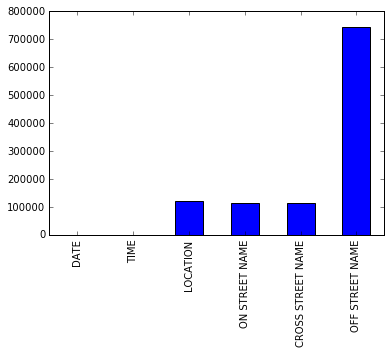

In [12]:
collisions[['DATE', 'TIME', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME']].isnull().sum().plot(kind='bar')

The following expression gets you the null percentage (you can attach `plot()` to this to get the chart above terms of percentages):

In [13]:
collisions[['DATE', 'TIME', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME']].isnull().sum() / len(collisions)

DATE                 0.000000
TIME                 0.000000
LOCATION             0.157579
ON STREET NAME       0.147739
CROSS STREET NAME    0.147739
OFF STREET NAME      0.969063
dtype: float64

The [`missingno` library](https://github.com/ResidentMario/missingno), which I wrote expressly for this purpose, provides a few further useful expressions for a deeper look into this subject.

In [ ]:
msno.matrix(data.sample(250))